In [2]:
import os
import numpy as np
from tqdm import tqdm
#from operator import itemgetter
#from collections import OrderedDict

from PIL import Image
#import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision.utils import make_grid

#pd.options.plotting.backend = "plotly"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1]:
# Bật autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from subset_data import create_subset_loader
from datasets import download_2dplanes, download_creditcard, download_digits, download_iris

In [26]:
from datasets import download_nomao, download_fried, download_pol

In [36]:
X, y = download_pol()
X, y = X[:2000], y[:2000]

In [37]:
from datasets import split_data_train_val_test
#X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (1000, 48) Validation: (600, 48) Test: (400, 48)
(1000, 48) (600, 48) (400, 48)
(1000,) (600,) (400,)


In [38]:
# save
import pickle

with open('x_y_embedding_pol.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [83]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_pol.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(1000, 48) (600, 48) (400, 48)
(1000,) (600,) (400,)


In [84]:
import torch
import numpy as np

# Chuyển dữ liệu sang torch.Tensor nếu cần
x_embeddings = torch.tensor(x_embeddings, dtype=torch.float32) if not isinstance(x_embeddings, torch.Tensor) else x_embeddings
xt_embeddings = torch.tensor(xt_embeddings, dtype=torch.float32) if not isinstance(xt_embeddings, torch.Tensor) else xt_embeddings

# Tính giá trị trung bình và độ lệch chuẩn từ X_train
mean = x_embeddings.mean(dim=0)  # Trung bình theo từng cột (feature)
std = x_embeddings.std(dim=0)    # Độ lệch chuẩn theo từng cột (feature)

# Đảm bảo std không có giá trị 0 để tránh chia cho 0
std[std == 0] = 1e-8

# Chuẩn hóa dữ liệu
X_train_normalized = (x_embeddings - mean) / std
X_valid_normalized = (xt_embeddings - mean) / std

# In kết quả
print("After normalization:")
print(X_train_normalized.shape, X_valid_normalized.shape)



After normalization:
torch.Size([1000, 48]) torch.Size([600, 48])


In [3]:
# Bật autoreload
%load_ext autoreload
%autoreload 2

In [89]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = X_train_normalized.clone()
param = add_gauss_noise(X_copy, X_valid_normalized, noise_rate=0.2)
X_train_normalized_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_normalized_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: torch.Size([1000, 48])
Epoch [10/1000], Loss: 0.4971
Epoch [20/1000], Loss: 0.4696
Epoch [30/1000], Loss: 0.4590
Epoch [40/1000], Loss: 0.4478
Epoch [50/1000], Loss: 0.4430
Epoch [60/1000], Loss: 0.4403
Epoch [70/1000], Loss: 0.4390
Epoch [80/1000], Loss: 0.4337
Epoch [90/1000], Loss: 0.4310
Epoch [100/1000], Loss: 0.4295
Epoch [110/1000], Loss: 0.4341
Epoch [120/1000], Loss: 0.4258
Epoch [130/1000], Loss: 0.4291
Epoch [140/1000], Loss: 0.4239
Epoch [150/1000], Loss: 0.4231
Epoch [160/1000], Loss: 0.4243
Epoch [170/1000], Loss: 0.4207
Epoch [180/1000], Loss: 0.4203
Epoch [190/1000], Loss: 0.4280
Epoch [200/1000], Loss: 0.4219
Epoch [210/1000], Loss: 0.4188
Epoch [220/1000], Loss: 0.4205
Epoch [230/1000], Loss: 0.4180
Epoch [240/1000], Loss: 0.4170
Epoch [250/1000], Loss: 0.4183
Epoch [260/1000], Loss: 0.4161
Epoch [270/1000], Loss: 0.4160
Epoch [280/1000], Loss: 0.4151
Epoch [290/1000], Loss: 0.4148
Epoch [300/1000], Loss: 0.4194
Epoch [310/1000], Loss: 0.4

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 3085.91it/s]


KNNEvaluator completed in 0.50 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 62.4342,  61.7643,  68.0115,  ...,  62.3917,  64.1775, 189.4807],
        [100.5442,  82.5614,  83.9356,  ...,  86.9507,  78.8555, 170.2350],
        [ 12.2329,   6.2744,  15.0624,  ...,  10.6887,   9.0539, 125.1297],
        ...,
        [ 26.3701,   9.2964,   4.0519,  ...,  11.7178,  13.1453, 144.6545],
        [ 30.6926,  20.3267,   2.3314,  ...,  17.0963,  22.9582, 154.1964],
        [131.2105, 130.9414, 136.6629,  ..., 126.6579, 132.8552, 274.7912]])
C2 la: tensor([[0.0000, 0.1103, 0.0000,  ..., 0.0000, 0.1103, 0.1103],
        [0.0000, 0.1103, 0.0000,  ..., 0.0000, 0.1103, 0.1103],
        [0.1103, 0.0000, 0.1103,  ..., 0.1103, 0.0000, 0.0000],
        ...,
        [0.0000, 0.1103, 0.0000,  ..., 0.0000, 0.1103, 0.1103],
        [0.0000, 0.1103, 0.0000,  ..., 0.0000, 0.1103, 0.1103],
        [0.0000, 0.1103, 0.0000,  ..., 0.0000, 0.1103, 0.1103]])
C1 la: tensor([[0.1164, 0.1151, 0.1268,  ..., 0.1163, 0.1196, 0.3532],
        [0.1874, 0.1539, 0.1565,  ..., 0.1621, 

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


  750|3.033507e-09|
  760|3.224095e-09|
  770|3.457359e-09|
  780|3.286543e-09|
  790|3.697905e-09|
It.  |Err         
-------------------
  800|3.824026e-09|
  810|4.247165e-09|
  820|4.219955e-09|
  830|3.875074e-09|
  840|3.534887e-09|
  850|3.681376e-09|
  860|3.230394e-09|
  870|3.265860e-09|
  880|3.066831e-09|
  890|3.232491e-09|
  900|3.226196e-09|
  910|3.171116e-09|
  920|3.228296e-09|
  930|3.380056e-09|
  940|3.213569e-09|
  950|3.278285e-09|
  960|3.117236e-09|
  970|3.042429e-09|
  980|3.341748e-09|
  990|3.435731e-09|
LavaEvaluator completed in 0.26 seconds.
KNNEvaluator: {'found_rates': [0.0, 0.0, 0.0, 0.0, 0.0, 0.075, 0.3, 0.35, 0.6, 0.845, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476

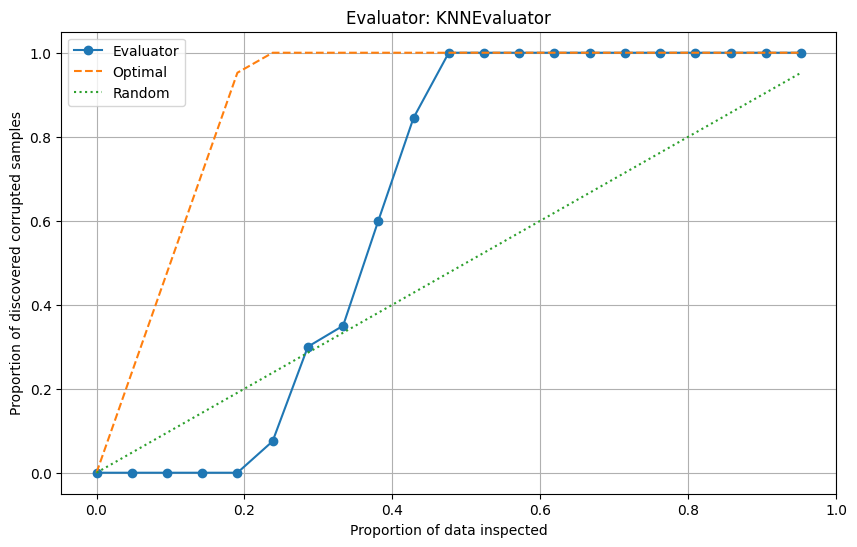

LavaEvaluator: {'found_rates': [0.0, 0.245, 0.465, 0.66, 0.72, 0.76, 0.795, 0.82, 0.835, 0.85, 0.855, 0.87, 0.875, 0.875, 0.88, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


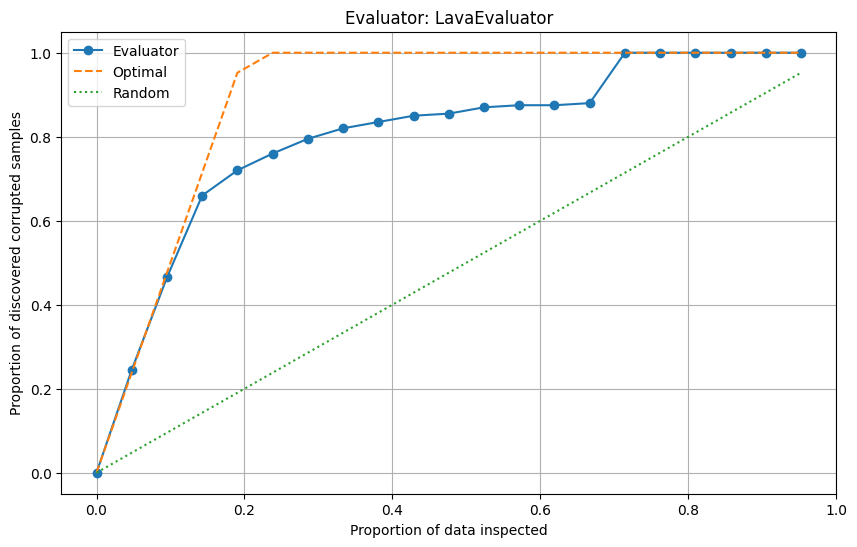

{'KNNEvaluator': {'found_rates': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.075,
   0.3,
   0.35,
   0.6,
   0.845,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.245,
   0.465,
   0.66,
   0.72,
   0.76,
   0.795,
   0.82,
   0.835,
   0.85,
   0.855,
   0.87,
   0.875,
   0.875,
   0.88,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.1428571428571428

In [90]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

In [91]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

600
Noisy training labels shape: (1000,)
Epoch [10/1000], Loss: 0.5976
Epoch [20/1000], Loss: 0.5824
Epoch [30/1000], Loss: 0.5740
Epoch [40/1000], Loss: 0.5729
Epoch [50/1000], Loss: 0.5675
Epoch [60/1000], Loss: 0.5653
Epoch [70/1000], Loss: 0.5643
Epoch [80/1000], Loss: 0.5623
Epoch [90/1000], Loss: 0.5632
Epoch [100/1000], Loss: 0.5563
Epoch [110/1000], Loss: 0.5639
Epoch [120/1000], Loss: 0.5603
Epoch [130/1000], Loss: 0.5578
Epoch [140/1000], Loss: 0.5528
Epoch [150/1000], Loss: 0.5613
Epoch [160/1000], Loss: 0.5546
Epoch [170/1000], Loss: 0.5594
Epoch [180/1000], Loss: 0.5555
Epoch [190/1000], Loss: 0.5672
Epoch [200/1000], Loss: 0.5554
Epoch [210/1000], Loss: 0.5532
Epoch [220/1000], Loss: 0.5562
Epoch [230/1000], Loss: 0.5514
Epoch [240/1000], Loss: 0.5541
Epoch [250/1000], Loss: 0.5504
Epoch [260/1000], Loss: 0.5493
Epoch [270/1000], Loss: 0.5561
Epoch [280/1000], Loss: 0.5475
Epoch [290/1000], Loss: 0.5557
Epoch [300/1000], Loss: 0.5576
Epoch [310/1000], Loss: 0.5534
Epoch [

In [86]:
print(y_labels)
print(y_labels_noisy)
print(noisy_train_indices)

[1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1
 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0
 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1
 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1
 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1
 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1
 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1
 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0
 0 1 1 0 0 1 1 0 1 1 1 0 

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 3038.50it/s]


KNNEvaluator completed in 0.51 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 62.4342,  61.7643,  68.0115,  ...,  62.3917,  64.1775, 189.4807],
        [ 27.3622,  13.5279,  22.5824,  ...,  15.0433,  22.2680, 131.8097],
        [ 12.2329,   6.2744,  15.0624,  ...,  10.6887,   9.0539, 125.1297],
        ...,
        [ 26.3701,   9.2964,   4.0519,  ...,  11.7178,  13.1453, 144.6545],
        [ 30.6926,  20.3267,   2.3314,  ...,  17.0963,  22.9582, 154.1964],
        [ 19.1526,   9.6580,  15.5298,  ...,   9.3249,  13.3263, 133.0307]])
C2 la: tensor([[0.0000, 0.0938, 0.0000,  ..., 0.0000, 0.0938, 0.0000],
        [0.0938, 0.0000, 0.0938,  ..., 0.0938, 0.0000, 0.0938],
        [0.0938, 0.0000, 0.0938,  ..., 0.0938, 0.0000, 0.0938],
        ...,
        [0.0000, 0.0938, 0.0000,  ..., 0.0000, 0.0938, 0.0000],
        [0.0000, 0.0938, 0.0000,  ..., 0.0000, 0.0938, 0.0000],
        [0.0938, 0.0000, 0.0938,  ..., 0.0938, 0.0000, 0.0938]])
C1 la: tensor([[0.1651, 0.1633, 0.1798,  ..., 0.1650, 0.1697, 0.5010],
        [0.0723, 0.0358, 0.0597,  ..., 0.0398, 

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


  650|2.896380e-09|
  660|2.919681e-09|
  670|3.132416e-09|
  680|3.062409e-09|
  690|3.221992e-09|
  700|2.872889e-09|
  710|2.983959e-09|
  720|3.181782e-09|
  730|2.999813e-09|
  740|2.896380e-09|
  750|2.861071e-09|
  760|3.013336e-09|
  770|3.042429e-09|
  780|2.644448e-09|
  790|2.342813e-09|
It.  |Err         
-------------------
  800|2.784249e-09|
  810|2.433609e-09|
  820|2.820520e-09|
  830|2.827718e-09|
  840|3.091041e-09|
  850|2.972583e-09|
  860|2.621284e-09|
  870|2.382962e-09|
  880|2.304906e-09|
  890|2.555840e-09|
  900|2.485951e-09|
  910|2.659778e-09|
  920|2.388643e-09|
  930|2.461296e-09|
  940|2.710253e-09|
  950|2.464048e-09|
  960|2.789113e-09|
  970|3.095422e-09|
  980|3.209349e-09|
  990|3.265860e-09|
LavaEvaluator completed in 0.28 seconds.
KNNEvaluator: {'found_rates': [0.0, 0.195, 0.345, 0.52, 0.65, 0.75, 0.79, 0.805, 0.85, 0.875, 0.91, 0.915, 0.925, 0.935, 0.945, 0.955, 0.975, 0.99, 0.995, 0.995, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809

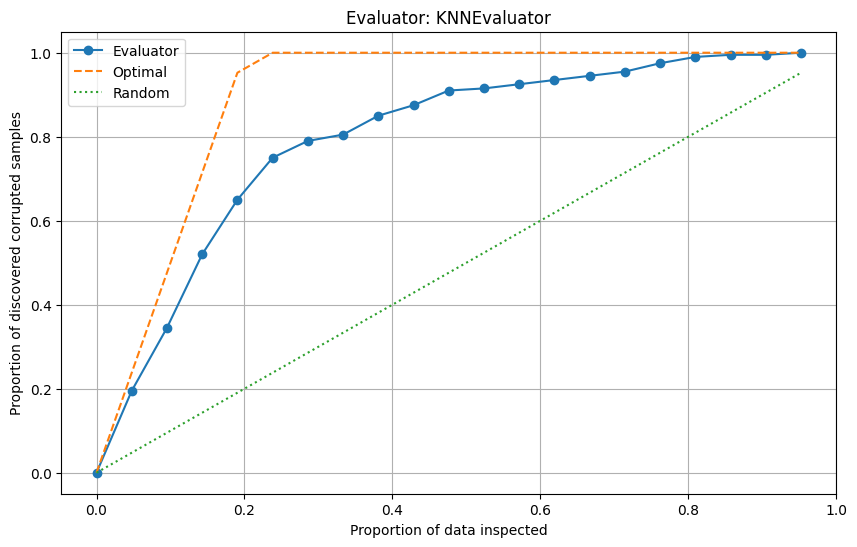

LavaEvaluator: {'found_rates': [0.0, 0.235, 0.425, 0.53, 0.63, 0.665, 0.675, 0.68, 0.68, 0.68, 0.68, 0.68, 0.685, 0.685, 0.685, 0.69, 0.695, 0.73, 0.78, 0.84, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


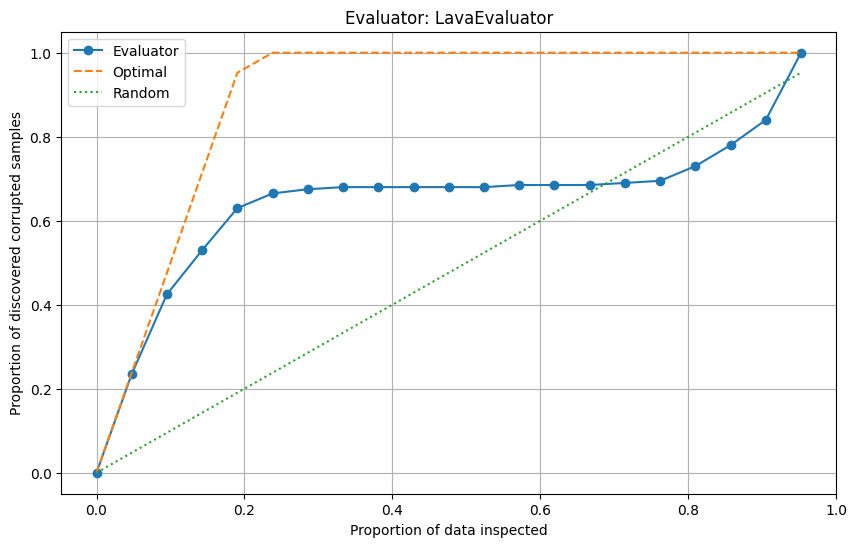

{'KNNEvaluator': {'found_rates': [0.0,
   0.195,
   0.345,
   0.52,
   0.65,
   0.75,
   0.79,
   0.805,
   0.85,
   0.875,
   0.91,
   0.915,
   0.925,
   0.935,
   0.945,
   0.955,
   0.975,
   0.99,
   0.995,
   0.995,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.235,
   0.425,
   0.53,
   0.63,
   0.665,
   0.675,
   0.68,
   0.68,
   0.68,
   0.68,
   0.68,
   0.685,
   0.685,
   0.685,
   0.69,
   0.695,
   0.73,
   0.78,
   0.84,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809

In [92]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_normalized, y_labels_noisy, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

In [55]:
print(x_embeddings[0]) # qua float32

tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.7341,  1.2212, -0.4757,  1.0919,
         5.0381,  0.0000,  0.0000,  0.0000, -0.4120, -0.6191, -0.5661, -0.4681,
        -0.4563, -0.6048,  2.6909,  1.7606, -0.3295, -0.3206, -0.2785, -0.2215,
        -0.1971, -0.1713, -0.1737, -0.1769, -0.1645, -0.1578,  4.4298,  6.5109,
        -0.1127,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])


In [57]:
print(x_embeddings[0])

[ 0.          0.          0.          0.         -0.73412736  1.22116608
 -0.47567677  1.09185925  5.0380602   0.          0.          0.
 -0.41202578 -0.6190528  -0.56613363 -0.46810432 -0.45626753 -0.60481849
  2.69088637  1.76063167 -0.32947185 -0.32055312 -0.27853187 -0.2215247
 -0.19712405 -0.17126107 -0.17369311 -0.1769072  -0.16449105 -0.15783015
  4.42976799  6.51094322 -0.11274086  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [47]:
print(np.unique(y_labels))

[0 1]


In [94]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

600
Noisy training labels shape: (1000,)
Epoch [10/1000], Loss: 0.4632
Epoch [20/1000], Loss: 0.4399
Epoch [30/1000], Loss: 0.4296
Epoch [40/1000], Loss: 0.4196
Epoch [50/1000], Loss: 0.4159
Epoch [60/1000], Loss: 0.4111
Epoch [70/1000], Loss: 0.4078
Epoch [80/1000], Loss: 0.4087
Epoch [90/1000], Loss: 0.4032
Epoch [100/1000], Loss: 0.4018
Epoch [110/1000], Loss: 0.4008
Epoch [120/1000], Loss: 0.4001
Epoch [130/1000], Loss: 0.3989
Epoch [140/1000], Loss: 0.3974
Epoch [150/1000], Loss: 0.3964
Epoch [160/1000], Loss: 0.3955
Epoch [170/1000], Loss: 0.3962
Epoch [180/1000], Loss: 0.3965
Epoch [190/1000], Loss: 0.3966
Epoch [200/1000], Loss: 0.3936
Epoch [210/1000], Loss: 0.3931
Epoch [220/1000], Loss: 0.3924
Epoch [230/1000], Loss: 0.3922
Epoch [240/1000], Loss: 0.3933
Epoch [250/1000], Loss: 0.3912
Epoch [260/1000], Loss: 0.3916
Epoch [270/1000], Loss: 0.3927
Epoch [280/1000], Loss: 0.3905
Epoch [290/1000], Loss: 0.3934
Epoch [300/1000], Loss: 0.3893
Epoch [310/1000], Loss: 0.3921
Epoch [

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 3061.82it/s]


KNNEvaluator completed in 0.48 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[60.4756, 59.3714, 65.5801,  ..., 60.1598, 62.0243, 65.9572],
        [26.9061, 13.7207, 22.2542,  ..., 14.6492, 21.9911, 20.7384],
        [11.4366,  5.4561, 14.1747,  ..., 10.1177,  8.5935, 12.0406],
        ...,
        [25.6278,  8.9251,  3.8772,  ..., 11.2725, 12.6626, 16.7969],
        [29.9567, 19.4707,  2.1795,  ..., 16.4961, 22.3214, 25.5298],
        [18.9528,  9.5080, 15.3494,  ...,  9.2247, 13.3342, 16.7050]])
C2 la: tensor([[0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0971, 0.0000, 0.0971,  ..., 0.0971, 0.0000, 0.0971],
        ...,
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000]])
C1 la: tensor([[0.2232, 0.2192, 0.2421,  ..., 0.2221, 0.2290, 0.2435],
        [0.0993, 0.0506, 0.0821,  ..., 0.0541, 0.0812, 0.0765],
        [0.0422, 0.

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


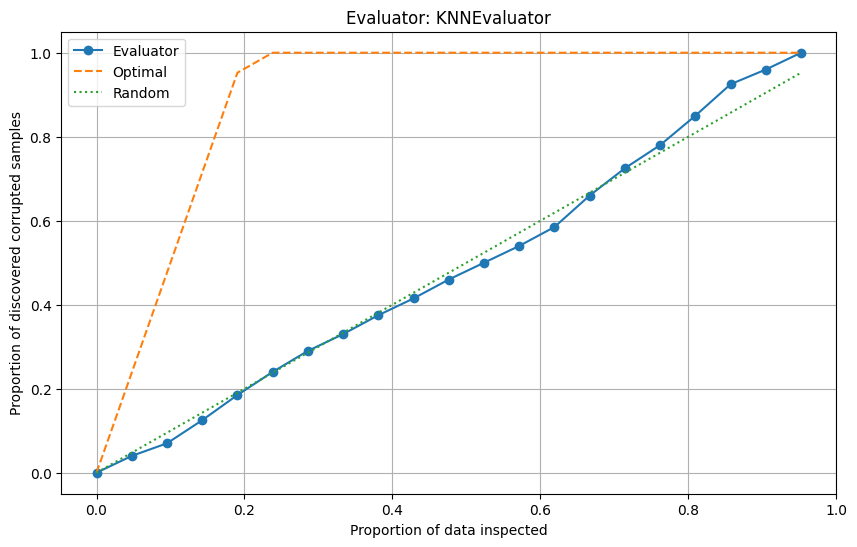

LavaEvaluator: {'found_rates': [0.0, 0.055, 0.1, 0.155, 0.235, 0.305, 0.335, 0.37, 0.395, 0.43, 0.5, 0.56, 0.635, 0.685, 0.72, 0.755, 0.805, 0.855, 0.92, 0.97, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


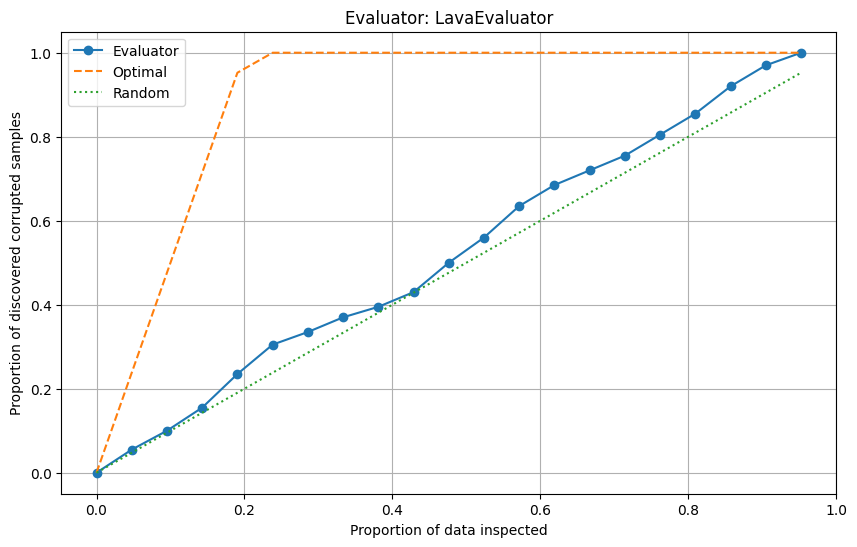

{'KNNEvaluator': {'found_rates': [0.0,
   0.04,
   0.07,
   0.125,
   0.185,
   0.24,
   0.29,
   0.33,
   0.375,
   0.415,
   0.46,
   0.5,
   0.54,
   0.585,
   0.66,
   0.725,
   0.78,
   0.85,
   0.925,
   0.96,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.055,
   0.1,
   0.155,
   0.235,
   0.305,
   0.335,
   0.37,
   0.395,
   0.43,
   0.5,
   0.56,
   0.635,
   0.685,
   0.72,
   0.755,
   0.805,
   0.855,
   0.92,
   0.97,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.0952380952380

In [95]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 3191.90it/s]


KNNEvaluator completed in 0.48 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[60.4756, 59.3714, 65.5801,  ..., 60.1598, 62.0243, 65.9572],
        [26.9061, 13.7207, 22.2542,  ..., 14.6492, 21.9911, 20.7384],
        [11.4366,  5.4561, 14.1747,  ..., 10.1177,  8.5935, 12.0406],
        ...,
        [25.6278,  8.9251,  3.8772,  ..., 11.2725, 12.6626, 16.7969],
        [29.9567, 19.4707,  2.1795,  ..., 16.4961, 22.3214, 25.5298],
        [18.9528,  9.5080, 15.3494,  ...,  9.2247, 13.3342, 16.7050]])
C2 la: tensor([[0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0971, 0.0000, 0.0971,  ..., 0.0971, 0.0000, 0.0971],
        ...,
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000],
        [0.0000, 0.0971, 0.0000,  ..., 0.0000, 0.0971, 0.0000]])
C1 la: tensor([[0.2232, 0.2192, 0.2421,  ..., 0.2221, 0.2290, 0.2435],
        [0.0993, 0.0506, 0.0821,  ..., 0.0541, 0.0812, 0.0765],
        [0.0422, 0.

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


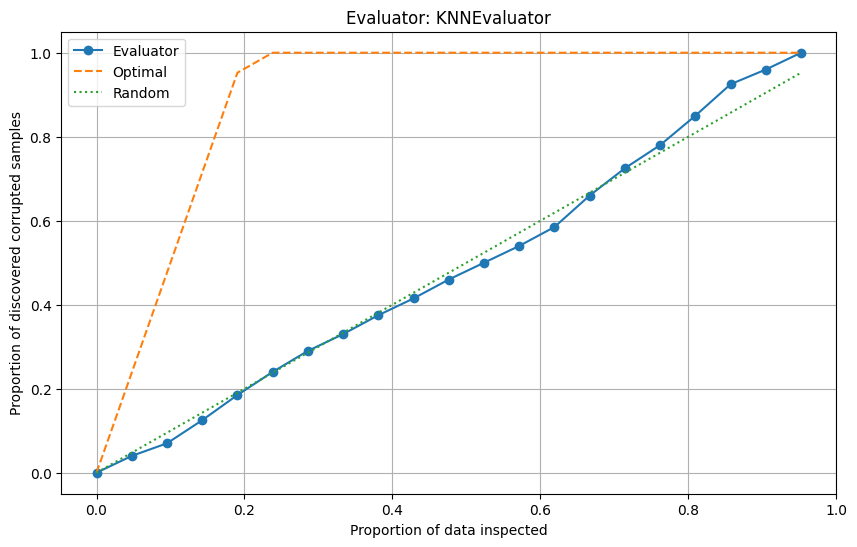

LavaEvaluator: {'found_rates': [0.0, 0.055, 0.1, 0.155, 0.235, 0.305, 0.335, 0.37, 0.395, 0.43, 0.5, 0.56, 0.635, 0.685, 0.72, 0.755, 0.805, 0.855, 0.92, 0.97, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


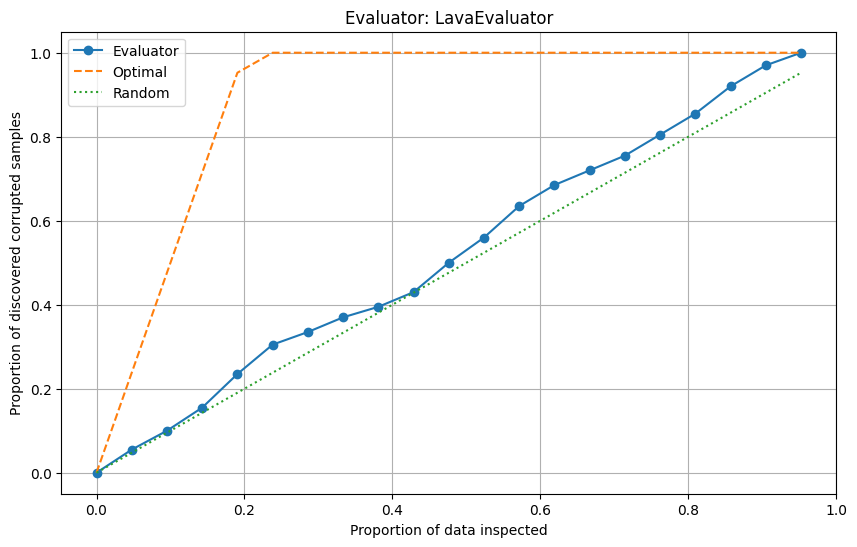

{'KNNEvaluator': {'found_rates': [0.0,
   0.04,
   0.07,
   0.125,
   0.185,
   0.24,
   0.29,
   0.33,
   0.375,
   0.415,
   0.46,
   0.5,
   0.54,
   0.585,
   0.66,
   0.725,
   0.78,
   0.85,
   0.925,
   0.96,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.055,
   0.1,
   0.155,
   0.235,
   0.305,
   0.335,
   0.37,
   0.395,
   0.43,
   0.5,
   0.56,
   0.635,
   0.685,
   0.72,
   0.755,
   0.805,
   0.855,
   0.92,
   0.97,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.0952380952380

In [48]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 2951.73it/s]


KNNEvaluator completed in 0.51 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[60.4756, 59.3714, 65.5801,  ..., 60.1598, 62.0243, 65.9572],
        [26.9061, 13.7207, 22.2542,  ..., 14.6492, 21.9911, 20.7384],
        [11.4366,  5.4561, 14.1747,  ..., 10.1177,  8.5935, 12.0406],
        ...,
        [25.6278,  8.9251,  3.8772,  ..., 11.2725, 12.6626, 16.7969],
        [29.9567, 19.4707,  2.1795,  ..., 16.4961, 22.3214, 25.5298],
        [18.9528,  9.5080, 15.3494,  ...,  9.2247, 13.3342, 16.7050]])
C2 la: tensor([[0.0000, 0.0843, 0.0000,  ..., 0.0000, 0.0843, 0.0843],
        [0.0843, 0.0000, 0.0843,  ..., 0.0843, 0.0000, 0.0000],
        [0.0843, 0.0000, 0.0843,  ..., 0.0843, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0843, 0.0000,  ..., 0.0000, 0.0843, 0.0843],
        [0.0000, 0.0843, 0.0000,  ..., 0.0000, 0.0843, 0.0843],
        [0.0843, 0.0000, 0.0843,  ..., 0.0843, 0.0000, 0.0000]])
C1 la: tensor([[0.2232, 0.2192, 0.2421,  ..., 0.2221, 0.2290, 0.2435],
        [0.0993, 0.0506, 0.0821,  ..., 0.0541, 0.0812, 0.0765],
        [0.0422, 0.

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


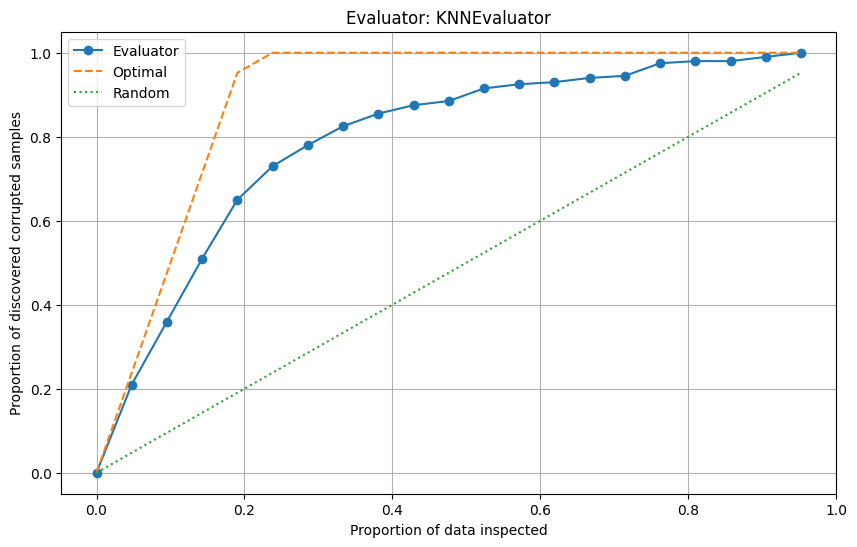

LavaEvaluator: {'found_rates': [0.0, 0.08, 0.2, 0.355, 0.46, 0.54, 0.625, 0.66, 0.675, 0.68, 0.68, 0.68, 0.685, 0.685, 0.685, 0.69, 0.7, 0.725, 0.77, 0.83, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


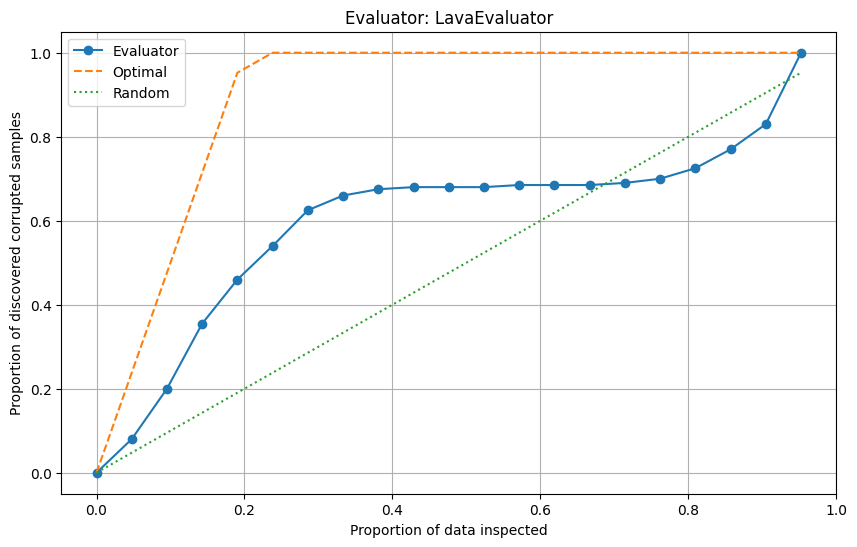

{'KNNEvaluator': {'found_rates': [0.0,
   0.21,
   0.36,
   0.51,
   0.65,
   0.73,
   0.78,
   0.825,
   0.855,
   0.875,
   0.885,
   0.915,
   0.925,
   0.93,
   0.94,
   0.945,
   0.975,
   0.98,
   0.98,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.08,
   0.2,
   0.355,
   0.46,
   0.54,
   0.625,
   0.66,
   0.675,
   0.68,
   0.68,
   0.68,
   0.685,
   0.685,
   0.685,
   0.69,
   0.7,
   0.725,
   0.77,
   0.83,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.095238095238095

In [51]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [40]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

600
Noisy training labels shape: (1000,)
Epoch [10/1000], Loss: 0.5933
Epoch [20/1000], Loss: 0.5807
Epoch [30/1000], Loss: 0.5728
Epoch [40/1000], Loss: 0.5706
Epoch [50/1000], Loss: 0.5711
Epoch [60/1000], Loss: 0.5647
Epoch [70/1000], Loss: 0.5669
Epoch [80/1000], Loss: 0.5656
Epoch [90/1000], Loss: 0.5675
Epoch [100/1000], Loss: 0.5649
Epoch [110/1000], Loss: 0.5623
Epoch [120/1000], Loss: 0.5581
Epoch [130/1000], Loss: 0.5536
Epoch [140/1000], Loss: 0.5605
Epoch [150/1000], Loss: 0.5580
Epoch [160/1000], Loss: 0.5616
Epoch [170/1000], Loss: 0.5592
Epoch [180/1000], Loss: 0.5561
Epoch [190/1000], Loss: 0.5598
Epoch [200/1000], Loss: 0.5586
Epoch [210/1000], Loss: 0.5581
Epoch [220/1000], Loss: 0.5539
Epoch [230/1000], Loss: 0.5534
Epoch [240/1000], Loss: 0.5538
Epoch [250/1000], Loss: 0.5504
Epoch [260/1000], Loss: 0.5586
Epoch [270/1000], Loss: 0.5539
Epoch [280/1000], Loss: 0.5530
Epoch [290/1000], Loss: 0.5475
Epoch [300/1000], Loss: 0.5527
Epoch [310/1000], Loss: 0.5475
Epoch [

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 2889.96it/s]


KNNEvaluator completed in 0.61 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[60.4756, 59.3714, 65.5801,  ..., 60.1598, 62.0243, 65.9572],
        [26.9061, 13.7207, 22.2542,  ..., 14.6492, 21.9911, 20.7384],
        [11.4366,  5.4561, 14.1747,  ..., 10.1177,  8.5935, 12.0406],
        ...,
        [25.6278,  8.9251,  3.8772,  ..., 11.2725, 12.6626, 16.7969],
        [29.9567, 19.4707,  2.1795,  ..., 16.4961, 22.3214, 25.5298],
        [18.9528,  9.5080, 15.3494,  ...,  9.2247, 13.3342, 16.7050]])
C2 la: tensor([[0.0000, 0.0843, 0.0000,  ..., 0.0000, 0.0843, 0.0843],
        [0.0843, 0.0000, 0.0843,  ..., 0.0843, 0.0000, 0.0000],
        [0.0843, 0.0000, 0.0843,  ..., 0.0843, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0843, 0.0000,  ..., 0.0000, 0.0843, 0.0843],
        [0.0000, 0.0843, 0.0000,  ..., 0.0000, 0.0843, 0.0843],
        [0.0843, 0.0000, 0.0843,  ..., 0.0843, 0.0000, 0.0000]])
C1 la: tensor([[0.2232, 0.2192, 0.2421,  ..., 0.2221, 0.2290, 0.2435],
        [0.0993, 0.0506, 0.0821,  ..., 0.0541, 0.0812, 0.0765],
        [0.0422, 0.

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


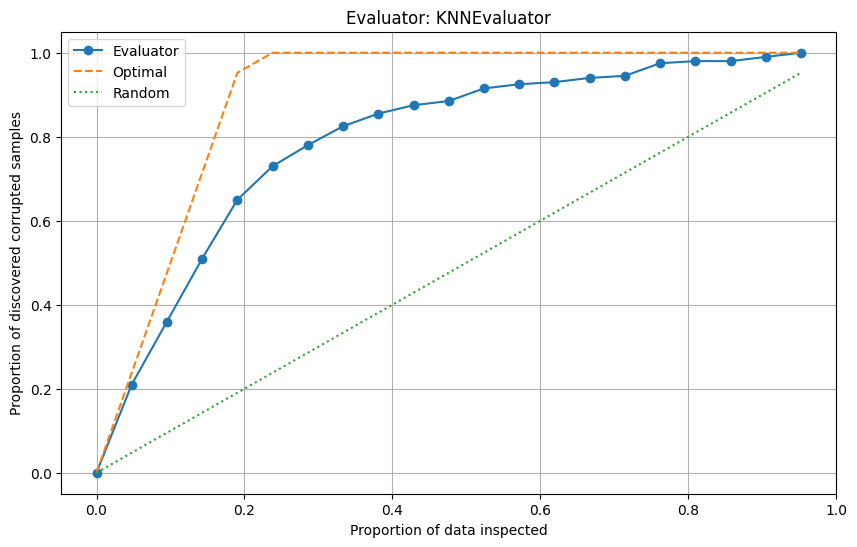

LavaEvaluator: {'found_rates': [0.0, 0.08, 0.2, 0.355, 0.46, 0.54, 0.625, 0.66, 0.675, 0.68, 0.68, 0.68, 0.685, 0.685, 0.685, 0.69, 0.7, 0.725, 0.77, 0.83, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


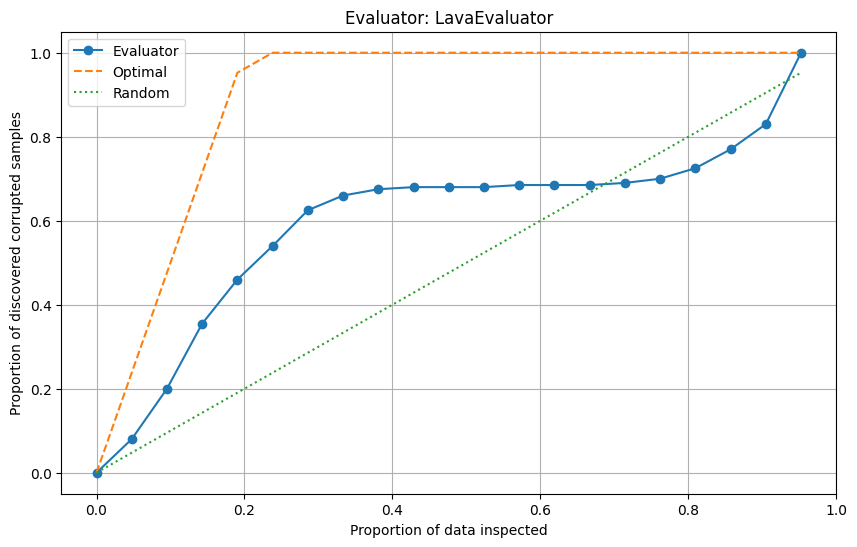

{'KNNEvaluator': {'found_rates': [0.0,
   0.21,
   0.36,
   0.51,
   0.65,
   0.73,
   0.78,
   0.825,
   0.855,
   0.875,
   0.885,
   0.915,
   0.925,
   0.93,
   0.94,
   0.945,
   0.975,
   0.98,
   0.98,
   0.99,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.08,
   0.2,
   0.355,
   0.46,
   0.54,
   0.625,
   0.66,
   0.675,
   0.68,
   0.68,
   0.68,
   0.685,
   0.685,
   0.685,
   0.69,
   0.7,
   0.725,
   0.77,
   0.83,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.095238095238095

In [41]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [10]:
X, y = download_digits()
X, y = X[:2000], y[:2000]

In [11]:
from datasets import split_data_train_val_test
#X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (898, 64) Validation: (539, 64) Test: (360, 64)
(898, 64) (539, 64) (360, 64)
(898,) (539,) (360,)


In [12]:
# save
import pickle

with open('x_y_embedding_digits.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [13]:
X, y = download_creditcard()
print(X.shape,y.shape)

(30000, 23) (30000,)


In [14]:
X, y = X[:2000], y[:2000]

In [15]:
from datasets import split_data_train_val_test
#X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (1000, 23) Validation: (600, 23) Test: (400, 23)
(1000, 23) (600, 23) (400, 23)
(1000,) (600,) (400,)


In [16]:
# save
import pickle

with open('x_y_embedding_creditcard.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [19]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_digits.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(898, 64) (539, 64) (360, 64)
(898,) (539,) (360,)


In [20]:
import torch
import numpy as np

# Chuyển dữ liệu sang torch.Tensor nếu cần
x_embeddings = torch.tensor(x_embeddings, dtype=torch.float32) if not isinstance(x_embeddings, torch.Tensor) else x_embeddings
xt_embeddings = torch.tensor(xt_embeddings, dtype=torch.float32) if not isinstance(xt_embeddings, torch.Tensor) else xt_embeddings

# Tính giá trị trung bình và độ lệch chuẩn từ X_train
mean = x_embeddings.mean(dim=0)  # Trung bình theo từng cột (feature)
std = x_embeddings.std(dim=0)    # Độ lệch chuẩn theo từng cột (feature)

# Đảm bảo std không có giá trị 0 để tránh chia cho 0
std[std == 0] = 1e-8

# Chuẩn hóa dữ liệu
X_train_normalized = (x_embeddings - mean) / std
X_valid_normalized = (xt_embeddings - mean) / std

# In kết quả
print("After normalization:")
print(X_train_normalized.shape, X_valid_normalized.shape)

After normalization:
torch.Size([898, 64]) torch.Size([539, 64])


In [21]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = X_train_normalized.clone()
param = add_gauss_noise(X_copy, X_valid_normalized, noise_rate=0.2)
X_train_normalized_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_normalized_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: torch.Size([898, 64])
Epoch [10/1000], Loss: 1.6626
Epoch [20/1000], Loss: 1.5906
Epoch [30/1000], Loss: 1.5734
Epoch [40/1000], Loss: 1.5532
Epoch [50/1000], Loss: 1.5411
Epoch [60/1000], Loss: 1.5347
Epoch [70/1000], Loss: 1.5292
Epoch [80/1000], Loss: 1.5271
Epoch [90/1000], Loss: 1.5217
Epoch [100/1000], Loss: 1.5191
Epoch [110/1000], Loss: 1.5184
Epoch [120/1000], Loss: 1.5139
Epoch [130/1000], Loss: 1.5121
Epoch [140/1000], Loss: 1.5103
Epoch [150/1000], Loss: 1.5077
Epoch [160/1000], Loss: 1.5060
Epoch [170/1000], Loss: 1.5066
Epoch [180/1000], Loss: 1.5027
Epoch [190/1000], Loss: 1.5014
Epoch [200/1000], Loss: 1.5026
Epoch [210/1000], Loss: 1.5000
Epoch [220/1000], Loss: 1.4992
Epoch [230/1000], Loss: 1.4982
Epoch [240/1000], Loss: 1.5016
Epoch [250/1000], Loss: 1.4980
Epoch [260/1000], Loss: 1.4967
Epoch [270/1000], Loss: 1.5141
Epoch [280/1000], Loss: 1.4961
Epoch [290/1000], Loss: 1.4970
Epoch [300/1000], Loss: 1.4956
Epoch [310/1000], Loss: 1.49

Running evaluator: KNNEvaluator


100%|██████████| 897/897 [00:00<00:00, 2875.27it/s]


KNNEvaluator completed in 0.56 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 24.9915,  30.0187,  46.5754,  ..., 143.9542,  98.6840, 189.6875],
        [129.9864, 146.0563, 110.7757,  ..., 175.0330, 211.7526, 283.6935],
        [ 43.6909,  51.7932,  54.4278,  ..., 149.2222, 117.8040, 211.6445],
        ...,
        [ 32.8906,  34.7890,  32.3198,  ..., 123.2845, 123.1237, 219.2258],
        [ 30.1696,  30.0732,  35.1528,  ..., 138.1162, 155.0906, 228.1823],
        [ 47.4976,  56.6650,  59.9562,  ..., 153.4780,  95.3854, 190.0570]])
C2 la: tensor([[0.0761, 0.0937, 0.0937,  ..., 0.0937, 0.1075, 0.0937],
        [0.0815, 0.1640, 0.1640,  ..., 0.1488, 0.1850, 0.1640],
        [0.0814, 0.1645, 0.1645,  ..., 0.1377, 0.1528, 0.1645],
        ...,
        [0.0815, 0.1640, 0.1640,  ..., 0.1488, 0.1850, 0.1640],
        [0.0811, 0.1686, 0.1686,  ..., 0.1540, 0.1606, 0.1686],
        [0.0757, 0.1573, 0.1573,  ..., 0.1288, 0.0000, 0.1573]])
C1 la: tensor([[0.0057, 0.0069, 0.0108,  ..., 0.0338, 0.0231, 0.0446],
        [0.0305, 0.0343, 0.0260,  ..., 0.0412, 

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


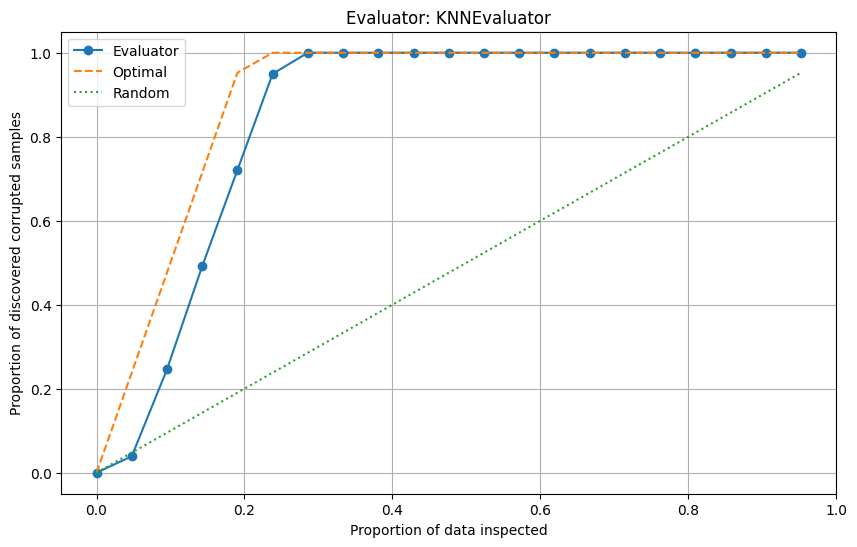

LavaEvaluator: {'found_rates': [0.0, 0.2122905027932961, 0.441340782122905, 0.5027932960893855, 0.5251396648044693, 0.6703910614525139, 0.6815642458100558, 0.6815642458100558, 0.6871508379888268, 0.7206703910614525, 0.7653631284916201, 0.8324022346368715, 0.8491620111731844, 0.8547486033519553, 0.8770949720670391, 0.88268156424581, 0.9106145251396648, 0.9273743016759777, 0.9664804469273743, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


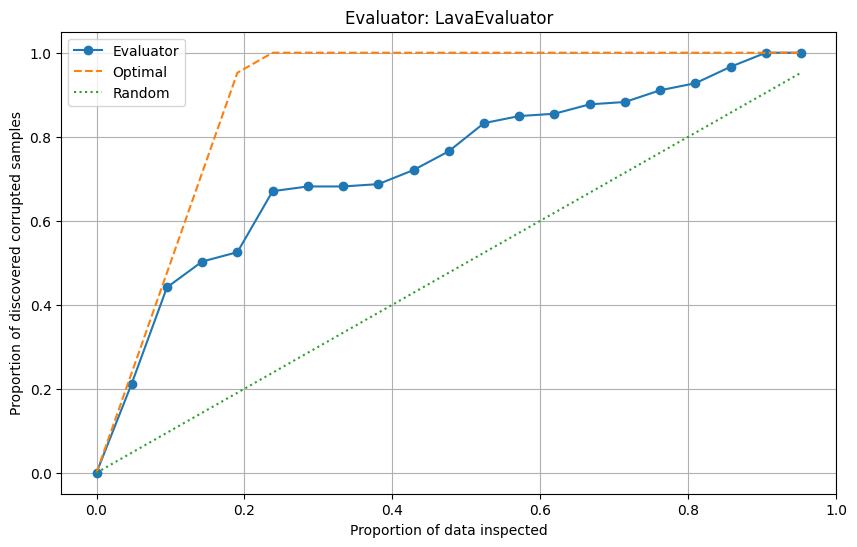

{'KNNEvaluator': {'found_rates': [0.0,
   0.03910614525139665,
   0.24581005586592178,
   0.49162011173184356,
   0.7206703910614525,
   0.9497206703910615,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.2122905027932961,
   0.441340782122905,
   0.5027932960893855,
   0.5251396648044693,
   0.6703910614525139,
   0.6815642458100558,
   0.6815642458100558,
   0.6871508379888268,
   0.7206703

In [22]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

In [19]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

539
Noisy training labels shape: (898,)
Epoch [10/1000], Loss: 2.2121
Epoch [20/1000], Loss: 2.1875
Epoch [30/1000], Loss: 2.1804
Epoch [40/1000], Loss: 2.1804
Epoch [50/1000], Loss: 2.1954
Epoch [60/1000], Loss: 2.1936
Epoch [70/1000], Loss: 2.1776
Epoch [80/1000], Loss: 2.1775
Epoch [90/1000], Loss: 2.2892
Epoch [100/1000], Loss: 2.2543
Epoch [110/1000], Loss: 2.2669
Epoch [120/1000], Loss: 2.2839
Epoch [130/1000], Loss: 2.2831
Epoch [140/1000], Loss: 2.2823
Epoch [150/1000], Loss: 2.2824
Epoch [160/1000], Loss: 2.2656
Epoch [170/1000], Loss: 2.2716
Epoch [180/1000], Loss: 2.2818
Epoch [190/1000], Loss: 2.2811
Epoch [200/1000], Loss: 2.2674
Epoch [210/1000], Loss: 2.2816
Epoch [220/1000], Loss: 2.2812
Epoch [230/1000], Loss: 2.2653
Epoch [240/1000], Loss: 2.2646
Epoch [250/1000], Loss: 2.3620
Epoch [260/1000], Loss: 2.3620
Epoch [270/1000], Loss: 2.3620
Epoch [280/1000], Loss: 2.3620
Epoch [290/1000], Loss: 2.3458
Epoch [300/1000], Loss: 2.3619
Epoch [310/1000], Loss: 2.3619
Epoch [3

Running evaluator: KNNEvaluator


100%|██████████| 897/897 [00:00<00:00, 2736.52it/s]


KNNEvaluator completed in 0.44 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 690.0000,  985.5000, 1290.0000,  ..., 1293.0000,  850.0000,
          891.5000],
        [1035.0000, 1864.5000, 1744.0000,  ..., 1347.0000, 1452.0000,
         1336.5000],
        [1166.0000, 1501.5000, 1377.0000,  ..., 1664.0000,  771.0000,
         1320.5000],
        ...,
        [ 870.0000,  936.5000,  739.0000,  ..., 1293.0000,  985.0000,
          647.5000],
        [ 839.5000,  814.0000,  774.5000,  ..., 1418.5000, 1484.5000,
          965.0000],
        [1229.0000, 1674.5000, 1611.0000,  ..., 1684.0000,  238.0000,
         1027.5000]])
C2 la: tensor([[0.3281, 0.4256, 0.4256,  ..., 0.4807, 0.3810, 0.4125],
        [0.4268, 0.3734, 0.3734,  ..., 0.3742, 0.3572, 0.3407],
        [0.4276, 0.4195, 0.4195,  ..., 0.0000, 0.4295, 0.3439],
        ...,
        [0.4268, 0.3734, 0.3734,  ..., 0.3742, 0.3572, 0.3407],
        [0.3961, 0.2797, 0.2797,  ..., 0.3439, 0.3573, 0.0000],
        [0.4528, 0.5080, 0.5080,  ..., 0.4047, 0.4125, 0.4399]])
C1 la: tensor([[0.2243, 0.32

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


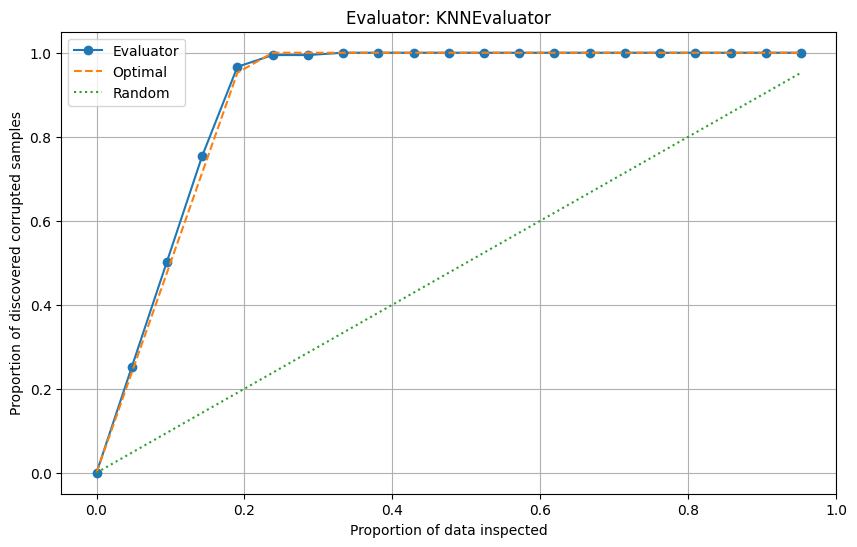

LavaEvaluator: {'found_rates': [0.0, 0.2346368715083799, 0.4022346368715084, 0.5418994413407822, 0.6424581005586593, 0.7262569832402235, 0.7932960893854749, 0.8324022346368715, 0.8994413407821229, 0.9385474860335196, 0.9385474860335196, 0.9720670391061452, 0.9832402234636871, 0.9888268156424581, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


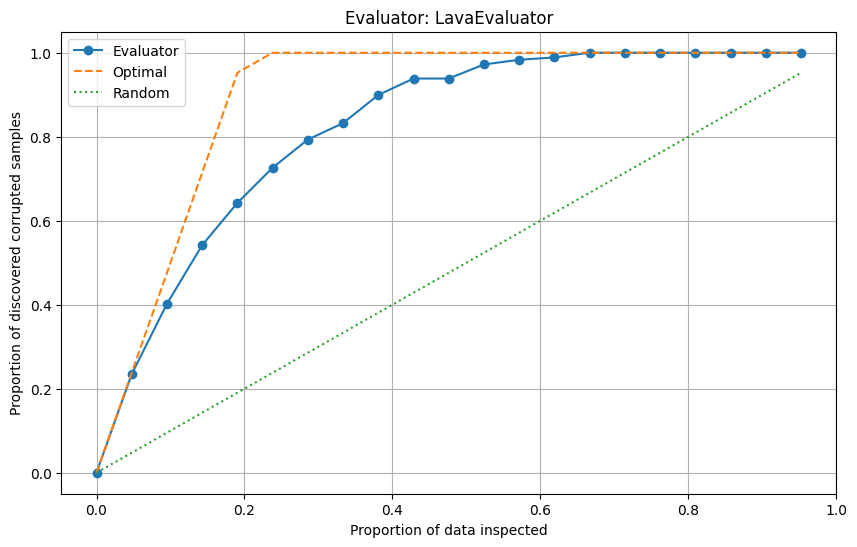

{'KNNEvaluator': {'found_rates': [0.0,
   0.25139664804469275,
   0.5027932960893855,
   0.7541899441340782,
   0.9664804469273743,
   0.994413407821229,
   0.994413407821229,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.2346368715083799,
   0.4022346368715084,
   0.5418994413407822,
   0.6424581005586593,
   0.7262569832402235,
   0.7932960893854749,
   0.8324022346368715,
   0.8994413407821229,


In [20]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [12]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_creditcard.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(1000, 23) (600, 23) (400, 23)
(1000,) (600,) (400,)


In [9]:
import torch
import numpy as np

# Chuyển dữ liệu sang torch.Tensor nếu cần
x_embeddings = torch.tensor(x_embeddings, dtype=torch.float32) if not isinstance(x_embeddings, torch.Tensor) else x_embeddings
xt_embeddings = torch.tensor(xt_embeddings, dtype=torch.float32) if not isinstance(xt_embeddings, torch.Tensor) else xt_embeddings

# Tính giá trị trung bình và độ lệch chuẩn từ X_train
mean = x_embeddings.mean(dim=0)  # Trung bình theo từng cột (feature)
std = x_embeddings.std(dim=0)    # Độ lệch chuẩn theo từng cột (feature)

# Đảm bảo std không có giá trị 0 để tránh chia cho 0
std[std == 0] = 1e-8

# Chuẩn hóa dữ liệu
X_train_normalized = (x_embeddings - mean) / std
X_valid_normalized = (xt_embeddings - mean) / std

# In kết quả
print("After normalization:")
print(X_train_normalized.shape, X_valid_normalized.shape)


After normalization:
torch.Size([1000, 23]) torch.Size([600, 23])


In [10]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = X_train_normalized.clone()
param = add_gauss_noise(X_copy, X_valid_normalized, noise_rate=0.2)
X_train_normalized_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_normalized_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: torch.Size([1000, 23])
Epoch [10/1000], Loss: 0.5241
Epoch [20/1000], Loss: 0.5177
Epoch [30/1000], Loss: 0.5101
Epoch [40/1000], Loss: 0.5106
Epoch [50/1000], Loss: 0.5010
Epoch [60/1000], Loss: 0.5052
Epoch [70/1000], Loss: 0.5015
Epoch [80/1000], Loss: 0.5045
Epoch [90/1000], Loss: 0.5019
Epoch [100/1000], Loss: 0.4975
Epoch [110/1000], Loss: 0.4966
Epoch [120/1000], Loss: 0.4970
Epoch [130/1000], Loss: 0.5011
Epoch [140/1000], Loss: 0.5003
Epoch [150/1000], Loss: 0.4975
Epoch [160/1000], Loss: 0.4990
Epoch [170/1000], Loss: 0.5001
Epoch [180/1000], Loss: 0.4979
Epoch [190/1000], Loss: 0.5026
Epoch [200/1000], Loss: 0.4940
Epoch [210/1000], Loss: 0.4968
Epoch [220/1000], Loss: 0.4934
Epoch [230/1000], Loss: 0.5019
Epoch [240/1000], Loss: 0.5018
Epoch [250/1000], Loss: 0.4966
Epoch [260/1000], Loss: 0.5015
Epoch [270/1000], Loss: 0.4937
Epoch [280/1000], Loss: 0.4929
Epoch [290/1000], Loss: 0.4991
Epoch [300/1000], Loss: 0.4924
Epoch [310/1000], Loss: 0.4

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 2417.11it/s]


KNNEvaluator completed in 0.61 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 14.1654,  69.9010,  17.7332,  ...,   8.0454,   3.8941,  72.3216],
        [ 74.7415, 152.4256,  61.1150,  ...,  70.4133,  64.0805, 104.3683],
        [ 28.3232, 102.0460,  42.6402,  ...,  31.4930,  33.8743, 106.3849],
        ...,
        [ 24.4353,  51.0051,  25.4544,  ...,  17.5130,   7.3534,  80.6199],
        [  7.5595, 107.6609,  12.6153,  ...,   7.3503,  13.9859,  80.2081],
        [ 57.3175, 125.6375,  51.1237,  ...,  47.7495,  57.5535, 137.3093]])
C2 la: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0896, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0896, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0896, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0896, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0896, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0896, 0.0000, 0.0000]])
C1 la: tensor([[0.0139, 0.0684, 0.0174,  ..., 0.0079, 0.0038, 0.0708],
        [0.0731, 0.1491, 0.0598,  ..., 0.0689, 

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


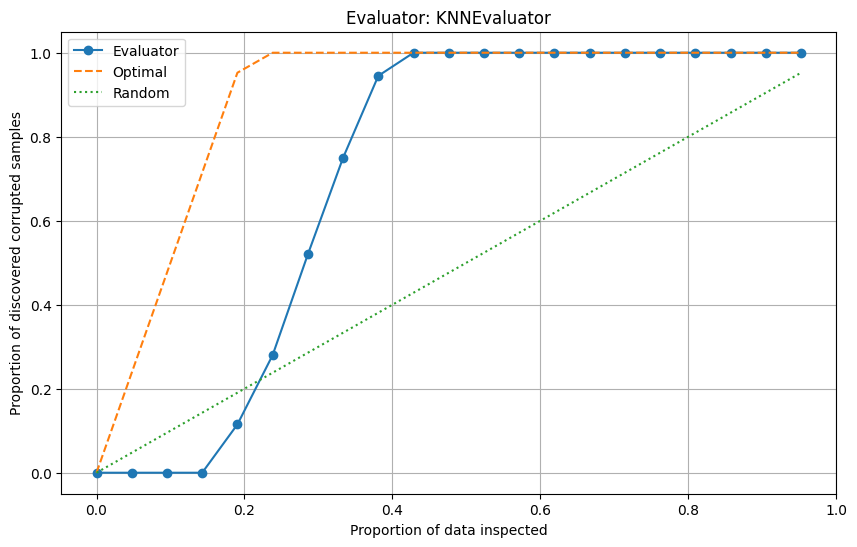

LavaEvaluator: {'found_rates': [0.0, 0.185, 0.195, 0.195, 0.195, 0.26, 0.485, 0.705, 0.935, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


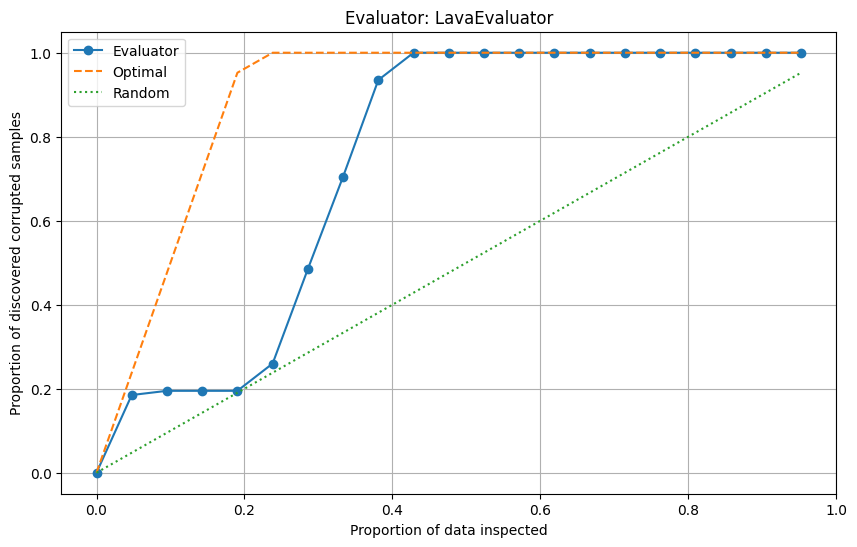

{'KNNEvaluator': {'found_rates': [0.0,
   0.0,
   0.0,
   0.0,
   0.115,
   0.28,
   0.52,
   0.75,
   0.945,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.185,
   0.195,
   0.195,
   0.195,
   0.26,
   0.485,
   0.705,
   0.935,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
 

In [11]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

In [13]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

600
Noisy training labels shape: (1000,)
Epoch [10/1000], Loss: 0.6247
Epoch [20/1000], Loss: 0.6260
Epoch [30/1000], Loss: 0.6206
Epoch [40/1000], Loss: 0.6226
Epoch [50/1000], Loss: 0.6165
Epoch [60/1000], Loss: 0.6160
Epoch [70/1000], Loss: 0.6258
Epoch [80/1000], Loss: 0.6137
Epoch [90/1000], Loss: 0.6146
Epoch [100/1000], Loss: 0.6171
Epoch [110/1000], Loss: 0.6132
Epoch [120/1000], Loss: 0.6182
Epoch [130/1000], Loss: 0.6119
Epoch [140/1000], Loss: 0.6137
Epoch [150/1000], Loss: 0.6127
Epoch [160/1000], Loss: 0.6086
Epoch [170/1000], Loss: 0.6103
Epoch [180/1000], Loss: 0.6145
Epoch [190/1000], Loss: 0.6121
Epoch [200/1000], Loss: 0.6143
Epoch [210/1000], Loss: 0.6103
Epoch [220/1000], Loss: 0.6097
Epoch [230/1000], Loss: 0.6125
Epoch [240/1000], Loss: 0.6065
Epoch [250/1000], Loss: 0.6168
Epoch [260/1000], Loss: 0.6133
Epoch [270/1000], Loss: 0.6137
Epoch [280/1000], Loss: 0.6064
Epoch [290/1000], Loss: 0.6127
Epoch [300/1000], Loss: 0.6097
Epoch [310/1000], Loss: 0.6087
Epoch [

Running evaluator: KNNEvaluator


100%|██████████| 999/999 [00:00<00:00, 2701.67it/s]


KNNEvaluator completed in 0.56 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 14.1682,  68.1583,  17.8274,  ...,   7.8136,   3.8885,  14.9943],
        [ 10.8325, 110.3874,   6.4127,  ...,  10.6286,  16.9581,  20.0346],
        [ 29.2684, 100.8492,  43.7830,  ...,  32.1976,  34.7739,  45.3813],
        ...,
        [ 24.2097,  49.9470,  25.2783,  ...,  17.2612,   7.4045,  23.0027],
        [  8.0907, 105.3740,  13.2950,  ...,   6.8789,  14.2931,  19.0013],
        [ 12.8195,  66.5871,  20.3432,  ...,   7.3758,   7.2800,  18.2228]])
C2 la: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0533, 0.0000, 0.0533],
        [0.0533, 0.0533, 0.0533,  ..., 0.0000, 0.0533, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0533, 0.0000, 0.0533],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0533, 0.0000, 0.0533],
        [0.0000, 0.0000, 0.0000,  ..., 0.0533, 0.0000, 0.0533],
        [0.0533, 0.0533, 0.0533,  ..., 0.0000, 0.0533, 0.0000]])
C1 la: tensor([[0.0185, 0.0890, 0.0233,  ..., 0.0102, 0.0051, 0.0196],
        [0.0141, 0.1441, 0.0084,  ..., 0.0139, 

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


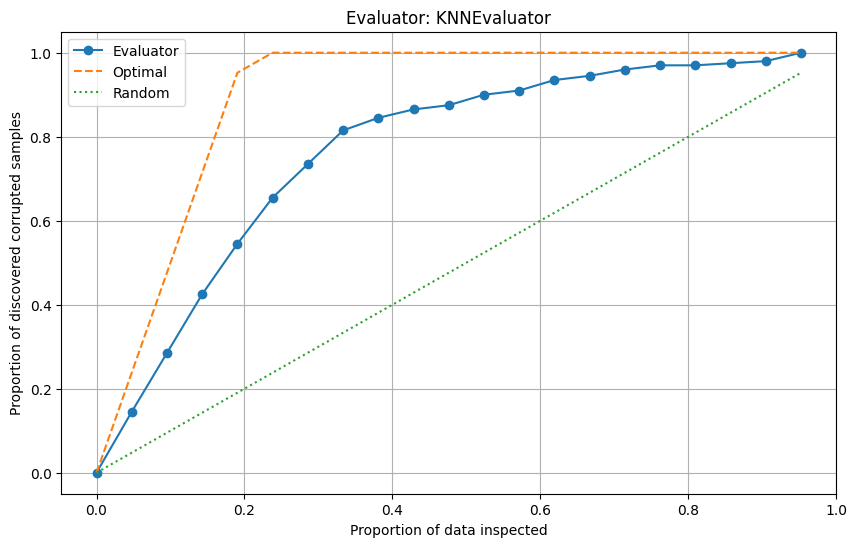

LavaEvaluator: {'found_rates': [0.0, 0.11, 0.2, 0.31, 0.43, 0.565, 0.69, 0.815, 0.835, 0.855, 0.885, 0.905, 0.915, 0.925, 0.94, 0.96, 0.97, 0.98, 0.985, 0.995, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


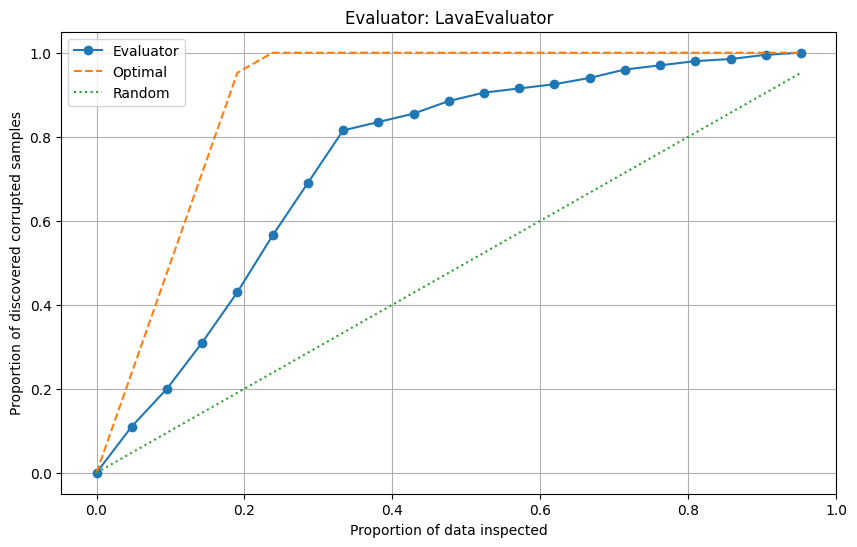

{'KNNEvaluator': {'found_rates': [0.0,
   0.145,
   0.285,
   0.425,
   0.545,
   0.655,
   0.735,
   0.815,
   0.845,
   0.865,
   0.875,
   0.9,
   0.91,
   0.935,
   0.945,
   0.96,
   0.97,
   0.97,
   0.975,
   0.98,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.11,
   0.2,
   0.31,
   0.43,
   0.565,
   0.69,
   0.815,
   0.835,
   0.855,
   0.885,
   0.905,
   0.915,
   0.925,
   0.94,
   0.96,
   0.97,
   0.98,
   0.985,
   0.995,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.0952380

In [14]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [10]:
X,y = download_2dplanes()
print(X.shape,y.shape)

(40768, 10) (40768,)


In [11]:
from datasets import split_data_train_val_test
#X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (20384, 10) Validation: (12230, 10) Test: (8154, 10)
(20384, 10) (12230, 10) (8154, 10)
(20384,) (12230,) (8154,)


In [12]:
# save
import pickle

with open('x_y_embedding_2dplan.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [3]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_2dplan.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train[:2000]
xt_embeddings = X_test[:1000]
y_labels = Y_train[:2000]
yt_labels = Y_test[:1000]

(20384, 10) (12230, 10) (8154, 10)
(20384,) (12230,) (8154,)


In [4]:
import torch
import numpy as np

# Chuyển dữ liệu sang torch.Tensor nếu cần
x_embeddings = torch.tensor(x_embeddings, dtype=torch.float32) if not isinstance(x_embeddings, torch.Tensor) else x_embeddings
xt_embeddings = torch.tensor(xt_embeddings, dtype=torch.float32) if not isinstance(xt_embeddings, torch.Tensor) else xt_embeddings

# Tính giá trị trung bình và độ lệch chuẩn từ X_train
mean = x_embeddings.mean(dim=0)  # Trung bình theo từng cột (feature)
std = x_embeddings.std(dim=0)    # Độ lệch chuẩn theo từng cột (feature)

# Đảm bảo std không có giá trị 0 để tránh chia cho 0
std[std == 0] = 1e-8

# Chuẩn hóa dữ liệu
X_train_normalized = (x_embeddings - mean) / std
X_valid_normalized = (xt_embeddings - mean) / std

# In kết quả
print("After normalization:")
print(X_train_normalized.shape, X_valid_normalized.shape)



After normalization:
torch.Size([2000, 10]) torch.Size([1000, 10])


In [5]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = X_train_normalized.clone()
param = add_gauss_noise(X_copy, X_valid_normalized, noise_rate=0.2)
X_train_normalized_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_normalized_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: torch.Size([2000, 10])
Epoch [10/1000], Loss: 0.5019
Epoch [20/1000], Loss: 0.4960
Epoch [30/1000], Loss: 0.4942
Epoch [40/1000], Loss: 0.4913
Epoch [50/1000], Loss: 0.4891
Epoch [60/1000], Loss: 0.4873
Epoch [70/1000], Loss: 0.4870
Epoch [80/1000], Loss: 0.4846
Epoch [90/1000], Loss: 0.4857
Epoch [100/1000], Loss: 0.4839
Epoch [110/1000], Loss: 0.4832
Epoch [120/1000], Loss: 0.4828
Epoch [130/1000], Loss: 0.4814
Epoch [140/1000], Loss: 0.4819
Epoch [150/1000], Loss: 0.4817
Epoch [160/1000], Loss: 0.4810
Epoch [170/1000], Loss: 0.4804
Epoch [180/1000], Loss: 0.4820
Epoch [190/1000], Loss: 0.4801
Epoch [200/1000], Loss: 0.4805
Epoch [210/1000], Loss: 0.4792
Epoch [220/1000], Loss: 0.4807
Epoch [230/1000], Loss: 0.4791
Epoch [240/1000], Loss: 0.4797
Epoch [250/1000], Loss: 0.4806
Epoch [260/1000], Loss: 0.4796
Epoch [270/1000], Loss: 0.4799
Epoch [280/1000], Loss: 0.4794
Epoch [290/1000], Loss: 0.4782
Epoch [300/1000], Loss: 0.4788
Epoch [310/1000], Loss: 0.4

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:01<00:00, 1891.14it/s]


KNNEvaluator completed in 1.95 seconds.
Running evaluator: LavaEvaluator_geomloss


tensor(0) tensor(0) tensor(0.2702)
tensor(1) tensor(1) tensor(0.2929)
C1 la: tensor([[[ 9.6570,  6.6423, 10.1692,  ...,  7.9250,  9.4119, 11.9236],
         [ 6.0978, 10.3714, 18.7896,  ...,  7.8805, 10.5466, 15.8336],
         [14.6649, 13.1664, 14.1718,  ..., 10.4176,  7.4285,  7.9272],
         ...,
         [ 6.7669,  8.1687, 13.1320,  ...,  9.4287,  9.4205, 10.3177],
         [ 3.0163, 11.9738, 15.4498,  ..., 11.6966,  8.7183, 17.1087],
         [10.4068,  6.5763,  6.6106,  ..., 10.8380,  5.7433, 11.1738]]])
C2 la: tensor([[[0.2702, 0.2702, 0.2702,  ..., 0.2702, 0.2702, 0.2702],
         [0.2702, 0.2702, 0.2702,  ..., 0.2702, 0.2702, 0.2702],
         [4.2260, 4.2260, 4.2260,  ..., 4.2260, 4.2260, 4.2260],
         ...,
         [4.2260, 4.2260, 4.2260,  ..., 4.2260, 4.2260, 4.2260],
         [0.2702, 0.2702, 0.2702,  ..., 0.2702, 0.2702, 0.2702],
         [0.2702, 0.2702, 0.2702,  ..., 0.2702, 0.2702, 0.2702]]])
cost_geoloss: tensor([[[ 9.7921,  6.7774, 10.3043,  ...,  8.0601,  9

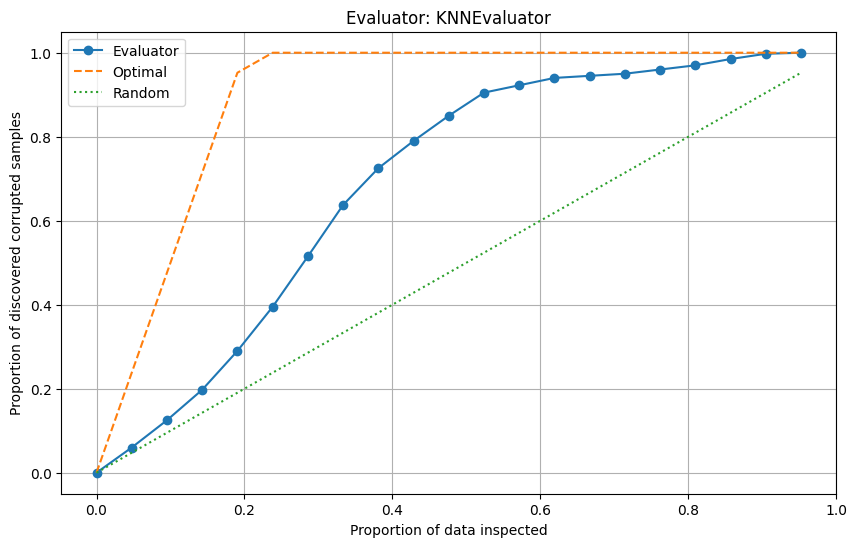

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.25, 0.49, 0.61, 0.705, 0.7525, 0.8, 0.83, 0.8375, 0.8575, 0.8825, 0.8925, 0.9125, 0.9225, 0.9375, 0.945, 0.9475, 0.955, 0.975, 0.9775, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


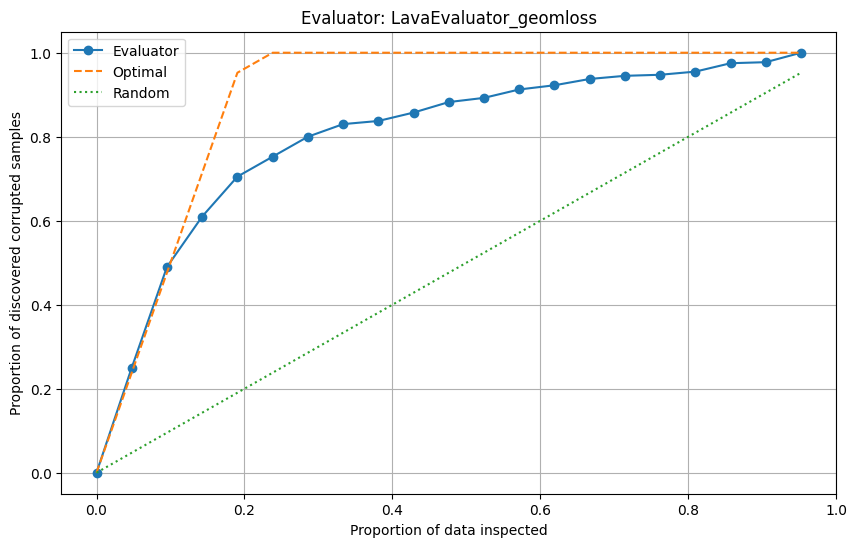

{'KNNEvaluator': {'found_rates': [0.0,
   0.06,
   0.125,
   0.1975,
   0.29,
   0.395,
   0.515,
   0.6375,
   0.725,
   0.79,
   0.85,
   0.905,
   0.9225,
   0.94,
   0.945,
   0.95,
   0.96,
   0.97,
   0.985,
   0.9975,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'LavaEvaluator_geomloss': {'found_rates': [0.0,
   0.25,
   0.49,
   0.61,
   0.705,
   0.7525,
   0.8,
   0.83,
   0.8375,
   0.8575,
   0.8825,
   0.8925,
   0.9125,
   0.9225,
   0.9375,
   0.945,
   0.9475,
   0.955,
   0.975,
   0.9775,
   1.0],
  'axis': [0.0,
   0.047619

In [6]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator_geomloss, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

In [7]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

1000
Noisy training labels shape: (2000,)
Epoch [10/1000], Loss: 0.5937
Epoch [20/1000], Loss: 0.5925
Epoch [30/1000], Loss: 0.5915
Epoch [40/1000], Loss: 0.5918
Epoch [50/1000], Loss: 0.5906
Epoch [60/1000], Loss: 0.5910
Epoch [70/1000], Loss: 0.5890
Epoch [80/1000], Loss: 0.5905
Epoch [90/1000], Loss: 0.5900
Epoch [100/1000], Loss: 0.5894
Epoch [110/1000], Loss: 0.5911
Epoch [120/1000], Loss: 0.5901
Epoch [130/1000], Loss: 0.5879
Epoch [140/1000], Loss: 0.5894
Epoch [150/1000], Loss: 0.5903
Epoch [160/1000], Loss: 0.5889
Epoch [170/1000], Loss: 0.5880
Epoch [180/1000], Loss: 0.5905
Epoch [190/1000], Loss: 0.5887
Epoch [200/1000], Loss: 0.5895
Epoch [210/1000], Loss: 0.5876
Epoch [220/1000], Loss: 0.5883
Epoch [230/1000], Loss: 0.5886
Epoch [240/1000], Loss: 0.5882
Epoch [250/1000], Loss: 0.5886
Epoch [260/1000], Loss: 0.5868
Epoch [270/1000], Loss: 0.5883
Epoch [280/1000], Loss: 0.5883
Epoch [290/1000], Loss: 0.5868
Epoch [300/1000], Loss: 0.5877
Epoch [310/1000], Loss: 0.5880
Epoch 

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:01<00:00, 1805.00it/s]


KNNEvaluator completed in 1.77 seconds.
Running evaluator: CKNNEvaluator


100%|██████████| 1000/1000 [00:00<00:00, 2289.46it/s]


CKNNEvaluator completed in 1.37 seconds.
Running evaluator: LavaEvaluator_geomloss


tensor(0) tensor(0) tensor(0.2286)
tensor(1) tensor(1) tensor(0.2344)


C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.2286, 0.2286, 0.2286,  ..., 0.2286, 0.2286, 0.2286],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189],
         ...,
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189],
         [0.2286, 0.2286, 0.2286,  ..., 0.2286, 0.2286, 0.2286],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189]]])
cost_geoloss: tensor([[[ 9.8496,  6.8541, 10.3459,  ...,  8.1114,  9.6045, 12.1097],
         [11.1963, 11.2257, 14.7175,  ...,  9.4769,  

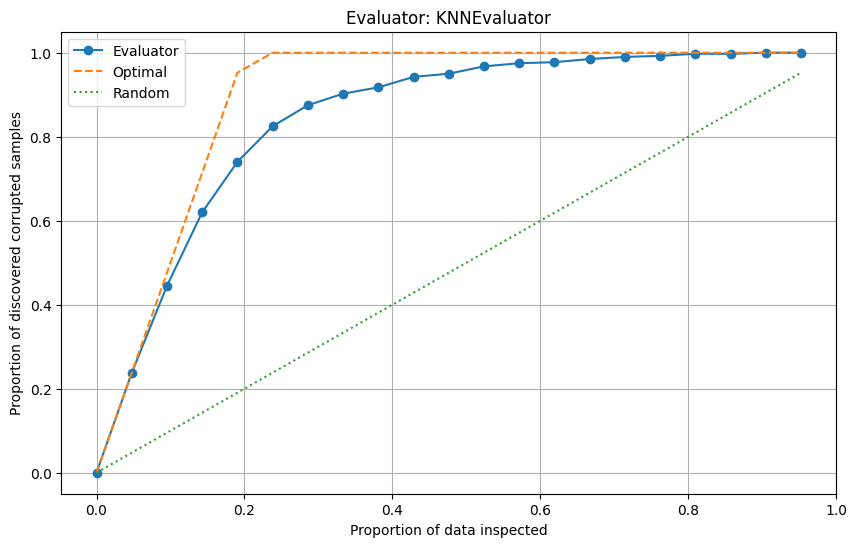

CKNNEvaluator: {'found_rates': [0.0, 0.2375, 0.4425, 0.6225, 0.7475, 0.835, 0.8775, 0.9125, 0.93, 0.945, 0.96, 0.97, 0.9775, 0.98, 0.985, 0.9875, 0.995, 0.9975, 0.9975, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


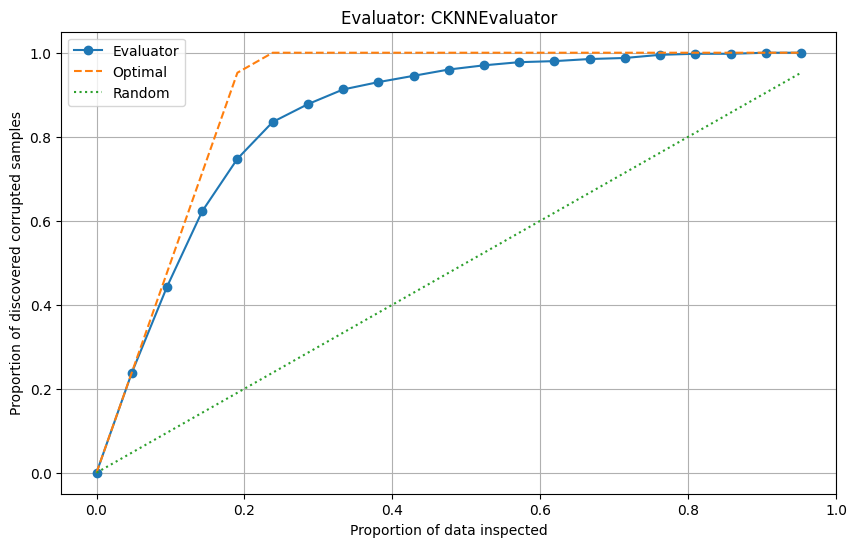

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.13, 0.21, 0.285, 0.3575, 0.41, 0.4625, 0.52, 0.555, 0.5825, 0.62, 0.66, 0.7, 0.7375, 0.7875, 0.83, 0.8775, 0.9125, 0.945, 0.975, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


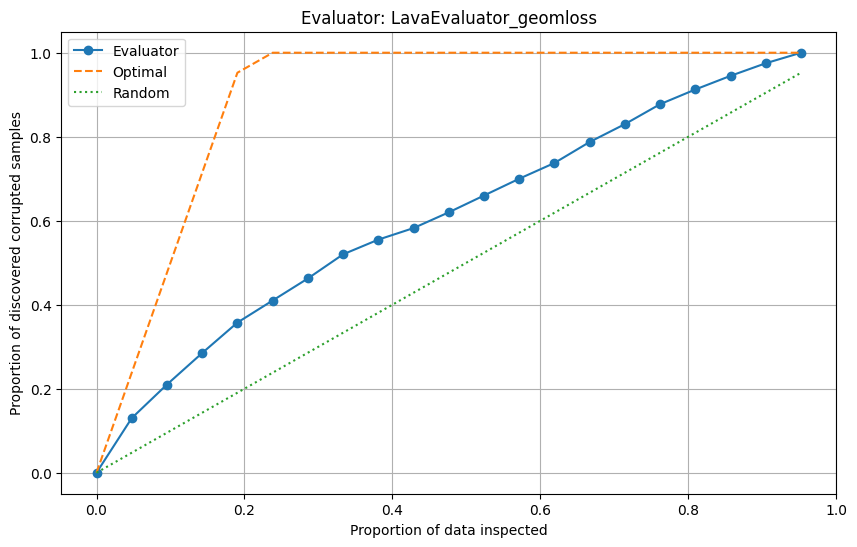

{'KNNEvaluator': {'found_rates': [0.0,
   0.2375,
   0.445,
   0.62,
   0.74,
   0.825,
   0.875,
   0.9025,
   0.9175,
   0.9425,
   0.95,
   0.9675,
   0.975,
   0.9775,
   0.985,
   0.99,
   0.9925,
   0.9975,
   0.9975,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'CKNNEvaluator': {'found_rates': [0.0,
   0.2375,
   0.4425,
   0.6225,
   0.7475,
   0.835,
   0.8775,
   0.9125,
   0.93,
   0.945,
   0.96,
   0.97,
   0.9775,
   0.98,
   0.985,
   0.9875,
   0.995,
   0.9975,
   0.9975,
   1.0,
   1.0],
  'axis': [0.0,
   0.04761904

In [116]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
knn_evaluator = KNNEvaluator()
cknn_evaluator = CKNNEvaluator(T = 20, default=True)
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, cknn_evaluator, lava_evaluator_geomloss])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:00<00:00, 2119.53it/s]


KNNEvaluator completed in 1.56 seconds.
Running evaluator: CKNNEvaluator


100%|██████████| 1000/1000 [00:00<00:00, 2236.80it/s]


CKNNEvaluator completed in 1.27 seconds.
Running evaluator: LavaEvaluator_geomloss


tensor(0) tensor(0) tensor(0.2391)
tensor(1) tensor(1) tensor(0.2419)
C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.2391, 0.2391, 0.2391,  ..., 0.2391, 0.2391, 0.2391],
         [3.3475, 3.3475, 3.3475,  ..., 3.3475, 3.3475, 3.3475],
         [3.3475, 3.3475, 3.3475,  ..., 3.3475, 3.3475, 3.3475],
         ...,
         [3.3475, 3.3475, 3.3475,  ..., 3.3475, 3.3475, 3.3475],
         [0.2391, 0.2391, 0.2391,  ..., 0.2391, 0.2391, 0.2391],
         [3.3475, 3.3475, 3.3475,  ..., 3.3475, 3.3475, 3.3475]]])
cost_geoloss: tensor([[[ 9.8548,  6.8593, 10.3512,  ...,  8.1167,  9

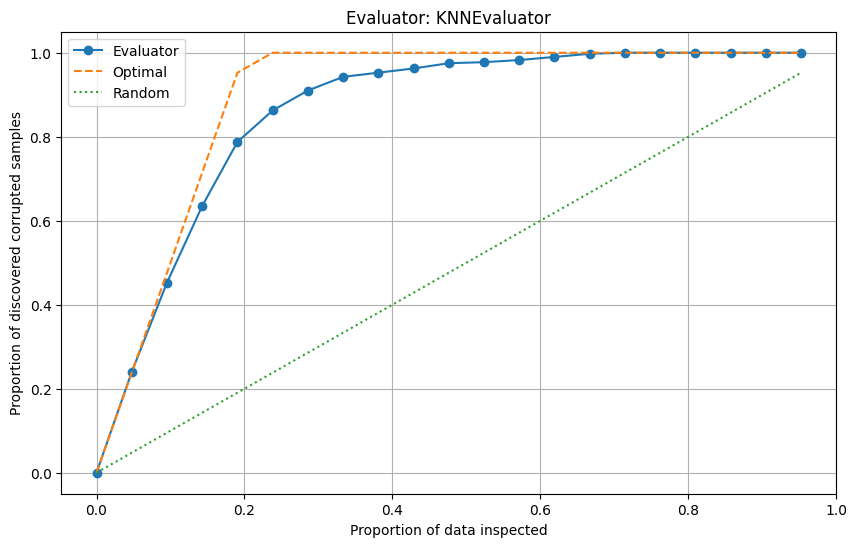

CKNNEvaluator: {'found_rates': [0.0, 0.24, 0.45, 0.635, 0.785, 0.86, 0.9, 0.9375, 0.9475, 0.9625, 0.975, 0.9775, 0.9775, 0.99, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


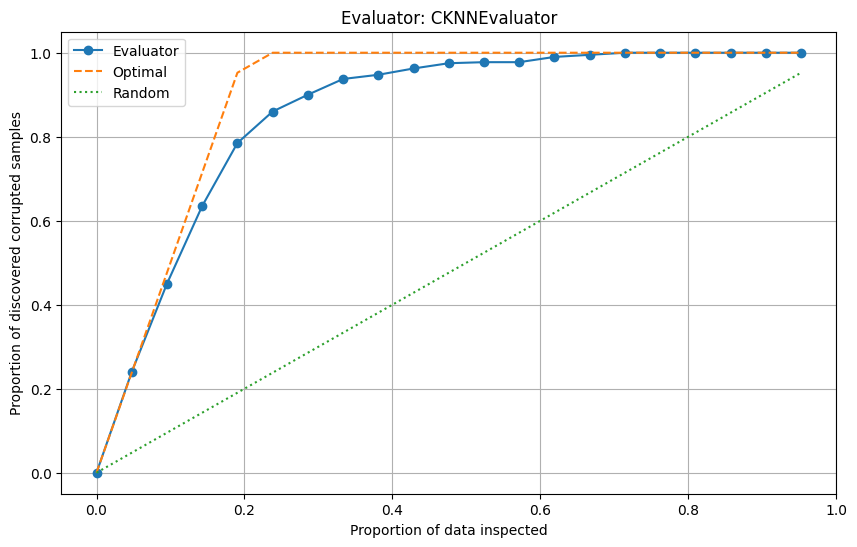

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.21, 0.4, 0.53, 0.63, 0.6925, 0.73, 0.76, 0.7875, 0.8075, 0.8325, 0.86, 0.875, 0.905, 0.9275, 0.9375, 0.955, 0.9775, 0.9875, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


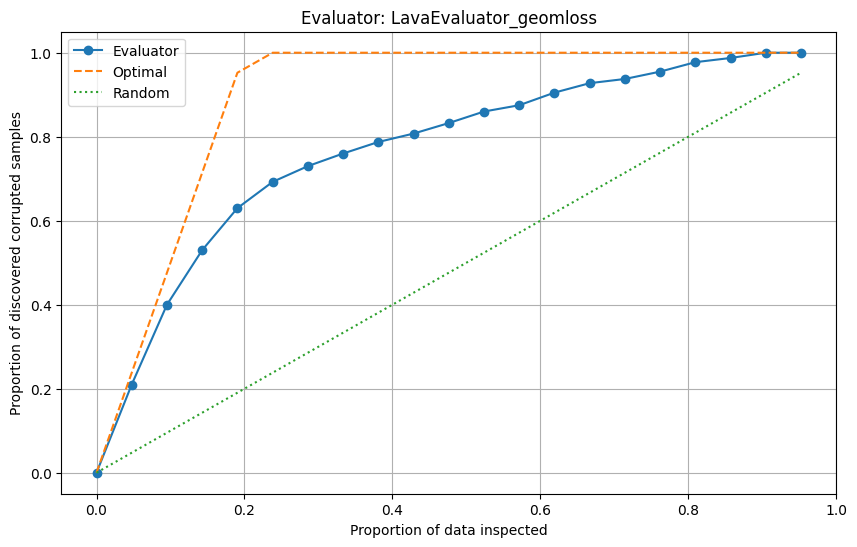

found_in_noisy: [   1    5    6   14   17   18   19   27   30   34   37   39   47   48
   52   54   55   61   66   76   77   80   82   85   92  118  122  124
  133  135  141  145  148  152  156  161  175  182  187  191  202  206
  215  217  220  223  233  240  249  252  254  259  260  262  264  276
  278  279  289  294  298  303  310  317  322  326  333  342  353  360
  361  376  379  384  385  386  393  402  405  427  436  440  443  446
  452  453  458  461  465  475  479  487  491  501  503  506  511  512
  516  519  530  538  557  563  564  572  574  575  587  609  629  634
  638  654  655  658  674  677  682  686  688  689  716  721  723  731
  744  746  758  760  762  773  789  793  794  795  796  811  814  823
  831  839  861  866  878  880  881  883  887  892  896  898  899  900
  906  918  930  933  935  955  962  977  981  982  987  999 1003 1005
 1015 1018 1023 1025 1034 1044 1050 1051 1058 1074 1076 1083 1088 1091
 1093 1101 1110 1121 1127 1132 1135 1148 1150 1158 1165 1174 

{'KNNEvaluator': {'Precision': 0.781021897810219,
  'Recall': 0.8025,
  'F1-Score': 0.7916152897657213},
 'CKNNEvaluator': {'Precision': 0.5843949044585988,
  'Recall': 0.9175,
  'F1-Score': 0.7140077821011673},
 'LavaEvaluator_geomloss': {'Precision': 0.2002002002002002,
  'Recall': 1.0,
  'F1-Score': 0.33361134278565474}}

In [143]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
knn_evaluator = KNNEvaluator()
cknn_evaluator = CKNNEvaluator(T = 20, default=True)
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, cknn_evaluator, lava_evaluator_geomloss])
results = experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)
experiment.calculate_label_noise(noisy_train_indices)

In [144]:
experiment.calculate_label_noise_20(noisy_train_indices)

Found in noisy (TP): [   1    5    6   14   17   18   19   27   30   34   37   39   47   48
   52   54   55   61   66   76   77   80   82   85   92  118  122  124
  133  135  141  145  148  152  156  161  175  182  187  191  202  206
  215  217  220  223  233  240  249  252  254  259  260  262  264  276
  278  279  289  294  298  303  310  317  322  326  333  342  353  360
  361  376  379  384  385  386  393  402  405  427  436  440  443  446
  452  453  458  461  465  475  479  491  501  503  511  512  516  519
  530  538  557  563  564  572  574  575  587  609  629  634  638  654
  655  658  674  677  682  686  688  689  716  721  723  731  744  746
  758  760  762  773  789  793  794  795  796  811  814  823  831  839
  861  866  878  880  881  883  887  892  896  898  899  900  906  918
  930  933  935  955  962  977  981  982  987  999 1003 1005 1015 1018
 1023 1025 1034 1044 1050 1051 1058 1074 1076 1083 1088 1091 1093 1101
 1110 1121 1127 1132 1135 1148 1150 1158 1165 1174 1178 

{'KNNEvaluator': {'Precision': 0.7875, 'Recall': 0.7875, 'F1-Score': 0.7875},
 'CKNNEvaluator': {'Precision': 0.785, 'Recall': 0.785, 'F1-Score': 0.785},
 'LavaEvaluator_geomloss': {'Precision': 0.63,
  'Recall': 0.63,
  'F1-Score': 0.63}}

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:00<00:00, 2256.15it/s]


KNNEvaluator completed in 1.34 seconds.
Running evaluator: CKNNEvaluator


100%|██████████| 1000/1000 [00:00<00:00, 2134.73it/s]


CKNNEvaluator completed in 1.26 seconds.
Running evaluator: LavaEvaluator_geomloss


Computing label-to-label distance:   0%|          | 0/4 [00:00<?, ?it/s]

tensor(0) tensor(0) tensor(0.2903)


tensor(1) tensor(1) tensor(0.2975)
C1 la: tensor([[[ 9.6570,  6.6423, 10.1692,  ...,  7.9250,  9.4119, 11.9236],
         [ 6.0978, 10.3714, 18.7896,  ...,  7.8805, 10.5466, 15.8336],
         [14.6649, 13.1664, 14.1718,  ..., 10.4176,  7.4285,  7.9272],
         ...,
         [ 6.7669,  8.1687, 13.1320,  ...,  9.4287,  9.4205, 10.3177],
         [ 3.0163, 11.9738, 15.4498,  ..., 11.6966,  8.7183, 17.1087],
         [10.4068,  6.5763,  6.6106,  ..., 10.8380,  5.7433, 11.1738]]])
C2 la: tensor([[[0.2903, 0.2903, 0.2903,  ..., 0.2903, 0.2903, 0.2903],
         [0.2903, 0.2903, 0.2903,  ..., 0.2903, 0.2903, 0.2903],
         [3.9271, 3.9271, 3.9271,  ..., 3.9271, 3.9271, 3.9271],
         ...,
         [3.9271, 3.9271, 3.9271,  ..., 3.9271, 3.9271, 3.9271],
         [0.2903, 0.2903, 0.2903,  ..., 0.2903, 0.2903, 0.2903],
         [0.2903, 0.2903, 0.2903,  ..., 0.2903, 0.2903, 0.2903]]])
cost_geoloss: tensor([[[ 9.8022,  6.7875, 10.3144,  ...,  8.0702,  9.5571, 12.0687],
         [ 6.2429,

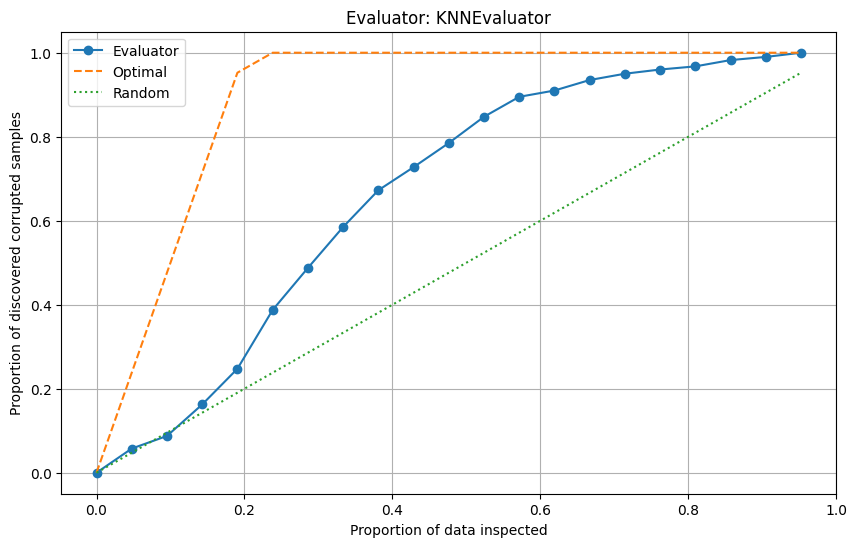

CKNNEvaluator: {'found_rates': [0.0, 0.06, 0.085, 0.145, 0.2175, 0.315, 0.4425, 0.5575, 0.6475, 0.725, 0.785, 0.845, 0.89, 0.9075, 0.92, 0.9475, 0.9625, 0.97, 0.9775, 0.9875, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


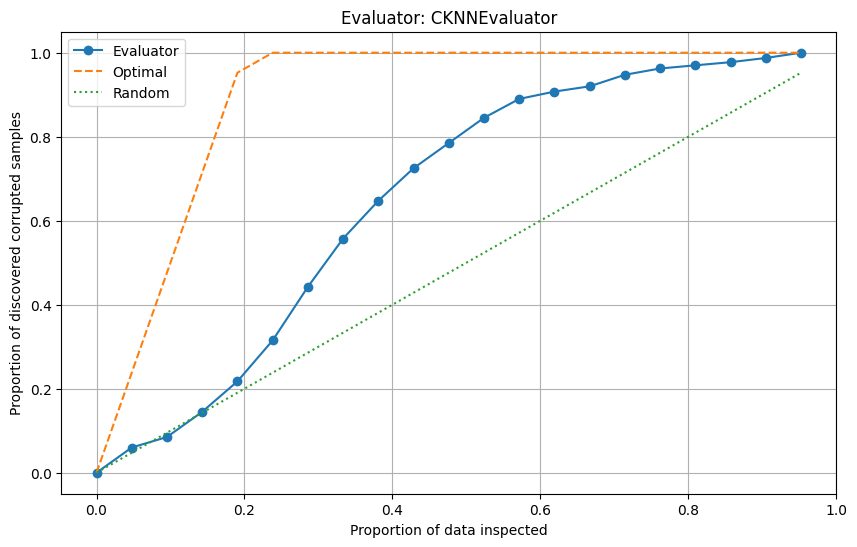

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.25, 0.4875, 0.625, 0.685, 0.7275, 0.76, 0.7875, 0.8125, 0.83, 0.8475, 0.86, 0.8775, 0.895, 0.9175, 0.93, 0.9425, 0.9625, 0.975, 0.985, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


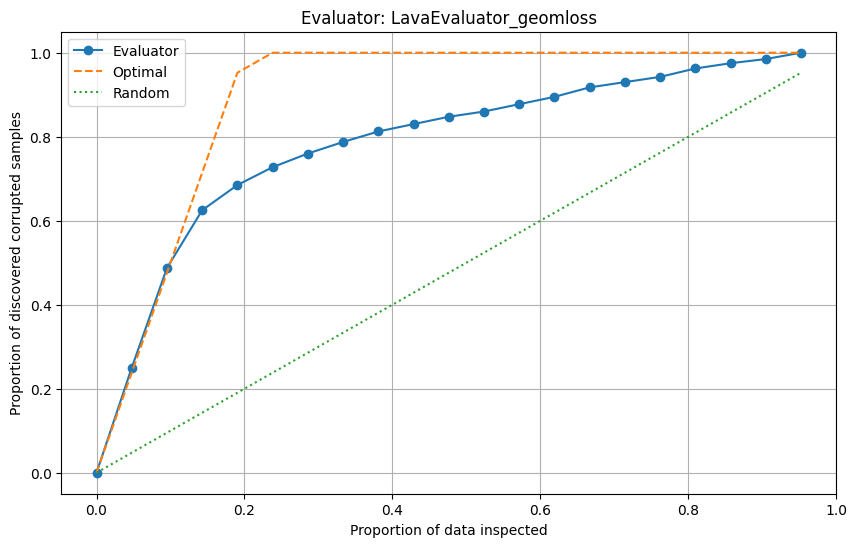

found_in_noisy: [   6   92  107  202  376  438  458  651  794  814  842  896 1124 1135
 1147 1190 1203 1217 1256 1363 1543 1646 1743 1754 1775 1893 1979 1999]
not in noisy but selected: [   4   32   59   73   88  103  119  120  157  158  162  170  198  207
  226  291  340  370  375  396  448  456  481  485  500  508  541  583
  631  670  692  697  702  704  710  715  735  748  764  766  776  798
  809  813  822  830  837  840  850  853  868  904  976  991 1009 1040
 1049 1057 1065 1069 1079 1082 1115 1139 1168 1170 1186 1223 1225 1259
 1267 1293 1300 1301 1307 1310 1433 1477 1494 1519 1537 1581 1585 1636
 1641 1652 1671 1676 1688 1700 1753 1757 1758 1788 1828 1842 1845 1864
 1910 1933 1948 1951 1960 1993]
noisy but not (selected or found in noisy): [   1    5    9   14   17   18   19   27   30   34   37   39   47   48
   52   53   54   55   58   61   66   76   77   80   82   85  113  118
  122  124  133  135  141  144  145  148  152  156  161  175  182  187
  191  200  206  215  217  2

{'KNNEvaluator': {'Precision': 0.21212121212121213,
  'Recall': 0.07,
  'F1-Score': 0.10526315789473686},
 'CKNNEvaluator': {'Precision': 0.2879045996592845,
  'Recall': 0.4225,
  'F1-Score': 0.342451874366768},
 'LavaEvaluator_geomloss': {'Precision': 0.19959677419354838,
  'Recall': 0.99,
  'F1-Score': 0.33221476510067116}}

In [8]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
knn_evaluator = KNNEvaluator()
cknn_evaluator = CKNNEvaluator(T = 20, default=True)
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, cknn_evaluator, lava_evaluator_geomloss])
results = experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)
experiment.calculate_label_noise(noisy_train_indices)

In [12]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_label_noise_20(model, noisy_train_indices, 0.3)

Epoch [10/1000], Loss: 0.4848
Epoch [20/1000], Loss: 0.4377
Epoch [30/1000], Loss: 0.4205
Epoch [40/1000], Loss: 0.4110
Epoch [50/1000], Loss: 0.4055
Epoch [60/1000], Loss: 0.4007
Epoch [70/1000], Loss: 0.3974
Epoch [80/1000], Loss: 0.3948
Epoch [90/1000], Loss: 0.3926
Epoch [100/1000], Loss: 0.3910
Epoch [110/1000], Loss: 0.3897
Epoch [120/1000], Loss: 0.3878
Epoch [130/1000], Loss: 0.3865
Epoch [140/1000], Loss: 0.3856
Epoch [150/1000], Loss: 0.3850
Epoch [160/1000], Loss: 0.3837
Epoch [170/1000], Loss: 0.3830
Epoch [180/1000], Loss: 0.3823
Epoch [190/1000], Loss: 0.3816
Epoch [200/1000], Loss: 0.3811
Epoch [210/1000], Loss: 0.3805
Epoch [220/1000], Loss: 0.3800
Epoch [230/1000], Loss: 0.3793
Epoch [240/1000], Loss: 0.3792
Epoch [250/1000], Loss: 0.3789
Epoch [260/1000], Loss: 0.3784
Epoch [270/1000], Loss: 0.3777
Epoch [280/1000], Loss: 0.3773
Epoch [290/1000], Loss: 0.3770
Epoch [300/1000], Loss: 0.3766
Epoch [310/1000], Loss: 0.3765
Epoch [320/1000], Loss: 0.3761
Epoch [330/1000],

{'KNNEvaluator': {'F1-model': np.float64(0.7556117648496401),
  'Precision': 0.325,
  'Recall': 0.4875,
  'F1-Score': 0.39},
 'CKNNEvaluator': {'F1-model': np.float64(0.7505263285994184),
  'Precision': 0.295,
  'Recall': 0.4425,
  'F1-Score': 0.354},
 'LavaEvaluator_geomloss': {'F1-model': np.float64(0.7615082421736646),
  'Precision': 0.5066666666666667,
  'Recall': 0.76,
  'F1-Score': 0.6080000000000001}}

In [14]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_WAD(model)

Epoch [10/100], Loss: 0.5587
Epoch [20/100], Loss: 0.5270
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5116
Epoch [50/100], Loss: 0.5077
Epoch [60/100], Loss: 0.5050
Epoch [70/100], Loss: 0.5033
Epoch [80/100], Loss: 0.5020
Epoch [90/100], Loss: 0.5012
Epoch [100/100], Loss: 0.4992


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.5004
Epoch [20/100], Loss: 0.4949
Epoch [30/100], Loss: 0.4941
Epoch [40/100], Loss: 0.4893
Epoch [50/100], Loss: 0.4882
Epoch [60/100], Loss: 0.4873
Epoch [70/100], Loss: 0.4852
Epoch [80/100], Loss: 0.4850
Epoch [90/100], Loss: 0.4835


  0%|          | 1/2000 [00:03<2:09:03,  3.87s/it]

Epoch [100/100], Loss: 0.4830
Epoch [10/100], Loss: 0.5012
Epoch [20/100], Loss: 0.4954
Epoch [30/100], Loss: 0.4915
Epoch [40/100], Loss: 0.4908
Epoch [50/100], Loss: 0.4880
Epoch [60/100], Loss: 0.4886
Epoch [70/100], Loss: 0.4861
Epoch [80/100], Loss: 0.4852
Epoch [90/100], Loss: 0.4842


  0%|          | 2/2000 [00:07<2:07:08,  3.82s/it]

Epoch [100/100], Loss: 0.4837
Epoch [10/100], Loss: 0.5010
Epoch [20/100], Loss: 0.4965
Epoch [30/100], Loss: 0.4923
Epoch [40/100], Loss: 0.4913
Epoch [50/100], Loss: 0.4884
Epoch [60/100], Loss: 0.4874
Epoch [70/100], Loss: 0.4859
Epoch [80/100], Loss: 0.4849
Epoch [90/100], Loss: 0.4837


  0%|          | 3/2000 [00:11<2:09:11,  3.88s/it]

Epoch [100/100], Loss: 0.4833
Epoch [10/100], Loss: 0.5004
Epoch [20/100], Loss: 0.4946
Epoch [30/100], Loss: 0.4908
Epoch [40/100], Loss: 0.4896
Epoch [50/100], Loss: 0.4872
Epoch [60/100], Loss: 0.4861
Epoch [70/100], Loss: 0.4861
Epoch [80/100], Loss: 0.4830
Epoch [90/100], Loss: 0.4848


  0%|          | 4/2000 [00:15<2:10:11,  3.91s/it]

Epoch [100/100], Loss: 0.4834
Epoch [10/100], Loss: 0.5033
Epoch [20/100], Loss: 0.4956
Epoch [30/100], Loss: 0.4940
Epoch [40/100], Loss: 0.4905
Epoch [50/100], Loss: 0.4869
Epoch [60/100], Loss: 0.4860
Epoch [70/100], Loss: 0.4852
Epoch [80/100], Loss: 0.4865
Epoch [90/100], Loss: 0.4851


  0%|          | 5/2000 [00:19<2:12:41,  3.99s/it]

Epoch [100/100], Loss: 0.4835
Epoch [10/100], Loss: 0.5019
Epoch [20/100], Loss: 0.4965
Epoch [30/100], Loss: 0.4906
Epoch [40/100], Loss: 0.4889
Epoch [50/100], Loss: 0.4891
Epoch [60/100], Loss: 0.4847
Epoch [70/100], Loss: 0.4849
Epoch [80/100], Loss: 0.4839
Epoch [90/100], Loss: 0.4837


  0%|          | 6/2000 [00:23<2:12:02,  3.97s/it]

Epoch [100/100], Loss: 0.4816
Epoch [10/100], Loss: 0.5008
Epoch [20/100], Loss: 0.4938
Epoch [30/100], Loss: 0.4904
Epoch [40/100], Loss: 0.4894
Epoch [50/100], Loss: 0.4890
Epoch [60/100], Loss: 0.4893
Epoch [70/100], Loss: 0.4845
Epoch [80/100], Loss: 0.4844
Epoch [90/100], Loss: 0.4832


  0%|          | 7/2000 [00:27<2:15:36,  4.08s/it]

Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5022
Epoch [20/100], Loss: 0.4958
Epoch [30/100], Loss: 0.4913
Epoch [40/100], Loss: 0.4880
Epoch [50/100], Loss: 0.4879
Epoch [60/100], Loss: 0.4865
Epoch [70/100], Loss: 0.4863
Epoch [80/100], Loss: 0.4858
Epoch [90/100], Loss: 0.4825


  0%|          | 8/2000 [00:32<2:20:15,  4.22s/it]

Epoch [100/100], Loss: 0.4844
Epoch [10/100], Loss: 0.5023
Epoch [20/100], Loss: 0.4960
Epoch [30/100], Loss: 0.4909
Epoch [40/100], Loss: 0.4882
Epoch [50/100], Loss: 0.4861
Epoch [60/100], Loss: 0.4861
Epoch [70/100], Loss: 0.4864
Epoch [80/100], Loss: 0.4852
Epoch [90/100], Loss: 0.4829


  0%|          | 9/2000 [00:36<2:19:57,  4.22s/it]

Epoch [100/100], Loss: 0.4838
Epoch [10/100], Loss: 0.5024
Epoch [20/100], Loss: 0.4948
Epoch [30/100], Loss: 0.4924
Epoch [40/100], Loss: 0.4902
Epoch [50/100], Loss: 0.4875
Epoch [60/100], Loss: 0.4880
Epoch [70/100], Loss: 0.4861
Epoch [80/100], Loss: 0.4853
Epoch [90/100], Loss: 0.4844


  0%|          | 10/2000 [00:41<2:23:38,  4.33s/it]

Epoch [100/100], Loss: 0.4842
Epoch [10/100], Loss: 0.5019
Epoch [20/100], Loss: 0.4963
Epoch [30/100], Loss: 0.4901
Epoch [40/100], Loss: 0.4908
Epoch [50/100], Loss: 0.4881
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4890
Epoch [80/100], Loss: 0.4868
Epoch [90/100], Loss: 0.4885


  1%|          | 11/2000 [00:45<2:24:35,  4.36s/it]

Epoch [100/100], Loss: 0.4880
Epoch [10/100], Loss: 0.5000
Epoch [20/100], Loss: 0.5001
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4912
Epoch [50/100], Loss: 0.4860
Epoch [60/100], Loss: 0.4886
Epoch [70/100], Loss: 0.4837
Epoch [80/100], Loss: 0.4897
Epoch [90/100], Loss: 0.4834


  1%|          | 12/2000 [00:50<2:24:26,  4.36s/it]

Epoch [100/100], Loss: 0.4816
Epoch [10/100], Loss: 0.5020
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4881
Epoch [50/100], Loss: 0.4859
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4844
Epoch [80/100], Loss: 0.4881
Epoch [90/100], Loss: 0.4872


  1%|          | 13/2000 [00:54<2:23:21,  4.33s/it]

Epoch [100/100], Loss: 0.4815
Epoch [10/100], Loss: 0.5020
Epoch [20/100], Loss: 0.4938
Epoch [30/100], Loss: 0.4964
Epoch [40/100], Loss: 0.4883
Epoch [50/100], Loss: 0.4873
Epoch [60/100], Loss: 0.4932
Epoch [70/100], Loss: 0.4921
Epoch [80/100], Loss: 0.4904
Epoch [90/100], Loss: 0.4897


  1%|          | 14/2000 [00:58<2:20:14,  4.24s/it]

Epoch [100/100], Loss: 0.4817
Epoch [10/100], Loss: 0.4994
Epoch [20/100], Loss: 0.4943
Epoch [30/100], Loss: 0.4904
Epoch [40/100], Loss: 0.4882
Epoch [50/100], Loss: 0.4863
Epoch [60/100], Loss: 0.4948
Epoch [70/100], Loss: 0.4837
Epoch [80/100], Loss: 0.4872
Epoch [90/100], Loss: 0.4837


  1%|          | 15/2000 [01:02<2:19:11,  4.21s/it]

Epoch [100/100], Loss: 0.4816
Epoch [10/100], Loss: 0.5022
Epoch [20/100], Loss: 0.4964
Epoch [30/100], Loss: 0.4931
Epoch [40/100], Loss: 0.4907
Epoch [50/100], Loss: 0.4889
Epoch [60/100], Loss: 0.4875
Epoch [70/100], Loss: 0.4865
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4849


  1%|          | 16/2000 [01:06<2:17:17,  4.15s/it]

Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5023
Epoch [20/100], Loss: 0.4966
Epoch [30/100], Loss: 0.4932
Epoch [40/100], Loss: 0.4908
Epoch [50/100], Loss: 0.4890
Epoch [60/100], Loss: 0.4876
Epoch [70/100], Loss: 0.4865
Epoch [80/100], Loss: 0.4857
Epoch [90/100], Loss: 0.4849


  1%|          | 17/2000 [01:10<2:15:41,  4.11s/it]

Epoch [100/100], Loss: 0.4844
Epoch [10/100], Loss: 0.5024
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4909
Epoch [50/100], Loss: 0.4891
Epoch [60/100], Loss: 0.4877
Epoch [70/100], Loss: 0.4865
Epoch [80/100], Loss: 0.4858
Epoch [90/100], Loss: 0.4850


  1%|          | 18/2000 [01:14<2:14:10,  4.06s/it]

Epoch [100/100], Loss: 0.4844
Epoch [10/100], Loss: 0.5024
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4911
Epoch [50/100], Loss: 0.4891
Epoch [60/100], Loss: 0.4878
Epoch [70/100], Loss: 0.4867
Epoch [80/100], Loss: 0.4858
Epoch [90/100], Loss: 0.4851


  1%|          | 19/2000 [01:18<2:14:04,  4.06s/it]

Epoch [100/100], Loss: 0.4844
Epoch [10/100], Loss: 0.5025
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4934
Epoch [40/100], Loss: 0.4909
Epoch [50/100], Loss: 0.4893
Epoch [60/100], Loss: 0.4880
Epoch [70/100], Loss: 0.4866
Epoch [80/100], Loss: 0.4859
Epoch [90/100], Loss: 0.4853


  1%|          | 20/2000 [01:22<2:14:07,  4.06s/it]

Epoch [100/100], Loss: 0.4846
Epoch [10/100], Loss: 0.5026
Epoch [20/100], Loss: 0.4969
Epoch [30/100], Loss: 0.4934
Epoch [40/100], Loss: 0.4912
Epoch [50/100], Loss: 0.4894
Epoch [60/100], Loss: 0.4878
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4860
Epoch [90/100], Loss: 0.4852


  1%|          | 21/2000 [01:26<2:13:09,  4.04s/it]

Epoch [100/100], Loss: 0.4848
Epoch [10/100], Loss: 0.5026
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4936
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4893
Epoch [60/100], Loss: 0.4881
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4862
Epoch [90/100], Loss: 0.4855


  1%|          | 22/2000 [01:30<2:12:35,  4.02s/it]

Epoch [100/100], Loss: 0.4848
Epoch [10/100], Loss: 0.5029
Epoch [20/100], Loss: 0.4971
Epoch [30/100], Loss: 0.4932
Epoch [40/100], Loss: 0.4911
Epoch [50/100], Loss: 0.4895
Epoch [60/100], Loss: 0.4880
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4861
Epoch [90/100], Loss: 0.4852


  1%|          | 23/2000 [01:34<2:12:47,  4.03s/it]

Epoch [100/100], Loss: 0.4846
Epoch [10/100], Loss: 0.5029
Epoch [20/100], Loss: 0.4972
Epoch [30/100], Loss: 0.4938
Epoch [40/100], Loss: 0.4911
Epoch [50/100], Loss: 0.4897
Epoch [60/100], Loss: 0.4882
Epoch [70/100], Loss: 0.4872
Epoch [80/100], Loss: 0.4861
Epoch [90/100], Loss: 0.4853


  1%|          | 24/2000 [01:38<2:12:34,  4.03s/it]

Epoch [100/100], Loss: 0.4850
Epoch [10/100], Loss: 0.5028
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4935
Epoch [40/100], Loss: 0.4917
Epoch [50/100], Loss: 0.4893
Epoch [60/100], Loss: 0.4879
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4859
Epoch [90/100], Loss: 0.4855


  1%|▏         | 25/2000 [01:42<2:12:08,  4.01s/it]

Epoch [100/100], Loss: 0.4852
Epoch [10/100], Loss: 0.5031
Epoch [20/100], Loss: 0.4973
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4916
Epoch [50/100], Loss: 0.4898
Epoch [60/100], Loss: 0.4883
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4861
Epoch [90/100], Loss: 0.4856


  1%|▏         | 26/2000 [01:46<2:13:06,  4.05s/it]

Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5034
Epoch [20/100], Loss: 0.4973
Epoch [30/100], Loss: 0.4939
Epoch [40/100], Loss: 0.4913
Epoch [50/100], Loss: 0.4898
Epoch [60/100], Loss: 0.4891
Epoch [70/100], Loss: 0.4866
Epoch [80/100], Loss: 0.4865
Epoch [90/100], Loss: 0.4857


  1%|▏         | 27/2000 [01:50<2:12:47,  4.04s/it]

Epoch [100/100], Loss: 0.4852
Epoch [10/100], Loss: 0.5034
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4942
Epoch [40/100], Loss: 0.4919
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4883
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4866
Epoch [90/100], Loss: 0.4856


  1%|▏         | 28/2000 [01:54<2:14:56,  4.11s/it]

Epoch [100/100], Loss: 0.4850
Epoch [10/100], Loss: 0.5043
Epoch [20/100], Loss: 0.4973
Epoch [30/100], Loss: 0.4951
Epoch [40/100], Loss: 0.4916
Epoch [50/100], Loss: 0.4900
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4868
Epoch [80/100], Loss: 0.4870
Epoch [90/100], Loss: 0.4866


  1%|▏         | 29/2000 [01:59<2:14:02,  4.08s/it]

Epoch [100/100], Loss: 0.4851
Epoch [10/100], Loss: 0.5032
Epoch [20/100], Loss: 0.4970
Epoch [30/100], Loss: 0.4940
Epoch [40/100], Loss: 0.4916
Epoch [50/100], Loss: 0.4898
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4887
Epoch [80/100], Loss: 0.4883
Epoch [90/100], Loss: 0.4865


  2%|▏         | 30/2000 [02:03<2:16:35,  4.16s/it]

Epoch [100/100], Loss: 0.4858
Epoch [10/100], Loss: 0.5045
Epoch [20/100], Loss: 0.4975
Epoch [30/100], Loss: 0.4941
Epoch [40/100], Loss: 0.4925
Epoch [50/100], Loss: 0.4901
Epoch [60/100], Loss: 0.4883
Epoch [70/100], Loss: 0.4872
Epoch [80/100], Loss: 0.4857
Epoch [90/100], Loss: 0.4870


  2%|▏         | 31/2000 [02:07<2:17:15,  4.18s/it]

Epoch [100/100], Loss: 0.4858
Epoch [10/100], Loss: 0.5038
Epoch [20/100], Loss: 0.4975
Epoch [30/100], Loss: 0.4945
Epoch [40/100], Loss: 0.4927
Epoch [50/100], Loss: 0.4902
Epoch [60/100], Loss: 0.4902
Epoch [70/100], Loss: 0.4882
Epoch [80/100], Loss: 0.4871
Epoch [90/100], Loss: 0.4850


  2%|▏         | 32/2000 [02:11<2:14:43,  4.11s/it]

Epoch [100/100], Loss: 0.4852
Epoch [10/100], Loss: 0.5028
Epoch [20/100], Loss: 0.4976
Epoch [30/100], Loss: 0.4948
Epoch [40/100], Loss: 0.4919
Epoch [50/100], Loss: 0.4892
Epoch [60/100], Loss: 0.4889
Epoch [70/100], Loss: 0.4890
Epoch [80/100], Loss: 0.4866
Epoch [90/100], Loss: 0.4866


  2%|▏         | 33/2000 [02:15<2:13:22,  4.07s/it]

Epoch [100/100], Loss: 0.4884
Epoch [10/100], Loss: 0.5038
Epoch [20/100], Loss: 0.4984
Epoch [30/100], Loss: 0.4943
Epoch [40/100], Loss: 0.4924
Epoch [50/100], Loss: 0.4895
Epoch [60/100], Loss: 0.4889
Epoch [70/100], Loss: 0.4889
Epoch [80/100], Loss: 0.4858
Epoch [90/100], Loss: 0.4870


  2%|▏         | 34/2000 [02:19<2:13:07,  4.06s/it]

Epoch [100/100], Loss: 0.4845
Epoch [10/100], Loss: 0.5040
Epoch [20/100], Loss: 0.4978
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4924
Epoch [50/100], Loss: 0.4901
Epoch [60/100], Loss: 0.4905
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4849


  2%|▏         | 35/2000 [02:23<2:15:02,  4.12s/it]

Epoch [100/100], Loss: 0.4890
Epoch [10/100], Loss: 0.5039
Epoch [20/100], Loss: 0.4977
Epoch [30/100], Loss: 0.4939
Epoch [40/100], Loss: 0.4917
Epoch [50/100], Loss: 0.4896
Epoch [60/100], Loss: 0.4878
Epoch [70/100], Loss: 0.4882
Epoch [80/100], Loss: 0.4886
Epoch [90/100], Loss: 0.4850


  2%|▏         | 36/2000 [02:27<2:13:53,  4.09s/it]

Epoch [100/100], Loss: 0.4860
Epoch [10/100], Loss: 0.5044
Epoch [20/100], Loss: 0.4975
Epoch [30/100], Loss: 0.4945
Epoch [40/100], Loss: 0.4922
Epoch [50/100], Loss: 0.4918
Epoch [60/100], Loss: 0.4881
Epoch [70/100], Loss: 0.4873
Epoch [80/100], Loss: 0.4888
Epoch [90/100], Loss: 0.4868


  2%|▏         | 37/2000 [02:31<2:13:02,  4.07s/it]

Epoch [100/100], Loss: 0.4850
Epoch [10/100], Loss: 0.5035
Epoch [20/100], Loss: 0.4973
Epoch [30/100], Loss: 0.4935
Epoch [40/100], Loss: 0.4930
Epoch [50/100], Loss: 0.4922
Epoch [60/100], Loss: 0.4882
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4877


  2%|▏         | 38/2000 [02:36<2:15:33,  4.15s/it]

Epoch [100/100], Loss: 0.4850
Epoch [10/100], Loss: 0.5055
Epoch [20/100], Loss: 0.4981
Epoch [30/100], Loss: 0.4941
Epoch [40/100], Loss: 0.4926
Epoch [50/100], Loss: 0.4908
Epoch [60/100], Loss: 0.4922
Epoch [70/100], Loss: 0.4886
Epoch [80/100], Loss: 0.4881
Epoch [90/100], Loss: 0.4870


  2%|▏         | 39/2000 [02:40<2:13:17,  4.08s/it]

Epoch [100/100], Loss: 0.4872
Epoch [10/100], Loss: 0.5034
Epoch [20/100], Loss: 0.4982
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4910
Epoch [50/100], Loss: 0.4906
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4891
Epoch [80/100], Loss: 0.4902
Epoch [90/100], Loss: 0.4868


  2%|▏         | 40/2000 [02:44<2:15:59,  4.16s/it]

Epoch [100/100], Loss: 0.4856
Epoch [10/100], Loss: 0.5050
Epoch [20/100], Loss: 0.4981
Epoch [30/100], Loss: 0.4958
Epoch [40/100], Loss: 0.4905
Epoch [50/100], Loss: 0.4908
Epoch [60/100], Loss: 0.4871
Epoch [70/100], Loss: 0.4896
Epoch [80/100], Loss: 0.4868
Epoch [90/100], Loss: 0.4896


  2%|▏         | 41/2000 [02:48<2:15:01,  4.14s/it]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5035
Epoch [20/100], Loss: 0.4988
Epoch [30/100], Loss: 0.4937
Epoch [40/100], Loss: 0.4920
Epoch [50/100], Loss: 0.4888
Epoch [60/100], Loss: 0.4908
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4887


  2%|▏         | 42/2000 [02:53<2:22:26,  4.36s/it]

Epoch [100/100], Loss: 0.4860
Epoch [10/100], Loss: 0.5030
Epoch [20/100], Loss: 0.4979
Epoch [30/100], Loss: 0.4958
Epoch [40/100], Loss: 0.4917
Epoch [50/100], Loss: 0.4910
Epoch [60/100], Loss: 0.4888
Epoch [70/100], Loss: 0.4878
Epoch [80/100], Loss: 0.4860
Epoch [90/100], Loss: 0.4845


  2%|▏         | 43/2000 [03:03<3:18:57,  6.10s/it]

Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5050
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4953
Epoch [40/100], Loss: 0.4906
Epoch [50/100], Loss: 0.4885
Epoch [60/100], Loss: 0.4868
Epoch [70/100], Loss: 0.4853
Epoch [80/100], Loss: 0.4862
Epoch [90/100], Loss: 0.4908


  2%|▏         | 44/2000 [03:10<3:25:06,  6.29s/it]

Epoch [100/100], Loss: 0.4900
Epoch [10/100], Loss: 0.5096
Epoch [20/100], Loss: 0.4956
Epoch [30/100], Loss: 0.4922
Epoch [40/100], Loss: 0.4948
Epoch [50/100], Loss: 0.4885
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4853
Epoch [80/100], Loss: 0.4895
Epoch [90/100], Loss: 0.4892


  2%|▏         | 45/2000 [03:17<3:33:02,  6.54s/it]

Epoch [100/100], Loss: 0.4839
Epoch [10/100], Loss: 0.5017
Epoch [20/100], Loss: 0.4982
Epoch [30/100], Loss: 0.5001
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4871
Epoch [60/100], Loss: 0.4904
Epoch [70/100], Loss: 0.4846
Epoch [80/100], Loss: 0.4838
Epoch [90/100], Loss: 0.4831


  2%|▏         | 46/2000 [03:23<3:30:35,  6.47s/it]

Epoch [100/100], Loss: 0.4903
Epoch [10/100], Loss: 0.5149
Epoch [20/100], Loss: 0.4988
Epoch [30/100], Loss: 0.4912
Epoch [40/100], Loss: 0.5008
Epoch [50/100], Loss: 0.4871
Epoch [60/100], Loss: 0.4856
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4837
Epoch [90/100], Loss: 0.4832


  2%|▏         | 47/2000 [03:29<3:27:14,  6.37s/it]

Epoch [100/100], Loss: 0.4981
Epoch [10/100], Loss: 0.5043
Epoch [20/100], Loss: 0.4980
Epoch [30/100], Loss: 0.4943
Epoch [40/100], Loss: 0.4918
Epoch [50/100], Loss: 0.4900
Epoch [60/100], Loss: 0.4886
Epoch [70/100], Loss: 0.4875
Epoch [80/100], Loss: 0.4867
Epoch [90/100], Loss: 0.4860


  2%|▏         | 48/2000 [03:35<3:20:01,  6.15s/it]

Epoch [100/100], Loss: 0.4854
Epoch [10/100], Loss: 0.5043
Epoch [20/100], Loss: 0.4981
Epoch [30/100], Loss: 0.4945
Epoch [40/100], Loss: 0.4918
Epoch [50/100], Loss: 0.4901
Epoch [60/100], Loss: 0.4887
Epoch [70/100], Loss: 0.4877
Epoch [80/100], Loss: 0.4867
Epoch [90/100], Loss: 0.4860


  2%|▏         | 49/2000 [03:41<3:14:06,  5.97s/it]

Epoch [100/100], Loss: 0.4855
Epoch [10/100], Loss: 0.5044
Epoch [20/100], Loss: 0.4981
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4920
Epoch [50/100], Loss: 0.4902
Epoch [60/100], Loss: 0.4887
Epoch [70/100], Loss: 0.4877
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4863


  2%|▎         | 50/2000 [03:47<3:15:51,  6.03s/it]

Epoch [100/100], Loss: 0.4855
Epoch [10/100], Loss: 0.5045
Epoch [20/100], Loss: 0.4983
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4902
Epoch [60/100], Loss: 0.4888
Epoch [70/100], Loss: 0.4878
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4861


  3%|▎         | 51/2000 [03:53<3:17:48,  6.09s/it]

Epoch [100/100], Loss: 0.4856
Epoch [10/100], Loss: 0.5046
Epoch [20/100], Loss: 0.4983
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4891
Epoch [70/100], Loss: 0.4879
Epoch [80/100], Loss: 0.4871
Epoch [90/100], Loss: 0.4862


  3%|▎         | 52/2000 [03:57<3:00:49,  5.57s/it]

Epoch [100/100], Loss: 0.4855
Epoch [10/100], Loss: 0.5048
Epoch [20/100], Loss: 0.4985
Epoch [30/100], Loss: 0.4948
Epoch [40/100], Loss: 0.4920
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4889
Epoch [70/100], Loss: 0.4881
Epoch [80/100], Loss: 0.4872
Epoch [90/100], Loss: 0.4866


  3%|▎         | 53/2000 [04:02<2:48:11,  5.18s/it]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5047
Epoch [20/100], Loss: 0.4988
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4923
Epoch [50/100], Loss: 0.4904
Epoch [60/100], Loss: 0.4891
Epoch [70/100], Loss: 0.4878
Epoch [80/100], Loss: 0.4875
Epoch [90/100], Loss: 0.4865


  3%|▎         | 54/2000 [04:06<2:39:22,  4.91s/it]

Epoch [100/100], Loss: 0.4857
Epoch [10/100], Loss: 0.5052
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.4951
Epoch [40/100], Loss: 0.4924
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4896
Epoch [70/100], Loss: 0.4886
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4869


  3%|▎         | 55/2000 [04:10<2:31:56,  4.69s/it]

Epoch [100/100], Loss: 0.4861
Epoch [10/100], Loss: 0.5051
Epoch [20/100], Loss: 0.4983
Epoch [30/100], Loss: 0.4950
Epoch [40/100], Loss: 0.4924
Epoch [50/100], Loss: 0.4911
Epoch [60/100], Loss: 0.4897
Epoch [70/100], Loss: 0.4884
Epoch [80/100], Loss: 0.4871
Epoch [90/100], Loss: 0.4867


  3%|▎         | 56/2000 [04:14<2:26:59,  4.54s/it]

Epoch [100/100], Loss: 0.4855
Epoch [10/100], Loss: 0.5050
Epoch [20/100], Loss: 0.4988
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4925
Epoch [50/100], Loss: 0.4906
Epoch [60/100], Loss: 0.4893
Epoch [70/100], Loss: 0.4891
Epoch [80/100], Loss: 0.4876
Epoch [90/100], Loss: 0.4862


  3%|▎         | 57/2000 [04:18<2:23:05,  4.42s/it]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5054
Epoch [20/100], Loss: 0.4989
Epoch [30/100], Loss: 0.4950
Epoch [40/100], Loss: 0.4930
Epoch [50/100], Loss: 0.4911
Epoch [60/100], Loss: 0.4890
Epoch [70/100], Loss: 0.4883
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4861


  3%|▎         | 58/2000 [04:22<2:20:07,  4.33s/it]

Epoch [100/100], Loss: 0.4867
Epoch [10/100], Loss: 0.5052
Epoch [20/100], Loss: 0.4993
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4902
Epoch [60/100], Loss: 0.4896
Epoch [70/100], Loss: 0.4886
Epoch [80/100], Loss: 0.4874
Epoch [90/100], Loss: 0.4867


  3%|▎         | 59/2000 [04:27<2:18:28,  4.28s/it]

Epoch [100/100], Loss: 0.4863
Epoch [10/100], Loss: 0.5055
Epoch [20/100], Loss: 0.4997
Epoch [30/100], Loss: 0.4949
Epoch [40/100], Loss: 0.4933
Epoch [50/100], Loss: 0.4908
Epoch [60/100], Loss: 0.4903
Epoch [70/100], Loss: 0.4883
Epoch [80/100], Loss: 0.4884
Epoch [90/100], Loss: 0.4867


  3%|▎         | 60/2000 [04:31<2:16:42,  4.23s/it]

Epoch [100/100], Loss: 0.4861
Epoch [10/100], Loss: 0.5046
Epoch [20/100], Loss: 0.4995
Epoch [30/100], Loss: 0.4955
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4907
Epoch [60/100], Loss: 0.4898
Epoch [70/100], Loss: 0.4880
Epoch [80/100], Loss: 0.4883
Epoch [90/100], Loss: 0.4875


  3%|▎         | 61/2000 [04:35<2:15:53,  4.20s/it]

Epoch [100/100], Loss: 0.4866
Epoch [10/100], Loss: 0.5055
Epoch [20/100], Loss: 0.4995
Epoch [30/100], Loss: 0.4954
Epoch [40/100], Loss: 0.4920
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4901
Epoch [70/100], Loss: 0.4894
Epoch [80/100], Loss: 0.4873
Epoch [90/100], Loss: 0.4865


  3%|▎         | 62/2000 [04:39<2:15:27,  4.19s/it]

Epoch [100/100], Loss: 0.4874
Epoch [10/100], Loss: 0.5059
Epoch [20/100], Loss: 0.4993
Epoch [30/100], Loss: 0.4959
Epoch [40/100], Loss: 0.4926
Epoch [50/100], Loss: 0.4919
Epoch [60/100], Loss: 0.4899
Epoch [70/100], Loss: 0.4888
Epoch [80/100], Loss: 0.4892
Epoch [90/100], Loss: 0.4873


  3%|▎         | 63/2000 [04:43<2:13:54,  4.15s/it]

Epoch [100/100], Loss: 0.4861
Epoch [10/100], Loss: 0.5054
Epoch [20/100], Loss: 0.4989
Epoch [30/100], Loss: 0.4954
Epoch [40/100], Loss: 0.4929
Epoch [50/100], Loss: 0.4909
Epoch [60/100], Loss: 0.4892
Epoch [70/100], Loss: 0.4886
Epoch [80/100], Loss: 0.4891
Epoch [90/100], Loss: 0.4884


  3%|▎         | 64/2000 [04:47<2:15:19,  4.19s/it]

Epoch [100/100], Loss: 0.4861
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.4994
Epoch [30/100], Loss: 0.4963
Epoch [40/100], Loss: 0.4923
Epoch [50/100], Loss: 0.4912
Epoch [60/100], Loss: 0.4890
Epoch [70/100], Loss: 0.4898
Epoch [80/100], Loss: 0.4883
Epoch [90/100], Loss: 0.4875


  3%|▎         | 65/2000 [04:52<2:15:26,  4.20s/it]

Epoch [100/100], Loss: 0.4869
Epoch [10/100], Loss: 0.5071
Epoch [20/100], Loss: 0.5002
Epoch [30/100], Loss: 0.4950
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4913
Epoch [60/100], Loss: 0.4907
Epoch [70/100], Loss: 0.4893
Epoch [80/100], Loss: 0.4894
Epoch [90/100], Loss: 0.4886


  3%|▎         | 66/2000 [04:56<2:15:27,  4.20s/it]

Epoch [100/100], Loss: 0.4862
Epoch [10/100], Loss: 0.5056
Epoch [20/100], Loss: 0.5000
Epoch [30/100], Loss: 0.4953
Epoch [40/100], Loss: 0.4923
Epoch [50/100], Loss: 0.4913
Epoch [60/100], Loss: 0.4905
Epoch [70/100], Loss: 0.4883
Epoch [80/100], Loss: 0.4876
Epoch [90/100], Loss: 0.4878


  3%|▎         | 67/2000 [05:00<2:14:28,  4.17s/it]

Epoch [100/100], Loss: 0.4860
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.4997
Epoch [30/100], Loss: 0.4974
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4912
Epoch [60/100], Loss: 0.4910
Epoch [70/100], Loss: 0.4886
Epoch [80/100], Loss: 0.4865
Epoch [90/100], Loss: 0.4881


  3%|▎         | 68/2000 [05:04<2:13:50,  4.16s/it]

Epoch [100/100], Loss: 0.4871
Epoch [10/100], Loss: 0.5072
Epoch [20/100], Loss: 0.5007
Epoch [30/100], Loss: 0.4962
Epoch [40/100], Loss: 0.4941
Epoch [50/100], Loss: 0.4939
Epoch [60/100], Loss: 0.4907
Epoch [70/100], Loss: 0.4887
Epoch [80/100], Loss: 0.4868
Epoch [90/100], Loss: 0.4866


  3%|▎         | 69/2000 [05:08<2:14:23,  4.18s/it]

Epoch [100/100], Loss: 0.4875
Epoch [10/100], Loss: 0.5077
Epoch [20/100], Loss: 0.5009
Epoch [30/100], Loss: 0.4962
Epoch [40/100], Loss: 0.4965
Epoch [50/100], Loss: 0.4919
Epoch [60/100], Loss: 0.4932
Epoch [70/100], Loss: 0.4893
Epoch [80/100], Loss: 0.4914
Epoch [90/100], Loss: 0.4895


  4%|▎         | 70/2000 [05:12<2:14:24,  4.18s/it]

Epoch [100/100], Loss: 0.4863
Epoch [10/100], Loss: 0.5075
Epoch [20/100], Loss: 0.4989
Epoch [30/100], Loss: 0.4948
Epoch [40/100], Loss: 0.4919
Epoch [50/100], Loss: 0.4927
Epoch [60/100], Loss: 0.4894
Epoch [70/100], Loss: 0.4890
Epoch [80/100], Loss: 0.4880
Epoch [90/100], Loss: 0.4885


  4%|▎         | 71/2000 [05:17<2:13:36,  4.16s/it]

Epoch [100/100], Loss: 0.4890
Epoch [10/100], Loss: 0.5044
Epoch [20/100], Loss: 0.4998
Epoch [30/100], Loss: 0.4955
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4926
Epoch [70/100], Loss: 0.4900
Epoch [80/100], Loss: 0.4866
Epoch [90/100], Loss: 0.4881


  4%|▎         | 72/2000 [05:21<2:13:17,  4.15s/it]

Epoch [100/100], Loss: 0.4893
Epoch [10/100], Loss: 0.5058
Epoch [20/100], Loss: 0.5001
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4951
Epoch [50/100], Loss: 0.4922
Epoch [60/100], Loss: 0.4915
Epoch [70/100], Loss: 0.4909
Epoch [80/100], Loss: 0.4865
Epoch [90/100], Loss: 0.4860


  4%|▎         | 73/2000 [05:26<2:24:27,  4.50s/it]

Epoch [100/100], Loss: 0.4877
Epoch [10/100], Loss: 0.5075
Epoch [20/100], Loss: 0.5023
Epoch [30/100], Loss: 0.4965
Epoch [40/100], Loss: 0.4960
Epoch [50/100], Loss: 0.4899
Epoch [60/100], Loss: 0.4907
Epoch [70/100], Loss: 0.4881
Epoch [80/100], Loss: 0.4894
Epoch [90/100], Loss: 0.4887


  4%|▎         | 74/2000 [05:32<2:36:04,  4.86s/it]

Epoch [100/100], Loss: 0.4857
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.5031
Epoch [30/100], Loss: 0.4995
Epoch [40/100], Loss: 0.4919
Epoch [50/100], Loss: 0.4901
Epoch [60/100], Loss: 0.4885
Epoch [70/100], Loss: 0.4901
Epoch [80/100], Loss: 0.4877
Epoch [90/100], Loss: 0.4886


  4%|▍         | 75/2000 [05:36<2:34:03,  4.80s/it]

Epoch [100/100], Loss: 0.4864
Epoch [10/100], Loss: 0.5102
Epoch [20/100], Loss: 0.5029
Epoch [30/100], Loss: 0.4976
Epoch [40/100], Loss: 0.4933
Epoch [50/100], Loss: 0.4934
Epoch [60/100], Loss: 0.4922
Epoch [70/100], Loss: 0.4977
Epoch [80/100], Loss: 0.4901
Epoch [90/100], Loss: 0.4929


  4%|▍         | 76/2000 [05:41<2:30:37,  4.70s/it]

Epoch [100/100], Loss: 0.4875
Epoch [10/100], Loss: 0.5042
Epoch [20/100], Loss: 0.5058
Epoch [30/100], Loss: 0.4976
Epoch [40/100], Loss: 0.4926
Epoch [50/100], Loss: 0.4904
Epoch [60/100], Loss: 0.4908
Epoch [70/100], Loss: 0.4874
Epoch [80/100], Loss: 0.4915
Epoch [90/100], Loss: 0.4863


  4%|▍         | 77/2000 [05:46<2:31:04,  4.71s/it]

Epoch [100/100], Loss: 0.4957
Epoch [10/100], Loss: 0.5118
Epoch [20/100], Loss: 0.4975
Epoch [30/100], Loss: 0.4944
Epoch [40/100], Loss: 0.4950
Epoch [50/100], Loss: 0.4972
Epoch [60/100], Loss: 0.4883
Epoch [70/100], Loss: 0.4878
Epoch [80/100], Loss: 0.4940
Epoch [90/100], Loss: 0.4930


  4%|▍         | 78/2000 [05:50<2:26:31,  4.57s/it]

Epoch [100/100], Loss: 0.4853
Epoch [10/100], Loss: 0.5037
Epoch [20/100], Loss: 0.5054
Epoch [30/100], Loss: 0.4962
Epoch [40/100], Loss: 0.4912
Epoch [50/100], Loss: 0.4894
Epoch [60/100], Loss: 0.4881
Epoch [70/100], Loss: 0.4872
Epoch [80/100], Loss: 0.5016
Epoch [90/100], Loss: 0.4859


  4%|▍         | 79/2000 [05:54<2:22:36,  4.45s/it]

Epoch [100/100], Loss: 0.4851
Epoch [10/100], Loss: 0.5072
Epoch [20/100], Loss: 0.5008
Epoch [30/100], Loss: 0.4970
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4927
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4902
Epoch [80/100], Loss: 0.4894
Epoch [90/100], Loss: 0.4887


  4%|▍         | 80/2000 [05:59<2:23:05,  4.47s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5072
Epoch [20/100], Loss: 0.5008
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4928
Epoch [60/100], Loss: 0.4914
Epoch [70/100], Loss: 0.4903
Epoch [80/100], Loss: 0.4894
Epoch [90/100], Loss: 0.4887


  4%|▍         | 81/2000 [06:03<2:23:21,  4.48s/it]

Epoch [100/100], Loss: 0.4882
Epoch [10/100], Loss: 0.5073
Epoch [20/100], Loss: 0.5009
Epoch [30/100], Loss: 0.4973
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4928
Epoch [60/100], Loss: 0.4914
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4895
Epoch [90/100], Loss: 0.4888


  4%|▍         | 82/2000 [06:07<2:20:23,  4.39s/it]

Epoch [100/100], Loss: 0.4882
Epoch [10/100], Loss: 0.5074
Epoch [20/100], Loss: 0.5008
Epoch [30/100], Loss: 0.4973
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4928
Epoch [60/100], Loss: 0.4915
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4889


  4%|▍         | 83/2000 [06:12<2:20:30,  4.40s/it]

Epoch [100/100], Loss: 0.4884
Epoch [10/100], Loss: 0.5073
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4975
Epoch [40/100], Loss: 0.4948
Epoch [50/100], Loss: 0.4931
Epoch [60/100], Loss: 0.4917
Epoch [70/100], Loss: 0.4906
Epoch [80/100], Loss: 0.4898
Epoch [90/100], Loss: 0.4890


  4%|▍         | 84/2000 [06:16<2:23:27,  4.49s/it]

Epoch [100/100], Loss: 0.4883
Epoch [10/100], Loss: 0.5074
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4976
Epoch [40/100], Loss: 0.4950
Epoch [50/100], Loss: 0.4932
Epoch [60/100], Loss: 0.4918
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4893


  4%|▍         | 85/2000 [06:20<2:19:39,  4.38s/it]

Epoch [100/100], Loss: 0.4884
Epoch [10/100], Loss: 0.5078
Epoch [20/100], Loss: 0.5009
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4949
Epoch [50/100], Loss: 0.4936
Epoch [60/100], Loss: 0.4916
Epoch [70/100], Loss: 0.4905
Epoch [80/100], Loss: 0.4900
Epoch [90/100], Loss: 0.4891


  4%|▍         | 86/2000 [06:25<2:23:05,  4.49s/it]

Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5079
Epoch [20/100], Loss: 0.5014
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4954
Epoch [50/100], Loss: 0.4930
Epoch [60/100], Loss: 0.4917
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4901
Epoch [90/100], Loss: 0.4892


  4%|▍         | 87/2000 [06:29<2:20:02,  4.39s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5081
Epoch [20/100], Loss: 0.5015
Epoch [30/100], Loss: 0.4976
Epoch [40/100], Loss: 0.4953
Epoch [50/100], Loss: 0.4930
Epoch [60/100], Loss: 0.4916
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4897
Epoch [90/100], Loss: 0.4897


  4%|▍         | 88/2000 [06:34<2:19:13,  4.37s/it]

Epoch [100/100], Loss: 0.4893
Epoch [10/100], Loss: 0.5079
Epoch [20/100], Loss: 0.5015
Epoch [30/100], Loss: 0.4975
Epoch [40/100], Loss: 0.4949
Epoch [50/100], Loss: 0.4938
Epoch [60/100], Loss: 0.4920
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4901
Epoch [90/100], Loss: 0.4898


  4%|▍         | 89/2000 [06:38<2:22:34,  4.48s/it]

Epoch [100/100], Loss: 0.4887
Epoch [10/100], Loss: 0.5085
Epoch [20/100], Loss: 0.5011
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4948
Epoch [50/100], Loss: 0.4934
Epoch [60/100], Loss: 0.4930
Epoch [70/100], Loss: 0.4910
Epoch [80/100], Loss: 0.4909
Epoch [90/100], Loss: 0.4891


  4%|▍         | 90/2000 [06:43<2:23:43,  4.51s/it]

Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5078
Epoch [20/100], Loss: 0.5018
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4953
Epoch [50/100], Loss: 0.4936
Epoch [60/100], Loss: 0.4926
Epoch [70/100], Loss: 0.4914
Epoch [80/100], Loss: 0.4903
Epoch [90/100], Loss: 0.4902


  5%|▍         | 91/2000 [06:50<2:47:35,  5.27s/it]

Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5076
Epoch [20/100], Loss: 0.5018
Epoch [30/100], Loss: 0.4978
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4933
Epoch [60/100], Loss: 0.4926
Epoch [70/100], Loss: 0.4923
Epoch [80/100], Loss: 0.4901
Epoch [90/100], Loss: 0.4900


  5%|▍         | 92/2000 [06:54<2:39:48,  5.03s/it]

Epoch [100/100], Loss: 0.4896
Epoch [10/100], Loss: 0.5080
Epoch [20/100], Loss: 0.5013
Epoch [30/100], Loss: 0.4981
Epoch [40/100], Loss: 0.4961
Epoch [50/100], Loss: 0.4937
Epoch [60/100], Loss: 0.4926
Epoch [70/100], Loss: 0.4912
Epoch [80/100], Loss: 0.4904
Epoch [90/100], Loss: 0.4903


  5%|▍         | 93/2000 [06:59<2:32:56,  4.81s/it]

Epoch [100/100], Loss: 0.4889
Epoch [10/100], Loss: 0.5081
Epoch [20/100], Loss: 0.5013
Epoch [30/100], Loss: 0.4986
Epoch [40/100], Loss: 0.4958
Epoch [50/100], Loss: 0.4928
Epoch [60/100], Loss: 0.4916
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4910
Epoch [90/100], Loss: 0.4899


  5%|▍         | 94/2000 [07:03<2:30:08,  4.73s/it]

Epoch [100/100], Loss: 0.4894
Epoch [10/100], Loss: 0.5081
Epoch [20/100], Loss: 0.5019
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4969
Epoch [50/100], Loss: 0.4932
Epoch [60/100], Loss: 0.4914
Epoch [70/100], Loss: 0.4925
Epoch [80/100], Loss: 0.4903
Epoch [90/100], Loss: 0.4908


  5%|▍         | 95/2000 [07:08<2:30:26,  4.74s/it]

Epoch [100/100], Loss: 0.4896
Epoch [10/100], Loss: 0.5098
Epoch [20/100], Loss: 0.5023
Epoch [30/100], Loss: 0.4987
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4936
Epoch [60/100], Loss: 0.4932
Epoch [70/100], Loss: 0.4927
Epoch [80/100], Loss: 0.4906
Epoch [90/100], Loss: 0.4903


  5%|▍         | 96/2000 [07:13<2:31:56,  4.79s/it]

Epoch [100/100], Loss: 0.4896
Epoch [10/100], Loss: 0.5093
Epoch [20/100], Loss: 0.5019
Epoch [30/100], Loss: 0.4986
Epoch [40/100], Loss: 0.4970
Epoch [50/100], Loss: 0.4936
Epoch [60/100], Loss: 0.4917
Epoch [70/100], Loss: 0.4915
Epoch [80/100], Loss: 0.4910
Epoch [90/100], Loss: 0.4906


  5%|▍         | 97/2000 [07:17<2:28:35,  4.68s/it]

Epoch [100/100], Loss: 0.4908
Epoch [10/100], Loss: 0.5079
Epoch [20/100], Loss: 0.5018
Epoch [30/100], Loss: 0.4991
Epoch [40/100], Loss: 0.4968
Epoch [50/100], Loss: 0.4944
Epoch [60/100], Loss: 0.4926
Epoch [70/100], Loss: 0.4919
Epoch [80/100], Loss: 0.4910
Epoch [90/100], Loss: 0.4903


  5%|▍         | 98/2000 [07:22<2:28:22,  4.68s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5091
Epoch [20/100], Loss: 0.5017
Epoch [30/100], Loss: 0.5007
Epoch [40/100], Loss: 0.4956
Epoch [50/100], Loss: 0.4940
Epoch [60/100], Loss: 0.4944
Epoch [70/100], Loss: 0.4938
Epoch [80/100], Loss: 0.4918
Epoch [90/100], Loss: 0.4897


  5%|▍         | 99/2000 [07:28<2:35:42,  4.91s/it]

Epoch [100/100], Loss: 0.4906
Epoch [10/100], Loss: 0.5084
Epoch [20/100], Loss: 0.5046
Epoch [30/100], Loss: 0.4994
Epoch [40/100], Loss: 0.4965
Epoch [50/100], Loss: 0.4935
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4926
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4911


  5%|▌         | 100/2000 [07:32<2:32:23,  4.81s/it]

Epoch [100/100], Loss: 0.4909
Epoch [10/100], Loss: 0.5090
Epoch [20/100], Loss: 0.5032
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.5006
Epoch [50/100], Loss: 0.4952
Epoch [60/100], Loss: 0.4923
Epoch [70/100], Loss: 0.4921
Epoch [80/100], Loss: 0.4917
Epoch [90/100], Loss: 0.4911


  5%|▌         | 101/2000 [07:37<2:32:16,  4.81s/it]

Epoch [100/100], Loss: 0.4892
Epoch [10/100], Loss: 0.5108
Epoch [20/100], Loss: 0.5031
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.4966
Epoch [50/100], Loss: 0.4961
Epoch [60/100], Loss: 0.4927
Epoch [70/100], Loss: 0.4919
Epoch [80/100], Loss: 0.4918
Epoch [90/100], Loss: 0.4933


  5%|▌         | 102/2000 [07:42<2:32:10,  4.81s/it]

Epoch [100/100], Loss: 0.4925
Epoch [10/100], Loss: 0.5074
Epoch [20/100], Loss: 0.5018
Epoch [30/100], Loss: 0.5003
Epoch [40/100], Loss: 0.4977
Epoch [50/100], Loss: 0.4946
Epoch [60/100], Loss: 0.4938
Epoch [70/100], Loss: 0.4930
Epoch [80/100], Loss: 0.4913
Epoch [90/100], Loss: 0.4910


  5%|▌         | 103/2000 [07:47<2:36:17,  4.94s/it]

Epoch [100/100], Loss: 0.4909
Epoch [10/100], Loss: 0.5089
Epoch [20/100], Loss: 0.5038
Epoch [30/100], Loss: 0.4986
Epoch [40/100], Loss: 0.4986
Epoch [50/100], Loss: 0.4954
Epoch [60/100], Loss: 0.4929
Epoch [70/100], Loss: 0.4916
Epoch [80/100], Loss: 0.4923
Epoch [90/100], Loss: 0.4923


  5%|▌         | 104/2000 [07:51<2:29:49,  4.74s/it]

Epoch [100/100], Loss: 0.4919
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5035
Epoch [30/100], Loss: 0.4978
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4936
Epoch [70/100], Loss: 0.4924
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4912


  5%|▌         | 105/2000 [07:55<2:24:19,  4.57s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5072
Epoch [20/100], Loss: 0.5041
Epoch [30/100], Loss: 0.4978
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4953
Epoch [60/100], Loss: 0.4946
Epoch [70/100], Loss: 0.4905
Epoch [80/100], Loss: 0.4911
Epoch [90/100], Loss: 0.4908


  5%|▌         | 106/2000 [08:00<2:23:21,  4.54s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5073
Epoch [20/100], Loss: 0.5007
Epoch [30/100], Loss: 0.5027
Epoch [40/100], Loss: 0.4948
Epoch [50/100], Loss: 0.4961
Epoch [60/100], Loss: 0.4914
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4920
Epoch [90/100], Loss: 0.4893


  5%|▌         | 107/2000 [08:04<2:17:01,  4.34s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5117
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.4990
Epoch [40/100], Loss: 0.4956
Epoch [50/100], Loss: 0.4964
Epoch [60/100], Loss: 0.4915
Epoch [70/100], Loss: 0.4949
Epoch [80/100], Loss: 0.4919
Epoch [90/100], Loss: 0.4939


  5%|▌         | 108/2000 [08:08<2:17:25,  4.36s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5125
Epoch [20/100], Loss: 0.5059
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.5041
Epoch [50/100], Loss: 0.4977
Epoch [60/100], Loss: 0.4956
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4919
Epoch [90/100], Loss: 0.4942


  5%|▌         | 109/2000 [08:13<2:17:06,  4.35s/it]

Epoch [100/100], Loss: 0.4883
Epoch [10/100], Loss: 0.5143
Epoch [20/100], Loss: 0.5061
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4943
Epoch [50/100], Loss: 0.4942
Epoch [60/100], Loss: 0.4948
Epoch [70/100], Loss: 0.4979
Epoch [80/100], Loss: 0.4893
Epoch [90/100], Loss: 0.5039


  6%|▌         | 110/2000 [08:17<2:13:38,  4.24s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5075
Epoch [20/100], Loss: 0.5022
Epoch [30/100], Loss: 0.4970
Epoch [40/100], Loss: 0.5102
Epoch [50/100], Loss: 0.5069
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4906
Epoch [80/100], Loss: 0.5056
Epoch [90/100], Loss: 0.4887


  6%|▌         | 111/2000 [08:21<2:11:01,  4.16s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5104
Epoch [20/100], Loss: 0.5039
Epoch [30/100], Loss: 0.5001
Epoch [40/100], Loss: 0.4975
Epoch [50/100], Loss: 0.4957
Epoch [60/100], Loss: 0.4943
Epoch [70/100], Loss: 0.4933
Epoch [80/100], Loss: 0.4924
Epoch [90/100], Loss: 0.4917


  6%|▌         | 112/2000 [08:24<2:07:35,  4.06s/it]

Epoch [100/100], Loss: 0.4911
Epoch [10/100], Loss: 0.5105
Epoch [20/100], Loss: 0.5040
Epoch [30/100], Loss: 0.5002
Epoch [40/100], Loss: 0.4976
Epoch [50/100], Loss: 0.4959
Epoch [60/100], Loss: 0.4944
Epoch [70/100], Loss: 0.4933
Epoch [80/100], Loss: 0.4925
Epoch [90/100], Loss: 0.4918


  6%|▌         | 113/2000 [08:28<2:05:24,  3.99s/it]

Epoch [100/100], Loss: 0.4912
Epoch [10/100], Loss: 0.5106
Epoch [20/100], Loss: 0.5042
Epoch [30/100], Loss: 0.5003
Epoch [40/100], Loss: 0.4977
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4946
Epoch [70/100], Loss: 0.4935
Epoch [80/100], Loss: 0.4926
Epoch [90/100], Loss: 0.4918


  6%|▌         | 114/2000 [08:32<2:03:17,  3.92s/it]

Epoch [100/100], Loss: 0.4913
Epoch [10/100], Loss: 0.5107
Epoch [20/100], Loss: 0.5041
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4979
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4934
Epoch [80/100], Loss: 0.4924
Epoch [90/100], Loss: 0.4920


  6%|▌         | 115/2000 [08:36<2:01:53,  3.88s/it]

Epoch [100/100], Loss: 0.4912
Epoch [10/100], Loss: 0.5107
Epoch [20/100], Loss: 0.5042
Epoch [30/100], Loss: 0.5004
Epoch [40/100], Loss: 0.4980
Epoch [50/100], Loss: 0.4961
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4937
Epoch [80/100], Loss: 0.4927
Epoch [90/100], Loss: 0.4919


  6%|▌         | 116/2000 [08:40<2:01:26,  3.87s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5109
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.5003
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4951
Epoch [70/100], Loss: 0.4935
Epoch [80/100], Loss: 0.4929
Epoch [90/100], Loss: 0.4922


  6%|▌         | 117/2000 [08:43<2:01:42,  3.88s/it]

Epoch [100/100], Loss: 0.4917
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5043
Epoch [30/100], Loss: 0.5006
Epoch [40/100], Loss: 0.4982
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4946
Epoch [70/100], Loss: 0.4936
Epoch [80/100], Loss: 0.4929
Epoch [90/100], Loss: 0.4923


  6%|▌         | 118/2000 [08:48<2:05:05,  3.99s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5110
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.5007
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4964
Epoch [60/100], Loss: 0.4946
Epoch [70/100], Loss: 0.4945
Epoch [80/100], Loss: 0.4934
Epoch [90/100], Loss: 0.4926


  6%|▌         | 119/2000 [08:52<2:05:32,  4.00s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5110
Epoch [20/100], Loss: 0.5049
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4989
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4930
Epoch [90/100], Loss: 0.4919


  6%|▌         | 120/2000 [08:55<2:03:12,  3.93s/it]

Epoch [100/100], Loss: 0.4920
Epoch [10/100], Loss: 0.5113
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.5015
Epoch [40/100], Loss: 0.4985
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4955
Epoch [70/100], Loss: 0.4936
Epoch [80/100], Loss: 0.4929
Epoch [90/100], Loss: 0.4925


  6%|▌         | 121/2000 [08:59<2:02:11,  3.90s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5109
Epoch [20/100], Loss: 0.5050
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4967
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4934
Epoch [90/100], Loss: 0.4932


  6%|▌         | 122/2000 [09:03<2:01:47,  3.89s/it]

Epoch [100/100], Loss: 0.4922
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5047
Epoch [30/100], Loss: 0.5011
Epoch [40/100], Loss: 0.4984
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4953
Epoch [70/100], Loss: 0.4950
Epoch [80/100], Loss: 0.4940
Epoch [90/100], Loss: 0.4923


  6%|▌         | 123/2000 [09:07<2:04:56,  3.99s/it]

Epoch [100/100], Loss: 0.4911
Epoch [10/100], Loss: 0.5115
Epoch [20/100], Loss: 0.5055
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4985
Epoch [50/100], Loss: 0.4969
Epoch [60/100], Loss: 0.4950
Epoch [70/100], Loss: 0.4940
Epoch [80/100], Loss: 0.4938
Epoch [90/100], Loss: 0.4931


  6%|▌         | 124/2000 [09:12<2:11:01,  4.19s/it]

Epoch [100/100], Loss: 0.4923
Epoch [10/100], Loss: 0.5110
Epoch [20/100], Loss: 0.5052
Epoch [30/100], Loss: 0.5025
Epoch [40/100], Loss: 0.4994
Epoch [50/100], Loss: 0.4972
Epoch [60/100], Loss: 0.4958
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4940
Epoch [90/100], Loss: 0.4928


  6%|▋         | 125/2000 [09:16<2:10:43,  4.18s/it]

Epoch [100/100], Loss: 0.4928
Epoch [10/100], Loss: 0.5125
Epoch [20/100], Loss: 0.5047
Epoch [30/100], Loss: 0.5001
Epoch [40/100], Loss: 0.4996
Epoch [50/100], Loss: 0.4968
Epoch [60/100], Loss: 0.4951
Epoch [70/100], Loss: 0.4943
Epoch [80/100], Loss: 0.4931
Epoch [90/100], Loss: 0.4939


  6%|▋         | 126/2000 [09:20<2:09:08,  4.13s/it]

Epoch [100/100], Loss: 0.4924
Epoch [10/100], Loss: 0.5113
Epoch [20/100], Loss: 0.5052
Epoch [30/100], Loss: 0.5018
Epoch [40/100], Loss: 0.4990
Epoch [50/100], Loss: 0.4958
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4940
Epoch [80/100], Loss: 0.4929
Epoch [90/100], Loss: 0.4936


  6%|▋         | 127/2000 [09:24<2:07:42,  4.09s/it]

Epoch [100/100], Loss: 0.4918
Epoch [10/100], Loss: 0.5107
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.5010
Epoch [40/100], Loss: 0.5006
Epoch [50/100], Loss: 0.4973
Epoch [60/100], Loss: 0.4960
Epoch [70/100], Loss: 0.4940
Epoch [80/100], Loss: 0.4930
Epoch [90/100], Loss: 0.4926


  6%|▋         | 128/2000 [09:28<2:08:02,  4.10s/it]

Epoch [100/100], Loss: 0.4929
Epoch [10/100], Loss: 0.5127
Epoch [20/100], Loss: 0.5056
Epoch [30/100], Loss: 0.5020
Epoch [40/100], Loss: 0.4995
Epoch [50/100], Loss: 0.4987
Epoch [60/100], Loss: 0.4975
Epoch [70/100], Loss: 0.4956
Epoch [80/100], Loss: 0.4936
Epoch [90/100], Loss: 0.4917


  6%|▋         | 129/2000 [09:33<2:08:08,  4.11s/it]

Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5127
Epoch [20/100], Loss: 0.5057
Epoch [30/100], Loss: 0.5019
Epoch [40/100], Loss: 0.4996
Epoch [50/100], Loss: 0.4976
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4938
Epoch [90/100], Loss: 0.4935


  6%|▋         | 130/2000 [09:37<2:08:37,  4.13s/it]

Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5124
Epoch [20/100], Loss: 0.5052
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.5002
Epoch [50/100], Loss: 0.4983
Epoch [60/100], Loss: 0.4958
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4932
Epoch [90/100], Loss: 0.4949


  7%|▋         | 131/2000 [09:41<2:10:27,  4.19s/it]

Epoch [100/100], Loss: 0.4929
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5043
Epoch [30/100], Loss: 0.5013
Epoch [40/100], Loss: 0.4995
Epoch [50/100], Loss: 0.4973
Epoch [60/100], Loss: 0.4963
Epoch [70/100], Loss: 0.4947
Epoch [80/100], Loss: 0.4948
Epoch [90/100], Loss: 0.4935


  7%|▋         | 132/2000 [09:45<2:11:23,  4.22s/it]

Epoch [100/100], Loss: 0.4933
Epoch [10/100], Loss: 0.5141
Epoch [20/100], Loss: 0.5044
Epoch [30/100], Loss: 0.5014
Epoch [40/100], Loss: 0.5003
Epoch [50/100], Loss: 0.4966
Epoch [60/100], Loss: 0.4965
Epoch [70/100], Loss: 0.4947
Epoch [80/100], Loss: 0.4928
Epoch [90/100], Loss: 0.4933


  7%|▋         | 133/2000 [09:49<2:10:09,  4.18s/it]

Epoch [100/100], Loss: 0.4941
Epoch [10/100], Loss: 0.5125
Epoch [20/100], Loss: 0.5046
Epoch [30/100], Loss: 0.5014
Epoch [40/100], Loss: 0.4984
Epoch [50/100], Loss: 0.5007
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4938
Epoch [80/100], Loss: 0.4959
Epoch [90/100], Loss: 0.4934


  7%|▋         | 134/2000 [09:53<2:09:04,  4.15s/it]

Epoch [100/100], Loss: 0.4926
Epoch [10/100], Loss: 0.5154
Epoch [20/100], Loss: 0.5067
Epoch [30/100], Loss: 0.5018
Epoch [40/100], Loss: 0.5009
Epoch [50/100], Loss: 0.4973
Epoch [60/100], Loss: 0.4980
Epoch [70/100], Loss: 0.4946
Epoch [80/100], Loss: 0.4945
Epoch [90/100], Loss: 0.4936


  7%|▋         | 135/2000 [09:57<2:07:39,  4.11s/it]

Epoch [100/100], Loss: 0.4924
Epoch [10/100], Loss: 0.5126
Epoch [20/100], Loss: 0.5067
Epoch [30/100], Loss: 0.5028
Epoch [40/100], Loss: 0.4991
Epoch [50/100], Loss: 0.4975
Epoch [60/100], Loss: 0.4968
Epoch [70/100], Loss: 0.4948
Epoch [80/100], Loss: 0.4934
Epoch [90/100], Loss: 0.4927


  7%|▋         | 136/2000 [10:02<2:07:48,  4.11s/it]

Epoch [100/100], Loss: 0.4932
Epoch [10/100], Loss: 0.5141
Epoch [20/100], Loss: 0.5058
Epoch [30/100], Loss: 0.5031
Epoch [40/100], Loss: 0.5017
Epoch [50/100], Loss: 0.4971
Epoch [60/100], Loss: 0.4998
Epoch [70/100], Loss: 0.4952
Epoch [80/100], Loss: 0.4959
Epoch [90/100], Loss: 0.4935


  7%|▋         | 137/2000 [10:06<2:07:24,  4.10s/it]

Epoch [100/100], Loss: 0.4945
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5035
Epoch [30/100], Loss: 0.5004
Epoch [40/100], Loss: 0.5000
Epoch [50/100], Loss: 0.4974
Epoch [60/100], Loss: 0.4950
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.5013
Epoch [90/100], Loss: 0.4938


  7%|▋         | 138/2000 [10:10<2:11:29,  4.24s/it]

Epoch [100/100], Loss: 0.4958
Epoch [10/100], Loss: 0.5102
Epoch [20/100], Loss: 0.5066
Epoch [30/100], Loss: 0.5024
Epoch [40/100], Loss: 0.4962
Epoch [50/100], Loss: 0.4987
Epoch [60/100], Loss: 0.4934
Epoch [70/100], Loss: 0.4939
Epoch [80/100], Loss: 0.4944
Epoch [90/100], Loss: 0.4977


  7%|▋         | 139/2000 [10:15<2:12:16,  4.26s/it]

Epoch [100/100], Loss: 0.4953
Epoch [10/100], Loss: 0.5107
Epoch [20/100], Loss: 0.5063
Epoch [30/100], Loss: 0.4987
Epoch [40/100], Loss: 0.4970
Epoch [50/100], Loss: 0.4978
Epoch [60/100], Loss: 0.4935
Epoch [70/100], Loss: 0.4936
Epoch [80/100], Loss: 0.4948
Epoch [90/100], Loss: 0.4913


  7%|▋         | 140/2000 [10:19<2:09:26,  4.18s/it]

Epoch [100/100], Loss: 0.4942
Epoch [10/100], Loss: 0.5108
Epoch [20/100], Loss: 0.5108
Epoch [30/100], Loss: 0.4982
Epoch [40/100], Loss: 0.4996
Epoch [50/100], Loss: 0.4992
Epoch [60/100], Loss: 0.4930
Epoch [70/100], Loss: 0.4919
Epoch [80/100], Loss: 0.4911
Epoch [90/100], Loss: 0.4949


  7%|▋         | 141/2000 [10:22<2:07:18,  4.11s/it]

Epoch [100/100], Loss: 0.4913
Epoch [10/100], Loss: 0.5101
Epoch [20/100], Loss: 0.5035
Epoch [30/100], Loss: 0.4988
Epoch [40/100], Loss: 0.4962
Epoch [50/100], Loss: 0.5005
Epoch [60/100], Loss: 0.4972
Epoch [70/100], Loss: 0.4921
Epoch [80/100], Loss: 0.4990
Epoch [90/100], Loss: 0.4983


  7%|▋         | 142/2000 [10:26<2:05:33,  4.05s/it]

Epoch [100/100], Loss: 0.4901
Epoch [10/100], Loss: 0.5097
Epoch [20/100], Loss: 0.5035
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4960
Epoch [50/100], Loss: 0.4951
Epoch [60/100], Loss: 0.4930
Epoch [70/100], Loss: 0.4919
Epoch [80/100], Loss: 0.4910
Epoch [90/100], Loss: 0.5067


  7%|▋         | 143/2000 [10:30<2:03:49,  4.00s/it]

Epoch [100/100], Loss: 0.4898
Epoch [10/100], Loss: 0.5128
Epoch [20/100], Loss: 0.5058
Epoch [30/100], Loss: 0.5018
Epoch [40/100], Loss: 0.4992
Epoch [50/100], Loss: 0.4974
Epoch [60/100], Loss: 0.4961
Epoch [70/100], Loss: 0.4950
Epoch [80/100], Loss: 0.4942
Epoch [90/100], Loss: 0.4935


  7%|▋         | 144/2000 [10:34<2:02:44,  3.97s/it]

Epoch [100/100], Loss: 0.4929
Epoch [10/100], Loss: 0.5129
Epoch [20/100], Loss: 0.5059
Epoch [30/100], Loss: 0.5019
Epoch [40/100], Loss: 0.4993
Epoch [50/100], Loss: 0.4976
Epoch [60/100], Loss: 0.4961
Epoch [70/100], Loss: 0.4951
Epoch [80/100], Loss: 0.4942
Epoch [90/100], Loss: 0.4936


  7%|▋         | 145/2000 [10:38<2:01:03,  3.92s/it]

Epoch [100/100], Loss: 0.4929
Epoch [10/100], Loss: 0.5129
Epoch [20/100], Loss: 0.5059
Epoch [30/100], Loss: 0.5020
Epoch [40/100], Loss: 0.4993
Epoch [50/100], Loss: 0.4975
Epoch [60/100], Loss: 0.4962
Epoch [70/100], Loss: 0.4951
Epoch [80/100], Loss: 0.4943
Epoch [90/100], Loss: 0.4938


  7%|▋         | 146/2000 [10:42<2:02:06,  3.95s/it]

Epoch [100/100], Loss: 0.4933
Epoch [10/100], Loss: 0.5133
Epoch [20/100], Loss: 0.5060
Epoch [30/100], Loss: 0.5023
Epoch [40/100], Loss: 0.4997
Epoch [50/100], Loss: 0.4978
Epoch [60/100], Loss: 0.4964
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4946
Epoch [90/100], Loss: 0.4937


  7%|▋         | 147/2000 [10:46<2:01:01,  3.92s/it]

Epoch [100/100], Loss: 0.4932
Epoch [10/100], Loss: 0.5132
Epoch [20/100], Loss: 0.5060
Epoch [30/100], Loss: 0.5022
Epoch [40/100], Loss: 0.4996
Epoch [50/100], Loss: 0.4978
Epoch [60/100], Loss: 0.4963
Epoch [70/100], Loss: 0.4955
Epoch [80/100], Loss: 0.4946
Epoch [90/100], Loss: 0.4937


  7%|▋         | 148/2000 [10:50<2:00:10,  3.89s/it]

Epoch [100/100], Loss: 0.4932
Epoch [10/100], Loss: 0.5133
Epoch [20/100], Loss: 0.5059
Epoch [30/100], Loss: 0.5021
Epoch [40/100], Loss: 0.4997
Epoch [50/100], Loss: 0.4980
Epoch [60/100], Loss: 0.4966
Epoch [70/100], Loss: 0.4954
Epoch [80/100], Loss: 0.4946
Epoch [90/100], Loss: 0.4939


  7%|▋         | 149/2000 [10:54<2:01:20,  3.93s/it]

Epoch [100/100], Loss: 0.4935
Epoch [10/100], Loss: 0.5137
Epoch [20/100], Loss: 0.5064
Epoch [30/100], Loss: 0.5025
Epoch [40/100], Loss: 0.4999
Epoch [50/100], Loss: 0.4979
Epoch [60/100], Loss: 0.4965
Epoch [70/100], Loss: 0.4954
Epoch [80/100], Loss: 0.4944
Epoch [90/100], Loss: 0.4941


  8%|▊         | 150/2000 [10:58<2:00:21,  3.90s/it]

Epoch [100/100], Loss: 0.4935
Epoch [10/100], Loss: 0.5135
Epoch [20/100], Loss: 0.5064
Epoch [30/100], Loss: 0.5025
Epoch [40/100], Loss: 0.5002
Epoch [50/100], Loss: 0.4983
Epoch [60/100], Loss: 0.4967
Epoch [70/100], Loss: 0.4958
Epoch [80/100], Loss: 0.4953
Epoch [90/100], Loss: 0.4940


  8%|▊         | 151/2000 [11:02<2:05:12,  4.06s/it]

Epoch [100/100], Loss: 0.4932
Epoch [10/100], Loss: 0.5138
Epoch [20/100], Loss: 0.5065
Epoch [30/100], Loss: 0.5030
Epoch [40/100], Loss: 0.4999
Epoch [50/100], Loss: 0.4980
Epoch [60/100], Loss: 0.4970
Epoch [70/100], Loss: 0.4957
Epoch [80/100], Loss: 0.4947
Epoch [90/100], Loss: 0.4937


  8%|▊         | 152/2000 [11:06<2:06:56,  4.12s/it]

Epoch [100/100], Loss: 0.4935
Epoch [10/100], Loss: 0.5133
Epoch [20/100], Loss: 0.5061
Epoch [30/100], Loss: 0.5021
Epoch [40/100], Loss: 0.5000
Epoch [50/100], Loss: 0.4985
Epoch [60/100], Loss: 0.4975
Epoch [70/100], Loss: 0.4955
Epoch [80/100], Loss: 0.4959
Epoch [90/100], Loss: 0.4938


  8%|▊         | 153/2000 [11:11<2:16:23,  4.43s/it]

Epoch [100/100], Loss: 0.4937
Epoch [10/100], Loss: 0.5132
Epoch [20/100], Loss: 0.5068
Epoch [30/100], Loss: 0.5026
Epoch [40/100], Loss: 0.5001
Epoch [50/100], Loss: 0.4992
Epoch [60/100], Loss: 0.4966
Epoch [70/100], Loss: 0.4959
Epoch [80/100], Loss: 0.4954
Epoch [90/100], Loss: 0.4948


  8%|▊         | 154/2000 [11:17<2:24:06,  4.68s/it]

Epoch [100/100], Loss: 0.4933
Epoch [10/100], Loss: 0.5140
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.5031
Epoch [40/100], Loss: 0.5002
Epoch [50/100], Loss: 0.4984
Epoch [60/100], Loss: 0.4975
Epoch [70/100], Loss: 0.4956
Epoch [80/100], Loss: 0.4954
Epoch [90/100], Loss: 0.4945


  8%|▊         | 155/2000 [11:22<2:29:57,  4.88s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5139
Epoch [20/100], Loss: 0.5069
Epoch [30/100], Loss: 0.5036
Epoch [40/100], Loss: 0.5003
Epoch [50/100], Loss: 0.4990
Epoch [60/100], Loss: 0.4972
Epoch [70/100], Loss: 0.4968
Epoch [80/100], Loss: 0.4956
Epoch [90/100], Loss: 0.4945


  8%|▊         | 156/2000 [11:27<2:30:16,  4.89s/it]

Epoch [100/100], Loss: 0.4945
Epoch [10/100], Loss: 0.5142
Epoch [20/100], Loss: 0.5062
Epoch [30/100], Loss: 0.5032
Epoch [40/100], Loss: 0.5001
Epoch [50/100], Loss: 0.4981
Epoch [60/100], Loss: 0.4971
Epoch [70/100], Loss: 0.4954
Epoch [80/100], Loss: 0.4951
Epoch [90/100], Loss: 0.4946


  8%|▊         | 157/2000 [11:32<2:32:23,  4.96s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5140
Epoch [20/100], Loss: 0.5081
Epoch [30/100], Loss: 0.5041
Epoch [40/100], Loss: 0.5005
Epoch [50/100], Loss: 0.4987
Epoch [60/100], Loss: 0.4979
Epoch [70/100], Loss: 0.4970
Epoch [80/100], Loss: 0.4955
Epoch [90/100], Loss: 0.4957


  8%|▊         | 158/2000 [11:36<2:20:07,  4.56s/it]

Epoch [100/100], Loss: 0.4939
Epoch [10/100], Loss: 0.5138
Epoch [20/100], Loss: 0.5074
Epoch [30/100], Loss: 0.5040
Epoch [40/100], Loss: 0.5002
Epoch [50/100], Loss: 0.4994
Epoch [60/100], Loss: 0.4980
Epoch [70/100], Loss: 0.4965
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4957


  8%|▊         | 159/2000 [11:40<2:15:06,  4.40s/it]

Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5137
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.5031
Epoch [40/100], Loss: 0.5003
Epoch [50/100], Loss: 0.4981
Epoch [60/100], Loss: 0.4976
Epoch [70/100], Loss: 0.4962
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4957


  8%|▊         | 160/2000 [11:45<2:20:02,  4.57s/it]

Epoch [100/100], Loss: 0.4945
Epoch [10/100], Loss: 0.5130
Epoch [20/100], Loss: 0.5085
Epoch [30/100], Loss: 0.5021
Epoch [40/100], Loss: 0.5004
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.4971
Epoch [70/100], Loss: 0.4970
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4943


  8%|▊         | 161/2000 [11:49<2:16:52,  4.47s/it]

Epoch [100/100], Loss: 0.4925
Epoch [10/100], Loss: 0.5138
Epoch [20/100], Loss: 0.5080
Epoch [30/100], Loss: 0.5034
Epoch [40/100], Loss: 0.5003
Epoch [50/100], Loss: 0.4983
Epoch [60/100], Loss: 0.4970
Epoch [70/100], Loss: 0.4956
Epoch [80/100], Loss: 0.4975
Epoch [90/100], Loss: 0.4954


  8%|▊         | 162/2000 [11:53<2:11:34,  4.30s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5138
Epoch [20/100], Loss: 0.5078
Epoch [30/100], Loss: 0.5023
Epoch [40/100], Loss: 0.4987
Epoch [50/100], Loss: 0.4969
Epoch [60/100], Loss: 0.4970
Epoch [70/100], Loss: 0.4962
Epoch [80/100], Loss: 0.4943
Epoch [90/100], Loss: 0.4957


  8%|▊         | 163/2000 [11:56<2:05:25,  4.10s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5143
Epoch [20/100], Loss: 0.5066
Epoch [30/100], Loss: 0.5024
Epoch [40/100], Loss: 0.5000
Epoch [50/100], Loss: 0.4993
Epoch [60/100], Loss: 0.4976
Epoch [70/100], Loss: 0.4950
Epoch [80/100], Loss: 0.4948
Epoch [90/100], Loss: 0.4953


  8%|▊         | 164/2000 [12:00<2:05:10,  4.09s/it]

Epoch [100/100], Loss: 0.4952
Epoch [10/100], Loss: 0.5135
Epoch [20/100], Loss: 0.5080
Epoch [30/100], Loss: 0.5015
Epoch [40/100], Loss: 0.5004
Epoch [50/100], Loss: 0.4970
Epoch [60/100], Loss: 0.4978
Epoch [70/100], Loss: 0.4976
Epoch [80/100], Loss: 0.4946
Epoch [90/100], Loss: 0.4949


  8%|▊         | 165/2000 [12:05<2:10:39,  4.27s/it]

Epoch [100/100], Loss: 0.4936
Epoch [10/100], Loss: 0.5151
Epoch [20/100], Loss: 0.5074
Epoch [30/100], Loss: 0.5022
Epoch [40/100], Loss: 0.4990
Epoch [50/100], Loss: 0.4975
Epoch [60/100], Loss: 0.4967
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4933
Epoch [90/100], Loss: 0.4935


  8%|▊         | 166/2000 [12:09<2:09:00,  4.22s/it]

Epoch [100/100], Loss: 0.4955
Epoch [10/100], Loss: 0.5158
Epoch [20/100], Loss: 0.5050
Epoch [30/100], Loss: 0.5031
Epoch [40/100], Loss: 0.4998
Epoch [50/100], Loss: 0.4991
Epoch [60/100], Loss: 0.4953
Epoch [70/100], Loss: 0.4971
Epoch [80/100], Loss: 0.4956
Epoch [90/100], Loss: 0.4953


  8%|▊         | 167/2000 [12:13<2:07:16,  4.17s/it]

Epoch [100/100], Loss: 0.4938
Epoch [10/100], Loss: 0.5128
Epoch [20/100], Loss: 0.5076
Epoch [30/100], Loss: 0.5029
Epoch [40/100], Loss: 0.5036
Epoch [50/100], Loss: 0.5004
Epoch [60/100], Loss: 0.4986
Epoch [70/100], Loss: 0.4951
Epoch [80/100], Loss: 0.4964
Epoch [90/100], Loss: 0.4924


  8%|▊         | 168/2000 [12:18<2:15:09,  4.43s/it]

Epoch [100/100], Loss: 0.4935
Epoch [10/100], Loss: 0.5156
Epoch [20/100], Loss: 0.5090
Epoch [30/100], Loss: 0.5027
Epoch [40/100], Loss: 0.5007
Epoch [50/100], Loss: 0.4984
Epoch [60/100], Loss: 0.4962
Epoch [70/100], Loss: 0.4963
Epoch [80/100], Loss: 0.4957
Epoch [90/100], Loss: 0.4942


  8%|▊         | 169/2000 [12:22<2:11:44,  4.32s/it]

Epoch [100/100], Loss: 0.4927
Epoch [10/100], Loss: 0.5148
Epoch [20/100], Loss: 0.5082
Epoch [30/100], Loss: 0.5054
Epoch [40/100], Loss: 0.5045
Epoch [50/100], Loss: 0.4968
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4987
Epoch [80/100], Loss: 0.5001
Epoch [90/100], Loss: 0.4929


  8%|▊         | 170/2000 [12:26<2:07:52,  4.19s/it]

Epoch [100/100], Loss: 0.4956
Epoch [10/100], Loss: 0.5127
Epoch [20/100], Loss: 0.5073
Epoch [30/100], Loss: 0.5040
Epoch [40/100], Loss: 0.4994
Epoch [50/100], Loss: 0.4977
Epoch [60/100], Loss: 0.4951
Epoch [70/100], Loss: 0.4978
Epoch [80/100], Loss: 0.4933
Epoch [90/100], Loss: 0.4938


  9%|▊         | 171/2000 [12:30<2:06:53,  4.16s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5142
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.5042
Epoch [40/100], Loss: 0.4990
Epoch [50/100], Loss: 0.4962
Epoch [60/100], Loss: 0.4997
Epoch [70/100], Loss: 0.4981
Epoch [80/100], Loss: 0.4982
Epoch [90/100], Loss: 0.4939


  9%|▊         | 172/2000 [12:34<2:04:10,  4.08s/it]

Epoch [100/100], Loss: 0.4944
Epoch [10/100], Loss: 0.5174
Epoch [20/100], Loss: 0.5093
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.4980
Epoch [50/100], Loss: 0.5017
Epoch [60/100], Loss: 0.4948
Epoch [70/100], Loss: 0.4991
Epoch [80/100], Loss: 0.4982
Epoch [90/100], Loss: 0.4931


  9%|▊         | 173/2000 [12:38<1:59:17,  3.92s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5136
Epoch [20/100], Loss: 0.5119
Epoch [30/100], Loss: 0.5011
Epoch [40/100], Loss: 0.4988
Epoch [50/100], Loss: 0.4967
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4964
Epoch [80/100], Loss: 0.5011
Epoch [90/100], Loss: 0.4927


  9%|▊         | 174/2000 [12:41<1:56:55,  3.84s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5126
Epoch [20/100], Loss: 0.5104
Epoch [30/100], Loss: 0.5034
Epoch [40/100], Loss: 0.5062
Epoch [50/100], Loss: 0.5053
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4939
Epoch [80/100], Loss: 0.5095
Epoch [90/100], Loss: 0.4925


  9%|▉         | 175/2000 [12:46<1:59:01,  3.91s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5153
Epoch [20/100], Loss: 0.5080
Epoch [30/100], Loss: 0.5039
Epoch [40/100], Loss: 0.5013
Epoch [50/100], Loss: 0.4994
Epoch [60/100], Loss: 0.4981
Epoch [70/100], Loss: 0.4970
Epoch [80/100], Loss: 0.4962
Epoch [90/100], Loss: 0.4954


  9%|▉         | 176/2000 [12:50<1:59:47,  3.94s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5154
Epoch [20/100], Loss: 0.5080
Epoch [30/100], Loss: 0.5039
Epoch [40/100], Loss: 0.5014
Epoch [50/100], Loss: 0.4995
Epoch [60/100], Loss: 0.4982
Epoch [70/100], Loss: 0.4971
Epoch [80/100], Loss: 0.4962
Epoch [90/100], Loss: 0.4955


  9%|▉         | 177/2000 [12:54<1:59:44,  3.94s/it]

Epoch [100/100], Loss: 0.4950
Epoch [10/100], Loss: 0.5155
Epoch [20/100], Loss: 0.5082
Epoch [30/100], Loss: 0.5043
Epoch [40/100], Loss: 0.5013
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.4982
Epoch [70/100], Loss: 0.4971
Epoch [80/100], Loss: 0.4963
Epoch [90/100], Loss: 0.4957


  9%|▉         | 178/2000 [12:57<1:56:39,  3.84s/it]

Epoch [100/100], Loss: 0.4950
Epoch [10/100], Loss: 0.5157
Epoch [20/100], Loss: 0.5083
Epoch [30/100], Loss: 0.5040
Epoch [40/100], Loss: 0.5016
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.4983
Epoch [70/100], Loss: 0.4973
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4958


  9%|▉         | 179/2000 [13:01<2:00:17,  3.96s/it]

Epoch [100/100], Loss: 0.4952
Epoch [10/100], Loss: 0.5157
Epoch [20/100], Loss: 0.5082
Epoch [30/100], Loss: 0.5042
Epoch [40/100], Loss: 0.5016
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.4983
Epoch [70/100], Loss: 0.4974
Epoch [80/100], Loss: 0.4965
Epoch [90/100], Loss: 0.4957


  9%|▉         | 180/2000 [13:05<1:59:50,  3.95s/it]

Epoch [100/100], Loss: 0.4951
Epoch [10/100], Loss: 0.5157
Epoch [20/100], Loss: 0.5083
Epoch [30/100], Loss: 0.5043
Epoch [40/100], Loss: 0.5019
Epoch [50/100], Loss: 0.4998
Epoch [60/100], Loss: 0.4987
Epoch [70/100], Loss: 0.4973
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4957


  9%|▉         | 181/2000 [13:09<2:00:51,  3.99s/it]

Epoch [100/100], Loss: 0.4952
Epoch [10/100], Loss: 0.5157
Epoch [20/100], Loss: 0.5086
Epoch [30/100], Loss: 0.5042
Epoch [40/100], Loss: 0.5018
Epoch [50/100], Loss: 0.5000
Epoch [60/100], Loss: 0.4988
Epoch [70/100], Loss: 0.4975
Epoch [80/100], Loss: 0.4968
Epoch [90/100], Loss: 0.4960


  9%|▉         | 182/2000 [13:13<2:01:44,  4.02s/it]

Epoch [100/100], Loss: 0.4954
Epoch [10/100], Loss: 0.5160
Epoch [20/100], Loss: 0.5085
Epoch [30/100], Loss: 0.5047
Epoch [40/100], Loss: 0.5019
Epoch [50/100], Loss: 0.5000
Epoch [60/100], Loss: 0.4986
Epoch [70/100], Loss: 0.4976
Epoch [80/100], Loss: 0.4974
Epoch [90/100], Loss: 0.4957


  9%|▉         | 183/2000 [13:17<1:59:46,  3.95s/it]

Epoch [100/100], Loss: 0.4955
Epoch [10/100], Loss: 0.5163
Epoch [20/100], Loss: 0.5090
Epoch [30/100], Loss: 0.5047
Epoch [40/100], Loss: 0.5026
Epoch [50/100], Loss: 0.5001
Epoch [60/100], Loss: 0.4987
Epoch [70/100], Loss: 0.4976
Epoch [80/100], Loss: 0.4971
Epoch [90/100], Loss: 0.4969


  9%|▉         | 184/2000 [13:21<1:59:27,  3.95s/it]

Epoch [100/100], Loss: 0.4956
Epoch [10/100], Loss: 0.5164
Epoch [20/100], Loss: 0.5098
Epoch [30/100], Loss: 0.5049
Epoch [40/100], Loss: 0.5020
Epoch [50/100], Loss: 0.5010
Epoch [60/100], Loss: 0.4987
Epoch [70/100], Loss: 0.4982
Epoch [80/100], Loss: 0.4974
Epoch [90/100], Loss: 0.4961


  9%|▉         | 185/2000 [13:25<1:59:00,  3.93s/it]

Epoch [100/100], Loss: 0.4954
Epoch [10/100], Loss: 0.5156
Epoch [20/100], Loss: 0.5092
Epoch [30/100], Loss: 0.5046
Epoch [40/100], Loss: 0.5017
Epoch [50/100], Loss: 0.5003
Epoch [60/100], Loss: 0.4988
Epoch [70/100], Loss: 0.4978
Epoch [80/100], Loss: 0.4966
Epoch [90/100], Loss: 0.4958


  9%|▉         | 186/2000 [13:29<1:55:11,  3.81s/it]

Epoch [100/100], Loss: 0.4958
Epoch [10/100], Loss: 0.5164
Epoch [20/100], Loss: 0.5093
Epoch [30/100], Loss: 0.5052
Epoch [40/100], Loss: 0.5022
Epoch [50/100], Loss: 0.5002
Epoch [60/100], Loss: 0.4983
Epoch [70/100], Loss: 0.4985
Epoch [80/100], Loss: 0.4975
Epoch [90/100], Loss: 0.4965


  9%|▉         | 187/2000 [13:32<1:53:13,  3.75s/it]

Epoch [100/100], Loss: 0.4951
Epoch [10/100], Loss: 0.5158
Epoch [20/100], Loss: 0.5103
Epoch [30/100], Loss: 0.5044
Epoch [40/100], Loss: 0.5022
Epoch [50/100], Loss: 0.5007
Epoch [60/100], Loss: 0.4993
Epoch [70/100], Loss: 0.4983
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4964


  9%|▉         | 188/2000 [13:36<1:52:56,  3.74s/it]

Epoch [100/100], Loss: 0.4967
Epoch [10/100], Loss: 0.5158
Epoch [20/100], Loss: 0.5094
Epoch [30/100], Loss: 0.5049
Epoch [40/100], Loss: 0.5025
Epoch [50/100], Loss: 0.5016
Epoch [60/100], Loss: 0.4997
Epoch [70/100], Loss: 0.4982
Epoch [80/100], Loss: 0.4968
Epoch [90/100], Loss: 0.4978


  9%|▉         | 189/2000 [13:40<1:57:48,  3.90s/it]

Epoch [100/100], Loss: 0.4967
Epoch [10/100], Loss: 0.5162
Epoch [20/100], Loss: 0.5091
Epoch [30/100], Loss: 0.5054
Epoch [40/100], Loss: 0.5022
Epoch [50/100], Loss: 0.5012
Epoch [60/100], Loss: 0.4989
Epoch [70/100], Loss: 0.4984
Epoch [80/100], Loss: 0.4980
Epoch [90/100], Loss: 0.4968


 10%|▉         | 190/2000 [13:45<2:02:36,  4.06s/it]

Epoch [100/100], Loss: 0.4960
Epoch [10/100], Loss: 0.5170
Epoch [20/100], Loss: 0.5091
Epoch [30/100], Loss: 0.5058
Epoch [40/100], Loss: 0.5038
Epoch [50/100], Loss: 0.5006
Epoch [60/100], Loss: 0.5000
Epoch [70/100], Loss: 0.4986
Epoch [80/100], Loss: 0.4975
Epoch [90/100], Loss: 0.4966


 10%|▉         | 191/2000 [13:49<2:09:11,  4.29s/it]

Epoch [100/100], Loss: 0.4971
Epoch [10/100], Loss: 0.5169
Epoch [20/100], Loss: 0.5099
Epoch [30/100], Loss: 0.5062
Epoch [40/100], Loss: 0.5031
Epoch [50/100], Loss: 0.5001
Epoch [60/100], Loss: 0.5003
Epoch [70/100], Loss: 0.4989
Epoch [80/100], Loss: 0.4972
Epoch [90/100], Loss: 0.4980


 10%|▉         | 192/2000 [13:53<2:03:46,  4.11s/it]

Epoch [100/100], Loss: 0.4959
Epoch [10/100], Loss: 0.5170
Epoch [20/100], Loss: 0.5091
Epoch [30/100], Loss: 0.5073
Epoch [40/100], Loss: 0.5027
Epoch [50/100], Loss: 0.5001
Epoch [60/100], Loss: 0.4994
Epoch [70/100], Loss: 0.4981
Epoch [80/100], Loss: 0.4986
Epoch [90/100], Loss: 0.4963


 10%|▉         | 193/2000 [13:57<2:00:50,  4.01s/it]

Epoch [100/100], Loss: 0.4965
Epoch [10/100], Loss: 0.5163
Epoch [20/100], Loss: 0.5100
Epoch [30/100], Loss: 0.5056
Epoch [40/100], Loss: 0.5038
Epoch [50/100], Loss: 0.5025
Epoch [60/100], Loss: 0.4982
Epoch [70/100], Loss: 0.4990
Epoch [80/100], Loss: 0.4986
Epoch [90/100], Loss: 0.4987


 10%|▉         | 194/2000 [14:01<1:59:31,  3.97s/it]

Epoch [100/100], Loss: 0.4971
Epoch [10/100], Loss: 0.5172
Epoch [20/100], Loss: 0.5112
Epoch [30/100], Loss: 0.5043
Epoch [40/100], Loss: 0.5017
Epoch [50/100], Loss: 0.5021
Epoch [60/100], Loss: 0.4989
Epoch [70/100], Loss: 0.4988
Epoch [80/100], Loss: 0.4983
Epoch [90/100], Loss: 0.4992


 10%|▉         | 195/2000 [14:05<1:58:31,  3.94s/it]

Epoch [100/100], Loss: 0.4957
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5100
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5044
Epoch [50/100], Loss: 0.5033
Epoch [60/100], Loss: 0.5006
Epoch [70/100], Loss: 0.4988
Epoch [80/100], Loss: 0.4984
Epoch [90/100], Loss: 0.4975


 10%|▉         | 196/2000 [14:08<1:56:33,  3.88s/it]

Epoch [100/100], Loss: 0.4962
Epoch [10/100], Loss: 0.5181
Epoch [20/100], Loss: 0.5086
Epoch [30/100], Loss: 0.5084
Epoch [40/100], Loss: 0.5026
Epoch [50/100], Loss: 0.5003
Epoch [60/100], Loss: 0.5026
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4989
Epoch [90/100], Loss: 0.4976


 10%|▉         | 197/2000 [14:12<1:54:01,  3.79s/it]

Epoch [100/100], Loss: 0.4954
Epoch [10/100], Loss: 0.5186
Epoch [20/100], Loss: 0.5100
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.5006
Epoch [60/100], Loss: 0.5000
Epoch [70/100], Loss: 0.4983
Epoch [80/100], Loss: 0.4995
Epoch [90/100], Loss: 0.4972


 10%|▉         | 198/2000 [14:16<1:54:30,  3.81s/it]

Epoch [100/100], Loss: 0.4960
Epoch [10/100], Loss: 0.5162
Epoch [20/100], Loss: 0.5093
Epoch [30/100], Loss: 0.5064
Epoch [40/100], Loss: 0.5041
Epoch [50/100], Loss: 0.5014
Epoch [60/100], Loss: 0.5038
Epoch [70/100], Loss: 0.4986
Epoch [80/100], Loss: 0.5001
Epoch [90/100], Loss: 0.4956


 10%|▉         | 199/2000 [14:20<1:56:52,  3.89s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5175
Epoch [20/100], Loss: 0.5127
Epoch [30/100], Loss: 0.5072
Epoch [40/100], Loss: 0.5030
Epoch [50/100], Loss: 0.5026
Epoch [60/100], Loss: 0.5023
Epoch [70/100], Loss: 0.5027
Epoch [80/100], Loss: 0.5006
Epoch [90/100], Loss: 0.4959


 10%|█         | 200/2000 [14:24<1:56:51,  3.90s/it]

Epoch [100/100], Loss: 0.4951
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5100
Epoch [30/100], Loss: 0.5080
Epoch [40/100], Loss: 0.5024
Epoch [50/100], Loss: 0.5022
Epoch [60/100], Loss: 0.4980
Epoch [70/100], Loss: 0.4996
Epoch [80/100], Loss: 0.4991
Epoch [90/100], Loss: 0.4992


 10%|█         | 201/2000 [14:28<1:57:46,  3.93s/it]

Epoch [100/100], Loss: 0.5031
Epoch [10/100], Loss: 0.5171
Epoch [20/100], Loss: 0.5088
Epoch [30/100], Loss: 0.5082
Epoch [40/100], Loss: 0.5057
Epoch [50/100], Loss: 0.5059
Epoch [60/100], Loss: 0.5012
Epoch [70/100], Loss: 0.5020
Epoch [80/100], Loss: 0.5013
Epoch [90/100], Loss: 0.4988


 10%|█         | 202/2000 [14:32<1:56:18,  3.88s/it]

Epoch [100/100], Loss: 0.4952
Epoch [10/100], Loss: 0.5197
Epoch [20/100], Loss: 0.5120
Epoch [30/100], Loss: 0.5042
Epoch [40/100], Loss: 0.5038
Epoch [50/100], Loss: 0.4994
Epoch [60/100], Loss: 0.5015
Epoch [70/100], Loss: 0.5003
Epoch [80/100], Loss: 0.4991
Epoch [90/100], Loss: 0.5007


 10%|█         | 203/2000 [14:35<1:54:34,  3.83s/it]

Epoch [100/100], Loss: 0.5013
Epoch [10/100], Loss: 0.5167
Epoch [20/100], Loss: 0.5131
Epoch [30/100], Loss: 0.5114
Epoch [40/100], Loss: 0.5048
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.5013
Epoch [70/100], Loss: 0.4980
Epoch [80/100], Loss: 0.4973
Epoch [90/100], Loss: 0.4971


 10%|█         | 204/2000 [14:39<1:52:59,  3.77s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5177
Epoch [20/100], Loss: 0.5097
Epoch [30/100], Loss: 0.5036
Epoch [40/100], Loss: 0.5062
Epoch [50/100], Loss: 0.4995
Epoch [60/100], Loss: 0.4983
Epoch [70/100], Loss: 0.5063
Epoch [80/100], Loss: 0.5011
Epoch [90/100], Loss: 0.5033


 10%|█         | 205/2000 [14:43<1:55:21,  3.86s/it]

Epoch [100/100], Loss: 0.4995
Epoch [10/100], Loss: 0.5161
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.5038
Epoch [40/100], Loss: 0.5015
Epoch [50/100], Loss: 0.5003
Epoch [60/100], Loss: 0.4979
Epoch [70/100], Loss: 0.4995
Epoch [80/100], Loss: 0.5039
Epoch [90/100], Loss: 0.4953


 10%|█         | 206/2000 [14:47<1:53:58,  3.81s/it]

Epoch [100/100], Loss: 0.4947
Epoch [10/100], Loss: 0.5241
Epoch [20/100], Loss: 0.5076
Epoch [30/100], Loss: 0.5040
Epoch [40/100], Loss: 0.5011
Epoch [50/100], Loss: 0.4993
Epoch [60/100], Loss: 0.4990
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4955


 10%|█         | 207/2000 [14:50<1:50:37,  3.70s/it]

Epoch [100/100], Loss: 0.4949
Epoch [10/100], Loss: 0.5181
Epoch [20/100], Loss: 0.5106
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5040
Epoch [50/100], Loss: 0.5021
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4988
Epoch [90/100], Loss: 0.4981


 10%|█         | 208/2000 [14:54<1:50:26,  3.70s/it]

Epoch [100/100], Loss: 0.4975
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5107
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5039
Epoch [50/100], Loss: 0.5020
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4996
Epoch [80/100], Loss: 0.4988
Epoch [90/100], Loss: 0.4981


 10%|█         | 209/2000 [14:58<1:54:35,  3.84s/it]

Epoch [100/100], Loss: 0.4975
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5107
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5041
Epoch [50/100], Loss: 0.5021
Epoch [60/100], Loss: 0.5008
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4990
Epoch [90/100], Loss: 0.4982


 10%|█         | 210/2000 [15:04<2:10:25,  4.37s/it]

Epoch [100/100], Loss: 0.4976
Epoch [10/100], Loss: 0.5184
Epoch [20/100], Loss: 0.5108
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5043
Epoch [50/100], Loss: 0.5023
Epoch [60/100], Loss: 0.5008
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4990
Epoch [90/100], Loss: 0.4982


 11%|█         | 211/2000 [15:08<2:13:09,  4.47s/it]

Epoch [100/100], Loss: 0.4978
Epoch [10/100], Loss: 0.5184
Epoch [20/100], Loss: 0.5109
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5042
Epoch [50/100], Loss: 0.5026
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4992
Epoch [90/100], Loss: 0.4985


 11%|█         | 212/2000 [15:12<2:04:42,  4.19s/it]

Epoch [100/100], Loss: 0.4977
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5110
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5046
Epoch [50/100], Loss: 0.5028
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.5000
Epoch [80/100], Loss: 0.4992
Epoch [90/100], Loss: 0.4986


 11%|█         | 213/2000 [15:16<2:01:24,  4.08s/it]

Epoch [100/100], Loss: 0.4980
Epoch [10/100], Loss: 0.5187
Epoch [20/100], Loss: 0.5111
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5047
Epoch [50/100], Loss: 0.5028
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.5003
Epoch [80/100], Loss: 0.4996
Epoch [90/100], Loss: 0.4988


 11%|█         | 214/2000 [15:19<1:58:44,  3.99s/it]

Epoch [100/100], Loss: 0.4983
Epoch [10/100], Loss: 0.5188
Epoch [20/100], Loss: 0.5117
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.5027
Epoch [60/100], Loss: 0.5013
Epoch [70/100], Loss: 0.5010
Epoch [80/100], Loss: 0.4999
Epoch [90/100], Loss: 0.4988


 11%|█         | 215/2000 [15:23<1:56:38,  3.92s/it]

Epoch [100/100], Loss: 0.4981
Epoch [10/100], Loss: 0.5193
Epoch [20/100], Loss: 0.5111
Epoch [30/100], Loss: 0.5070
Epoch [40/100], Loss: 0.5042
Epoch [50/100], Loss: 0.5025
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.4999
Epoch [80/100], Loss: 0.4990
Epoch [90/100], Loss: 0.4987


 11%|█         | 216/2000 [15:27<1:53:16,  3.81s/it]

Epoch [100/100], Loss: 0.4974
Epoch [10/100], Loss: 0.5188
Epoch [20/100], Loss: 0.5112
Epoch [30/100], Loss: 0.5067
Epoch [40/100], Loss: 0.5041
Epoch [50/100], Loss: 0.5028
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4986
Epoch [90/100], Loss: 0.4983


 11%|█         | 217/2000 [15:31<1:57:09,  3.94s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5181
Epoch [20/100], Loss: 0.5113
Epoch [30/100], Loss: 0.5067
Epoch [40/100], Loss: 0.5044
Epoch [50/100], Loss: 0.5024
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4986
Epoch [90/100], Loss: 0.4982


 11%|█         | 218/2000 [15:35<2:00:32,  4.06s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5190
Epoch [20/100], Loss: 0.5114
Epoch [30/100], Loss: 0.5063
Epoch [40/100], Loss: 0.5038
Epoch [50/100], Loss: 0.5020
Epoch [60/100], Loss: 0.5004
Epoch [70/100], Loss: 0.5000
Epoch [80/100], Loss: 0.4991
Epoch [90/100], Loss: 0.4990


 11%|█         | 219/2000 [15:40<2:01:46,  4.10s/it]

Epoch [100/100], Loss: 0.4977
Epoch [10/100], Loss: 0.5192
Epoch [20/100], Loss: 0.5109
Epoch [30/100], Loss: 0.5068
Epoch [40/100], Loss: 0.5047
Epoch [50/100], Loss: 0.5024
Epoch [60/100], Loss: 0.5013
Epoch [70/100], Loss: 0.5010
Epoch [80/100], Loss: 0.4992
Epoch [90/100], Loss: 0.4978


 11%|█         | 220/2000 [15:44<2:02:48,  4.14s/it]

Epoch [100/100], Loss: 0.4987
Epoch [10/100], Loss: 0.5191
Epoch [20/100], Loss: 0.5117
Epoch [30/100], Loss: 0.5083
Epoch [40/100], Loss: 0.5048
Epoch [50/100], Loss: 0.5026
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4995
Epoch [90/100], Loss: 0.4998


 11%|█         | 221/2000 [15:48<2:04:31,  4.20s/it]

Epoch [100/100], Loss: 0.4986
Epoch [10/100], Loss: 0.5202
Epoch [20/100], Loss: 0.5104
Epoch [30/100], Loss: 0.5072
Epoch [40/100], Loss: 0.5045
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5015
Epoch [70/100], Loss: 0.4996
Epoch [80/100], Loss: 0.4988
Epoch [90/100], Loss: 0.4976


 11%|█         | 222/2000 [15:52<2:03:59,  4.18s/it]

Epoch [100/100], Loss: 0.4988
Epoch [10/100], Loss: 0.5190
Epoch [20/100], Loss: 0.5113
Epoch [30/100], Loss: 0.5074
Epoch [40/100], Loss: 0.5056
Epoch [50/100], Loss: 0.5020
Epoch [60/100], Loss: 0.5008
Epoch [70/100], Loss: 0.5012
Epoch [80/100], Loss: 0.5002
Epoch [90/100], Loss: 0.4984


 11%|█         | 223/2000 [15:57<2:09:18,  4.37s/it]

Epoch [100/100], Loss: 0.4981
Epoch [10/100], Loss: 0.5195
Epoch [20/100], Loss: 0.5120
Epoch [30/100], Loss: 0.5079
Epoch [40/100], Loss: 0.5050
Epoch [50/100], Loss: 0.5021
Epoch [60/100], Loss: 0.5004
Epoch [70/100], Loss: 0.4999
Epoch [80/100], Loss: 0.4995
Epoch [90/100], Loss: 0.4998


 11%|█         | 224/2000 [16:01<2:09:34,  4.38s/it]

Epoch [100/100], Loss: 0.4985
Epoch [10/100], Loss: 0.5195
Epoch [20/100], Loss: 0.5116
Epoch [30/100], Loss: 0.5091
Epoch [40/100], Loss: 0.5048
Epoch [50/100], Loss: 0.5025
Epoch [60/100], Loss: 0.5014
Epoch [70/100], Loss: 0.5005
Epoch [80/100], Loss: 0.4996
Epoch [90/100], Loss: 0.4990


 11%|█▏        | 225/2000 [16:06<2:14:00,  4.53s/it]

Epoch [100/100], Loss: 0.4983
Epoch [10/100], Loss: 0.5207
Epoch [20/100], Loss: 0.5122
Epoch [30/100], Loss: 0.5070
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.5024
Epoch [60/100], Loss: 0.5006
Epoch [70/100], Loss: 0.5001
Epoch [80/100], Loss: 0.4991
Epoch [90/100], Loss: 0.4983


 11%|█▏        | 226/2000 [16:11<2:16:55,  4.63s/it]

Epoch [100/100], Loss: 0.4986
Epoch [10/100], Loss: 0.5214
Epoch [20/100], Loss: 0.5120
Epoch [30/100], Loss: 0.5090
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.5024
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.5005
Epoch [80/100], Loss: 0.4999
Epoch [90/100], Loss: 0.4998


 11%|█▏        | 227/2000 [16:16<2:14:46,  4.56s/it]

Epoch [100/100], Loss: 0.4997
Epoch [10/100], Loss: 0.5199
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5086
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.5035
Epoch [60/100], Loss: 0.5024
Epoch [70/100], Loss: 0.5026
Epoch [80/100], Loss: 0.4992
Epoch [90/100], Loss: 0.4989


 11%|█▏        | 228/2000 [16:21<2:18:59,  4.71s/it]

Epoch [100/100], Loss: 0.4998
Epoch [10/100], Loss: 0.5204
Epoch [20/100], Loss: 0.5130
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.5046
Epoch [60/100], Loss: 0.5029
Epoch [70/100], Loss: 0.5023
Epoch [80/100], Loss: 0.4996
Epoch [90/100], Loss: 0.5001


 11%|█▏        | 229/2000 [16:26<2:20:59,  4.78s/it]

Epoch [100/100], Loss: 0.4982
Epoch [10/100], Loss: 0.5210
Epoch [20/100], Loss: 0.5121
Epoch [30/100], Loss: 0.5093
Epoch [40/100], Loss: 0.5071
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5027
Epoch [70/100], Loss: 0.5009
Epoch [80/100], Loss: 0.5017
Epoch [90/100], Loss: 0.4990


 12%|█▏        | 230/2000 [16:31<2:24:29,  4.90s/it]

Epoch [100/100], Loss: 0.4988
Epoch [10/100], Loss: 0.5221
Epoch [20/100], Loss: 0.5139
Epoch [30/100], Loss: 0.5088
Epoch [40/100], Loss: 0.5068
Epoch [50/100], Loss: 0.5030
Epoch [60/100], Loss: 0.5006
Epoch [70/100], Loss: 0.5016
Epoch [80/100], Loss: 0.5022
Epoch [90/100], Loss: 0.4974


 12%|█▏        | 231/2000 [16:35<2:17:24,  4.66s/it]

Epoch [100/100], Loss: 0.4982
Epoch [10/100], Loss: 0.5195
Epoch [20/100], Loss: 0.5102
Epoch [30/100], Loss: 0.5095
Epoch [40/100], Loss: 0.5055
Epoch [50/100], Loss: 0.5048
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5007
Epoch [80/100], Loss: 0.4989
Epoch [90/100], Loss: 0.4984


 12%|█▏        | 232/2000 [16:39<2:12:30,  4.50s/it]

Epoch [100/100], Loss: 0.4987
Epoch [10/100], Loss: 0.5209
Epoch [20/100], Loss: 0.5109
Epoch [30/100], Loss: 0.5072
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5017
Epoch [60/100], Loss: 0.5011
Epoch [70/100], Loss: 0.4990
Epoch [80/100], Loss: 0.5023
Epoch [90/100], Loss: 0.4999


 12%|█▏        | 233/2000 [16:43<2:07:34,  4.33s/it]

Epoch [100/100], Loss: 0.5032
Epoch [10/100], Loss: 0.5201
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5084
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5039
Epoch [60/100], Loss: 0.5051
Epoch [70/100], Loss: 0.5014
Epoch [80/100], Loss: 0.5011
Epoch [90/100], Loss: 0.4996


 12%|█▏        | 234/2000 [16:47<2:03:34,  4.20s/it]

Epoch [100/100], Loss: 0.4973
Epoch [10/100], Loss: 0.5197
Epoch [20/100], Loss: 0.5142
Epoch [30/100], Loss: 0.5103
Epoch [40/100], Loss: 0.5035
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5019
Epoch [70/100], Loss: 0.4991
Epoch [80/100], Loss: 0.4985
Epoch [90/100], Loss: 0.4978


 12%|█▏        | 235/2000 [16:51<1:59:40,  4.07s/it]

Epoch [100/100], Loss: 0.4973
Epoch [10/100], Loss: 0.5211
Epoch [20/100], Loss: 0.5106
Epoch [30/100], Loss: 0.5089
Epoch [40/100], Loss: 0.5036
Epoch [50/100], Loss: 0.5048
Epoch [60/100], Loss: 0.5082
Epoch [70/100], Loss: 0.5028
Epoch [80/100], Loss: 0.5074
Epoch [90/100], Loss: 0.4987


 12%|█▏        | 236/2000 [16:56<2:08:09,  4.36s/it]

Epoch [100/100], Loss: 0.4993
Epoch [10/100], Loss: 0.5223
Epoch [20/100], Loss: 0.5133
Epoch [30/100], Loss: 0.5106
Epoch [40/100], Loss: 0.5053
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5045
Epoch [70/100], Loss: 0.5011
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.4977


 12%|█▏        | 237/2000 [17:00<2:04:53,  4.25s/it]

Epoch [100/100], Loss: 0.5019
Epoch [10/100], Loss: 0.5191
Epoch [20/100], Loss: 0.5177
Epoch [30/100], Loss: 0.5059
Epoch [40/100], Loss: 0.5091
Epoch [50/100], Loss: 0.5014
Epoch [60/100], Loss: 0.5084
Epoch [70/100], Loss: 0.4990
Epoch [80/100], Loss: 0.4994
Epoch [90/100], Loss: 0.5058


 12%|█▏        | 238/2000 [17:03<2:00:09,  4.09s/it]

Epoch [100/100], Loss: 0.4976
Epoch [10/100], Loss: 0.5318
Epoch [20/100], Loss: 0.5114
Epoch [30/100], Loss: 0.5060
Epoch [40/100], Loss: 0.5033
Epoch [50/100], Loss: 0.5012
Epoch [60/100], Loss: 0.5008
Epoch [70/100], Loss: 0.4987
Epoch [80/100], Loss: 0.4980
Epoch [90/100], Loss: 0.4972


 12%|█▏        | 239/2000 [17:07<1:55:49,  3.95s/it]

Epoch [100/100], Loss: 0.5122
Epoch [10/100], Loss: 0.5211
Epoch [20/100], Loss: 0.5134
Epoch [30/100], Loss: 0.5093
Epoch [40/100], Loss: 0.5066
Epoch [50/100], Loss: 0.5048
Epoch [60/100], Loss: 0.5034
Epoch [70/100], Loss: 0.5023
Epoch [80/100], Loss: 0.5014
Epoch [90/100], Loss: 0.5008


 12%|█▏        | 240/2000 [17:11<1:54:10,  3.89s/it]

Epoch [100/100], Loss: 0.5001
Epoch [10/100], Loss: 0.5212
Epoch [20/100], Loss: 0.5136
Epoch [30/100], Loss: 0.5095
Epoch [40/100], Loss: 0.5067
Epoch [50/100], Loss: 0.5049
Epoch [60/100], Loss: 0.5035
Epoch [70/100], Loss: 0.5024
Epoch [80/100], Loss: 0.5016
Epoch [90/100], Loss: 0.5008


 12%|█▏        | 241/2000 [17:15<1:55:18,  3.93s/it]

Epoch [100/100], Loss: 0.5003
Epoch [10/100], Loss: 0.5213
Epoch [20/100], Loss: 0.5137
Epoch [30/100], Loss: 0.5095
Epoch [40/100], Loss: 0.5068
Epoch [50/100], Loss: 0.5050
Epoch [60/100], Loss: 0.5036
Epoch [70/100], Loss: 0.5026
Epoch [80/100], Loss: 0.5017
Epoch [90/100], Loss: 0.5009


 12%|█▏        | 242/2000 [17:19<1:54:34,  3.91s/it]

Epoch [100/100], Loss: 0.5004
Epoch [10/100], Loss: 0.5213
Epoch [20/100], Loss: 0.5138
Epoch [30/100], Loss: 0.5098
Epoch [40/100], Loss: 0.5068
Epoch [50/100], Loss: 0.5052
Epoch [60/100], Loss: 0.5037
Epoch [70/100], Loss: 0.5028
Epoch [80/100], Loss: 0.5019
Epoch [90/100], Loss: 0.5009


 12%|█▏        | 243/2000 [17:23<2:00:03,  4.10s/it]

Epoch [100/100], Loss: 0.5005
Epoch [10/100], Loss: 0.5214
Epoch [20/100], Loss: 0.5137
Epoch [30/100], Loss: 0.5098
Epoch [40/100], Loss: 0.5071
Epoch [50/100], Loss: 0.5051
Epoch [60/100], Loss: 0.5037
Epoch [70/100], Loss: 0.5029
Epoch [80/100], Loss: 0.5019
Epoch [90/100], Loss: 0.5011


 12%|█▏        | 244/2000 [17:29<2:13:33,  4.56s/it]

Epoch [100/100], Loss: 0.5004
Epoch [10/100], Loss: 0.5216
Epoch [20/100], Loss: 0.5143
Epoch [30/100], Loss: 0.5099
Epoch [40/100], Loss: 0.5072
Epoch [50/100], Loss: 0.5054
Epoch [60/100], Loss: 0.5040
Epoch [70/100], Loss: 0.5028
Epoch [80/100], Loss: 0.5019
Epoch [90/100], Loss: 0.5015


 12%|█▏        | 245/2000 [17:34<2:16:36,  4.67s/it]

Epoch [100/100], Loss: 0.5007
Epoch [10/100], Loss: 0.5214
Epoch [20/100], Loss: 0.5139
Epoch [30/100], Loss: 0.5100
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5052
Epoch [60/100], Loss: 0.5037
Epoch [70/100], Loss: 0.5030
Epoch [80/100], Loss: 0.5018
Epoch [90/100], Loss: 0.5009


 12%|█▏        | 246/2000 [17:40<2:26:05,  5.00s/it]

Epoch [100/100], Loss: 0.5006
Epoch [10/100], Loss: 0.5220
Epoch [20/100], Loss: 0.5142
Epoch [30/100], Loss: 0.5102
Epoch [40/100], Loss: 0.5076
Epoch [50/100], Loss: 0.5051
Epoch [60/100], Loss: 0.5043
Epoch [70/100], Loss: 0.5026
Epoch [80/100], Loss: 0.5022
Epoch [90/100], Loss: 0.5012


 12%|█▏        | 247/2000 [17:45<2:33:08,  5.24s/it]

Epoch [100/100], Loss: 0.5010
Epoch [10/100], Loss: 0.5217
Epoch [20/100], Loss: 0.5144
Epoch [30/100], Loss: 0.5099
Epoch [40/100], Loss: 0.5075
Epoch [50/100], Loss: 0.5055
Epoch [60/100], Loss: 0.5041
Epoch [70/100], Loss: 0.5033
Epoch [80/100], Loss: 0.5022
Epoch [90/100], Loss: 0.5013


 12%|█▏        | 248/2000 [17:50<2:29:45,  5.13s/it]

Epoch [100/100], Loss: 0.5010
Epoch [10/100], Loss: 0.5221
Epoch [20/100], Loss: 0.5148
Epoch [30/100], Loss: 0.5101
Epoch [40/100], Loss: 0.5078
Epoch [50/100], Loss: 0.5053
Epoch [60/100], Loss: 0.5037
Epoch [70/100], Loss: 0.5035
Epoch [80/100], Loss: 0.5022
Epoch [90/100], Loss: 0.5019


 12%|█▏        | 249/2000 [17:56<2:34:52,  5.31s/it]

Epoch [100/100], Loss: 0.5006
Epoch [10/100], Loss: 0.5224
Epoch [20/100], Loss: 0.5148
Epoch [30/100], Loss: 0.5109
Epoch [40/100], Loss: 0.5078
Epoch [50/100], Loss: 0.5054
Epoch [60/100], Loss: 0.5040
Epoch [70/100], Loss: 0.5027
Epoch [80/100], Loss: 0.5022
Epoch [90/100], Loss: 0.5019


 12%|█▎        | 250/2000 [18:02<2:39:57,  5.48s/it]

Epoch [100/100], Loss: 0.5012
Epoch [10/100], Loss: 0.5223
Epoch [20/100], Loss: 0.5143
Epoch [30/100], Loss: 0.5104
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5054
Epoch [60/100], Loss: 0.5049
Epoch [70/100], Loss: 0.5036
Epoch [80/100], Loss: 0.5024
Epoch [90/100], Loss: 0.5020


 13%|█▎        | 251/2000 [18:07<2:37:29,  5.40s/it]

Epoch [100/100], Loss: 0.5004
Epoch [10/100], Loss: 0.5226
Epoch [20/100], Loss: 0.5143
Epoch [30/100], Loss: 0.5108
Epoch [40/100], Loss: 0.5076
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5045
Epoch [70/100], Loss: 0.5029
Epoch [80/100], Loss: 0.5018
Epoch [90/100], Loss: 0.5025


 13%|█▎        | 252/2000 [18:12<2:33:52,  5.28s/it]

Epoch [100/100], Loss: 0.5010
Epoch [10/100], Loss: 0.5226
Epoch [20/100], Loss: 0.5146
Epoch [30/100], Loss: 0.5112
Epoch [40/100], Loss: 0.5079
Epoch [50/100], Loss: 0.5061
Epoch [60/100], Loss: 0.5055
Epoch [70/100], Loss: 0.5042
Epoch [80/100], Loss: 0.5033
Epoch [90/100], Loss: 0.5023


 13%|█▎        | 253/2000 [18:17<2:28:35,  5.10s/it]

Epoch [100/100], Loss: 0.5026
Epoch [10/100], Loss: 0.5222
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.5107
Epoch [40/100], Loss: 0.5086
Epoch [50/100], Loss: 0.5056
Epoch [60/100], Loss: 0.5039
Epoch [70/100], Loss: 0.5037
Epoch [80/100], Loss: 0.5020
Epoch [90/100], Loss: 0.5015


 13%|█▎        | 254/2000 [18:21<2:25:33,  5.00s/it]

Epoch [100/100], Loss: 0.5018
Epoch [10/100], Loss: 0.5223
Epoch [20/100], Loss: 0.5150
Epoch [30/100], Loss: 0.5106
Epoch [40/100], Loss: 0.5072
Epoch [50/100], Loss: 0.5061
Epoch [60/100], Loss: 0.5055
Epoch [70/100], Loss: 0.5032
Epoch [80/100], Loss: 0.5033
Epoch [90/100], Loss: 0.5014


 13%|█▎        | 255/2000 [18:26<2:18:01,  4.75s/it]

Epoch [100/100], Loss: 0.5011
Epoch [10/100], Loss: 0.5222
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.5110
Epoch [40/100], Loss: 0.5071
Epoch [50/100], Loss: 0.5070
Epoch [60/100], Loss: 0.5047
Epoch [70/100], Loss: 0.5043
Epoch [80/100], Loss: 0.5023
Epoch [90/100], Loss: 0.5020


 13%|█▎        | 256/2000 [18:30<2:11:03,  4.51s/it]

Epoch [100/100], Loss: 0.5012
Epoch [10/100], Loss: 0.5214
Epoch [20/100], Loss: 0.5152
Epoch [30/100], Loss: 0.5101
Epoch [40/100], Loss: 0.5083
Epoch [50/100], Loss: 0.5064
Epoch [60/100], Loss: 0.5041
Epoch [70/100], Loss: 0.5028
Epoch [80/100], Loss: 0.5026
Epoch [90/100], Loss: 0.5014


 13%|█▎        | 257/2000 [18:34<2:11:17,  4.52s/it]

Epoch [100/100], Loss: 0.5008
Epoch [10/100], Loss: 0.5231
Epoch [20/100], Loss: 0.5146
Epoch [30/100], Loss: 0.5108
Epoch [40/100], Loss: 0.5081
Epoch [50/100], Loss: 0.5065
Epoch [60/100], Loss: 0.5051
Epoch [70/100], Loss: 0.5030
Epoch [80/100], Loss: 0.5026
Epoch [90/100], Loss: 0.5017


 13%|█▎        | 258/2000 [18:40<2:18:52,  4.78s/it]

Epoch [100/100], Loss: 0.5020
Epoch [10/100], Loss: 0.5229
Epoch [20/100], Loss: 0.5135
Epoch [30/100], Loss: 0.5127
Epoch [40/100], Loss: 0.5096
Epoch [50/100], Loss: 0.5076
Epoch [60/100], Loss: 0.5041
Epoch [70/100], Loss: 0.5040
Epoch [80/100], Loss: 0.5044
Epoch [90/100], Loss: 0.5018


 13%|█▎        | 259/2000 [18:46<2:30:19,  5.18s/it]

Epoch [100/100], Loss: 0.5018
Epoch [10/100], Loss: 0.5224
Epoch [20/100], Loss: 0.5161
Epoch [30/100], Loss: 0.5122
Epoch [40/100], Loss: 0.5074
Epoch [50/100], Loss: 0.5073
Epoch [60/100], Loss: 0.5048
Epoch [70/100], Loss: 0.5057
Epoch [80/100], Loss: 0.5025
Epoch [90/100], Loss: 0.5027


 13%|█▎        | 260/2000 [18:51<2:29:57,  5.17s/it]

Epoch [100/100], Loss: 0.5002
Epoch [10/100], Loss: 0.5236
Epoch [20/100], Loss: 0.5153
Epoch [30/100], Loss: 0.5107
Epoch [40/100], Loss: 0.5093
Epoch [50/100], Loss: 0.5066
Epoch [60/100], Loss: 0.5063
Epoch [70/100], Loss: 0.5040
Epoch [80/100], Loss: 0.5025
Epoch [90/100], Loss: 0.5037


 13%|█▎        | 261/2000 [18:55<2:22:31,  4.92s/it]

Epoch [100/100], Loss: 0.5025
Epoch [10/100], Loss: 0.5219
Epoch [20/100], Loss: 0.5160
Epoch [30/100], Loss: 0.5125
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5056
Epoch [60/100], Loss: 0.5035
Epoch [70/100], Loss: 0.5081
Epoch [80/100], Loss: 0.5014
Epoch [90/100], Loss: 0.5046


 13%|█▎        | 262/2000 [19:00<2:25:23,  5.02s/it]

Epoch [100/100], Loss: 0.5007
Epoch [10/100], Loss: 0.5260
Epoch [20/100], Loss: 0.5147
Epoch [30/100], Loss: 0.5143
Epoch [40/100], Loss: 0.5096
Epoch [50/100], Loss: 0.5068
Epoch [60/100], Loss: 0.5046
Epoch [70/100], Loss: 0.5054
Epoch [80/100], Loss: 0.5032
Epoch [90/100], Loss: 0.5046


 13%|█▎        | 263/2000 [19:06<2:29:37,  5.17s/it]

Epoch [100/100], Loss: 0.5031
Epoch [10/100], Loss: 0.5221
Epoch [20/100], Loss: 0.5161
Epoch [30/100], Loss: 0.5103
Epoch [40/100], Loss: 0.5098
Epoch [50/100], Loss: 0.5054
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5022
Epoch [80/100], Loss: 0.5045
Epoch [90/100], Loss: 0.5049


 13%|█▎        | 264/2000 [19:11<2:30:50,  5.21s/it]

Epoch [100/100], Loss: 0.5036
Epoch [10/100], Loss: 0.5266
Epoch [20/100], Loss: 0.5159
Epoch [30/100], Loss: 0.5106
Epoch [40/100], Loss: 0.5141
Epoch [50/100], Loss: 0.5047
Epoch [60/100], Loss: 0.5051
Epoch [70/100], Loss: 0.5037
Epoch [80/100], Loss: 0.5017
Epoch [90/100], Loss: 0.5062


 13%|█▎        | 265/2000 [19:16<2:25:21,  5.03s/it]

Epoch [100/100], Loss: 0.5011
Epoch [10/100], Loss: 0.5231
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.5094
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5058
Epoch [60/100], Loss: 0.5063
Epoch [70/100], Loss: 0.5068
Epoch [80/100], Loss: 0.5058
Epoch [90/100], Loss: 0.5032


 13%|█▎        | 266/2000 [19:20<2:17:38,  4.76s/it]

Epoch [100/100], Loss: 0.5001
Epoch [10/100], Loss: 0.5204
Epoch [20/100], Loss: 0.5159
Epoch [30/100], Loss: 0.5115
Epoch [40/100], Loss: 0.5127
Epoch [50/100], Loss: 0.5074
Epoch [60/100], Loss: 0.5098
Epoch [70/100], Loss: 0.5060
Epoch [80/100], Loss: 0.5041
Epoch [90/100], Loss: 0.5042


 13%|█▎        | 267/2000 [19:24<2:08:08,  4.44s/it]

Epoch [100/100], Loss: 0.5008
Epoch [10/100], Loss: 0.5208
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5105
Epoch [40/100], Loss: 0.5064
Epoch [50/100], Loss: 0.5116
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.5036
Epoch [90/100], Loss: 0.5076


 13%|█▎        | 268/2000 [19:28<2:04:41,  4.32s/it]

Epoch [100/100], Loss: 0.4999
Epoch [10/100], Loss: 0.5257
Epoch [20/100], Loss: 0.5202
Epoch [30/100], Loss: 0.5123
Epoch [40/100], Loss: 0.5111
Epoch [50/100], Loss: 0.5051
Epoch [60/100], Loss: 0.5033
Epoch [70/100], Loss: 0.5117
Epoch [80/100], Loss: 0.5026
Epoch [90/100], Loss: 0.5005


 13%|█▎        | 269/2000 [19:31<1:58:11,  4.10s/it]

Epoch [100/100], Loss: 0.4999
Epoch [10/100], Loss: 0.5213
Epoch [20/100], Loss: 0.5209
Epoch [30/100], Loss: 0.5110
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5084
Epoch [60/100], Loss: 0.5029
Epoch [70/100], Loss: 0.5032
Epoch [80/100], Loss: 0.5011
Epoch [90/100], Loss: 0.5088


 14%|█▎        | 270/2000 [19:35<1:59:15,  4.14s/it]

Epoch [100/100], Loss: 0.4995
Epoch [10/100], Loss: 0.5377
Epoch [20/100], Loss: 0.5304
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5219
Epoch [60/100], Loss: 0.5029
Epoch [70/100], Loss: 0.5018
Epoch [80/100], Loss: 0.5009
Epoch [90/100], Loss: 0.5012


 14%|█▎        | 271/2000 [19:40<2:01:37,  4.22s/it]

Epoch [100/100], Loss: 0.4999
Epoch [10/100], Loss: 0.5244
Epoch [20/100], Loss: 0.5167
Epoch [30/100], Loss: 0.5125
Epoch [40/100], Loss: 0.5098
Epoch [50/100], Loss: 0.5079
Epoch [60/100], Loss: 0.5065
Epoch [70/100], Loss: 0.5054
Epoch [80/100], Loss: 0.5045
Epoch [90/100], Loss: 0.5037


 14%|█▎        | 272/2000 [19:44<2:01:00,  4.20s/it]

Epoch [100/100], Loss: 0.5031
Epoch [10/100], Loss: 0.5244
Epoch [20/100], Loss: 0.5168
Epoch [30/100], Loss: 0.5126
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5080
Epoch [60/100], Loss: 0.5066
Epoch [70/100], Loss: 0.5056
Epoch [80/100], Loss: 0.5046
Epoch [90/100], Loss: 0.5039


 14%|█▎        | 273/2000 [19:48<2:02:22,  4.25s/it]

Epoch [100/100], Loss: 0.5032
Epoch [10/100], Loss: 0.5246
Epoch [20/100], Loss: 0.5169
Epoch [30/100], Loss: 0.5126
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5082
Epoch [60/100], Loss: 0.5068
Epoch [70/100], Loss: 0.5055
Epoch [80/100], Loss: 0.5046
Epoch [90/100], Loss: 0.5040


 14%|█▎        | 274/2000 [19:53<2:06:17,  4.39s/it]

Epoch [100/100], Loss: 0.5034
Epoch [10/100], Loss: 0.5248
Epoch [20/100], Loss: 0.5171
Epoch [30/100], Loss: 0.5128
Epoch [40/100], Loss: 0.5101
Epoch [50/100], Loss: 0.5081
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5056
Epoch [80/100], Loss: 0.5048
Epoch [90/100], Loss: 0.5042


 14%|█▍        | 275/2000 [19:57<2:03:23,  4.29s/it]

Epoch [100/100], Loss: 0.5033
Epoch [10/100], Loss: 0.5246
Epoch [20/100], Loss: 0.5172
Epoch [30/100], Loss: 0.5129
Epoch [40/100], Loss: 0.5103
Epoch [50/100], Loss: 0.5082
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5057
Epoch [80/100], Loss: 0.5047
Epoch [90/100], Loss: 0.5045


 14%|█▍        | 276/2000 [20:01<2:01:35,  4.23s/it]

Epoch [100/100], Loss: 0.5036
Epoch [10/100], Loss: 0.5251
Epoch [20/100], Loss: 0.5174
Epoch [30/100], Loss: 0.5132
Epoch [40/100], Loss: 0.5102
Epoch [50/100], Loss: 0.5084
Epoch [60/100], Loss: 0.5071
Epoch [70/100], Loss: 0.5058
Epoch [80/100], Loss: 0.5053
Epoch [90/100], Loss: 0.5044


 14%|█▍        | 277/2000 [20:05<1:59:03,  4.15s/it]

Epoch [100/100], Loss: 0.5039
Epoch [10/100], Loss: 0.5252
Epoch [20/100], Loss: 0.5177
Epoch [30/100], Loss: 0.5136
Epoch [40/100], Loss: 0.5107
Epoch [50/100], Loss: 0.5081
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5059
Epoch [80/100], Loss: 0.5049
Epoch [90/100], Loss: 0.5041


 14%|█▍        | 278/2000 [20:09<1:57:58,  4.11s/it]

Epoch [100/100], Loss: 0.5037
Epoch [10/100], Loss: 0.5249
Epoch [20/100], Loss: 0.5173
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5104
Epoch [50/100], Loss: 0.5086
Epoch [60/100], Loss: 0.5076
Epoch [70/100], Loss: 0.5057
Epoch [80/100], Loss: 0.5052
Epoch [90/100], Loss: 0.5045


 14%|█▍        | 279/2000 [20:14<2:04:48,  4.35s/it]

Epoch [100/100], Loss: 0.5038
Epoch [10/100], Loss: 0.5250
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5136
Epoch [40/100], Loss: 0.5110
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5064
Epoch [80/100], Loss: 0.5050
Epoch [90/100], Loss: 0.5045


 14%|█▍        | 280/2000 [20:19<2:05:33,  4.38s/it]

Epoch [100/100], Loss: 0.5041
Epoch [10/100], Loss: 0.5250
Epoch [20/100], Loss: 0.5174
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5113
Epoch [50/100], Loss: 0.5091
Epoch [60/100], Loss: 0.5074
Epoch [70/100], Loss: 0.5056
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5047


 14%|█▍        | 281/2000 [20:23<2:05:28,  4.38s/it]

Epoch [100/100], Loss: 0.5039
Epoch [10/100], Loss: 0.5252
Epoch [20/100], Loss: 0.5181
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5118
Epoch [50/100], Loss: 0.5097
Epoch [60/100], Loss: 0.5068
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5053
Epoch [90/100], Loss: 0.5045


 14%|█▍        | 282/2000 [20:27<2:04:25,  4.35s/it]

Epoch [100/100], Loss: 0.5038
Epoch [10/100], Loss: 0.5251
Epoch [20/100], Loss: 0.5174
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5114
Epoch [50/100], Loss: 0.5094
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5057


 14%|█▍        | 283/2000 [20:32<2:04:20,  4.34s/it]

Epoch [100/100], Loss: 0.5045
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5177
Epoch [30/100], Loss: 0.5144
Epoch [40/100], Loss: 0.5108
Epoch [50/100], Loss: 0.5091
Epoch [60/100], Loss: 0.5076
Epoch [70/100], Loss: 0.5072
Epoch [80/100], Loss: 0.5060
Epoch [90/100], Loss: 0.5046


 14%|█▍        | 284/2000 [20:36<2:01:47,  4.26s/it]

Epoch [100/100], Loss: 0.5044
Epoch [10/100], Loss: 0.5256
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5133
Epoch [40/100], Loss: 0.5111
Epoch [50/100], Loss: 0.5093
Epoch [60/100], Loss: 0.5081
Epoch [70/100], Loss: 0.5070
Epoch [80/100], Loss: 0.5056
Epoch [90/100], Loss: 0.5060


 14%|█▍        | 285/2000 [20:40<2:00:25,  4.21s/it]

Epoch [100/100], Loss: 0.5054
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5177
Epoch [30/100], Loss: 0.5132
Epoch [40/100], Loss: 0.5130
Epoch [50/100], Loss: 0.5094
Epoch [60/100], Loss: 0.5089
Epoch [70/100], Loss: 0.5068
Epoch [80/100], Loss: 0.5063
Epoch [90/100], Loss: 0.5042


 14%|█▍        | 286/2000 [20:44<2:00:10,  4.21s/it]

Epoch [100/100], Loss: 0.5046
Epoch [10/100], Loss: 0.5252
Epoch [20/100], Loss: 0.5197
Epoch [30/100], Loss: 0.5145
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5099
Epoch [60/100], Loss: 0.5085
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5068
Epoch [90/100], Loss: 0.5051


 14%|█▍        | 287/2000 [20:48<1:59:40,  4.19s/it]

Epoch [100/100], Loss: 0.5050
Epoch [10/100], Loss: 0.5269
Epoch [20/100], Loss: 0.5182
Epoch [30/100], Loss: 0.5154
Epoch [40/100], Loss: 0.5125
Epoch [50/100], Loss: 0.5096
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5060
Epoch [80/100], Loss: 0.5064
Epoch [90/100], Loss: 0.5061


 14%|█▍        | 288/2000 [20:52<1:55:35,  4.05s/it]

Epoch [100/100], Loss: 0.5041
Epoch [10/100], Loss: 0.5253
Epoch [20/100], Loss: 0.5176
Epoch [30/100], Loss: 0.5147
Epoch [40/100], Loss: 0.5121
Epoch [50/100], Loss: 0.5104
Epoch [60/100], Loss: 0.5096
Epoch [70/100], Loss: 0.5068
Epoch [80/100], Loss: 0.5066
Epoch [90/100], Loss: 0.5060


 14%|█▍        | 289/2000 [20:55<1:52:04,  3.93s/it]

Epoch [100/100], Loss: 0.5055
Epoch [10/100], Loss: 0.5259
Epoch [20/100], Loss: 0.5189
Epoch [30/100], Loss: 0.5148
Epoch [40/100], Loss: 0.5121
Epoch [50/100], Loss: 0.5089
Epoch [60/100], Loss: 0.5079
Epoch [70/100], Loss: 0.5079
Epoch [80/100], Loss: 0.5061
Epoch [90/100], Loss: 0.5067


 14%|█▍        | 290/2000 [21:00<1:55:28,  4.05s/it]

Epoch [100/100], Loss: 0.5051
Epoch [10/100], Loss: 0.5256
Epoch [20/100], Loss: 0.5189
Epoch [30/100], Loss: 0.5139
Epoch [40/100], Loss: 0.5113
Epoch [50/100], Loss: 0.5098
Epoch [60/100], Loss: 0.5089
Epoch [70/100], Loss: 0.5073
Epoch [80/100], Loss: 0.5059
Epoch [90/100], Loss: 0.5062


 15%|█▍        | 291/2000 [21:04<1:57:36,  4.13s/it]

Epoch [100/100], Loss: 0.5048
Epoch [10/100], Loss: 0.5249
Epoch [20/100], Loss: 0.5205
Epoch [30/100], Loss: 0.5147
Epoch [40/100], Loss: 0.5110
Epoch [50/100], Loss: 0.5128
Epoch [60/100], Loss: 0.5088
Epoch [70/100], Loss: 0.5073
Epoch [80/100], Loss: 0.5071
Epoch [90/100], Loss: 0.5045


 15%|█▍        | 292/2000 [21:08<1:54:33,  4.02s/it]

Epoch [100/100], Loss: 0.5046
Epoch [10/100], Loss: 0.5271
Epoch [20/100], Loss: 0.5199
Epoch [30/100], Loss: 0.5145
Epoch [40/100], Loss: 0.5126
Epoch [50/100], Loss: 0.5104
Epoch [60/100], Loss: 0.5084
Epoch [70/100], Loss: 0.5067
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5080


 15%|█▍        | 293/2000 [21:13<2:00:51,  4.25s/it]

Epoch [100/100], Loss: 0.5048
Epoch [10/100], Loss: 0.5257
Epoch [20/100], Loss: 0.5192
Epoch [30/100], Loss: 0.5131
Epoch [40/100], Loss: 0.5109
Epoch [50/100], Loss: 0.5095
Epoch [60/100], Loss: 0.5090
Epoch [70/100], Loss: 0.5080
Epoch [80/100], Loss: 0.5073
Epoch [90/100], Loss: 0.5061


 15%|█▍        | 294/2000 [21:17<1:59:44,  4.21s/it]

Epoch [100/100], Loss: 0.5063
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5194
Epoch [30/100], Loss: 0.5129
Epoch [40/100], Loss: 0.5098
Epoch [50/100], Loss: 0.5111
Epoch [60/100], Loss: 0.5068
Epoch [70/100], Loss: 0.5079
Epoch [80/100], Loss: 0.5063
Epoch [90/100], Loss: 0.5055


 15%|█▍        | 295/2000 [21:21<1:57:34,  4.14s/it]

Epoch [100/100], Loss: 0.5033
Epoch [10/100], Loss: 0.5249
Epoch [20/100], Loss: 0.5190
Epoch [30/100], Loss: 0.5151
Epoch [40/100], Loss: 0.5099
Epoch [50/100], Loss: 0.5107
Epoch [60/100], Loss: 0.5108
Epoch [70/100], Loss: 0.5051
Epoch [80/100], Loss: 0.5068
Epoch [90/100], Loss: 0.5046


 15%|█▍        | 296/2000 [21:24<1:52:49,  3.97s/it]

Epoch [100/100], Loss: 0.5056
Epoch [10/100], Loss: 0.5275
Epoch [20/100], Loss: 0.5180
Epoch [30/100], Loss: 0.5160
Epoch [40/100], Loss: 0.5093
Epoch [50/100], Loss: 0.5129
Epoch [60/100], Loss: 0.5067
Epoch [70/100], Loss: 0.5065
Epoch [80/100], Loss: 0.5071
Epoch [90/100], Loss: 0.5077


 15%|█▍        | 297/2000 [21:28<1:51:57,  3.94s/it]

Epoch [100/100], Loss: 0.5031
Epoch [10/100], Loss: 0.5267
Epoch [20/100], Loss: 0.5184
Epoch [30/100], Loss: 0.5124
Epoch [40/100], Loss: 0.5097
Epoch [50/100], Loss: 0.5127
Epoch [60/100], Loss: 0.5110
Epoch [70/100], Loss: 0.5052
Epoch [80/100], Loss: 0.5112
Epoch [90/100], Loss: 0.5091


 15%|█▍        | 298/2000 [21:32<1:50:29,  3.89s/it]

Epoch [100/100], Loss: 0.5061
Epoch [10/100], Loss: 0.5268
Epoch [20/100], Loss: 0.5166
Epoch [30/100], Loss: 0.5148
Epoch [40/100], Loss: 0.5139
Epoch [50/100], Loss: 0.5110
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5051
Epoch [80/100], Loss: 0.5099
Epoch [90/100], Loss: 0.5122


 15%|█▍        | 299/2000 [21:36<1:52:08,  3.96s/it]

Epoch [100/100], Loss: 0.5086
Epoch [10/100], Loss: 0.5232
Epoch [20/100], Loss: 0.5214
Epoch [30/100], Loss: 0.5138
Epoch [40/100], Loss: 0.5123
Epoch [50/100], Loss: 0.5117
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5091
Epoch [80/100], Loss: 0.5030
Epoch [90/100], Loss: 0.5064


 15%|█▌        | 300/2000 [21:40<1:51:39,  3.94s/it]

Epoch [100/100], Loss: 0.5041
Epoch [10/100], Loss: 0.5330
Epoch [20/100], Loss: 0.5162
Epoch [30/100], Loss: 0.5158
Epoch [40/100], Loss: 0.5161
Epoch [50/100], Loss: 0.5072
Epoch [60/100], Loss: 0.5057
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5091
Epoch [90/100], Loss: 0.5033


 15%|█▌        | 301/2000 [21:44<1:51:49,  3.95s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5257
Epoch [20/100], Loss: 0.5243
Epoch [30/100], Loss: 0.5223
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5152
Epoch [60/100], Loss: 0.5072
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.5030
Epoch [90/100], Loss: 0.5144


 15%|█▌        | 302/2000 [21:48<1:51:32,  3.94s/it]

Epoch [100/100], Loss: 0.5021
Epoch [10/100], Loss: 0.5221
Epoch [20/100], Loss: 0.5141
Epoch [30/100], Loss: 0.5103
Epoch [40/100], Loss: 0.5075
Epoch [50/100], Loss: 0.5067
Epoch [60/100], Loss: 0.5042
Epoch [70/100], Loss: 0.5034
Epoch [80/100], Loss: 0.5025
Epoch [90/100], Loss: 0.5064


 15%|█▌        | 303/2000 [21:52<1:48:36,  3.84s/it]

Epoch [100/100], Loss: 0.5014
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5183
Epoch [30/100], Loss: 0.5141
Epoch [40/100], Loss: 0.5114
Epoch [50/100], Loss: 0.5095
Epoch [60/100], Loss: 0.5081
Epoch [70/100], Loss: 0.5069
Epoch [80/100], Loss: 0.5061
Epoch [90/100], Loss: 0.5053


 15%|█▌        | 304/2000 [21:55<1:49:30,  3.87s/it]

Epoch [100/100], Loss: 0.5047
Epoch [10/100], Loss: 0.5264
Epoch [20/100], Loss: 0.5184
Epoch [30/100], Loss: 0.5141
Epoch [40/100], Loss: 0.5115
Epoch [50/100], Loss: 0.5096
Epoch [60/100], Loss: 0.5081
Epoch [70/100], Loss: 0.5071
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5054


 15%|█▌        | 305/2000 [21:59<1:49:47,  3.89s/it]

Epoch [100/100], Loss: 0.5048
Epoch [10/100], Loss: 0.5264
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5143
Epoch [40/100], Loss: 0.5116
Epoch [50/100], Loss: 0.5097
Epoch [60/100], Loss: 0.5081
Epoch [70/100], Loss: 0.5072
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5056


 15%|█▌        | 306/2000 [22:03<1:47:08,  3.79s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5266
Epoch [20/100], Loss: 0.5187
Epoch [30/100], Loss: 0.5145
Epoch [40/100], Loss: 0.5117
Epoch [50/100], Loss: 0.5100
Epoch [60/100], Loss: 0.5083
Epoch [70/100], Loss: 0.5073
Epoch [80/100], Loss: 0.5064
Epoch [90/100], Loss: 0.5057


 15%|█▌        | 307/2000 [22:07<1:47:19,  3.80s/it]

Epoch [100/100], Loss: 0.5051
Epoch [10/100], Loss: 0.5267
Epoch [20/100], Loss: 0.5187
Epoch [30/100], Loss: 0.5146
Epoch [40/100], Loss: 0.5121
Epoch [50/100], Loss: 0.5099
Epoch [60/100], Loss: 0.5085
Epoch [70/100], Loss: 0.5074
Epoch [80/100], Loss: 0.5064
Epoch [90/100], Loss: 0.5060


 15%|█▌        | 308/2000 [22:11<1:47:40,  3.82s/it]

Epoch [100/100], Loss: 0.5050
Epoch [10/100], Loss: 0.5269
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5146
Epoch [40/100], Loss: 0.5118
Epoch [50/100], Loss: 0.5098
Epoch [60/100], Loss: 0.5085
Epoch [70/100], Loss: 0.5073
Epoch [80/100], Loss: 0.5064
Epoch [90/100], Loss: 0.5056


 15%|█▌        | 309/2000 [22:14<1:46:06,  3.76s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5272
Epoch [20/100], Loss: 0.5186
Epoch [30/100], Loss: 0.5148
Epoch [40/100], Loss: 0.5118
Epoch [50/100], Loss: 0.5101
Epoch [60/100], Loss: 0.5088
Epoch [70/100], Loss: 0.5075
Epoch [80/100], Loss: 0.5068
Epoch [90/100], Loss: 0.5059


 16%|█▌        | 310/2000 [22:18<1:46:22,  3.78s/it]

Epoch [100/100], Loss: 0.5056
Epoch [10/100], Loss: 0.5269
Epoch [20/100], Loss: 0.5192
Epoch [30/100], Loss: 0.5146
Epoch [40/100], Loss: 0.5121
Epoch [50/100], Loss: 0.5101
Epoch [60/100], Loss: 0.5087
Epoch [70/100], Loss: 0.5077
Epoch [80/100], Loss: 0.5070
Epoch [90/100], Loss: 0.5057


 16%|█▌        | 311/2000 [22:22<1:46:22,  3.78s/it]

Epoch [100/100], Loss: 0.5056
Epoch [10/100], Loss: 0.5268
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5152
Epoch [40/100], Loss: 0.5121
Epoch [50/100], Loss: 0.5113
Epoch [60/100], Loss: 0.5093
Epoch [70/100], Loss: 0.5080
Epoch [80/100], Loss: 0.5066
Epoch [90/100], Loss: 0.5062


 16%|█▌        | 312/2000 [22:26<1:45:35,  3.75s/it]

Epoch [100/100], Loss: 0.5054
Epoch [10/100], Loss: 0.5267
Epoch [20/100], Loss: 0.5195
Epoch [30/100], Loss: 0.5150
Epoch [40/100], Loss: 0.5124
Epoch [50/100], Loss: 0.5105
Epoch [60/100], Loss: 0.5089
Epoch [70/100], Loss: 0.5076
Epoch [80/100], Loss: 0.5073
Epoch [90/100], Loss: 0.5070


 16%|█▌        | 313/2000 [22:29<1:47:05,  3.81s/it]

Epoch [100/100], Loss: 0.5057
Epoch [10/100], Loss: 0.5278
Epoch [20/100], Loss: 0.5193
Epoch [30/100], Loss: 0.5147
Epoch [40/100], Loss: 0.5125
Epoch [50/100], Loss: 0.5101
Epoch [60/100], Loss: 0.5093
Epoch [70/100], Loss: 0.5085
Epoch [80/100], Loss: 0.5063
Epoch [90/100], Loss: 0.5070


 16%|█▌        | 314/2000 [22:33<1:47:20,  3.82s/it]

Epoch [100/100], Loss: 0.5058
Epoch [10/100], Loss: 0.5275
Epoch [20/100], Loss: 0.5197
Epoch [30/100], Loss: 0.5153
Epoch [40/100], Loss: 0.5124
Epoch [50/100], Loss: 0.5109
Epoch [60/100], Loss: 0.5096
Epoch [70/100], Loss: 0.5084
Epoch [80/100], Loss: 0.5063
Epoch [90/100], Loss: 0.5060


 16%|█▌        | 315/2000 [22:37<1:44:47,  3.73s/it]

Epoch [100/100], Loss: 0.5063
Epoch [10/100], Loss: 0.5275
Epoch [20/100], Loss: 0.5196
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5124
Epoch [50/100], Loss: 0.5104
Epoch [60/100], Loss: 0.5101
Epoch [70/100], Loss: 0.5089
Epoch [80/100], Loss: 0.5074
Epoch [90/100], Loss: 0.5064


 16%|█▌        | 316/2000 [22:40<1:43:32,  3.69s/it]

Epoch [100/100], Loss: 0.5058
Epoch [10/100], Loss: 0.5280
Epoch [20/100], Loss: 0.5201
Epoch [30/100], Loss: 0.5156
Epoch [40/100], Loss: 0.5120
Epoch [50/100], Loss: 0.5112
Epoch [60/100], Loss: 0.5098
Epoch [70/100], Loss: 0.5087
Epoch [80/100], Loss: 0.5077
Epoch [90/100], Loss: 0.5072


 16%|█▌        | 317/2000 [22:44<1:43:47,  3.70s/it]

Epoch [100/100], Loss: 0.5061
Epoch [10/100], Loss: 0.5273
Epoch [20/100], Loss: 0.5190
Epoch [30/100], Loss: 0.5153
Epoch [40/100], Loss: 0.5125
Epoch [50/100], Loss: 0.5109
Epoch [60/100], Loss: 0.5090
Epoch [70/100], Loss: 0.5086
Epoch [80/100], Loss: 0.5057
Epoch [90/100], Loss: 0.5055


 16%|█▌        | 318/2000 [22:48<1:42:46,  3.67s/it]

Epoch [100/100], Loss: 0.5054
Epoch [10/100], Loss: 0.5272
Epoch [20/100], Loss: 0.5183
Epoch [30/100], Loss: 0.5151
Epoch [40/100], Loss: 0.5116
Epoch [50/100], Loss: 0.5102
Epoch [60/100], Loss: 0.5085
Epoch [70/100], Loss: 0.5075
Epoch [80/100], Loss: 0.5058
Epoch [90/100], Loss: 0.5063


 16%|█▌        | 319/2000 [22:52<1:43:20,  3.69s/it]

Epoch [100/100], Loss: 0.5057
Epoch [10/100], Loss: 0.5271
Epoch [20/100], Loss: 0.5192
Epoch [30/100], Loss: 0.5162
Epoch [40/100], Loss: 0.5137
Epoch [50/100], Loss: 0.5102
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5074
Epoch [80/100], Loss: 0.5077
Epoch [90/100], Loss: 0.5054


 16%|█▌        | 320/2000 [22:55<1:44:08,  3.72s/it]

Epoch [100/100], Loss: 0.5052
Epoch [10/100], Loss: 0.5268
Epoch [20/100], Loss: 0.5200
Epoch [30/100], Loss: 0.5142
Epoch [40/100], Loss: 0.5116
Epoch [50/100], Loss: 0.5097
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5091
Epoch [80/100], Loss: 0.5068
Epoch [90/100], Loss: 0.5065


 16%|█▌        | 321/2000 [22:59<1:44:19,  3.73s/it]

Epoch [100/100], Loss: 0.5052
Epoch [10/100], Loss: 0.5293
Epoch [20/100], Loss: 0.5192
Epoch [30/100], Loss: 0.5154
Epoch [40/100], Loss: 0.5125
Epoch [50/100], Loss: 0.5105
Epoch [60/100], Loss: 0.5094
Epoch [70/100], Loss: 0.5071
Epoch [80/100], Loss: 0.5065
Epoch [90/100], Loss: 0.5063


 16%|█▌        | 322/2000 [23:03<1:44:32,  3.74s/it]

Epoch [100/100], Loss: 0.5045
Epoch [10/100], Loss: 0.5277
Epoch [20/100], Loss: 0.5200
Epoch [30/100], Loss: 0.5148
Epoch [40/100], Loss: 0.5110
Epoch [50/100], Loss: 0.5103
Epoch [60/100], Loss: 0.5085
Epoch [70/100], Loss: 0.5068
Epoch [80/100], Loss: 0.5074
Epoch [90/100], Loss: 0.5055


 16%|█▌        | 323/2000 [23:07<1:44:26,  3.74s/it]

Epoch [100/100], Loss: 0.5061
Epoch [10/100], Loss: 0.5276
Epoch [20/100], Loss: 0.5198
Epoch [30/100], Loss: 0.5143
Epoch [40/100], Loss: 0.5141
Epoch [50/100], Loss: 0.5105
Epoch [60/100], Loss: 0.5100
Epoch [70/100], Loss: 0.5092
Epoch [80/100], Loss: 0.5076
Epoch [90/100], Loss: 0.5051


 16%|█▌        | 324/2000 [23:10<1:44:10,  3.73s/it]

Epoch [100/100], Loss: 0.5058
Epoch [10/100], Loss: 0.5271
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5150
Epoch [40/100], Loss: 0.5123
Epoch [50/100], Loss: 0.5095
Epoch [60/100], Loss: 0.5072
Epoch [70/100], Loss: 0.5087
Epoch [80/100], Loss: 0.5088
Epoch [90/100], Loss: 0.5056


 16%|█▋        | 325/2000 [23:14<1:42:51,  3.68s/it]

Epoch [100/100], Loss: 0.5077
Epoch [10/100], Loss: 0.5284
Epoch [20/100], Loss: 0.5196
Epoch [30/100], Loss: 0.5143
Epoch [40/100], Loss: 0.5117
Epoch [50/100], Loss: 0.5096
Epoch [60/100], Loss: 0.5080
Epoch [70/100], Loss: 0.5059
Epoch [80/100], Loss: 0.5051
Epoch [90/100], Loss: 0.5062


 16%|█▋        | 326/2000 [23:17<1:41:34,  3.64s/it]

Epoch [100/100], Loss: 0.5097
Epoch [10/100], Loss: 0.5277
Epoch [20/100], Loss: 0.5188
Epoch [30/100], Loss: 0.5177
Epoch [40/100], Loss: 0.5146
Epoch [50/100], Loss: 0.5094
Epoch [60/100], Loss: 0.5108
Epoch [70/100], Loss: 0.5105
Epoch [80/100], Loss: 0.5082
Epoch [90/100], Loss: 0.5046


 16%|█▋        | 327/2000 [23:21<1:40:52,  3.62s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5285
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5184
Epoch [40/100], Loss: 0.5154
Epoch [50/100], Loss: 0.5121
Epoch [60/100], Loss: 0.5095
Epoch [70/100], Loss: 0.5084
Epoch [80/100], Loss: 0.5075
Epoch [90/100], Loss: 0.5095


 16%|█▋        | 328/2000 [23:25<1:42:41,  3.69s/it]

Epoch [100/100], Loss: 0.5060
Epoch [10/100], Loss: 0.5300
Epoch [20/100], Loss: 0.5170
Epoch [30/100], Loss: 0.5153
Epoch [40/100], Loss: 0.5138
Epoch [50/100], Loss: 0.5117
Epoch [60/100], Loss: 0.5138
Epoch [70/100], Loss: 0.5070
Epoch [80/100], Loss: 0.5066
Epoch [90/100], Loss: 0.5045


 16%|█▋        | 329/2000 [23:29<1:45:43,  3.80s/it]

Epoch [100/100], Loss: 0.5075
Epoch [10/100], Loss: 0.5274
Epoch [20/100], Loss: 0.5231
Epoch [30/100], Loss: 0.5151
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5119
Epoch [60/100], Loss: 0.5063
Epoch [70/100], Loss: 0.5080
Epoch [80/100], Loss: 0.5077
Epoch [90/100], Loss: 0.5061


 16%|█▋        | 330/2000 [23:33<1:49:19,  3.93s/it]

Epoch [100/100], Loss: 0.5033
Epoch [10/100], Loss: 0.5274
Epoch [20/100], Loss: 0.5215
Epoch [30/100], Loss: 0.5174
Epoch [40/100], Loss: 0.5160
Epoch [50/100], Loss: 0.5110
Epoch [60/100], Loss: 0.5064
Epoch [70/100], Loss: 0.5052
Epoch [80/100], Loss: 0.5111
Epoch [90/100], Loss: 0.5070


 17%|█▋        | 331/2000 [23:37<1:50:32,  3.97s/it]

Epoch [100/100], Loss: 0.5054
Epoch [10/100], Loss: 0.5276
Epoch [20/100], Loss: 0.5170
Epoch [30/100], Loss: 0.5144
Epoch [40/100], Loss: 0.5150
Epoch [50/100], Loss: 0.5159
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5053
Epoch [80/100], Loss: 0.5083
Epoch [90/100], Loss: 0.5070


 17%|█▋        | 332/2000 [23:41<1:52:58,  4.06s/it]

Epoch [100/100], Loss: 0.5074
Epoch [10/100], Loss: 0.5298
Epoch [20/100], Loss: 0.5241
Epoch [30/100], Loss: 0.5127
Epoch [40/100], Loss: 0.5099
Epoch [50/100], Loss: 0.5083
Epoch [60/100], Loss: 0.5117
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5156
Epoch [90/100], Loss: 0.5092


 17%|█▋        | 333/2000 [23:46<1:53:11,  4.07s/it]

Epoch [100/100], Loss: 0.5084
Epoch [10/100], Loss: 0.5281
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5130
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5197
Epoch [60/100], Loss: 0.5150
Epoch [70/100], Loss: 0.5055
Epoch [80/100], Loss: 0.5131
Epoch [90/100], Loss: 0.5112


 17%|█▋        | 334/2000 [23:50<1:59:57,  4.32s/it]

Epoch [100/100], Loss: 0.5029
Epoch [10/100], Loss: 0.5271
Epoch [20/100], Loss: 0.5162
Epoch [30/100], Loss: 0.5124
Epoch [40/100], Loss: 0.5101
Epoch [50/100], Loss: 0.5075
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5231
Epoch [80/100], Loss: 0.5060
Epoch [90/100], Loss: 0.5033


 17%|█▋        | 335/2000 [23:55<2:01:24,  4.37s/it]

Epoch [100/100], Loss: 0.5027
Epoch [10/100], Loss: 0.5287
Epoch [20/100], Loss: 0.5204
Epoch [30/100], Loss: 0.5161
Epoch [40/100], Loss: 0.5134
Epoch [50/100], Loss: 0.5115
Epoch [60/100], Loss: 0.5100
Epoch [70/100], Loss: 0.5088
Epoch [80/100], Loss: 0.5080
Epoch [90/100], Loss: 0.5072


 17%|█▋        | 336/2000 [23:59<1:57:31,  4.24s/it]

Epoch [100/100], Loss: 0.5065
Epoch [10/100], Loss: 0.5288
Epoch [20/100], Loss: 0.5206
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5135
Epoch [50/100], Loss: 0.5116
Epoch [60/100], Loss: 0.5102
Epoch [70/100], Loss: 0.5090
Epoch [80/100], Loss: 0.5081
Epoch [90/100], Loss: 0.5073


 17%|█▋        | 337/2000 [24:03<1:55:48,  4.18s/it]

Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5288
Epoch [20/100], Loss: 0.5207
Epoch [30/100], Loss: 0.5165
Epoch [40/100], Loss: 0.5138
Epoch [50/100], Loss: 0.5118
Epoch [60/100], Loss: 0.5104
Epoch [70/100], Loss: 0.5091
Epoch [80/100], Loss: 0.5081
Epoch [90/100], Loss: 0.5074


 17%|█▋        | 338/2000 [24:07<1:56:59,  4.22s/it]

Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5166
Epoch [40/100], Loss: 0.5139
Epoch [50/100], Loss: 0.5117
Epoch [60/100], Loss: 0.5104
Epoch [70/100], Loss: 0.5093
Epoch [80/100], Loss: 0.5084
Epoch [90/100], Loss: 0.5075


 17%|█▋        | 339/2000 [24:11<1:54:55,  4.15s/it]

Epoch [100/100], Loss: 0.5070
Epoch [10/100], Loss: 0.5292
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5167
Epoch [40/100], Loss: 0.5138
Epoch [50/100], Loss: 0.5118
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5092
Epoch [80/100], Loss: 0.5082
Epoch [90/100], Loss: 0.5075


 17%|█▋        | 340/2000 [24:16<1:57:09,  4.23s/it]

Epoch [100/100], Loss: 0.5069
Epoch [10/100], Loss: 0.5292
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.5169
Epoch [40/100], Loss: 0.5146
Epoch [50/100], Loss: 0.5119
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5093
Epoch [80/100], Loss: 0.5084
Epoch [90/100], Loss: 0.5078


 17%|█▋        | 341/2000 [24:20<1:55:08,  4.16s/it]

Epoch [100/100], Loss: 0.5071
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5166
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.5121
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5091
Epoch [80/100], Loss: 0.5088
Epoch [90/100], Loss: 0.5080


 17%|█▋        | 342/2000 [24:24<1:56:33,  4.22s/it]

Epoch [100/100], Loss: 0.5075
Epoch [10/100], Loss: 0.5294
Epoch [20/100], Loss: 0.5213
Epoch [30/100], Loss: 0.5167
Epoch [40/100], Loss: 0.5141
Epoch [50/100], Loss: 0.5118
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5093
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5078


 17%|█▋        | 343/2000 [24:28<1:54:20,  4.14s/it]

Epoch [100/100], Loss: 0.5072
Epoch [10/100], Loss: 0.5297
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5146
Epoch [50/100], Loss: 0.5124
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5098
Epoch [80/100], Loss: 0.5086
Epoch [90/100], Loss: 0.5074


 17%|█▋        | 344/2000 [24:32<1:54:56,  4.16s/it]

Epoch [100/100], Loss: 0.5077
Epoch [10/100], Loss: 0.5299
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.5178
Epoch [40/100], Loss: 0.5150
Epoch [50/100], Loss: 0.5125
Epoch [60/100], Loss: 0.5116
Epoch [70/100], Loss: 0.5090
Epoch [80/100], Loss: 0.5086
Epoch [90/100], Loss: 0.5084


 17%|█▋        | 345/2000 [24:36<1:53:05,  4.10s/it]

Epoch [100/100], Loss: 0.5078
Epoch [10/100], Loss: 0.5294
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5179
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.5127
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5103
Epoch [80/100], Loss: 0.5088
Epoch [90/100], Loss: 0.5085


 17%|█▋        | 346/2000 [24:40<1:50:19,  4.00s/it]

Epoch [100/100], Loss: 0.5072
Epoch [10/100], Loss: 0.5301
Epoch [20/100], Loss: 0.5219
Epoch [30/100], Loss: 0.5175
Epoch [40/100], Loss: 0.5149
Epoch [50/100], Loss: 0.5124
Epoch [60/100], Loss: 0.5110
Epoch [70/100], Loss: 0.5097
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5082


 17%|█▋        | 347/2000 [24:44<1:51:28,  4.05s/it]

Epoch [100/100], Loss: 0.5082
Epoch [10/100], Loss: 0.5301
Epoch [20/100], Loss: 0.5222
Epoch [30/100], Loss: 0.5187
Epoch [40/100], Loss: 0.5159
Epoch [50/100], Loss: 0.5129
Epoch [60/100], Loss: 0.5116
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5097
Epoch [90/100], Loss: 0.5092


 17%|█▋        | 348/2000 [24:48<1:52:34,  4.09s/it]

Epoch [100/100], Loss: 0.5071
Epoch [10/100], Loss: 0.5302
Epoch [20/100], Loss: 0.5229
Epoch [30/100], Loss: 0.5178
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.5123
Epoch [60/100], Loss: 0.5111
Epoch [70/100], Loss: 0.5101
Epoch [80/100], Loss: 0.5091
Epoch [90/100], Loss: 0.5088


 17%|█▋        | 349/2000 [24:52<1:53:20,  4.12s/it]

Epoch [100/100], Loss: 0.5077
Epoch [10/100], Loss: 0.5297
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.5178
Epoch [40/100], Loss: 0.5150
Epoch [50/100], Loss: 0.5136
Epoch [60/100], Loss: 0.5117
Epoch [70/100], Loss: 0.5096
Epoch [80/100], Loss: 0.5097
Epoch [90/100], Loss: 0.5092


 18%|█▊        | 350/2000 [24:56<1:50:36,  4.02s/it]

Epoch [100/100], Loss: 0.5087
Epoch [10/100], Loss: 0.5314
Epoch [20/100], Loss: 0.5227
Epoch [30/100], Loss: 0.5167
Epoch [40/100], Loss: 0.5144
Epoch [50/100], Loss: 0.5135
Epoch [60/100], Loss: 0.5121
Epoch [70/100], Loss: 0.5107
Epoch [80/100], Loss: 0.5085
Epoch [90/100], Loss: 0.5085


 18%|█▊        | 351/2000 [25:00<1:48:01,  3.93s/it]

Epoch [100/100], Loss: 0.5089
Epoch [10/100], Loss: 0.5301
Epoch [20/100], Loss: 0.5234
Epoch [30/100], Loss: 0.5179
Epoch [40/100], Loss: 0.5161
Epoch [50/100], Loss: 0.5143
Epoch [60/100], Loss: 0.5102
Epoch [70/100], Loss: 0.5103
Epoch [80/100], Loss: 0.5104
Epoch [90/100], Loss: 0.5113


 18%|█▊        | 352/2000 [25:04<1:47:17,  3.91s/it]

Epoch [100/100], Loss: 0.5076
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5219
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5157
Epoch [50/100], Loss: 0.5131
Epoch [60/100], Loss: 0.5110
Epoch [70/100], Loss: 0.5113
Epoch [80/100], Loss: 0.5116
Epoch [90/100], Loss: 0.5087


 18%|█▊        | 353/2000 [25:08<1:48:32,  3.95s/it]

Epoch [100/100], Loss: 0.5082
Epoch [10/100], Loss: 0.5300
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.5182
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.5117
Epoch [60/100], Loss: 0.5130
Epoch [70/100], Loss: 0.5119
Epoch [80/100], Loss: 0.5105
Epoch [90/100], Loss: 0.5108


 18%|█▊        | 354/2000 [25:12<1:46:16,  3.87s/it]

Epoch [100/100], Loss: 0.5084
Epoch [10/100], Loss: 0.5314
Epoch [20/100], Loss: 0.5234
Epoch [30/100], Loss: 0.5188
Epoch [40/100], Loss: 0.5164
Epoch [50/100], Loss: 0.5138
Epoch [60/100], Loss: 0.5120
Epoch [70/100], Loss: 0.5105
Epoch [80/100], Loss: 0.5101
Epoch [90/100], Loss: 0.5090


 18%|█▊        | 355/2000 [25:15<1:44:24,  3.81s/it]

Epoch [100/100], Loss: 0.5102
Epoch [10/100], Loss: 0.5302
Epoch [20/100], Loss: 0.5230
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5180
Epoch [50/100], Loss: 0.5129
Epoch [60/100], Loss: 0.5123
Epoch [70/100], Loss: 0.5136
Epoch [80/100], Loss: 0.5087
Epoch [90/100], Loss: 0.5089


 18%|█▊        | 356/2000 [25:19<1:43:06,  3.76s/it]

Epoch [100/100], Loss: 0.5106
Epoch [10/100], Loss: 0.5325
Epoch [20/100], Loss: 0.5252
Epoch [30/100], Loss: 0.5182
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.5166
Epoch [60/100], Loss: 0.5137
Epoch [70/100], Loss: 0.5122
Epoch [80/100], Loss: 0.5108
Epoch [90/100], Loss: 0.5113


 18%|█▊        | 357/2000 [25:22<1:41:23,  3.70s/it]

Epoch [100/100], Loss: 0.5082
Epoch [10/100], Loss: 0.5347
Epoch [20/100], Loss: 0.5234
Epoch [30/100], Loss: 0.5177
Epoch [40/100], Loss: 0.5172
Epoch [50/100], Loss: 0.5145
Epoch [60/100], Loss: 0.5116
Epoch [70/100], Loss: 0.5110
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5087


 18%|█▊        | 358/2000 [25:27<1:45:00,  3.84s/it]

Epoch [100/100], Loss: 0.5078
Epoch [10/100], Loss: 0.5310
Epoch [20/100], Loss: 0.5263
Epoch [30/100], Loss: 0.5216
Epoch [40/100], Loss: 0.5158
Epoch [50/100], Loss: 0.5133
Epoch [60/100], Loss: 0.5113
Epoch [70/100], Loss: 0.5097
Epoch [80/100], Loss: 0.5124
Epoch [90/100], Loss: 0.5115


 18%|█▊        | 359/2000 [25:31<1:47:49,  3.94s/it]

Epoch [100/100], Loss: 0.5086
Epoch [10/100], Loss: 0.5295
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5189
Epoch [50/100], Loss: 0.5139
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5118
Epoch [80/100], Loss: 0.5100
Epoch [90/100], Loss: 0.5076


 18%|█▊        | 360/2000 [25:35<1:48:25,  3.97s/it]

Epoch [100/100], Loss: 0.5118
Epoch [10/100], Loss: 0.5304
Epoch [20/100], Loss: 0.5227
Epoch [30/100], Loss: 0.5206
Epoch [40/100], Loss: 0.5158
Epoch [50/100], Loss: 0.5162
Epoch [60/100], Loss: 0.5129
Epoch [70/100], Loss: 0.5131
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5095


 18%|█▊        | 361/2000 [25:38<1:44:51,  3.84s/it]

Epoch [100/100], Loss: 0.5090
Epoch [10/100], Loss: 0.5315
Epoch [20/100], Loss: 0.5271
Epoch [30/100], Loss: 0.5196
Epoch [40/100], Loss: 0.5172
Epoch [50/100], Loss: 0.5189
Epoch [60/100], Loss: 0.5127
Epoch [70/100], Loss: 0.5123
Epoch [80/100], Loss: 0.5109
Epoch [90/100], Loss: 0.5074


 18%|█▊        | 362/2000 [25:42<1:43:24,  3.79s/it]

Epoch [100/100], Loss: 0.5076
Epoch [10/100], Loss: 0.5306
Epoch [20/100], Loss: 0.5243
Epoch [30/100], Loss: 0.5271
Epoch [40/100], Loss: 0.5204
Epoch [50/100], Loss: 0.5146
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5152
Epoch [80/100], Loss: 0.5114
Epoch [90/100], Loss: 0.5169


 18%|█▊        | 363/2000 [25:46<1:46:05,  3.89s/it]

Epoch [100/100], Loss: 0.5108
Epoch [10/100], Loss: 0.5309
Epoch [20/100], Loss: 0.5277
Epoch [30/100], Loss: 0.5222
Epoch [40/100], Loss: 0.5179
Epoch [50/100], Loss: 0.5121
Epoch [60/100], Loss: 0.5146
Epoch [70/100], Loss: 0.5106
Epoch [80/100], Loss: 0.5078
Epoch [90/100], Loss: 0.5077


 18%|█▊        | 364/2000 [25:50<1:47:48,  3.95s/it]

Epoch [100/100], Loss: 0.5109
Epoch [10/100], Loss: 0.5283
Epoch [20/100], Loss: 0.5213
Epoch [30/100], Loss: 0.5183
Epoch [40/100], Loss: 0.5233
Epoch [50/100], Loss: 0.5175
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5196
Epoch [80/100], Loss: 0.5081
Epoch [90/100], Loss: 0.5071


 18%|█▊        | 365/2000 [25:54<1:45:41,  3.88s/it]

Epoch [100/100], Loss: 0.5107
Epoch [10/100], Loss: 0.5370
Epoch [20/100], Loss: 0.5282
Epoch [30/100], Loss: 0.5184
Epoch [40/100], Loss: 0.5218
Epoch [50/100], Loss: 0.5116
Epoch [60/100], Loss: 0.5140
Epoch [70/100], Loss: 0.5089
Epoch [80/100], Loss: 0.5095
Epoch [90/100], Loss: 0.5159


 18%|█▊        | 366/2000 [25:58<1:48:34,  3.99s/it]

Epoch [100/100], Loss: 0.5148
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5197
Epoch [30/100], Loss: 0.5174
Epoch [40/100], Loss: 0.5134
Epoch [50/100], Loss: 0.5111
Epoch [60/100], Loss: 0.5099
Epoch [70/100], Loss: 0.5090
Epoch [80/100], Loss: 0.5087
Epoch [90/100], Loss: 0.5077


 18%|█▊        | 367/2000 [26:02<1:48:32,  3.99s/it]

Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5326
Epoch [20/100], Loss: 0.5245
Epoch [30/100], Loss: 0.5202
Epoch [40/100], Loss: 0.5174
Epoch [50/100], Loss: 0.5153
Epoch [60/100], Loss: 0.5139
Epoch [70/100], Loss: 0.5127
Epoch [80/100], Loss: 0.5118
Epoch [90/100], Loss: 0.5110


 18%|█▊        | 368/2000 [26:06<1:45:56,  3.89s/it]

Epoch [100/100], Loss: 0.5103
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.5246
Epoch [30/100], Loss: 0.5203
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5140
Epoch [70/100], Loss: 0.5128
Epoch [80/100], Loss: 0.5118
Epoch [90/100], Loss: 0.5111


 18%|█▊        | 369/2000 [26:10<1:46:42,  3.93s/it]

Epoch [100/100], Loss: 0.5104
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.5246
Epoch [30/100], Loss: 0.5203
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5154
Epoch [60/100], Loss: 0.5141
Epoch [70/100], Loss: 0.5128
Epoch [80/100], Loss: 0.5120
Epoch [90/100], Loss: 0.5110


 18%|█▊        | 370/2000 [26:14<1:47:13,  3.95s/it]

Epoch [100/100], Loss: 0.5104
Epoch [10/100], Loss: 0.5328
Epoch [20/100], Loss: 0.5245
Epoch [30/100], Loss: 0.5204
Epoch [40/100], Loss: 0.5178
Epoch [50/100], Loss: 0.5156
Epoch [60/100], Loss: 0.5141
Epoch [70/100], Loss: 0.5129
Epoch [80/100], Loss: 0.5120
Epoch [90/100], Loss: 0.5112


 19%|█▊        | 371/2000 [26:18<1:45:59,  3.90s/it]

Epoch [100/100], Loss: 0.5106
Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.5247
Epoch [30/100], Loss: 0.5205
Epoch [40/100], Loss: 0.5180
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5142
Epoch [70/100], Loss: 0.5130
Epoch [80/100], Loss: 0.5120
Epoch [90/100], Loss: 0.5113


 19%|█▊        | 372/2000 [26:21<1:44:26,  3.85s/it]

Epoch [100/100], Loss: 0.5109
Epoch [10/100], Loss: 0.5328
Epoch [20/100], Loss: 0.5246
Epoch [30/100], Loss: 0.5204
Epoch [40/100], Loss: 0.5180
Epoch [50/100], Loss: 0.5157
Epoch [60/100], Loss: 0.5142
Epoch [70/100], Loss: 0.5130
Epoch [80/100], Loss: 0.5124
Epoch [90/100], Loss: 0.5114


 19%|█▊        | 373/2000 [26:26<1:47:34,  3.97s/it]

Epoch [100/100], Loss: 0.5108
Epoch [10/100], Loss: 0.5329
Epoch [20/100], Loss: 0.5252
Epoch [30/100], Loss: 0.5208
Epoch [40/100], Loss: 0.5183
Epoch [50/100], Loss: 0.5159
Epoch [60/100], Loss: 0.5140
Epoch [70/100], Loss: 0.5137
Epoch [80/100], Loss: 0.5118
Epoch [90/100], Loss: 0.5114


 19%|█▊        | 374/2000 [26:29<1:46:09,  3.92s/it]

Epoch [100/100], Loss: 0.5108
Epoch [10/100], Loss: 0.5330
Epoch [20/100], Loss: 0.5253
Epoch [30/100], Loss: 0.5210
Epoch [40/100], Loss: 0.5183
Epoch [50/100], Loss: 0.5163
Epoch [60/100], Loss: 0.5149
Epoch [70/100], Loss: 0.5136
Epoch [80/100], Loss: 0.5121
Epoch [90/100], Loss: 0.5118


 19%|█▉        | 375/2000 [26:33<1:46:15,  3.92s/it]

Epoch [100/100], Loss: 0.5110
Epoch [10/100], Loss: 0.5334
Epoch [20/100], Loss: 0.5252
Epoch [30/100], Loss: 0.5208
Epoch [40/100], Loss: 0.5177
Epoch [50/100], Loss: 0.5163
Epoch [60/100], Loss: 0.5143
Epoch [70/100], Loss: 0.5145
Epoch [80/100], Loss: 0.5121
Epoch [90/100], Loss: 0.5118


 19%|█▉        | 376/2000 [26:37<1:45:59,  3.92s/it]

Epoch [100/100], Loss: 0.5110
Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.5255
Epoch [30/100], Loss: 0.5210
Epoch [40/100], Loss: 0.5183
Epoch [50/100], Loss: 0.5158
Epoch [60/100], Loss: 0.5147
Epoch [70/100], Loss: 0.5136
Epoch [80/100], Loss: 0.5132
Epoch [90/100], Loss: 0.5121


 19%|█▉        | 377/2000 [26:41<1:43:51,  3.84s/it]

Epoch [100/100], Loss: 0.5114
Epoch [10/100], Loss: 0.5330
Epoch [20/100], Loss: 0.5255
Epoch [30/100], Loss: 0.5213
Epoch [40/100], Loss: 0.5187
Epoch [50/100], Loss: 0.5161
Epoch [60/100], Loss: 0.5147
Epoch [70/100], Loss: 0.5147
Epoch [80/100], Loss: 0.5129
Epoch [90/100], Loss: 0.5125


 19%|█▉        | 378/2000 [26:45<1:46:02,  3.92s/it]

Epoch [100/100], Loss: 0.5120
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5254
Epoch [30/100], Loss: 0.5211
Epoch [40/100], Loss: 0.5180
Epoch [50/100], Loss: 0.5170
Epoch [60/100], Loss: 0.5142
Epoch [70/100], Loss: 0.5127
Epoch [80/100], Loss: 0.5125
Epoch [90/100], Loss: 0.5131


 19%|█▉        | 379/2000 [26:49<1:47:58,  4.00s/it]

Epoch [100/100], Loss: 0.5108
Epoch [10/100], Loss: 0.5336
Epoch [20/100], Loss: 0.5258
Epoch [30/100], Loss: 0.5213
Epoch [40/100], Loss: 0.5180
Epoch [50/100], Loss: 0.5163
Epoch [60/100], Loss: 0.5142
Epoch [70/100], Loss: 0.5132
Epoch [80/100], Loss: 0.5118
Epoch [90/100], Loss: 0.5121


 19%|█▉        | 380/2000 [26:53<1:48:18,  4.01s/it]

Epoch [100/100], Loss: 0.5110
Epoch [10/100], Loss: 0.5326
Epoch [20/100], Loss: 0.5258
Epoch [30/100], Loss: 0.5202
Epoch [40/100], Loss: 0.5177
Epoch [50/100], Loss: 0.5147
Epoch [60/100], Loss: 0.5144
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.5112
Epoch [90/100], Loss: 0.5119


 19%|█▉        | 381/2000 [26:57<1:45:54,  3.93s/it]

Epoch [100/100], Loss: 0.5111
Epoch [10/100], Loss: 0.5334
Epoch [20/100], Loss: 0.5254
Epoch [30/100], Loss: 0.5227
Epoch [40/100], Loss: 0.5195
Epoch [50/100], Loss: 0.5163
Epoch [60/100], Loss: 0.5150
Epoch [70/100], Loss: 0.5144
Epoch [80/100], Loss: 0.5129
Epoch [90/100], Loss: 0.5124


 19%|█▉        | 382/2000 [27:01<1:49:04,  4.04s/it]

Epoch [100/100], Loss: 0.5112
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5241
Epoch [30/100], Loss: 0.5209
Epoch [40/100], Loss: 0.5173
Epoch [50/100], Loss: 0.5154
Epoch [60/100], Loss: 0.5136
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.5117
Epoch [90/100], Loss: 0.5130


 19%|█▉        | 383/2000 [27:05<1:46:47,  3.96s/it]

Epoch [100/100], Loss: 0.5115
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.5243
Epoch [30/100], Loss: 0.5207
Epoch [40/100], Loss: 0.5177
Epoch [50/100], Loss: 0.5151
Epoch [60/100], Loss: 0.5121
Epoch [70/100], Loss: 0.5132
Epoch [80/100], Loss: 0.5120
Epoch [90/100], Loss: 0.5111


 19%|█▉        | 384/2000 [27:09<1:48:30,  4.03s/it]

Epoch [100/100], Loss: 0.5089
Epoch [10/100], Loss: 0.5318
Epoch [20/100], Loss: 0.5238
Epoch [30/100], Loss: 0.5201
Epoch [40/100], Loss: 0.5174
Epoch [50/100], Loss: 0.5148
Epoch [60/100], Loss: 0.5139
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.5125
Epoch [90/100], Loss: 0.5102


 19%|█▉        | 385/2000 [27:13<1:50:10,  4.09s/it]

Epoch [100/100], Loss: 0.5124
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5241
Epoch [30/100], Loss: 0.5231
Epoch [40/100], Loss: 0.5158
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5126
Epoch [70/100], Loss: 0.5120
Epoch [80/100], Loss: 0.5123
Epoch [90/100], Loss: 0.5092


 19%|█▉        | 386/2000 [27:18<1:49:56,  4.09s/it]

Epoch [100/100], Loss: 0.5111
Epoch [10/100], Loss: 0.5315
Epoch [20/100], Loss: 0.5250
Epoch [30/100], Loss: 0.5207
Epoch [40/100], Loss: 0.5185
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5147
Epoch [80/100], Loss: 0.5111
Epoch [90/100], Loss: 0.5101


 19%|█▉        | 387/2000 [27:22<1:50:24,  4.11s/it]

Epoch [100/100], Loss: 0.5112
Epoch [10/100], Loss: 0.5343
Epoch [20/100], Loss: 0.5249
Epoch [30/100], Loss: 0.5213
Epoch [40/100], Loss: 0.5176
Epoch [50/100], Loss: 0.5154
Epoch [60/100], Loss: 0.5131
Epoch [70/100], Loss: 0.5129
Epoch [80/100], Loss: 0.5106
Epoch [90/100], Loss: 0.5109


 19%|█▉        | 388/2000 [27:26<1:49:21,  4.07s/it]

Epoch [100/100], Loss: 0.5114
Epoch [10/100], Loss: 0.5335
Epoch [20/100], Loss: 0.5268
Epoch [30/100], Loss: 0.5189
Epoch [40/100], Loss: 0.5168
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5129
Epoch [70/100], Loss: 0.5146
Epoch [80/100], Loss: 0.5116
Epoch [90/100], Loss: 0.5100


 19%|█▉        | 389/2000 [27:30<1:49:19,  4.07s/it]

Epoch [100/100], Loss: 0.5110
Epoch [10/100], Loss: 0.5324
Epoch [20/100], Loss: 0.5236
Epoch [30/100], Loss: 0.5201
Epoch [40/100], Loss: 0.5190
Epoch [50/100], Loss: 0.5141
Epoch [60/100], Loss: 0.5138
Epoch [70/100], Loss: 0.5110
Epoch [80/100], Loss: 0.5147
Epoch [90/100], Loss: 0.5129


 20%|█▉        | 390/2000 [27:34<1:49:03,  4.06s/it]

Epoch [100/100], Loss: 0.5122
Epoch [10/100], Loss: 0.5325
Epoch [20/100], Loss: 0.5247
Epoch [30/100], Loss: 0.5225
Epoch [40/100], Loss: 0.5190
Epoch [50/100], Loss: 0.5169
Epoch [60/100], Loss: 0.5135
Epoch [70/100], Loss: 0.5169
Epoch [80/100], Loss: 0.5125
Epoch [90/100], Loss: 0.5118


 20%|█▉        | 391/2000 [27:38<1:48:58,  4.06s/it]

Epoch [100/100], Loss: 0.5097
Epoch [10/100], Loss: 0.5351
Epoch [20/100], Loss: 0.5249
Epoch [30/100], Loss: 0.5206
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.5152
Epoch [60/100], Loss: 0.5153
Epoch [70/100], Loss: 0.5139
Epoch [80/100], Loss: 0.5130
Epoch [90/100], Loss: 0.5112


 20%|█▉        | 392/2000 [27:42<1:46:03,  3.96s/it]

Epoch [100/100], Loss: 0.5105
Epoch [10/100], Loss: 0.5316
Epoch [20/100], Loss: 0.5242
Epoch [30/100], Loss: 0.5208
Epoch [40/100], Loss: 0.5179
Epoch [50/100], Loss: 0.5157
Epoch [60/100], Loss: 0.5132
Epoch [70/100], Loss: 0.5132
Epoch [80/100], Loss: 0.5104
Epoch [90/100], Loss: 0.5126


 20%|█▉        | 393/2000 [27:45<1:42:54,  3.84s/it]

Epoch [100/100], Loss: 0.5100
Epoch [10/100], Loss: 0.5357
Epoch [20/100], Loss: 0.5248
Epoch [30/100], Loss: 0.5241
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5153
Epoch [60/100], Loss: 0.5143
Epoch [70/100], Loss: 0.5162
Epoch [80/100], Loss: 0.5147
Epoch [90/100], Loss: 0.5133


 20%|█▉        | 394/2000 [27:49<1:45:00,  3.92s/it]

Epoch [100/100], Loss: 0.5087
Epoch [10/100], Loss: 0.5343
Epoch [20/100], Loss: 0.5229
Epoch [30/100], Loss: 0.5221
Epoch [40/100], Loss: 0.5153
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.5130
Epoch [70/100], Loss: 0.5129
Epoch [80/100], Loss: 0.5135
Epoch [90/100], Loss: 0.5138


 20%|█▉        | 395/2000 [27:54<1:48:10,  4.04s/it]

Epoch [100/100], Loss: 0.5114
Epoch [10/100], Loss: 0.5342
Epoch [20/100], Loss: 0.5219
Epoch [30/100], Loss: 0.5216
Epoch [40/100], Loss: 0.5191
Epoch [50/100], Loss: 0.5175
Epoch [60/100], Loss: 0.5156
Epoch [70/100], Loss: 0.5148
Epoch [80/100], Loss: 0.5142
Epoch [90/100], Loss: 0.5125


 20%|█▉        | 396/2000 [27:58<1:48:25,  4.06s/it]

Epoch [100/100], Loss: 0.5116
Epoch [10/100], Loss: 0.5356
Epoch [20/100], Loss: 0.5236
Epoch [30/100], Loss: 0.5177
Epoch [40/100], Loss: 0.5206
Epoch [50/100], Loss: 0.5141
Epoch [60/100], Loss: 0.5171
Epoch [70/100], Loss: 0.5101
Epoch [80/100], Loss: 0.5090
Epoch [90/100], Loss: 0.5141


 20%|█▉        | 397/2000 [28:02<1:47:39,  4.03s/it]

Epoch [100/100], Loss: 0.5151
Epoch [10/100], Loss: 0.5308
Epoch [20/100], Loss: 0.5293
Epoch [30/100], Loss: 0.5222
Epoch [40/100], Loss: 0.5238
Epoch [50/100], Loss: 0.5229
Epoch [60/100], Loss: 0.5109
Epoch [70/100], Loss: 0.5158
Epoch [80/100], Loss: 0.5095
Epoch [90/100], Loss: 0.5093


 20%|█▉        | 398/2000 [28:06<1:48:24,  4.06s/it]

Epoch [100/100], Loss: 0.5088
Epoch [10/100], Loss: 0.5358
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5175
Epoch [40/100], Loss: 0.5150
Epoch [50/100], Loss: 0.5122
Epoch [60/100], Loss: 0.5108
Epoch [70/100], Loss: 0.5096
Epoch [80/100], Loss: 0.5270
Epoch [90/100], Loss: 0.5271


 20%|█▉        | 399/2000 [28:11<1:54:03,  4.27s/it]

Epoch [100/100], Loss: 0.5075
Epoch [10/100], Loss: 0.5345
Epoch [20/100], Loss: 0.5261
Epoch [30/100], Loss: 0.5216
Epoch [40/100], Loss: 0.5187
Epoch [50/100], Loss: 0.5166
Epoch [60/100], Loss: 0.5151
Epoch [70/100], Loss: 0.5139
Epoch [80/100], Loss: 0.5130
Epoch [90/100], Loss: 0.5121


 20%|██        | 400/2000 [28:15<1:54:22,  4.29s/it]

Epoch [100/100], Loss: 0.5115
Epoch [10/100], Loss: 0.5347
Epoch [20/100], Loss: 0.5262
Epoch [30/100], Loss: 0.5217
Epoch [40/100], Loss: 0.5189
Epoch [50/100], Loss: 0.5168
Epoch [60/100], Loss: 0.5152
Epoch [70/100], Loss: 0.5141
Epoch [80/100], Loss: 0.5131
Epoch [90/100], Loss: 0.5122


 20%|██        | 401/2000 [28:18<1:49:02,  4.09s/it]

Epoch [100/100], Loss: 0.5116
Epoch [10/100], Loss: 0.5348
Epoch [20/100], Loss: 0.5262
Epoch [30/100], Loss: 0.5218
Epoch [40/100], Loss: 0.5190
Epoch [50/100], Loss: 0.5169
Epoch [60/100], Loss: 0.5153
Epoch [70/100], Loss: 0.5141
Epoch [80/100], Loss: 0.5131
Epoch [90/100], Loss: 0.5123


 20%|██        | 402/2000 [28:22<1:46:36,  4.00s/it]

Epoch [100/100], Loss: 0.5116
Epoch [10/100], Loss: 0.5348
Epoch [20/100], Loss: 0.5265
Epoch [30/100], Loss: 0.5220
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5172
Epoch [60/100], Loss: 0.5155
Epoch [70/100], Loss: 0.5141
Epoch [80/100], Loss: 0.5134
Epoch [90/100], Loss: 0.5124


 20%|██        | 403/2000 [28:26<1:48:21,  4.07s/it]

Epoch [100/100], Loss: 0.5120
Epoch [10/100], Loss: 0.5349
Epoch [20/100], Loss: 0.5268
Epoch [30/100], Loss: 0.5222
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5143
Epoch [80/100], Loss: 0.5133
Epoch [90/100], Loss: 0.5124


 20%|██        | 404/2000 [28:30<1:47:45,  4.05s/it]

Epoch [100/100], Loss: 0.5121
Epoch [10/100], Loss: 0.5354
Epoch [20/100], Loss: 0.5269
Epoch [30/100], Loss: 0.5227
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5176
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5146
Epoch [80/100], Loss: 0.5135
Epoch [90/100], Loss: 0.5130


 20%|██        | 405/2000 [28:34<1:45:52,  3.98s/it]

Epoch [100/100], Loss: 0.5118
Epoch [10/100], Loss: 0.5351
Epoch [20/100], Loss: 0.5265
Epoch [30/100], Loss: 0.5224
Epoch [40/100], Loss: 0.5191
Epoch [50/100], Loss: 0.5173
Epoch [60/100], Loss: 0.5158
Epoch [70/100], Loss: 0.5143
Epoch [80/100], Loss: 0.5135
Epoch [90/100], Loss: 0.5127


 20%|██        | 406/2000 [28:38<1:47:21,  4.04s/it]

Epoch [100/100], Loss: 0.5120
Epoch [10/100], Loss: 0.5353
Epoch [20/100], Loss: 0.5275
Epoch [30/100], Loss: 0.5224
Epoch [40/100], Loss: 0.5203
Epoch [50/100], Loss: 0.5176
Epoch [60/100], Loss: 0.5162
Epoch [70/100], Loss: 0.5147
Epoch [80/100], Loss: 0.5133
Epoch [90/100], Loss: 0.5136


 20%|██        | 407/2000 [28:42<1:45:27,  3.97s/it]

Epoch [100/100], Loss: 0.5125
Epoch [10/100], Loss: 0.5357
Epoch [20/100], Loss: 0.5268
Epoch [30/100], Loss: 0.5223
Epoch [40/100], Loss: 0.5195
Epoch [50/100], Loss: 0.5172
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5152
Epoch [80/100], Loss: 0.5142
Epoch [90/100], Loss: 0.5135


 20%|██        | 408/2000 [28:46<1:46:07,  4.00s/it]

Epoch [100/100], Loss: 0.5125
Epoch [10/100], Loss: 0.5357
Epoch [20/100], Loss: 0.5275
Epoch [30/100], Loss: 0.5228
Epoch [40/100], Loss: 0.5198
Epoch [50/100], Loss: 0.5172
Epoch [60/100], Loss: 0.5161
Epoch [70/100], Loss: 0.5148
Epoch [80/100], Loss: 0.5141
Epoch [90/100], Loss: 0.5131


 20%|██        | 409/2000 [28:51<1:49:16,  4.12s/it]

Epoch [100/100], Loss: 0.5127
Epoch [10/100], Loss: 0.5355
Epoch [20/100], Loss: 0.5268
Epoch [30/100], Loss: 0.5220
Epoch [40/100], Loss: 0.5194
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5147
Epoch [80/100], Loss: 0.5140
Epoch [90/100], Loss: 0.5122


 20%|██        | 410/2000 [28:55<1:47:30,  4.06s/it]

Epoch [100/100], Loss: 0.5117
Epoch [10/100], Loss: 0.5353
Epoch [20/100], Loss: 0.5262
Epoch [30/100], Loss: 0.5221
Epoch [40/100], Loss: 0.5195
Epoch [50/100], Loss: 0.5172
Epoch [60/100], Loss: 0.5153
Epoch [70/100], Loss: 0.5154
Epoch [80/100], Loss: 0.5134
Epoch [90/100], Loss: 0.5123


 21%|██        | 411/2000 [28:58<1:43:12,  3.90s/it]

Epoch [100/100], Loss: 0.5117
Epoch [10/100], Loss: 0.5353
Epoch [20/100], Loss: 0.5266
Epoch [30/100], Loss: 0.5218
Epoch [40/100], Loss: 0.5200
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5148
Epoch [80/100], Loss: 0.5142
Epoch [90/100], Loss: 0.5123


 21%|██        | 412/2000 [29:02<1:41:22,  3.83s/it]

Epoch [100/100], Loss: 0.5129
Epoch [10/100], Loss: 0.5351
Epoch [20/100], Loss: 0.5271
Epoch [30/100], Loss: 0.5224
Epoch [40/100], Loss: 0.5193
Epoch [50/100], Loss: 0.5168
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5149
Epoch [80/100], Loss: 0.5130
Epoch [90/100], Loss: 0.5142


 21%|██        | 413/2000 [29:06<1:42:17,  3.87s/it]

Epoch [100/100], Loss: 0.5123
Epoch [10/100], Loss: 0.5367
Epoch [20/100], Loss: 0.5277
Epoch [30/100], Loss: 0.5226
Epoch [40/100], Loss: 0.5198
Epoch [50/100], Loss: 0.5165
Epoch [60/100], Loss: 0.5165
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.5147
Epoch [90/100], Loss: 0.5135


 21%|██        | 414/2000 [29:10<1:43:42,  3.92s/it]

Epoch [100/100], Loss: 0.5140
Epoch [10/100], Loss: 0.5366
Epoch [20/100], Loss: 0.5271
Epoch [30/100], Loss: 0.5225
Epoch [40/100], Loss: 0.5196
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5163
Epoch [70/100], Loss: 0.5136
Epoch [80/100], Loss: 0.5140
Epoch [90/100], Loss: 0.5129


 21%|██        | 415/2000 [29:14<1:45:23,  3.99s/it]

Epoch [100/100], Loss: 0.5122
Epoch [10/100], Loss: 0.5363
Epoch [20/100], Loss: 0.5268
Epoch [30/100], Loss: 0.5224
Epoch [40/100], Loss: 0.5194
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5162
Epoch [70/100], Loss: 0.5146
Epoch [80/100], Loss: 0.5130
Epoch [90/100], Loss: 0.5112


 21%|██        | 416/2000 [29:18<1:47:38,  4.08s/it]

Epoch [100/100], Loss: 0.5115
Epoch [10/100], Loss: 0.5359
Epoch [20/100], Loss: 0.5272
Epoch [30/100], Loss: 0.5213
Epoch [40/100], Loss: 0.5198
Epoch [50/100], Loss: 0.5154
Epoch [60/100], Loss: 0.5150
Epoch [70/100], Loss: 0.5162
Epoch [80/100], Loss: 0.5158
Epoch [90/100], Loss: 0.5121


 21%|██        | 417/2000 [29:22<1:45:44,  4.01s/it]

Epoch [100/100], Loss: 0.5129
Epoch [10/100], Loss: 0.5373
Epoch [20/100], Loss: 0.5273
Epoch [30/100], Loss: 0.5230
Epoch [40/100], Loss: 0.5200
Epoch [50/100], Loss: 0.5162
Epoch [60/100], Loss: 0.5178
Epoch [70/100], Loss: 0.5153
Epoch [80/100], Loss: 0.5121
Epoch [90/100], Loss: 0.5145


 21%|██        | 418/2000 [29:26<1:44:53,  3.98s/it]

Epoch [100/100], Loss: 0.5104
Epoch [10/100], Loss: 0.5346
Epoch [20/100], Loss: 0.5265
Epoch [30/100], Loss: 0.5222
Epoch [40/100], Loss: 0.5178
Epoch [50/100], Loss: 0.5162
Epoch [60/100], Loss: 0.5150
Epoch [70/100], Loss: 0.5131
Epoch [80/100], Loss: 0.5130
Epoch [90/100], Loss: 0.5107


 21%|██        | 419/2000 [29:30<1:45:18,  4.00s/it]

Epoch [100/100], Loss: 0.5144
Epoch [10/100], Loss: 0.5350
Epoch [20/100], Loss: 0.5278
Epoch [30/100], Loss: 0.5238
Epoch [40/100], Loss: 0.5181
Epoch [50/100], Loss: 0.5169
Epoch [60/100], Loss: 0.5165
Epoch [70/100], Loss: 0.5137
Epoch [80/100], Loss: 0.5128
Epoch [90/100], Loss: 0.5128


 21%|██        | 420/2000 [29:34<1:46:33,  4.05s/it]

Epoch [100/100], Loss: 0.5137
Epoch [10/100], Loss: 0.5344
Epoch [20/100], Loss: 0.5262
Epoch [30/100], Loss: 0.5210
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5164
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5142
Epoch [80/100], Loss: 0.5115
Epoch [90/100], Loss: 0.5141


 21%|██        | 421/2000 [29:39<1:47:59,  4.10s/it]

Epoch [100/100], Loss: 0.5118
Epoch [10/100], Loss: 0.5349
Epoch [20/100], Loss: 0.5261
Epoch [30/100], Loss: 0.5219
Epoch [40/100], Loss: 0.5201
Epoch [50/100], Loss: 0.5167
Epoch [60/100], Loss: 0.5143
Epoch [70/100], Loss: 0.5126
Epoch [80/100], Loss: 0.5148
Epoch [90/100], Loss: 0.5114


 21%|██        | 422/2000 [29:43<1:48:40,  4.13s/it]

Epoch [100/100], Loss: 0.5130
Epoch [10/100], Loss: 0.5345
Epoch [20/100], Loss: 0.5312
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5176
Epoch [50/100], Loss: 0.5168
Epoch [60/100], Loss: 0.5154
Epoch [70/100], Loss: 0.5162
Epoch [80/100], Loss: 0.5134
Epoch [90/100], Loss: 0.5128


 21%|██        | 423/2000 [29:46<1:45:29,  4.01s/it]

Epoch [100/100], Loss: 0.5114
Epoch [10/100], Loss: 0.5345
Epoch [20/100], Loss: 0.5270
Epoch [30/100], Loss: 0.5224
Epoch [40/100], Loss: 0.5222
Epoch [50/100], Loss: 0.5147
Epoch [60/100], Loss: 0.5148
Epoch [70/100], Loss: 0.5143
Epoch [80/100], Loss: 0.5128
Epoch [90/100], Loss: 0.5122


 21%|██        | 424/2000 [29:50<1:43:08,  3.93s/it]

Epoch [100/100], Loss: 0.5107
Epoch [10/100], Loss: 0.5348
Epoch [20/100], Loss: 0.5259
Epoch [30/100], Loss: 0.5227
Epoch [40/100], Loss: 0.5210
Epoch [50/100], Loss: 0.5159
Epoch [60/100], Loss: 0.5156
Epoch [70/100], Loss: 0.5122
Epoch [80/100], Loss: 0.5152
Epoch [90/100], Loss: 0.5113


 21%|██▏       | 425/2000 [29:54<1:40:33,  3.83s/it]

Epoch [100/100], Loss: 0.5116
Epoch [10/100], Loss: 0.5387
Epoch [20/100], Loss: 0.5292
Epoch [30/100], Loss: 0.5208
Epoch [40/100], Loss: 0.5185
Epoch [50/100], Loss: 0.5206
Epoch [60/100], Loss: 0.5132
Epoch [70/100], Loss: 0.5144
Epoch [80/100], Loss: 0.5161
Epoch [90/100], Loss: 0.5152


 21%|██▏       | 426/2000 [29:58<1:40:14,  3.82s/it]

Epoch [100/100], Loss: 0.5105
Epoch [10/100], Loss: 0.5347
Epoch [20/100], Loss: 0.5261
Epoch [30/100], Loss: 0.5235
Epoch [40/100], Loss: 0.5266
Epoch [50/100], Loss: 0.5226
Epoch [60/100], Loss: 0.5213
Epoch [70/100], Loss: 0.5177
Epoch [80/100], Loss: 0.5149
Epoch [90/100], Loss: 0.5100


 21%|██▏       | 427/2000 [30:01<1:40:25,  3.83s/it]

Epoch [100/100], Loss: 0.5110
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.5238
Epoch [30/100], Loss: 0.5268
Epoch [40/100], Loss: 0.5194
Epoch [50/100], Loss: 0.5227
Epoch [60/100], Loss: 0.5238
Epoch [70/100], Loss: 0.5201
Epoch [80/100], Loss: 0.5108
Epoch [90/100], Loss: 0.5144


 21%|██▏       | 428/2000 [30:05<1:40:56,  3.85s/it]

Epoch [100/100], Loss: 0.5093
Epoch [10/100], Loss: 0.5368
Epoch [20/100], Loss: 0.5293
Epoch [30/100], Loss: 0.5207
Epoch [40/100], Loss: 0.5232
Epoch [50/100], Loss: 0.5150
Epoch [60/100], Loss: 0.5138
Epoch [70/100], Loss: 0.5123
Epoch [80/100], Loss: 0.5106
Epoch [90/100], Loss: 0.5117


 21%|██▏       | 429/2000 [30:09<1:39:33,  3.80s/it]

Epoch [100/100], Loss: 0.5200
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5397
Epoch [30/100], Loss: 0.5208
Epoch [40/100], Loss: 0.5238
Epoch [50/100], Loss: 0.5230
Epoch [60/100], Loss: 0.5156
Epoch [70/100], Loss: 0.5194
Epoch [80/100], Loss: 0.5114
Epoch [90/100], Loss: 0.5192


 22%|██▏       | 430/2000 [30:13<1:38:59,  3.78s/it]

Epoch [100/100], Loss: 0.5093
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5272
Epoch [30/100], Loss: 0.5229
Epoch [40/100], Loss: 0.5280
Epoch [50/100], Loss: 0.5176
Epoch [60/100], Loss: 0.5128
Epoch [70/100], Loss: 0.5114
Epoch [80/100], Loss: 0.5106
Epoch [90/100], Loss: 0.5097


 22%|██▏       | 431/2000 [30:16<1:37:51,  3.74s/it]

Epoch [100/100], Loss: 0.5200
Epoch [10/100], Loss: 0.5367
Epoch [20/100], Loss: 0.5279
Epoch [30/100], Loss: 0.5234
Epoch [40/100], Loss: 0.5205
Epoch [50/100], Loss: 0.5185
Epoch [60/100], Loss: 0.5170
Epoch [70/100], Loss: 0.5158
Epoch [80/100], Loss: 0.5148
Epoch [90/100], Loss: 0.5140


 22%|██▏       | 432/2000 [30:20<1:37:27,  3.73s/it]

Epoch [100/100], Loss: 0.5133
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5280
Epoch [30/100], Loss: 0.5236
Epoch [40/100], Loss: 0.5206
Epoch [50/100], Loss: 0.5187
Epoch [60/100], Loss: 0.5171
Epoch [70/100], Loss: 0.5159
Epoch [80/100], Loss: 0.5150
Epoch [90/100], Loss: 0.5142


 22%|██▏       | 433/2000 [30:24<1:37:36,  3.74s/it]

Epoch [100/100], Loss: 0.5135
Epoch [10/100], Loss: 0.5370
Epoch [20/100], Loss: 0.5283
Epoch [30/100], Loss: 0.5236
Epoch [40/100], Loss: 0.5208
Epoch [50/100], Loss: 0.5187
Epoch [60/100], Loss: 0.5171
Epoch [70/100], Loss: 0.5160
Epoch [80/100], Loss: 0.5151
Epoch [90/100], Loss: 0.5143


 22%|██▏       | 434/2000 [30:28<1:38:29,  3.77s/it]

Epoch [100/100], Loss: 0.5135
Epoch [10/100], Loss: 0.5371
Epoch [20/100], Loss: 0.5284
Epoch [30/100], Loss: 0.5238
Epoch [40/100], Loss: 0.5209
Epoch [50/100], Loss: 0.5190
Epoch [60/100], Loss: 0.5174
Epoch [70/100], Loss: 0.5160
Epoch [80/100], Loss: 0.5152
Epoch [90/100], Loss: 0.5142


 22%|██▏       | 435/2000 [30:31<1:38:10,  3.76s/it]

Epoch [100/100], Loss: 0.5136
Epoch [10/100], Loss: 0.5373
Epoch [20/100], Loss: 0.5282
Epoch [30/100], Loss: 0.5238
Epoch [40/100], Loss: 0.5210
Epoch [50/100], Loss: 0.5190
Epoch [60/100], Loss: 0.5175
Epoch [70/100], Loss: 0.5166
Epoch [80/100], Loss: 0.5152
Epoch [90/100], Loss: 0.5144


 22%|██▏       | 436/2000 [30:35<1:36:50,  3.72s/it]

Epoch [100/100], Loss: 0.5139
Epoch [10/100], Loss: 0.5370
Epoch [20/100], Loss: 0.5284
Epoch [30/100], Loss: 0.5241
Epoch [40/100], Loss: 0.5212
Epoch [50/100], Loss: 0.5190
Epoch [60/100], Loss: 0.5175
Epoch [70/100], Loss: 0.5161
Epoch [80/100], Loss: 0.5156
Epoch [90/100], Loss: 0.5147


 22%|██▏       | 437/2000 [30:39<1:36:36,  3.71s/it]

Epoch [100/100], Loss: 0.5135
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5239
Epoch [40/100], Loss: 0.5209
Epoch [50/100], Loss: 0.5193
Epoch [60/100], Loss: 0.5172
Epoch [70/100], Loss: 0.5167
Epoch [80/100], Loss: 0.5160
Epoch [90/100], Loss: 0.5146


 22%|██▏       | 438/2000 [30:42<1:36:26,  3.70s/it]

Epoch [100/100], Loss: 0.5139
Epoch [10/100], Loss: 0.5375
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5241
Epoch [40/100], Loss: 0.5215
Epoch [50/100], Loss: 0.5190
Epoch [60/100], Loss: 0.5184
Epoch [70/100], Loss: 0.5164
Epoch [80/100], Loss: 0.5159
Epoch [90/100], Loss: 0.5144


 22%|██▏       | 439/2000 [30:46<1:35:21,  3.67s/it]

Epoch [100/100], Loss: 0.5139
Epoch [10/100], Loss: 0.5372
Epoch [20/100], Loss: 0.5284
Epoch [30/100], Loss: 0.5238
Epoch [40/100], Loss: 0.5215
Epoch [50/100], Loss: 0.5184
Epoch [60/100], Loss: 0.5169
Epoch [70/100], Loss: 0.5165
Epoch [80/100], Loss: 0.5149
Epoch [90/100], Loss: 0.5144


 22%|██▏       | 440/2000 [30:50<1:34:53,  3.65s/it]

Epoch [100/100], Loss: 0.5134
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5281
Epoch [30/100], Loss: 0.5241
Epoch [40/100], Loss: 0.5207
Epoch [50/100], Loss: 0.5181
Epoch [60/100], Loss: 0.5167
Epoch [70/100], Loss: 0.5158
Epoch [80/100], Loss: 0.5145
Epoch [90/100], Loss: 0.5140


 22%|██▏       | 441/2000 [30:54<1:36:54,  3.73s/it]

Epoch [100/100], Loss: 0.5138
Epoch [10/100], Loss: 0.5371
Epoch [20/100], Loss: 0.5279
Epoch [30/100], Loss: 0.5236
Epoch [40/100], Loss: 0.5207
Epoch [50/100], Loss: 0.5192
Epoch [60/100], Loss: 0.5173
Epoch [70/100], Loss: 0.5164
Epoch [80/100], Loss: 0.5149
Epoch [90/100], Loss: 0.5144


 22%|██▏       | 442/2000 [30:57<1:38:00,  3.77s/it]

Epoch [100/100], Loss: 0.5136
Epoch [10/100], Loss: 0.5377
Epoch [20/100], Loss: 0.5286
Epoch [30/100], Loss: 0.5239
Epoch [40/100], Loss: 0.5220
Epoch [50/100], Loss: 0.5189
Epoch [60/100], Loss: 0.5172
Epoch [70/100], Loss: 0.5162
Epoch [80/100], Loss: 0.5151
Epoch [90/100], Loss: 0.5150


 22%|██▏       | 443/2000 [31:01<1:36:04,  3.70s/it]

Epoch [100/100], Loss: 0.5131
Epoch [10/100], Loss: 0.5376
Epoch [20/100], Loss: 0.5288
Epoch [30/100], Loss: 0.5237
Epoch [40/100], Loss: 0.5214
Epoch [50/100], Loss: 0.5198
Epoch [60/100], Loss: 0.5183
Epoch [70/100], Loss: 0.5161
Epoch [80/100], Loss: 0.5152
Epoch [90/100], Loss: 0.5147


 22%|██▏       | 444/2000 [31:05<1:40:15,  3.87s/it]

Epoch [100/100], Loss: 0.5144
Epoch [10/100], Loss: 0.5374
Epoch [20/100], Loss: 0.5286
Epoch [30/100], Loss: 0.5240
Epoch [40/100], Loss: 0.5215
Epoch [50/100], Loss: 0.5187
Epoch [60/100], Loss: 0.5173
Epoch [70/100], Loss: 0.5157
Epoch [80/100], Loss: 0.5154
Epoch [90/100], Loss: 0.5141


 22%|██▏       | 445/2000 [31:10<1:43:45,  4.00s/it]

Epoch [100/100], Loss: 0.5141
Epoch [10/100], Loss: 0.5377
Epoch [20/100], Loss: 0.5303
Epoch [30/100], Loss: 0.5246
Epoch [40/100], Loss: 0.5228
Epoch [50/100], Loss: 0.5185
Epoch [60/100], Loss: 0.5178
Epoch [70/100], Loss: 0.5160
Epoch [80/100], Loss: 0.5148
Epoch [90/100], Loss: 0.5152


 22%|██▏       | 446/2000 [31:14<1:44:07,  4.02s/it]

Epoch [100/100], Loss: 0.5147
Epoch [10/100], Loss: 0.5370
Epoch [20/100], Loss: 0.5288
Epoch [30/100], Loss: 0.5243
Epoch [40/100], Loss: 0.5228
Epoch [50/100], Loss: 0.5200
Epoch [60/100], Loss: 0.5173
Epoch [70/100], Loss: 0.5166
Epoch [80/100], Loss: 0.5165
Epoch [90/100], Loss: 0.5154


 22%|██▏       | 447/2000 [31:17<1:40:50,  3.90s/it]

Epoch [100/100], Loss: 0.5134
Epoch [10/100], Loss: 0.5375
Epoch [20/100], Loss: 0.5277
Epoch [30/100], Loss: 0.5237
Epoch [40/100], Loss: 0.5211
Epoch [50/100], Loss: 0.5174
Epoch [60/100], Loss: 0.5159
Epoch [70/100], Loss: 0.5150
Epoch [80/100], Loss: 0.5158
Epoch [90/100], Loss: 0.5136


 22%|██▏       | 448/2000 [31:21<1:38:55,  3.82s/it]

Epoch [100/100], Loss: 0.5127
Epoch [10/100], Loss: 0.5397
Epoch [20/100], Loss: 0.5279
Epoch [30/100], Loss: 0.5246
Epoch [40/100], Loss: 0.5203
Epoch [50/100], Loss: 0.5203
Epoch [60/100], Loss: 0.5177
Epoch [70/100], Loss: 0.5169
Epoch [80/100], Loss: 0.5147
Epoch [90/100], Loss: 0.5158


 22%|██▏       | 449/2000 [31:25<1:38:56,  3.83s/it]

Epoch [100/100], Loss: 0.5147
Epoch [10/100], Loss: 0.5391
Epoch [20/100], Loss: 0.5284
Epoch [30/100], Loss: 0.5234
Epoch [40/100], Loss: 0.5219
Epoch [50/100], Loss: 0.5178
Epoch [60/100], Loss: 0.5166
Epoch [70/100], Loss: 0.5170
Epoch [80/100], Loss: 0.5150
Epoch [90/100], Loss: 0.5143


 22%|██▎       | 450/2000 [31:28<1:36:17,  3.73s/it]

Epoch [100/100], Loss: 0.5155
Epoch [10/100], Loss: 0.5368
Epoch [20/100], Loss: 0.5272
Epoch [30/100], Loss: 0.5246
Epoch [40/100], Loss: 0.5206
Epoch [50/100], Loss: 0.5180
Epoch [60/100], Loss: 0.5167
Epoch [70/100], Loss: 0.5166
Epoch [80/100], Loss: 0.5180
Epoch [90/100], Loss: 0.5156


 23%|██▎       | 451/2000 [31:32<1:35:22,  3.69s/it]

Epoch [100/100], Loss: 0.5145
Epoch [10/100], Loss: 0.5395
Epoch [20/100], Loss: 0.5281
Epoch [30/100], Loss: 0.5247
Epoch [40/100], Loss: 0.5222
Epoch [50/100], Loss: 0.5180
Epoch [60/100], Loss: 0.5180
Epoch [70/100], Loss: 0.5172
Epoch [80/100], Loss: 0.5184
Epoch [90/100], Loss: 0.5159


 23%|██▎       | 452/2000 [31:35<1:35:05,  3.69s/it]

Epoch [100/100], Loss: 0.5155
Epoch [10/100], Loss: 0.5368
Epoch [20/100], Loss: 0.5278
Epoch [30/100], Loss: 0.5236
Epoch [40/100], Loss: 0.5211
Epoch [50/100], Loss: 0.5187
Epoch [60/100], Loss: 0.5191
Epoch [70/100], Loss: 0.5162
Epoch [80/100], Loss: 0.5133
Epoch [90/100], Loss: 0.5144


 23%|██▎       | 453/2000 [31:39<1:33:48,  3.64s/it]

Epoch [100/100], Loss: 0.5159
Epoch [10/100], Loss: 0.5373
Epoch [20/100], Loss: 0.5285
Epoch [30/100], Loss: 0.5302
Epoch [40/100], Loss: 0.5209
Epoch [50/100], Loss: 0.5211
Epoch [60/100], Loss: 0.5200
Epoch [70/100], Loss: 0.5159
Epoch [80/100], Loss: 0.5142
Epoch [90/100], Loss: 0.5137


 23%|██▎       | 454/2000 [31:43<1:33:38,  3.63s/it]

Epoch [100/100], Loss: 0.5131
Epoch [10/100], Loss: 0.5382
Epoch [20/100], Loss: 0.5282
Epoch [30/100], Loss: 0.5249
Epoch [40/100], Loss: 0.5210
Epoch [50/100], Loss: 0.5201
Epoch [60/100], Loss: 0.5192
Epoch [70/100], Loss: 0.5197
Epoch [80/100], Loss: 0.5155
Epoch [90/100], Loss: 0.5149


 23%|██▎       | 455/2000 [31:46<1:34:40,  3.68s/it]

Epoch [100/100], Loss: 0.5124
Epoch [10/100], Loss: 0.5368
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5238
Epoch [40/100], Loss: 0.5209
Epoch [50/100], Loss: 0.5238
Epoch [60/100], Loss: 0.5170
Epoch [70/100], Loss: 0.5162
Epoch [80/100], Loss: 0.5171
Epoch [90/100], Loss: 0.5185


 23%|██▎       | 456/2000 [31:50<1:35:44,  3.72s/it]

Epoch [100/100], Loss: 0.5127
Epoch [10/100], Loss: 0.5365
Epoch [20/100], Loss: 0.5313
Epoch [30/100], Loss: 0.5275
Epoch [40/100], Loss: 0.5229
Epoch [50/100], Loss: 0.5199
Epoch [60/100], Loss: 0.5187
Epoch [70/100], Loss: 0.5187
Epoch [80/100], Loss: 0.5154
Epoch [90/100], Loss: 0.5141


 23%|██▎       | 457/2000 [31:54<1:37:59,  3.81s/it]

Epoch [100/100], Loss: 0.5119
Epoch [10/100], Loss: 0.5371
Epoch [20/100], Loss: 0.5263
Epoch [30/100], Loss: 0.5261
Epoch [40/100], Loss: 0.5196
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5181
Epoch [70/100], Loss: 0.5154
Epoch [80/100], Loss: 0.5196
Epoch [90/100], Loss: 0.5128


 23%|██▎       | 458/2000 [31:59<1:42:42,  4.00s/it]

Epoch [100/100], Loss: 0.5175
Epoch [10/100], Loss: 0.5401
Epoch [20/100], Loss: 0.5290
Epoch [30/100], Loss: 0.5223
Epoch [40/100], Loss: 0.5196
Epoch [50/100], Loss: 0.5173
Epoch [60/100], Loss: 0.5156
Epoch [70/100], Loss: 0.5175
Epoch [80/100], Loss: 0.5241
Epoch [90/100], Loss: 0.5190


 23%|██▎       | 459/2000 [32:02<1:39:50,  3.89s/it]

Epoch [100/100], Loss: 0.5176
Epoch [10/100], Loss: 0.5400
Epoch [20/100], Loss: 0.5300
Epoch [30/100], Loss: 0.5218
Epoch [40/100], Loss: 0.5227
Epoch [50/100], Loss: 0.5224
Epoch [60/100], Loss: 0.5241
Epoch [70/100], Loss: 0.5143
Epoch [80/100], Loss: 0.5143
Epoch [90/100], Loss: 0.5167


 23%|██▎       | 460/2000 [32:06<1:41:10,  3.94s/it]

Epoch [100/100], Loss: 0.5130
Epoch [10/100], Loss: 0.5411
Epoch [20/100], Loss: 0.5261
Epoch [30/100], Loss: 0.5256
Epoch [40/100], Loss: 0.5255
Epoch [50/100], Loss: 0.5170
Epoch [60/100], Loss: 0.5208
Epoch [70/100], Loss: 0.5231
Epoch [80/100], Loss: 0.5137
Epoch [90/100], Loss: 0.5240


 23%|██▎       | 461/2000 [32:11<1:44:35,  4.08s/it]

Epoch [100/100], Loss: 0.5180
Epoch [10/100], Loss: 0.5350
Epoch [20/100], Loss: 0.5293
Epoch [30/100], Loss: 0.5215
Epoch [40/100], Loss: 0.5200
Epoch [50/100], Loss: 0.5212
Epoch [60/100], Loss: 0.5154
Epoch [70/100], Loss: 0.5138
Epoch [80/100], Loss: 0.5143
Epoch [90/100], Loss: 0.5124


 23%|██▎       | 462/2000 [32:15<1:42:18,  3.99s/it]

Epoch [100/100], Loss: 0.5115
Epoch [10/100], Loss: 0.5464
Epoch [20/100], Loss: 0.5265
Epoch [30/100], Loss: 0.5220
Epoch [40/100], Loss: 0.5189
Epoch [50/100], Loss: 0.5169
Epoch [60/100], Loss: 0.5281
Epoch [70/100], Loss: 0.5140
Epoch [80/100], Loss: 0.5263
Epoch [90/100], Loss: 0.5125


 23%|██▎       | 463/2000 [32:19<1:43:27,  4.04s/it]

Epoch [100/100], Loss: 0.5188
Epoch [10/100], Loss: 0.5396
Epoch [20/100], Loss: 0.5305
Epoch [30/100], Loss: 0.5258
Epoch [40/100], Loss: 0.5229
Epoch [50/100], Loss: 0.5209
Epoch [60/100], Loss: 0.5193
Epoch [70/100], Loss: 0.5181
Epoch [80/100], Loss: 0.5172
Epoch [90/100], Loss: 0.5164


 23%|██▎       | 464/2000 [32:23<1:42:43,  4.01s/it]

Epoch [100/100], Loss: 0.5157
Epoch [10/100], Loss: 0.5397
Epoch [20/100], Loss: 0.5305
Epoch [30/100], Loss: 0.5260
Epoch [40/100], Loss: 0.5231
Epoch [50/100], Loss: 0.5210
Epoch [60/100], Loss: 0.5195
Epoch [70/100], Loss: 0.5182
Epoch [80/100], Loss: 0.5173
Epoch [90/100], Loss: 0.5165


 23%|██▎       | 465/2000 [32:27<1:41:55,  3.98s/it]

Epoch [100/100], Loss: 0.5158
Epoch [10/100], Loss: 0.5399
Epoch [20/100], Loss: 0.5307
Epoch [30/100], Loss: 0.5260
Epoch [40/100], Loss: 0.5231
Epoch [50/100], Loss: 0.5210
Epoch [60/100], Loss: 0.5194
Epoch [70/100], Loss: 0.5185
Epoch [80/100], Loss: 0.5173
Epoch [90/100], Loss: 0.5168


 23%|██▎       | 466/2000 [32:30<1:39:18,  3.88s/it]

Epoch [100/100], Loss: 0.5160
Epoch [10/100], Loss: 0.5401
Epoch [20/100], Loss: 0.5309
Epoch [30/100], Loss: 0.5262
Epoch [40/100], Loss: 0.5234
Epoch [50/100], Loss: 0.5215
Epoch [60/100], Loss: 0.5196
Epoch [70/100], Loss: 0.5184
Epoch [80/100], Loss: 0.5175
Epoch [90/100], Loss: 0.5166


 23%|██▎       | 467/2000 [32:34<1:37:32,  3.82s/it]

Epoch [100/100], Loss: 0.5159
Epoch [10/100], Loss: 0.5401
Epoch [20/100], Loss: 0.5308
Epoch [30/100], Loss: 0.5263
Epoch [40/100], Loss: 0.5233
Epoch [50/100], Loss: 0.5216
Epoch [60/100], Loss: 0.5199
Epoch [70/100], Loss: 0.5186
Epoch [80/100], Loss: 0.5177
Epoch [90/100], Loss: 0.5171


 23%|██▎       | 468/2000 [32:38<1:36:27,  3.78s/it]

Epoch [100/100], Loss: 0.5163
Epoch [10/100], Loss: 0.5401
Epoch [20/100], Loss: 0.5312
Epoch [30/100], Loss: 0.5265
Epoch [40/100], Loss: 0.5237
Epoch [50/100], Loss: 0.5215
Epoch [60/100], Loss: 0.5197
Epoch [70/100], Loss: 0.5185
Epoch [80/100], Loss: 0.5175
Epoch [90/100], Loss: 0.5171


 23%|██▎       | 469/2000 [32:41<1:34:58,  3.72s/it]

Epoch [100/100], Loss: 0.5159
Epoch [10/100], Loss: 0.5403
Epoch [20/100], Loss: 0.5310
Epoch [30/100], Loss: 0.5265
Epoch [40/100], Loss: 0.5235
Epoch [50/100], Loss: 0.5219
Epoch [60/100], Loss: 0.5197
Epoch [70/100], Loss: 0.5186
Epoch [80/100], Loss: 0.5177
Epoch [90/100], Loss: 0.5167


 24%|██▎       | 470/2000 [32:45<1:34:15,  3.70s/it]

Epoch [100/100], Loss: 0.5163
Epoch [10/100], Loss: 0.5407
Epoch [20/100], Loss: 0.5310
Epoch [30/100], Loss: 0.5262
Epoch [40/100], Loss: 0.5239
Epoch [50/100], Loss: 0.5214
Epoch [60/100], Loss: 0.5200
Epoch [70/100], Loss: 0.5186
Epoch [80/100], Loss: 0.5182
Epoch [90/100], Loss: 0.5177


 24%|██▎       | 471/2000 [32:48<1:32:17,  3.62s/it]

Epoch [100/100], Loss: 0.5166
Epoch [10/100], Loss: 0.5404
Epoch [20/100], Loss: 0.5314
Epoch [30/100], Loss: 0.5266
Epoch [40/100], Loss: 0.5232
Epoch [50/100], Loss: 0.5213
Epoch [60/100], Loss: 0.5202
Epoch [70/100], Loss: 0.5188
Epoch [80/100], Loss: 0.5183
Epoch [90/100], Loss: 0.5173


 24%|██▎       | 472/2000 [32:52<1:34:25,  3.71s/it]

Epoch [100/100], Loss: 0.5161
Epoch [10/100], Loss: 0.5406
Epoch [20/100], Loss: 0.5316
Epoch [30/100], Loss: 0.5268
Epoch [40/100], Loss: 0.5236
Epoch [50/100], Loss: 0.5229
Epoch [60/100], Loss: 0.5202
Epoch [70/100], Loss: 0.5184
Epoch [80/100], Loss: 0.5183
Epoch [90/100], Loss: 0.5172


 24%|██▎       | 473/2000 [32:55<1:31:17,  3.59s/it]

Epoch [100/100], Loss: 0.5162
Epoch [10/100], Loss: 0.5411
Epoch [20/100], Loss: 0.5314
Epoch [30/100], Loss: 0.5266
Epoch [40/100], Loss: 0.5245
Epoch [50/100], Loss: 0.5220
Epoch [60/100], Loss: 0.5200
Epoch [70/100], Loss: 0.5189
Epoch [80/100], Loss: 0.5189
Epoch [90/100], Loss: 0.5178


 24%|██▎       | 474/2000 [32:59<1:29:48,  3.53s/it]

Epoch [100/100], Loss: 0.5165
Epoch [10/100], Loss: 0.5407
Epoch [20/100], Loss: 0.5329
Epoch [30/100], Loss: 0.5271
Epoch [40/100], Loss: 0.5236
Epoch [50/100], Loss: 0.5217
Epoch [60/100], Loss: 0.5200
Epoch [70/100], Loss: 0.5196
Epoch [80/100], Loss: 0.5187
Epoch [90/100], Loss: 0.5177


 24%|██▍       | 475/2000 [33:03<1:30:59,  3.58s/it]

Epoch [100/100], Loss: 0.5163
Epoch [10/100], Loss: 0.5408
Epoch [20/100], Loss: 0.5319
Epoch [30/100], Loss: 0.5274
Epoch [40/100], Loss: 0.5241
Epoch [50/100], Loss: 0.5216
Epoch [60/100], Loss: 0.5208
Epoch [70/100], Loss: 0.5199
Epoch [80/100], Loss: 0.5183
Epoch [90/100], Loss: 0.5189


 24%|██▍       | 476/2000 [33:06<1:30:48,  3.57s/it]

Epoch [100/100], Loss: 0.5171
Epoch [10/100], Loss: 0.5421
Epoch [20/100], Loss: 0.5313
Epoch [30/100], Loss: 0.5273
Epoch [40/100], Loss: 0.5241
Epoch [50/100], Loss: 0.5221
Epoch [60/100], Loss: 0.5216
Epoch [70/100], Loss: 0.5190
Epoch [80/100], Loss: 0.5181
Epoch [90/100], Loss: 0.5186


 24%|██▍       | 477/2000 [33:10<1:32:03,  3.63s/it]

Epoch [100/100], Loss: 0.5166
Epoch [10/100], Loss: 0.5400
Epoch [20/100], Loss: 0.5311
Epoch [30/100], Loss: 0.5270
Epoch [40/100], Loss: 0.5235
Epoch [50/100], Loss: 0.5224
Epoch [60/100], Loss: 0.5197
Epoch [70/100], Loss: 0.5208
Epoch [80/100], Loss: 0.5189
Epoch [90/100], Loss: 0.5160


 24%|██▍       | 478/2000 [33:13<1:30:34,  3.57s/it]

Epoch [100/100], Loss: 0.5183
Epoch [10/100], Loss: 0.5395
Epoch [20/100], Loss: 0.5317
Epoch [30/100], Loss: 0.5265
Epoch [40/100], Loss: 0.5235
Epoch [50/100], Loss: 0.5236
Epoch [60/100], Loss: 0.5212
Epoch [70/100], Loss: 0.5215
Epoch [80/100], Loss: 0.5170
Epoch [90/100], Loss: 0.5179


 24%|██▍       | 479/2000 [33:16<1:27:32,  3.45s/it]

Epoch [100/100], Loss: 0.5179
Epoch [10/100], Loss: 0.5420
Epoch [20/100], Loss: 0.5323
Epoch [30/100], Loss: 0.5273
Epoch [40/100], Loss: 0.5253
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5207
Epoch [70/100], Loss: 0.5202
Epoch [80/100], Loss: 0.5176
Epoch [90/100], Loss: 0.5165


 24%|██▍       | 480/2000 [33:20<1:26:19,  3.41s/it]

Epoch [100/100], Loss: 0.5164
Epoch [10/100], Loss: 0.5436
Epoch [20/100], Loss: 0.5327
Epoch [30/100], Loss: 0.5265
Epoch [40/100], Loss: 0.5247
Epoch [50/100], Loss: 0.5239
Epoch [60/100], Loss: 0.5188
Epoch [70/100], Loss: 0.5206
Epoch [80/100], Loss: 0.5182
Epoch [90/100], Loss: 0.5185


 24%|██▍       | 481/2000 [33:23<1:24:24,  3.33s/it]

Epoch [100/100], Loss: 0.5162
Epoch [10/100], Loss: 0.5418
Epoch [20/100], Loss: 0.5322
Epoch [30/100], Loss: 0.5262
Epoch [40/100], Loss: 0.5256
Epoch [50/100], Loss: 0.5215
Epoch [60/100], Loss: 0.5202
Epoch [70/100], Loss: 0.5204
Epoch [80/100], Loss: 0.5186
Epoch [90/100], Loss: 0.5188


 24%|██▍       | 482/2000 [33:26<1:23:05,  3.28s/it]

Epoch [100/100], Loss: 0.5164
Epoch [10/100], Loss: 0.5395
Epoch [20/100], Loss: 0.5320
Epoch [30/100], Loss: 0.5263
Epoch [40/100], Loss: 0.5243
Epoch [50/100], Loss: 0.5228
Epoch [60/100], Loss: 0.5200
Epoch [70/100], Loss: 0.5189
Epoch [80/100], Loss: 0.5185
Epoch [90/100], Loss: 0.5204


 24%|██▍       | 483/2000 [33:29<1:22:51,  3.28s/it]

Epoch [100/100], Loss: 0.5181
Epoch [10/100], Loss: 0.5448
Epoch [20/100], Loss: 0.5343
Epoch [30/100], Loss: 0.5282
Epoch [40/100], Loss: 0.5251
Epoch [50/100], Loss: 0.5226
Epoch [60/100], Loss: 0.5202
Epoch [70/100], Loss: 0.5221
Epoch [80/100], Loss: 0.5206
Epoch [90/100], Loss: 0.5170


 24%|██▍       | 484/2000 [33:33<1:21:53,  3.24s/it]

Epoch [100/100], Loss: 0.5173
Epoch [10/100], Loss: 0.5414
Epoch [20/100], Loss: 0.5333
Epoch [30/100], Loss: 0.5259
Epoch [40/100], Loss: 0.5237
Epoch [50/100], Loss: 0.5208
Epoch [60/100], Loss: 0.5198
Epoch [70/100], Loss: 0.5201
Epoch [80/100], Loss: 0.5193
Epoch [90/100], Loss: 0.5199


 24%|██▍       | 485/2000 [33:36<1:21:23,  3.22s/it]

Epoch [100/100], Loss: 0.5172
Epoch [10/100], Loss: 0.5426
Epoch [20/100], Loss: 0.5320
Epoch [30/100], Loss: 0.5270
Epoch [40/100], Loss: 0.5269
Epoch [50/100], Loss: 0.5251
Epoch [60/100], Loss: 0.5188
Epoch [70/100], Loss: 0.5189
Epoch [80/100], Loss: 0.5193
Epoch [90/100], Loss: 0.5195


 24%|██▍       | 486/2000 [33:39<1:20:22,  3.19s/it]

Epoch [100/100], Loss: 0.5167
Epoch [10/100], Loss: 0.5435
Epoch [20/100], Loss: 0.5317
Epoch [30/100], Loss: 0.5275
Epoch [40/100], Loss: 0.5240
Epoch [50/100], Loss: 0.5217
Epoch [60/100], Loss: 0.5220
Epoch [70/100], Loss: 0.5218
Epoch [80/100], Loss: 0.5187
Epoch [90/100], Loss: 0.5199


 24%|██▍       | 487/2000 [33:42<1:20:17,  3.18s/it]

Epoch [100/100], Loss: 0.5173
Epoch [10/100], Loss: 0.5411
Epoch [20/100], Loss: 0.5315
Epoch [30/100], Loss: 0.5285
Epoch [40/100], Loss: 0.5240
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5210
Epoch [70/100], Loss: 0.5179
Epoch [80/100], Loss: 0.5191
Epoch [90/100], Loss: 0.5175


 24%|██▍       | 488/2000 [33:45<1:20:17,  3.19s/it]

Epoch [100/100], Loss: 0.5198
Epoch [10/100], Loss: 0.5413
Epoch [20/100], Loss: 0.5365
Epoch [30/100], Loss: 0.5298
Epoch [40/100], Loss: 0.5281
Epoch [50/100], Loss: 0.5256
Epoch [60/100], Loss: 0.5242
Epoch [70/100], Loss: 0.5197
Epoch [80/100], Loss: 0.5229
Epoch [90/100], Loss: 0.5156


 24%|██▍       | 489/2000 [33:48<1:19:45,  3.17s/it]

Epoch [100/100], Loss: 0.5150
Epoch [10/100], Loss: 0.5422
Epoch [20/100], Loss: 0.5297
Epoch [30/100], Loss: 0.5294
Epoch [40/100], Loss: 0.5291
Epoch [50/100], Loss: 0.5226
Epoch [60/100], Loss: 0.5183
Epoch [70/100], Loss: 0.5195
Epoch [80/100], Loss: 0.5238
Epoch [90/100], Loss: 0.5183


 24%|██▍       | 490/2000 [33:52<1:21:19,  3.23s/it]

Epoch [100/100], Loss: 0.5152
Epoch [10/100], Loss: 0.5415
Epoch [20/100], Loss: 0.5337
Epoch [30/100], Loss: 0.5256
Epoch [40/100], Loss: 0.5274
Epoch [50/100], Loss: 0.5195
Epoch [60/100], Loss: 0.5221
Epoch [70/100], Loss: 0.5166
Epoch [80/100], Loss: 0.5164
Epoch [90/100], Loss: 0.5191


 25%|██▍       | 491/2000 [33:55<1:20:15,  3.19s/it]

Epoch [100/100], Loss: 0.5217
Epoch [10/100], Loss: 0.5410
Epoch [20/100], Loss: 0.5286
Epoch [30/100], Loss: 0.5318
Epoch [40/100], Loss: 0.5258
Epoch [50/100], Loss: 0.5249
Epoch [60/100], Loss: 0.5181
Epoch [70/100], Loss: 0.5195
Epoch [80/100], Loss: 0.5244
Epoch [90/100], Loss: 0.5186


 25%|██▍       | 492/2000 [33:58<1:20:20,  3.20s/it]

Epoch [100/100], Loss: 0.5136
Epoch [10/100], Loss: 0.5405
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5259
Epoch [40/100], Loss: 0.5231
Epoch [50/100], Loss: 0.5223
Epoch [60/100], Loss: 0.5177
Epoch [70/100], Loss: 0.5221
Epoch [80/100], Loss: 0.5170
Epoch [90/100], Loss: 0.5203


 25%|██▍       | 493/2000 [34:01<1:19:41,  3.17s/it]

Epoch [100/100], Loss: 0.5147
Epoch [10/100], Loss: 0.5415
Epoch [20/100], Loss: 0.5285
Epoch [30/100], Loss: 0.5347
Epoch [40/100], Loss: 0.5220
Epoch [50/100], Loss: 0.5240
Epoch [60/100], Loss: 0.5181
Epoch [70/100], Loss: 0.5256
Epoch [80/100], Loss: 0.5246
Epoch [90/100], Loss: 0.5149


 25%|██▍       | 494/2000 [34:04<1:19:46,  3.18s/it]

Epoch [100/100], Loss: 0.5231
Epoch [10/100], Loss: 0.5397
Epoch [20/100], Loss: 0.5297
Epoch [30/100], Loss: 0.5236
Epoch [40/100], Loss: 0.5214
Epoch [50/100], Loss: 0.5386
Epoch [60/100], Loss: 0.5171
Epoch [70/100], Loss: 0.5157
Epoch [80/100], Loss: 0.5151
Epoch [90/100], Loss: 0.5342


 25%|██▍       | 495/2000 [34:07<1:19:32,  3.17s/it]

Epoch [100/100], Loss: 0.5148
Epoch [10/100], Loss: 0.5422
Epoch [20/100], Loss: 0.5329
Epoch [30/100], Loss: 0.5281
Epoch [40/100], Loss: 0.5251
Epoch [50/100], Loss: 0.5230
Epoch [60/100], Loss: 0.5215
Epoch [70/100], Loss: 0.5203
Epoch [80/100], Loss: 0.5193
Epoch [90/100], Loss: 0.5184


 25%|██▍       | 496/2000 [34:11<1:18:46,  3.14s/it]

Epoch [100/100], Loss: 0.5178
Epoch [10/100], Loss: 0.5424
Epoch [20/100], Loss: 0.5329
Epoch [30/100], Loss: 0.5282
Epoch [40/100], Loss: 0.5252
Epoch [50/100], Loss: 0.5231
Epoch [60/100], Loss: 0.5216
Epoch [70/100], Loss: 0.5204
Epoch [80/100], Loss: 0.5195
Epoch [90/100], Loss: 0.5186


 25%|██▍       | 497/2000 [34:14<1:18:39,  3.14s/it]

Epoch [100/100], Loss: 0.5179
Epoch [10/100], Loss: 0.5424
Epoch [20/100], Loss: 0.5331
Epoch [30/100], Loss: 0.5283
Epoch [40/100], Loss: 0.5254
Epoch [50/100], Loss: 0.5234
Epoch [60/100], Loss: 0.5219
Epoch [70/100], Loss: 0.5205
Epoch [80/100], Loss: 0.5195
Epoch [90/100], Loss: 0.5188


 25%|██▍       | 498/2000 [34:17<1:17:52,  3.11s/it]

Epoch [100/100], Loss: 0.5182
Epoch [10/100], Loss: 0.5425
Epoch [20/100], Loss: 0.5334
Epoch [30/100], Loss: 0.5284
Epoch [40/100], Loss: 0.5255
Epoch [50/100], Loss: 0.5236
Epoch [60/100], Loss: 0.5221
Epoch [70/100], Loss: 0.5204
Epoch [80/100], Loss: 0.5198
Epoch [90/100], Loss: 0.5187


 25%|██▍       | 499/2000 [34:20<1:18:26,  3.14s/it]

Epoch [100/100], Loss: 0.5180
Epoch [10/100], Loss: 0.5428
Epoch [20/100], Loss: 0.5333
Epoch [30/100], Loss: 0.5286
Epoch [40/100], Loss: 0.5255
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5218
Epoch [70/100], Loss: 0.5205
Epoch [80/100], Loss: 0.5199
Epoch [90/100], Loss: 0.5186


 25%|██▌       | 500/2000 [34:24<1:23:55,  3.36s/it]

Epoch [100/100], Loss: 0.5181
Epoch [10/100], Loss: 0.5428
Epoch [20/100], Loss: 0.5333
Epoch [30/100], Loss: 0.5286
Epoch [40/100], Loss: 0.5254
Epoch [50/100], Loss: 0.5234
Epoch [60/100], Loss: 0.5225
Epoch [70/100], Loss: 0.5209
Epoch [80/100], Loss: 0.5200
Epoch [90/100], Loss: 0.5186


 25%|██▌       | 501/2000 [34:27<1:24:07,  3.37s/it]

Epoch [100/100], Loss: 0.5183
Epoch [10/100], Loss: 0.5429
Epoch [20/100], Loss: 0.5330
Epoch [30/100], Loss: 0.5288
Epoch [40/100], Loss: 0.5252
Epoch [50/100], Loss: 0.5235
Epoch [60/100], Loss: 0.5222
Epoch [70/100], Loss: 0.5209
Epoch [80/100], Loss: 0.5195
Epoch [90/100], Loss: 0.5194


 25%|██▌       | 502/2000 [34:31<1:24:32,  3.39s/it]

Epoch [100/100], Loss: 0.5183
Epoch [10/100], Loss: 0.5431
Epoch [20/100], Loss: 0.5334
Epoch [30/100], Loss: 0.5290
Epoch [40/100], Loss: 0.5260
Epoch [50/100], Loss: 0.5232
Epoch [60/100], Loss: 0.5221
Epoch [70/100], Loss: 0.5213
Epoch [80/100], Loss: 0.5200
Epoch [90/100], Loss: 0.5194


 25%|██▌       | 503/2000 [34:34<1:23:04,  3.33s/it]

Epoch [100/100], Loss: 0.5186
Epoch [10/100], Loss: 0.5432
Epoch [20/100], Loss: 0.5332
Epoch [30/100], Loss: 0.5290
Epoch [40/100], Loss: 0.5263
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5223
Epoch [70/100], Loss: 0.5215
Epoch [80/100], Loss: 0.5203
Epoch [90/100], Loss: 0.5186


 25%|██▌       | 504/2000 [34:37<1:24:20,  3.38s/it]

Epoch [100/100], Loss: 0.5184
Epoch [10/100], Loss: 0.5429
Epoch [20/100], Loss: 0.5337
Epoch [30/100], Loss: 0.5287
Epoch [40/100], Loss: 0.5261
Epoch [50/100], Loss: 0.5239
Epoch [60/100], Loss: 0.5234
Epoch [70/100], Loss: 0.5210
Epoch [80/100], Loss: 0.5202
Epoch [90/100], Loss: 0.5197


 25%|██▌       | 505/2000 [34:41<1:26:03,  3.45s/it]

Epoch [100/100], Loss: 0.5185
Epoch [10/100], Loss: 0.5438
Epoch [20/100], Loss: 0.5339
Epoch [30/100], Loss: 0.5292
Epoch [40/100], Loss: 0.5258
Epoch [50/100], Loss: 0.5244
Epoch [60/100], Loss: 0.5231
Epoch [70/100], Loss: 0.5210
Epoch [80/100], Loss: 0.5203
Epoch [90/100], Loss: 0.5195


 25%|██▌       | 506/2000 [34:44<1:26:25,  3.47s/it]

Epoch [100/100], Loss: 0.5184
Epoch [10/100], Loss: 0.5440
Epoch [20/100], Loss: 0.5339
Epoch [30/100], Loss: 0.5291
Epoch [40/100], Loss: 0.5266
Epoch [50/100], Loss: 0.5229
Epoch [60/100], Loss: 0.5217
Epoch [70/100], Loss: 0.5215
Epoch [80/100], Loss: 0.5213
Epoch [90/100], Loss: 0.5198


 25%|██▌       | 507/2000 [34:48<1:26:54,  3.49s/it]

Epoch [100/100], Loss: 0.5190
Epoch [10/100], Loss: 0.5437
Epoch [20/100], Loss: 0.5330
Epoch [30/100], Loss: 0.5291
Epoch [40/100], Loss: 0.5273
Epoch [50/100], Loss: 0.5245
Epoch [60/100], Loss: 0.5229
Epoch [70/100], Loss: 0.5224
Epoch [80/100], Loss: 0.5209
Epoch [90/100], Loss: 0.5189


 25%|██▌       | 508/2000 [34:51<1:25:35,  3.44s/it]

Epoch [100/100], Loss: 0.5191
Epoch [10/100], Loss: 0.5428
Epoch [20/100], Loss: 0.5338
Epoch [30/100], Loss: 0.5296
Epoch [40/100], Loss: 0.5268
Epoch [50/100], Loss: 0.5249
Epoch [60/100], Loss: 0.5232
Epoch [70/100], Loss: 0.5212
Epoch [80/100], Loss: 0.5205
Epoch [90/100], Loss: 0.5212


 25%|██▌       | 509/2000 [34:55<1:26:21,  3.48s/it]

Epoch [100/100], Loss: 0.5187
Epoch [10/100], Loss: 0.5451
Epoch [20/100], Loss: 0.5354
Epoch [30/100], Loss: 0.5290
Epoch [40/100], Loss: 0.5263
Epoch [50/100], Loss: 0.5237
Epoch [60/100], Loss: 0.5239
Epoch [70/100], Loss: 0.5204
Epoch [80/100], Loss: 0.5203
Epoch [90/100], Loss: 0.5192


 26%|██▌       | 510/2000 [34:58<1:26:19,  3.48s/it]

Epoch [100/100], Loss: 0.5195
Epoch [10/100], Loss: 0.5444
Epoch [20/100], Loss: 0.5338
Epoch [30/100], Loss: 0.5302
Epoch [40/100], Loss: 0.5275
Epoch [50/100], Loss: 0.5250
Epoch [60/100], Loss: 0.5237
Epoch [70/100], Loss: 0.5227
Epoch [80/100], Loss: 0.5207
Epoch [90/100], Loss: 0.5199


 26%|██▌       | 511/2000 [35:02<1:26:01,  3.47s/it]

Epoch [100/100], Loss: 0.5214
Epoch [10/100], Loss: 0.5429
Epoch [20/100], Loss: 0.5346
Epoch [30/100], Loss: 0.5289
Epoch [40/100], Loss: 0.5276
Epoch [50/100], Loss: 0.5255
Epoch [60/100], Loss: 0.5233
Epoch [70/100], Loss: 0.5244
Epoch [80/100], Loss: 0.5210
Epoch [90/100], Loss: 0.5227


 26%|██▌       | 512/2000 [35:06<1:29:19,  3.60s/it]

Epoch [100/100], Loss: 0.5190
Epoch [10/100], Loss: 0.5441
Epoch [20/100], Loss: 0.5347
Epoch [30/100], Loss: 0.5293
Epoch [40/100], Loss: 0.5261
Epoch [50/100], Loss: 0.5252
Epoch [60/100], Loss: 0.5228
Epoch [70/100], Loss: 0.5216
Epoch [80/100], Loss: 0.5220
Epoch [90/100], Loss: 0.5218


 26%|██▌       | 513/2000 [35:09<1:27:52,  3.55s/it]

Epoch [100/100], Loss: 0.5206
Epoch [10/100], Loss: 0.5439
Epoch [20/100], Loss: 0.5347
Epoch [30/100], Loss: 0.5298
Epoch [40/100], Loss: 0.5269
Epoch [50/100], Loss: 0.5237
Epoch [60/100], Loss: 0.5225
Epoch [70/100], Loss: 0.5226
Epoch [80/100], Loss: 0.5225
Epoch [90/100], Loss: 0.5190


 26%|██▌       | 514/2000 [35:13<1:26:51,  3.51s/it]

Epoch [100/100], Loss: 0.5183
Epoch [10/100], Loss: 0.5457
Epoch [20/100], Loss: 0.5372
Epoch [30/100], Loss: 0.5288
Epoch [40/100], Loss: 0.5263
Epoch [50/100], Loss: 0.5234
Epoch [60/100], Loss: 0.5232
Epoch [70/100], Loss: 0.5231
Epoch [80/100], Loss: 0.5198
Epoch [90/100], Loss: 0.5250


 26%|██▌       | 515/2000 [35:16<1:28:07,  3.56s/it]

Epoch [100/100], Loss: 0.5223
Epoch [10/100], Loss: 0.5458
Epoch [20/100], Loss: 0.5357
Epoch [30/100], Loss: 0.5298
Epoch [40/100], Loss: 0.5270
Epoch [50/100], Loss: 0.5239
Epoch [60/100], Loss: 0.5248
Epoch [70/100], Loss: 0.5237
Epoch [80/100], Loss: 0.5214
Epoch [90/100], Loss: 0.5229


 26%|██▌       | 516/2000 [35:20<1:27:04,  3.52s/it]

Epoch [100/100], Loss: 0.5191
Epoch [10/100], Loss: 0.5460
Epoch [20/100], Loss: 0.5340
Epoch [30/100], Loss: 0.5290
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5275
Epoch [60/100], Loss: 0.5226
Epoch [70/100], Loss: 0.5199
Epoch [80/100], Loss: 0.5203
Epoch [90/100], Loss: 0.5224


 26%|██▌       | 517/2000 [35:23<1:26:52,  3.51s/it]

Epoch [100/100], Loss: 0.5219
Epoch [10/100], Loss: 0.5476
Epoch [20/100], Loss: 0.5394
Epoch [30/100], Loss: 0.5308
Epoch [40/100], Loss: 0.5271
Epoch [50/100], Loss: 0.5245
Epoch [60/100], Loss: 0.5232
Epoch [70/100], Loss: 0.5231
Epoch [80/100], Loss: 0.5195
Epoch [90/100], Loss: 0.5187


 26%|██▌       | 518/2000 [35:27<1:29:09,  3.61s/it]

Epoch [100/100], Loss: 0.5190
Epoch [10/100], Loss: 0.5464
Epoch [20/100], Loss: 0.5396
Epoch [30/100], Loss: 0.5292
Epoch [40/100], Loss: 0.5309
Epoch [50/100], Loss: 0.5248
Epoch [60/100], Loss: 0.5231
Epoch [70/100], Loss: 0.5203
Epoch [80/100], Loss: 0.5237
Epoch [90/100], Loss: 0.5216


 26%|██▌       | 519/2000 [35:31<1:29:29,  3.63s/it]

Epoch [100/100], Loss: 0.5206
Epoch [10/100], Loss: 0.5460
Epoch [20/100], Loss: 0.5358
Epoch [30/100], Loss: 0.5300
Epoch [40/100], Loss: 0.5286
Epoch [50/100], Loss: 0.5252
Epoch [60/100], Loss: 0.5215
Epoch [70/100], Loss: 0.5242
Epoch [80/100], Loss: 0.5216
Epoch [90/100], Loss: 0.5200


 26%|██▌       | 520/2000 [35:34<1:29:39,  3.63s/it]

Epoch [100/100], Loss: 0.5207
Epoch [10/100], Loss: 0.5432
Epoch [20/100], Loss: 0.5338
Epoch [30/100], Loss: 0.5327
Epoch [40/100], Loss: 0.5266
Epoch [50/100], Loss: 0.5292
Epoch [60/100], Loss: 0.5260
Epoch [70/100], Loss: 0.5228
Epoch [80/100], Loss: 0.5224
Epoch [90/100], Loss: 0.5196


 26%|██▌       | 521/2000 [35:38<1:29:10,  3.62s/it]

Epoch [100/100], Loss: 0.5242
Epoch [10/100], Loss: 0.5454
Epoch [20/100], Loss: 0.5349
Epoch [30/100], Loss: 0.5325
Epoch [40/100], Loss: 0.5263
Epoch [50/100], Loss: 0.5229
Epoch [60/100], Loss: 0.5233
Epoch [70/100], Loss: 0.5244
Epoch [80/100], Loss: 0.5218
Epoch [90/100], Loss: 0.5215


 26%|██▌       | 522/2000 [35:41<1:27:43,  3.56s/it]

Epoch [100/100], Loss: 0.5208
Epoch [10/100], Loss: 0.5430
Epoch [20/100], Loss: 0.5381
Epoch [30/100], Loss: 0.5358
Epoch [40/100], Loss: 0.5262
Epoch [50/100], Loss: 0.5245
Epoch [60/100], Loss: 0.5211
Epoch [70/100], Loss: 0.5278
Epoch [80/100], Loss: 0.5216
Epoch [90/100], Loss: 0.5182


 26%|██▌       | 523/2000 [35:45<1:26:10,  3.50s/it]

Epoch [100/100], Loss: 0.5177
Epoch [10/100], Loss: 0.5481
Epoch [20/100], Loss: 0.5371
Epoch [30/100], Loss: 0.5358
Epoch [40/100], Loss: 0.5242
Epoch [50/100], Loss: 0.5254
Epoch [60/100], Loss: 0.5227
Epoch [70/100], Loss: 0.5191
Epoch [80/100], Loss: 0.5236
Epoch [90/100], Loss: 0.5227


 26%|██▌       | 524/2000 [35:48<1:26:59,  3.54s/it]

Epoch [100/100], Loss: 0.5267
Epoch [10/100], Loss: 0.5498
Epoch [20/100], Loss: 0.5321
Epoch [30/100], Loss: 0.5274
Epoch [40/100], Loss: 0.5281
Epoch [50/100], Loss: 0.5309
Epoch [60/100], Loss: 0.5202
Epoch [70/100], Loss: 0.5291
Epoch [80/100], Loss: 0.5189
Epoch [90/100], Loss: 0.5187


 26%|██▋       | 525/2000 [35:53<1:34:01,  3.82s/it]

Epoch [100/100], Loss: 0.5248
Epoch [10/100], Loss: 0.5406
Epoch [20/100], Loss: 0.5371
Epoch [30/100], Loss: 0.5278
Epoch [40/100], Loss: 0.5348
Epoch [50/100], Loss: 0.5216
Epoch [60/100], Loss: 0.5304
Epoch [70/100], Loss: 0.5198
Epoch [80/100], Loss: 0.5187
Epoch [90/100], Loss: 0.5185


 26%|██▋       | 526/2000 [35:57<1:33:43,  3.82s/it]

Epoch [100/100], Loss: 0.5259
Epoch [10/100], Loss: 0.5404
Epoch [20/100], Loss: 0.5399
Epoch [30/100], Loss: 0.5293
Epoch [40/100], Loss: 0.5234
Epoch [50/100], Loss: 0.5212
Epoch [60/100], Loss: 0.5402
Epoch [70/100], Loss: 0.5184
Epoch [80/100], Loss: 0.5175
Epoch [90/100], Loss: 0.5371


 26%|██▋       | 527/2000 [36:00<1:30:51,  3.70s/it]

Epoch [100/100], Loss: 0.5356
Epoch [10/100], Loss: 0.5456
Epoch [20/100], Loss: 0.5360
Epoch [30/100], Loss: 0.5311
Epoch [40/100], Loss: 0.5280
Epoch [50/100], Loss: 0.5258
Epoch [60/100], Loss: 0.5242
Epoch [70/100], Loss: 0.5230
Epoch [80/100], Loss: 0.5219
Epoch [90/100], Loss: 0.5211


 26%|██▋       | 528/2000 [36:03<1:28:58,  3.63s/it]

Epoch [100/100], Loss: 0.5204
Epoch [10/100], Loss: 0.5458
Epoch [20/100], Loss: 0.5361
Epoch [30/100], Loss: 0.5312
Epoch [40/100], Loss: 0.5281
Epoch [50/100], Loss: 0.5260
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5231
Epoch [80/100], Loss: 0.5220
Epoch [90/100], Loss: 0.5212


 26%|██▋       | 529/2000 [36:07<1:29:02,  3.63s/it]

Epoch [100/100], Loss: 0.5205
Epoch [10/100], Loss: 0.5459
Epoch [20/100], Loss: 0.5362
Epoch [30/100], Loss: 0.5314
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5261
Epoch [60/100], Loss: 0.5245
Epoch [70/100], Loss: 0.5232
Epoch [80/100], Loss: 0.5223
Epoch [90/100], Loss: 0.5213


 26%|██▋       | 530/2000 [36:11<1:28:34,  3.62s/it]

Epoch [100/100], Loss: 0.5206
Epoch [10/100], Loss: 0.5455
Epoch [20/100], Loss: 0.5357
Epoch [30/100], Loss: 0.5310
Epoch [40/100], Loss: 0.5278
Epoch [50/100], Loss: 0.5255
Epoch [60/100], Loss: 0.5238
Epoch [70/100], Loss: 0.5226
Epoch [80/100], Loss: 0.5215
Epoch [90/100], Loss: 0.5207


 27%|██▋       | 531/2000 [36:14<1:26:16,  3.52s/it]

Epoch [100/100], Loss: 0.5200
Epoch [10/100], Loss: 0.5456
Epoch [20/100], Loss: 0.5359
Epoch [30/100], Loss: 0.5313
Epoch [40/100], Loss: 0.5277
Epoch [50/100], Loss: 0.5256
Epoch [60/100], Loss: 0.5241
Epoch [70/100], Loss: 0.5227
Epoch [80/100], Loss: 0.5215
Epoch [90/100], Loss: 0.5207


 27%|██▋       | 532/2000 [36:17<1:25:26,  3.49s/it]

Epoch [100/100], Loss: 0.5203
Epoch [10/100], Loss: 0.5460
Epoch [20/100], Loss: 0.5359
Epoch [30/100], Loss: 0.5309
Epoch [40/100], Loss: 0.5279
Epoch [50/100], Loss: 0.5261
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5229
Epoch [80/100], Loss: 0.5219
Epoch [90/100], Loss: 0.5212


 27%|██▋       | 533/2000 [36:21<1:26:11,  3.53s/it]

Epoch [100/100], Loss: 0.5200
Epoch [10/100], Loss: 0.5455
Epoch [20/100], Loss: 0.5360
Epoch [30/100], Loss: 0.5307
Epoch [40/100], Loss: 0.5282
Epoch [50/100], Loss: 0.5257
Epoch [60/100], Loss: 0.5246
Epoch [70/100], Loss: 0.5226
Epoch [80/100], Loss: 0.5224
Epoch [90/100], Loss: 0.5212


 27%|██▋       | 534/2000 [36:25<1:26:49,  3.55s/it]

Epoch [100/100], Loss: 0.5203
Epoch [10/100], Loss: 0.5458
Epoch [20/100], Loss: 0.5372
Epoch [30/100], Loss: 0.5313
Epoch [40/100], Loss: 0.5280
Epoch [50/100], Loss: 0.5257
Epoch [60/100], Loss: 0.5244
Epoch [70/100], Loss: 0.5230
Epoch [80/100], Loss: 0.5218
Epoch [90/100], Loss: 0.5209


 27%|██▋       | 535/2000 [36:28<1:26:18,  3.53s/it]

Epoch [100/100], Loss: 0.5203
Epoch [10/100], Loss: 0.5455
Epoch [20/100], Loss: 0.5357
Epoch [30/100], Loss: 0.5310
Epoch [40/100], Loss: 0.5281
Epoch [50/100], Loss: 0.5263
Epoch [60/100], Loss: 0.5242
Epoch [70/100], Loss: 0.5234
Epoch [80/100], Loss: 0.5221
Epoch [90/100], Loss: 0.5214


 27%|██▋       | 536/2000 [36:32<1:28:24,  3.62s/it]

Epoch [100/100], Loss: 0.5207
Epoch [10/100], Loss: 0.5454
Epoch [20/100], Loss: 0.5361
Epoch [30/100], Loss: 0.5309
Epoch [40/100], Loss: 0.5275
Epoch [50/100], Loss: 0.5254
Epoch [60/100], Loss: 0.5244
Epoch [70/100], Loss: 0.5226
Epoch [80/100], Loss: 0.5223
Epoch [90/100], Loss: 0.5211


 27%|██▋       | 537/2000 [36:36<1:32:13,  3.78s/it]

Epoch [100/100], Loss: 0.5205
Epoch [10/100], Loss: 0.5460
Epoch [20/100], Loss: 0.5359
Epoch [30/100], Loss: 0.5312
Epoch [40/100], Loss: 0.5288
Epoch [50/100], Loss: 0.5261
Epoch [60/100], Loss: 0.5241
Epoch [70/100], Loss: 0.5236
Epoch [80/100], Loss: 0.5227
Epoch [90/100], Loss: 0.5212


 27%|██▋       | 538/2000 [36:40<1:30:30,  3.71s/it]

Epoch [100/100], Loss: 0.5210
Epoch [10/100], Loss: 0.5466
Epoch [20/100], Loss: 0.5369
Epoch [30/100], Loss: 0.5322
Epoch [40/100], Loss: 0.5282
Epoch [50/100], Loss: 0.5251
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5232
Epoch [80/100], Loss: 0.5233
Epoch [90/100], Loss: 0.5217


 27%|██▋       | 539/2000 [36:43<1:25:10,  3.50s/it]

Epoch [100/100], Loss: 0.5210
Epoch [10/100], Loss: 0.5456
Epoch [20/100], Loss: 0.5371
Epoch [30/100], Loss: 0.5319
Epoch [40/100], Loss: 0.5292
Epoch [50/100], Loss: 0.5266
Epoch [60/100], Loss: 0.5251
Epoch [70/100], Loss: 0.5231
Epoch [80/100], Loss: 0.5216
Epoch [90/100], Loss: 0.5214


 27%|██▋       | 540/2000 [36:46<1:25:01,  3.49s/it]

Epoch [100/100], Loss: 0.5203
Epoch [10/100], Loss: 0.5479
Epoch [20/100], Loss: 0.5356
Epoch [30/100], Loss: 0.5320
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5276
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5230
Epoch [80/100], Loss: 0.5220
Epoch [90/100], Loss: 0.5221


 27%|██▋       | 541/2000 [36:50<1:30:12,  3.71s/it]

Epoch [100/100], Loss: 0.5219
Epoch [10/100], Loss: 0.5460
Epoch [20/100], Loss: 0.5372
Epoch [30/100], Loss: 0.5323
Epoch [40/100], Loss: 0.5296
Epoch [50/100], Loss: 0.5259
Epoch [60/100], Loss: 0.5240
Epoch [70/100], Loss: 0.5227
Epoch [80/100], Loss: 0.5224
Epoch [90/100], Loss: 0.5206


 27%|██▋       | 542/2000 [36:56<1:40:41,  4.14s/it]

Epoch [100/100], Loss: 0.5207
Epoch [10/100], Loss: 0.5468
Epoch [20/100], Loss: 0.5369
Epoch [30/100], Loss: 0.5325
Epoch [40/100], Loss: 0.5288
Epoch [50/100], Loss: 0.5256
Epoch [60/100], Loss: 0.5241
Epoch [70/100], Loss: 0.5227
Epoch [80/100], Loss: 0.5223
Epoch [90/100], Loss: 0.5211


 27%|██▋       | 543/2000 [36:59<1:34:15,  3.88s/it]

Epoch [100/100], Loss: 0.5209
Epoch [10/100], Loss: 0.5461
Epoch [20/100], Loss: 0.5363
Epoch [30/100], Loss: 0.5322
Epoch [40/100], Loss: 0.5268
Epoch [50/100], Loss: 0.5259
Epoch [60/100], Loss: 0.5240
Epoch [70/100], Loss: 0.5224
Epoch [80/100], Loss: 0.5217
Epoch [90/100], Loss: 0.5207


 27%|██▋       | 544/2000 [37:02<1:28:44,  3.66s/it]

Epoch [100/100], Loss: 0.5195
Epoch [10/100], Loss: 0.5452
Epoch [20/100], Loss: 0.5362
Epoch [30/100], Loss: 0.5297
Epoch [40/100], Loss: 0.5292
Epoch [50/100], Loss: 0.5258
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5245
Epoch [80/100], Loss: 0.5244
Epoch [90/100], Loss: 0.5232


 27%|██▋       | 545/2000 [37:05<1:27:22,  3.60s/it]

Epoch [100/100], Loss: 0.5187
Epoch [10/100], Loss: 0.5457
Epoch [20/100], Loss: 0.5374
Epoch [30/100], Loss: 0.5312
Epoch [40/100], Loss: 0.5302
Epoch [50/100], Loss: 0.5246
Epoch [60/100], Loss: 0.5231
Epoch [70/100], Loss: 0.5227
Epoch [80/100], Loss: 0.5231
Epoch [90/100], Loss: 0.5221


 27%|██▋       | 546/2000 [37:08<1:23:27,  3.44s/it]

Epoch [100/100], Loss: 0.5219
Epoch [10/100], Loss: 0.5475
Epoch [20/100], Loss: 0.5365
Epoch [30/100], Loss: 0.5322
Epoch [40/100], Loss: 0.5274
Epoch [50/100], Loss: 0.5255
Epoch [60/100], Loss: 0.5236
Epoch [70/100], Loss: 0.5250
Epoch [80/100], Loss: 0.5230
Epoch [90/100], Loss: 0.5235


 27%|██▋       | 547/2000 [37:12<1:20:56,  3.34s/it]

Epoch [100/100], Loss: 0.5217
Epoch [10/100], Loss: 0.5449
Epoch [20/100], Loss: 0.5374
Epoch [30/100], Loss: 0.5293
Epoch [40/100], Loss: 0.5314
Epoch [50/100], Loss: 0.5271
Epoch [60/100], Loss: 0.5261
Epoch [70/100], Loss: 0.5245
Epoch [80/100], Loss: 0.5226
Epoch [90/100], Loss: 0.5210


 27%|██▋       | 548/2000 [37:15<1:21:17,  3.36s/it]

Epoch [100/100], Loss: 0.5215
Epoch [10/100], Loss: 0.5449
Epoch [20/100], Loss: 0.5358
Epoch [30/100], Loss: 0.5315
Epoch [40/100], Loss: 0.5280
Epoch [50/100], Loss: 0.5265
Epoch [60/100], Loss: 0.5240
Epoch [70/100], Loss: 0.5251
Epoch [80/100], Loss: 0.5208
Epoch [90/100], Loss: 0.5221


 27%|██▋       | 549/2000 [37:20<1:30:28,  3.74s/it]

Epoch [100/100], Loss: 0.5211
Epoch [10/100], Loss: 0.5461
Epoch [20/100], Loss: 0.5360
Epoch [30/100], Loss: 0.5321
Epoch [40/100], Loss: 0.5288
Epoch [50/100], Loss: 0.5269
Epoch [60/100], Loss: 0.5238
Epoch [70/100], Loss: 0.5228
Epoch [80/100], Loss: 0.5225
Epoch [90/100], Loss: 0.5228


 28%|██▊       | 550/2000 [37:23<1:29:05,  3.69s/it]

Epoch [100/100], Loss: 0.5220
Epoch [10/100], Loss: 0.5463
Epoch [20/100], Loss: 0.5373
Epoch [30/100], Loss: 0.5297
Epoch [40/100], Loss: 0.5291
Epoch [50/100], Loss: 0.5257
Epoch [60/100], Loss: 0.5231
Epoch [70/100], Loss: 0.5257
Epoch [80/100], Loss: 0.5225
Epoch [90/100], Loss: 0.5230


 28%|██▊       | 551/2000 [37:26<1:24:46,  3.51s/it]

Epoch [100/100], Loss: 0.5224
Epoch [10/100], Loss: 0.5447
Epoch [20/100], Loss: 0.5379
Epoch [30/100], Loss: 0.5348
Epoch [40/100], Loss: 0.5300
Epoch [50/100], Loss: 0.5236
Epoch [60/100], Loss: 0.5239
Epoch [70/100], Loss: 0.5257
Epoch [80/100], Loss: 0.5262
Epoch [90/100], Loss: 0.5242


 28%|██▊       | 552/2000 [37:31<1:31:26,  3.79s/it]

Epoch [100/100], Loss: 0.5206
Epoch [10/100], Loss: 0.5446
Epoch [20/100], Loss: 0.5387
Epoch [30/100], Loss: 0.5363
Epoch [40/100], Loss: 0.5325
Epoch [50/100], Loss: 0.5260
Epoch [60/100], Loss: 0.5253
Epoch [70/100], Loss: 0.5207
Epoch [80/100], Loss: 0.5208
Epoch [90/100], Loss: 0.5217


 28%|██▊       | 553/2000 [37:34<1:27:47,  3.64s/it]

Epoch [100/100], Loss: 0.5215
Epoch [10/100], Loss: 0.5478
Epoch [20/100], Loss: 0.5400
Epoch [30/100], Loss: 0.5358
Epoch [40/100], Loss: 0.5296
Epoch [50/100], Loss: 0.5236
Epoch [60/100], Loss: 0.5234
Epoch [70/100], Loss: 0.5298
Epoch [80/100], Loss: 0.5253
Epoch [90/100], Loss: 0.5220


 28%|██▊       | 554/2000 [37:37<1:24:41,  3.51s/it]

Epoch [100/100], Loss: 0.5190
Epoch [10/100], Loss: 0.5459
Epoch [20/100], Loss: 0.5374
Epoch [30/100], Loss: 0.5303
Epoch [40/100], Loss: 0.5302
Epoch [50/100], Loss: 0.5248
Epoch [60/100], Loss: 0.5226
Epoch [70/100], Loss: 0.5267
Epoch [80/100], Loss: 0.5212
Epoch [90/100], Loss: 0.5192


 28%|██▊       | 555/2000 [37:41<1:25:20,  3.54s/it]

Epoch [100/100], Loss: 0.5180
Epoch [10/100], Loss: 0.5464
Epoch [20/100], Loss: 0.5372
Epoch [30/100], Loss: 0.5326
Epoch [40/100], Loss: 0.5259
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5225
Epoch [70/100], Loss: 0.5293
Epoch [80/100], Loss: 0.5279
Epoch [90/100], Loss: 0.5219


 28%|██▊       | 556/2000 [37:45<1:26:44,  3.60s/it]

Epoch [100/100], Loss: 0.5239
Epoch [10/100], Loss: 0.5444
Epoch [20/100], Loss: 0.5381
Epoch [30/100], Loss: 0.5436
Epoch [40/100], Loss: 0.5300
Epoch [50/100], Loss: 0.5245
Epoch [60/100], Loss: 0.5217
Epoch [70/100], Loss: 0.5247
Epoch [80/100], Loss: 0.5195
Epoch [90/100], Loss: 0.5252


 28%|██▊       | 557/2000 [37:48<1:26:30,  3.60s/it]

Epoch [100/100], Loss: 0.5304
Epoch [10/100], Loss: 0.5434
Epoch [20/100], Loss: 0.5397
Epoch [30/100], Loss: 0.5317
Epoch [40/100], Loss: 0.5354
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5317
Epoch [70/100], Loss: 0.5216
Epoch [80/100], Loss: 0.5295
Epoch [90/100], Loss: 0.5245


 28%|██▊       | 558/2000 [37:52<1:25:55,  3.58s/it]

Epoch [100/100], Loss: 0.5209
Epoch [10/100], Loss: 0.5432
Epoch [20/100], Loss: 0.5338
Epoch [30/100], Loss: 0.5426
Epoch [40/100], Loss: 0.5246
Epoch [50/100], Loss: 0.5361
Epoch [60/100], Loss: 0.5219
Epoch [70/100], Loss: 0.5200
Epoch [80/100], Loss: 0.5191
Epoch [90/100], Loss: 0.5181


 28%|██▊       | 559/2000 [37:55<1:24:05,  3.50s/it]

Epoch [100/100], Loss: 0.5175
Epoch [10/100], Loss: 0.5478
Epoch [20/100], Loss: 0.5381
Epoch [30/100], Loss: 0.5332
Epoch [40/100], Loss: 0.5300
Epoch [50/100], Loss: 0.5279
Epoch [60/100], Loss: 0.5262
Epoch [70/100], Loss: 0.5250
Epoch [80/100], Loss: 0.5239
Epoch [90/100], Loss: 0.5231


 28%|██▊       | 560/2000 [37:58<1:22:58,  3.46s/it]

Epoch [100/100], Loss: 0.5223
Epoch [10/100], Loss: 0.5480
Epoch [20/100], Loss: 0.5383
Epoch [30/100], Loss: 0.5334
Epoch [40/100], Loss: 0.5302
Epoch [50/100], Loss: 0.5280
Epoch [60/100], Loss: 0.5265
Epoch [70/100], Loss: 0.5251
Epoch [80/100], Loss: 0.5240
Epoch [90/100], Loss: 0.5233


 28%|██▊       | 561/2000 [38:01<1:19:57,  3.33s/it]

Epoch [100/100], Loss: 0.5225
Epoch [10/100], Loss: 0.5480
Epoch [20/100], Loss: 0.5384
Epoch [30/100], Loss: 0.5334
Epoch [40/100], Loss: 0.5304
Epoch [50/100], Loss: 0.5281
Epoch [60/100], Loss: 0.5266
Epoch [70/100], Loss: 0.5252
Epoch [80/100], Loss: 0.5241
Epoch [90/100], Loss: 0.5233


 28%|██▊       | 562/2000 [38:05<1:19:06,  3.30s/it]

Epoch [100/100], Loss: 0.5224
Epoch [10/100], Loss: 0.5482
Epoch [20/100], Loss: 0.5383
Epoch [30/100], Loss: 0.5336
Epoch [40/100], Loss: 0.5305
Epoch [50/100], Loss: 0.5284
Epoch [60/100], Loss: 0.5270
Epoch [70/100], Loss: 0.5253
Epoch [80/100], Loss: 0.5243
Epoch [90/100], Loss: 0.5233


 28%|██▊       | 563/2000 [38:08<1:16:06,  3.18s/it]

Epoch [100/100], Loss: 0.5228
Epoch [10/100], Loss: 0.5484
Epoch [20/100], Loss: 0.5383
Epoch [30/100], Loss: 0.5338
Epoch [40/100], Loss: 0.5310
Epoch [50/100], Loss: 0.5283
Epoch [60/100], Loss: 0.5269
Epoch [70/100], Loss: 0.5255
Epoch [80/100], Loss: 0.5247
Epoch [90/100], Loss: 0.5236


 28%|██▊       | 564/2000 [38:11<1:16:52,  3.21s/it]

Epoch [100/100], Loss: 0.5226
Epoch [10/100], Loss: 0.5485
Epoch [20/100], Loss: 0.5385
Epoch [30/100], Loss: 0.5344
Epoch [40/100], Loss: 0.5308
Epoch [50/100], Loss: 0.5289
Epoch [60/100], Loss: 0.5269
Epoch [70/100], Loss: 0.5257
Epoch [80/100], Loss: 0.5241
Epoch [90/100], Loss: 0.5239


 28%|██▊       | 565/2000 [38:14<1:17:12,  3.23s/it]

Epoch [100/100], Loss: 0.5235
Epoch [10/100], Loss: 0.5489
Epoch [20/100], Loss: 0.5392
Epoch [30/100], Loss: 0.5342
Epoch [40/100], Loss: 0.5309
Epoch [50/100], Loss: 0.5288
Epoch [60/100], Loss: 0.5271
Epoch [70/100], Loss: 0.5261
Epoch [80/100], Loss: 0.5250
Epoch [90/100], Loss: 0.5238


 28%|██▊       | 566/2000 [38:17<1:18:33,  3.29s/it]

Epoch [100/100], Loss: 0.5233
Epoch [10/100], Loss: 0.5487
Epoch [20/100], Loss: 0.5386
Epoch [30/100], Loss: 0.5343
Epoch [40/100], Loss: 0.5314
Epoch [50/100], Loss: 0.5293
Epoch [60/100], Loss: 0.5271
Epoch [70/100], Loss: 0.5260
Epoch [80/100], Loss: 0.5243
Epoch [90/100], Loss: 0.5237


 28%|██▊       | 567/2000 [38:21<1:18:42,  3.30s/it]

Epoch [100/100], Loss: 0.5238
Epoch [10/100], Loss: 0.5490
Epoch [20/100], Loss: 0.5394
Epoch [30/100], Loss: 0.5340
Epoch [40/100], Loss: 0.5320
Epoch [50/100], Loss: 0.5285
Epoch [60/100], Loss: 0.5275
Epoch [70/100], Loss: 0.5256
Epoch [80/100], Loss: 0.5252
Epoch [90/100], Loss: 0.5240


 28%|██▊       | 568/2000 [38:24<1:21:05,  3.40s/it]

Epoch [100/100], Loss: 0.5235
Epoch [10/100], Loss: 0.5495
Epoch [20/100], Loss: 0.5401
Epoch [30/100], Loss: 0.5352
Epoch [40/100], Loss: 0.5311
Epoch [50/100], Loss: 0.5290
Epoch [60/100], Loss: 0.5274
Epoch [70/100], Loss: 0.5263
Epoch [80/100], Loss: 0.5258
Epoch [90/100], Loss: 0.5250


 28%|██▊       | 569/2000 [38:28<1:19:58,  3.35s/it]

Epoch [100/100], Loss: 0.5242
Epoch [10/100], Loss: 0.5499
Epoch [20/100], Loss: 0.5392
Epoch [30/100], Loss: 0.5348
Epoch [40/100], Loss: 0.5320
Epoch [50/100], Loss: 0.5288
Epoch [60/100], Loss: 0.5278
Epoch [70/100], Loss: 0.5273
Epoch [80/100], Loss: 0.5250
Epoch [90/100], Loss: 0.5247


 28%|██▊       | 570/2000 [38:31<1:16:56,  3.23s/it]

Epoch [100/100], Loss: 0.5235
Epoch [10/100], Loss: 0.5489
Epoch [20/100], Loss: 0.5406
Epoch [30/100], Loss: 0.5337
Epoch [40/100], Loss: 0.5315
Epoch [50/100], Loss: 0.5294
Epoch [60/100], Loss: 0.5274
Epoch [70/100], Loss: 0.5270
Epoch [80/100], Loss: 0.5263
Epoch [90/100], Loss: 0.5244


 29%|██▊       | 571/2000 [38:34<1:16:31,  3.21s/it]

Epoch [100/100], Loss: 0.5243
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5407
Epoch [30/100], Loss: 0.5347
Epoch [40/100], Loss: 0.5324
Epoch [50/100], Loss: 0.5298
Epoch [60/100], Loss: 0.5283
Epoch [70/100], Loss: 0.5257
Epoch [80/100], Loss: 0.5251
Epoch [90/100], Loss: 0.5250


 29%|██▊       | 572/2000 [38:37<1:14:39,  3.14s/it]

Epoch [100/100], Loss: 0.5240
Epoch [10/100], Loss: 0.5498
Epoch [20/100], Loss: 0.5401
Epoch [30/100], Loss: 0.5357
Epoch [40/100], Loss: 0.5315
Epoch [50/100], Loss: 0.5290
Epoch [60/100], Loss: 0.5294
Epoch [70/100], Loss: 0.5274
Epoch [80/100], Loss: 0.5262
Epoch [90/100], Loss: 0.5256


 29%|██▊       | 573/2000 [38:40<1:18:36,  3.30s/it]

Epoch [100/100], Loss: 0.5246
Epoch [10/100], Loss: 0.5498
Epoch [20/100], Loss: 0.5399
Epoch [30/100], Loss: 0.5356
Epoch [40/100], Loss: 0.5322
Epoch [50/100], Loss: 0.5299
Epoch [60/100], Loss: 0.5276
Epoch [70/100], Loss: 0.5277
Epoch [80/100], Loss: 0.5258
Epoch [90/100], Loss: 0.5239


 29%|██▊       | 574/2000 [38:44<1:18:47,  3.32s/it]

Epoch [100/100], Loss: 0.5248
Epoch [10/100], Loss: 0.5493
Epoch [20/100], Loss: 0.5405
Epoch [30/100], Loss: 0.5354
Epoch [40/100], Loss: 0.5332
Epoch [50/100], Loss: 0.5304
Epoch [60/100], Loss: 0.5293
Epoch [70/100], Loss: 0.5277
Epoch [80/100], Loss: 0.5244
Epoch [90/100], Loss: 0.5251


 29%|██▉       | 575/2000 [38:47<1:19:04,  3.33s/it]

Epoch [100/100], Loss: 0.5238
Epoch [10/100], Loss: 0.5491
Epoch [20/100], Loss: 0.5402
Epoch [30/100], Loss: 0.5359
Epoch [40/100], Loss: 0.5322
Epoch [50/100], Loss: 0.5298
Epoch [60/100], Loss: 0.5288
Epoch [70/100], Loss: 0.5272
Epoch [80/100], Loss: 0.5259
Epoch [90/100], Loss: 0.5258


 29%|██▉       | 576/2000 [38:51<1:22:28,  3.48s/it]

Epoch [100/100], Loss: 0.5255
Epoch [10/100], Loss: 0.5500
Epoch [20/100], Loss: 0.5397
Epoch [30/100], Loss: 0.5353
Epoch [40/100], Loss: 0.5311
Epoch [50/100], Loss: 0.5295
Epoch [60/100], Loss: 0.5286
Epoch [70/100], Loss: 0.5266
Epoch [80/100], Loss: 0.5265
Epoch [90/100], Loss: 0.5241


 29%|██▉       | 577/2000 [38:55<1:27:19,  3.68s/it]

Epoch [100/100], Loss: 0.5244
Epoch [10/100], Loss: 0.5515
Epoch [20/100], Loss: 0.5404
Epoch [30/100], Loss: 0.5356
Epoch [40/100], Loss: 0.5334
Epoch [50/100], Loss: 0.5305
Epoch [60/100], Loss: 0.5292
Epoch [70/100], Loss: 0.5287
Epoch [80/100], Loss: 0.5262
Epoch [90/100], Loss: 0.5257


 29%|██▉       | 578/2000 [38:58<1:23:42,  3.53s/it]

Epoch [100/100], Loss: 0.5244
Epoch [10/100], Loss: 0.5505
Epoch [20/100], Loss: 0.5421
Epoch [30/100], Loss: 0.5359
Epoch [40/100], Loss: 0.5336
Epoch [50/100], Loss: 0.5323
Epoch [60/100], Loss: 0.5285
Epoch [70/100], Loss: 0.5292
Epoch [80/100], Loss: 0.5261
Epoch [90/100], Loss: 0.5249


 29%|██▉       | 579/2000 [39:02<1:23:10,  3.51s/it]

Epoch [100/100], Loss: 0.5240
Epoch [10/100], Loss: 0.5502
Epoch [20/100], Loss: 0.5406
Epoch [30/100], Loss: 0.5354
Epoch [40/100], Loss: 0.5306
Epoch [50/100], Loss: 0.5296
Epoch [60/100], Loss: 0.5280
Epoch [70/100], Loss: 0.5265
Epoch [80/100], Loss: 0.5267
Epoch [90/100], Loss: 0.5254


 29%|██▉       | 580/2000 [39:05<1:20:11,  3.39s/it]

Epoch [100/100], Loss: 0.5229
Epoch [10/100], Loss: 0.5498
Epoch [20/100], Loss: 0.5408
Epoch [30/100], Loss: 0.5367
Epoch [40/100], Loss: 0.5328
Epoch [50/100], Loss: 0.5305
Epoch [60/100], Loss: 0.5268
Epoch [70/100], Loss: 0.5306
Epoch [80/100], Loss: 0.5277
Epoch [90/100], Loss: 0.5264


 29%|██▉       | 581/2000 [39:08<1:19:05,  3.34s/it]

Epoch [100/100], Loss: 0.5242
Epoch [10/100], Loss: 0.5489
Epoch [20/100], Loss: 0.5423
Epoch [30/100], Loss: 0.5375
Epoch [40/100], Loss: 0.5323
Epoch [50/100], Loss: 0.5297
Epoch [60/100], Loss: 0.5322
Epoch [70/100], Loss: 0.5271
Epoch [80/100], Loss: 0.5263
Epoch [90/100], Loss: 0.5235


 29%|██▉       | 582/2000 [39:11<1:18:10,  3.31s/it]

Epoch [100/100], Loss: 0.5283
Epoch [10/100], Loss: 0.5526
Epoch [20/100], Loss: 0.5460
Epoch [30/100], Loss: 0.5344
Epoch [40/100], Loss: 0.5344
Epoch [50/100], Loss: 0.5334
Epoch [60/100], Loss: 0.5283
Epoch [70/100], Loss: 0.5259
Epoch [80/100], Loss: 0.5320
Epoch [90/100], Loss: 0.5260


 29%|██▉       | 583/2000 [39:14<1:16:44,  3.25s/it]

Epoch [100/100], Loss: 0.5243
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5427
Epoch [30/100], Loss: 0.5337
Epoch [40/100], Loss: 0.5320
Epoch [50/100], Loss: 0.5284
Epoch [60/100], Loss: 0.5302
Epoch [70/100], Loss: 0.5271
Epoch [80/100], Loss: 0.5268
Epoch [90/100], Loss: 0.5285


 29%|██▉       | 584/2000 [39:18<1:16:44,  3.25s/it]

Epoch [100/100], Loss: 0.5230
Epoch [10/100], Loss: 0.5507
Epoch [20/100], Loss: 0.5431
Epoch [30/100], Loss: 0.5367
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5326
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5271
Epoch [80/100], Loss: 0.5316
Epoch [90/100], Loss: 0.5278


 29%|██▉       | 585/2000 [39:21<1:15:29,  3.20s/it]

Epoch [100/100], Loss: 0.5276
Epoch [10/100], Loss: 0.5535
Epoch [20/100], Loss: 0.5381
Epoch [30/100], Loss: 0.5382
Epoch [40/100], Loss: 0.5356
Epoch [50/100], Loss: 0.5324
Epoch [60/100], Loss: 0.5354
Epoch [70/100], Loss: 0.5263
Epoch [80/100], Loss: 0.5279
Epoch [90/100], Loss: 0.5244


 29%|██▉       | 586/2000 [39:24<1:15:54,  3.22s/it]

Epoch [100/100], Loss: 0.5274
Epoch [10/100], Loss: 0.5536
Epoch [20/100], Loss: 0.5435
Epoch [30/100], Loss: 0.5337
Epoch [40/100], Loss: 0.5317
Epoch [50/100], Loss: 0.5339
Epoch [60/100], Loss: 0.5333
Epoch [70/100], Loss: 0.5285
Epoch [80/100], Loss: 0.5276
Epoch [90/100], Loss: 0.5246


 29%|██▉       | 587/2000 [39:27<1:15:59,  3.23s/it]

Epoch [100/100], Loss: 0.5299
Epoch [10/100], Loss: 0.5484
Epoch [20/100], Loss: 0.5385
Epoch [30/100], Loss: 0.5367
Epoch [40/100], Loss: 0.5301
Epoch [50/100], Loss: 0.5367
Epoch [60/100], Loss: 0.5282
Epoch [70/100], Loss: 0.5281
Epoch [80/100], Loss: 0.5250
Epoch [90/100], Loss: 0.5299


 29%|██▉       | 588/2000 [39:31<1:16:40,  3.26s/it]

Epoch [100/100], Loss: 0.5225
Epoch [10/100], Loss: 0.5528
Epoch [20/100], Loss: 0.5375
Epoch [30/100], Loss: 0.5387
Epoch [40/100], Loss: 0.5356
Epoch [50/100], Loss: 0.5403
Epoch [60/100], Loss: 0.5261
Epoch [70/100], Loss: 0.5307
Epoch [80/100], Loss: 0.5231
Epoch [90/100], Loss: 0.5225


 29%|██▉       | 589/2000 [39:34<1:15:49,  3.22s/it]

Epoch [100/100], Loss: 0.5285
Epoch [10/100], Loss: 0.5487
Epoch [20/100], Loss: 0.5404
Epoch [30/100], Loss: 0.5325
Epoch [40/100], Loss: 0.5336
Epoch [50/100], Loss: 0.5280
Epoch [60/100], Loss: 0.5460
Epoch [70/100], Loss: 0.5241
Epoch [80/100], Loss: 0.5237
Epoch [90/100], Loss: 0.5265


 30%|██▉       | 590/2000 [39:37<1:14:31,  3.17s/it]

Epoch [100/100], Loss: 0.5232
Epoch [10/100], Loss: 0.5468
Epoch [20/100], Loss: 0.5369
Epoch [30/100], Loss: 0.5343
Epoch [40/100], Loss: 0.5344
Epoch [50/100], Loss: 0.5263
Epoch [60/100], Loss: 0.5251
Epoch [70/100], Loss: 0.5236
Epoch [80/100], Loss: 0.5232
Epoch [90/100], Loss: 0.5219


 30%|██▉       | 591/2000 [39:40<1:13:55,  3.15s/it]

Epoch [100/100], Loss: 0.5267
Epoch [10/100], Loss: 0.5516
Epoch [20/100], Loss: 0.5418
Epoch [30/100], Loss: 0.5369
Epoch [40/100], Loss: 0.5338
Epoch [50/100], Loss: 0.5316
Epoch [60/100], Loss: 0.5300
Epoch [70/100], Loss: 0.5287
Epoch [80/100], Loss: 0.5276
Epoch [90/100], Loss: 0.5268


 30%|██▉       | 592/2000 [39:44<1:18:24,  3.34s/it]

Epoch [100/100], Loss: 0.5261
Epoch [10/100], Loss: 0.5518
Epoch [20/100], Loss: 0.5421
Epoch [30/100], Loss: 0.5371
Epoch [40/100], Loss: 0.5340
Epoch [50/100], Loss: 0.5319
Epoch [60/100], Loss: 0.5301
Epoch [70/100], Loss: 0.5288
Epoch [80/100], Loss: 0.5278
Epoch [90/100], Loss: 0.5269


 30%|██▉       | 593/2000 [39:47<1:20:30,  3.43s/it]

Epoch [100/100], Loss: 0.5262
Epoch [10/100], Loss: 0.5521
Epoch [20/100], Loss: 0.5423
Epoch [30/100], Loss: 0.5371
Epoch [40/100], Loss: 0.5340
Epoch [50/100], Loss: 0.5319
Epoch [60/100], Loss: 0.5304
Epoch [70/100], Loss: 0.5290
Epoch [80/100], Loss: 0.5279
Epoch [90/100], Loss: 0.5272


 30%|██▉       | 594/2000 [39:51<1:24:11,  3.59s/it]

Epoch [100/100], Loss: 0.5263
Epoch [10/100], Loss: 0.5521
Epoch [20/100], Loss: 0.5421
Epoch [30/100], Loss: 0.5373
Epoch [40/100], Loss: 0.5344
Epoch [50/100], Loss: 0.5320
Epoch [60/100], Loss: 0.5305
Epoch [70/100], Loss: 0.5290
Epoch [80/100], Loss: 0.5283
Epoch [90/100], Loss: 0.5271


 30%|██▉       | 595/2000 [39:55<1:25:43,  3.66s/it]

Epoch [100/100], Loss: 0.5264
Epoch [10/100], Loss: 0.5522
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5374
Epoch [40/100], Loss: 0.5346
Epoch [50/100], Loss: 0.5323
Epoch [60/100], Loss: 0.5306
Epoch [70/100], Loss: 0.5293
Epoch [80/100], Loss: 0.5284
Epoch [90/100], Loss: 0.5276


 30%|██▉       | 596/2000 [39:59<1:29:49,  3.84s/it]

Epoch [100/100], Loss: 0.5266
Epoch [10/100], Loss: 0.5523
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5341
Epoch [50/100], Loss: 0.5324
Epoch [60/100], Loss: 0.5312
Epoch [70/100], Loss: 0.5297
Epoch [80/100], Loss: 0.5286
Epoch [90/100], Loss: 0.5270


 30%|██▉       | 597/2000 [40:04<1:33:55,  4.02s/it]

Epoch [100/100], Loss: 0.5267
Epoch [10/100], Loss: 0.5523
Epoch [20/100], Loss: 0.5425
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5319
Epoch [60/100], Loss: 0.5306
Epoch [70/100], Loss: 0.5298
Epoch [80/100], Loss: 0.5284
Epoch [90/100], Loss: 0.5275


 30%|██▉       | 598/2000 [40:08<1:36:26,  4.13s/it]

Epoch [100/100], Loss: 0.5267
Epoch [10/100], Loss: 0.5527
Epoch [20/100], Loss: 0.5425
Epoch [30/100], Loss: 0.5380
Epoch [40/100], Loss: 0.5343
Epoch [50/100], Loss: 0.5326
Epoch [60/100], Loss: 0.5308
Epoch [70/100], Loss: 0.5302
Epoch [80/100], Loss: 0.5287
Epoch [90/100], Loss: 0.5279


 30%|██▉       | 599/2000 [40:11<1:28:25,  3.79s/it]

Epoch [100/100], Loss: 0.5276
Epoch [10/100], Loss: 0.5522
Epoch [20/100], Loss: 0.5425
Epoch [30/100], Loss: 0.5377
Epoch [40/100], Loss: 0.5349
Epoch [50/100], Loss: 0.5328
Epoch [60/100], Loss: 0.5314
Epoch [70/100], Loss: 0.5293
Epoch [80/100], Loss: 0.5295
Epoch [90/100], Loss: 0.5278


 30%|███       | 600/2000 [40:15<1:24:59,  3.64s/it]

Epoch [100/100], Loss: 0.5272
Epoch [10/100], Loss: 0.5535
Epoch [20/100], Loss: 0.5427
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5348
Epoch [50/100], Loss: 0.5334
Epoch [60/100], Loss: 0.5310
Epoch [70/100], Loss: 0.5301
Epoch [80/100], Loss: 0.5287
Epoch [90/100], Loss: 0.5275


 30%|███       | 601/2000 [40:18<1:20:39,  3.46s/it]

Epoch [100/100], Loss: 0.5274
Epoch [10/100], Loss: 0.5526
Epoch [20/100], Loss: 0.5430
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5329
Epoch [60/100], Loss: 0.5309
Epoch [70/100], Loss: 0.5304
Epoch [80/100], Loss: 0.5291
Epoch [90/100], Loss: 0.5279


 30%|███       | 602/2000 [40:21<1:18:06,  3.35s/it]

Epoch [100/100], Loss: 0.5272
Epoch [10/100], Loss: 0.5539
Epoch [20/100], Loss: 0.5430
Epoch [30/100], Loss: 0.5385
Epoch [40/100], Loss: 0.5358
Epoch [50/100], Loss: 0.5331
Epoch [60/100], Loss: 0.5320
Epoch [70/100], Loss: 0.5310
Epoch [80/100], Loss: 0.5290
Epoch [90/100], Loss: 0.5279


 30%|███       | 603/2000 [40:24<1:15:55,  3.26s/it]

Epoch [100/100], Loss: 0.5275
Epoch [10/100], Loss: 0.5533
Epoch [20/100], Loss: 0.5435
Epoch [30/100], Loss: 0.5392
Epoch [40/100], Loss: 0.5358
Epoch [50/100], Loss: 0.5338
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5307
Epoch [80/100], Loss: 0.5301
Epoch [90/100], Loss: 0.5284


 30%|███       | 604/2000 [40:27<1:15:16,  3.24s/it]

Epoch [100/100], Loss: 0.5271
Epoch [10/100], Loss: 0.5533
Epoch [20/100], Loss: 0.5435
Epoch [30/100], Loss: 0.5388
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5332
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5309
Epoch [80/100], Loss: 0.5282
Epoch [90/100], Loss: 0.5289


 30%|███       | 605/2000 [40:30<1:13:14,  3.15s/it]

Epoch [100/100], Loss: 0.5283
Epoch [10/100], Loss: 0.5537
Epoch [20/100], Loss: 0.5427
Epoch [30/100], Loss: 0.5386
Epoch [40/100], Loss: 0.5362
Epoch [50/100], Loss: 0.5337
Epoch [60/100], Loss: 0.5305
Epoch [70/100], Loss: 0.5299
Epoch [80/100], Loss: 0.5300
Epoch [90/100], Loss: 0.5292


 30%|███       | 606/2000 [40:33<1:16:29,  3.29s/it]

Epoch [100/100], Loss: 0.5282
Epoch [10/100], Loss: 0.5532
Epoch [20/100], Loss: 0.5445
Epoch [30/100], Loss: 0.5412
Epoch [40/100], Loss: 0.5370
Epoch [50/100], Loss: 0.5343
Epoch [60/100], Loss: 0.5323
Epoch [70/100], Loss: 0.5300
Epoch [80/100], Loss: 0.5311
Epoch [90/100], Loss: 0.5278


 30%|███       | 607/2000 [40:37<1:18:45,  3.39s/it]

Epoch [100/100], Loss: 0.5279
Epoch [10/100], Loss: 0.5546
Epoch [20/100], Loss: 0.5432
Epoch [30/100], Loss: 0.5415
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5341
Epoch [60/100], Loss: 0.5334
Epoch [70/100], Loss: 0.5303
Epoch [80/100], Loss: 0.5287
Epoch [90/100], Loss: 0.5299


 30%|███       | 608/2000 [40:41<1:24:47,  3.65s/it]

Epoch [100/100], Loss: 0.5297
Epoch [10/100], Loss: 0.5541
Epoch [20/100], Loss: 0.5450
Epoch [30/100], Loss: 0.5398
Epoch [40/100], Loss: 0.5384
Epoch [50/100], Loss: 0.5335
Epoch [60/100], Loss: 0.5307
Epoch [70/100], Loss: 0.5310
Epoch [80/100], Loss: 0.5304
Epoch [90/100], Loss: 0.5285


 30%|███       | 609/2000 [40:45<1:27:04,  3.76s/it]

Epoch [100/100], Loss: 0.5297
Epoch [10/100], Loss: 0.5535
Epoch [20/100], Loss: 0.5431
Epoch [30/100], Loss: 0.5406
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5350
Epoch [60/100], Loss: 0.5322
Epoch [70/100], Loss: 0.5300
Epoch [80/100], Loss: 0.5292
Epoch [90/100], Loss: 0.5320


 30%|███       | 610/2000 [40:50<1:29:47,  3.88s/it]

Epoch [100/100], Loss: 0.5293
Epoch [10/100], Loss: 0.5554
Epoch [20/100], Loss: 0.5441
Epoch [30/100], Loss: 0.5397
Epoch [40/100], Loss: 0.5385
Epoch [50/100], Loss: 0.5339
Epoch [60/100], Loss: 0.5312
Epoch [70/100], Loss: 0.5308
Epoch [80/100], Loss: 0.5320
Epoch [90/100], Loss: 0.5298


 31%|███       | 611/2000 [40:53<1:30:10,  3.90s/it]

Epoch [100/100], Loss: 0.5265
Epoch [10/100], Loss: 0.5543
Epoch [20/100], Loss: 0.5436
Epoch [30/100], Loss: 0.5382
Epoch [40/100], Loss: 0.5365
Epoch [50/100], Loss: 0.5332
Epoch [60/100], Loss: 0.5310
Epoch [70/100], Loss: 0.5315
Epoch [80/100], Loss: 0.5313
Epoch [90/100], Loss: 0.5284


 31%|███       | 612/2000 [40:57<1:30:31,  3.91s/it]

Epoch [100/100], Loss: 0.5264
Epoch [10/100], Loss: 0.5569
Epoch [20/100], Loss: 0.5452
Epoch [30/100], Loss: 0.5389
Epoch [40/100], Loss: 0.5372
Epoch [50/100], Loss: 0.5337
Epoch [60/100], Loss: 0.5337
Epoch [70/100], Loss: 0.5295
Epoch [80/100], Loss: 0.5314
Epoch [90/100], Loss: 0.5323


 31%|███       | 613/2000 [41:01<1:25:49,  3.71s/it]

Epoch [100/100], Loss: 0.5279
Epoch [10/100], Loss: 0.5530
Epoch [20/100], Loss: 0.5446
Epoch [30/100], Loss: 0.5412
Epoch [40/100], Loss: 0.5377
Epoch [50/100], Loss: 0.5313
Epoch [60/100], Loss: 0.5332
Epoch [70/100], Loss: 0.5359
Epoch [80/100], Loss: 0.5280
Epoch [90/100], Loss: 0.5315


 31%|███       | 614/2000 [41:04<1:21:54,  3.55s/it]

Epoch [100/100], Loss: 0.5270
Epoch [10/100], Loss: 0.5549
Epoch [20/100], Loss: 0.5435
Epoch [30/100], Loss: 0.5439
Epoch [40/100], Loss: 0.5333
Epoch [50/100], Loss: 0.5344
Epoch [60/100], Loss: 0.5329
Epoch [70/100], Loss: 0.5305
Epoch [80/100], Loss: 0.5298
Epoch [90/100], Loss: 0.5300


 31%|███       | 615/2000 [41:07<1:18:30,  3.40s/it]

Epoch [100/100], Loss: 0.5284
Epoch [10/100], Loss: 0.5554
Epoch [20/100], Loss: 0.5461
Epoch [30/100], Loss: 0.5404
Epoch [40/100], Loss: 0.5393
Epoch [50/100], Loss: 0.5357
Epoch [60/100], Loss: 0.5356
Epoch [70/100], Loss: 0.5319
Epoch [80/100], Loss: 0.5278
Epoch [90/100], Loss: 0.5314


 31%|███       | 616/2000 [41:10<1:16:57,  3.34s/it]

Epoch [100/100], Loss: 0.5281
Epoch [10/100], Loss: 0.5530
Epoch [20/100], Loss: 0.5443
Epoch [30/100], Loss: 0.5384
Epoch [40/100], Loss: 0.5337
Epoch [50/100], Loss: 0.5361
Epoch [60/100], Loss: 0.5303
Epoch [70/100], Loss: 0.5341
Epoch [80/100], Loss: 0.5292
Epoch [90/100], Loss: 0.5276


 31%|███       | 617/2000 [41:13<1:14:08,  3.22s/it]

Epoch [100/100], Loss: 0.5370
Epoch [10/100], Loss: 0.5580
Epoch [20/100], Loss: 0.5458
Epoch [30/100], Loss: 0.5406
Epoch [40/100], Loss: 0.5389
Epoch [50/100], Loss: 0.5338
Epoch [60/100], Loss: 0.5351
Epoch [70/100], Loss: 0.5320
Epoch [80/100], Loss: 0.5283
Epoch [90/100], Loss: 0.5317


 31%|███       | 618/2000 [41:16<1:12:30,  3.15s/it]

Epoch [100/100], Loss: 0.5318
Epoch [10/100], Loss: 0.5550
Epoch [20/100], Loss: 0.5425
Epoch [30/100], Loss: 0.5421
Epoch [40/100], Loss: 0.5435
Epoch [50/100], Loss: 0.5320
Epoch [60/100], Loss: 0.5372
Epoch [70/100], Loss: 0.5357
Epoch [80/100], Loss: 0.5281
Epoch [90/100], Loss: 0.5272


 31%|███       | 619/2000 [41:19<1:11:12,  3.09s/it]

Epoch [100/100], Loss: 0.5254
Epoch [10/100], Loss: 0.5551
Epoch [20/100], Loss: 0.5460
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5352
Epoch [50/100], Loss: 0.5306
Epoch [60/100], Loss: 0.5303
Epoch [70/100], Loss: 0.5277
Epoch [80/100], Loss: 0.5267
Epoch [90/100], Loss: 0.5313


 31%|███       | 620/2000 [41:22<1:11:51,  3.12s/it]

Epoch [100/100], Loss: 0.5252
Epoch [10/100], Loss: 0.5638
Epoch [20/100], Loss: 0.5432
Epoch [30/100], Loss: 0.5371
Epoch [40/100], Loss: 0.5342
Epoch [50/100], Loss: 0.5389
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5483
Epoch [80/100], Loss: 0.5278
Epoch [90/100], Loss: 0.5279


 31%|███       | 621/2000 [41:25<1:11:58,  3.13s/it]

Epoch [100/100], Loss: 0.5311
Epoch [10/100], Loss: 0.5574
Epoch [20/100], Loss: 0.5446
Epoch [30/100], Loss: 0.5466
Epoch [40/100], Loss: 0.5437
Epoch [50/100], Loss: 0.5322
Epoch [60/100], Loss: 0.5365
Epoch [70/100], Loss: 0.5378
Epoch [80/100], Loss: 0.5270
Epoch [90/100], Loss: 0.5277


 31%|███       | 622/2000 [41:28<1:11:34,  3.12s/it]

Epoch [100/100], Loss: 0.5251
Epoch [10/100], Loss: 0.5507
Epoch [20/100], Loss: 0.5490
Epoch [30/100], Loss: 0.5348
Epoch [40/100], Loss: 0.5355
Epoch [50/100], Loss: 0.5304
Epoch [60/100], Loss: 0.5282
Epoch [70/100], Loss: 0.5340
Epoch [80/100], Loss: 0.5260
Epoch [90/100], Loss: 0.5250


 31%|███       | 623/2000 [41:31<1:10:27,  3.07s/it]

Epoch [100/100], Loss: 0.5245
Epoch [10/100], Loss: 0.5555
Epoch [20/100], Loss: 0.5455
Epoch [30/100], Loss: 0.5405
Epoch [40/100], Loss: 0.5373
Epoch [50/100], Loss: 0.5351
Epoch [60/100], Loss: 0.5334
Epoch [70/100], Loss: 0.5321
Epoch [80/100], Loss: 0.5310
Epoch [90/100], Loss: 0.5301


 31%|███       | 624/2000 [41:34<1:10:56,  3.09s/it]

Epoch [100/100], Loss: 0.5294
Epoch [10/100], Loss: 0.5555
Epoch [20/100], Loss: 0.5456
Epoch [30/100], Loss: 0.5406
Epoch [40/100], Loss: 0.5374
Epoch [50/100], Loss: 0.5352
Epoch [60/100], Loss: 0.5335
Epoch [70/100], Loss: 0.5322
Epoch [80/100], Loss: 0.5312
Epoch [90/100], Loss: 0.5303


 31%|███▏      | 625/2000 [41:38<1:11:23,  3.12s/it]

Epoch [100/100], Loss: 0.5295
Epoch [10/100], Loss: 0.5556
Epoch [20/100], Loss: 0.5456
Epoch [30/100], Loss: 0.5407
Epoch [40/100], Loss: 0.5377
Epoch [50/100], Loss: 0.5353
Epoch [60/100], Loss: 0.5337
Epoch [70/100], Loss: 0.5325
Epoch [80/100], Loss: 0.5316
Epoch [90/100], Loss: 0.5304


 31%|███▏      | 626/2000 [41:41<1:12:30,  3.17s/it]

Epoch [100/100], Loss: 0.5298
Epoch [10/100], Loss: 0.5557
Epoch [20/100], Loss: 0.5458
Epoch [30/100], Loss: 0.5409
Epoch [40/100], Loss: 0.5380
Epoch [50/100], Loss: 0.5356
Epoch [60/100], Loss: 0.5337
Epoch [70/100], Loss: 0.5323
Epoch [80/100], Loss: 0.5315
Epoch [90/100], Loss: 0.5307


 31%|███▏      | 627/2000 [41:44<1:11:29,  3.12s/it]

Epoch [100/100], Loss: 0.5297
Epoch [10/100], Loss: 0.5558
Epoch [20/100], Loss: 0.5457
Epoch [30/100], Loss: 0.5412
Epoch [40/100], Loss: 0.5378
Epoch [50/100], Loss: 0.5357
Epoch [60/100], Loss: 0.5342
Epoch [70/100], Loss: 0.5324
Epoch [80/100], Loss: 0.5316
Epoch [90/100], Loss: 0.5308


 31%|███▏      | 628/2000 [41:47<1:11:08,  3.11s/it]

Epoch [100/100], Loss: 0.5300
Epoch [10/100], Loss: 0.5556
Epoch [20/100], Loss: 0.5462
Epoch [30/100], Loss: 0.5410
Epoch [40/100], Loss: 0.5381
Epoch [50/100], Loss: 0.5361
Epoch [60/100], Loss: 0.5340
Epoch [70/100], Loss: 0.5329
Epoch [80/100], Loss: 0.5320
Epoch [90/100], Loss: 0.5311


 31%|███▏      | 629/2000 [41:50<1:11:16,  3.12s/it]

Epoch [100/100], Loss: 0.5299
Epoch [10/100], Loss: 0.5563
Epoch [20/100], Loss: 0.5467
Epoch [30/100], Loss: 0.5410
Epoch [40/100], Loss: 0.5381
Epoch [50/100], Loss: 0.5360
Epoch [60/100], Loss: 0.5344
Epoch [70/100], Loss: 0.5331
Epoch [80/100], Loss: 0.5323
Epoch [90/100], Loss: 0.5307


 32%|███▏      | 630/2000 [41:53<1:10:17,  3.08s/it]

Epoch [100/100], Loss: 0.5307
Epoch [10/100], Loss: 0.5563
Epoch [20/100], Loss: 0.5463
Epoch [30/100], Loss: 0.5415
Epoch [40/100], Loss: 0.5383
Epoch [50/100], Loss: 0.5363
Epoch [60/100], Loss: 0.5340
Epoch [70/100], Loss: 0.5333
Epoch [80/100], Loss: 0.5318
Epoch [90/100], Loss: 0.5306


 32%|███▏      | 631/2000 [41:56<1:11:06,  3.12s/it]

Epoch [100/100], Loss: 0.5309
Epoch [10/100], Loss: 0.5571
Epoch [20/100], Loss: 0.5471
Epoch [30/100], Loss: 0.5416
Epoch [40/100], Loss: 0.5386
Epoch [50/100], Loss: 0.5359
Epoch [60/100], Loss: 0.5345
Epoch [70/100], Loss: 0.5331
Epoch [80/100], Loss: 0.5328
Epoch [90/100], Loss: 0.5320


 32%|███▏      | 632/2000 [42:00<1:13:03,  3.20s/it]

Epoch [100/100], Loss: 0.5305
Epoch [10/100], Loss: 0.5565
Epoch [20/100], Loss: 0.5474
Epoch [30/100], Loss: 0.5420
Epoch [40/100], Loss: 0.5396
Epoch [50/100], Loss: 0.5375
Epoch [60/100], Loss: 0.5346
Epoch [70/100], Loss: 0.5331
Epoch [80/100], Loss: 0.5322
Epoch [90/100], Loss: 0.5312


 32%|███▏      | 633/2000 [42:03<1:15:16,  3.30s/it]

Epoch [100/100], Loss: 0.5310
Epoch [10/100], Loss: 0.5563
Epoch [20/100], Loss: 0.5463
Epoch [30/100], Loss: 0.5419
Epoch [40/100], Loss: 0.5383
Epoch [50/100], Loss: 0.5369
Epoch [60/100], Loss: 0.5346
Epoch [70/100], Loss: 0.5340
Epoch [80/100], Loss: 0.5322
Epoch [90/100], Loss: 0.5315


 32%|███▏      | 634/2000 [42:07<1:19:01,  3.47s/it]

Epoch [100/100], Loss: 0.5302
Epoch [10/100], Loss: 0.5566
Epoch [20/100], Loss: 0.5472
Epoch [30/100], Loss: 0.5422
Epoch [40/100], Loss: 0.5386
Epoch [50/100], Loss: 0.5359
Epoch [60/100], Loss: 0.5352
Epoch [70/100], Loss: 0.5331
Epoch [80/100], Loss: 0.5317
Epoch [90/100], Loss: 0.5326


 32%|███▏      | 635/2000 [42:11<1:21:19,  3.57s/it]

Epoch [100/100], Loss: 0.5303
Epoch [10/100], Loss: 0.5576
Epoch [20/100], Loss: 0.5472
Epoch [30/100], Loss: 0.5427
Epoch [40/100], Loss: 0.5391
Epoch [50/100], Loss: 0.5375
Epoch [60/100], Loss: 0.5345
Epoch [70/100], Loss: 0.5352
Epoch [80/100], Loss: 0.5321
Epoch [90/100], Loss: 0.5320


 32%|███▏      | 636/2000 [42:15<1:23:12,  3.66s/it]

Epoch [100/100], Loss: 0.5308
Epoch [10/100], Loss: 0.5564
Epoch [20/100], Loss: 0.5468
Epoch [30/100], Loss: 0.5411
Epoch [40/100], Loss: 0.5397
Epoch [50/100], Loss: 0.5370
Epoch [60/100], Loss: 0.5352
Epoch [70/100], Loss: 0.5355
Epoch [80/100], Loss: 0.5319
Epoch [90/100], Loss: 0.5318


 32%|███▏      | 637/2000 [42:19<1:25:16,  3.75s/it]

Epoch [100/100], Loss: 0.5321
Epoch [10/100], Loss: 0.5564
Epoch [20/100], Loss: 0.5465
Epoch [30/100], Loss: 0.5420
Epoch [40/100], Loss: 0.5400
Epoch [50/100], Loss: 0.5363
Epoch [60/100], Loss: 0.5346
Epoch [70/100], Loss: 0.5359
Epoch [80/100], Loss: 0.5335
Epoch [90/100], Loss: 0.5326


 32%|███▏      | 638/2000 [42:22<1:24:21,  3.72s/it]

Epoch [100/100], Loss: 0.5318
Epoch [10/100], Loss: 0.5557
Epoch [20/100], Loss: 0.5482
Epoch [30/100], Loss: 0.5451
Epoch [40/100], Loss: 0.5407
Epoch [50/100], Loss: 0.5390
Epoch [60/100], Loss: 0.5372
Epoch [70/100], Loss: 0.5330
Epoch [80/100], Loss: 0.5322
Epoch [90/100], Loss: 0.5320


 32%|███▏      | 639/2000 [42:26<1:20:39,  3.56s/it]

Epoch [100/100], Loss: 0.5314
Epoch [10/100], Loss: 0.5564
Epoch [20/100], Loss: 0.5466
Epoch [30/100], Loss: 0.5437
Epoch [40/100], Loss: 0.5400
Epoch [50/100], Loss: 0.5372
Epoch [60/100], Loss: 0.5359
Epoch [70/100], Loss: 0.5343
Epoch [80/100], Loss: 0.5339
Epoch [90/100], Loss: 0.5330


 32%|███▏      | 640/2000 [42:29<1:16:12,  3.36s/it]

Epoch [100/100], Loss: 0.5323
Epoch [10/100], Loss: 0.5569
Epoch [20/100], Loss: 0.5465
Epoch [30/100], Loss: 0.5433
Epoch [40/100], Loss: 0.5387
Epoch [50/100], Loss: 0.5365
Epoch [60/100], Loss: 0.5365
Epoch [70/100], Loss: 0.5355
Epoch [80/100], Loss: 0.5331
Epoch [90/100], Loss: 0.5306


 32%|███▏      | 641/2000 [42:31<1:12:58,  3.22s/it]

Epoch [100/100], Loss: 0.5325
Epoch [10/100], Loss: 0.5595
Epoch [20/100], Loss: 0.5501
Epoch [30/100], Loss: 0.5410
Epoch [40/100], Loss: 0.5380
Epoch [50/100], Loss: 0.5384
Epoch [60/100], Loss: 0.5348
Epoch [70/100], Loss: 0.5350
Epoch [80/100], Loss: 0.5322
Epoch [90/100], Loss: 0.5320


 32%|███▏      | 642/2000 [42:34<1:10:23,  3.11s/it]

Epoch [100/100], Loss: 0.5304
Epoch [10/100], Loss: 0.5576
Epoch [20/100], Loss: 0.5499
Epoch [30/100], Loss: 0.5427
Epoch [40/100], Loss: 0.5407
Epoch [50/100], Loss: 0.5362
Epoch [60/100], Loss: 0.5348
Epoch [70/100], Loss: 0.5358
Epoch [80/100], Loss: 0.5323
Epoch [90/100], Loss: 0.5302


 32%|███▏      | 643/2000 [42:37<1:08:23,  3.02s/it]

Epoch [100/100], Loss: 0.5325
Epoch [10/100], Loss: 0.5581
Epoch [20/100], Loss: 0.5482
Epoch [30/100], Loss: 0.5434
Epoch [40/100], Loss: 0.5385
Epoch [50/100], Loss: 0.5367
Epoch [60/100], Loss: 0.5352
Epoch [70/100], Loss: 0.5378
Epoch [80/100], Loss: 0.5336
Epoch [90/100], Loss: 0.5345


 32%|███▏      | 644/2000 [42:40<1:07:17,  2.98s/it]

Epoch [100/100], Loss: 0.5299
Epoch [10/100], Loss: 0.5580
Epoch [20/100], Loss: 0.5486
Epoch [30/100], Loss: 0.5438
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5360
Epoch [60/100], Loss: 0.5372
Epoch [70/100], Loss: 0.5345
Epoch [80/100], Loss: 0.5320
Epoch [90/100], Loss: 0.5305


 32%|███▏      | 645/2000 [42:43<1:06:25,  2.94s/it]

Epoch [100/100], Loss: 0.5337
Epoch [10/100], Loss: 0.5574
Epoch [20/100], Loss: 0.5480
Epoch [30/100], Loss: 0.5443
Epoch [40/100], Loss: 0.5382
Epoch [50/100], Loss: 0.5368
Epoch [60/100], Loss: 0.5340
Epoch [70/100], Loss: 0.5327
Epoch [80/100], Loss: 0.5339
Epoch [90/100], Loss: 0.5303


 32%|███▏      | 646/2000 [42:46<1:06:39,  2.95s/it]

Epoch [100/100], Loss: 0.5302
Epoch [10/100], Loss: 0.5560
Epoch [20/100], Loss: 0.5497
Epoch [30/100], Loss: 0.5451
Epoch [40/100], Loss: 0.5427
Epoch [50/100], Loss: 0.5422
Epoch [60/100], Loss: 0.5367
Epoch [70/100], Loss: 0.5355
Epoch [80/100], Loss: 0.5348
Epoch [90/100], Loss: 0.5319


 32%|███▏      | 647/2000 [42:49<1:06:34,  2.95s/it]

Epoch [100/100], Loss: 0.5303
Epoch [10/100], Loss: 0.5573
Epoch [20/100], Loss: 0.5491
Epoch [30/100], Loss: 0.5454
Epoch [40/100], Loss: 0.5397
Epoch [50/100], Loss: 0.5427
Epoch [60/100], Loss: 0.5359
Epoch [70/100], Loss: 0.5386
Epoch [80/100], Loss: 0.5364
Epoch [90/100], Loss: 0.5333


 32%|███▏      | 648/2000 [42:52<1:05:44,  2.92s/it]

Epoch [100/100], Loss: 0.5326
Epoch [10/100], Loss: 0.5592
Epoch [20/100], Loss: 0.5449
Epoch [30/100], Loss: 0.5417
Epoch [40/100], Loss: 0.5388
Epoch [50/100], Loss: 0.5355
Epoch [60/100], Loss: 0.5335
Epoch [70/100], Loss: 0.5318
Epoch [80/100], Loss: 0.5347
Epoch [90/100], Loss: 0.5302


 32%|███▏      | 649/2000 [42:54<1:05:17,  2.90s/it]

Epoch [100/100], Loss: 0.5316
Epoch [10/100], Loss: 0.5576
Epoch [20/100], Loss: 0.5486
Epoch [30/100], Loss: 0.5475
Epoch [40/100], Loss: 0.5350
Epoch [50/100], Loss: 0.5385
Epoch [60/100], Loss: 0.5312
Epoch [70/100], Loss: 0.5328
Epoch [80/100], Loss: 0.5314
Epoch [90/100], Loss: 0.5308


 32%|███▎      | 650/2000 [42:57<1:05:16,  2.90s/it]

Epoch [100/100], Loss: 0.5303
Epoch [10/100], Loss: 0.5605
Epoch [20/100], Loss: 0.5465
Epoch [30/100], Loss: 0.5505
Epoch [40/100], Loss: 0.5395
Epoch [50/100], Loss: 0.5326
Epoch [60/100], Loss: 0.5366
Epoch [70/100], Loss: 0.5333
Epoch [80/100], Loss: 0.5373
Epoch [90/100], Loss: 0.5306


 33%|███▎      | 651/2000 [43:00<1:04:43,  2.88s/it]

Epoch [100/100], Loss: 0.5271
Epoch [10/100], Loss: 0.5569
Epoch [20/100], Loss: 0.5487
Epoch [30/100], Loss: 0.5386
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5330
Epoch [60/100], Loss: 0.5323
Epoch [70/100], Loss: 0.5300
Epoch [80/100], Loss: 0.5351
Epoch [90/100], Loss: 0.5327


 33%|███▎      | 652/2000 [43:03<1:06:46,  2.97s/it]

Epoch [100/100], Loss: 0.5293
Epoch [10/100], Loss: 0.5609
Epoch [20/100], Loss: 0.5493
Epoch [30/100], Loss: 0.5416
Epoch [40/100], Loss: 0.5488
Epoch [50/100], Loss: 0.5328
Epoch [60/100], Loss: 0.5401
Epoch [70/100], Loss: 0.5293
Epoch [80/100], Loss: 0.5352
Epoch [90/100], Loss: 0.5345


 33%|███▎      | 653/2000 [43:06<1:05:38,  2.92s/it]

Epoch [100/100], Loss: 0.5338
Epoch [10/100], Loss: 0.5534
Epoch [20/100], Loss: 0.5438
Epoch [30/100], Loss: 0.5377
Epoch [40/100], Loss: 0.5474
Epoch [50/100], Loss: 0.5433
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5403
Epoch [80/100], Loss: 0.5501
Epoch [90/100], Loss: 0.5356


 33%|███▎      | 654/2000 [43:09<1:06:15,  2.95s/it]

Epoch [100/100], Loss: 0.5377
Epoch [10/100], Loss: 0.5536
Epoch [20/100], Loss: 0.5431
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5571
Epoch [50/100], Loss: 0.5389
Epoch [60/100], Loss: 0.5316
Epoch [70/100], Loss: 0.5483
Epoch [80/100], Loss: 0.5289
Epoch [90/100], Loss: 0.5277


 33%|███▎      | 655/2000 [43:12<1:06:35,  2.97s/it]

Epoch [100/100], Loss: 0.5268
Epoch [10/100], Loss: 0.5585
Epoch [20/100], Loss: 0.5485
Epoch [30/100], Loss: 0.5433
Epoch [40/100], Loss: 0.5400
Epoch [50/100], Loss: 0.5377
Epoch [60/100], Loss: 0.5360
Epoch [70/100], Loss: 0.5346
Epoch [80/100], Loss: 0.5336
Epoch [90/100], Loss: 0.5326


 33%|███▎      | 656/2000 [43:15<1:05:47,  2.94s/it]

Epoch [100/100], Loss: 0.5319
Epoch [10/100], Loss: 0.5586
Epoch [20/100], Loss: 0.5486
Epoch [30/100], Loss: 0.5434
Epoch [40/100], Loss: 0.5402
Epoch [50/100], Loss: 0.5378
Epoch [60/100], Loss: 0.5361
Epoch [70/100], Loss: 0.5348
Epoch [80/100], Loss: 0.5337
Epoch [90/100], Loss: 0.5329


 33%|███▎      | 657/2000 [43:18<1:04:51,  2.90s/it]

Epoch [100/100], Loss: 0.5319
Epoch [10/100], Loss: 0.5580
Epoch [20/100], Loss: 0.5479
Epoch [30/100], Loss: 0.5429
Epoch [40/100], Loss: 0.5396
Epoch [50/100], Loss: 0.5374
Epoch [60/100], Loss: 0.5356
Epoch [70/100], Loss: 0.5342
Epoch [80/100], Loss: 0.5332
Epoch [90/100], Loss: 0.5323


 33%|███▎      | 658/2000 [43:21<1:04:11,  2.87s/it]

Epoch [100/100], Loss: 0.5314
Epoch [10/100], Loss: 0.5582
Epoch [20/100], Loss: 0.5484
Epoch [30/100], Loss: 0.5430
Epoch [40/100], Loss: 0.5395
Epoch [50/100], Loss: 0.5375
Epoch [60/100], Loss: 0.5357
Epoch [70/100], Loss: 0.5345
Epoch [80/100], Loss: 0.5335
Epoch [90/100], Loss: 0.5325


 33%|███▎      | 659/2000 [43:24<1:04:27,  2.88s/it]

Epoch [100/100], Loss: 0.5316
Epoch [10/100], Loss: 0.5585
Epoch [20/100], Loss: 0.5481
Epoch [30/100], Loss: 0.5431
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5375
Epoch [60/100], Loss: 0.5359
Epoch [70/100], Loss: 0.5346
Epoch [80/100], Loss: 0.5334
Epoch [90/100], Loss: 0.5326


 33%|███▎      | 660/2000 [43:26<1:03:53,  2.86s/it]

Epoch [100/100], Loss: 0.5318
Epoch [10/100], Loss: 0.5587
Epoch [20/100], Loss: 0.5485
Epoch [30/100], Loss: 0.5432
Epoch [40/100], Loss: 0.5402
Epoch [50/100], Loss: 0.5380
Epoch [60/100], Loss: 0.5364
Epoch [70/100], Loss: 0.5348
Epoch [80/100], Loss: 0.5337
Epoch [90/100], Loss: 0.5334


 33%|███▎      | 661/2000 [43:29<1:03:29,  2.84s/it]

Epoch [100/100], Loss: 0.5323
Epoch [10/100], Loss: 0.5583
Epoch [20/100], Loss: 0.5483
Epoch [30/100], Loss: 0.5431
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5378
Epoch [60/100], Loss: 0.5367
Epoch [70/100], Loss: 0.5347
Epoch [80/100], Loss: 0.5337
Epoch [90/100], Loss: 0.5331


 33%|███▎      | 662/2000 [43:32<1:03:28,  2.85s/it]

Epoch [100/100], Loss: 0.5320
Epoch [10/100], Loss: 0.5590
Epoch [20/100], Loss: 0.5481
Epoch [30/100], Loss: 0.5432
Epoch [40/100], Loss: 0.5402
Epoch [50/100], Loss: 0.5377
Epoch [60/100], Loss: 0.5366
Epoch [70/100], Loss: 0.5346
Epoch [80/100], Loss: 0.5332
Epoch [90/100], Loss: 0.5327


 33%|███▎      | 663/2000 [43:35<1:02:49,  2.82s/it]

Epoch [100/100], Loss: 0.5326
Epoch [10/100], Loss: 0.5590
Epoch [20/100], Loss: 0.5489
Epoch [30/100], Loss: 0.5440
Epoch [40/100], Loss: 0.5409
Epoch [50/100], Loss: 0.5375
Epoch [60/100], Loss: 0.5361
Epoch [70/100], Loss: 0.5342
Epoch [80/100], Loss: 0.5336
Epoch [90/100], Loss: 0.5328


 33%|███▎      | 664/2000 [43:38<1:02:50,  2.82s/it]

Epoch [100/100], Loss: 0.5321
Epoch [10/100], Loss: 0.5592
Epoch [20/100], Loss: 0.5496
Epoch [30/100], Loss: 0.5431
Epoch [40/100], Loss: 0.5413
Epoch [50/100], Loss: 0.5386
Epoch [60/100], Loss: 0.5361
Epoch [70/100], Loss: 0.5351
Epoch [80/100], Loss: 0.5340
Epoch [90/100], Loss: 0.5336


 33%|███▎      | 665/2000 [43:40<1:02:46,  2.82s/it]

Epoch [100/100], Loss: 0.5323
Epoch [10/100], Loss: 0.5590
Epoch [20/100], Loss: 0.5489
Epoch [30/100], Loss: 0.5444
Epoch [40/100], Loss: 0.5406
Epoch [50/100], Loss: 0.5378
Epoch [60/100], Loss: 0.5355
Epoch [70/100], Loss: 0.5345
Epoch [80/100], Loss: 0.5337
Epoch [90/100], Loss: 0.5338


 33%|███▎      | 666/2000 [43:43<1:03:36,  2.86s/it]

Epoch [100/100], Loss: 0.5326
Epoch [10/100], Loss: 0.5596
Epoch [20/100], Loss: 0.5503
Epoch [30/100], Loss: 0.5437
Epoch [40/100], Loss: 0.5402
Epoch [50/100], Loss: 0.5377
Epoch [60/100], Loss: 0.5366
Epoch [70/100], Loss: 0.5360
Epoch [80/100], Loss: 0.5339
Epoch [90/100], Loss: 0.5347


 33%|███▎      | 667/2000 [43:46<1:03:27,  2.86s/it]

Epoch [100/100], Loss: 0.5323
Epoch [10/100], Loss: 0.5595
Epoch [20/100], Loss: 0.5489
Epoch [30/100], Loss: 0.5433
Epoch [40/100], Loss: 0.5412
Epoch [50/100], Loss: 0.5368
Epoch [60/100], Loss: 0.5363
Epoch [70/100], Loss: 0.5352
Epoch [80/100], Loss: 0.5347
Epoch [90/100], Loss: 0.5332


 33%|███▎      | 668/2000 [43:49<1:03:08,  2.84s/it]

Epoch [100/100], Loss: 0.5315
Epoch [10/100], Loss: 0.5593
Epoch [20/100], Loss: 0.5497
Epoch [30/100], Loss: 0.5438
Epoch [40/100], Loss: 0.5420
Epoch [50/100], Loss: 0.5374
Epoch [60/100], Loss: 0.5362
Epoch [70/100], Loss: 0.5352
Epoch [80/100], Loss: 0.5330
Epoch [90/100], Loss: 0.5335


 33%|███▎      | 669/2000 [43:52<1:03:28,  2.86s/it]

Epoch [100/100], Loss: 0.5325
Epoch [10/100], Loss: 0.5595
Epoch [20/100], Loss: 0.5497
Epoch [30/100], Loss: 0.5440
Epoch [40/100], Loss: 0.5407
Epoch [50/100], Loss: 0.5385
Epoch [60/100], Loss: 0.5372
Epoch [70/100], Loss: 0.5345
Epoch [80/100], Loss: 0.5354
Epoch [90/100], Loss: 0.5335


 34%|███▎      | 670/2000 [43:55<1:05:10,  2.94s/it]

Epoch [100/100], Loss: 0.5326
Epoch [10/100], Loss: 0.5586
Epoch [20/100], Loss: 0.5510
Epoch [30/100], Loss: 0.5441
Epoch [40/100], Loss: 0.5405
Epoch [50/100], Loss: 0.5371
Epoch [60/100], Loss: 0.5369
Epoch [70/100], Loss: 0.5354
Epoch [80/100], Loss: 0.5359
Epoch [90/100], Loss: 0.5338


 34%|███▎      | 671/2000 [43:58<1:04:27,  2.91s/it]

Epoch [100/100], Loss: 0.5321
Epoch [10/100], Loss: 0.5598
Epoch [20/100], Loss: 0.5483
Epoch [30/100], Loss: 0.5434
Epoch [40/100], Loss: 0.5426
Epoch [50/100], Loss: 0.5386
Epoch [60/100], Loss: 0.5365
Epoch [70/100], Loss: 0.5362
Epoch [80/100], Loss: 0.5338
Epoch [90/100], Loss: 0.5319


 34%|███▎      | 672/2000 [44:01<1:03:20,  2.86s/it]

Epoch [100/100], Loss: 0.5329
Epoch [10/100], Loss: 0.5609
Epoch [20/100], Loss: 0.5480
Epoch [30/100], Loss: 0.5470
Epoch [40/100], Loss: 0.5402
Epoch [50/100], Loss: 0.5371
Epoch [60/100], Loss: 0.5372
Epoch [70/100], Loss: 0.5350
Epoch [80/100], Loss: 0.5333
Epoch [90/100], Loss: 0.5339


 34%|███▎      | 673/2000 [44:04<1:03:10,  2.86s/it]

Epoch [100/100], Loss: 0.5323
Epoch [10/100], Loss: 0.5594
Epoch [20/100], Loss: 0.5499
Epoch [30/100], Loss: 0.5420
Epoch [40/100], Loss: 0.5421
Epoch [50/100], Loss: 0.5380
Epoch [60/100], Loss: 0.5370
Epoch [70/100], Loss: 0.5370
Epoch [80/100], Loss: 0.5352
Epoch [90/100], Loss: 0.5329


 34%|███▎      | 674/2000 [44:06<1:03:12,  2.86s/it]

Epoch [100/100], Loss: 0.5309
Epoch [10/100], Loss: 0.5592
Epoch [20/100], Loss: 0.5496
Epoch [30/100], Loss: 0.5440
Epoch [40/100], Loss: 0.5414
Epoch [50/100], Loss: 0.5379
Epoch [60/100], Loss: 0.5349
Epoch [70/100], Loss: 0.5367
Epoch [80/100], Loss: 0.5357
Epoch [90/100], Loss: 0.5336


 34%|███▍      | 675/2000 [44:09<1:03:14,  2.86s/it]

Epoch [100/100], Loss: 0.5355
Epoch [10/100], Loss: 0.5619
Epoch [20/100], Loss: 0.5498
Epoch [30/100], Loss: 0.5434
Epoch [40/100], Loss: 0.5418
Epoch [50/100], Loss: 0.5389
Epoch [60/100], Loss: 0.5398
Epoch [70/100], Loss: 0.5367
Epoch [80/100], Loss: 0.5362
Epoch [90/100], Loss: 0.5342


 34%|███▍      | 676/2000 [44:12<1:01:54,  2.81s/it]

Epoch [100/100], Loss: 0.5344
Epoch [10/100], Loss: 0.5600
Epoch [20/100], Loss: 0.5502
Epoch [30/100], Loss: 0.5464
Epoch [40/100], Loss: 0.5390
Epoch [50/100], Loss: 0.5398
Epoch [60/100], Loss: 0.5344
Epoch [70/100], Loss: 0.5384
Epoch [80/100], Loss: 0.5330
Epoch [90/100], Loss: 0.5321


 34%|███▍      | 677/2000 [44:15<1:02:12,  2.82s/it]

Epoch [100/100], Loss: 0.5346
Epoch [10/100], Loss: 0.5585
Epoch [20/100], Loss: 0.5515
Epoch [30/100], Loss: 0.5458
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5408
Epoch [60/100], Loss: 0.5364
Epoch [70/100], Loss: 0.5383
Epoch [80/100], Loss: 0.5356
Epoch [90/100], Loss: 0.5358


 34%|███▍      | 678/2000 [44:18<1:01:21,  2.78s/it]

Epoch [100/100], Loss: 0.5356
Epoch [10/100], Loss: 0.5593
Epoch [20/100], Loss: 0.5504
Epoch [30/100], Loss: 0.5428
Epoch [40/100], Loss: 0.5378
Epoch [50/100], Loss: 0.5392
Epoch [60/100], Loss: 0.5390
Epoch [70/100], Loss: 0.5337
Epoch [80/100], Loss: 0.5332
Epoch [90/100], Loss: 0.5379


 34%|███▍      | 679/2000 [44:20<1:01:16,  2.78s/it]

Epoch [100/100], Loss: 0.5387
Epoch [10/100], Loss: 0.5587
Epoch [20/100], Loss: 0.5473
Epoch [30/100], Loss: 0.5421
Epoch [40/100], Loss: 0.5407
Epoch [50/100], Loss: 0.5440
Epoch [60/100], Loss: 0.5363
Epoch [70/100], Loss: 0.5345
Epoch [80/100], Loss: 0.5335
Epoch [90/100], Loss: 0.5330


 34%|███▍      | 680/2000 [44:23<1:01:00,  2.77s/it]

Epoch [100/100], Loss: 0.5340
Epoch [10/100], Loss: 0.5610
Epoch [20/100], Loss: 0.5516
Epoch [30/100], Loss: 0.5464
Epoch [40/100], Loss: 0.5392
Epoch [50/100], Loss: 0.5433
Epoch [60/100], Loss: 0.5340
Epoch [70/100], Loss: 0.5374
Epoch [80/100], Loss: 0.5347
Epoch [90/100], Loss: 0.5366


 34%|███▍      | 681/2000 [44:26<1:01:00,  2.78s/it]

Epoch [100/100], Loss: 0.5368
Epoch [10/100], Loss: 0.5606
Epoch [20/100], Loss: 0.5525
Epoch [30/100], Loss: 0.5503
Epoch [40/100], Loss: 0.5406
Epoch [50/100], Loss: 0.5362
Epoch [60/100], Loss: 0.5435
Epoch [70/100], Loss: 0.5447
Epoch [80/100], Loss: 0.5381
Epoch [90/100], Loss: 0.5321


 34%|███▍      | 682/2000 [44:29<1:01:53,  2.82s/it]

Epoch [100/100], Loss: 0.5354
Epoch [10/100], Loss: 0.5611
Epoch [20/100], Loss: 0.5460
Epoch [30/100], Loss: 0.5421
Epoch [40/100], Loss: 0.5384
Epoch [50/100], Loss: 0.5453
Epoch [60/100], Loss: 0.5373
Epoch [70/100], Loss: 0.5382
Epoch [80/100], Loss: 0.5338
Epoch [90/100], Loss: 0.5329


 34%|███▍      | 683/2000 [44:32<1:02:08,  2.83s/it]

Epoch [100/100], Loss: 0.5342
Epoch [10/100], Loss: 0.5573
Epoch [20/100], Loss: 0.5483
Epoch [30/100], Loss: 0.5428
Epoch [40/100], Loss: 0.5443
Epoch [50/100], Loss: 0.5412
Epoch [60/100], Loss: 0.5347
Epoch [70/100], Loss: 0.5372
Epoch [80/100], Loss: 0.5316
Epoch [90/100], Loss: 0.5391


 34%|███▍      | 684/2000 [44:34<1:01:27,  2.80s/it]

Epoch [100/100], Loss: 0.5328
Epoch [10/100], Loss: 0.5606
Epoch [20/100], Loss: 0.5504
Epoch [30/100], Loss: 0.5417
Epoch [40/100], Loss: 0.5451
Epoch [50/100], Loss: 0.5350
Epoch [60/100], Loss: 0.5341
Epoch [70/100], Loss: 0.5388
Epoch [80/100], Loss: 0.5452
Epoch [90/100], Loss: 0.5395


 34%|███▍      | 685/2000 [44:37<1:01:37,  2.81s/it]

Epoch [100/100], Loss: 0.5294
Epoch [10/100], Loss: 0.5579
Epoch [20/100], Loss: 0.5560
Epoch [30/100], Loss: 0.5405
Epoch [40/100], Loss: 0.5482
Epoch [50/100], Loss: 0.5462
Epoch [60/100], Loss: 0.5445
Epoch [70/100], Loss: 0.5324
Epoch [80/100], Loss: 0.5423
Epoch [90/100], Loss: 0.5309


 34%|███▍      | 686/2000 [44:40<1:04:15,  2.93s/it]

Epoch [100/100], Loss: 0.5403
Epoch [10/100], Loss: 0.5598
Epoch [20/100], Loss: 0.5472
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5397
Epoch [50/100], Loss: 0.5355
Epoch [60/100], Loss: 0.5350
Epoch [70/100], Loss: 0.5383
Epoch [80/100], Loss: 0.5310
Epoch [90/100], Loss: 0.5531


 34%|███▍      | 687/2000 [44:43<1:04:11,  2.93s/it]

Epoch [100/100], Loss: 0.5296
Epoch [10/100], Loss: 0.5615
Epoch [20/100], Loss: 0.5514
Epoch [30/100], Loss: 0.5463
Epoch [40/100], Loss: 0.5430
Epoch [50/100], Loss: 0.5407
Epoch [60/100], Loss: 0.5389
Epoch [70/100], Loss: 0.5376
Epoch [80/100], Loss: 0.5364
Epoch [90/100], Loss: 0.5356


 34%|███▍      | 688/2000 [44:46<1:02:27,  2.86s/it]

Epoch [100/100], Loss: 0.5348
Epoch [10/100], Loss: 0.5618
Epoch [20/100], Loss: 0.5516
Epoch [30/100], Loss: 0.5465
Epoch [40/100], Loss: 0.5431
Epoch [50/100], Loss: 0.5408
Epoch [60/100], Loss: 0.5391
Epoch [70/100], Loss: 0.5378
Epoch [80/100], Loss: 0.5367
Epoch [90/100], Loss: 0.5357


 34%|███▍      | 689/2000 [44:49<1:02:56,  2.88s/it]

Epoch [100/100], Loss: 0.5350
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5519
Epoch [30/100], Loss: 0.5469
Epoch [40/100], Loss: 0.5434
Epoch [50/100], Loss: 0.5409
Epoch [60/100], Loss: 0.5394
Epoch [70/100], Loss: 0.5377
Epoch [80/100], Loss: 0.5368
Epoch [90/100], Loss: 0.5361


 34%|███▍      | 690/2000 [44:52<1:01:47,  2.83s/it]

Epoch [100/100], Loss: 0.5352
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5518
Epoch [30/100], Loss: 0.5468
Epoch [40/100], Loss: 0.5435
Epoch [50/100], Loss: 0.5412
Epoch [60/100], Loss: 0.5396
Epoch [70/100], Loss: 0.5381
Epoch [80/100], Loss: 0.5368
Epoch [90/100], Loss: 0.5361


 35%|███▍      | 691/2000 [44:54<1:01:31,  2.82s/it]

Epoch [100/100], Loss: 0.5351
Epoch [10/100], Loss: 0.5626
Epoch [20/100], Loss: 0.5522
Epoch [30/100], Loss: 0.5469
Epoch [40/100], Loss: 0.5436
Epoch [50/100], Loss: 0.5414
Epoch [60/100], Loss: 0.5396
Epoch [70/100], Loss: 0.5382
Epoch [80/100], Loss: 0.5371
Epoch [90/100], Loss: 0.5360


 35%|███▍      | 692/2000 [44:57<1:00:43,  2.79s/it]

Epoch [100/100], Loss: 0.5352
Epoch [10/100], Loss: 0.5612
Epoch [20/100], Loss: 0.5517
Epoch [30/100], Loss: 0.5464
Epoch [40/100], Loss: 0.5431
Epoch [50/100], Loss: 0.5405
Epoch [60/100], Loss: 0.5391
Epoch [70/100], Loss: 0.5379
Epoch [80/100], Loss: 0.5364
Epoch [90/100], Loss: 0.5361


 35%|███▍      | 693/2000 [45:00<1:00:43,  2.79s/it]

Epoch [100/100], Loss: 0.5348
Epoch [10/100], Loss: 0.5618
Epoch [20/100], Loss: 0.5518
Epoch [30/100], Loss: 0.5464
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5407
Epoch [60/100], Loss: 0.5389
Epoch [70/100], Loss: 0.5377
Epoch [80/100], Loss: 0.5362
Epoch [90/100], Loss: 0.5360


 35%|███▍      | 694/2000 [45:03<59:49,  2.75s/it]  

Epoch [100/100], Loss: 0.5354
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5515
Epoch [30/100], Loss: 0.5467
Epoch [40/100], Loss: 0.5427
Epoch [50/100], Loss: 0.5408
Epoch [60/100], Loss: 0.5393
Epoch [70/100], Loss: 0.5375
Epoch [80/100], Loss: 0.5363
Epoch [90/100], Loss: 0.5365


 35%|███▍      | 695/2000 [45:05<1:00:07,  2.76s/it]

Epoch [100/100], Loss: 0.5351
Epoch [10/100], Loss: 0.5621
Epoch [20/100], Loss: 0.5518
Epoch [30/100], Loss: 0.5469
Epoch [40/100], Loss: 0.5437
Epoch [50/100], Loss: 0.5411
Epoch [60/100], Loss: 0.5389
Epoch [70/100], Loss: 0.5378
Epoch [80/100], Loss: 0.5383
Epoch [90/100], Loss: 0.5370


 35%|███▍      | 696/2000 [45:08<1:00:18,  2.77s/it]

Epoch [100/100], Loss: 0.5364
Epoch [10/100], Loss: 0.5623
Epoch [20/100], Loss: 0.5516
Epoch [30/100], Loss: 0.5471
Epoch [40/100], Loss: 0.5440
Epoch [50/100], Loss: 0.5410
Epoch [60/100], Loss: 0.5397
Epoch [70/100], Loss: 0.5388
Epoch [80/100], Loss: 0.5386
Epoch [90/100], Loss: 0.5363


 35%|███▍      | 697/2000 [45:11<1:00:20,  2.78s/it]

Epoch [100/100], Loss: 0.5362
Epoch [10/100], Loss: 0.5621
Epoch [20/100], Loss: 0.5521
Epoch [30/100], Loss: 0.5469
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5416
Epoch [60/100], Loss: 0.5395
Epoch [70/100], Loss: 0.5375
Epoch [80/100], Loss: 0.5367
Epoch [90/100], Loss: 0.5361


 35%|███▍      | 698/2000 [45:14<59:45,  2.75s/it]  

Epoch [100/100], Loss: 0.5355
Epoch [10/100], Loss: 0.5620
Epoch [20/100], Loss: 0.5522
Epoch [30/100], Loss: 0.5470
Epoch [40/100], Loss: 0.5439
Epoch [50/100], Loss: 0.5418
Epoch [60/100], Loss: 0.5402
Epoch [70/100], Loss: 0.5389
Epoch [80/100], Loss: 0.5377
Epoch [90/100], Loss: 0.5372


 35%|███▍      | 699/2000 [45:16<59:53,  2.76s/it]

Epoch [100/100], Loss: 0.5364
Epoch [10/100], Loss: 0.5640
Epoch [20/100], Loss: 0.5523
Epoch [30/100], Loss: 0.5471
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5423
Epoch [60/100], Loss: 0.5406
Epoch [70/100], Loss: 0.5381
Epoch [80/100], Loss: 0.5381
Epoch [90/100], Loss: 0.5377


 35%|███▌      | 700/2000 [45:19<59:26,  2.74s/it]

Epoch [100/100], Loss: 0.5374
Epoch [10/100], Loss: 0.5628
Epoch [20/100], Loss: 0.5528
Epoch [30/100], Loss: 0.5479
Epoch [40/100], Loss: 0.5444
Epoch [50/100], Loss: 0.5406
Epoch [60/100], Loss: 0.5405
Epoch [70/100], Loss: 0.5385
Epoch [80/100], Loss: 0.5378
Epoch [90/100], Loss: 0.5373


 35%|███▌      | 701/2000 [45:22<59:38,  2.75s/it]

Epoch [100/100], Loss: 0.5363
Epoch [10/100], Loss: 0.5623
Epoch [20/100], Loss: 0.5521
Epoch [30/100], Loss: 0.5468
Epoch [40/100], Loss: 0.5435
Epoch [50/100], Loss: 0.5415
Epoch [60/100], Loss: 0.5400
Epoch [70/100], Loss: 0.5372
Epoch [80/100], Loss: 0.5369
Epoch [90/100], Loss: 0.5380


 35%|███▌      | 702/2000 [45:25<59:16,  2.74s/it]

Epoch [100/100], Loss: 0.5349
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5522
Epoch [30/100], Loss: 0.5498
Epoch [40/100], Loss: 0.5444
Epoch [50/100], Loss: 0.5424
Epoch [60/100], Loss: 0.5384
Epoch [70/100], Loss: 0.5387
Epoch [80/100], Loss: 0.5364
Epoch [90/100], Loss: 0.5350


 35%|███▌      | 703/2000 [45:27<59:18,  2.74s/it]

Epoch [100/100], Loss: 0.5361
Epoch [10/100], Loss: 0.5639
Epoch [20/100], Loss: 0.5506
Epoch [30/100], Loss: 0.5467
Epoch [40/100], Loss: 0.5439
Epoch [50/100], Loss: 0.5427
Epoch [60/100], Loss: 0.5394
Epoch [70/100], Loss: 0.5392
Epoch [80/100], Loss: 0.5374
Epoch [90/100], Loss: 0.5385


 35%|███▌      | 704/2000 [45:30<59:35,  2.76s/it]

Epoch [100/100], Loss: 0.5354
Epoch [10/100], Loss: 0.5632
Epoch [20/100], Loss: 0.5528
Epoch [30/100], Loss: 0.5479
Epoch [40/100], Loss: 0.5461
Epoch [50/100], Loss: 0.5414
Epoch [60/100], Loss: 0.5390
Epoch [70/100], Loss: 0.5386
Epoch [80/100], Loss: 0.5366
Epoch [90/100], Loss: 0.5364


 35%|███▌      | 705/2000 [45:33<59:49,  2.77s/it]

Epoch [100/100], Loss: 0.5348
Epoch [10/100], Loss: 0.5625
Epoch [20/100], Loss: 0.5528
Epoch [30/100], Loss: 0.5466
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5401
Epoch [60/100], Loss: 0.5409
Epoch [70/100], Loss: 0.5394
Epoch [80/100], Loss: 0.5381
Epoch [90/100], Loss: 0.5372


 35%|███▌      | 706/2000 [45:36<59:04,  2.74s/it]

Epoch [100/100], Loss: 0.5351
Epoch [10/100], Loss: 0.5639
Epoch [20/100], Loss: 0.5525
Epoch [30/100], Loss: 0.5475
Epoch [40/100], Loss: 0.5453
Epoch [50/100], Loss: 0.5419
Epoch [60/100], Loss: 0.5402
Epoch [70/100], Loss: 0.5383
Epoch [80/100], Loss: 0.5372
Epoch [90/100], Loss: 0.5375


 35%|███▌      | 707/2000 [45:38<59:17,  2.75s/it]

Epoch [100/100], Loss: 0.5354
Epoch [10/100], Loss: 0.5627
Epoch [20/100], Loss: 0.5499
Epoch [30/100], Loss: 0.5487
Epoch [40/100], Loss: 0.5465
Epoch [50/100], Loss: 0.5409
Epoch [60/100], Loss: 0.5422
Epoch [70/100], Loss: 0.5384
Epoch [80/100], Loss: 0.5358
Epoch [90/100], Loss: 0.5356


 35%|███▌      | 708/2000 [45:41<58:46,  2.73s/it]

Epoch [100/100], Loss: 0.5371
Epoch [10/100], Loss: 0.5611
Epoch [20/100], Loss: 0.5532
Epoch [30/100], Loss: 0.5483
Epoch [40/100], Loss: 0.5444
Epoch [50/100], Loss: 0.5442
Epoch [60/100], Loss: 0.5410
Epoch [70/100], Loss: 0.5383
Epoch [80/100], Loss: 0.5354
Epoch [90/100], Loss: 0.5384


 35%|███▌      | 709/2000 [45:44<59:15,  2.75s/it]

Epoch [100/100], Loss: 0.5364
Epoch [10/100], Loss: 0.5621
Epoch [20/100], Loss: 0.5523
Epoch [30/100], Loss: 0.5488
Epoch [40/100], Loss: 0.5454
Epoch [50/100], Loss: 0.5432
Epoch [60/100], Loss: 0.5422
Epoch [70/100], Loss: 0.5411
Epoch [80/100], Loss: 0.5390
Epoch [90/100], Loss: 0.5388


 36%|███▌      | 710/2000 [45:47<58:54,  2.74s/it]

Epoch [100/100], Loss: 0.5359
Epoch [10/100], Loss: 0.5659
Epoch [20/100], Loss: 0.5530
Epoch [30/100], Loss: 0.5467
Epoch [40/100], Loss: 0.5434
Epoch [50/100], Loss: 0.5449
Epoch [60/100], Loss: 0.5394
Epoch [70/100], Loss: 0.5361
Epoch [80/100], Loss: 0.5380
Epoch [90/100], Loss: 0.5377


 36%|███▌      | 711/2000 [45:49<59:31,  2.77s/it]

Epoch [100/100], Loss: 0.5356
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5496
Epoch [30/100], Loss: 0.5494
Epoch [40/100], Loss: 0.5451
Epoch [50/100], Loss: 0.5406
Epoch [60/100], Loss: 0.5405
Epoch [70/100], Loss: 0.5376
Epoch [80/100], Loss: 0.5415
Epoch [90/100], Loss: 0.5368


 36%|███▌      | 712/2000 [45:52<58:50,  2.74s/it]

Epoch [100/100], Loss: 0.5360
Epoch [10/100], Loss: 0.5647
Epoch [20/100], Loss: 0.5524
Epoch [30/100], Loss: 0.5465
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5409
Epoch [60/100], Loss: 0.5425
Epoch [70/100], Loss: 0.5366
Epoch [80/100], Loss: 0.5349
Epoch [90/100], Loss: 0.5400


 36%|███▌      | 713/2000 [45:55<59:32,  2.78s/it]

Epoch [100/100], Loss: 0.5337
Epoch [10/100], Loss: 0.5648
Epoch [20/100], Loss: 0.5554
Epoch [30/100], Loss: 0.5512
Epoch [40/100], Loss: 0.5439
Epoch [50/100], Loss: 0.5427
Epoch [60/100], Loss: 0.5450
Epoch [70/100], Loss: 0.5421
Epoch [80/100], Loss: 0.5382
Epoch [90/100], Loss: 0.5404


 36%|███▌      | 714/2000 [45:58<58:38,  2.74s/it]

Epoch [100/100], Loss: 0.5364
Epoch [10/100], Loss: 0.5600
Epoch [20/100], Loss: 0.5596
Epoch [30/100], Loss: 0.5482
Epoch [40/100], Loss: 0.5442
Epoch [50/100], Loss: 0.5412
Epoch [60/100], Loss: 0.5420
Epoch [70/100], Loss: 0.5355
Epoch [80/100], Loss: 0.5394
Epoch [90/100], Loss: 0.5376


 36%|███▌      | 715/2000 [46:01<1:00:39,  2.83s/it]

Epoch [100/100], Loss: 0.5351
Epoch [10/100], Loss: 0.5610
Epoch [20/100], Loss: 0.5582
Epoch [30/100], Loss: 0.5479
Epoch [40/100], Loss: 0.5414
Epoch [50/100], Loss: 0.5433
Epoch [60/100], Loss: 0.5414
Epoch [70/100], Loss: 0.5413
Epoch [80/100], Loss: 0.5454
Epoch [90/100], Loss: 0.5335


 36%|███▌      | 716/2000 [46:03<59:32,  2.78s/it]  

Epoch [100/100], Loss: 0.5339
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5498
Epoch [30/100], Loss: 0.5516
Epoch [40/100], Loss: 0.5543
Epoch [50/100], Loss: 0.5390
Epoch [60/100], Loss: 0.5408
Epoch [70/100], Loss: 0.5356
Epoch [80/100], Loss: 0.5424
Epoch [90/100], Loss: 0.5407


 36%|███▌      | 717/2000 [46:06<59:21,  2.78s/it]

Epoch [100/100], Loss: 0.5331
Epoch [10/100], Loss: 0.5674
Epoch [20/100], Loss: 0.5548
Epoch [30/100], Loss: 0.5549
Epoch [40/100], Loss: 0.5439
Epoch [50/100], Loss: 0.5378
Epoch [60/100], Loss: 0.5425
Epoch [70/100], Loss: 0.5348
Epoch [80/100], Loss: 0.5347
Epoch [90/100], Loss: 0.5445


 36%|███▌      | 718/2000 [46:09<59:09,  2.77s/it]

Epoch [100/100], Loss: 0.5547
Epoch [10/100], Loss: 0.5593
Epoch [20/100], Loss: 0.5619
Epoch [30/100], Loss: 0.5435
Epoch [40/100], Loss: 0.5505
Epoch [50/100], Loss: 0.5424
Epoch [60/100], Loss: 0.5362
Epoch [70/100], Loss: 0.5581
Epoch [80/100], Loss: 0.5333
Epoch [90/100], Loss: 0.5325


 36%|███▌      | 719/2000 [46:12<59:33,  2.79s/it]

Epoch [100/100], Loss: 0.5322
Epoch [10/100], Loss: 0.5647
Epoch [20/100], Loss: 0.5543
Epoch [30/100], Loss: 0.5491
Epoch [40/100], Loss: 0.5457
Epoch [50/100], Loss: 0.5434
Epoch [60/100], Loss: 0.5416
Epoch [70/100], Loss: 0.5402
Epoch [80/100], Loss: 0.5391
Epoch [90/100], Loss: 0.5381


 36%|███▌      | 720/2000 [46:15<59:34,  2.79s/it]

Epoch [100/100], Loss: 0.5374
Epoch [10/100], Loss: 0.5648
Epoch [20/100], Loss: 0.5545
Epoch [30/100], Loss: 0.5493
Epoch [40/100], Loss: 0.5460
Epoch [50/100], Loss: 0.5436
Epoch [60/100], Loss: 0.5417
Epoch [70/100], Loss: 0.5404
Epoch [80/100], Loss: 0.5392
Epoch [90/100], Loss: 0.5383


 36%|███▌      | 721/2000 [46:17<58:55,  2.76s/it]

Epoch [100/100], Loss: 0.5375
Epoch [10/100], Loss: 0.5652
Epoch [20/100], Loss: 0.5549
Epoch [30/100], Loss: 0.5493
Epoch [40/100], Loss: 0.5461
Epoch [50/100], Loss: 0.5436
Epoch [60/100], Loss: 0.5419
Epoch [70/100], Loss: 0.5404
Epoch [80/100], Loss: 0.5393
Epoch [90/100], Loss: 0.5383


 36%|███▌      | 722/2000 [46:20<58:18,  2.74s/it]

Epoch [100/100], Loss: 0.5377
Epoch [10/100], Loss: 0.5650
Epoch [20/100], Loss: 0.5548
Epoch [30/100], Loss: 0.5501
Epoch [40/100], Loss: 0.5466
Epoch [50/100], Loss: 0.5437
Epoch [60/100], Loss: 0.5419
Epoch [70/100], Loss: 0.5407
Epoch [80/100], Loss: 0.5397
Epoch [90/100], Loss: 0.5386


 36%|███▌      | 723/2000 [46:23<58:24,  2.74s/it]

Epoch [100/100], Loss: 0.5375
Epoch [10/100], Loss: 0.5653
Epoch [20/100], Loss: 0.5551
Epoch [30/100], Loss: 0.5496
Epoch [40/100], Loss: 0.5463
Epoch [50/100], Loss: 0.5438
Epoch [60/100], Loss: 0.5422
Epoch [70/100], Loss: 0.5411
Epoch [80/100], Loss: 0.5398
Epoch [90/100], Loss: 0.5389


 36%|███▌      | 724/2000 [46:25<57:48,  2.72s/it]

Epoch [100/100], Loss: 0.5385
Epoch [10/100], Loss: 0.5652
Epoch [20/100], Loss: 0.5551
Epoch [30/100], Loss: 0.5495
Epoch [40/100], Loss: 0.5460
Epoch [50/100], Loss: 0.5442
Epoch [60/100], Loss: 0.5422
Epoch [70/100], Loss: 0.5412
Epoch [80/100], Loss: 0.5395
Epoch [90/100], Loss: 0.5391


 36%|███▋      | 725/2000 [46:28<57:38,  2.71s/it]

Epoch [100/100], Loss: 0.5380
Epoch [10/100], Loss: 0.5649
Epoch [20/100], Loss: 0.5551
Epoch [30/100], Loss: 0.5496
Epoch [40/100], Loss: 0.5463
Epoch [50/100], Loss: 0.5441
Epoch [60/100], Loss: 0.5422
Epoch [70/100], Loss: 0.5410
Epoch [80/100], Loss: 0.5407
Epoch [90/100], Loss: 0.5391


 36%|███▋      | 726/2000 [46:31<57:39,  2.72s/it]

Epoch [100/100], Loss: 0.5387
Epoch [10/100], Loss: 0.5655
Epoch [20/100], Loss: 0.5556
Epoch [30/100], Loss: 0.5501
Epoch [40/100], Loss: 0.5461
Epoch [50/100], Loss: 0.5452
Epoch [60/100], Loss: 0.5426
Epoch [70/100], Loss: 0.5414
Epoch [80/100], Loss: 0.5401
Epoch [90/100], Loss: 0.5386


 36%|███▋      | 727/2000 [46:33<57:39,  2.72s/it]

Epoch [100/100], Loss: 0.5390
Epoch [10/100], Loss: 0.5657
Epoch [20/100], Loss: 0.5555
Epoch [30/100], Loss: 0.5496
Epoch [40/100], Loss: 0.5472
Epoch [50/100], Loss: 0.5443
Epoch [60/100], Loss: 0.5429
Epoch [70/100], Loss: 0.5419
Epoch [80/100], Loss: 0.5407
Epoch [90/100], Loss: 0.5388


 36%|███▋      | 728/2000 [46:36<57:19,  2.70s/it]

Epoch [100/100], Loss: 0.5377
Epoch [10/100], Loss: 0.5663
Epoch [20/100], Loss: 0.5548
Epoch [30/100], Loss: 0.5505
Epoch [40/100], Loss: 0.5472
Epoch [50/100], Loss: 0.5438
Epoch [60/100], Loss: 0.5428
Epoch [70/100], Loss: 0.5409
Epoch [80/100], Loss: 0.5402
Epoch [90/100], Loss: 0.5387


 36%|███▋      | 729/2000 [46:39<57:25,  2.71s/it]

Epoch [100/100], Loss: 0.5387
Epoch [10/100], Loss: 0.5656
Epoch [20/100], Loss: 0.5554
Epoch [30/100], Loss: 0.5500
Epoch [40/100], Loss: 0.5472
Epoch [50/100], Loss: 0.5443
Epoch [60/100], Loss: 0.5437
Epoch [70/100], Loss: 0.5408
Epoch [80/100], Loss: 0.5414
Epoch [90/100], Loss: 0.5412


 36%|███▋      | 730/2000 [46:41<56:37,  2.68s/it]

Epoch [100/100], Loss: 0.5390
Epoch [10/100], Loss: 0.5675
Epoch [20/100], Loss: 0.5563
Epoch [30/100], Loss: 0.5505
Epoch [40/100], Loss: 0.5471
Epoch [50/100], Loss: 0.5452
Epoch [60/100], Loss: 0.5427
Epoch [70/100], Loss: 0.5418
Epoch [80/100], Loss: 0.5404
Epoch [90/100], Loss: 0.5396


 37%|███▋      | 731/2000 [46:44<56:52,  2.69s/it]

Epoch [100/100], Loss: 0.5385
Epoch [10/100], Loss: 0.5673
Epoch [20/100], Loss: 0.5565
Epoch [30/100], Loss: 0.5500
Epoch [40/100], Loss: 0.5471
Epoch [50/100], Loss: 0.5460
Epoch [60/100], Loss: 0.5439
Epoch [70/100], Loss: 0.5405
Epoch [80/100], Loss: 0.5403
Epoch [90/100], Loss: 0.5396


 37%|███▋      | 732/2000 [46:47<57:39,  2.73s/it]

Epoch [100/100], Loss: 0.5405
Epoch [10/100], Loss: 0.5663
Epoch [20/100], Loss: 0.5558
Epoch [30/100], Loss: 0.5504
Epoch [40/100], Loss: 0.5481
Epoch [50/100], Loss: 0.5444
Epoch [60/100], Loss: 0.5438
Epoch [70/100], Loss: 0.5426
Epoch [80/100], Loss: 0.5397
Epoch [90/100], Loss: 0.5403


 37%|███▋      | 733/2000 [46:50<57:12,  2.71s/it]

Epoch [100/100], Loss: 0.5386
Epoch [10/100], Loss: 0.5662
Epoch [20/100], Loss: 0.5557
Epoch [30/100], Loss: 0.5520
Epoch [40/100], Loss: 0.5483
Epoch [50/100], Loss: 0.5460
Epoch [60/100], Loss: 0.5426
Epoch [70/100], Loss: 0.5425
Epoch [80/100], Loss: 0.5418
Epoch [90/100], Loss: 0.5400


 37%|███▋      | 734/2000 [46:52<57:35,  2.73s/it]

Epoch [100/100], Loss: 0.5402
Epoch [10/100], Loss: 0.5660
Epoch [20/100], Loss: 0.5566
Epoch [30/100], Loss: 0.5506
Epoch [40/100], Loss: 0.5495
Epoch [50/100], Loss: 0.5465
Epoch [60/100], Loss: 0.5450
Epoch [70/100], Loss: 0.5413
Epoch [80/100], Loss: 0.5411
Epoch [90/100], Loss: 0.5404


 37%|███▋      | 735/2000 [46:55<56:58,  2.70s/it]

Epoch [100/100], Loss: 0.5396
Epoch [10/100], Loss: 0.5675
Epoch [20/100], Loss: 0.5538
Epoch [30/100], Loss: 0.5489
Epoch [40/100], Loss: 0.5477
Epoch [50/100], Loss: 0.5443
Epoch [60/100], Loss: 0.5415
Epoch [70/100], Loss: 0.5409
Epoch [80/100], Loss: 0.5414
Epoch [90/100], Loss: 0.5382


 37%|███▋      | 736/2000 [46:58<57:15,  2.72s/it]

Epoch [100/100], Loss: 0.5377
Epoch [10/100], Loss: 0.5669
Epoch [20/100], Loss: 0.5565
Epoch [30/100], Loss: 0.5496
Epoch [40/100], Loss: 0.5468
Epoch [50/100], Loss: 0.5431
Epoch [60/100], Loss: 0.5446
Epoch [70/100], Loss: 0.5414
Epoch [80/100], Loss: 0.5410
Epoch [90/100], Loss: 0.5390


 37%|███▋      | 737/2000 [47:01<57:16,  2.72s/it]

Epoch [100/100], Loss: 0.5404
Epoch [10/100], Loss: 0.5667
Epoch [20/100], Loss: 0.5574
Epoch [30/100], Loss: 0.5519
Epoch [40/100], Loss: 0.5468
Epoch [50/100], Loss: 0.5443
Epoch [60/100], Loss: 0.5425
Epoch [70/100], Loss: 0.5401
Epoch [80/100], Loss: 0.5413
Epoch [90/100], Loss: 0.5392


 37%|███▋      | 738/2000 [47:03<57:54,  2.75s/it]

Epoch [100/100], Loss: 0.5379
Epoch [10/100], Loss: 0.5678
Epoch [20/100], Loss: 0.5551
Epoch [30/100], Loss: 0.5498
Epoch [40/100], Loss: 0.5472
Epoch [50/100], Loss: 0.5447
Epoch [60/100], Loss: 0.5433
Epoch [70/100], Loss: 0.5447
Epoch [80/100], Loss: 0.5414
Epoch [90/100], Loss: 0.5399


 37%|███▋      | 739/2000 [47:06<57:22,  2.73s/it]

Epoch [100/100], Loss: 0.5398
Epoch [10/100], Loss: 0.5654
Epoch [20/100], Loss: 0.5561
Epoch [30/100], Loss: 0.5512
Epoch [40/100], Loss: 0.5482
Epoch [50/100], Loss: 0.5486
Epoch [60/100], Loss: 0.5471
Epoch [70/100], Loss: 0.5432
Epoch [80/100], Loss: 0.5401
Epoch [90/100], Loss: 0.5400


 37%|███▋      | 740/2000 [47:09<57:06,  2.72s/it]

Epoch [100/100], Loss: 0.5414
Epoch [10/100], Loss: 0.5669
Epoch [20/100], Loss: 0.5569
Epoch [30/100], Loss: 0.5490
Epoch [40/100], Loss: 0.5491
Epoch [50/100], Loss: 0.5448
Epoch [60/100], Loss: 0.5434
Epoch [70/100], Loss: 0.5432
Epoch [80/100], Loss: 0.5389
Epoch [90/100], Loss: 0.5364


 37%|███▋      | 741/2000 [47:11<56:38,  2.70s/it]

Epoch [100/100], Loss: 0.5359
Epoch [10/100], Loss: 0.5646
Epoch [20/100], Loss: 0.5560
Epoch [30/100], Loss: 0.5508
Epoch [40/100], Loss: 0.5475
Epoch [50/100], Loss: 0.5430
Epoch [60/100], Loss: 0.5435
Epoch [70/100], Loss: 0.5413
Epoch [80/100], Loss: 0.5394
Epoch [90/100], Loss: 0.5413


 37%|███▋      | 742/2000 [47:14<57:01,  2.72s/it]

Epoch [100/100], Loss: 0.5415
Epoch [10/100], Loss: 0.5669
Epoch [20/100], Loss: 0.5571
Epoch [30/100], Loss: 0.5479
Epoch [40/100], Loss: 0.5485
Epoch [50/100], Loss: 0.5472
Epoch [60/100], Loss: 0.5462
Epoch [70/100], Loss: 0.5433
Epoch [80/100], Loss: 0.5382
Epoch [90/100], Loss: 0.5403


 37%|███▋      | 743/2000 [47:17<56:27,  2.69s/it]

Epoch [100/100], Loss: 0.5422
Epoch [10/100], Loss: 0.5652
Epoch [20/100], Loss: 0.5587
Epoch [30/100], Loss: 0.5520
Epoch [40/100], Loss: 0.5485
Epoch [50/100], Loss: 0.5484
Epoch [60/100], Loss: 0.5434
Epoch [70/100], Loss: 0.5434
Epoch [80/100], Loss: 0.5449
Epoch [90/100], Loss: 0.5391


 37%|███▋      | 744/2000 [47:20<56:30,  2.70s/it]

Epoch [100/100], Loss: 0.5420
Epoch [10/100], Loss: 0.5729
Epoch [20/100], Loss: 0.5549
Epoch [30/100], Loss: 0.5517
Epoch [40/100], Loss: 0.5459
Epoch [50/100], Loss: 0.5480
Epoch [60/100], Loss: 0.5440
Epoch [70/100], Loss: 0.5433
Epoch [80/100], Loss: 0.5362
Epoch [90/100], Loss: 0.5406


 37%|███▋      | 745/2000 [47:22<56:31,  2.70s/it]

Epoch [100/100], Loss: 0.5371
Epoch [10/100], Loss: 0.5656
Epoch [20/100], Loss: 0.5558
Epoch [30/100], Loss: 0.5473
Epoch [40/100], Loss: 0.5507
Epoch [50/100], Loss: 0.5429
Epoch [60/100], Loss: 0.5427
Epoch [70/100], Loss: 0.5406
Epoch [80/100], Loss: 0.5395
Epoch [90/100], Loss: 0.5392


 37%|███▋      | 746/2000 [47:25<56:19,  2.70s/it]

Epoch [100/100], Loss: 0.5358
Epoch [10/100], Loss: 0.5635
Epoch [20/100], Loss: 0.5594
Epoch [30/100], Loss: 0.5514
Epoch [40/100], Loss: 0.5481
Epoch [50/100], Loss: 0.5472
Epoch [60/100], Loss: 0.5404
Epoch [70/100], Loss: 0.5421
Epoch [80/100], Loss: 0.5429
Epoch [90/100], Loss: 0.5368


 37%|███▋      | 747/2000 [47:28<56:06,  2.69s/it]

Epoch [100/100], Loss: 0.5341
Epoch [10/100], Loss: 0.5724
Epoch [20/100], Loss: 0.5572
Epoch [30/100], Loss: 0.5464
Epoch [40/100], Loss: 0.5453
Epoch [50/100], Loss: 0.5409
Epoch [60/100], Loss: 0.5447
Epoch [70/100], Loss: 0.5422
Epoch [80/100], Loss: 0.5413
Epoch [90/100], Loss: 0.5409


 37%|███▋      | 748/2000 [47:30<56:10,  2.69s/it]

Epoch [100/100], Loss: 0.5378
Epoch [10/100], Loss: 0.5680
Epoch [20/100], Loss: 0.5534
Epoch [30/100], Loss: 0.5606
Epoch [40/100], Loss: 0.5507
Epoch [50/100], Loss: 0.5531
Epoch [60/100], Loss: 0.5439
Epoch [70/100], Loss: 0.5503
Epoch [80/100], Loss: 0.5361
Epoch [90/100], Loss: 0.5425


 37%|███▋      | 749/2000 [47:33<56:04,  2.69s/it]

Epoch [100/100], Loss: 0.5429
Epoch [10/100], Loss: 0.5727
Epoch [20/100], Loss: 0.5517
Epoch [30/100], Loss: 0.5466
Epoch [40/100], Loss: 0.5424
Epoch [50/100], Loss: 0.5507
Epoch [60/100], Loss: 0.5392
Epoch [70/100], Loss: 0.5506
Epoch [80/100], Loss: 0.5360
Epoch [90/100], Loss: 0.5498


 38%|███▊      | 750/2000 [47:36<56:08,  2.69s/it]

Epoch [100/100], Loss: 0.5353
Epoch [10/100], Loss: 0.5732
Epoch [20/100], Loss: 0.5509
Epoch [30/100], Loss: 0.5458
Epoch [40/100], Loss: 0.5424
Epoch [50/100], Loss: 0.5406
Epoch [60/100], Loss: 0.5384
Epoch [70/100], Loss: 0.5388
Epoch [80/100], Loss: 0.5405
Epoch [90/100], Loss: 0.5349


 38%|███▊      | 751/2000 [47:38<55:43,  2.68s/it]

Epoch [100/100], Loss: 0.5582
Epoch [10/100], Loss: 0.5678
Epoch [20/100], Loss: 0.5574
Epoch [30/100], Loss: 0.5520
Epoch [40/100], Loss: 0.5486
Epoch [50/100], Loss: 0.5461
Epoch [60/100], Loss: 0.5443
Epoch [70/100], Loss: 0.5429
Epoch [80/100], Loss: 0.5417
Epoch [90/100], Loss: 0.5407


 38%|███▊      | 752/2000 [47:41<55:51,  2.69s/it]

Epoch [100/100], Loss: 0.5399
Epoch [10/100], Loss: 0.5680
Epoch [20/100], Loss: 0.5576
Epoch [30/100], Loss: 0.5521
Epoch [40/100], Loss: 0.5486
Epoch [50/100], Loss: 0.5464
Epoch [60/100], Loss: 0.5444
Epoch [70/100], Loss: 0.5430
Epoch [80/100], Loss: 0.5420
Epoch [90/100], Loss: 0.5410


 38%|███▊      | 753/2000 [47:44<55:06,  2.65s/it]

Epoch [100/100], Loss: 0.5402
Epoch [10/100], Loss: 0.5682
Epoch [20/100], Loss: 0.5579
Epoch [30/100], Loss: 0.5525
Epoch [40/100], Loss: 0.5488
Epoch [50/100], Loss: 0.5464
Epoch [60/100], Loss: 0.5446
Epoch [70/100], Loss: 0.5435
Epoch [80/100], Loss: 0.5419
Epoch [90/100], Loss: 0.5412


 38%|███▊      | 754/2000 [47:46<55:01,  2.65s/it]

Epoch [100/100], Loss: 0.5403
Epoch [10/100], Loss: 0.5673
Epoch [20/100], Loss: 0.5572
Epoch [30/100], Loss: 0.5516
Epoch [40/100], Loss: 0.5481
Epoch [50/100], Loss: 0.5457
Epoch [60/100], Loss: 0.5440
Epoch [70/100], Loss: 0.5427
Epoch [80/100], Loss: 0.5413
Epoch [90/100], Loss: 0.5403


 38%|███▊      | 755/2000 [47:49<54:37,  2.63s/it]

Epoch [100/100], Loss: 0.5398
Epoch [10/100], Loss: 0.5674
Epoch [20/100], Loss: 0.5575
Epoch [30/100], Loss: 0.5521
Epoch [40/100], Loss: 0.5484
Epoch [50/100], Loss: 0.5458
Epoch [60/100], Loss: 0.5441
Epoch [70/100], Loss: 0.5426
Epoch [80/100], Loss: 0.5416
Epoch [90/100], Loss: 0.5405


 38%|███▊      | 756/2000 [47:51<54:08,  2.61s/it]

Epoch [100/100], Loss: 0.5402
Epoch [10/100], Loss: 0.5678
Epoch [20/100], Loss: 0.5577
Epoch [30/100], Loss: 0.5522
Epoch [40/100], Loss: 0.5489
Epoch [50/100], Loss: 0.5462
Epoch [60/100], Loss: 0.5442
Epoch [70/100], Loss: 0.5429
Epoch [80/100], Loss: 0.5415
Epoch [90/100], Loss: 0.5404


 38%|███▊      | 757/2000 [47:54<53:57,  2.60s/it]

Epoch [100/100], Loss: 0.5404
Epoch [10/100], Loss: 0.5683
Epoch [20/100], Loss: 0.5573
Epoch [30/100], Loss: 0.5523
Epoch [40/100], Loss: 0.5486
Epoch [50/100], Loss: 0.5468
Epoch [60/100], Loss: 0.5449
Epoch [70/100], Loss: 0.5429
Epoch [80/100], Loss: 0.5421
Epoch [90/100], Loss: 0.5409


 38%|███▊      | 758/2000 [47:57<55:04,  2.66s/it]

Epoch [100/100], Loss: 0.5399
Epoch [10/100], Loss: 0.5681
Epoch [20/100], Loss: 0.5580
Epoch [30/100], Loss: 0.5528
Epoch [40/100], Loss: 0.5482
Epoch [50/100], Loss: 0.5467
Epoch [60/100], Loss: 0.5450
Epoch [70/100], Loss: 0.5433
Epoch [80/100], Loss: 0.5422
Epoch [90/100], Loss: 0.5412


 38%|███▊      | 759/2000 [47:59<54:43,  2.65s/it]

Epoch [100/100], Loss: 0.5407
Epoch [10/100], Loss: 0.5683
Epoch [20/100], Loss: 0.5578
Epoch [30/100], Loss: 0.5523
Epoch [40/100], Loss: 0.5480
Epoch [50/100], Loss: 0.5462
Epoch [60/100], Loss: 0.5451
Epoch [70/100], Loss: 0.5429
Epoch [80/100], Loss: 0.5415
Epoch [90/100], Loss: 0.5408


 38%|███▊      | 760/2000 [48:02<54:23,  2.63s/it]

Epoch [100/100], Loss: 0.5407
Epoch [10/100], Loss: 0.5692
Epoch [20/100], Loss: 0.5582
Epoch [30/100], Loss: 0.5524
Epoch [40/100], Loss: 0.5489
Epoch [50/100], Loss: 0.5470
Epoch [60/100], Loss: 0.5456
Epoch [70/100], Loss: 0.5432
Epoch [80/100], Loss: 0.5426
Epoch [90/100], Loss: 0.5413


 38%|███▊      | 761/2000 [48:05<54:15,  2.63s/it]

Epoch [100/100], Loss: 0.5411
Epoch [10/100], Loss: 0.5688
Epoch [20/100], Loss: 0.5571
Epoch [30/100], Loss: 0.5528
Epoch [40/100], Loss: 0.5498
Epoch [50/100], Loss: 0.5477
Epoch [60/100], Loss: 0.5445
Epoch [70/100], Loss: 0.5441
Epoch [80/100], Loss: 0.5427
Epoch [90/100], Loss: 0.5417


 38%|███▊      | 762/2000 [48:07<53:49,  2.61s/it]

Epoch [100/100], Loss: 0.5410
Epoch [10/100], Loss: 0.5695
Epoch [20/100], Loss: 0.5579
Epoch [30/100], Loss: 0.5520
Epoch [40/100], Loss: 0.5492
Epoch [50/100], Loss: 0.5473
Epoch [60/100], Loss: 0.5455
Epoch [70/100], Loss: 0.5439
Epoch [80/100], Loss: 0.5428
Epoch [90/100], Loss: 0.5412


 38%|███▊      | 763/2000 [48:10<54:00,  2.62s/it]

Epoch [100/100], Loss: 0.5405
Epoch [10/100], Loss: 0.5681
Epoch [20/100], Loss: 0.5583
Epoch [30/100], Loss: 0.5538
Epoch [40/100], Loss: 0.5498
Epoch [50/100], Loss: 0.5486
Epoch [60/100], Loss: 0.5454
Epoch [70/100], Loss: 0.5445
Epoch [80/100], Loss: 0.5434
Epoch [90/100], Loss: 0.5409


 38%|███▊      | 764/2000 [48:12<53:45,  2.61s/it]

Epoch [100/100], Loss: 0.5411
Epoch [10/100], Loss: 0.5675
Epoch [20/100], Loss: 0.5586
Epoch [30/100], Loss: 0.5526
Epoch [40/100], Loss: 0.5508
Epoch [50/100], Loss: 0.5489
Epoch [60/100], Loss: 0.5455
Epoch [70/100], Loss: 0.5445
Epoch [80/100], Loss: 0.5437
Epoch [90/100], Loss: 0.5420


 38%|███▊      | 765/2000 [48:15<55:09,  2.68s/it]

Epoch [100/100], Loss: 0.5407
Epoch [10/100], Loss: 0.5682
Epoch [20/100], Loss: 0.5582
Epoch [30/100], Loss: 0.5536
Epoch [40/100], Loss: 0.5494
Epoch [50/100], Loss: 0.5473
Epoch [60/100], Loss: 0.5449
Epoch [70/100], Loss: 0.5449
Epoch [80/100], Loss: 0.5428
Epoch [90/100], Loss: 0.5427


 38%|███▊      | 766/2000 [48:18<54:31,  2.65s/it]

Epoch [100/100], Loss: 0.5406
Epoch [10/100], Loss: 0.5706
Epoch [20/100], Loss: 0.5591
Epoch [30/100], Loss: 0.5528
Epoch [40/100], Loss: 0.5509
Epoch [50/100], Loss: 0.5485
Epoch [60/100], Loss: 0.5474
Epoch [70/100], Loss: 0.5451
Epoch [80/100], Loss: 0.5431
Epoch [90/100], Loss: 0.5411


 38%|███▊      | 767/2000 [48:20<54:06,  2.63s/it]

Epoch [100/100], Loss: 0.5421
Epoch [10/100], Loss: 0.5679
Epoch [20/100], Loss: 0.5581
Epoch [30/100], Loss: 0.5552
Epoch [40/100], Loss: 0.5515
Epoch [50/100], Loss: 0.5469
Epoch [60/100], Loss: 0.5451
Epoch [70/100], Loss: 0.5442
Epoch [80/100], Loss: 0.5436
Epoch [90/100], Loss: 0.5430


 38%|███▊      | 768/2000 [48:23<53:56,  2.63s/it]

Epoch [100/100], Loss: 0.5406
Epoch [10/100], Loss: 0.5695
Epoch [20/100], Loss: 0.5584
Epoch [30/100], Loss: 0.5543
Epoch [40/100], Loss: 0.5490
Epoch [50/100], Loss: 0.5461
Epoch [60/100], Loss: 0.5464
Epoch [70/100], Loss: 0.5465
Epoch [80/100], Loss: 0.5436
Epoch [90/100], Loss: 0.5423


 38%|███▊      | 769/2000 [48:26<53:58,  2.63s/it]

Epoch [100/100], Loss: 0.5416
Epoch [10/100], Loss: 0.5691
Epoch [20/100], Loss: 0.5601
Epoch [30/100], Loss: 0.5546
Epoch [40/100], Loss: 0.5487
Epoch [50/100], Loss: 0.5489
Epoch [60/100], Loss: 0.5453
Epoch [70/100], Loss: 0.5446
Epoch [80/100], Loss: 0.5442
Epoch [90/100], Loss: 0.5427


 38%|███▊      | 770/2000 [48:28<53:24,  2.61s/it]

Epoch [100/100], Loss: 0.5398
Epoch [10/100], Loss: 0.5681
Epoch [20/100], Loss: 0.5627
Epoch [30/100], Loss: 0.5534
Epoch [40/100], Loss: 0.5516
Epoch [50/100], Loss: 0.5489
Epoch [60/100], Loss: 0.5468
Epoch [70/100], Loss: 0.5469
Epoch [80/100], Loss: 0.5453
Epoch [90/100], Loss: 0.5418


 39%|███▊      | 771/2000 [48:31<53:25,  2.61s/it]

Epoch [100/100], Loss: 0.5430
Epoch [10/100], Loss: 0.5714
Epoch [20/100], Loss: 0.5634
Epoch [30/100], Loss: 0.5539
Epoch [40/100], Loss: 0.5503
Epoch [50/100], Loss: 0.5454
Epoch [60/100], Loss: 0.5476
Epoch [70/100], Loss: 0.5453
Epoch [80/100], Loss: 0.5440
Epoch [90/100], Loss: 0.5434


 39%|███▊      | 772/2000 [48:33<53:19,  2.61s/it]

Epoch [100/100], Loss: 0.5397
Epoch [10/100], Loss: 0.5673
Epoch [20/100], Loss: 0.5602
Epoch [30/100], Loss: 0.5558
Epoch [40/100], Loss: 0.5506
Epoch [50/100], Loss: 0.5479
Epoch [60/100], Loss: 0.5477
Epoch [70/100], Loss: 0.5437
Epoch [80/100], Loss: 0.5483
Epoch [90/100], Loss: 0.5471


 39%|███▊      | 773/2000 [48:36<53:46,  2.63s/it]

Epoch [100/100], Loss: 0.5415
Epoch [10/100], Loss: 0.5721
Epoch [20/100], Loss: 0.5611
Epoch [30/100], Loss: 0.5575
Epoch [40/100], Loss: 0.5545
Epoch [50/100], Loss: 0.5509
Epoch [60/100], Loss: 0.5439
Epoch [70/100], Loss: 0.5481
Epoch [80/100], Loss: 0.5444
Epoch [90/100], Loss: 0.5447


 39%|███▊      | 774/2000 [48:39<53:45,  2.63s/it]

Epoch [100/100], Loss: 0.5432
Epoch [10/100], Loss: 0.5688
Epoch [20/100], Loss: 0.5595
Epoch [30/100], Loss: 0.5559
Epoch [40/100], Loss: 0.5511
Epoch [50/100], Loss: 0.5521
Epoch [60/100], Loss: 0.5480
Epoch [70/100], Loss: 0.5487
Epoch [80/100], Loss: 0.5463
Epoch [90/100], Loss: 0.5411


 39%|███▉      | 775/2000 [48:41<53:31,  2.62s/it]

Epoch [100/100], Loss: 0.5459
Epoch [10/100], Loss: 0.5732
Epoch [20/100], Loss: 0.5595
Epoch [30/100], Loss: 0.5561
Epoch [40/100], Loss: 0.5551
Epoch [50/100], Loss: 0.5475
Epoch [60/100], Loss: 0.5474
Epoch [70/100], Loss: 0.5448
Epoch [80/100], Loss: 0.5445
Epoch [90/100], Loss: 0.5455


 39%|███▉      | 776/2000 [48:44<53:19,  2.61s/it]

Epoch [100/100], Loss: 0.5464
Epoch [10/100], Loss: 0.5706
Epoch [20/100], Loss: 0.5613
Epoch [30/100], Loss: 0.5522
Epoch [40/100], Loss: 0.5475
Epoch [50/100], Loss: 0.5498
Epoch [60/100], Loss: 0.5475
Epoch [70/100], Loss: 0.5491
Epoch [80/100], Loss: 0.5453
Epoch [90/100], Loss: 0.5455


 39%|███▉      | 777/2000 [48:47<53:28,  2.62s/it]

Epoch [100/100], Loss: 0.5394
Epoch [10/100], Loss: 0.5690
Epoch [20/100], Loss: 0.5642
Epoch [30/100], Loss: 0.5512
Epoch [40/100], Loss: 0.5491
Epoch [50/100], Loss: 0.5472
Epoch [60/100], Loss: 0.5438
Epoch [70/100], Loss: 0.5504
Epoch [80/100], Loss: 0.5472
Epoch [90/100], Loss: 0.5467


 39%|███▉      | 778/2000 [48:49<52:55,  2.60s/it]

Epoch [100/100], Loss: 0.5395
Epoch [10/100], Loss: 0.5681
Epoch [20/100], Loss: 0.5603
Epoch [30/100], Loss: 0.5531
Epoch [40/100], Loss: 0.5479
Epoch [50/100], Loss: 0.5503
Epoch [60/100], Loss: 0.5431
Epoch [70/100], Loss: 0.5437
Epoch [80/100], Loss: 0.5408
Epoch [90/100], Loss: 0.5439


 39%|███▉      | 779/2000 [48:52<52:24,  2.58s/it]

Epoch [100/100], Loss: 0.5475
Epoch [10/100], Loss: 0.5685
Epoch [20/100], Loss: 0.5709
Epoch [30/100], Loss: 0.5536
Epoch [40/100], Loss: 0.5482
Epoch [50/100], Loss: 0.5510
Epoch [60/100], Loss: 0.5434
Epoch [70/100], Loss: 0.5448
Epoch [80/100], Loss: 0.5461
Epoch [90/100], Loss: 0.5437


 39%|███▉      | 780/2000 [48:54<54:03,  2.66s/it]

Epoch [100/100], Loss: 0.5407
Epoch [10/100], Loss: 0.5766
Epoch [20/100], Loss: 0.5575
Epoch [30/100], Loss: 0.5558
Epoch [40/100], Loss: 0.5620
Epoch [50/100], Loss: 0.5457
Epoch [60/100], Loss: 0.5481
Epoch [70/100], Loss: 0.5496
Epoch [80/100], Loss: 0.5460
Epoch [90/100], Loss: 0.5426


 39%|███▉      | 781/2000 [48:57<54:02,  2.66s/it]

Epoch [100/100], Loss: 0.5404
Epoch [10/100], Loss: 0.5795
Epoch [20/100], Loss: 0.5768
Epoch [30/100], Loss: 0.5500
Epoch [40/100], Loss: 0.5498
Epoch [50/100], Loss: 0.5442
Epoch [60/100], Loss: 0.5429
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5518
Epoch [90/100], Loss: 0.5391


 39%|███▉      | 782/2000 [49:00<53:32,  2.64s/it]

Epoch [100/100], Loss: 0.5506
Epoch [10/100], Loss: 0.5850
Epoch [20/100], Loss: 0.5550
Epoch [30/100], Loss: 0.5499
Epoch [40/100], Loss: 0.5465
Epoch [50/100], Loss: 0.5659
Epoch [60/100], Loss: 0.5427
Epoch [70/100], Loss: 0.5443
Epoch [80/100], Loss: 0.5647
Epoch [90/100], Loss: 0.5396


 39%|███▉      | 783/2000 [49:02<52:44,  2.60s/it]

Epoch [100/100], Loss: 0.5400
Epoch [10/100], Loss: 0.5713
Epoch [20/100], Loss: 0.5612
Epoch [30/100], Loss: 0.5560
Epoch [40/100], Loss: 0.5526
Epoch [50/100], Loss: 0.5503
Epoch [60/100], Loss: 0.5485
Epoch [70/100], Loss: 0.5471
Epoch [80/100], Loss: 0.5460
Epoch [90/100], Loss: 0.5451


 39%|███▉      | 784/2000 [49:05<52:22,  2.58s/it]

Epoch [100/100], Loss: 0.5443
Epoch [10/100], Loss: 0.5715
Epoch [20/100], Loss: 0.5613
Epoch [30/100], Loss: 0.5562
Epoch [40/100], Loss: 0.5527
Epoch [50/100], Loss: 0.5504
Epoch [60/100], Loss: 0.5487
Epoch [70/100], Loss: 0.5473
Epoch [80/100], Loss: 0.5461
Epoch [90/100], Loss: 0.5452


 39%|███▉      | 785/2000 [49:07<52:19,  2.58s/it]

Epoch [100/100], Loss: 0.5445
Epoch [10/100], Loss: 0.5717
Epoch [20/100], Loss: 0.5617
Epoch [30/100], Loss: 0.5563
Epoch [40/100], Loss: 0.5530
Epoch [50/100], Loss: 0.5508
Epoch [60/100], Loss: 0.5488
Epoch [70/100], Loss: 0.5474
Epoch [80/100], Loss: 0.5463
Epoch [90/100], Loss: 0.5455


 39%|███▉      | 786/2000 [49:10<52:18,  2.59s/it]

Epoch [100/100], Loss: 0.5445
Epoch [10/100], Loss: 0.5716
Epoch [20/100], Loss: 0.5618
Epoch [30/100], Loss: 0.5566
Epoch [40/100], Loss: 0.5532
Epoch [50/100], Loss: 0.5509
Epoch [60/100], Loss: 0.5493
Epoch [70/100], Loss: 0.5476
Epoch [80/100], Loss: 0.5466
Epoch [90/100], Loss: 0.5455


 39%|███▉      | 787/2000 [49:13<52:11,  2.58s/it]

Epoch [100/100], Loss: 0.5447
Epoch [10/100], Loss: 0.5723
Epoch [20/100], Loss: 0.5621
Epoch [30/100], Loss: 0.5569
Epoch [40/100], Loss: 0.5531
Epoch [50/100], Loss: 0.5510
Epoch [60/100], Loss: 0.5495
Epoch [70/100], Loss: 0.5478
Epoch [80/100], Loss: 0.5469
Epoch [90/100], Loss: 0.5454


 39%|███▉      | 788/2000 [49:15<52:14,  2.59s/it]

Epoch [100/100], Loss: 0.5454
Epoch [10/100], Loss: 0.5724
Epoch [20/100], Loss: 0.5623
Epoch [30/100], Loss: 0.5569
Epoch [40/100], Loss: 0.5537
Epoch [50/100], Loss: 0.5513
Epoch [60/100], Loss: 0.5498
Epoch [70/100], Loss: 0.5477
Epoch [80/100], Loss: 0.5473
Epoch [90/100], Loss: 0.5462


 39%|███▉      | 789/2000 [49:18<52:19,  2.59s/it]

Epoch [100/100], Loss: 0.5450
Epoch [10/100], Loss: 0.5727
Epoch [20/100], Loss: 0.5621
Epoch [30/100], Loss: 0.5571
Epoch [40/100], Loss: 0.5542
Epoch [50/100], Loss: 0.5517
Epoch [60/100], Loss: 0.5493
Epoch [70/100], Loss: 0.5483
Epoch [80/100], Loss: 0.5475
Epoch [90/100], Loss: 0.5463


 40%|███▉      | 790/2000 [49:20<52:25,  2.60s/it]

Epoch [100/100], Loss: 0.5452
Epoch [10/100], Loss: 0.5725
Epoch [20/100], Loss: 0.5626
Epoch [30/100], Loss: 0.5573
Epoch [40/100], Loss: 0.5540
Epoch [50/100], Loss: 0.5518
Epoch [60/100], Loss: 0.5501
Epoch [70/100], Loss: 0.5489
Epoch [80/100], Loss: 0.5479
Epoch [90/100], Loss: 0.5461


 40%|███▉      | 791/2000 [49:23<51:40,  2.56s/it]

Epoch [100/100], Loss: 0.5462
Epoch [10/100], Loss: 0.5725
Epoch [20/100], Loss: 0.5623
Epoch [30/100], Loss: 0.5581
Epoch [40/100], Loss: 0.5544
Epoch [50/100], Loss: 0.5523
Epoch [60/100], Loss: 0.5503
Epoch [70/100], Loss: 0.5494
Epoch [80/100], Loss: 0.5471
Epoch [90/100], Loss: 0.5464


 40%|███▉      | 792/2000 [49:25<51:48,  2.57s/it]

Epoch [100/100], Loss: 0.5459
Epoch [10/100], Loss: 0.5730
Epoch [20/100], Loss: 0.5625
Epoch [30/100], Loss: 0.5570
Epoch [40/100], Loss: 0.5549
Epoch [50/100], Loss: 0.5524
Epoch [60/100], Loss: 0.5494
Epoch [70/100], Loss: 0.5489
Epoch [80/100], Loss: 0.5479
Epoch [90/100], Loss: 0.5468


 40%|███▉      | 793/2000 [49:28<52:11,  2.59s/it]

Epoch [100/100], Loss: 0.5460
Epoch [10/100], Loss: 0.5735
Epoch [20/100], Loss: 0.5626
Epoch [30/100], Loss: 0.5580
Epoch [40/100], Loss: 0.5541
Epoch [50/100], Loss: 0.5522
Epoch [60/100], Loss: 0.5507
Epoch [70/100], Loss: 0.5496
Epoch [80/100], Loss: 0.5478
Epoch [90/100], Loss: 0.5463


 40%|███▉      | 794/2000 [49:31<51:46,  2.58s/it]

Epoch [100/100], Loss: 0.5457
Epoch [10/100], Loss: 0.5738
Epoch [20/100], Loss: 0.5631
Epoch [30/100], Loss: 0.5578
Epoch [40/100], Loss: 0.5546
Epoch [50/100], Loss: 0.5520
Epoch [60/100], Loss: 0.5504
Epoch [70/100], Loss: 0.5494
Epoch [80/100], Loss: 0.5485
Epoch [90/100], Loss: 0.5473


 40%|███▉      | 795/2000 [49:33<52:07,  2.60s/it]

Epoch [100/100], Loss: 0.5474
Epoch [10/100], Loss: 0.5728
Epoch [20/100], Loss: 0.5649
Epoch [30/100], Loss: 0.5589
Epoch [40/100], Loss: 0.5552
Epoch [50/100], Loss: 0.5532
Epoch [60/100], Loss: 0.5507
Epoch [70/100], Loss: 0.5499
Epoch [80/100], Loss: 0.5486
Epoch [90/100], Loss: 0.5467


 40%|███▉      | 796/2000 [49:36<51:43,  2.58s/it]

Epoch [100/100], Loss: 0.5462
Epoch [10/100], Loss: 0.5733
Epoch [20/100], Loss: 0.5646
Epoch [30/100], Loss: 0.5575
Epoch [40/100], Loss: 0.5551
Epoch [50/100], Loss: 0.5520
Epoch [60/100], Loss: 0.5503
Epoch [70/100], Loss: 0.5482
Epoch [80/100], Loss: 0.5485
Epoch [90/100], Loss: 0.5485


 40%|███▉      | 797/2000 [49:38<52:06,  2.60s/it]

Epoch [100/100], Loss: 0.5464
Epoch [10/100], Loss: 0.5721
Epoch [20/100], Loss: 0.5632
Epoch [30/100], Loss: 0.5583
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5546
Epoch [60/100], Loss: 0.5505
Epoch [70/100], Loss: 0.5494
Epoch [80/100], Loss: 0.5484
Epoch [90/100], Loss: 0.5479


 40%|███▉      | 798/2000 [49:41<51:23,  2.57s/it]

Epoch [100/100], Loss: 0.5457
Epoch [10/100], Loss: 0.5732
Epoch [20/100], Loss: 0.5640
Epoch [30/100], Loss: 0.5596
Epoch [40/100], Loss: 0.5550
Epoch [50/100], Loss: 0.5547
Epoch [60/100], Loss: 0.5502
Epoch [70/100], Loss: 0.5481
Epoch [80/100], Loss: 0.5518
Epoch [90/100], Loss: 0.5485


 40%|███▉      | 799/2000 [49:44<51:32,  2.57s/it]

Epoch [100/100], Loss: 0.5472
Epoch [10/100], Loss: 0.5758
Epoch [20/100], Loss: 0.5645
Epoch [30/100], Loss: 0.5584
Epoch [40/100], Loss: 0.5549
Epoch [50/100], Loss: 0.5504
Epoch [60/100], Loss: 0.5525
Epoch [70/100], Loss: 0.5480
Epoch [80/100], Loss: 0.5490
Epoch [90/100], Loss: 0.5460


 40%|████      | 800/2000 [49:46<50:39,  2.53s/it]

Epoch [100/100], Loss: 0.5486
Epoch [10/100], Loss: 0.5746
Epoch [20/100], Loss: 0.5654
Epoch [30/100], Loss: 0.5590
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5555
Epoch [60/100], Loss: 0.5495
Epoch [70/100], Loss: 0.5508
Epoch [80/100], Loss: 0.5475
Epoch [90/100], Loss: 0.5475


 40%|████      | 801/2000 [49:49<50:37,  2.53s/it]

Epoch [100/100], Loss: 0.5493
Epoch [10/100], Loss: 0.5741
Epoch [20/100], Loss: 0.5632
Epoch [30/100], Loss: 0.5607
Epoch [40/100], Loss: 0.5542
Epoch [50/100], Loss: 0.5540
Epoch [60/100], Loss: 0.5515
Epoch [70/100], Loss: 0.5487
Epoch [80/100], Loss: 0.5489
Epoch [90/100], Loss: 0.5480


 40%|████      | 802/2000 [49:51<50:38,  2.54s/it]

Epoch [100/100], Loss: 0.5453
Epoch [10/100], Loss: 0.5750
Epoch [20/100], Loss: 0.5645
Epoch [30/100], Loss: 0.5577
Epoch [40/100], Loss: 0.5564
Epoch [50/100], Loss: 0.5518
Epoch [60/100], Loss: 0.5523
Epoch [70/100], Loss: 0.5506
Epoch [80/100], Loss: 0.5490
Epoch [90/100], Loss: 0.5476


 40%|████      | 803/2000 [49:54<51:18,  2.57s/it]

Epoch [100/100], Loss: 0.5467
Epoch [10/100], Loss: 0.5719
Epoch [20/100], Loss: 0.5645
Epoch [30/100], Loss: 0.5603
Epoch [40/100], Loss: 0.5552
Epoch [50/100], Loss: 0.5513
Epoch [60/100], Loss: 0.5525
Epoch [70/100], Loss: 0.5507
Epoch [80/100], Loss: 0.5492
Epoch [90/100], Loss: 0.5486


 40%|████      | 804/2000 [49:56<50:45,  2.55s/it]

Epoch [100/100], Loss: 0.5481
Epoch [10/100], Loss: 0.5759
Epoch [20/100], Loss: 0.5660
Epoch [30/100], Loss: 0.5585
Epoch [40/100], Loss: 0.5572
Epoch [50/100], Loss: 0.5546
Epoch [60/100], Loss: 0.5501
Epoch [70/100], Loss: 0.5487
Epoch [80/100], Loss: 0.5485
Epoch [90/100], Loss: 0.5501


 40%|████      | 805/2000 [49:59<50:54,  2.56s/it]

Epoch [100/100], Loss: 0.5451
Epoch [10/100], Loss: 0.5731
Epoch [20/100], Loss: 0.5634
Epoch [30/100], Loss: 0.5576
Epoch [40/100], Loss: 0.5556
Epoch [50/100], Loss: 0.5532
Epoch [60/100], Loss: 0.5501
Epoch [70/100], Loss: 0.5504
Epoch [80/100], Loss: 0.5490
Epoch [90/100], Loss: 0.5485


 40%|████      | 806/2000 [50:01<51:19,  2.58s/it]

Epoch [100/100], Loss: 0.5473
Epoch [10/100], Loss: 0.5739
Epoch [20/100], Loss: 0.5676
Epoch [30/100], Loss: 0.5564
Epoch [40/100], Loss: 0.5566
Epoch [50/100], Loss: 0.5525
Epoch [60/100], Loss: 0.5525
Epoch [70/100], Loss: 0.5529
Epoch [80/100], Loss: 0.5471
Epoch [90/100], Loss: 0.5457


 40%|████      | 807/2000 [50:04<51:00,  2.57s/it]

Epoch [100/100], Loss: 0.5455
Epoch [10/100], Loss: 0.5757
Epoch [20/100], Loss: 0.5644
Epoch [30/100], Loss: 0.5622
Epoch [40/100], Loss: 0.5566
Epoch [50/100], Loss: 0.5564
Epoch [60/100], Loss: 0.5503
Epoch [70/100], Loss: 0.5485
Epoch [80/100], Loss: 0.5512
Epoch [90/100], Loss: 0.5476


 40%|████      | 808/2000 [50:07<51:02,  2.57s/it]

Epoch [100/100], Loss: 0.5527
Epoch [10/100], Loss: 0.5721
Epoch [20/100], Loss: 0.5684
Epoch [30/100], Loss: 0.5553
Epoch [40/100], Loss: 0.5528
Epoch [50/100], Loss: 0.5506
Epoch [60/100], Loss: 0.5497
Epoch [70/100], Loss: 0.5492
Epoch [80/100], Loss: 0.5475
Epoch [90/100], Loss: 0.5459


 40%|████      | 809/2000 [50:09<50:49,  2.56s/it]

Epoch [100/100], Loss: 0.5518
Epoch [10/100], Loss: 0.5740
Epoch [20/100], Loss: 0.5653
Epoch [30/100], Loss: 0.5611
Epoch [40/100], Loss: 0.5573
Epoch [50/100], Loss: 0.5496
Epoch [60/100], Loss: 0.5538
Epoch [70/100], Loss: 0.5500
Epoch [80/100], Loss: 0.5474
Epoch [90/100], Loss: 0.5465


 40%|████      | 810/2000 [50:12<50:55,  2.57s/it]

Epoch [100/100], Loss: 0.5463
Epoch [10/100], Loss: 0.5749
Epoch [20/100], Loss: 0.5631
Epoch [30/100], Loss: 0.5560
Epoch [40/100], Loss: 0.5561
Epoch [50/100], Loss: 0.5505
Epoch [60/100], Loss: 0.5523
Epoch [70/100], Loss: 0.5538
Epoch [80/100], Loss: 0.5449
Epoch [90/100], Loss: 0.5440


 41%|████      | 811/2000 [50:14<50:09,  2.53s/it]

Epoch [100/100], Loss: 0.5483
Epoch [10/100], Loss: 0.5778
Epoch [20/100], Loss: 0.5655
Epoch [30/100], Loss: 0.5577
Epoch [40/100], Loss: 0.5541
Epoch [50/100], Loss: 0.5547
Epoch [60/100], Loss: 0.5470
Epoch [70/100], Loss: 0.5478
Epoch [80/100], Loss: 0.5473
Epoch [90/100], Loss: 0.5448


 41%|████      | 812/2000 [50:17<50:11,  2.53s/it]

Epoch [100/100], Loss: 0.5479
Epoch [10/100], Loss: 0.5736
Epoch [20/100], Loss: 0.5654
Epoch [30/100], Loss: 0.5629
Epoch [40/100], Loss: 0.5521
Epoch [50/100], Loss: 0.5561
Epoch [60/100], Loss: 0.5543
Epoch [70/100], Loss: 0.5470
Epoch [80/100], Loss: 0.5520
Epoch [90/100], Loss: 0.5527


 41%|████      | 813/2000 [50:19<50:01,  2.53s/it]

Epoch [100/100], Loss: 0.5502
Epoch [10/100], Loss: 0.5705
Epoch [20/100], Loss: 0.5740
Epoch [30/100], Loss: 0.5534
Epoch [40/100], Loss: 0.5741
Epoch [50/100], Loss: 0.5602
Epoch [60/100], Loss: 0.5499
Epoch [70/100], Loss: 0.5645
Epoch [80/100], Loss: 0.5465
Epoch [90/100], Loss: 0.5446


 41%|████      | 814/2000 [50:22<50:30,  2.55s/it]

Epoch [100/100], Loss: 0.5420
Epoch [10/100], Loss: 0.5723
Epoch [20/100], Loss: 0.5682
Epoch [30/100], Loss: 0.5535
Epoch [40/100], Loss: 0.5514
Epoch [50/100], Loss: 0.5477
Epoch [60/100], Loss: 0.5461
Epoch [70/100], Loss: 0.5452
Epoch [80/100], Loss: 0.5596
Epoch [90/100], Loss: 0.5679


 41%|████      | 815/2000 [50:24<49:57,  2.53s/it]

Epoch [100/100], Loss: 0.5421
Epoch [10/100], Loss: 0.5748
Epoch [20/100], Loss: 0.5650
Epoch [30/100], Loss: 0.5598
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5540
Epoch [60/100], Loss: 0.5522
Epoch [70/100], Loss: 0.5508
Epoch [80/100], Loss: 0.5497
Epoch [90/100], Loss: 0.5488


 41%|████      | 816/2000 [50:27<50:01,  2.54s/it]

Epoch [100/100], Loss: 0.5479
Epoch [10/100], Loss: 0.5748
Epoch [20/100], Loss: 0.5648
Epoch [30/100], Loss: 0.5595
Epoch [40/100], Loss: 0.5562
Epoch [50/100], Loss: 0.5537
Epoch [60/100], Loss: 0.5519
Epoch [70/100], Loss: 0.5506
Epoch [80/100], Loss: 0.5494
Epoch [90/100], Loss: 0.5485


 41%|████      | 817/2000 [50:29<49:57,  2.53s/it]

Epoch [100/100], Loss: 0.5477
Epoch [10/100], Loss: 0.5749
Epoch [20/100], Loss: 0.5648
Epoch [30/100], Loss: 0.5595
Epoch [40/100], Loss: 0.5561
Epoch [50/100], Loss: 0.5538
Epoch [60/100], Loss: 0.5520
Epoch [70/100], Loss: 0.5505
Epoch [80/100], Loss: 0.5497
Epoch [90/100], Loss: 0.5485


 41%|████      | 818/2000 [50:32<49:52,  2.53s/it]

Epoch [100/100], Loss: 0.5478
Epoch [10/100], Loss: 0.5749
Epoch [20/100], Loss: 0.5648
Epoch [30/100], Loss: 0.5598
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5540
Epoch [60/100], Loss: 0.5520
Epoch [70/100], Loss: 0.5505
Epoch [80/100], Loss: 0.5497
Epoch [90/100], Loss: 0.5487


 41%|████      | 819/2000 [50:34<49:23,  2.51s/it]

Epoch [100/100], Loss: 0.5474
Epoch [10/100], Loss: 0.5753
Epoch [20/100], Loss: 0.5649
Epoch [30/100], Loss: 0.5600
Epoch [40/100], Loss: 0.5569
Epoch [50/100], Loss: 0.5543
Epoch [60/100], Loss: 0.5523
Epoch [70/100], Loss: 0.5515
Epoch [80/100], Loss: 0.5495
Epoch [90/100], Loss: 0.5485


 41%|████      | 820/2000 [50:37<49:09,  2.50s/it]

Epoch [100/100], Loss: 0.5479
Epoch [10/100], Loss: 0.5759
Epoch [20/100], Loss: 0.5652
Epoch [30/100], Loss: 0.5605
Epoch [40/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5549
Epoch [60/100], Loss: 0.5522
Epoch [70/100], Loss: 0.5509
Epoch [80/100], Loss: 0.5504
Epoch [90/100], Loss: 0.5488


 41%|████      | 821/2000 [50:39<49:15,  2.51s/it]

Epoch [100/100], Loss: 0.5480
Epoch [10/100], Loss: 0.5753
Epoch [20/100], Loss: 0.5656
Epoch [30/100], Loss: 0.5601
Epoch [40/100], Loss: 0.5561
Epoch [50/100], Loss: 0.5551
Epoch [60/100], Loss: 0.5530
Epoch [70/100], Loss: 0.5506
Epoch [80/100], Loss: 0.5501
Epoch [90/100], Loss: 0.5492


 41%|████      | 822/2000 [50:42<49:09,  2.50s/it]

Epoch [100/100], Loss: 0.5487
Epoch [10/100], Loss: 0.5753
Epoch [20/100], Loss: 0.5656
Epoch [30/100], Loss: 0.5600
Epoch [40/100], Loss: 0.5566
Epoch [50/100], Loss: 0.5543
Epoch [60/100], Loss: 0.5526
Epoch [70/100], Loss: 0.5510
Epoch [80/100], Loss: 0.5511
Epoch [90/100], Loss: 0.5484


 41%|████      | 823/2000 [50:44<49:06,  2.50s/it]

Epoch [100/100], Loss: 0.5484
Epoch [10/100], Loss: 0.5752
Epoch [20/100], Loss: 0.5655
Epoch [30/100], Loss: 0.5606
Epoch [40/100], Loss: 0.5573
Epoch [50/100], Loss: 0.5548
Epoch [60/100], Loss: 0.5531
Epoch [70/100], Loss: 0.5521
Epoch [80/100], Loss: 0.5503
Epoch [90/100], Loss: 0.5493


 41%|████      | 824/2000 [50:47<48:32,  2.48s/it]

Epoch [100/100], Loss: 0.5491
Epoch [10/100], Loss: 0.5751
Epoch [20/100], Loss: 0.5656
Epoch [30/100], Loss: 0.5613
Epoch [40/100], Loss: 0.5574
Epoch [50/100], Loss: 0.5543
Epoch [60/100], Loss: 0.5529
Epoch [70/100], Loss: 0.5517
Epoch [80/100], Loss: 0.5519
Epoch [90/100], Loss: 0.5503


 41%|████▏     | 825/2000 [50:49<48:38,  2.48s/it]

Epoch [100/100], Loss: 0.5491
Epoch [10/100], Loss: 0.5755
Epoch [20/100], Loss: 0.5657
Epoch [30/100], Loss: 0.5608
Epoch [40/100], Loss: 0.5571
Epoch [50/100], Loss: 0.5553
Epoch [60/100], Loss: 0.5535
Epoch [70/100], Loss: 0.5508
Epoch [80/100], Loss: 0.5503
Epoch [90/100], Loss: 0.5488


 41%|████▏     | 826/2000 [50:52<48:27,  2.48s/it]

Epoch [100/100], Loss: 0.5486
Epoch [10/100], Loss: 0.5756
Epoch [20/100], Loss: 0.5656
Epoch [30/100], Loss: 0.5603
Epoch [40/100], Loss: 0.5581
Epoch [50/100], Loss: 0.5558
Epoch [60/100], Loss: 0.5527
Epoch [70/100], Loss: 0.5518
Epoch [80/100], Loss: 0.5516
Epoch [90/100], Loss: 0.5518


 41%|████▏     | 827/2000 [50:54<48:22,  2.47s/it]

Epoch [100/100], Loss: 0.5498
Epoch [10/100], Loss: 0.5763
Epoch [20/100], Loss: 0.5668
Epoch [30/100], Loss: 0.5605
Epoch [40/100], Loss: 0.5579
Epoch [50/100], Loss: 0.5565
Epoch [60/100], Loss: 0.5532
Epoch [70/100], Loss: 0.5530
Epoch [80/100], Loss: 0.5504
Epoch [90/100], Loss: 0.5512


 41%|████▏     | 828/2000 [50:57<48:18,  2.47s/it]

Epoch [100/100], Loss: 0.5496
Epoch [10/100], Loss: 0.5762
Epoch [20/100], Loss: 0.5652
Epoch [30/100], Loss: 0.5609
Epoch [40/100], Loss: 0.5578
Epoch [50/100], Loss: 0.5555
Epoch [60/100], Loss: 0.5534
Epoch [70/100], Loss: 0.5544
Epoch [80/100], Loss: 0.5514
Epoch [90/100], Loss: 0.5506


 41%|████▏     | 829/2000 [50:59<47:56,  2.46s/it]

Epoch [100/100], Loss: 0.5494
Epoch [10/100], Loss: 0.5762
Epoch [20/100], Loss: 0.5663
Epoch [30/100], Loss: 0.5601
Epoch [40/100], Loss: 0.5602
Epoch [50/100], Loss: 0.5542
Epoch [60/100], Loss: 0.5540
Epoch [70/100], Loss: 0.5548
Epoch [80/100], Loss: 0.5506
Epoch [90/100], Loss: 0.5547


 42%|████▏     | 830/2000 [51:02<48:19,  2.48s/it]

Epoch [100/100], Loss: 0.5506
Epoch [10/100], Loss: 0.5764
Epoch [20/100], Loss: 0.5658
Epoch [30/100], Loss: 0.5600
Epoch [40/100], Loss: 0.5578
Epoch [50/100], Loss: 0.5582
Epoch [60/100], Loss: 0.5561
Epoch [70/100], Loss: 0.5528
Epoch [80/100], Loss: 0.5529
Epoch [90/100], Loss: 0.5507


 42%|████▏     | 831/2000 [51:04<49:31,  2.54s/it]

Epoch [100/100], Loss: 0.5501
Epoch [10/100], Loss: 0.5763
Epoch [20/100], Loss: 0.5681
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5571
Epoch [50/100], Loss: 0.5579
Epoch [60/100], Loss: 0.5543
Epoch [70/100], Loss: 0.5539
Epoch [80/100], Loss: 0.5533
Epoch [90/100], Loss: 0.5526


 42%|████▏     | 832/2000 [51:07<49:12,  2.53s/it]

Epoch [100/100], Loss: 0.5500
Epoch [10/100], Loss: 0.5771
Epoch [20/100], Loss: 0.5649
Epoch [30/100], Loss: 0.5625
Epoch [40/100], Loss: 0.5587
Epoch [50/100], Loss: 0.5558
Epoch [60/100], Loss: 0.5531
Epoch [70/100], Loss: 0.5544
Epoch [80/100], Loss: 0.5507
Epoch [90/100], Loss: 0.5513


 42%|████▏     | 833/2000 [51:09<49:00,  2.52s/it]

Epoch [100/100], Loss: 0.5494
Epoch [10/100], Loss: 0.5765
Epoch [20/100], Loss: 0.5650
Epoch [30/100], Loss: 0.5622
Epoch [40/100], Loss: 0.5566
Epoch [50/100], Loss: 0.5545
Epoch [60/100], Loss: 0.5563
Epoch [70/100], Loss: 0.5512
Epoch [80/100], Loss: 0.5518
Epoch [90/100], Loss: 0.5512


 42%|████▏     | 834/2000 [51:12<49:00,  2.52s/it]

Epoch [100/100], Loss: 0.5480
Epoch [10/100], Loss: 0.5766
Epoch [20/100], Loss: 0.5688
Epoch [30/100], Loss: 0.5599
Epoch [40/100], Loss: 0.5604
Epoch [50/100], Loss: 0.5572
Epoch [60/100], Loss: 0.5524
Epoch [70/100], Loss: 0.5530
Epoch [80/100], Loss: 0.5533
Epoch [90/100], Loss: 0.5499


 42%|████▏     | 835/2000 [51:14<49:05,  2.53s/it]

Epoch [100/100], Loss: 0.5486
Epoch [10/100], Loss: 0.5778
Epoch [20/100], Loss: 0.5709
Epoch [30/100], Loss: 0.5630
Epoch [40/100], Loss: 0.5570
Epoch [50/100], Loss: 0.5561
Epoch [60/100], Loss: 0.5538
Epoch [70/100], Loss: 0.5548
Epoch [80/100], Loss: 0.5537
Epoch [90/100], Loss: 0.5532


 42%|████▏     | 836/2000 [51:17<48:42,  2.51s/it]

Epoch [100/100], Loss: 0.5503
Epoch [10/100], Loss: 0.5757
Epoch [20/100], Loss: 0.5682
Epoch [30/100], Loss: 0.5632
Epoch [40/100], Loss: 0.5573
Epoch [50/100], Loss: 0.5544
Epoch [60/100], Loss: 0.5526
Epoch [70/100], Loss: 0.5576
Epoch [80/100], Loss: 0.5545
Epoch [90/100], Loss: 0.5535


 42%|████▏     | 837/2000 [51:19<48:09,  2.48s/it]

Epoch [100/100], Loss: 0.5470
Epoch [10/100], Loss: 0.5756
Epoch [20/100], Loss: 0.5668
Epoch [30/100], Loss: 0.5639
Epoch [40/100], Loss: 0.5600
Epoch [50/100], Loss: 0.5579
Epoch [60/100], Loss: 0.5546
Epoch [70/100], Loss: 0.5555
Epoch [80/100], Loss: 0.5518
Epoch [90/100], Loss: 0.5535


 42%|████▏     | 838/2000 [51:22<48:54,  2.53s/it]

Epoch [100/100], Loss: 0.5507
Epoch [10/100], Loss: 0.5757
Epoch [20/100], Loss: 0.5688
Epoch [30/100], Loss: 0.5631
Epoch [40/100], Loss: 0.5578
Epoch [50/100], Loss: 0.5566
Epoch [60/100], Loss: 0.5543
Epoch [70/100], Loss: 0.5563
Epoch [80/100], Loss: 0.5524
Epoch [90/100], Loss: 0.5494


 42%|████▏     | 839/2000 [51:25<49:56,  2.58s/it]

Epoch [100/100], Loss: 0.5511
Epoch [10/100], Loss: 0.5790
Epoch [20/100], Loss: 0.5661
Epoch [30/100], Loss: 0.5609
Epoch [40/100], Loss: 0.5554
Epoch [50/100], Loss: 0.5530
Epoch [60/100], Loss: 0.5581
Epoch [70/100], Loss: 0.5535
Epoch [80/100], Loss: 0.5507
Epoch [90/100], Loss: 0.5493


 42%|████▏     | 840/2000 [51:27<48:59,  2.53s/it]

Epoch [100/100], Loss: 0.5485
Epoch [10/100], Loss: 0.5803
Epoch [20/100], Loss: 0.5672
Epoch [30/100], Loss: 0.5624
Epoch [40/100], Loss: 0.5576
Epoch [50/100], Loss: 0.5594
Epoch [60/100], Loss: 0.5558
Epoch [70/100], Loss: 0.5545
Epoch [80/100], Loss: 0.5528
Epoch [90/100], Loss: 0.5470


 42%|████▏     | 841/2000 [51:29<48:44,  2.52s/it]

Epoch [100/100], Loss: 0.5500
Epoch [10/100], Loss: 0.5779
Epoch [20/100], Loss: 0.5668
Epoch [30/100], Loss: 0.5642
Epoch [40/100], Loss: 0.5600
Epoch [50/100], Loss: 0.5578
Epoch [60/100], Loss: 0.5519
Epoch [70/100], Loss: 0.5516
Epoch [80/100], Loss: 0.5495
Epoch [90/100], Loss: 0.5536


 42%|████▏     | 842/2000 [51:32<48:09,  2.50s/it]

Epoch [100/100], Loss: 0.5460
Epoch [10/100], Loss: 0.5792
Epoch [20/100], Loss: 0.5694
Epoch [30/100], Loss: 0.5628
Epoch [40/100], Loss: 0.5651
Epoch [50/100], Loss: 0.5526
Epoch [60/100], Loss: 0.5503
Epoch [70/100], Loss: 0.5577
Epoch [80/100], Loss: 0.5528
Epoch [90/100], Loss: 0.5548


 42%|████▏     | 843/2000 [51:34<48:11,  2.50s/it]

Epoch [100/100], Loss: 0.5462
Epoch [10/100], Loss: 0.5846
Epoch [20/100], Loss: 0.5625
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5604
Epoch [50/100], Loss: 0.5528
Epoch [60/100], Loss: 0.5525
Epoch [70/100], Loss: 0.5577
Epoch [80/100], Loss: 0.5502
Epoch [90/100], Loss: 0.5530


 42%|████▏     | 844/2000 [51:37<47:31,  2.47s/it]

Epoch [100/100], Loss: 0.5517
Epoch [10/100], Loss: 0.5768
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5645
Epoch [40/100], Loss: 0.5681
Epoch [50/100], Loss: 0.5538
Epoch [60/100], Loss: 0.5589
Epoch [70/100], Loss: 0.5630
Epoch [80/100], Loss: 0.5576
Epoch [90/100], Loss: 0.5461


 42%|████▏     | 845/2000 [51:39<47:54,  2.49s/it]

Epoch [100/100], Loss: 0.5501
Epoch [10/100], Loss: 0.5802
Epoch [20/100], Loss: 0.5621
Epoch [30/100], Loss: 0.5564
Epoch [40/100], Loss: 0.5535
Epoch [50/100], Loss: 0.5550
Epoch [60/100], Loss: 0.5534
Epoch [70/100], Loss: 0.5492
Epoch [80/100], Loss: 0.5470
Epoch [90/100], Loss: 0.5515


 42%|████▏     | 846/2000 [51:42<48:25,  2.52s/it]

Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5756
Epoch [20/100], Loss: 0.5631
Epoch [30/100], Loss: 0.5570
Epoch [40/100], Loss: 0.5543
Epoch [50/100], Loss: 0.5513
Epoch [60/100], Loss: 0.5492
Epoch [70/100], Loss: 0.5511
Epoch [80/100], Loss: 0.5477
Epoch [90/100], Loss: 0.5716


 42%|████▏     | 847/2000 [51:45<49:07,  2.56s/it]

Epoch [100/100], Loss: 0.5529
Epoch [10/100], Loss: 0.5780
Epoch [20/100], Loss: 0.5682
Epoch [30/100], Loss: 0.5632
Epoch [40/100], Loss: 0.5598
Epoch [50/100], Loss: 0.5574
Epoch [60/100], Loss: 0.5557
Epoch [70/100], Loss: 0.5543
Epoch [80/100], Loss: 0.5532
Epoch [90/100], Loss: 0.5523


 42%|████▏     | 848/2000 [51:47<48:32,  2.53s/it]

Epoch [100/100], Loss: 0.5515
Epoch [10/100], Loss: 0.5782
Epoch [20/100], Loss: 0.5685
Epoch [30/100], Loss: 0.5634
Epoch [40/100], Loss: 0.5600
Epoch [50/100], Loss: 0.5577
Epoch [60/100], Loss: 0.5559
Epoch [70/100], Loss: 0.5547
Epoch [80/100], Loss: 0.5533
Epoch [90/100], Loss: 0.5524


 42%|████▏     | 849/2000 [51:49<47:55,  2.50s/it]

Epoch [100/100], Loss: 0.5516
Epoch [10/100], Loss: 0.5784
Epoch [20/100], Loss: 0.5688
Epoch [30/100], Loss: 0.5635
Epoch [40/100], Loss: 0.5604
Epoch [50/100], Loss: 0.5580
Epoch [60/100], Loss: 0.5561
Epoch [70/100], Loss: 0.5547
Epoch [80/100], Loss: 0.5538
Epoch [90/100], Loss: 0.5529


 42%|████▎     | 850/2000 [51:52<47:20,  2.47s/it]

Epoch [100/100], Loss: 0.5517
Epoch [10/100], Loss: 0.5788
Epoch [20/100], Loss: 0.5691
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5606
Epoch [50/100], Loss: 0.5583
Epoch [60/100], Loss: 0.5563
Epoch [70/100], Loss: 0.5550
Epoch [80/100], Loss: 0.5539
Epoch [90/100], Loss: 0.5530


 43%|████▎     | 851/2000 [51:54<46:54,  2.45s/it]

Epoch [100/100], Loss: 0.5523
Epoch [10/100], Loss: 0.5786
Epoch [20/100], Loss: 0.5690
Epoch [30/100], Loss: 0.5639
Epoch [40/100], Loss: 0.5606
Epoch [50/100], Loss: 0.5583
Epoch [60/100], Loss: 0.5562
Epoch [70/100], Loss: 0.5554
Epoch [80/100], Loss: 0.5540
Epoch [90/100], Loss: 0.5529


 43%|████▎     | 852/2000 [51:57<47:07,  2.46s/it]

Epoch [100/100], Loss: 0.5521
Epoch [10/100], Loss: 0.5791
Epoch [20/100], Loss: 0.5689
Epoch [30/100], Loss: 0.5643
Epoch [40/100], Loss: 0.5604
Epoch [50/100], Loss: 0.5586
Epoch [60/100], Loss: 0.5572
Epoch [70/100], Loss: 0.5552
Epoch [80/100], Loss: 0.5543
Epoch [90/100], Loss: 0.5527


 43%|████▎     | 853/2000 [51:59<46:39,  2.44s/it]

Epoch [100/100], Loss: 0.5520
Epoch [10/100], Loss: 0.5793
Epoch [20/100], Loss: 0.5695
Epoch [30/100], Loss: 0.5643
Epoch [40/100], Loss: 0.5609
Epoch [50/100], Loss: 0.5585
Epoch [60/100], Loss: 0.5572
Epoch [70/100], Loss: 0.5554
Epoch [80/100], Loss: 0.5543
Epoch [90/100], Loss: 0.5534


 43%|████▎     | 854/2000 [52:02<46:39,  2.44s/it]

Epoch [100/100], Loss: 0.5529
Epoch [10/100], Loss: 0.5788
Epoch [20/100], Loss: 0.5694
Epoch [30/100], Loss: 0.5651
Epoch [40/100], Loss: 0.5609
Epoch [50/100], Loss: 0.5593
Epoch [60/100], Loss: 0.5576
Epoch [70/100], Loss: 0.5551
Epoch [80/100], Loss: 0.5547
Epoch [90/100], Loss: 0.5537


 43%|████▎     | 855/2000 [52:04<46:22,  2.43s/it]

Epoch [100/100], Loss: 0.5525
Epoch [10/100], Loss: 0.5789
Epoch [20/100], Loss: 0.5701
Epoch [30/100], Loss: 0.5648
Epoch [40/100], Loss: 0.5615
Epoch [50/100], Loss: 0.5592
Epoch [60/100], Loss: 0.5574
Epoch [70/100], Loss: 0.5560
Epoch [80/100], Loss: 0.5552
Epoch [90/100], Loss: 0.5535


 43%|████▎     | 856/2000 [52:06<46:45,  2.45s/it]

Epoch [100/100], Loss: 0.5528
Epoch [10/100], Loss: 0.5793
Epoch [20/100], Loss: 0.5693
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5619
Epoch [50/100], Loss: 0.5591
Epoch [60/100], Loss: 0.5570
Epoch [70/100], Loss: 0.5573
Epoch [80/100], Loss: 0.5552
Epoch [90/100], Loss: 0.5536


 43%|████▎     | 857/2000 [52:09<46:34,  2.44s/it]

Epoch [100/100], Loss: 0.5524
Epoch [10/100], Loss: 0.5792
Epoch [20/100], Loss: 0.5705
Epoch [30/100], Loss: 0.5655
Epoch [40/100], Loss: 0.5611
Epoch [50/100], Loss: 0.5584
Epoch [60/100], Loss: 0.5580
Epoch [70/100], Loss: 0.5558
Epoch [80/100], Loss: 0.5553
Epoch [90/100], Loss: 0.5537


 43%|████▎     | 858/2000 [52:11<46:47,  2.46s/it]

Epoch [100/100], Loss: 0.5538
Epoch [10/100], Loss: 0.5805
Epoch [20/100], Loss: 0.5713
Epoch [30/100], Loss: 0.5643
Epoch [40/100], Loss: 0.5633
Epoch [50/100], Loss: 0.5583
Epoch [60/100], Loss: 0.5581
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5552
Epoch [90/100], Loss: 0.5535


 43%|████▎     | 859/2000 [52:14<46:34,  2.45s/it]

Epoch [100/100], Loss: 0.5538
Epoch [10/100], Loss: 0.5813
Epoch [20/100], Loss: 0.5716
Epoch [30/100], Loss: 0.5654
Epoch [40/100], Loss: 0.5630
Epoch [50/100], Loss: 0.5590
Epoch [60/100], Loss: 0.5575
Epoch [70/100], Loss: 0.5573
Epoch [80/100], Loss: 0.5571
Epoch [90/100], Loss: 0.5546


 43%|████▎     | 860/2000 [52:16<46:11,  2.43s/it]

Epoch [100/100], Loss: 0.5557
Epoch [10/100], Loss: 0.5802
Epoch [20/100], Loss: 0.5708
Epoch [30/100], Loss: 0.5653
Epoch [40/100], Loss: 0.5629
Epoch [50/100], Loss: 0.5597
Epoch [60/100], Loss: 0.5570
Epoch [70/100], Loss: 0.5567
Epoch [80/100], Loss: 0.5559
Epoch [90/100], Loss: 0.5543


 43%|████▎     | 861/2000 [52:19<46:30,  2.45s/it]

Epoch [100/100], Loss: 0.5531
Epoch [10/100], Loss: 0.5801
Epoch [20/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5680
Epoch [40/100], Loss: 0.5638
Epoch [50/100], Loss: 0.5617
Epoch [60/100], Loss: 0.5569
Epoch [70/100], Loss: 0.5579
Epoch [80/100], Loss: 0.5553
Epoch [90/100], Loss: 0.5563


 43%|████▎     | 862/2000 [52:21<45:51,  2.42s/it]

Epoch [100/100], Loss: 0.5536
Epoch [10/100], Loss: 0.5811
Epoch [20/100], Loss: 0.5697
Epoch [30/100], Loss: 0.5664
Epoch [40/100], Loss: 0.5622
Epoch [50/100], Loss: 0.5594
Epoch [60/100], Loss: 0.5577
Epoch [70/100], Loss: 0.5573
Epoch [80/100], Loss: 0.5540
Epoch [90/100], Loss: 0.5534


 43%|████▎     | 863/2000 [52:23<45:46,  2.42s/it]

Epoch [100/100], Loss: 0.5554
Epoch [10/100], Loss: 0.5813
Epoch [20/100], Loss: 0.5718
Epoch [30/100], Loss: 0.5648
Epoch [40/100], Loss: 0.5623
Epoch [50/100], Loss: 0.5617
Epoch [60/100], Loss: 0.5592
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5556
Epoch [90/100], Loss: 0.5545


 43%|████▎     | 864/2000 [52:26<46:13,  2.44s/it]

Epoch [100/100], Loss: 0.5593
Epoch [10/100], Loss: 0.5816
Epoch [20/100], Loss: 0.5712
Epoch [30/100], Loss: 0.5663
Epoch [40/100], Loss: 0.5623
Epoch [50/100], Loss: 0.5608
Epoch [60/100], Loss: 0.5601
Epoch [70/100], Loss: 0.5584
Epoch [80/100], Loss: 0.5567
Epoch [90/100], Loss: 0.5532


 43%|████▎     | 865/2000 [52:28<45:51,  2.42s/it]

Epoch [100/100], Loss: 0.5563
Epoch [10/100], Loss: 0.5797
Epoch [20/100], Loss: 0.5714
Epoch [30/100], Loss: 0.5646
Epoch [40/100], Loss: 0.5622
Epoch [50/100], Loss: 0.5596
Epoch [60/100], Loss: 0.5557
Epoch [70/100], Loss: 0.5562
Epoch [80/100], Loss: 0.5564
Epoch [90/100], Loss: 0.5535


 43%|████▎     | 866/2000 [52:31<46:15,  2.45s/it]

Epoch [100/100], Loss: 0.5541
Epoch [10/100], Loss: 0.5807
Epoch [20/100], Loss: 0.5713
Epoch [30/100], Loss: 0.5662
Epoch [40/100], Loss: 0.5604
Epoch [50/100], Loss: 0.5607
Epoch [60/100], Loss: 0.5569
Epoch [70/100], Loss: 0.5557
Epoch [80/100], Loss: 0.5582
Epoch [90/100], Loss: 0.5550


 43%|████▎     | 867/2000 [52:33<45:41,  2.42s/it]

Epoch [100/100], Loss: 0.5521
Epoch [10/100], Loss: 0.5796
Epoch [20/100], Loss: 0.5690
Epoch [30/100], Loss: 0.5676
Epoch [40/100], Loss: 0.5631
Epoch [50/100], Loss: 0.5575
Epoch [60/100], Loss: 0.5558
Epoch [70/100], Loss: 0.5566
Epoch [80/100], Loss: 0.5584
Epoch [90/100], Loss: 0.5558


 43%|████▎     | 868/2000 [52:36<45:39,  2.42s/it]

Epoch [100/100], Loss: 0.5555
Epoch [10/100], Loss: 0.5796
Epoch [20/100], Loss: 0.5697
Epoch [30/100], Loss: 0.5673
Epoch [40/100], Loss: 0.5621
Epoch [50/100], Loss: 0.5636
Epoch [60/100], Loss: 0.5570
Epoch [70/100], Loss: 0.5567
Epoch [80/100], Loss: 0.5587
Epoch [90/100], Loss: 0.5540


 43%|████▎     | 869/2000 [52:38<45:19,  2.40s/it]

Epoch [100/100], Loss: 0.5582
Epoch [10/100], Loss: 0.5796
Epoch [20/100], Loss: 0.5734
Epoch [30/100], Loss: 0.5678
Epoch [40/100], Loss: 0.5627
Epoch [50/100], Loss: 0.5609
Epoch [60/100], Loss: 0.5581
Epoch [70/100], Loss: 0.5607
Epoch [80/100], Loss: 0.5595
Epoch [90/100], Loss: 0.5553


 44%|████▎     | 870/2000 [52:40<45:21,  2.41s/it]

Epoch [100/100], Loss: 0.5546
Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5691
Epoch [30/100], Loss: 0.5689
Epoch [40/100], Loss: 0.5593
Epoch [50/100], Loss: 0.5584
Epoch [60/100], Loss: 0.5562
Epoch [70/100], Loss: 0.5606
Epoch [80/100], Loss: 0.5550
Epoch [90/100], Loss: 0.5517


 44%|████▎     | 871/2000 [52:43<45:11,  2.40s/it]

Epoch [100/100], Loss: 0.5526
Epoch [10/100], Loss: 0.5792
Epoch [20/100], Loss: 0.5708
Epoch [30/100], Loss: 0.5661
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5574
Epoch [60/100], Loss: 0.5654
Epoch [70/100], Loss: 0.5579
Epoch [80/100], Loss: 0.5547
Epoch [90/100], Loss: 0.5545


 44%|████▎     | 872/2000 [52:45<44:45,  2.38s/it]

Epoch [100/100], Loss: 0.5556
Epoch [10/100], Loss: 0.5813
Epoch [20/100], Loss: 0.5760
Epoch [30/100], Loss: 0.5655
Epoch [40/100], Loss: 0.5611
Epoch [50/100], Loss: 0.5623
Epoch [60/100], Loss: 0.5594
Epoch [70/100], Loss: 0.5602
Epoch [80/100], Loss: 0.5538
Epoch [90/100], Loss: 0.5571


 44%|████▎     | 873/2000 [52:48<45:27,  2.42s/it]

Epoch [100/100], Loss: 0.5571
Epoch [10/100], Loss: 0.5836
Epoch [20/100], Loss: 0.5788
Epoch [30/100], Loss: 0.5694
Epoch [40/100], Loss: 0.5641
Epoch [50/100], Loss: 0.5564
Epoch [60/100], Loss: 0.5671
Epoch [70/100], Loss: 0.5566
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5637


 44%|████▎     | 874/2000 [52:50<45:25,  2.42s/it]

Epoch [100/100], Loss: 0.5518
Epoch [10/100], Loss: 0.5781
Epoch [20/100], Loss: 0.5734
Epoch [30/100], Loss: 0.5668
Epoch [40/100], Loss: 0.5645
Epoch [50/100], Loss: 0.5573
Epoch [60/100], Loss: 0.5580
Epoch [70/100], Loss: 0.5570
Epoch [80/100], Loss: 0.5563
Epoch [90/100], Loss: 0.5551


 44%|████▍     | 875/2000 [52:53<45:29,  2.43s/it]

Epoch [100/100], Loss: 0.5543
Epoch [10/100], Loss: 0.5774
Epoch [20/100], Loss: 0.5717
Epoch [30/100], Loss: 0.5627
Epoch [40/100], Loss: 0.5603
Epoch [50/100], Loss: 0.5568
Epoch [60/100], Loss: 0.5565
Epoch [70/100], Loss: 0.5549
Epoch [80/100], Loss: 0.5553
Epoch [90/100], Loss: 0.5575


 44%|████▍     | 876/2000 [52:55<45:02,  2.40s/it]

Epoch [100/100], Loss: 0.5529
Epoch [10/100], Loss: 0.5826
Epoch [20/100], Loss: 0.5837
Epoch [30/100], Loss: 0.5749
Epoch [40/100], Loss: 0.5661
Epoch [50/100], Loss: 0.5645
Epoch [60/100], Loss: 0.5546
Epoch [70/100], Loss: 0.5531
Epoch [80/100], Loss: 0.5568
Epoch [90/100], Loss: 0.5557


 44%|████▍     | 877/2000 [52:57<45:21,  2.42s/it]

Epoch [100/100], Loss: 0.5668
Epoch [10/100], Loss: 0.5765
Epoch [20/100], Loss: 0.5665
Epoch [30/100], Loss: 0.5649
Epoch [40/100], Loss: 0.5580
Epoch [50/100], Loss: 0.5562
Epoch [60/100], Loss: 0.5642
Epoch [70/100], Loss: 0.5554
Epoch [80/100], Loss: 0.5598
Epoch [90/100], Loss: 0.5509


 44%|████▍     | 878/2000 [53:00<44:58,  2.41s/it]

Epoch [100/100], Loss: 0.5502
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5666
Epoch [30/100], Loss: 0.5613
Epoch [40/100], Loss: 0.5623
Epoch [50/100], Loss: 0.5568
Epoch [60/100], Loss: 0.5647
Epoch [70/100], Loss: 0.5544
Epoch [80/100], Loss: 0.5520
Epoch [90/100], Loss: 0.5514


 44%|████▍     | 879/2000 [53:02<44:40,  2.39s/it]

Epoch [100/100], Loss: 0.5525
Epoch [10/100], Loss: 0.5830
Epoch [20/100], Loss: 0.5736
Epoch [30/100], Loss: 0.5686
Epoch [40/100], Loss: 0.5653
Epoch [50/100], Loss: 0.5629
Epoch [60/100], Loss: 0.5612
Epoch [70/100], Loss: 0.5598
Epoch [80/100], Loss: 0.5587
Epoch [90/100], Loss: 0.5577


 44%|████▍     | 880/2000 [53:04<44:42,  2.39s/it]

Epoch [100/100], Loss: 0.5570
Epoch [10/100], Loss: 0.5830
Epoch [20/100], Loss: 0.5737
Epoch [30/100], Loss: 0.5689
Epoch [40/100], Loss: 0.5656
Epoch [50/100], Loss: 0.5633
Epoch [60/100], Loss: 0.5616
Epoch [70/100], Loss: 0.5600
Epoch [80/100], Loss: 0.5590
Epoch [90/100], Loss: 0.5579


 44%|████▍     | 881/2000 [53:07<44:38,  2.39s/it]

Epoch [100/100], Loss: 0.5572
Epoch [10/100], Loss: 0.5834
Epoch [20/100], Loss: 0.5740
Epoch [30/100], Loss: 0.5690
Epoch [40/100], Loss: 0.5657
Epoch [50/100], Loss: 0.5635
Epoch [60/100], Loss: 0.5619
Epoch [70/100], Loss: 0.5603
Epoch [80/100], Loss: 0.5589
Epoch [90/100], Loss: 0.5583


 44%|████▍     | 882/2000 [53:09<44:44,  2.40s/it]

Epoch [100/100], Loss: 0.5574
Epoch [10/100], Loss: 0.5835
Epoch [20/100], Loss: 0.5742
Epoch [30/100], Loss: 0.5690
Epoch [40/100], Loss: 0.5661
Epoch [50/100], Loss: 0.5639
Epoch [60/100], Loss: 0.5621
Epoch [70/100], Loss: 0.5606
Epoch [80/100], Loss: 0.5595
Epoch [90/100], Loss: 0.5582


 44%|████▍     | 883/2000 [53:12<44:23,  2.38s/it]

Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5837
Epoch [20/100], Loss: 0.5748
Epoch [30/100], Loss: 0.5694
Epoch [40/100], Loss: 0.5662
Epoch [50/100], Loss: 0.5639
Epoch [60/100], Loss: 0.5620
Epoch [70/100], Loss: 0.5607
Epoch [80/100], Loss: 0.5596
Epoch [90/100], Loss: 0.5586
Epoch [100/100], Loss: 0.5578


 44%|████▍     | 884/2000 [53:14<44:31,  2.39s/it]

Epoch [10/100], Loss: 0.5842
Epoch [20/100], Loss: 0.5747
Epoch [30/100], Loss: 0.5697
Epoch [40/100], Loss: 0.5663
Epoch [50/100], Loss: 0.5638
Epoch [60/100], Loss: 0.5627
Epoch [70/100], Loss: 0.5610
Epoch [80/100], Loss: 0.5597
Epoch [90/100], Loss: 0.5587


 44%|████▍     | 885/2000 [53:16<43:47,  2.36s/it]

Epoch [100/100], Loss: 0.5577
Epoch [10/100], Loss: 0.5844
Epoch [20/100], Loss: 0.5746
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5666
Epoch [50/100], Loss: 0.5643
Epoch [60/100], Loss: 0.5618
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5605
Epoch [90/100], Loss: 0.5592


 44%|████▍     | 886/2000 [53:19<43:33,  2.35s/it]

Epoch [100/100], Loss: 0.5587
Epoch [10/100], Loss: 0.5856
Epoch [20/100], Loss: 0.5750
Epoch [30/100], Loss: 0.5707
Epoch [40/100], Loss: 0.5664
Epoch [50/100], Loss: 0.5640
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5617
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5593


 44%|████▍     | 887/2000 [53:21<43:40,  2.35s/it]

Epoch [100/100], Loss: 0.5591
Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5752
Epoch [30/100], Loss: 0.5703
Epoch [40/100], Loss: 0.5666
Epoch [50/100], Loss: 0.5644
Epoch [60/100], Loss: 0.5629
Epoch [70/100], Loss: 0.5621
Epoch [80/100], Loss: 0.5610
Epoch [90/100], Loss: 0.5591


 44%|████▍     | 888/2000 [53:23<43:22,  2.34s/it]

Epoch [100/100], Loss: 0.5585
Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5766
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5681
Epoch [50/100], Loss: 0.5653
Epoch [60/100], Loss: 0.5632
Epoch [70/100], Loss: 0.5612
Epoch [80/100], Loss: 0.5609
Epoch [90/100], Loss: 0.5593


 44%|████▍     | 889/2000 [53:26<43:13,  2.33s/it]

Epoch [100/100], Loss: 0.5588
Epoch [10/100], Loss: 0.5842
Epoch [20/100], Loss: 0.5757
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5678
Epoch [50/100], Loss: 0.5638
Epoch [60/100], Loss: 0.5625
Epoch [70/100], Loss: 0.5606
Epoch [80/100], Loss: 0.5602
Epoch [90/100], Loss: 0.5609


 44%|████▍     | 890/2000 [53:28<43:24,  2.35s/it]

Epoch [100/100], Loss: 0.5571
Epoch [10/100], Loss: 0.5850
Epoch [20/100], Loss: 0.5742
Epoch [30/100], Loss: 0.5710
Epoch [40/100], Loss: 0.5654
Epoch [50/100], Loss: 0.5638
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5614
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5593


 45%|████▍     | 891/2000 [53:30<43:17,  2.34s/it]

Epoch [100/100], Loss: 0.5578
Epoch [10/100], Loss: 0.5845
Epoch [20/100], Loss: 0.5745
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5658
Epoch [50/100], Loss: 0.5631
Epoch [60/100], Loss: 0.5610
Epoch [70/100], Loss: 0.5604
Epoch [80/100], Loss: 0.5601
Epoch [90/100], Loss: 0.5593


 45%|████▍     | 892/2000 [53:33<43:07,  2.34s/it]

Epoch [100/100], Loss: 0.5579
Epoch [10/100], Loss: 0.5860
Epoch [20/100], Loss: 0.5751
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5681
Epoch [50/100], Loss: 0.5658
Epoch [60/100], Loss: 0.5639
Epoch [70/100], Loss: 0.5643
Epoch [80/100], Loss: 0.5619
Epoch [90/100], Loss: 0.5601


 45%|████▍     | 893/2000 [53:35<43:07,  2.34s/it]

Epoch [100/100], Loss: 0.5591
Epoch [10/100], Loss: 0.5862
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5715
Epoch [40/100], Loss: 0.5688
Epoch [50/100], Loss: 0.5644
Epoch [60/100], Loss: 0.5650
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5618
Epoch [90/100], Loss: 0.5592


 45%|████▍     | 894/2000 [53:37<43:06,  2.34s/it]

Epoch [100/100], Loss: 0.5600
Epoch [10/100], Loss: 0.5875
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5724
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5670
Epoch [60/100], Loss: 0.5662
Epoch [70/100], Loss: 0.5637
Epoch [80/100], Loss: 0.5614
Epoch [90/100], Loss: 0.5593


 45%|████▍     | 895/2000 [53:40<42:52,  2.33s/it]

Epoch [100/100], Loss: 0.5591
Epoch [10/100], Loss: 0.5868
Epoch [20/100], Loss: 0.5766
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5683
Epoch [50/100], Loss: 0.5660
Epoch [60/100], Loss: 0.5625
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5636
Epoch [90/100], Loss: 0.5615


 45%|████▍     | 896/2000 [53:42<42:55,  2.33s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5852
Epoch [20/100], Loss: 0.5762
Epoch [30/100], Loss: 0.5711
Epoch [40/100], Loss: 0.5666
Epoch [50/100], Loss: 0.5643
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5624
Epoch [80/100], Loss: 0.5633
Epoch [90/100], Loss: 0.5601


 45%|████▍     | 897/2000 [53:44<43:29,  2.37s/it]

Epoch [100/100], Loss: 0.5626
Epoch [10/100], Loss: 0.5855
Epoch [20/100], Loss: 0.5768
Epoch [30/100], Loss: 0.5703
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5651
Epoch [60/100], Loss: 0.5623
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5618
Epoch [90/100], Loss: 0.5618


 45%|████▍     | 898/2000 [53:47<42:56,  2.34s/it]

Epoch [100/100], Loss: 0.5636
Epoch [10/100], Loss: 0.5862
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 0.5719
Epoch [40/100], Loss: 0.5698
Epoch [50/100], Loss: 0.5658
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5618
Epoch [80/100], Loss: 0.5607
Epoch [90/100], Loss: 0.5629


 45%|████▍     | 899/2000 [53:49<43:54,  2.39s/it]

Epoch [100/100], Loss: 0.5584
Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5783
Epoch [30/100], Loss: 0.5740
Epoch [40/100], Loss: 0.5694
Epoch [50/100], Loss: 0.5624
Epoch [60/100], Loss: 0.5644
Epoch [70/100], Loss: 0.5632
Epoch [80/100], Loss: 0.5621
Epoch [90/100], Loss: 0.5589


 45%|████▌     | 900/2000 [53:51<43:11,  2.36s/it]

Epoch [100/100], Loss: 0.5639
Epoch [10/100], Loss: 0.5858
Epoch [20/100], Loss: 0.5747
Epoch [30/100], Loss: 0.5684
Epoch [40/100], Loss: 0.5693
Epoch [50/100], Loss: 0.5635
Epoch [60/100], Loss: 0.5630
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5617
Epoch [90/100], Loss: 0.5627


 45%|████▌     | 901/2000 [53:54<43:23,  2.37s/it]

Epoch [100/100], Loss: 0.5618
Epoch [10/100], Loss: 0.5862
Epoch [20/100], Loss: 0.5755
Epoch [30/100], Loss: 0.5675
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5646
Epoch [60/100], Loss: 0.5645
Epoch [70/100], Loss: 0.5600
Epoch [80/100], Loss: 0.5618
Epoch [90/100], Loss: 0.5634


 45%|████▌     | 902/2000 [53:56<44:19,  2.42s/it]

Epoch [100/100], Loss: 0.5608
Epoch [10/100], Loss: 0.5864
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5728
Epoch [40/100], Loss: 0.5686
Epoch [50/100], Loss: 0.5693
Epoch [60/100], Loss: 0.5651
Epoch [70/100], Loss: 0.5634
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5566


 45%|████▌     | 903/2000 [53:59<44:02,  2.41s/it]

Epoch [100/100], Loss: 0.5612
Epoch [10/100], Loss: 0.5829
Epoch [20/100], Loss: 0.5782
Epoch [30/100], Loss: 0.5707
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5597
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5634
Epoch [90/100], Loss: 0.5579


 45%|████▌     | 904/2000 [54:01<43:38,  2.39s/it]

Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5839
Epoch [20/100], Loss: 0.5801
Epoch [30/100], Loss: 0.5690
Epoch [40/100], Loss: 0.5624
Epoch [50/100], Loss: 0.5660
Epoch [60/100], Loss: 0.5614
Epoch [70/100], Loss: 0.5585
Epoch [80/100], Loss: 0.5598
Epoch [90/100], Loss: 0.5609


 45%|████▌     | 905/2000 [54:04<44:11,  2.42s/it]

Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5871
Epoch [20/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5734
Epoch [40/100], Loss: 0.5618
Epoch [50/100], Loss: 0.5639
Epoch [60/100], Loss: 0.5688
Epoch [70/100], Loss: 0.5624
Epoch [80/100], Loss: 0.5607
Epoch [90/100], Loss: 0.5596


 45%|████▌     | 906/2000 [54:06<44:15,  2.43s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5706
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5704
Epoch [50/100], Loss: 0.5650
Epoch [60/100], Loss: 0.5684
Epoch [70/100], Loss: 0.5598
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5648


 45%|████▌     | 907/2000 [54:08<44:08,  2.42s/it]

Epoch [100/100], Loss: 0.5631
Epoch [10/100], Loss: 0.5810
Epoch [20/100], Loss: 0.5789
Epoch [30/100], Loss: 0.5709
Epoch [40/100], Loss: 0.5674
Epoch [50/100], Loss: 0.5609
Epoch [60/100], Loss: 0.5636
Epoch [70/100], Loss: 0.5620
Epoch [80/100], Loss: 0.5560
Epoch [90/100], Loss: 0.5658


 45%|████▌     | 908/2000 [54:11<43:43,  2.40s/it]

Epoch [100/100], Loss: 0.5542
Epoch [10/100], Loss: 0.5901
Epoch [20/100], Loss: 0.5701
Epoch [30/100], Loss: 0.5661
Epoch [40/100], Loss: 0.5702
Epoch [50/100], Loss: 0.5752
Epoch [60/100], Loss: 0.5717
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5704
Epoch [90/100], Loss: 0.5559


 45%|████▌     | 909/2000 [54:13<42:55,  2.36s/it]

Epoch [100/100], Loss: 0.5568
Epoch [10/100], Loss: 0.5861
Epoch [20/100], Loss: 0.5709
Epoch [30/100], Loss: 0.5810
Epoch [40/100], Loss: 0.5738
Epoch [50/100], Loss: 0.5750
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5570
Epoch [80/100], Loss: 0.5545
Epoch [90/100], Loss: 0.5532


 46%|████▌     | 910/2000 [54:15<42:42,  2.35s/it]

Epoch [100/100], Loss: 0.5523
Epoch [10/100], Loss: 0.5775
Epoch [20/100], Loss: 0.5682
Epoch [30/100], Loss: 0.5660
Epoch [40/100], Loss: 0.5605
Epoch [50/100], Loss: 0.5582
Epoch [60/100], Loss: 0.5831
Epoch [70/100], Loss: 0.5552
Epoch [80/100], Loss: 0.5540
Epoch [90/100], Loss: 0.5540


 46%|████▌     | 911/2000 [54:18<42:31,  2.34s/it]

Epoch [100/100], Loss: 0.5578
Epoch [10/100], Loss: 0.5846
Epoch [20/100], Loss: 0.5753
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5672
Epoch [50/100], Loss: 0.5648
Epoch [60/100], Loss: 0.5631
Epoch [70/100], Loss: 0.5617
Epoch [80/100], Loss: 0.5606
Epoch [90/100], Loss: 0.5596
Epoch [100/100], Loss: 0.5588


 46%|████▌     | 912/2000 [54:20<41:58,  2.31s/it]

Epoch [10/100], Loss: 0.5845
Epoch [20/100], Loss: 0.5755
Epoch [30/100], Loss: 0.5705
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5650
Epoch [60/100], Loss: 0.5631
Epoch [70/100], Loss: 0.5618
Epoch [80/100], Loss: 0.5607


 46%|████▌     | 913/2000 [54:22<41:54,  2.31s/it]

Epoch [90/100], Loss: 0.5597
Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5745
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5664
Epoch [50/100], Loss: 0.5643
Epoch [60/100], Loss: 0.5627
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5593


 46%|████▌     | 914/2000 [54:25<41:34,  2.30s/it]

Epoch [100/100], Loss: 0.5583
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5643
Epoch [60/100], Loss: 0.5627
Epoch [70/100], Loss: 0.5613
Epoch [80/100], Loss: 0.5601
Epoch [90/100], Loss: 0.5593


 46%|████▌     | 915/2000 [54:27<41:27,  2.29s/it]

Epoch [100/100], Loss: 0.5586
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5750
Epoch [30/100], Loss: 0.5700
Epoch [40/100], Loss: 0.5666
Epoch [50/100], Loss: 0.5646
Epoch [60/100], Loss: 0.5624
Epoch [70/100], Loss: 0.5617
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5594


 46%|████▌     | 916/2000 [54:29<41:39,  2.31s/it]

Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5843
Epoch [20/100], Loss: 0.5756
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5670
Epoch [50/100], Loss: 0.5648
Epoch [60/100], Loss: 0.5634
Epoch [70/100], Loss: 0.5620
Epoch [80/100], Loss: 0.5606
Epoch [90/100], Loss: 0.5602


 46%|████▌     | 917/2000 [54:31<41:08,  2.28s/it]

Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5845
Epoch [20/100], Loss: 0.5755
Epoch [30/100], Loss: 0.5698
Epoch [40/100], Loss: 0.5676
Epoch [50/100], Loss: 0.5640
Epoch [60/100], Loss: 0.5622
Epoch [70/100], Loss: 0.5615
Epoch [80/100], Loss: 0.5601
Epoch [90/100], Loss: 0.5592


 46%|████▌     | 918/2000 [54:34<41:03,  2.28s/it]

Epoch [100/100], Loss: 0.5580
Epoch [10/100], Loss: 0.5835
Epoch [20/100], Loss: 0.5744
Epoch [30/100], Loss: 0.5694
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5632
Epoch [60/100], Loss: 0.5617
Epoch [70/100], Loss: 0.5614
Epoch [80/100], Loss: 0.5601
Epoch [90/100], Loss: 0.5588


 46%|████▌     | 919/2000 [54:36<40:47,  2.26s/it]

Epoch [100/100], Loss: 0.5579
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5754
Epoch [30/100], Loss: 0.5697
Epoch [40/100], Loss: 0.5666
Epoch [50/100], Loss: 0.5639
Epoch [60/100], Loss: 0.5625
Epoch [70/100], Loss: 0.5603
Epoch [80/100], Loss: 0.5599
Epoch [90/100], Loss: 0.5587


 46%|████▌     | 920/2000 [54:38<41:24,  2.30s/it]

Epoch [100/100], Loss: 0.5578
Epoch [10/100], Loss: 0.5851
Epoch [20/100], Loss: 0.5746
Epoch [30/100], Loss: 0.5695
Epoch [40/100], Loss: 0.5663
Epoch [50/100], Loss: 0.5635
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5606


 46%|████▌     | 921/2000 [54:41<40:59,  2.28s/it]

Epoch [90/100], Loss: 0.5587
Epoch [100/100], Loss: 0.5579
Epoch [10/100], Loss: 0.5850
Epoch [20/100], Loss: 0.5758
Epoch [30/100], Loss: 0.5699
Epoch [40/100], Loss: 0.5667
Epoch [50/100], Loss: 0.5641
Epoch [60/100], Loss: 0.5628
Epoch [70/100], Loss: 0.5609
Epoch [80/100], Loss: 0.5592
Epoch [90/100], Loss: 0.5592


 46%|████▌     | 922/2000 [54:43<41:04,  2.29s/it]

Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5847
Epoch [20/100], Loss: 0.5752
Epoch [30/100], Loss: 0.5688
Epoch [40/100], Loss: 0.5656
Epoch [50/100], Loss: 0.5639
Epoch [60/100], Loss: 0.5612
Epoch [70/100], Loss: 0.5606
Epoch [80/100], Loss: 0.5586
Epoch [90/100], Loss: 0.5581


 46%|████▌     | 923/2000 [54:45<41:00,  2.28s/it]

Epoch [100/100], Loss: 0.5585
Epoch [10/100], Loss: 0.5834
Epoch [20/100], Loss: 0.5731
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5665
Epoch [50/100], Loss: 0.5636
Epoch [60/100], Loss: 0.5611
Epoch [70/100], Loss: 0.5619
Epoch [80/100], Loss: 0.5601


 46%|████▌     | 924/2000 [54:47<40:23,  2.25s/it]

Epoch [90/100], Loss: 0.5579
Epoch [100/100], Loss: 0.5571
Epoch [10/100], Loss: 0.5834
Epoch [20/100], Loss: 0.5738
Epoch [30/100], Loss: 0.5699
Epoch [40/100], Loss: 0.5667
Epoch [50/100], Loss: 0.5641
Epoch [60/100], Loss: 0.5622
Epoch [70/100], Loss: 0.5597
Epoch [80/100], Loss: 0.5593
Epoch [90/100], Loss: 0.5599


 46%|████▋     | 925/2000 [54:50<40:56,  2.28s/it]

Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5839
Epoch [20/100], Loss: 0.5746
Epoch [30/100], Loss: 0.5683
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5616
Epoch [80/100], Loss: 0.5598
Epoch [90/100], Loss: 0.5566


 46%|████▋     | 926/2000 [54:52<40:34,  2.27s/it]

Epoch [100/100], Loss: 0.5563
Epoch [10/100], Loss: 0.5848
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5703
Epoch [40/100], Loss: 0.5651
Epoch [50/100], Loss: 0.5642
Epoch [60/100], Loss: 0.5614
Epoch [70/100], Loss: 0.5600
Epoch [80/100], Loss: 0.5591
Epoch [90/100], Loss: 0.5596


 46%|████▋     | 927/2000 [54:54<40:59,  2.29s/it]

Epoch [100/100], Loss: 0.5612
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5757
Epoch [30/100], Loss: 0.5686
Epoch [40/100], Loss: 0.5686
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5623
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5607
Epoch [90/100], Loss: 0.5598


 46%|████▋     | 928/2000 [54:57<40:49,  2.29s/it]

Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5838
Epoch [20/100], Loss: 0.5774
Epoch [30/100], Loss: 0.5731
Epoch [40/100], Loss: 0.5689
Epoch [50/100], Loss: 0.5665
Epoch [60/100], Loss: 0.5621
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5636
Epoch [90/100], Loss: 0.5613


 46%|████▋     | 929/2000 [54:59<40:30,  2.27s/it]

Epoch [100/100], Loss: 0.5586
Epoch [10/100], Loss: 0.5842
Epoch [20/100], Loss: 0.5760
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5674
Epoch [50/100], Loss: 0.5658
Epoch [60/100], Loss: 0.5639
Epoch [70/100], Loss: 0.5610
Epoch [80/100], Loss: 0.5623
Epoch [90/100], Loss: 0.5607


 46%|████▋     | 930/2000 [55:01<40:42,  2.28s/it]

Epoch [100/100], Loss: 0.5594
Epoch [10/100], Loss: 0.5830
Epoch [20/100], Loss: 0.5782
Epoch [30/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5674
Epoch [50/100], Loss: 0.5653
Epoch [60/100], Loss: 0.5614
Epoch [70/100], Loss: 0.5609
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5578


 47%|████▋     | 931/2000 [55:03<40:22,  2.27s/it]

Epoch [100/100], Loss: 0.5587
Epoch [10/100], Loss: 0.5866
Epoch [20/100], Loss: 0.5726
Epoch [30/100], Loss: 0.5722
Epoch [40/100], Loss: 0.5644
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5607
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5593


 47%|████▋     | 932/2000 [55:06<40:13,  2.26s/it]

Epoch [100/100], Loss: 0.5587
Epoch [10/100], Loss: 0.5847
Epoch [20/100], Loss: 0.5718
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5674
Epoch [50/100], Loss: 0.5654
Epoch [60/100], Loss: 0.5624
Epoch [70/100], Loss: 0.5587
Epoch [80/100], Loss: 0.5585
Epoch [90/100], Loss: 0.5574


 47%|████▋     | 933/2000 [55:08<39:53,  2.24s/it]

Epoch [100/100], Loss: 0.5636
Epoch [10/100], Loss: 0.5856
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5731
Epoch [40/100], Loss: 0.5662
Epoch [50/100], Loss: 0.5617
Epoch [60/100], Loss: 0.5628
Epoch [70/100], Loss: 0.5635
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5601
Epoch [100/100], Loss: 0.5598


 47%|████▋     | 934/2000 [55:10<40:15,  2.27s/it]

Epoch [10/100], Loss: 0.5877
Epoch [20/100], Loss: 0.5743
Epoch [30/100], Loss: 0.5707
Epoch [40/100], Loss: 0.5649
Epoch [50/100], Loss: 0.5647
Epoch [60/100], Loss: 0.5638
Epoch [70/100], Loss: 0.5639
Epoch [80/100], Loss: 0.5591
Epoch [90/100], Loss: 0.5572


 47%|████▋     | 935/2000 [55:13<41:18,  2.33s/it]

Epoch [100/100], Loss: 0.5631
Epoch [10/100], Loss: 0.5852
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5623
Epoch [60/100], Loss: 0.5635
Epoch [70/100], Loss: 0.5645
Epoch [80/100], Loss: 0.5565
Epoch [90/100], Loss: 0.5557


 47%|████▋     | 936/2000 [55:15<40:30,  2.28s/it]

Epoch [100/100], Loss: 0.5598
Epoch [10/100], Loss: 0.5846
Epoch [20/100], Loss: 0.5784
Epoch [30/100], Loss: 0.5689
Epoch [40/100], Loss: 0.5679
Epoch [50/100], Loss: 0.5613
Epoch [60/100], Loss: 0.5603
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5600


 47%|████▋     | 937/2000 [55:17<40:22,  2.28s/it]

Epoch [90/100], Loss: 0.5624
Epoch [100/100], Loss: 0.5628
Epoch [10/100], Loss: 0.5864
Epoch [20/100], Loss: 0.5771
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5649
Epoch [50/100], Loss: 0.5688
Epoch [60/100], Loss: 0.5724
Epoch [70/100], Loss: 0.5571
Epoch [80/100], Loss: 0.5647
Epoch [90/100], Loss: 0.5562


 47%|████▋     | 938/2000 [55:19<39:53,  2.25s/it]

Epoch [100/100], Loss: 0.5585
Epoch [10/100], Loss: 0.5861
Epoch [20/100], Loss: 0.5752
Epoch [30/100], Loss: 0.5654
Epoch [40/100], Loss: 0.5640
Epoch [50/100], Loss: 0.5688
Epoch [60/100], Loss: 0.5633
Epoch [70/100], Loss: 0.5622
Epoch [80/100], Loss: 0.5694
Epoch [90/100], Loss: 0.5564


 47%|████▋     | 939/2000 [55:21<39:43,  2.25s/it]

Epoch [100/100], Loss: 0.5654
Epoch [10/100], Loss: 0.5845
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 0.5823
Epoch [40/100], Loss: 0.5656
Epoch [50/100], Loss: 0.5671
Epoch [60/100], Loss: 0.5680
Epoch [70/100], Loss: 0.5553
Epoch [80/100], Loss: 0.5673
Epoch [90/100], Loss: 0.5551


 47%|████▋     | 940/2000 [55:24<40:07,  2.27s/it]

Epoch [100/100], Loss: 0.5596
Epoch [10/100], Loss: 0.5838
Epoch [20/100], Loss: 0.5700
Epoch [30/100], Loss: 0.5706
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5594
Epoch [60/100], Loss: 0.5737
Epoch [70/100], Loss: 0.5627
Epoch [80/100], Loss: 0.5694
Epoch [90/100], Loss: 0.5556


 47%|████▋     | 941/2000 [55:26<39:53,  2.26s/it]

Epoch [100/100], Loss: 0.5640
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5773
Epoch [30/100], Loss: 0.5673
Epoch [40/100], Loss: 0.5760
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.5573
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5613
Epoch [90/100], Loss: 0.5674


 47%|████▋     | 942/2000 [55:28<40:19,  2.29s/it]

Epoch [100/100], Loss: 0.5631
Epoch [10/100], Loss: 0.5790
Epoch [20/100], Loss: 0.5685
Epoch [30/100], Loss: 0.5661
Epoch [40/100], Loss: 0.5892
Epoch [50/100], Loss: 0.5582
Epoch [60/100], Loss: 0.5850
Epoch [70/100], Loss: 0.5619
Epoch [80/100], Loss: 0.5539
Epoch [90/100], Loss: 0.5532
Epoch [100/100], Loss: 0.5524


 47%|████▋     | 943/2000 [55:30<39:38,  2.25s/it]

Epoch [10/100], Loss: 0.5866
Epoch [20/100], Loss: 0.5770
Epoch [30/100], Loss: 0.5716
Epoch [40/100], Loss: 0.5683
Epoch [50/100], Loss: 0.5660
Epoch [60/100], Loss: 0.5642
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5617
Epoch [90/100], Loss: 0.5608


 47%|████▋     | 944/2000 [55:33<39:54,  2.27s/it]

Epoch [100/100], Loss: 0.5599
Epoch [10/100], Loss: 0.5869
Epoch [20/100], Loss: 0.5771
Epoch [30/100], Loss: 0.5719
Epoch [40/100], Loss: 0.5685
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5644
Epoch [70/100], Loss: 0.5630
Epoch [80/100], Loss: 0.5620
Epoch [90/100], Loss: 0.5610


 47%|████▋     | 945/2000 [55:35<39:28,  2.25s/it]

Epoch [100/100], Loss: 0.5602
Epoch [10/100], Loss: 0.5863
Epoch [20/100], Loss: 0.5765
Epoch [30/100], Loss: 0.5712
Epoch [40/100], Loss: 0.5676
Epoch [50/100], Loss: 0.5654
Epoch [60/100], Loss: 0.5634
Epoch [70/100], Loss: 0.5624
Epoch [80/100], Loss: 0.5613
Epoch [90/100], Loss: 0.5605


 47%|████▋     | 946/2000 [55:37<38:55,  2.22s/it]

Epoch [100/100], Loss: 0.5596
Epoch [10/100], Loss: 0.5865
Epoch [20/100], Loss: 0.5765
Epoch [30/100], Loss: 0.5713
Epoch [40/100], Loss: 0.5678
Epoch [50/100], Loss: 0.5654
Epoch [60/100], Loss: 0.5634
Epoch [70/100], Loss: 0.5621
Epoch [80/100], Loss: 0.5613
Epoch [90/100], Loss: 0.5602


 47%|████▋     | 947/2000 [55:39<39:10,  2.23s/it]

Epoch [100/100], Loss: 0.5593
Epoch [10/100], Loss: 0.5867
Epoch [20/100], Loss: 0.5767
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5683
Epoch [50/100], Loss: 0.5653
Epoch [60/100], Loss: 0.5642
Epoch [70/100], Loss: 0.5625
Epoch [80/100], Loss: 0.5610
Epoch [90/100], Loss: 0.5607


 47%|████▋     | 948/2000 [55:42<38:31,  2.20s/it]

Epoch [100/100], Loss: 0.5595
Epoch [10/100], Loss: 0.5868
Epoch [20/100], Loss: 0.5770
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5684
Epoch [50/100], Loss: 0.5657
Epoch [60/100], Loss: 0.5639
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5616
Epoch [90/100], Loss: 0.5605


 47%|████▋     | 949/2000 [55:44<38:28,  2.20s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5869
Epoch [20/100], Loss: 0.5766
Epoch [30/100], Loss: 0.5716
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5644
Epoch [70/100], Loss: 0.5624
Epoch [80/100], Loss: 0.5609
Epoch [90/100], Loss: 0.5611


 48%|████▊     | 950/2000 [55:46<39:09,  2.24s/it]

Epoch [100/100], Loss: 0.5600
Epoch [10/100], Loss: 0.5868
Epoch [20/100], Loss: 0.5774
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5659
Epoch [60/100], Loss: 0.5647
Epoch [70/100], Loss: 0.5634
Epoch [80/100], Loss: 0.5622


 48%|████▊     | 951/2000 [55:48<38:32,  2.20s/it]

Epoch [90/100], Loss: 0.5613
Epoch [100/100], Loss: 0.5597
Epoch [10/100], Loss: 0.5875
Epoch [20/100], Loss: 0.5772
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5689
Epoch [50/100], Loss: 0.5662
Epoch [60/100], Loss: 0.5639
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5621
Epoch [90/100], Loss: 0.5618
Epoch [100/100], Loss: 0.5602


 48%|████▊     | 952/2000 [55:50<38:44,  2.22s/it]

Epoch [10/100], Loss: 0.5873
Epoch [20/100], Loss: 0.5789
Epoch [30/100], Loss: 0.5733
Epoch [40/100], Loss: 0.5692
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5649
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5627


 48%|████▊     | 953/2000 [55:53<38:59,  2.23s/it]

Epoch [90/100], Loss: 0.5608
Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5870
Epoch [20/100], Loss: 0.5775
Epoch [30/100], Loss: 0.5722
Epoch [40/100], Loss: 0.5690
Epoch [50/100], Loss: 0.5668
Epoch [60/100], Loss: 0.5660
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5621
Epoch [90/100], Loss: 0.5624


 48%|████▊     | 954/2000 [55:55<38:40,  2.22s/it]

Epoch [100/100], Loss: 0.5611
Epoch [10/100], Loss: 0.5887
Epoch [20/100], Loss: 0.5795
Epoch [30/100], Loss: 0.5739
Epoch [40/100], Loss: 0.5693
Epoch [50/100], Loss: 0.5678
Epoch [60/100], Loss: 0.5644
Epoch [70/100], Loss: 0.5625
Epoch [80/100], Loss: 0.5617
Epoch [90/100], Loss: 0.5628


 48%|████▊     | 955/2000 [55:57<38:46,  2.23s/it]

Epoch [100/100], Loss: 0.5615
Epoch [10/100], Loss: 0.5900
Epoch [20/100], Loss: 0.5784
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5701
Epoch [50/100], Loss: 0.5668
Epoch [60/100], Loss: 0.5652
Epoch [70/100], Loss: 0.5641
Epoch [80/100], Loss: 0.5635
Epoch [90/100], Loss: 0.5628


 48%|████▊     | 956/2000 [55:59<38:35,  2.22s/it]

Epoch [100/100], Loss: 0.5602
Epoch [10/100], Loss: 0.5884
Epoch [20/100], Loss: 0.5808
Epoch [30/100], Loss: 0.5726
Epoch [40/100], Loss: 0.5707
Epoch [50/100], Loss: 0.5676
Epoch [60/100], Loss: 0.5661
Epoch [70/100], Loss: 0.5649
Epoch [80/100], Loss: 0.5629
Epoch [90/100], Loss: 0.5630


 48%|████▊     | 957/2000 [56:02<38:29,  2.21s/it]

Epoch [100/100], Loss: 0.5612
Epoch [10/100], Loss: 0.5880
Epoch [20/100], Loss: 0.5798
Epoch [30/100], Loss: 0.5719
Epoch [40/100], Loss: 0.5696
Epoch [50/100], Loss: 0.5694
Epoch [60/100], Loss: 0.5672
Epoch [70/100], Loss: 0.5637
Epoch [80/100], Loss: 0.5630


 48%|████▊     | 958/2000 [56:04<38:30,  2.22s/it]

Epoch [90/100], Loss: 0.5611
Epoch [100/100], Loss: 0.5617
Epoch [10/100], Loss: 0.5885
Epoch [20/100], Loss: 0.5782
Epoch [30/100], Loss: 0.5742
Epoch [40/100], Loss: 0.5704
Epoch [50/100], Loss: 0.5674
Epoch [60/100], Loss: 0.5660
Epoch [70/100], Loss: 0.5655
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5621


 48%|████▊     | 959/2000 [56:06<38:02,  2.19s/it]

Epoch [100/100], Loss: 0.5662
Epoch [10/100], Loss: 0.5891
Epoch [20/100], Loss: 0.5770
Epoch [30/100], Loss: 0.5741
Epoch [40/100], Loss: 0.5697
Epoch [50/100], Loss: 0.5677
Epoch [60/100], Loss: 0.5658
Epoch [70/100], Loss: 0.5648
Epoch [80/100], Loss: 0.5644
Epoch [90/100], Loss: 0.5614


 48%|████▊     | 960/2000 [56:08<38:04,  2.20s/it]

Epoch [100/100], Loss: 0.5621
Epoch [10/100], Loss: 0.5883
Epoch [20/100], Loss: 0.5804
Epoch [30/100], Loss: 0.5743
Epoch [40/100], Loss: 0.5705
Epoch [50/100], Loss: 0.5674
Epoch [60/100], Loss: 0.5685
Epoch [70/100], Loss: 0.5654
Epoch [80/100], Loss: 0.5650
Epoch [90/100], Loss: 0.5607


 48%|████▊     | 961/2000 [56:10<38:08,  2.20s/it]

Epoch [100/100], Loss: 0.5636
Epoch [10/100], Loss: 0.5873
Epoch [20/100], Loss: 0.5785
Epoch [30/100], Loss: 0.5713
Epoch [40/100], Loss: 0.5723
Epoch [50/100], Loss: 0.5692
Epoch [60/100], Loss: 0.5689
Epoch [70/100], Loss: 0.5663
Epoch [80/100], Loss: 0.5630
Epoch [90/100], Loss: 0.5619


 48%|████▊     | 962/2000 [56:13<38:12,  2.21s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5861
Epoch [20/100], Loss: 0.5796
Epoch [30/100], Loss: 0.5723
Epoch [40/100], Loss: 0.5669
Epoch [50/100], Loss: 0.5679
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5618
Epoch [90/100], Loss: 0.5595


 48%|████▊     | 963/2000 [56:15<38:10,  2.21s/it]

Epoch [100/100], Loss: 0.5620
Epoch [10/100], Loss: 0.5875
Epoch [20/100], Loss: 0.5820
Epoch [30/100], Loss: 0.5727
Epoch [40/100], Loss: 0.5736
Epoch [50/100], Loss: 0.5738
Epoch [60/100], Loss: 0.5648
Epoch [70/100], Loss: 0.5609
Epoch [80/100], Loss: 0.5609
Epoch [90/100], Loss: 0.5658


 48%|████▊     | 964/2000 [56:17<37:44,  2.19s/it]

Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5868
Epoch [20/100], Loss: 0.5759
Epoch [30/100], Loss: 0.5726
Epoch [40/100], Loss: 0.5700
Epoch [50/100], Loss: 0.5663
Epoch [60/100], Loss: 0.5627
Epoch [70/100], Loss: 0.5668
Epoch [80/100], Loss: 0.5671
Epoch [90/100], Loss: 0.5581


 48%|████▊     | 965/2000 [56:19<37:56,  2.20s/it]

Epoch [100/100], Loss: 0.5591
Epoch [10/100], Loss: 0.5869
Epoch [20/100], Loss: 0.5754
Epoch [30/100], Loss: 0.5737
Epoch [40/100], Loss: 0.5675
Epoch [50/100], Loss: 0.5682
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5608
Epoch [90/100], Loss: 0.5628


 48%|████▊     | 966/2000 [56:21<38:01,  2.21s/it]

Epoch [100/100], Loss: 0.5650
Epoch [10/100], Loss: 0.5886
Epoch [20/100], Loss: 0.5763
Epoch [30/100], Loss: 0.5730
Epoch [40/100], Loss: 0.5654
Epoch [50/100], Loss: 0.5662
Epoch [60/100], Loss: 0.5681
Epoch [70/100], Loss: 0.5643
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5597


 48%|████▊     | 967/2000 [56:24<37:53,  2.20s/it]

Epoch [100/100], Loss: 0.5635
Epoch [10/100], Loss: 0.5918
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5757
Epoch [40/100], Loss: 0.5679
Epoch [50/100], Loss: 0.5646
Epoch [60/100], Loss: 0.5717
Epoch [70/100], Loss: 0.5703
Epoch [80/100], Loss: 0.5692
Epoch [90/100], Loss: 0.5636
Epoch [100/100], Loss: 0.5620


 48%|████▊     | 968/2000 [56:26<37:38,  2.19s/it]

Epoch [10/100], Loss: 0.5893
Epoch [20/100], Loss: 0.5775
Epoch [30/100], Loss: 0.5732
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5639
Epoch [60/100], Loss: 0.5647
Epoch [70/100], Loss: 0.5614
Epoch [80/100], Loss: 0.5642
Epoch [90/100], Loss: 0.5595


 48%|████▊     | 969/2000 [56:28<37:33,  2.19s/it]

Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5847
Epoch [20/100], Loss: 0.5757
Epoch [30/100], Loss: 0.5709
Epoch [40/100], Loss: 0.5787
Epoch [50/100], Loss: 0.5732
Epoch [60/100], Loss: 0.5636
Epoch [70/100], Loss: 0.5673
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5620
Epoch [100/100], Loss: 0.5601


 48%|████▊     | 970/2000 [56:30<37:34,  2.19s/it]

Epoch [10/100], Loss: 0.6002
Epoch [20/100], Loss: 0.5850
Epoch [30/100], Loss: 0.5732
Epoch [40/100], Loss: 0.5738
Epoch [50/100], Loss: 0.5716
Epoch [60/100], Loss: 0.5604
Epoch [70/100], Loss: 0.5641
Epoch [80/100], Loss: 0.5620
Epoch [90/100], Loss: 0.5574


 49%|████▊     | 971/2000 [56:32<37:05,  2.16s/it]

Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5882
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5756
Epoch [50/100], Loss: 0.5620
Epoch [60/100], Loss: 0.5666
Epoch [70/100], Loss: 0.5639
Epoch [80/100], Loss: 0.5699
Epoch [90/100], Loss: 0.5600


 49%|████▊     | 972/2000 [56:34<37:52,  2.21s/it]

Epoch [100/100], Loss: 0.5681
Epoch [10/100], Loss: 0.5886
Epoch [20/100], Loss: 0.5870
Epoch [30/100], Loss: 0.5667
Epoch [40/100], Loss: 0.5636
Epoch [50/100], Loss: 0.5616
Epoch [60/100], Loss: 0.5747
Epoch [70/100], Loss: 0.5681
Epoch [80/100], Loss: 0.5577
Epoch [90/100], Loss: 0.5652
Epoch [100/100], Loss: 0.5733


 49%|████▊     | 973/2000 [56:37<37:54,  2.22s/it]

Epoch [10/100], Loss: 0.5912
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5820
Epoch [40/100], Loss: 0.5682
Epoch [50/100], Loss: 0.5750
Epoch [60/100], Loss: 0.5610
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5819


 49%|████▊     | 974/2000 [56:39<37:18,  2.18s/it]

Epoch [90/100], Loss: 0.5707
Epoch [100/100], Loss: 0.5572
Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5720
Epoch [30/100], Loss: 0.5676
Epoch [40/100], Loss: 0.5933
Epoch [50/100], Loss: 0.5616
Epoch [60/100], Loss: 0.5597
Epoch [70/100], Loss: 0.5590
Epoch [80/100], Loss: 0.5573
Epoch [90/100], Loss: 0.5573


 49%|████▉     | 975/2000 [56:41<37:30,  2.20s/it]

Epoch [100/100], Loss: 0.5654
Epoch [10/100], Loss: 0.5889
Epoch [20/100], Loss: 0.5798
Epoch [30/100], Loss: 0.5747
Epoch [40/100], Loss: 0.5713
Epoch [50/100], Loss: 0.5690
Epoch [60/100], Loss: 0.5672
Epoch [70/100], Loss: 0.5659
Epoch [80/100], Loss: 0.5647
Epoch [90/100], Loss: 0.5637


 49%|████▉     | 976/2000 [56:43<37:16,  2.18s/it]

Epoch [100/100], Loss: 0.5629
Epoch [10/100], Loss: 0.5892
Epoch [20/100], Loss: 0.5800
Epoch [30/100], Loss: 0.5749
Epoch [40/100], Loss: 0.5716
Epoch [50/100], Loss: 0.5693
Epoch [60/100], Loss: 0.5674
Epoch [70/100], Loss: 0.5661
Epoch [80/100], Loss: 0.5648
Epoch [90/100], Loss: 0.5640


 49%|████▉     | 977/2000 [56:45<37:26,  2.20s/it]

Epoch [100/100], Loss: 0.5633
Epoch [10/100], Loss: 0.5894
Epoch [20/100], Loss: 0.5805
Epoch [30/100], Loss: 0.5750
Epoch [40/100], Loss: 0.5718
Epoch [50/100], Loss: 0.5695
Epoch [60/100], Loss: 0.5677
Epoch [70/100], Loss: 0.5663
Epoch [80/100], Loss: 0.5649
Epoch [90/100], Loss: 0.5642


 49%|████▉     | 978/2000 [56:48<36:57,  2.17s/it]

Epoch [100/100], Loss: 0.5634
Epoch [10/100], Loss: 0.5896
Epoch [20/100], Loss: 0.5805
Epoch [30/100], Loss: 0.5751
Epoch [40/100], Loss: 0.5718
Epoch [50/100], Loss: 0.5698
Epoch [60/100], Loss: 0.5680
Epoch [70/100], Loss: 0.5666
Epoch [80/100], Loss: 0.5654
Epoch [90/100], Loss: 0.5644


 49%|████▉     | 979/2000 [56:50<36:51,  2.17s/it]

Epoch [100/100], Loss: 0.5635
Epoch [10/100], Loss: 0.5902
Epoch [20/100], Loss: 0.5807
Epoch [30/100], Loss: 0.5759
Epoch [40/100], Loss: 0.5724
Epoch [50/100], Loss: 0.5704
Epoch [60/100], Loss: 0.5681
Epoch [70/100], Loss: 0.5665
Epoch [80/100], Loss: 0.5659
Epoch [90/100], Loss: 0.5651
Epoch [100/100], Loss: 0.5638


 49%|████▉     | 980/2000 [56:52<36:32,  2.15s/it]

Epoch [10/100], Loss: 0.5898
Epoch [20/100], Loss: 0.5812
Epoch [30/100], Loss: 0.5760
Epoch [40/100], Loss: 0.5726
Epoch [50/100], Loss: 0.5705
Epoch [60/100], Loss: 0.5689
Epoch [70/100], Loss: 0.5667
Epoch [80/100], Loss: 0.5661


 49%|████▉     | 981/2000 [56:54<36:12,  2.13s/it]

Epoch [90/100], Loss: 0.5649
Epoch [100/100], Loss: 0.5644
Epoch [10/100], Loss: 0.5896
Epoch [20/100], Loss: 0.5818
Epoch [30/100], Loss: 0.5771
Epoch [40/100], Loss: 0.5730
Epoch [50/100], Loss: 0.5702
Epoch [60/100], Loss: 0.5684
Epoch [70/100], Loss: 0.5674
Epoch [80/100], Loss: 0.5668


 49%|████▉     | 982/2000 [56:56<36:37,  2.16s/it]

Epoch [90/100], Loss: 0.5649
Epoch [100/100], Loss: 0.5647
Epoch [10/100], Loss: 0.5913
Epoch [20/100], Loss: 0.5814
Epoch [30/100], Loss: 0.5767
Epoch [40/100], Loss: 0.5740
Epoch [50/100], Loss: 0.5715
Epoch [60/100], Loss: 0.5694
Epoch [70/100], Loss: 0.5681
Epoch [80/100], Loss: 0.5672
Epoch [90/100], Loss: 0.5655


 49%|████▉     | 983/2000 [56:58<37:41,  2.22s/it]

Epoch [100/100], Loss: 0.5643
Epoch [10/100], Loss: 0.5919
Epoch [20/100], Loss: 0.5813
Epoch [30/100], Loss: 0.5767
Epoch [40/100], Loss: 0.5736
Epoch [50/100], Loss: 0.5712
Epoch [60/100], Loss: 0.5691
Epoch [70/100], Loss: 0.5674
Epoch [80/100], Loss: 0.5670
Epoch [90/100], Loss: 0.5660


 49%|████▉     | 984/2000 [57:01<37:47,  2.23s/it]

Epoch [100/100], Loss: 0.5647
Epoch [10/100], Loss: 0.5900
Epoch [20/100], Loss: 0.5813
Epoch [30/100], Loss: 0.5749
Epoch [40/100], Loss: 0.5723
Epoch [50/100], Loss: 0.5708
Epoch [60/100], Loss: 0.5682
Epoch [70/100], Loss: 0.5666
Epoch [80/100], Loss: 0.5666
Epoch [90/100], Loss: 0.5656


 49%|████▉     | 985/2000 [57:03<37:19,  2.21s/it]

Epoch [100/100], Loss: 0.5650
Epoch [10/100], Loss: 0.5902
Epoch [20/100], Loss: 0.5816
Epoch [30/100], Loss: 0.5753
Epoch [40/100], Loss: 0.5724
Epoch [50/100], Loss: 0.5716
Epoch [60/100], Loss: 0.5669
Epoch [70/100], Loss: 0.5662
Epoch [80/100], Loss: 0.5678
Epoch [90/100], Loss: 0.5660


 49%|████▉     | 986/2000 [57:05<36:13,  2.14s/it]

Epoch [100/100], Loss: 0.5631
Epoch [10/100], Loss: 0.5908
Epoch [20/100], Loss: 0.5821
Epoch [30/100], Loss: 0.5755
Epoch [40/100], Loss: 0.5744
Epoch [50/100], Loss: 0.5728
Epoch [60/100], Loss: 0.5691
Epoch [70/100], Loss: 0.5674
Epoch [80/100], Loss: 0.5668
Epoch [90/100], Loss: 0.5656
Epoch [100/100], Loss: 0.5638


 49%|████▉     | 987/2000 [57:07<35:24,  2.10s/it]

Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5805
Epoch [30/100], Loss: 0.5769
Epoch [40/100], Loss: 0.5724
Epoch [50/100], Loss: 0.5721
Epoch [60/100], Loss: 0.5692
Epoch [70/100], Loss: 0.5674
Epoch [80/100], Loss: 0.5672
Epoch [90/100], Loss: 0.5664


 49%|████▉     | 988/2000 [57:09<35:11,  2.09s/it]

Epoch [100/100], Loss: 0.5665
Epoch [10/100], Loss: 0.5907
Epoch [20/100], Loss: 0.5820
Epoch [30/100], Loss: 0.5787
Epoch [40/100], Loss: 0.5740
Epoch [50/100], Loss: 0.5705
Epoch [60/100], Loss: 0.5693
Epoch [70/100], Loss: 0.5671
Epoch [80/100], Loss: 0.5658
Epoch [90/100], Loss: 0.5671
Epoch [100/100], Loss: 0.5638


 49%|████▉     | 989/2000 [57:11<34:25,  2.04s/it]

Epoch [10/100], Loss: 0.5894
Epoch [20/100], Loss: 0.5808
Epoch [30/100], Loss: 0.5770
Epoch [40/100], Loss: 0.5731
Epoch [50/100], Loss: 0.5698
Epoch [60/100], Loss: 0.5677
Epoch [70/100], Loss: 0.5670
Epoch [80/100], Loss: 0.5644
Epoch [90/100], Loss: 0.5671


 50%|████▉     | 990/2000 [57:13<34:19,  2.04s/it]

Epoch [100/100], Loss: 0.5632
Epoch [10/100], Loss: 0.5919
Epoch [20/100], Loss: 0.5806
Epoch [30/100], Loss: 0.5762
Epoch [40/100], Loss: 0.5734
Epoch [50/100], Loss: 0.5717
Epoch [60/100], Loss: 0.5699
Epoch [70/100], Loss: 0.5665
Epoch [80/100], Loss: 0.5695
Epoch [90/100], Loss: 0.5656
Epoch [100/100], Loss: 0.5632


 50%|████▉     | 991/2000 [57:15<34:19,  2.04s/it]

Epoch [10/100], Loss: 0.5907
Epoch [20/100], Loss: 0.5825
Epoch [30/100], Loss: 0.5782
Epoch [40/100], Loss: 0.5733
Epoch [50/100], Loss: 0.5712
Epoch [60/100], Loss: 0.5712
Epoch [70/100], Loss: 0.5698
Epoch [80/100], Loss: 0.5676
Epoch [90/100], Loss: 0.5683


 50%|████▉     | 992/2000 [57:17<33:55,  2.02s/it]

Epoch [100/100], Loss: 0.5650
Epoch [10/100], Loss: 0.5900
Epoch [20/100], Loss: 0.5795
Epoch [30/100], Loss: 0.5754
Epoch [40/100], Loss: 0.5706
Epoch [50/100], Loss: 0.5704
Epoch [60/100], Loss: 0.5663
Epoch [70/100], Loss: 0.5685
Epoch [80/100], Loss: 0.5650


 50%|████▉     | 993/2000 [57:19<33:56,  2.02s/it]

Epoch [90/100], Loss: 0.5668
Epoch [100/100], Loss: 0.5669
Epoch [10/100], Loss: 0.5906
Epoch [20/100], Loss: 0.5829
Epoch [30/100], Loss: 0.5758
Epoch [40/100], Loss: 0.5720
Epoch [50/100], Loss: 0.5692
Epoch [60/100], Loss: 0.5669
Epoch [70/100], Loss: 0.5662
Epoch [80/100], Loss: 0.5654
Epoch [90/100], Loss: 0.5669
Epoch [100/100], Loss: 0.5615


 50%|████▉     | 994/2000 [57:21<33:29,  2.00s/it]

Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5821
Epoch [30/100], Loss: 0.5786
Epoch [40/100], Loss: 0.5717
Epoch [50/100], Loss: 0.5694
Epoch [60/100], Loss: 0.5689
Epoch [70/100], Loss: 0.5670
Epoch [80/100], Loss: 0.5641
Epoch [90/100], Loss: 0.5617


 50%|████▉     | 995/2000 [57:23<33:15,  1.99s/it]

Epoch [100/100], Loss: 0.5670
Epoch [10/100], Loss: 0.5894
Epoch [20/100], Loss: 0.5790
Epoch [30/100], Loss: 0.5743
Epoch [40/100], Loss: 0.5721
Epoch [50/100], Loss: 0.5690
Epoch [60/100], Loss: 0.5674
Epoch [70/100], Loss: 0.5656
Epoch [80/100], Loss: 0.5660
Epoch [90/100], Loss: 0.5671


 50%|████▉     | 996/2000 [57:25<33:26,  2.00s/it]

Epoch [100/100], Loss: 0.5657
Epoch [10/100], Loss: 0.5896
Epoch [20/100], Loss: 0.5818
Epoch [30/100], Loss: 0.5752
Epoch [40/100], Loss: 0.5745
Epoch [50/100], Loss: 0.5767
Epoch [60/100], Loss: 0.5689
Epoch [70/100], Loss: 0.5708
Epoch [80/100], Loss: 0.5676
Epoch [90/100], Loss: 0.5664


 50%|████▉     | 997/2000 [57:27<33:02,  1.98s/it]

Epoch [100/100], Loss: 0.5689
Epoch [10/100], Loss: 0.5889
Epoch [20/100], Loss: 0.5817
Epoch [30/100], Loss: 0.5736
Epoch [40/100], Loss: 0.5735
Epoch [50/100], Loss: 0.5769
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5695
Epoch [80/100], Loss: 0.5670


 50%|████▉     | 998/2000 [57:29<33:03,  1.98s/it]

Epoch [90/100], Loss: 0.5619
Epoch [100/100], Loss: 0.5659
Epoch [10/100], Loss: 0.5895
Epoch [20/100], Loss: 0.5780
Epoch [30/100], Loss: 0.5773
Epoch [40/100], Loss: 0.5705
Epoch [50/100], Loss: 0.5769
Epoch [60/100], Loss: 0.5640
Epoch [70/100], Loss: 0.5676
Epoch [80/100], Loss: 0.5655


 50%|████▉     | 999/2000 [57:31<33:20,  2.00s/it]

Epoch [90/100], Loss: 0.5694
Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5870
Epoch [20/100], Loss: 0.5836
Epoch [30/100], Loss: 0.5780
Epoch [40/100], Loss: 0.5753
Epoch [50/100], Loss: 0.5684
Epoch [60/100], Loss: 0.5663
Epoch [70/100], Loss: 0.5614
Epoch [80/100], Loss: 0.5639
Epoch [90/100], Loss: 0.5621


 50%|█████     | 1000/2000 [57:33<33:01,  1.98s/it]

Epoch [100/100], Loss: 0.5635
Epoch [10/100], Loss: 0.5901
Epoch [20/100], Loss: 0.5829
Epoch [30/100], Loss: 0.5735
Epoch [40/100], Loss: 0.5707
Epoch [50/100], Loss: 0.5719
Epoch [60/100], Loss: 0.5708
Epoch [70/100], Loss: 0.5709
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5682
Epoch [100/100], Loss: 0.5616


 50%|█████     | 1001/2000 [57:35<32:50,  1.97s/it]

Epoch [10/100], Loss: 0.5903
Epoch [20/100], Loss: 0.5846
Epoch [30/100], Loss: 0.5762
Epoch [40/100], Loss: 0.5695
Epoch [50/100], Loss: 0.5743
Epoch [60/100], Loss: 0.5707
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5618
Epoch [90/100], Loss: 0.5639


 50%|█████     | 1002/2000 [57:37<32:56,  1.98s/it]

Epoch [100/100], Loss: 0.5667
Epoch [10/100], Loss: 0.5846
Epoch [20/100], Loss: 0.5767
Epoch [30/100], Loss: 0.5800
Epoch [40/100], Loss: 0.5777
Epoch [50/100], Loss: 0.5651
Epoch [60/100], Loss: 0.5666
Epoch [70/100], Loss: 0.5701
Epoch [80/100], Loss: 0.5606
Epoch [90/100], Loss: 0.5672


 50%|█████     | 1003/2000 [57:39<32:33,  1.96s/it]

Epoch [100/100], Loss: 0.5692
Epoch [10/100], Loss: 0.5963
Epoch [20/100], Loss: 0.5782
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5733
Epoch [50/100], Loss: 0.5671
Epoch [60/100], Loss: 0.5763
Epoch [70/100], Loss: 0.5614
Epoch [80/100], Loss: 0.5746
Epoch [90/100], Loss: 0.5646


 50%|█████     | 1004/2000 [57:41<32:42,  1.97s/it]

Epoch [100/100], Loss: 0.5656
Epoch [10/100], Loss: 0.6033
Epoch [20/100], Loss: 0.5857
Epoch [30/100], Loss: 0.5713
Epoch [40/100], Loss: 0.5747
Epoch [50/100], Loss: 0.5758
Epoch [60/100], Loss: 0.5713
Epoch [70/100], Loss: 0.5706
Epoch [80/100], Loss: 0.5601
Epoch [90/100], Loss: 0.5688


 50%|█████     | 1005/2000 [57:43<32:31,  1.96s/it]

Epoch [100/100], Loss: 0.5739
Epoch [10/100], Loss: 0.5880
Epoch [20/100], Loss: 0.5785
Epoch [30/100], Loss: 0.5830
Epoch [40/100], Loss: 0.5796
Epoch [50/100], Loss: 0.5681
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5594


 50%|█████     | 1006/2000 [57:45<32:31,  1.96s/it]

Epoch [100/100], Loss: 0.5866
Epoch [10/100], Loss: 0.5921
Epoch [20/100], Loss: 0.6045
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5713
Epoch [50/100], Loss: 0.5643
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5633
Epoch [80/100], Loss: 0.5600
Epoch [90/100], Loss: 0.5893
Epoch [100/100], Loss: 0.5588


 50%|█████     | 1007/2000 [57:47<34:15,  2.07s/it]

Epoch [10/100], Loss: 0.5913
Epoch [20/100], Loss: 0.5832
Epoch [30/100], Loss: 0.5783
Epoch [40/100], Loss: 0.5749
Epoch [50/100], Loss: 0.5726
Epoch [60/100], Loss: 0.5707
Epoch [70/100], Loss: 0.5693
Epoch [80/100], Loss: 0.5682
Epoch [90/100], Loss: 0.5671


 50%|█████     | 1008/2000 [57:49<33:53,  2.05s/it]

Epoch [100/100], Loss: 0.5664
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5834
Epoch [30/100], Loss: 0.5785
Epoch [40/100], Loss: 0.5753
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.5711
Epoch [70/100], Loss: 0.5695
Epoch [80/100], Loss: 0.5683
Epoch [90/100], Loss: 0.5675


 50%|█████     | 1009/2000 [57:51<33:03,  2.00s/it]

Epoch [100/100], Loss: 0.5666
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5834
Epoch [30/100], Loss: 0.5784
Epoch [40/100], Loss: 0.5751
Epoch [50/100], Loss: 0.5732
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5698
Epoch [80/100], Loss: 0.5683


 50%|█████     | 1010/2000 [57:53<32:57,  2.00s/it]

Epoch [90/100], Loss: 0.5677
Epoch [100/100], Loss: 0.5667
Epoch [10/100], Loss: 0.5920
Epoch [20/100], Loss: 0.5835
Epoch [30/100], Loss: 0.5787
Epoch [40/100], Loss: 0.5758
Epoch [50/100], Loss: 0.5731
Epoch [60/100], Loss: 0.5712
Epoch [70/100], Loss: 0.5697
Epoch [80/100], Loss: 0.5687
Epoch [90/100], Loss: 0.5676


 51%|█████     | 1011/2000 [57:55<32:22,  1.96s/it]

Epoch [100/100], Loss: 0.5669
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5836
Epoch [30/100], Loss: 0.5787
Epoch [40/100], Loss: 0.5760
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.5712
Epoch [70/100], Loss: 0.5696
Epoch [80/100], Loss: 0.5685
Epoch [90/100], Loss: 0.5675


 51%|█████     | 1012/2000 [57:56<31:50,  1.93s/it]

Epoch [100/100], Loss: 0.5674
Epoch [10/100], Loss: 0.5918
Epoch [20/100], Loss: 0.5834
Epoch [30/100], Loss: 0.5788
Epoch [40/100], Loss: 0.5761
Epoch [50/100], Loss: 0.5733
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5707
Epoch [80/100], Loss: 0.5688
Epoch [90/100], Loss: 0.5682
Epoch [100/100], Loss: 0.5671


 51%|█████     | 1013/2000 [57:58<31:54,  1.94s/it]

Epoch [10/100], Loss: 0.5924
Epoch [20/100], Loss: 0.5841
Epoch [30/100], Loss: 0.5798
Epoch [40/100], Loss: 0.5763
Epoch [50/100], Loss: 0.5737
Epoch [60/100], Loss: 0.5716
Epoch [70/100], Loss: 0.5706
Epoch [80/100], Loss: 0.5685


 51%|█████     | 1014/2000 [58:00<31:46,  1.93s/it]

Epoch [90/100], Loss: 0.5685
Epoch [100/100], Loss: 0.5677
Epoch [10/100], Loss: 0.5933
Epoch [20/100], Loss: 0.5844
Epoch [30/100], Loss: 0.5794
Epoch [40/100], Loss: 0.5763
Epoch [50/100], Loss: 0.5739
Epoch [60/100], Loss: 0.5715
Epoch [70/100], Loss: 0.5717
Epoch [80/100], Loss: 0.5695


 51%|█████     | 1015/2000 [58:02<31:48,  1.94s/it]

Epoch [90/100], Loss: 0.5693
Epoch [100/100], Loss: 0.5683
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5845
Epoch [30/100], Loss: 0.5792
Epoch [40/100], Loss: 0.5763
Epoch [50/100], Loss: 0.5735
Epoch [60/100], Loss: 0.5724
Epoch [70/100], Loss: 0.5718
Epoch [80/100], Loss: 0.5695
Epoch [90/100], Loss: 0.5683


 51%|█████     | 1016/2000 [58:04<31:57,  1.95s/it]

Epoch [100/100], Loss: 0.5684
Epoch [10/100], Loss: 0.5925
Epoch [20/100], Loss: 0.5847
Epoch [30/100], Loss: 0.5808
Epoch [40/100], Loss: 0.5761
Epoch [50/100], Loss: 0.5746
Epoch [60/100], Loss: 0.5722
Epoch [70/100], Loss: 0.5715
Epoch [80/100], Loss: 0.5694


 51%|█████     | 1017/2000 [58:06<31:16,  1.91s/it]

Epoch [90/100], Loss: 0.5707
Epoch [100/100], Loss: 0.5686
Epoch [10/100], Loss: 0.5923
Epoch [20/100], Loss: 0.5839
Epoch [30/100], Loss: 0.5796
Epoch [40/100], Loss: 0.5781
Epoch [50/100], Loss: 0.5749
Epoch [60/100], Loss: 0.5731
Epoch [70/100], Loss: 0.5713
Epoch [80/100], Loss: 0.5718


 51%|█████     | 1018/2000 [58:08<31:19,  1.91s/it]

Epoch [90/100], Loss: 0.5692
Epoch [100/100], Loss: 0.5687
Epoch [10/100], Loss: 0.5931
Epoch [20/100], Loss: 0.5856
Epoch [30/100], Loss: 0.5792
Epoch [40/100], Loss: 0.5767
Epoch [50/100], Loss: 0.5756
Epoch [60/100], Loss: 0.5727
Epoch [70/100], Loss: 0.5716
Epoch [80/100], Loss: 0.5707


 51%|█████     | 1019/2000 [58:10<31:23,  1.92s/it]

Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5687
Epoch [10/100], Loss: 0.5940
Epoch [20/100], Loss: 0.5850
Epoch [30/100], Loss: 0.5802
Epoch [40/100], Loss: 0.5761
Epoch [50/100], Loss: 0.5744
Epoch [60/100], Loss: 0.5737
Epoch [70/100], Loss: 0.5698
Epoch [80/100], Loss: 0.5706


 51%|█████     | 1020/2000 [58:12<31:17,  1.92s/it]

Epoch [90/100], Loss: 0.5712
Epoch [100/100], Loss: 0.5684
Epoch [10/100], Loss: 0.5912
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5785
Epoch [40/100], Loss: 0.5771
Epoch [50/100], Loss: 0.5744
Epoch [60/100], Loss: 0.5759
Epoch [70/100], Loss: 0.5714
Epoch [80/100], Loss: 0.5733
Epoch [90/100], Loss: 0.5709


 51%|█████     | 1021/2000 [58:14<31:37,  1.94s/it]

Epoch [100/100], Loss: 0.5695
Epoch [10/100], Loss: 0.5924
Epoch [20/100], Loss: 0.5828
Epoch [30/100], Loss: 0.5786
Epoch [40/100], Loss: 0.5765
Epoch [50/100], Loss: 0.5746
Epoch [60/100], Loss: 0.5739
Epoch [70/100], Loss: 0.5730
Epoch [80/100], Loss: 0.5687
Epoch [90/100], Loss: 0.5682


 51%|█████     | 1022/2000 [58:16<31:10,  1.91s/it]

Epoch [100/100], Loss: 0.5687
Epoch [10/100], Loss: 0.5931
Epoch [20/100], Loss: 0.5824
Epoch [30/100], Loss: 0.5788
Epoch [40/100], Loss: 0.5767
Epoch [50/100], Loss: 0.5733
Epoch [60/100], Loss: 0.5704
Epoch [70/100], Loss: 0.5736
Epoch [80/100], Loss: 0.5696
Epoch [90/100], Loss: 0.5676


 51%|█████     | 1023/2000 [58:18<31:07,  1.91s/it]

Epoch [100/100], Loss: 0.5685
Epoch [10/100], Loss: 0.5927
Epoch [20/100], Loss: 0.5817
Epoch [30/100], Loss: 0.5785
Epoch [40/100], Loss: 0.5747
Epoch [50/100], Loss: 0.5743
Epoch [60/100], Loss: 0.5723
Epoch [70/100], Loss: 0.5703
Epoch [80/100], Loss: 0.5674
Epoch [90/100], Loss: 0.5682


 51%|█████     | 1024/2000 [58:20<31:21,  1.93s/it]

Epoch [100/100], Loss: 0.5653
Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5855
Epoch [30/100], Loss: 0.5776
Epoch [40/100], Loss: 0.5780
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5711
Epoch [70/100], Loss: 0.5690
Epoch [80/100], Loss: 0.5688
Epoch [90/100], Loss: 0.5719


 51%|█████▏    | 1025/2000 [58:21<31:09,  1.92s/it]

Epoch [100/100], Loss: 0.5673
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5824
Epoch [30/100], Loss: 0.5779
Epoch [40/100], Loss: 0.5773
Epoch [50/100], Loss: 0.5761
Epoch [60/100], Loss: 0.5709
Epoch [70/100], Loss: 0.5702
Epoch [80/100], Loss: 0.5708
Epoch [90/100], Loss: 0.5646


 51%|█████▏    | 1026/2000 [58:23<30:47,  1.90s/it]

Epoch [100/100], Loss: 0.5669
Epoch [10/100], Loss: 0.5901
Epoch [20/100], Loss: 0.5837
Epoch [30/100], Loss: 0.5794
Epoch [40/100], Loss: 0.5768
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.5695
Epoch [70/100], Loss: 0.5682
Epoch [80/100], Loss: 0.5692


 51%|█████▏    | 1027/2000 [58:25<31:10,  1.92s/it]

Epoch [90/100], Loss: 0.5667
Epoch [100/100], Loss: 0.5691
Epoch [10/100], Loss: 0.5914
Epoch [20/100], Loss: 0.5832
Epoch [30/100], Loss: 0.5767
Epoch [40/100], Loss: 0.5734
Epoch [50/100], Loss: 0.5740
Epoch [60/100], Loss: 0.5662
Epoch [70/100], Loss: 0.5725
Epoch [80/100], Loss: 0.5682
Epoch [90/100], Loss: 0.5668


 51%|█████▏    | 1028/2000 [58:27<30:55,  1.91s/it]

Epoch [100/100], Loss: 0.5673
Epoch [10/100], Loss: 0.5935
Epoch [20/100], Loss: 0.5816
Epoch [30/100], Loss: 0.5810
Epoch [40/100], Loss: 0.5737
Epoch [50/100], Loss: 0.5733
Epoch [60/100], Loss: 0.5690
Epoch [70/100], Loss: 0.5713
Epoch [80/100], Loss: 0.5671
Epoch [90/100], Loss: 0.5638


 51%|█████▏    | 1029/2000 [58:29<30:34,  1.89s/it]

Epoch [100/100], Loss: 0.5622
Epoch [10/100], Loss: 0.5919
Epoch [20/100], Loss: 0.5815
Epoch [30/100], Loss: 0.5848
Epoch [40/100], Loss: 0.5786
Epoch [50/100], Loss: 0.5730
Epoch [60/100], Loss: 0.5692
Epoch [70/100], Loss: 0.5691
Epoch [80/100], Loss: 0.5682


 52%|█████▏    | 1030/2000 [58:31<30:50,  1.91s/it]

Epoch [90/100], Loss: 0.5728
Epoch [100/100], Loss: 0.5656
Epoch [10/100], Loss: 0.5951
Epoch [20/100], Loss: 0.5797
Epoch [30/100], Loss: 0.5790
Epoch [40/100], Loss: 0.5792
Epoch [50/100], Loss: 0.5719
Epoch [60/100], Loss: 0.5692
Epoch [70/100], Loss: 0.5697
Epoch [80/100], Loss: 0.5703
Epoch [90/100], Loss: 0.5680


 52%|█████▏    | 1031/2000 [58:33<31:07,  1.93s/it]

Epoch [100/100], Loss: 0.5659
Epoch [10/100], Loss: 0.5927
Epoch [20/100], Loss: 0.5818
Epoch [30/100], Loss: 0.5747
Epoch [40/100], Loss: 0.5755
Epoch [50/100], Loss: 0.5683
Epoch [60/100], Loss: 0.5770
Epoch [70/100], Loss: 0.5701
Epoch [80/100], Loss: 0.5719
Epoch [90/100], Loss: 0.5686


 52%|█████▏    | 1032/2000 [58:35<30:40,  1.90s/it]

Epoch [100/100], Loss: 0.5654
Epoch [10/100], Loss: 0.5860
Epoch [20/100], Loss: 0.5802
Epoch [30/100], Loss: 0.5767
Epoch [40/100], Loss: 0.5724
Epoch [50/100], Loss: 0.5723
Epoch [60/100], Loss: 0.5770
Epoch [70/100], Loss: 0.5744
Epoch [80/100], Loss: 0.5662
Epoch [90/100], Loss: 0.5714
Epoch [100/100], Loss: 0.5661


 52%|█████▏    | 1033/2000 [58:37<30:45,  1.91s/it]

Epoch [10/100], Loss: 0.5895
Epoch [20/100], Loss: 0.5789
Epoch [30/100], Loss: 0.5823
Epoch [40/100], Loss: 0.5776
Epoch [50/100], Loss: 0.5741
Epoch [60/100], Loss: 0.5699
Epoch [70/100], Loss: 0.5730
Epoch [80/100], Loss: 0.5652
Epoch [90/100], Loss: 0.5629


 52%|█████▏    | 1034/2000 [58:39<30:39,  1.90s/it]

Epoch [100/100], Loss: 0.5662
Epoch [10/100], Loss: 0.5918
Epoch [20/100], Loss: 0.5811
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5747
Epoch [50/100], Loss: 0.5818
Epoch [60/100], Loss: 0.5654
Epoch [70/100], Loss: 0.5637
Epoch [80/100], Loss: 0.5627
Epoch [90/100], Loss: 0.5730
Epoch [100/100], Loss: 0.5638


 52%|█████▏    | 1035/2000 [58:40<30:33,  1.90s/it]

Epoch [10/100], Loss: 0.5958
Epoch [20/100], Loss: 0.5831
Epoch [30/100], Loss: 0.5710
Epoch [40/100], Loss: 0.5688
Epoch [50/100], Loss: 0.5679
Epoch [60/100], Loss: 0.5787
Epoch [70/100], Loss: 0.5644
Epoch [80/100], Loss: 0.5627
Epoch [90/100], Loss: 0.5632


 52%|█████▏    | 1036/2000 [58:42<30:43,  1.91s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5928
Epoch [20/100], Loss: 0.5767
Epoch [30/100], Loss: 0.5880
Epoch [40/100], Loss: 0.5696
Epoch [50/100], Loss: 0.5793
Epoch [60/100], Loss: 0.5646
Epoch [70/100], Loss: 0.5646
Epoch [80/100], Loss: 0.5692
Epoch [90/100], Loss: 0.5623


 52%|█████▏    | 1037/2000 [58:44<30:48,  1.92s/it]

Epoch [100/100], Loss: 0.5794
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5734
Epoch [40/100], Loss: 0.5684
Epoch [50/100], Loss: 0.5705
Epoch [60/100], Loss: 0.5702
Epoch [70/100], Loss: 0.5631
Epoch [80/100], Loss: 0.5619
Epoch [90/100], Loss: 0.5613


 52%|█████▏    | 1038/2000 [58:46<30:43,  1.92s/it]

Epoch [100/100], Loss: 0.5612
Epoch [10/100], Loss: 0.5841
Epoch [20/100], Loss: 0.5908
Epoch [30/100], Loss: 0.5768
Epoch [40/100], Loss: 0.5966
Epoch [50/100], Loss: 0.5663
Epoch [60/100], Loss: 0.5661
Epoch [70/100], Loss: 0.5635
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5870


 52%|█████▏    | 1039/2000 [58:48<30:34,  1.91s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5920
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5795
Epoch [40/100], Loss: 0.5766
Epoch [50/100], Loss: 0.5744
Epoch [60/100], Loss: 0.5727
Epoch [70/100], Loss: 0.5714
Epoch [80/100], Loss: 0.5704
Epoch [90/100], Loss: 0.5695


 52%|█████▏    | 1040/2000 [58:50<30:17,  1.89s/it]

Epoch [100/100], Loss: 0.5687
Epoch [10/100], Loss: 0.5921
Epoch [20/100], Loss: 0.5841
Epoch [30/100], Loss: 0.5798
Epoch [40/100], Loss: 0.5770
Epoch [50/100], Loss: 0.5748
Epoch [60/100], Loss: 0.5729
Epoch [70/100], Loss: 0.5717
Epoch [80/100], Loss: 0.5706
Epoch [90/100], Loss: 0.5698
Epoch [100/100], Loss: 0.5691


 52%|█████▏    | 1041/2000 [58:52<30:07,  1.88s/it]

Epoch [10/100], Loss: 0.5927
Epoch [20/100], Loss: 0.5844
Epoch [30/100], Loss: 0.5802
Epoch [40/100], Loss: 0.5772
Epoch [50/100], Loss: 0.5749
Epoch [60/100], Loss: 0.5732
Epoch [70/100], Loss: 0.5720
Epoch [80/100], Loss: 0.5710
Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5695


 52%|█████▏    | 1042/2000 [58:54<30:16,  1.90s/it]

Epoch [10/100], Loss: 0.5926
Epoch [20/100], Loss: 0.5849
Epoch [30/100], Loss: 0.5801
Epoch [40/100], Loss: 0.5773
Epoch [50/100], Loss: 0.5748
Epoch [60/100], Loss: 0.5735
Epoch [70/100], Loss: 0.5723
Epoch [80/100], Loss: 0.5713
Epoch [90/100], Loss: 0.5703


 52%|█████▏    | 1043/2000 [58:56<29:45,  1.87s/it]

Epoch [100/100], Loss: 0.5696
Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5843
Epoch [30/100], Loss: 0.5798
Epoch [40/100], Loss: 0.5771
Epoch [50/100], Loss: 0.5748
Epoch [60/100], Loss: 0.5732
Epoch [70/100], Loss: 0.5720
Epoch [80/100], Loss: 0.5714
Epoch [90/100], Loss: 0.5697


 52%|█████▏    | 1044/2000 [58:57<29:42,  1.86s/it]

Epoch [100/100], Loss: 0.5698
Epoch [10/100], Loss: 0.5926
Epoch [20/100], Loss: 0.5838
Epoch [30/100], Loss: 0.5801
Epoch [40/100], Loss: 0.5777
Epoch [50/100], Loss: 0.5751
Epoch [60/100], Loss: 0.5733
Epoch [70/100], Loss: 0.5717
Epoch [80/100], Loss: 0.5707
Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5692


 52%|█████▏    | 1045/2000 [58:59<29:39,  1.86s/it]

Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5850
Epoch [30/100], Loss: 0.5809
Epoch [40/100], Loss: 0.5778
Epoch [50/100], Loss: 0.5754
Epoch [60/100], Loss: 0.5740
Epoch [70/100], Loss: 0.5728
Epoch [80/100], Loss: 0.5712
Epoch [90/100], Loss: 0.5711


 52%|█████▏    | 1046/2000 [59:01<29:32,  1.86s/it]

Epoch [100/100], Loss: 0.5698
Epoch [10/100], Loss: 0.5925
Epoch [20/100], Loss: 0.5851
Epoch [30/100], Loss: 0.5807
Epoch [40/100], Loss: 0.5775
Epoch [50/100], Loss: 0.5755
Epoch [60/100], Loss: 0.5737
Epoch [70/100], Loss: 0.5728
Epoch [80/100], Loss: 0.5718
Epoch [90/100], Loss: 0.5707
Epoch [100/100], Loss: 0.5701


 52%|█████▏    | 1047/2000 [59:03<29:32,  1.86s/it]

Epoch [10/100], Loss: 0.5936
Epoch [20/100], Loss: 0.5849
Epoch [30/100], Loss: 0.5818
Epoch [40/100], Loss: 0.5775
Epoch [50/100], Loss: 0.5758
Epoch [60/100], Loss: 0.5748
Epoch [70/100], Loss: 0.5733
Epoch [80/100], Loss: 0.5716


 52%|█████▏    | 1048/2000 [59:05<29:34,  1.86s/it]

Epoch [90/100], Loss: 0.5712
Epoch [100/100], Loss: 0.5711
Epoch [10/100], Loss: 0.5921
Epoch [20/100], Loss: 0.5847
Epoch [30/100], Loss: 0.5799
Epoch [40/100], Loss: 0.5783
Epoch [50/100], Loss: 0.5747
Epoch [60/100], Loss: 0.5732
Epoch [70/100], Loss: 0.5730
Epoch [80/100], Loss: 0.5700
Epoch [90/100], Loss: 0.5703


 52%|█████▏    | 1049/2000 [59:07<29:27,  1.86s/it]

Epoch [100/100], Loss: 0.5706
Epoch [10/100], Loss: 0.5919
Epoch [20/100], Loss: 0.5836
Epoch [30/100], Loss: 0.5812
Epoch [40/100], Loss: 0.5794
Epoch [50/100], Loss: 0.5756
Epoch [60/100], Loss: 0.5731
Epoch [70/100], Loss: 0.5741
Epoch [80/100], Loss: 0.5719
Epoch [90/100], Loss: 0.5710


 52%|█████▎    | 1050/2000 [59:09<29:35,  1.87s/it]

Epoch [100/100], Loss: 0.5696
Epoch [10/100], Loss: 0.5923
Epoch [20/100], Loss: 0.5846
Epoch [30/100], Loss: 0.5811
Epoch [40/100], Loss: 0.5786
Epoch [50/100], Loss: 0.5749
Epoch [60/100], Loss: 0.5727
Epoch [70/100], Loss: 0.5736
Epoch [80/100], Loss: 0.5720
Epoch [90/100], Loss: 0.5721
Epoch [100/100], Loss: 0.5724


 53%|█████▎    | 1051/2000 [59:11<29:57,  1.89s/it]

Epoch [10/100], Loss: 0.5937
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5805
Epoch [40/100], Loss: 0.5783
Epoch [50/100], Loss: 0.5771
Epoch [60/100], Loss: 0.5750
Epoch [70/100], Loss: 0.5745
Epoch [80/100], Loss: 0.5725
Epoch [90/100], Loss: 0.5723
Epoch [100/100], Loss: 0.5708


 53%|█████▎    | 1052/2000 [59:12<29:21,  1.86s/it]

Epoch [10/100], Loss: 0.5933
Epoch [20/100], Loss: 0.5857
Epoch [30/100], Loss: 0.5816
Epoch [40/100], Loss: 0.5760
Epoch [50/100], Loss: 0.5770
Epoch [60/100], Loss: 0.5758
Epoch [70/100], Loss: 0.5725
Epoch [80/100], Loss: 0.5733
Epoch [90/100], Loss: 0.5709


 53%|█████▎    | 1053/2000 [59:14<29:41,  1.88s/it]

Epoch [100/100], Loss: 0.5689
Epoch [10/100], Loss: 0.5921
Epoch [20/100], Loss: 0.5869
Epoch [30/100], Loss: 0.5816
Epoch [40/100], Loss: 0.5772
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5776
Epoch [70/100], Loss: 0.5765
Epoch [80/100], Loss: 0.5738
Epoch [90/100], Loss: 0.5724
Epoch [100/100], Loss: 0.5717


 53%|█████▎    | 1054/2000 [59:16<29:20,  1.86s/it]

Epoch [10/100], Loss: 0.5937
Epoch [20/100], Loss: 0.5842
Epoch [30/100], Loss: 0.5832
Epoch [40/100], Loss: 0.5796
Epoch [50/100], Loss: 0.5785
Epoch [60/100], Loss: 0.5741
Epoch [70/100], Loss: 0.5735
Epoch [80/100], Loss: 0.5703
Epoch [90/100], Loss: 0.5731


 53%|█████▎    | 1055/2000 [59:18<29:14,  1.86s/it]

Epoch [100/100], Loss: 0.5728
Epoch [10/100], Loss: 0.5933
Epoch [20/100], Loss: 0.5865
Epoch [30/100], Loss: 0.5826
Epoch [40/100], Loss: 0.5792
Epoch [50/100], Loss: 0.5756
Epoch [60/100], Loss: 0.5748
Epoch [70/100], Loss: 0.5737
Epoch [80/100], Loss: 0.5738
Epoch [90/100], Loss: 0.5738


 53%|█████▎    | 1056/2000 [59:20<29:26,  1.87s/it]

Epoch [100/100], Loss: 0.5741
Epoch [10/100], Loss: 0.5934
Epoch [20/100], Loss: 0.5849
Epoch [30/100], Loss: 0.5828
Epoch [40/100], Loss: 0.5790
Epoch [50/100], Loss: 0.5775
Epoch [60/100], Loss: 0.5782
Epoch [70/100], Loss: 0.5751
Epoch [80/100], Loss: 0.5740


 53%|█████▎    | 1057/2000 [59:22<29:21,  1.87s/it]

Epoch [90/100], Loss: 0.5752
Epoch [100/100], Loss: 0.5721
Epoch [10/100], Loss: 0.5946
Epoch [20/100], Loss: 0.5866
Epoch [30/100], Loss: 0.5808
Epoch [40/100], Loss: 0.5798
Epoch [50/100], Loss: 0.5796
Epoch [60/100], Loss: 0.5755
Epoch [70/100], Loss: 0.5723
Epoch [80/100], Loss: 0.5727
Epoch [90/100], Loss: 0.5776
Epoch [100/100], Loss: 0.5748


 53%|█████▎    | 1058/2000 [59:24<29:00,  1.85s/it]

Epoch [10/100], Loss: 0.5971
Epoch [20/100], Loss: 0.5849
Epoch [30/100], Loss: 0.5824
Epoch [40/100], Loss: 0.5762
Epoch [50/100], Loss: 0.5776
Epoch [60/100], Loss: 0.5765
Epoch [70/100], Loss: 0.5766
Epoch [80/100], Loss: 0.5774


 53%|█████▎    | 1059/2000 [59:25<29:09,  1.86s/it]

Epoch [90/100], Loss: 0.5747
Epoch [100/100], Loss: 0.5748
Epoch [10/100], Loss: 0.5928
Epoch [20/100], Loss: 0.5857
Epoch [30/100], Loss: 0.5808
Epoch [40/100], Loss: 0.5781
Epoch [50/100], Loss: 0.5773
Epoch [60/100], Loss: 0.5743
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5732
Epoch [90/100], Loss: 0.5741


 53%|█████▎    | 1060/2000 [59:27<29:04,  1.86s/it]

Epoch [100/100], Loss: 0.5765
Epoch [10/100], Loss: 0.5953
Epoch [20/100], Loss: 0.5839
Epoch [30/100], Loss: 0.5797
Epoch [40/100], Loss: 0.5799
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5744
Epoch [70/100], Loss: 0.5790
Epoch [80/100], Loss: 0.5732
Epoch [90/100], Loss: 0.5782


 53%|█████▎    | 1061/2000 [59:29<28:50,  1.84s/it]

Epoch [100/100], Loss: 0.5724
Epoch [10/100], Loss: 0.5945
Epoch [20/100], Loss: 0.5839
Epoch [30/100], Loss: 0.5794
Epoch [40/100], Loss: 0.5800
Epoch [50/100], Loss: 0.5754
Epoch [60/100], Loss: 0.5792
Epoch [70/100], Loss: 0.5765
Epoch [80/100], Loss: 0.5720
Epoch [90/100], Loss: 0.5719


 53%|█████▎    | 1062/2000 [59:31<28:57,  1.85s/it]

Epoch [100/100], Loss: 0.5754
Epoch [10/100], Loss: 0.5934
Epoch [20/100], Loss: 0.5865
Epoch [30/100], Loss: 0.5855
Epoch [40/100], Loss: 0.5809
Epoch [50/100], Loss: 0.5756
Epoch [60/100], Loss: 0.5716
Epoch [70/100], Loss: 0.5740
Epoch [80/100], Loss: 0.5735
Epoch [90/100], Loss: 0.5729


 53%|█████▎    | 1063/2000 [59:33<28:48,  1.85s/it]

Epoch [100/100], Loss: 0.5701
Epoch [10/100], Loss: 0.5948
Epoch [20/100], Loss: 0.5866
Epoch [30/100], Loss: 0.5845
Epoch [40/100], Loss: 0.5764
Epoch [50/100], Loss: 0.5775
Epoch [60/100], Loss: 0.5779
Epoch [70/100], Loss: 0.5749
Epoch [80/100], Loss: 0.5741


 53%|█████▎    | 1064/2000 [59:35<28:41,  1.84s/it]

Epoch [90/100], Loss: 0.5753
Epoch [100/100], Loss: 0.5732
Epoch [10/100], Loss: 0.5970
Epoch [20/100], Loss: 0.5849
Epoch [30/100], Loss: 0.5899
Epoch [40/100], Loss: 0.5801
Epoch [50/100], Loss: 0.5788
Epoch [60/100], Loss: 0.5694
Epoch [70/100], Loss: 0.5721
Epoch [80/100], Loss: 0.5717
Epoch [90/100], Loss: 0.5750


 53%|█████▎    | 1065/2000 [59:37<29:21,  1.88s/it]

Epoch [100/100], Loss: 0.5710
Epoch [10/100], Loss: 0.5955
Epoch [20/100], Loss: 0.5813
Epoch [30/100], Loss: 0.5806
Epoch [40/100], Loss: 0.5835
Epoch [50/100], Loss: 0.5763
Epoch [60/100], Loss: 0.5761
Epoch [70/100], Loss: 0.5728
Epoch [80/100], Loss: 0.5717


 53%|█████▎    | 1066/2000 [59:38<29:04,  1.87s/it]

Epoch [90/100], Loss: 0.5743
Epoch [100/100], Loss: 0.5705
Epoch [10/100], Loss: 0.5882
Epoch [20/100], Loss: 0.5909
Epoch [30/100], Loss: 0.5844
Epoch [40/100], Loss: 0.5747
Epoch [50/100], Loss: 0.5819
Epoch [60/100], Loss: 0.5700
Epoch [70/100], Loss: 0.5805
Epoch [80/100], Loss: 0.5716
Epoch [90/100], Loss: 0.5710


 53%|█████▎    | 1067/2000 [59:40<28:50,  1.86s/it]

Epoch [100/100], Loss: 0.5765
Epoch [10/100], Loss: 0.5915
Epoch [20/100], Loss: 0.5808
Epoch [30/100], Loss: 0.5759
Epoch [40/100], Loss: 0.5741
Epoch [50/100], Loss: 0.5830
Epoch [60/100], Loss: 0.5770
Epoch [70/100], Loss: 0.5857
Epoch [80/100], Loss: 0.5690
Epoch [90/100], Loss: 0.5730


 53%|█████▎    | 1068/2000 [59:42<28:55,  1.86s/it]

Epoch [100/100], Loss: 0.5765
Epoch [10/100], Loss: 0.5947
Epoch [20/100], Loss: 0.5870
Epoch [30/100], Loss: 0.5842
Epoch [40/100], Loss: 0.5811
Epoch [50/100], Loss: 0.5790
Epoch [60/100], Loss: 0.5676
Epoch [70/100], Loss: 0.5669
Epoch [80/100], Loss: 0.5664
Epoch [90/100], Loss: 0.5675


 53%|█████▎    | 1069/2000 [59:44<28:36,  1.84s/it]

Epoch [100/100], Loss: 0.5634
Epoch [10/100], Loss: 0.5913
Epoch [20/100], Loss: 0.5791
Epoch [30/100], Loss: 0.5899
Epoch [40/100], Loss: 0.5815
Epoch [50/100], Loss: 0.5724
Epoch [60/100], Loss: 0.5684
Epoch [70/100], Loss: 0.5666
Epoch [80/100], Loss: 0.5656
Epoch [90/100], Loss: 0.5644
Epoch [100/100], Loss: 0.5791


 54%|█████▎    | 1070/2000 [59:46<28:30,  1.84s/it]

Epoch [10/100], Loss: 0.5871
Epoch [20/100], Loss: 0.6085
Epoch [30/100], Loss: 0.5737
Epoch [40/100], Loss: 0.5707
Epoch [50/100], Loss: 0.5698
Epoch [60/100], Loss: 0.5915
Epoch [70/100], Loss: 0.5767
Epoch [80/100], Loss: 0.5798


 54%|█████▎    | 1071/2000 [59:48<28:34,  1.85s/it]

Epoch [90/100], Loss: 0.5759
Epoch [100/100], Loss: 0.5947
Epoch [10/100], Loss: 0.5945
Epoch [20/100], Loss: 0.5866
Epoch [30/100], Loss: 0.5820
Epoch [40/100], Loss: 0.5790
Epoch [50/100], Loss: 0.5769
Epoch [60/100], Loss: 0.5752
Epoch [70/100], Loss: 0.5738
Epoch [80/100], Loss: 0.5728
Epoch [90/100], Loss: 0.5719


 54%|█████▎    | 1072/2000 [59:49<28:22,  1.83s/it]

Epoch [100/100], Loss: 0.5712
Epoch [10/100], Loss: 0.5937
Epoch [20/100], Loss: 0.5859
Epoch [30/100], Loss: 0.5811
Epoch [40/100], Loss: 0.5781
Epoch [50/100], Loss: 0.5760
Epoch [60/100], Loss: 0.5745
Epoch [70/100], Loss: 0.5731
Epoch [80/100], Loss: 0.5720
Epoch [90/100], Loss: 0.5712


 54%|█████▎    | 1073/2000 [59:51<28:06,  1.82s/it]

Epoch [100/100], Loss: 0.5703
Epoch [10/100], Loss: 0.5941
Epoch [20/100], Loss: 0.5859
Epoch [30/100], Loss: 0.5813
Epoch [40/100], Loss: 0.5785
Epoch [50/100], Loss: 0.5761
Epoch [60/100], Loss: 0.5748
Epoch [70/100], Loss: 0.5733
Epoch [80/100], Loss: 0.5721
Epoch [90/100], Loss: 0.5715


 54%|█████▎    | 1074/2000 [59:53<28:25,  1.84s/it]

Epoch [100/100], Loss: 0.5706
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5853
Epoch [30/100], Loss: 0.5809
Epoch [40/100], Loss: 0.5775
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5740
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5715
Epoch [90/100], Loss: 0.5706


 54%|█████▍    | 1075/2000 [59:55<28:10,  1.83s/it]

Epoch [100/100], Loss: 0.5697
Epoch [10/100], Loss: 0.5928
Epoch [20/100], Loss: 0.5851
Epoch [30/100], Loss: 0.5798
Epoch [40/100], Loss: 0.5775
Epoch [50/100], Loss: 0.5749
Epoch [60/100], Loss: 0.5736
Epoch [70/100], Loss: 0.5721
Epoch [80/100], Loss: 0.5715
Epoch [90/100], Loss: 0.5701


 54%|█████▍    | 1076/2000 [59:57<28:05,  1.82s/it]

Epoch [100/100], Loss: 0.5694
Epoch [10/100], Loss: 0.5928
Epoch [20/100], Loss: 0.5853
Epoch [30/100], Loss: 0.5809
Epoch [40/100], Loss: 0.5778
Epoch [50/100], Loss: 0.5759
Epoch [60/100], Loss: 0.5738
Epoch [70/100], Loss: 0.5731
Epoch [80/100], Loss: 0.5716
Epoch [90/100], Loss: 0.5700


 54%|█████▍    | 1077/2000 [59:59<28:44,  1.87s/it]

Epoch [100/100], Loss: 0.5698
Epoch [10/100], Loss: 0.5923
Epoch [20/100], Loss: 0.5842
Epoch [30/100], Loss: 0.5804
Epoch [40/100], Loss: 0.5770
Epoch [50/100], Loss: 0.5755
Epoch [60/100], Loss: 0.5735
Epoch [70/100], Loss: 0.5730
Epoch [80/100], Loss: 0.5719


 54%|█████▍    | 1078/2000 [1:00:00<28:09,  1.83s/it]

Epoch [90/100], Loss: 0.5711
Epoch [100/100], Loss: 0.5696
Epoch [10/100], Loss: 0.5932
Epoch [20/100], Loss: 0.5855
Epoch [30/100], Loss: 0.5810
Epoch [40/100], Loss: 0.5782
Epoch [50/100], Loss: 0.5754
Epoch [60/100], Loss: 0.5735
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5715
Epoch [90/100], Loss: 0.5706


 54%|█████▍    | 1079/2000 [1:00:02<27:58,  1.82s/it]

Epoch [100/100], Loss: 0.5708
Epoch [10/100], Loss: 0.5924
Epoch [20/100], Loss: 0.5854
Epoch [30/100], Loss: 0.5809
Epoch [40/100], Loss: 0.5781
Epoch [50/100], Loss: 0.5755
Epoch [60/100], Loss: 0.5735
Epoch [70/100], Loss: 0.5730
Epoch [80/100], Loss: 0.5713
Epoch [90/100], Loss: 0.5701


 54%|█████▍    | 1080/2000 [1:00:04<27:58,  1.82s/it]

Epoch [100/100], Loss: 0.5712
Epoch [10/100], Loss: 0.5939
Epoch [20/100], Loss: 0.5845
Epoch [30/100], Loss: 0.5802
Epoch [40/100], Loss: 0.5774
Epoch [50/100], Loss: 0.5751
Epoch [60/100], Loss: 0.5737
Epoch [70/100], Loss: 0.5741
Epoch [80/100], Loss: 0.5715
Epoch [90/100], Loss: 0.5702


 54%|█████▍    | 1081/2000 [1:00:06<27:40,  1.81s/it]

Epoch [100/100], Loss: 0.5701
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5864
Epoch [30/100], Loss: 0.5803
Epoch [40/100], Loss: 0.5787
Epoch [50/100], Loss: 0.5757
Epoch [60/100], Loss: 0.5741
Epoch [70/100], Loss: 0.5724
Epoch [80/100], Loss: 0.5726


 54%|█████▍    | 1082/2000 [1:00:08<27:36,  1.80s/it]

Epoch [90/100], Loss: 0.5709
Epoch [100/100], Loss: 0.5708
Epoch [10/100], Loss: 0.5936
Epoch [20/100], Loss: 0.5848
Epoch [30/100], Loss: 0.5787
Epoch [40/100], Loss: 0.5770
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5733
Epoch [70/100], Loss: 0.5737
Epoch [80/100], Loss: 0.5697
Epoch [90/100], Loss: 0.5700


 54%|█████▍    | 1083/2000 [1:00:09<27:49,  1.82s/it]

Epoch [100/100], Loss: 0.5700
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5826
Epoch [30/100], Loss: 0.5784
Epoch [40/100], Loss: 0.5743
Epoch [50/100], Loss: 0.5727
Epoch [60/100], Loss: 0.5736
Epoch [70/100], Loss: 0.5713
Epoch [80/100], Loss: 0.5729


 54%|█████▍    | 1084/2000 [1:00:11<27:34,  1.81s/it]

Epoch [90/100], Loss: 0.5717
Epoch [100/100], Loss: 0.5677
Epoch [10/100], Loss: 0.5914
Epoch [20/100], Loss: 0.5842
Epoch [30/100], Loss: 0.5777
Epoch [40/100], Loss: 0.5771
Epoch [50/100], Loss: 0.5724
Epoch [60/100], Loss: 0.5716
Epoch [70/100], Loss: 0.5710
Epoch [80/100], Loss: 0.5712
Epoch [90/100], Loss: 0.5699
Epoch [100/100], Loss: 0.5690


 54%|█████▍    | 1085/2000 [1:00:13<27:41,  1.82s/it]

Epoch [10/100], Loss: 0.5898
Epoch [20/100], Loss: 0.5826
Epoch [30/100], Loss: 0.5783
Epoch [40/100], Loss: 0.5770
Epoch [50/100], Loss: 0.5760
Epoch [60/100], Loss: 0.5726
Epoch [70/100], Loss: 0.5749
Epoch [80/100], Loss: 0.5723


 54%|█████▍    | 1086/2000 [1:00:15<27:37,  1.81s/it]

Epoch [90/100], Loss: 0.5717
Epoch [100/100], Loss: 0.5713
Epoch [10/100], Loss: 0.5916
Epoch [20/100], Loss: 0.5831
Epoch [30/100], Loss: 0.5785
Epoch [40/100], Loss: 0.5750
Epoch [50/100], Loss: 0.5715
Epoch [60/100], Loss: 0.5712
Epoch [70/100], Loss: 0.5732
Epoch [80/100], Loss: 0.5710


 54%|█████▍    | 1087/2000 [1:00:17<27:31,  1.81s/it]

Epoch [90/100], Loss: 0.5687
Epoch [100/100], Loss: 0.5698
Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5831
Epoch [30/100], Loss: 0.5793
Epoch [40/100], Loss: 0.5773
Epoch [50/100], Loss: 0.5735
Epoch [60/100], Loss: 0.5762
Epoch [70/100], Loss: 0.5709
Epoch [80/100], Loss: 0.5730
Epoch [90/100], Loss: 0.5704


 54%|█████▍    | 1088/2000 [1:00:18<27:23,  1.80s/it]

Epoch [100/100], Loss: 0.5703
Epoch [10/100], Loss: 0.5921
Epoch [20/100], Loss: 0.5822
Epoch [30/100], Loss: 0.5803
Epoch [40/100], Loss: 0.5762
Epoch [50/100], Loss: 0.5733
Epoch [60/100], Loss: 0.5761
Epoch [70/100], Loss: 0.5699
Epoch [80/100], Loss: 0.5754
Epoch [90/100], Loss: 0.5716


 54%|█████▍    | 1089/2000 [1:00:20<27:49,  1.83s/it]

Epoch [100/100], Loss: 0.5724
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5875
Epoch [30/100], Loss: 0.5812
Epoch [40/100], Loss: 0.5745
Epoch [50/100], Loss: 0.5717
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5738
Epoch [80/100], Loss: 0.5736
Epoch [90/100], Loss: 0.5682


 55%|█████▍    | 1090/2000 [1:00:22<27:39,  1.82s/it]

Epoch [100/100], Loss: 0.5689
Epoch [10/100], Loss: 0.5922
Epoch [20/100], Loss: 0.5849
Epoch [30/100], Loss: 0.5795
Epoch [40/100], Loss: 0.5735
Epoch [50/100], Loss: 0.5747
Epoch [60/100], Loss: 0.5719
Epoch [70/100], Loss: 0.5717
Epoch [80/100], Loss: 0.5710
Epoch [90/100], Loss: 0.5726


 55%|█████▍    | 1091/2000 [1:00:24<27:22,  1.81s/it]

Epoch [100/100], Loss: 0.5689
Epoch [10/100], Loss: 0.5923
Epoch [20/100], Loss: 0.5829
Epoch [30/100], Loss: 0.5776
Epoch [40/100], Loss: 0.5751
Epoch [50/100], Loss: 0.5758
Epoch [60/100], Loss: 0.5726
Epoch [70/100], Loss: 0.5760
Epoch [80/100], Loss: 0.5701


 55%|█████▍    | 1092/2000 [1:00:26<27:29,  1.82s/it]

Epoch [90/100], Loss: 0.5686
Epoch [100/100], Loss: 0.5736
Epoch [10/100], Loss: 0.5908
Epoch [20/100], Loss: 0.5836
Epoch [30/100], Loss: 0.5807
Epoch [40/100], Loss: 0.5766
Epoch [50/100], Loss: 0.5763
Epoch [60/100], Loss: 0.5745
Epoch [70/100], Loss: 0.5741
Epoch [80/100], Loss: 0.5733
Epoch [90/100], Loss: 0.5737


 55%|█████▍    | 1093/2000 [1:00:28<27:19,  1.81s/it]

Epoch [100/100], Loss: 0.5722
Epoch [10/100], Loss: 0.5929
Epoch [20/100], Loss: 0.5864
Epoch [30/100], Loss: 0.5832
Epoch [40/100], Loss: 0.5764
Epoch [50/100], Loss: 0.5719
Epoch [60/100], Loss: 0.5749
Epoch [70/100], Loss: 0.5696
Epoch [80/100], Loss: 0.5719


 55%|█████▍    | 1094/2000 [1:00:29<27:06,  1.80s/it]

Epoch [90/100], Loss: 0.5751
Epoch [100/100], Loss: 0.5704
Epoch [10/100], Loss: 0.5890
Epoch [20/100], Loss: 0.5856
Epoch [30/100], Loss: 0.5831
Epoch [40/100], Loss: 0.5780
Epoch [50/100], Loss: 0.5768
Epoch [60/100], Loss: 0.5766
Epoch [70/100], Loss: 0.5779
Epoch [80/100], Loss: 0.5762


 55%|█████▍    | 1095/2000 [1:00:31<27:13,  1.80s/it]

Epoch [90/100], Loss: 0.5760
Epoch [100/100], Loss: 0.5659
Epoch [10/100], Loss: 0.5909
Epoch [20/100], Loss: 0.5836
Epoch [30/100], Loss: 0.5768
Epoch [40/100], Loss: 0.5774
Epoch [50/100], Loss: 0.5697
Epoch [60/100], Loss: 0.5708
Epoch [70/100], Loss: 0.5701
Epoch [80/100], Loss: 0.5692
Epoch [90/100], Loss: 0.5681


 55%|█████▍    | 1096/2000 [1:00:33<27:10,  1.80s/it]

Epoch [100/100], Loss: 0.5710
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5877
Epoch [30/100], Loss: 0.5869
Epoch [40/100], Loss: 0.5771
Epoch [50/100], Loss: 0.5727
Epoch [60/100], Loss: 0.5686
Epoch [70/100], Loss: 0.5697
Epoch [80/100], Loss: 0.5804
Epoch [90/100], Loss: 0.5747


 55%|█████▍    | 1097/2000 [1:00:35<26:57,  1.79s/it]

Epoch [100/100], Loss: 0.5692
Epoch [10/100], Loss: 0.5855
Epoch [20/100], Loss: 0.5825
Epoch [30/100], Loss: 0.5756
Epoch [40/100], Loss: 0.5794
Epoch [50/100], Loss: 0.5762
Epoch [60/100], Loss: 0.5788
Epoch [70/100], Loss: 0.5691
Epoch [80/100], Loss: 0.5672


 55%|█████▍    | 1098/2000 [1:00:37<27:10,  1.81s/it]

Epoch [90/100], Loss: 0.5702
Epoch [100/100], Loss: 0.5696
Epoch [10/100], Loss: 0.5936
Epoch [20/100], Loss: 0.5831
Epoch [30/100], Loss: 0.5798
Epoch [40/100], Loss: 0.5834
Epoch [50/100], Loss: 0.5689
Epoch [60/100], Loss: 0.5699
Epoch [70/100], Loss: 0.5689
Epoch [80/100], Loss: 0.5713
Epoch [90/100], Loss: 0.5711


 55%|█████▍    | 1099/2000 [1:00:38<26:49,  1.79s/it]

Epoch [100/100], Loss: 0.5765
Epoch [10/100], Loss: 0.5856
Epoch [20/100], Loss: 0.5915
Epoch [30/100], Loss: 0.5854
Epoch [40/100], Loss: 0.5833
Epoch [50/100], Loss: 0.5776
Epoch [60/100], Loss: 0.5671
Epoch [70/100], Loss: 0.5733
Epoch [80/100], Loss: 0.5724
Epoch [90/100], Loss: 0.5781


 55%|█████▌    | 1100/2000 [1:00:40<26:49,  1.79s/it]

Epoch [100/100], Loss: 0.5715
Epoch [10/100], Loss: 0.5952
Epoch [20/100], Loss: 0.5835
Epoch [30/100], Loss: 0.5776
Epoch [40/100], Loss: 0.5793
Epoch [50/100], Loss: 0.5800
Epoch [60/100], Loss: 0.5797
Epoch [70/100], Loss: 0.5866
Epoch [80/100], Loss: 0.5755
Epoch [90/100], Loss: 0.5823
Epoch [100/100], Loss: 0.5742


 55%|█████▌    | 1101/2000 [1:00:42<27:03,  1.81s/it]

Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5768
Epoch [30/100], Loss: 0.5739
Epoch [40/100], Loss: 0.5709
Epoch [50/100], Loss: 0.5845
Epoch [60/100], Loss: 0.5671
Epoch [70/100], Loss: 0.5980
Epoch [80/100], Loss: 0.5651


 55%|█████▌    | 1102/2000 [1:00:44<26:47,  1.79s/it]

Epoch [90/100], Loss: 0.5832
Epoch [100/100], Loss: 0.5640
Epoch [10/100], Loss: 0.5972
Epoch [20/100], Loss: 0.5905
Epoch [30/100], Loss: 0.5735
Epoch [40/100], Loss: 0.5710
Epoch [50/100], Loss: 0.5681
Epoch [60/100], Loss: 0.5912
Epoch [70/100], Loss: 0.5993
Epoch [80/100], Loss: 0.5733


 55%|█████▌    | 1103/2000 [1:00:46<26:48,  1.79s/it]

Epoch [90/100], Loss: 0.5655
Epoch [100/100], Loss: 0.5760
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5846
Epoch [30/100], Loss: 0.5807
Epoch [40/100], Loss: 0.5782
Epoch [50/100], Loss: 0.5763
Epoch [60/100], Loss: 0.5749
Epoch [70/100], Loss: 0.5739
Epoch [80/100], Loss: 0.5731


 55%|█████▌    | 1104/2000 [1:00:47<26:30,  1.77s/it]

Epoch [90/100], Loss: 0.5723
Epoch [100/100], Loss: 0.5718
Epoch [10/100], Loss: 0.5911
Epoch [20/100], Loss: 0.5837
Epoch [30/100], Loss: 0.5797
Epoch [40/100], Loss: 0.5771
Epoch [50/100], Loss: 0.5755
Epoch [60/100], Loss: 0.5740
Epoch [70/100], Loss: 0.5730
Epoch [80/100], Loss: 0.5721
Epoch [90/100], Loss: 0.5715


 55%|█████▌    | 1105/2000 [1:00:49<26:22,  1.77s/it]

Epoch [100/100], Loss: 0.5710
Epoch [10/100], Loss: 0.5899
Epoch [20/100], Loss: 0.5830
Epoch [30/100], Loss: 0.5786
Epoch [40/100], Loss: 0.5765
Epoch [50/100], Loss: 0.5741
Epoch [60/100], Loss: 0.5733
Epoch [70/100], Loss: 0.5724
Epoch [80/100], Loss: 0.5713
Epoch [90/100], Loss: 0.5707


 55%|█████▌    | 1106/2000 [1:00:51<26:15,  1.76s/it]

Epoch [100/100], Loss: 0.5702
Epoch [10/100], Loss: 0.5902
Epoch [20/100], Loss: 0.5830
Epoch [30/100], Loss: 0.5794
Epoch [40/100], Loss: 0.5767
Epoch [50/100], Loss: 0.5746
Epoch [60/100], Loss: 0.5734
Epoch [70/100], Loss: 0.5722
Epoch [80/100], Loss: 0.5718
Epoch [90/100], Loss: 0.5708


 55%|█████▌    | 1107/2000 [1:00:53<26:36,  1.79s/it]

Epoch [100/100], Loss: 0.5701
Epoch [10/100], Loss: 0.5896
Epoch [20/100], Loss: 0.5827
Epoch [30/100], Loss: 0.5784
Epoch [40/100], Loss: 0.5754
Epoch [50/100], Loss: 0.5742
Epoch [60/100], Loss: 0.5726
Epoch [70/100], Loss: 0.5717
Epoch [80/100], Loss: 0.5708


 55%|█████▌    | 1108/2000 [1:00:54<26:24,  1.78s/it]

Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5694
Epoch [10/100], Loss: 0.5895
Epoch [20/100], Loss: 0.5824
Epoch [30/100], Loss: 0.5782
Epoch [40/100], Loss: 0.5760
Epoch [50/100], Loss: 0.5737
Epoch [60/100], Loss: 0.5725
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5704
Epoch [90/100], Loss: 0.5702
Epoch [100/100], Loss: 0.5707


 55%|█████▌    | 1109/2000 [1:00:56<26:11,  1.76s/it]

Epoch [10/100], Loss: 0.5906
Epoch [20/100], Loss: 0.5823
Epoch [30/100], Loss: 0.5783
Epoch [40/100], Loss: 0.5762
Epoch [50/100], Loss: 0.5745
Epoch [60/100], Loss: 0.5731
Epoch [70/100], Loss: 0.5728
Epoch [80/100], Loss: 0.5724


 56%|█████▌    | 1110/2000 [1:00:58<26:02,  1.76s/it]

Epoch [90/100], Loss: 0.5712
Epoch [100/100], Loss: 0.5701
Epoch [10/100], Loss: 0.5903
Epoch [20/100], Loss: 0.5835
Epoch [30/100], Loss: 0.5785
Epoch [40/100], Loss: 0.5763
Epoch [50/100], Loss: 0.5751
Epoch [60/100], Loss: 0.5737
Epoch [70/100], Loss: 0.5726
Epoch [80/100], Loss: 0.5713
Epoch [90/100], Loss: 0.5711


 56%|█████▌    | 1111/2000 [1:01:00<25:51,  1.75s/it]

Epoch [100/100], Loss: 0.5703
Epoch [10/100], Loss: 0.5892
Epoch [20/100], Loss: 0.5828
Epoch [30/100], Loss: 0.5796
Epoch [40/100], Loss: 0.5775
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5736
Epoch [70/100], Loss: 0.5733
Epoch [80/100], Loss: 0.5705
Epoch [90/100], Loss: 0.5716


 56%|█████▌    | 1112/2000 [1:01:01<25:50,  1.75s/it]

Epoch [100/100], Loss: 0.5708
Epoch [10/100], Loss: 0.5918
Epoch [20/100], Loss: 0.5825
Epoch [30/100], Loss: 0.5782
Epoch [40/100], Loss: 0.5757
Epoch [50/100], Loss: 0.5748
Epoch [60/100], Loss: 0.5727
Epoch [70/100], Loss: 0.5719
Epoch [80/100], Loss: 0.5706
Epoch [90/100], Loss: 0.5701


 56%|█████▌    | 1113/2000 [1:01:03<25:46,  1.74s/it]

Epoch [100/100], Loss: 0.5700
Epoch [10/100], Loss: 0.5915
Epoch [20/100], Loss: 0.5825
Epoch [30/100], Loss: 0.5786
Epoch [40/100], Loss: 0.5754
Epoch [50/100], Loss: 0.5741
Epoch [60/100], Loss: 0.5727
Epoch [70/100], Loss: 0.5720
Epoch [80/100], Loss: 0.5718
Epoch [90/100], Loss: 0.5705


 56%|█████▌    | 1114/2000 [1:01:05<25:50,  1.75s/it]

Epoch [100/100], Loss: 0.5704
Epoch [10/100], Loss: 0.5910
Epoch [20/100], Loss: 0.5823
Epoch [30/100], Loss: 0.5801
Epoch [40/100], Loss: 0.5769
Epoch [50/100], Loss: 0.5751
Epoch [60/100], Loss: 0.5735
Epoch [70/100], Loss: 0.5725
Epoch [80/100], Loss: 0.5711
Epoch [90/100], Loss: 0.5710


 56%|█████▌    | 1115/2000 [1:01:07<25:49,  1.75s/it]

Epoch [100/100], Loss: 0.5703
Epoch [10/100], Loss: 0.5900
Epoch [20/100], Loss: 0.5831
Epoch [30/100], Loss: 0.5803
Epoch [40/100], Loss: 0.5763
Epoch [50/100], Loss: 0.5748
Epoch [60/100], Loss: 0.5729
Epoch [70/100], Loss: 0.5718
Epoch [80/100], Loss: 0.5718
Epoch [90/100], Loss: 0.5705


 56%|█████▌    | 1116/2000 [1:01:08<25:39,  1.74s/it]

Epoch [100/100], Loss: 0.5709
Epoch [10/100], Loss: 0.5910
Epoch [20/100], Loss: 0.5842
Epoch [30/100], Loss: 0.5789
Epoch [40/100], Loss: 0.5765
Epoch [50/100], Loss: 0.5738
Epoch [60/100], Loss: 0.5723
Epoch [70/100], Loss: 0.5720
Epoch [80/100], Loss: 0.5713
Epoch [90/100], Loss: 0.5680


 56%|█████▌    | 1117/2000 [1:01:10<25:47,  1.75s/it]

Epoch [100/100], Loss: 0.5702
Epoch [10/100], Loss: 0.5903
Epoch [20/100], Loss: 0.5837
Epoch [30/100], Loss: 0.5783
Epoch [40/100], Loss: 0.5758
Epoch [50/100], Loss: 0.5753
Epoch [60/100], Loss: 0.5723
Epoch [70/100], Loss: 0.5736
Epoch [80/100], Loss: 0.5718
Epoch [90/100], Loss: 0.5708


 56%|█████▌    | 1118/2000 [1:01:12<25:36,  1.74s/it]

Epoch [100/100], Loss: 0.5684
Epoch [10/100], Loss: 0.5912
Epoch [20/100], Loss: 0.5833
Epoch [30/100], Loss: 0.5771
Epoch [40/100], Loss: 0.5738
Epoch [50/100], Loss: 0.5745
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5687


 56%|█████▌    | 1119/2000 [1:01:13<25:31,  1.74s/it]

Epoch [90/100], Loss: 0.5700
Epoch [100/100], Loss: 0.5698
Epoch [10/100], Loss: 0.5905
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5769
Epoch [40/100], Loss: 0.5765
Epoch [50/100], Loss: 0.5740
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5716
Epoch [80/100], Loss: 0.5670
Epoch [90/100], Loss: 0.5701


 56%|█████▌    | 1120/2000 [1:01:15<25:31,  1.74s/it]

Epoch [100/100], Loss: 0.5685
Epoch [10/100], Loss: 0.5889
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5773
Epoch [40/100], Loss: 0.5769
Epoch [50/100], Loss: 0.5748
Epoch [60/100], Loss: 0.5697
Epoch [70/100], Loss: 0.5759
Epoch [80/100], Loss: 0.5673
Epoch [90/100], Loss: 0.5696


 56%|█████▌    | 1121/2000 [1:01:17<25:16,  1.73s/it]

Epoch [100/100], Loss: 0.5665
Epoch [10/100], Loss: 0.5889
Epoch [20/100], Loss: 0.5847
Epoch [30/100], Loss: 0.5810
Epoch [40/100], Loss: 0.5792
Epoch [50/100], Loss: 0.5749
Epoch [60/100], Loss: 0.5722
Epoch [70/100], Loss: 0.5742
Epoch [80/100], Loss: 0.5716
Epoch [90/100], Loss: 0.5677


 56%|█████▌    | 1122/2000 [1:01:19<25:25,  1.74s/it]

Epoch [100/100], Loss: 0.5723
Epoch [10/100], Loss: 0.5873
Epoch [20/100], Loss: 0.5826
Epoch [30/100], Loss: 0.5789
Epoch [40/100], Loss: 0.5768
Epoch [50/100], Loss: 0.5738
Epoch [60/100], Loss: 0.5737
Epoch [70/100], Loss: 0.5704
Epoch [80/100], Loss: 0.5687


 56%|█████▌    | 1123/2000 [1:01:20<25:26,  1.74s/it]

Epoch [90/100], Loss: 0.5700
Epoch [100/100], Loss: 0.5700
Epoch [10/100], Loss: 0.5896
Epoch [20/100], Loss: 0.5792
Epoch [30/100], Loss: 0.5804
Epoch [40/100], Loss: 0.5738
Epoch [50/100], Loss: 0.5695
Epoch [60/100], Loss: 0.5746
Epoch [70/100], Loss: 0.5694
Epoch [80/100], Loss: 0.5678


 56%|█████▌    | 1124/2000 [1:01:22<25:07,  1.72s/it]

Epoch [90/100], Loss: 0.5705
Epoch [100/100], Loss: 0.5675
Epoch [10/100], Loss: 0.5900
Epoch [20/100], Loss: 0.5805
Epoch [30/100], Loss: 0.5791
Epoch [40/100], Loss: 0.5780
Epoch [50/100], Loss: 0.5739
Epoch [60/100], Loss: 0.5679
Epoch [70/100], Loss: 0.5704
Epoch [80/100], Loss: 0.5649


 56%|█████▋    | 1125/2000 [1:01:24<25:05,  1.72s/it]

Epoch [90/100], Loss: 0.5679
Epoch [100/100], Loss: 0.5699
Epoch [10/100], Loss: 0.5883
Epoch [20/100], Loss: 0.5831
Epoch [30/100], Loss: 0.5751
Epoch [40/100], Loss: 0.5735
Epoch [50/100], Loss: 0.5744
Epoch [60/100], Loss: 0.5708
Epoch [70/100], Loss: 0.5755
Epoch [80/100], Loss: 0.5716


 56%|█████▋    | 1126/2000 [1:01:26<24:58,  1.71s/it]

Epoch [90/100], Loss: 0.5708
Epoch [100/100], Loss: 0.5721
Epoch [10/100], Loss: 0.5868
Epoch [20/100], Loss: 0.5763
Epoch [30/100], Loss: 0.5788
Epoch [40/100], Loss: 0.5730
Epoch [50/100], Loss: 0.5736
Epoch [60/100], Loss: 0.5722
Epoch [70/100], Loss: 0.5720
Epoch [80/100], Loss: 0.5672


 56%|█████▋    | 1127/2000 [1:01:27<24:58,  1.72s/it]

Epoch [90/100], Loss: 0.5682
Epoch [100/100], Loss: 0.5685
Epoch [10/100], Loss: 0.5888
Epoch [20/100], Loss: 0.5830
Epoch [30/100], Loss: 0.5709
Epoch [40/100], Loss: 0.5751
Epoch [50/100], Loss: 0.5792
Epoch [60/100], Loss: 0.5691
Epoch [70/100], Loss: 0.5652
Epoch [80/100], Loss: 0.5628


 56%|█████▋    | 1128/2000 [1:01:29<25:02,  1.72s/it]

Epoch [90/100], Loss: 0.5697
Epoch [100/100], Loss: 0.5648
Epoch [10/100], Loss: 0.5890
Epoch [20/100], Loss: 0.5759
Epoch [30/100], Loss: 0.5764
Epoch [40/100], Loss: 0.5681
Epoch [50/100], Loss: 0.5721
Epoch [60/100], Loss: 0.5677
Epoch [70/100], Loss: 0.5700
Epoch [80/100], Loss: 0.5748


 56%|█████▋    | 1129/2000 [1:01:31<25:10,  1.73s/it]

Epoch [90/100], Loss: 0.5662
Epoch [100/100], Loss: 0.5684
Epoch [10/100], Loss: 0.5898
Epoch [20/100], Loss: 0.5844
Epoch [30/100], Loss: 0.5771
Epoch [40/100], Loss: 0.5713
Epoch [50/100], Loss: 0.5776
Epoch [60/100], Loss: 0.5671
Epoch [70/100], Loss: 0.5727
Epoch [80/100], Loss: 0.5714


 56%|█████▋    | 1130/2000 [1:01:32<25:05,  1.73s/it]

Epoch [90/100], Loss: 0.5723
Epoch [100/100], Loss: 0.5710
Epoch [10/100], Loss: 0.5878
Epoch [20/100], Loss: 0.5827
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5721
Epoch [50/100], Loss: 0.5726
Epoch [60/100], Loss: 0.5794
Epoch [70/100], Loss: 0.5699
Epoch [80/100], Loss: 0.5748


 57%|█████▋    | 1131/2000 [1:01:34<24:48,  1.71s/it]

Epoch [90/100], Loss: 0.5702
Epoch [100/100], Loss: 0.5642
Epoch [10/100], Loss: 0.5958
Epoch [20/100], Loss: 0.5824
Epoch [30/100], Loss: 0.5706
Epoch [40/100], Loss: 0.5758
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5763
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5625
Epoch [90/100], Loss: 0.5798
Epoch [100/100], Loss: 0.5699


 57%|█████▋    | 1132/2000 [1:01:36<25:04,  1.73s/it]

Epoch [10/100], Loss: 0.5999
Epoch [20/100], Loss: 0.5878
Epoch [30/100], Loss: 0.5695
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5762
Epoch [60/100], Loss: 0.5655
Epoch [70/100], Loss: 0.5724
Epoch [80/100], Loss: 0.5736
Epoch [90/100], Loss: 0.5668
Epoch [100/100], Loss: 0.5658


 57%|█████▋    | 1133/2000 [1:01:38<24:59,  1.73s/it]

Epoch [10/100], Loss: 0.5943
Epoch [20/100], Loss: 0.5885
Epoch [30/100], Loss: 0.5827
Epoch [40/100], Loss: 0.5702
Epoch [50/100], Loss: 0.5681
Epoch [60/100], Loss: 0.5643
Epoch [70/100], Loss: 0.5648
Epoch [80/100], Loss: 0.5634


 57%|█████▋    | 1134/2000 [1:01:39<24:51,  1.72s/it]

Epoch [90/100], Loss: 0.5765
Epoch [100/100], Loss: 0.5623
Epoch [10/100], Loss: 0.5817
Epoch [20/100], Loss: 0.6043
Epoch [30/100], Loss: 0.5699
Epoch [40/100], Loss: 0.6003
Epoch [50/100], Loss: 0.5663
Epoch [60/100], Loss: 0.5781
Epoch [70/100], Loss: 0.5861
Epoch [80/100], Loss: 0.5967


 57%|█████▋    | 1135/2000 [1:01:41<24:44,  1.72s/it]

Epoch [90/100], Loss: 0.5641
Epoch [100/100], Loss: 0.5618
Epoch [10/100], Loss: 0.5898
Epoch [20/100], Loss: 0.5824
Epoch [30/100], Loss: 0.5787
Epoch [40/100], Loss: 0.5762
Epoch [50/100], Loss: 0.5744
Epoch [60/100], Loss: 0.5731
Epoch [70/100], Loss: 0.5722
Epoch [80/100], Loss: 0.5714
Epoch [90/100], Loss: 0.5708


 57%|█████▋    | 1136/2000 [1:01:43<24:39,  1.71s/it]

Epoch [100/100], Loss: 0.5702
Epoch [10/100], Loss: 0.5888
Epoch [20/100], Loss: 0.5816
Epoch [30/100], Loss: 0.5777
Epoch [40/100], Loss: 0.5754
Epoch [50/100], Loss: 0.5735
Epoch [60/100], Loss: 0.5721
Epoch [70/100], Loss: 0.5712
Epoch [80/100], Loss: 0.5705
Epoch [90/100], Loss: 0.5699


 57%|█████▋    | 1137/2000 [1:01:44<24:36,  1.71s/it]

Epoch [100/100], Loss: 0.5694
Epoch [10/100], Loss: 0.5879
Epoch [20/100], Loss: 0.5808
Epoch [30/100], Loss: 0.5766
Epoch [40/100], Loss: 0.5743
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.5713
Epoch [70/100], Loss: 0.5704
Epoch [80/100], Loss: 0.5695


 57%|█████▋    | 1138/2000 [1:01:46<24:23,  1.70s/it]

Epoch [90/100], Loss: 0.5688
Epoch [100/100], Loss: 0.5685
Epoch [10/100], Loss: 0.5882
Epoch [20/100], Loss: 0.5812
Epoch [30/100], Loss: 0.5775
Epoch [40/100], Loss: 0.5747
Epoch [50/100], Loss: 0.5728
Epoch [60/100], Loss: 0.5719
Epoch [70/100], Loss: 0.5705
Epoch [80/100], Loss: 0.5697


 57%|█████▋    | 1139/2000 [1:01:48<24:07,  1.68s/it]

Epoch [90/100], Loss: 0.5700
Epoch [100/100], Loss: 0.5686
Epoch [10/100], Loss: 0.5877
Epoch [20/100], Loss: 0.5807
Epoch [30/100], Loss: 0.5771
Epoch [40/100], Loss: 0.5747
Epoch [50/100], Loss: 0.5737
Epoch [60/100], Loss: 0.5711
Epoch [70/100], Loss: 0.5705
Epoch [80/100], Loss: 0.5701


 57%|█████▋    | 1140/2000 [1:01:50<24:24,  1.70s/it]

Epoch [90/100], Loss: 0.5695
Epoch [100/100], Loss: 0.5692
Epoch [10/100], Loss: 0.5875
Epoch [20/100], Loss: 0.5805
Epoch [30/100], Loss: 0.5761
Epoch [40/100], Loss: 0.5739
Epoch [50/100], Loss: 0.5717
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5696
Epoch [80/100], Loss: 0.5694


 57%|█████▋    | 1141/2000 [1:01:51<24:13,  1.69s/it]

Epoch [90/100], Loss: 0.5691
Epoch [100/100], Loss: 0.5680
Epoch [10/100], Loss: 0.5872
Epoch [20/100], Loss: 0.5799
Epoch [30/100], Loss: 0.5769
Epoch [40/100], Loss: 0.5740
Epoch [50/100], Loss: 0.5728
Epoch [60/100], Loss: 0.5705
Epoch [70/100], Loss: 0.5700
Epoch [80/100], Loss: 0.5704


 57%|█████▋    | 1142/2000 [1:01:53<24:23,  1.71s/it]

Epoch [90/100], Loss: 0.5689
Epoch [100/100], Loss: 0.5678
Epoch [10/100], Loss: 0.5870
Epoch [20/100], Loss: 0.5809
Epoch [30/100], Loss: 0.5766
Epoch [40/100], Loss: 0.5749
Epoch [50/100], Loss: 0.5733
Epoch [60/100], Loss: 0.5706
Epoch [70/100], Loss: 0.5708
Epoch [80/100], Loss: 0.5700


 57%|█████▋    | 1143/2000 [1:01:55<24:09,  1.69s/it]

Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5675
Epoch [10/100], Loss: 0.5864
Epoch [20/100], Loss: 0.5800
Epoch [30/100], Loss: 0.5764
Epoch [40/100], Loss: 0.5737
Epoch [50/100], Loss: 0.5722
Epoch [60/100], Loss: 0.5709
Epoch [70/100], Loss: 0.5708
Epoch [80/100], Loss: 0.5693


 57%|█████▋    | 1144/2000 [1:01:56<23:57,  1.68s/it]

Epoch [90/100], Loss: 0.5682
Epoch [100/100], Loss: 0.5688
Epoch [10/100], Loss: 0.5888
Epoch [20/100], Loss: 0.5802
Epoch [30/100], Loss: 0.5767
Epoch [40/100], Loss: 0.5734
Epoch [50/100], Loss: 0.5720
Epoch [60/100], Loss: 0.5699
Epoch [70/100], Loss: 0.5701
Epoch [80/100], Loss: 0.5693
Epoch [90/100], Loss: 0.5690


 57%|█████▋    | 1145/2000 [1:01:58<23:59,  1.68s/it]

Epoch [100/100], Loss: 0.5709
Epoch [10/100], Loss: 0.5868
Epoch [20/100], Loss: 0.5787
Epoch [30/100], Loss: 0.5772
Epoch [40/100], Loss: 0.5734
Epoch [50/100], Loss: 0.5737
Epoch [60/100], Loss: 0.5705
Epoch [70/100], Loss: 0.5714
Epoch [80/100], Loss: 0.5684
Epoch [90/100], Loss: 0.5688


 57%|█████▋    | 1146/2000 [1:02:00<23:43,  1.67s/it]

Epoch [100/100], Loss: 0.5680
Epoch [10/100], Loss: 0.5879
Epoch [20/100], Loss: 0.5814
Epoch [30/100], Loss: 0.5761
Epoch [40/100], Loss: 0.5735
Epoch [50/100], Loss: 0.5747
Epoch [60/100], Loss: 0.5715
Epoch [70/100], Loss: 0.5690
Epoch [80/100], Loss: 0.5702


 57%|█████▋    | 1147/2000 [1:02:01<24:06,  1.70s/it]

Epoch [90/100], Loss: 0.5685
Epoch [100/100], Loss: 0.5685
Epoch [10/100], Loss: 0.5863
Epoch [20/100], Loss: 0.5805
Epoch [30/100], Loss: 0.5765
Epoch [40/100], Loss: 0.5744
Epoch [50/100], Loss: 0.5728
Epoch [60/100], Loss: 0.5709
Epoch [70/100], Loss: 0.5724
Epoch [80/100], Loss: 0.5690


 57%|█████▋    | 1148/2000 [1:02:03<24:02,  1.69s/it]

Epoch [90/100], Loss: 0.5688
Epoch [100/100], Loss: 0.5683
Epoch [10/100], Loss: 0.5857
Epoch [20/100], Loss: 0.5801
Epoch [30/100], Loss: 0.5754
Epoch [40/100], Loss: 0.5755
Epoch [50/100], Loss: 0.5736
Epoch [60/100], Loss: 0.5710
Epoch [70/100], Loss: 0.5705
Epoch [80/100], Loss: 0.5702


 57%|█████▋    | 1149/2000 [1:02:05<24:04,  1.70s/it]

Epoch [90/100], Loss: 0.5702
Epoch [100/100], Loss: 0.5694
Epoch [10/100], Loss: 0.5867
Epoch [20/100], Loss: 0.5799
Epoch [30/100], Loss: 0.5763
Epoch [40/100], Loss: 0.5734
Epoch [50/100], Loss: 0.5723
Epoch [60/100], Loss: 0.5693
Epoch [70/100], Loss: 0.5712
Epoch [80/100], Loss: 0.5697


 57%|█████▊    | 1150/2000 [1:02:06<23:59,  1.69s/it]

Epoch [90/100], Loss: 0.5674
Epoch [100/100], Loss: 0.5687
Epoch [10/100], Loss: 0.5866
Epoch [20/100], Loss: 0.5794
Epoch [30/100], Loss: 0.5766
Epoch [40/100], Loss: 0.5729
Epoch [50/100], Loss: 0.5729
Epoch [60/100], Loss: 0.5701
Epoch [70/100], Loss: 0.5713
Epoch [80/100], Loss: 0.5707
Epoch [90/100], Loss: 0.5717
Epoch [100/100], Loss: 0.5674


 58%|█████▊    | 1151/2000 [1:02:08<23:48,  1.68s/it]

Epoch [10/100], Loss: 0.5851
Epoch [20/100], Loss: 0.5783
Epoch [30/100], Loss: 0.5756
Epoch [40/100], Loss: 0.5750
Epoch [50/100], Loss: 0.5727
Epoch [60/100], Loss: 0.5744
Epoch [70/100], Loss: 0.5701
Epoch [80/100], Loss: 0.5739


 58%|█████▊    | 1152/2000 [1:02:10<23:52,  1.69s/it]

Epoch [90/100], Loss: 0.5676
Epoch [100/100], Loss: 0.5675
Epoch [10/100], Loss: 0.5856
Epoch [20/100], Loss: 0.5797
Epoch [30/100], Loss: 0.5767
Epoch [40/100], Loss: 0.5731
Epoch [50/100], Loss: 0.5694
Epoch [60/100], Loss: 0.5744
Epoch [70/100], Loss: 0.5711
Epoch [80/100], Loss: 0.5706


 58%|█████▊    | 1153/2000 [1:02:11<23:32,  1.67s/it]

Epoch [90/100], Loss: 0.5718
Epoch [100/100], Loss: 0.5655
Epoch [10/100], Loss: 0.5899
Epoch [20/100], Loss: 0.5792
Epoch [30/100], Loss: 0.5769
Epoch [40/100], Loss: 0.5746
Epoch [50/100], Loss: 0.5732
Epoch [60/100], Loss: 0.5702
Epoch [70/100], Loss: 0.5693
Epoch [80/100], Loss: 0.5703


 58%|█████▊    | 1154/2000 [1:02:13<23:20,  1.66s/it]

Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5695
Epoch [10/100], Loss: 0.5897
Epoch [20/100], Loss: 0.5781
Epoch [30/100], Loss: 0.5760
Epoch [40/100], Loss: 0.5741
Epoch [50/100], Loss: 0.5696
Epoch [60/100], Loss: 0.5695
Epoch [70/100], Loss: 0.5700
Epoch [80/100], Loss: 0.5710


 58%|█████▊    | 1155/2000 [1:02:15<23:27,  1.67s/it]

Epoch [90/100], Loss: 0.5701
Epoch [100/100], Loss: 0.5686
Epoch [10/100], Loss: 0.5878
Epoch [20/100], Loss: 0.5773
Epoch [30/100], Loss: 0.5740
Epoch [40/100], Loss: 0.5753
Epoch [50/100], Loss: 0.5699
Epoch [60/100], Loss: 0.5694
Epoch [70/100], Loss: 0.5683
Epoch [80/100], Loss: 0.5697


 58%|█████▊    | 1156/2000 [1:02:16<23:34,  1.68s/it]

Epoch [90/100], Loss: 0.5715
Epoch [100/100], Loss: 0.5636
Epoch [10/100], Loss: 0.5875
Epoch [20/100], Loss: 0.5779
Epoch [30/100], Loss: 0.5723
Epoch [40/100], Loss: 0.5761
Epoch [50/100], Loss: 0.5712
Epoch [60/100], Loss: 0.5751
Epoch [70/100], Loss: 0.5708
Epoch [80/100], Loss: 0.5717


 58%|█████▊    | 1157/2000 [1:02:18<23:16,  1.66s/it]

Epoch [90/100], Loss: 0.5696
Epoch [100/100], Loss: 0.5672
Epoch [10/100], Loss: 0.5861
Epoch [20/100], Loss: 0.5777
Epoch [30/100], Loss: 0.5791
Epoch [40/100], Loss: 0.5700
Epoch [50/100], Loss: 0.5670
Epoch [60/100], Loss: 0.5721
Epoch [70/100], Loss: 0.5709
Epoch [80/100], Loss: 0.5724


 58%|█████▊    | 1158/2000 [1:02:20<23:15,  1.66s/it]

Epoch [90/100], Loss: 0.5704
Epoch [100/100], Loss: 0.5668
Epoch [10/100], Loss: 0.5823
Epoch [20/100], Loss: 0.5816
Epoch [30/100], Loss: 0.5791
Epoch [40/100], Loss: 0.5756
Epoch [50/100], Loss: 0.5741
Epoch [60/100], Loss: 0.5713
Epoch [70/100], Loss: 0.5687
Epoch [80/100], Loss: 0.5714


 58%|█████▊    | 1159/2000 [1:02:21<23:16,  1.66s/it]

Epoch [90/100], Loss: 0.5700
Epoch [100/100], Loss: 0.5685
Epoch [10/100], Loss: 0.5843
Epoch [20/100], Loss: 0.5777
Epoch [30/100], Loss: 0.5814
Epoch [40/100], Loss: 0.5741
Epoch [50/100], Loss: 0.5731
Epoch [60/100], Loss: 0.5670
Epoch [70/100], Loss: 0.5686
Epoch [80/100], Loss: 0.5703


 58%|█████▊    | 1160/2000 [1:02:23<23:06,  1.65s/it]

Epoch [90/100], Loss: 0.5646
Epoch [100/100], Loss: 0.5679
Epoch [10/100], Loss: 0.5864
Epoch [20/100], Loss: 0.5802
Epoch [30/100], Loss: 0.5730
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5721
Epoch [60/100], Loss: 0.5747
Epoch [70/100], Loss: 0.5702
Epoch [80/100], Loss: 0.5706


 58%|█████▊    | 1161/2000 [1:02:25<23:03,  1.65s/it]

Epoch [90/100], Loss: 0.5663
Epoch [100/100], Loss: 0.5621
Epoch [10/100], Loss: 0.5841
Epoch [20/100], Loss: 0.5852
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5707
Epoch [50/100], Loss: 0.5631
Epoch [60/100], Loss: 0.5743
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5608
Epoch [90/100], Loss: 0.5753


 58%|█████▊    | 1162/2000 [1:02:26<23:30,  1.68s/it]

Epoch [100/100], Loss: 0.5643
Epoch [10/100], Loss: 0.5842
Epoch [20/100], Loss: 0.5850
Epoch [30/100], Loss: 0.5673
Epoch [40/100], Loss: 0.5800
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5674
Epoch [70/100], Loss: 0.5829
Epoch [80/100], Loss: 0.5733
Epoch [90/100], Loss: 0.5743


 58%|█████▊    | 1163/2000 [1:02:28<23:02,  1.65s/it]

Epoch [100/100], Loss: 0.5723
Epoch [10/100], Loss: 0.5927
Epoch [20/100], Loss: 0.5704
Epoch [30/100], Loss: 0.5688
Epoch [40/100], Loss: 0.5715
Epoch [50/100], Loss: 0.5696
Epoch [60/100], Loss: 0.5684
Epoch [70/100], Loss: 0.5595
Epoch [80/100], Loss: 0.5761
Epoch [90/100], Loss: 0.5668


 58%|█████▊    | 1164/2000 [1:02:30<23:03,  1.65s/it]

Epoch [100/100], Loss: 0.5732
Epoch [10/100], Loss: 0.5778
Epoch [20/100], Loss: 0.5701
Epoch [30/100], Loss: 0.5768
Epoch [40/100], Loss: 0.5640
Epoch [50/100], Loss: 0.5743
Epoch [60/100], Loss: 0.5757
Epoch [70/100], Loss: 0.5663
Epoch [80/100], Loss: 0.5710
Epoch [90/100], Loss: 0.5586


 58%|█████▊    | 1165/2000 [1:02:31<23:08,  1.66s/it]

Epoch [100/100], Loss: 0.5740
Epoch [10/100], Loss: 0.5889
Epoch [20/100], Loss: 0.5709
Epoch [30/100], Loss: 0.5770
Epoch [40/100], Loss: 0.5670
Epoch [50/100], Loss: 0.5608
Epoch [60/100], Loss: 0.5628
Epoch [70/100], Loss: 0.5609
Epoch [80/100], Loss: 0.5919
Epoch [90/100], Loss: 0.5914


 58%|█████▊    | 1166/2000 [1:02:33<23:01,  1.66s/it]

Epoch [100/100], Loss: 0.5574
Epoch [10/100], Loss: 0.5923
Epoch [20/100], Loss: 0.5691
Epoch [30/100], Loss: 0.5964
Epoch [40/100], Loss: 0.5622
Epoch [50/100], Loss: 0.5595
Epoch [60/100], Loss: 0.5934
Epoch [70/100], Loss: 0.5593
Epoch [80/100], Loss: 0.5567
Epoch [90/100], Loss: 0.5603


 58%|█████▊    | 1167/2000 [1:02:35<22:45,  1.64s/it]

Epoch [100/100], Loss: 0.5555
Epoch [10/100], Loss: 0.5847
Epoch [20/100], Loss: 0.5767
Epoch [30/100], Loss: 0.5728
Epoch [40/100], Loss: 0.5704
Epoch [50/100], Loss: 0.5687
Epoch [60/100], Loss: 0.5676
Epoch [70/100], Loss: 0.5666
Epoch [80/100], Loss: 0.5659
Epoch [90/100], Loss: 0.5653


 58%|█████▊    | 1168/2000 [1:02:36<22:43,  1.64s/it]

Epoch [100/100], Loss: 0.5649
Epoch [10/100], Loss: 0.5851
Epoch [20/100], Loss: 0.5771
Epoch [30/100], Loss: 0.5730
Epoch [40/100], Loss: 0.5706
Epoch [50/100], Loss: 0.5689
Epoch [60/100], Loss: 0.5679
Epoch [70/100], Loss: 0.5670
Epoch [80/100], Loss: 0.5663


 58%|█████▊    | 1169/2000 [1:02:38<22:39,  1.64s/it]

Epoch [90/100], Loss: 0.5657
Epoch [100/100], Loss: 0.5651
Epoch [10/100], Loss: 0.5843
Epoch [20/100], Loss: 0.5767
Epoch [30/100], Loss: 0.5726
Epoch [40/100], Loss: 0.5702
Epoch [50/100], Loss: 0.5685
Epoch [60/100], Loss: 0.5672
Epoch [70/100], Loss: 0.5664
Epoch [80/100], Loss: 0.5659


 58%|█████▊    | 1170/2000 [1:02:39<22:31,  1.63s/it]

Epoch [90/100], Loss: 0.5653
Epoch [100/100], Loss: 0.5644
Epoch [10/100], Loss: 0.5834
Epoch [20/100], Loss: 0.5760
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5691
Epoch [50/100], Loss: 0.5675
Epoch [60/100], Loss: 0.5662
Epoch [70/100], Loss: 0.5656
Epoch [80/100], Loss: 0.5646


 59%|█████▊    | 1171/2000 [1:02:41<22:36,  1.64s/it]

Epoch [90/100], Loss: 0.5642
Epoch [100/100], Loss: 0.5639
Epoch [10/100], Loss: 0.5841
Epoch [20/100], Loss: 0.5759
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5695
Epoch [50/100], Loss: 0.5685
Epoch [60/100], Loss: 0.5667
Epoch [70/100], Loss: 0.5661
Epoch [80/100], Loss: 0.5653


 59%|█████▊    | 1172/2000 [1:02:43<22:32,  1.63s/it]

Epoch [90/100], Loss: 0.5639
Epoch [100/100], Loss: 0.5642
Epoch [10/100], Loss: 0.5830
Epoch [20/100], Loss: 0.5752
Epoch [30/100], Loss: 0.5709
Epoch [40/100], Loss: 0.5691
Epoch [50/100], Loss: 0.5671
Epoch [60/100], Loss: 0.5656
Epoch [70/100], Loss: 0.5646
Epoch [80/100], Loss: 0.5647


 59%|█████▊    | 1173/2000 [1:02:44<22:37,  1.64s/it]

Epoch [90/100], Loss: 0.5631
Epoch [100/100], Loss: 0.5629
Epoch [10/100], Loss: 0.5837
Epoch [20/100], Loss: 0.5767
Epoch [30/100], Loss: 0.5715
Epoch [40/100], Loss: 0.5691
Epoch [50/100], Loss: 0.5676
Epoch [60/100], Loss: 0.5667
Epoch [70/100], Loss: 0.5648
Epoch [80/100], Loss: 0.5648


 59%|█████▊    | 1174/2000 [1:02:46<22:15,  1.62s/it]

Epoch [90/100], Loss: 0.5640
Epoch [100/100], Loss: 0.5631
Epoch [10/100], Loss: 0.5839
Epoch [20/100], Loss: 0.5759
Epoch [30/100], Loss: 0.5716
Epoch [40/100], Loss: 0.5694
Epoch [50/100], Loss: 0.5673
Epoch [60/100], Loss: 0.5658
Epoch [70/100], Loss: 0.5656
Epoch [80/100], Loss: 0.5646


 59%|█████▉    | 1175/2000 [1:02:48<22:24,  1.63s/it]

Epoch [90/100], Loss: 0.5647
Epoch [100/100], Loss: 0.5638
Epoch [10/100], Loss: 0.5836
Epoch [20/100], Loss: 0.5750
Epoch [30/100], Loss: 0.5728
Epoch [40/100], Loss: 0.5690
Epoch [50/100], Loss: 0.5672
Epoch [60/100], Loss: 0.5669
Epoch [70/100], Loss: 0.5662
Epoch [80/100], Loss: 0.5644


 59%|█████▉    | 1176/2000 [1:02:49<22:18,  1.62s/it]

Epoch [90/100], Loss: 0.5651
Epoch [100/100], Loss: 0.5641
Epoch [10/100], Loss: 0.5835
Epoch [20/100], Loss: 0.5755
Epoch [30/100], Loss: 0.5711
Epoch [40/100], Loss: 0.5697
Epoch [50/100], Loss: 0.5682
Epoch [60/100], Loss: 0.5676
Epoch [70/100], Loss: 0.5672
Epoch [80/100], Loss: 0.5654


 59%|█████▉    | 1177/2000 [1:02:51<22:08,  1.61s/it]

Epoch [90/100], Loss: 0.5645
Epoch [100/100], Loss: 0.5635
Epoch [10/100], Loss: 0.5838
Epoch [20/100], Loss: 0.5766
Epoch [30/100], Loss: 0.5731
Epoch [40/100], Loss: 0.5701
Epoch [50/100], Loss: 0.5689
Epoch [60/100], Loss: 0.5682
Epoch [70/100], Loss: 0.5661
Epoch [80/100], Loss: 0.5663


 59%|█████▉    | 1178/2000 [1:02:52<22:02,  1.61s/it]

Epoch [90/100], Loss: 0.5654
Epoch [100/100], Loss: 0.5649
Epoch [10/100], Loss: 0.5835
Epoch [20/100], Loss: 0.5750
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5706
Epoch [50/100], Loss: 0.5686
Epoch [60/100], Loss: 0.5686
Epoch [70/100], Loss: 0.5658
Epoch [80/100], Loss: 0.5658


 59%|█████▉    | 1179/2000 [1:02:54<22:09,  1.62s/it]

Epoch [90/100], Loss: 0.5630
Epoch [100/100], Loss: 0.5639
Epoch [10/100], Loss: 0.5828
Epoch [20/100], Loss: 0.5752
Epoch [30/100], Loss: 0.5705
Epoch [40/100], Loss: 0.5690
Epoch [50/100], Loss: 0.5678
Epoch [60/100], Loss: 0.5648
Epoch [70/100], Loss: 0.5671
Epoch [80/100], Loss: 0.5625


 59%|█████▉    | 1180/2000 [1:02:56<22:08,  1.62s/it]

Epoch [90/100], Loss: 0.5651
Epoch [100/100], Loss: 0.5625
Epoch [10/100], Loss: 0.5823
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5703
Epoch [40/100], Loss: 0.5682
Epoch [50/100], Loss: 0.5688
Epoch [60/100], Loss: 0.5648
Epoch [70/100], Loss: 0.5654
Epoch [80/100], Loss: 0.5625
Epoch [90/100], Loss: 0.5640


 59%|█████▉    | 1181/2000 [1:02:57<22:08,  1.62s/it]

Epoch [100/100], Loss: 0.5633
Epoch [10/100], Loss: 0.5828
Epoch [20/100], Loss: 0.5762
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5701
Epoch [50/100], Loss: 0.5651
Epoch [60/100], Loss: 0.5663
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5663
Epoch [90/100], Loss: 0.5648


 59%|█████▉    | 1182/2000 [1:02:59<22:12,  1.63s/it]

Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5772
Epoch [30/100], Loss: 0.5688
Epoch [40/100], Loss: 0.5681
Epoch [50/100], Loss: 0.5665
Epoch [60/100], Loss: 0.5660
Epoch [70/100], Loss: 0.5681
Epoch [80/100], Loss: 0.5635
Epoch [90/100], Loss: 0.5661


 59%|█████▉    | 1183/2000 [1:03:01<22:13,  1.63s/it]

Epoch [100/100], Loss: 0.5648
Epoch [10/100], Loss: 0.5815
Epoch [20/100], Loss: 0.5765
Epoch [30/100], Loss: 0.5750
Epoch [40/100], Loss: 0.5736
Epoch [50/100], Loss: 0.5689
Epoch [60/100], Loss: 0.5629
Epoch [70/100], Loss: 0.5650
Epoch [80/100], Loss: 0.5673
Epoch [90/100], Loss: 0.5622


 59%|█████▉    | 1184/2000 [1:03:02<21:54,  1.61s/it]

Epoch [100/100], Loss: 0.5621
Epoch [10/100], Loss: 0.5848
Epoch [20/100], Loss: 0.5758
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5694
Epoch [50/100], Loss: 0.5654
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5621
Epoch [80/100], Loss: 0.5645
Epoch [90/100], Loss: 0.5660


 59%|█████▉    | 1185/2000 [1:03:04<21:57,  1.62s/it]

Epoch [100/100], Loss: 0.5638
Epoch [10/100], Loss: 0.5871
Epoch [20/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5729
Epoch [40/100], Loss: 0.5702
Epoch [50/100], Loss: 0.5687
Epoch [60/100], Loss: 0.5632
Epoch [70/100], Loss: 0.5637
Epoch [80/100], Loss: 0.5661
Epoch [90/100], Loss: 0.5624


 59%|█████▉    | 1186/2000 [1:03:05<21:49,  1.61s/it]

Epoch [100/100], Loss: 0.5684
Epoch [10/100], Loss: 0.5833
Epoch [20/100], Loss: 0.5768
Epoch [30/100], Loss: 0.5680
Epoch [40/100], Loss: 0.5703
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5612
Epoch [90/100], Loss: 0.5647


 59%|█████▉    | 1187/2000 [1:03:07<21:40,  1.60s/it]

Epoch [100/100], Loss: 0.5691
Epoch [10/100], Loss: 0.5840
Epoch [20/100], Loss: 0.5751
Epoch [30/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5713
Epoch [50/100], Loss: 0.5691
Epoch [60/100], Loss: 0.5659
Epoch [70/100], Loss: 0.5626
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5621


 59%|█████▉    | 1188/2000 [1:03:09<21:41,  1.60s/it]

Epoch [100/100], Loss: 0.5662
Epoch [10/100], Loss: 0.5822
Epoch [20/100], Loss: 0.5726
Epoch [30/100], Loss: 0.5806
Epoch [40/100], Loss: 0.5686
Epoch [50/100], Loss: 0.5647
Epoch [60/100], Loss: 0.5706
Epoch [70/100], Loss: 0.5648
Epoch [80/100], Loss: 0.5616
Epoch [90/100], Loss: 0.5687


 59%|█████▉    | 1189/2000 [1:03:10<22:15,  1.65s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5829
Epoch [20/100], Loss: 0.5703
Epoch [30/100], Loss: 0.5711
Epoch [40/100], Loss: 0.5684
Epoch [50/100], Loss: 0.5664
Epoch [60/100], Loss: 0.5635
Epoch [70/100], Loss: 0.5603
Epoch [80/100], Loss: 0.5665
Epoch [90/100], Loss: 0.5638


 60%|█████▉    | 1190/2000 [1:03:12<21:49,  1.62s/it]

Epoch [100/100], Loss: 0.5660
Epoch [10/100], Loss: 0.5837
Epoch [20/100], Loss: 0.5710
Epoch [30/100], Loss: 0.5701
Epoch [40/100], Loss: 0.5676
Epoch [50/100], Loss: 0.5650
Epoch [60/100], Loss: 0.5646
Epoch [70/100], Loss: 0.5676
Epoch [80/100], Loss: 0.5763
Epoch [90/100], Loss: 0.5646


 60%|█████▉    | 1191/2000 [1:03:13<21:50,  1.62s/it]

Epoch [100/100], Loss: 0.5674
Epoch [10/100], Loss: 0.5861
Epoch [20/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5754
Epoch [40/100], Loss: 0.5708
Epoch [50/100], Loss: 0.5695
Epoch [60/100], Loss: 0.5680
Epoch [70/100], Loss: 0.5721
Epoch [80/100], Loss: 0.5621
Epoch [90/100], Loss: 0.5685


 60%|█████▉    | 1192/2000 [1:03:15<22:03,  1.64s/it]

Epoch [100/100], Loss: 0.5681
Epoch [10/100], Loss: 0.5966
Epoch [20/100], Loss: 0.5809
Epoch [30/100], Loss: 0.5771
Epoch [40/100], Loss: 0.5691
Epoch [50/100], Loss: 0.5625
Epoch [60/100], Loss: 0.5693
Epoch [70/100], Loss: 0.5684
Epoch [80/100], Loss: 0.5669
Epoch [90/100], Loss: 0.5682


 60%|█████▉    | 1193/2000 [1:03:17<21:52,  1.63s/it]

Epoch [100/100], Loss: 0.5614
Epoch [10/100], Loss: 0.5857
Epoch [20/100], Loss: 0.5737
Epoch [30/100], Loss: 0.5786
Epoch [40/100], Loss: 0.5634
Epoch [50/100], Loss: 0.5618
Epoch [60/100], Loss: 0.5717
Epoch [70/100], Loss: 0.5787
Epoch [80/100], Loss: 0.5739
Epoch [90/100], Loss: 0.5594


 60%|█████▉    | 1194/2000 [1:03:18<21:40,  1.61s/it]

Epoch [100/100], Loss: 0.5587
Epoch [10/100], Loss: 0.5842
Epoch [20/100], Loss: 0.5861
Epoch [30/100], Loss: 0.5823
Epoch [40/100], Loss: 0.5634
Epoch [50/100], Loss: 0.5613
Epoch [60/100], Loss: 0.5697
Epoch [70/100], Loss: 0.5659
Epoch [80/100], Loss: 0.5574
Epoch [90/100], Loss: 0.5625


 60%|█████▉    | 1195/2000 [1:03:20<21:30,  1.60s/it]

Epoch [100/100], Loss: 0.5567
Epoch [10/100], Loss: 0.5811
Epoch [20/100], Loss: 0.5858
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5645
Epoch [50/100], Loss: 0.5652
Epoch [60/100], Loss: 0.5692
Epoch [70/100], Loss: 0.5593
Epoch [80/100], Loss: 0.5651
Epoch [90/100], Loss: 0.5647


 60%|█████▉    | 1196/2000 [1:03:22<21:33,  1.61s/it]

Epoch [100/100], Loss: 0.5642
Epoch [10/100], Loss: 0.5881
Epoch [20/100], Loss: 0.5671
Epoch [30/100], Loss: 0.5655
Epoch [40/100], Loss: 0.5692
Epoch [50/100], Loss: 0.5601
Epoch [60/100], Loss: 0.5581
Epoch [70/100], Loss: 0.5567
Epoch [80/100], Loss: 0.5559
Epoch [90/100], Loss: 0.5670


 60%|█████▉    | 1197/2000 [1:03:23<21:32,  1.61s/it]

Epoch [100/100], Loss: 0.5658
Epoch [10/100], Loss: 0.5894
Epoch [20/100], Loss: 0.5665
Epoch [30/100], Loss: 0.5780
Epoch [40/100], Loss: 0.5633
Epoch [50/100], Loss: 0.5757
Epoch [60/100], Loss: 0.5750
Epoch [70/100], Loss: 0.5577
Epoch [80/100], Loss: 0.5550
Epoch [90/100], Loss: 0.5606


 60%|█████▉    | 1198/2000 [1:03:25<21:20,  1.60s/it]

Epoch [100/100], Loss: 0.5566
Epoch [10/100], Loss: 0.5910
Epoch [20/100], Loss: 0.5658
Epoch [30/100], Loss: 0.5665
Epoch [40/100], Loss: 0.5599
Epoch [50/100], Loss: 0.5924
Epoch [60/100], Loss: 0.5567
Epoch [70/100], Loss: 0.5609
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5910


 60%|█████▉    | 1199/2000 [1:03:26<21:32,  1.61s/it]

Epoch [100/100], Loss: 0.5539
Epoch [10/100], Loss: 0.5838
Epoch [20/100], Loss: 0.5758
Epoch [30/100], Loss: 0.5719
Epoch [40/100], Loss: 0.5695
Epoch [50/100], Loss: 0.5678
Epoch [60/100], Loss: 0.5666
Epoch [70/100], Loss: 0.5657
Epoch [80/100], Loss: 0.5649
Epoch [90/100], Loss: 0.5642


 60%|██████    | 1200/2000 [1:03:28<21:22,  1.60s/it]

Epoch [100/100], Loss: 0.5637
Epoch [10/100], Loss: 0.5834
Epoch [20/100], Loss: 0.5758
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5695
Epoch [50/100], Loss: 0.5677
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5657
Epoch [80/100], Loss: 0.5647
Epoch [90/100], Loss: 0.5641


 60%|██████    | 1201/2000 [1:03:29<21:15,  1.60s/it]

Epoch [100/100], Loss: 0.5637
Epoch [10/100], Loss: 0.5829
Epoch [20/100], Loss: 0.5751
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5688
Epoch [50/100], Loss: 0.5671
Epoch [60/100], Loss: 0.5659
Epoch [70/100], Loss: 0.5650
Epoch [80/100], Loss: 0.5641
Epoch [90/100], Loss: 0.5637


 60%|██████    | 1202/2000 [1:03:31<21:05,  1.59s/it]

Epoch [100/100], Loss: 0.5629
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5747
Epoch [30/100], Loss: 0.5709
Epoch [40/100], Loss: 0.5678
Epoch [50/100], Loss: 0.5663
Epoch [60/100], Loss: 0.5649
Epoch [70/100], Loss: 0.5643
Epoch [80/100], Loss: 0.5635
Epoch [90/100], Loss: 0.5628


 60%|██████    | 1203/2000 [1:03:33<21:02,  1.58s/it]

Epoch [100/100], Loss: 0.5620
Epoch [10/100], Loss: 0.5819
Epoch [20/100], Loss: 0.5737
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5655
Epoch [60/100], Loss: 0.5639
Epoch [70/100], Loss: 0.5627
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5621


 60%|██████    | 1204/2000 [1:03:34<20:48,  1.57s/it]

Epoch [100/100], Loss: 0.5612
Epoch [10/100], Loss: 0.5809
Epoch [20/100], Loss: 0.5731
Epoch [30/100], Loss: 0.5694
Epoch [40/100], Loss: 0.5669
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5647
Epoch [70/100], Loss: 0.5636
Epoch [80/100], Loss: 0.5620
Epoch [90/100], Loss: 0.5616


 60%|██████    | 1205/2000 [1:03:36<20:41,  1.56s/it]

Epoch [100/100], Loss: 0.5605
Epoch [10/100], Loss: 0.5816
Epoch [20/100], Loss: 0.5732
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5677
Epoch [50/100], Loss: 0.5659
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5626
Epoch [80/100], Loss: 0.5625


 60%|██████    | 1206/2000 [1:03:37<20:44,  1.57s/it]

Epoch [90/100], Loss: 0.5619
Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5820
Epoch [20/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5692
Epoch [40/100], Loss: 0.5690
Epoch [50/100], Loss: 0.5645
Epoch [60/100], Loss: 0.5640
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5615


 60%|██████    | 1207/2000 [1:03:39<21:02,  1.59s/it]

Epoch [100/100], Loss: 0.5630
Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5695
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5657
Epoch [60/100], Loss: 0.5660
Epoch [70/100], Loss: 0.5631
Epoch [80/100], Loss: 0.5642
Epoch [90/100], Loss: 0.5624


 60%|██████    | 1208/2000 [1:03:40<20:40,  1.57s/it]

Epoch [100/100], Loss: 0.5633
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5730
Epoch [30/100], Loss: 0.5682
Epoch [40/100], Loss: 0.5658
Epoch [50/100], Loss: 0.5648
Epoch [60/100], Loss: 0.5623
Epoch [70/100], Loss: 0.5630
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5608


 60%|██████    | 1209/2000 [1:03:42<20:35,  1.56s/it]

Epoch [100/100], Loss: 0.5599
Epoch [10/100], Loss: 0.5823
Epoch [20/100], Loss: 0.5730
Epoch [30/100], Loss: 0.5688
Epoch [40/100], Loss: 0.5654
Epoch [50/100], Loss: 0.5657
Epoch [60/100], Loss: 0.5647
Epoch [70/100], Loss: 0.5626
Epoch [80/100], Loss: 0.5627
Epoch [90/100], Loss: 0.5604


 60%|██████    | 1210/2000 [1:03:44<20:26,  1.55s/it]

Epoch [100/100], Loss: 0.5620
Epoch [10/100], Loss: 0.5815
Epoch [20/100], Loss: 0.5744
Epoch [30/100], Loss: 0.5697
Epoch [40/100], Loss: 0.5667
Epoch [50/100], Loss: 0.5646
Epoch [60/100], Loss: 0.5652
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5639
Epoch [90/100], Loss: 0.5607


 61%|██████    | 1211/2000 [1:03:45<20:24,  1.55s/it]

Epoch [100/100], Loss: 0.5596
Epoch [10/100], Loss: 0.5822
Epoch [20/100], Loss: 0.5744
Epoch [30/100], Loss: 0.5694
Epoch [40/100], Loss: 0.5683
Epoch [50/100], Loss: 0.5654
Epoch [60/100], Loss: 0.5651
Epoch [70/100], Loss: 0.5655
Epoch [80/100], Loss: 0.5614
Epoch [90/100], Loss: 0.5627


 61%|██████    | 1212/2000 [1:03:47<20:24,  1.55s/it]

Epoch [100/100], Loss: 0.5615
Epoch [10/100], Loss: 0.5820
Epoch [20/100], Loss: 0.5738
Epoch [30/100], Loss: 0.5674
Epoch [40/100], Loss: 0.5677
Epoch [50/100], Loss: 0.5660
Epoch [60/100], Loss: 0.5635
Epoch [70/100], Loss: 0.5635
Epoch [80/100], Loss: 0.5635


 61%|██████    | 1213/2000 [1:03:48<20:36,  1.57s/it]

Epoch [90/100], Loss: 0.5609
Epoch [100/100], Loss: 0.5625
Epoch [10/100], Loss: 0.5805
Epoch [20/100], Loss: 0.5747
Epoch [30/100], Loss: 0.5668
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5653
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5617
Epoch [80/100], Loss: 0.5605
Epoch [90/100], Loss: 0.5597


 61%|██████    | 1214/2000 [1:03:50<21:25,  1.64s/it]

Epoch [100/100], Loss: 0.5602
Epoch [10/100], Loss: 0.5837
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5700
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5676
Epoch [60/100], Loss: 0.5645
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5634
Epoch [90/100], Loss: 0.5619


 61%|██████    | 1215/2000 [1:03:52<21:17,  1.63s/it]

Epoch [100/100], Loss: 0.5595
Epoch [10/100], Loss: 0.5805
Epoch [20/100], Loss: 0.5743
Epoch [30/100], Loss: 0.5719
Epoch [40/100], Loss: 0.5677
Epoch [50/100], Loss: 0.5685
Epoch [60/100], Loss: 0.5676
Epoch [70/100], Loss: 0.5625
Epoch [80/100], Loss: 0.5632
Epoch [90/100], Loss: 0.5622


 61%|██████    | 1216/2000 [1:03:53<21:04,  1.61s/it]

Epoch [100/100], Loss: 0.5652
Epoch [10/100], Loss: 0.5811
Epoch [20/100], Loss: 0.5727
Epoch [30/100], Loss: 0.5723
Epoch [40/100], Loss: 0.5669
Epoch [50/100], Loss: 0.5659
Epoch [60/100], Loss: 0.5666
Epoch [70/100], Loss: 0.5641
Epoch [80/100], Loss: 0.5618
Epoch [90/100], Loss: 0.5624


 61%|██████    | 1217/2000 [1:03:55<20:44,  1.59s/it]

Epoch [100/100], Loss: 0.5625
Epoch [10/100], Loss: 0.5795
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5727
Epoch [40/100], Loss: 0.5689
Epoch [50/100], Loss: 0.5655
Epoch [60/100], Loss: 0.5682
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5637
Epoch [90/100], Loss: 0.5652


 61%|██████    | 1218/2000 [1:03:56<20:35,  1.58s/it]

Epoch [100/100], Loss: 0.5634
Epoch [10/100], Loss: 0.5852
Epoch [20/100], Loss: 0.5745
Epoch [30/100], Loss: 0.5719
Epoch [40/100], Loss: 0.5664
Epoch [50/100], Loss: 0.5706
Epoch [60/100], Loss: 0.5697
Epoch [70/100], Loss: 0.5656
Epoch [80/100], Loss: 0.5598
Epoch [90/100], Loss: 0.5676
Epoch [100/100], Loss: 0.5628


 61%|██████    | 1219/2000 [1:03:58<20:41,  1.59s/it]

Epoch [10/100], Loss: 0.5806
Epoch [20/100], Loss: 0.5764
Epoch [30/100], Loss: 0.5716
Epoch [40/100], Loss: 0.5658
Epoch [50/100], Loss: 0.5687
Epoch [60/100], Loss: 0.5715
Epoch [70/100], Loss: 0.5639
Epoch [80/100], Loss: 0.5608


 61%|██████    | 1220/2000 [1:03:59<20:30,  1.58s/it]

Epoch [90/100], Loss: 0.5693
Epoch [100/100], Loss: 0.5578
Epoch [10/100], Loss: 0.5811
Epoch [20/100], Loss: 0.5737
Epoch [30/100], Loss: 0.5718
Epoch [40/100], Loss: 0.5657
Epoch [50/100], Loss: 0.5668
Epoch [60/100], Loss: 0.5707
Epoch [70/100], Loss: 0.5645
Epoch [80/100], Loss: 0.5665


 61%|██████    | 1221/2000 [1:04:01<20:18,  1.56s/it]

Epoch [90/100], Loss: 0.5667
Epoch [100/100], Loss: 0.5677
Epoch [10/100], Loss: 0.5859
Epoch [20/100], Loss: 0.5793
Epoch [30/100], Loss: 0.5643
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5629
Epoch [60/100], Loss: 0.5700
Epoch [70/100], Loss: 0.5610
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5617


 61%|██████    | 1222/2000 [1:04:03<20:47,  1.60s/it]

Epoch [100/100], Loss: 0.5639
Epoch [10/100], Loss: 0.5833
Epoch [20/100], Loss: 0.5723
Epoch [30/100], Loss: 0.5690
Epoch [40/100], Loss: 0.5759
Epoch [50/100], Loss: 0.5675
Epoch [60/100], Loss: 0.5684
Epoch [70/100], Loss: 0.5653
Epoch [80/100], Loss: 0.5641


 61%|██████    | 1223/2000 [1:04:04<20:50,  1.61s/it]

Epoch [90/100], Loss: 0.5603
Epoch [100/100], Loss: 0.5634
Epoch [10/100], Loss: 0.5778
Epoch [20/100], Loss: 0.5701
Epoch [30/100], Loss: 0.5736
Epoch [40/100], Loss: 0.5700
Epoch [50/100], Loss: 0.5678
Epoch [60/100], Loss: 0.5601
Epoch [70/100], Loss: 0.5703
Epoch [80/100], Loss: 0.5619


 61%|██████    | 1224/2000 [1:04:06<20:47,  1.61s/it]

Epoch [90/100], Loss: 0.5611
Epoch [100/100], Loss: 0.5573
Epoch [10/100], Loss: 0.5803
Epoch [20/100], Loss: 0.5681
Epoch [30/100], Loss: 0.5701
Epoch [40/100], Loss: 0.5648
Epoch [50/100], Loss: 0.5625
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5688
Epoch [80/100], Loss: 0.5609
Epoch [90/100], Loss: 0.5557
Epoch [100/100], Loss: 0.5614


 61%|██████▏   | 1225/2000 [1:04:08<21:26,  1.66s/it]

Epoch [10/100], Loss: 0.5841
Epoch [20/100], Loss: 0.5687
Epoch [30/100], Loss: 0.5647
Epoch [40/100], Loss: 0.5663
Epoch [50/100], Loss: 0.5667
Epoch [60/100], Loss: 0.5619
Epoch [70/100], Loss: 0.5676
Epoch [80/100], Loss: 0.5640
Epoch [90/100], Loss: 0.5617


 61%|██████▏   | 1226/2000 [1:04:10<22:30,  1.74s/it]

Epoch [100/100], Loss: 0.5611
Epoch [10/100], Loss: 0.5846
Epoch [20/100], Loss: 0.5804
Epoch [30/100], Loss: 0.5653
Epoch [40/100], Loss: 0.5605
Epoch [50/100], Loss: 0.5663
Epoch [60/100], Loss: 0.5637
Epoch [70/100], Loss: 0.5626
Epoch [80/100], Loss: 0.5619


 61%|██████▏   | 1227/2000 [1:04:12<22:57,  1.78s/it]

Epoch [90/100], Loss: 0.5569
Epoch [100/100], Loss: 0.5553
Epoch [10/100], Loss: 0.5826
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5856
Epoch [50/100], Loss: 0.5633
Epoch [60/100], Loss: 0.5746
Epoch [70/100], Loss: 0.5654
Epoch [80/100], Loss: 0.5640
Epoch [90/100], Loss: 0.5629
Epoch [100/100], Loss: 0.5648


 61%|██████▏   | 1228/2000 [1:04:14<23:55,  1.86s/it]

Epoch [10/100], Loss: 0.5757
Epoch [20/100], Loss: 0.5761
Epoch [30/100], Loss: 0.5620
Epoch [40/100], Loss: 0.5622
Epoch [50/100], Loss: 0.5712
Epoch [60/100], Loss: 0.5693
Epoch [70/100], Loss: 0.5574
Epoch [80/100], Loss: 0.5553
Epoch [90/100], Loss: 0.5788


 61%|██████▏   | 1229/2000 [1:04:16<24:44,  1.93s/it]

Epoch [100/100], Loss: 0.5659
Epoch [10/100], Loss: 0.5793
Epoch [20/100], Loss: 0.5661
Epoch [30/100], Loss: 0.5615
Epoch [40/100], Loss: 0.5783
Epoch [50/100], Loss: 0.5576
Epoch [60/100], Loss: 0.5577
Epoch [70/100], Loss: 0.5735
Epoch [80/100], Loss: 0.5579
Epoch [90/100], Loss: 0.5688


 62%|██████▏   | 1230/2000 [1:04:18<24:38,  1.92s/it]

Epoch [100/100], Loss: 0.5719
Epoch [10/100], Loss: 0.5737
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 0.5660
Epoch [40/100], Loss: 0.5955
Epoch [50/100], Loss: 0.5573
Epoch [60/100], Loss: 0.5854
Epoch [70/100], Loss: 0.5915
Epoch [80/100], Loss: 0.5920
Epoch [90/100], Loss: 0.5529


 62%|██████▏   | 1231/2000 [1:04:19<24:15,  1.89s/it]

Epoch [100/100], Loss: 0.5523
Epoch [10/100], Loss: 0.5826
Epoch [20/100], Loss: 0.5747
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5685
Epoch [50/100], Loss: 0.5667
Epoch [60/100], Loss: 0.5655
Epoch [70/100], Loss: 0.5644
Epoch [80/100], Loss: 0.5636


 62%|██████▏   | 1232/2000 [1:04:21<23:32,  1.84s/it]

Epoch [90/100], Loss: 0.5629
Epoch [100/100], Loss: 0.5623
Epoch [10/100], Loss: 0.5820
Epoch [20/100], Loss: 0.5742
Epoch [30/100], Loss: 0.5704
Epoch [40/100], Loss: 0.5679
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5649
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5632
Epoch [90/100], Loss: 0.5624
Epoch [100/100], Loss: 0.5618


 62%|██████▏   | 1233/2000 [1:04:23<22:56,  1.79s/it]

Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5735
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5630
Epoch [80/100], Loss: 0.5619


 62%|██████▏   | 1234/2000 [1:04:24<22:16,  1.74s/it]

Epoch [90/100], Loss: 0.5614
Epoch [100/100], Loss: 0.5611
Epoch [10/100], Loss: 0.5815
Epoch [20/100], Loss: 0.5734
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5646
Epoch [70/100], Loss: 0.5631
Epoch [80/100], Loss: 0.5621
Epoch [90/100], Loss: 0.5616


 62%|██████▏   | 1235/2000 [1:04:26<21:53,  1.72s/it]

Epoch [100/100], Loss: 0.5615
Epoch [10/100], Loss: 0.5812
Epoch [20/100], Loss: 0.5732
Epoch [30/100], Loss: 0.5690
Epoch [40/100], Loss: 0.5664
Epoch [50/100], Loss: 0.5650
Epoch [60/100], Loss: 0.5636
Epoch [70/100], Loss: 0.5623
Epoch [80/100], Loss: 0.5614
Epoch [90/100], Loss: 0.5614


 62%|██████▏   | 1236/2000 [1:04:28<21:28,  1.69s/it]

Epoch [100/100], Loss: 0.5599
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5734
Epoch [30/100], Loss: 0.5691
Epoch [40/100], Loss: 0.5667
Epoch [50/100], Loss: 0.5655
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5630
Epoch [80/100], Loss: 0.5619


 62%|██████▏   | 1237/2000 [1:04:30<22:36,  1.78s/it]

Epoch [90/100], Loss: 0.5616
Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5815
Epoch [20/100], Loss: 0.5730
Epoch [30/100], Loss: 0.5686
Epoch [40/100], Loss: 0.5676
Epoch [50/100], Loss: 0.5647
Epoch [60/100], Loss: 0.5631
Epoch [70/100], Loss: 0.5628
Epoch [80/100], Loss: 0.5622
Epoch [90/100], Loss: 0.5611


 62%|██████▏   | 1238/2000 [1:04:31<22:24,  1.76s/it]

Epoch [100/100], Loss: 0.5604
Epoch [10/100], Loss: 0.5826
Epoch [20/100], Loss: 0.5744
Epoch [30/100], Loss: 0.5692
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5657
Epoch [60/100], Loss: 0.5634
Epoch [70/100], Loss: 0.5629
Epoch [80/100], Loss: 0.5629
Epoch [90/100], Loss: 0.5618


 62%|██████▏   | 1239/2000 [1:04:33<22:05,  1.74s/it]

Epoch [100/100], Loss: 0.5622
Epoch [10/100], Loss: 0.5807
Epoch [20/100], Loss: 0.5726
Epoch [30/100], Loss: 0.5679
Epoch [40/100], Loss: 0.5656
Epoch [50/100], Loss: 0.5641
Epoch [60/100], Loss: 0.5642
Epoch [70/100], Loss: 0.5626
Epoch [80/100], Loss: 0.5605
Epoch [90/100], Loss: 0.5600


 62%|██████▏   | 1240/2000 [1:04:35<21:16,  1.68s/it]

Epoch [100/100], Loss: 0.5601
Epoch [10/100], Loss: 0.5797
Epoch [20/100], Loss: 0.5722
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5656
Epoch [50/100], Loss: 0.5637
Epoch [60/100], Loss: 0.5622
Epoch [70/100], Loss: 0.5618
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5620


 62%|██████▏   | 1241/2000 [1:04:36<20:25,  1.61s/it]

Epoch [100/100], Loss: 0.5615
Epoch [10/100], Loss: 0.5798
Epoch [20/100], Loss: 0.5716
Epoch [30/100], Loss: 0.5678
Epoch [40/100], Loss: 0.5661
Epoch [50/100], Loss: 0.5646
Epoch [60/100], Loss: 0.5629
Epoch [70/100], Loss: 0.5618
Epoch [80/100], Loss: 0.5595
Epoch [90/100], Loss: 0.5588


 62%|██████▏   | 1242/2000 [1:04:38<19:54,  1.58s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5813
Epoch [20/100], Loss: 0.5721
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5655
Epoch [50/100], Loss: 0.5650
Epoch [60/100], Loss: 0.5620
Epoch [70/100], Loss: 0.5603
Epoch [80/100], Loss: 0.5611
Epoch [90/100], Loss: 0.5601


 62%|██████▏   | 1243/2000 [1:04:39<19:25,  1.54s/it]

Epoch [100/100], Loss: 0.5595
Epoch [10/100], Loss: 0.5806
Epoch [20/100], Loss: 0.5729
Epoch [30/100], Loss: 0.5657
Epoch [40/100], Loss: 0.5660
Epoch [50/100], Loss: 0.5637
Epoch [60/100], Loss: 0.5610
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5630
Epoch [90/100], Loss: 0.5600


 62%|██████▏   | 1244/2000 [1:04:41<19:10,  1.52s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5833
Epoch [20/100], Loss: 0.5743
Epoch [30/100], Loss: 0.5682
Epoch [40/100], Loss: 0.5662
Epoch [50/100], Loss: 0.5632
Epoch [60/100], Loss: 0.5621
Epoch [70/100], Loss: 0.5627
Epoch [80/100], Loss: 0.5602
Epoch [90/100], Loss: 0.5607


 62%|██████▏   | 1245/2000 [1:04:42<19:01,  1.51s/it]

Epoch [100/100], Loss: 0.5590
Epoch [10/100], Loss: 0.5822
Epoch [20/100], Loss: 0.5710
Epoch [30/100], Loss: 0.5672
Epoch [40/100], Loss: 0.5650
Epoch [50/100], Loss: 0.5620
Epoch [60/100], Loss: 0.5607
Epoch [70/100], Loss: 0.5576
Epoch [80/100], Loss: 0.5592
Epoch [90/100], Loss: 0.5577


 62%|██████▏   | 1246/2000 [1:04:44<18:57,  1.51s/it]

Epoch [100/100], Loss: 0.5588
Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5686
Epoch [30/100], Loss: 0.5685
Epoch [40/100], Loss: 0.5657
Epoch [50/100], Loss: 0.5664
Epoch [60/100], Loss: 0.5596
Epoch [70/100], Loss: 0.5606
Epoch [80/100], Loss: 0.5588
Epoch [90/100], Loss: 0.5584


 62%|██████▏   | 1247/2000 [1:04:45<18:40,  1.49s/it]

Epoch [100/100], Loss: 0.5599
Epoch [10/100], Loss: 0.5819
Epoch [20/100], Loss: 0.5729
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5647
Epoch [50/100], Loss: 0.5632
Epoch [60/100], Loss: 0.5595
Epoch [70/100], Loss: 0.5588
Epoch [80/100], Loss: 0.5622
Epoch [90/100], Loss: 0.5583


 62%|██████▏   | 1248/2000 [1:04:46<18:30,  1.48s/it]

Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5805
Epoch [20/100], Loss: 0.5704
Epoch [30/100], Loss: 0.5665
Epoch [40/100], Loss: 0.5683
Epoch [50/100], Loss: 0.5642
Epoch [60/100], Loss: 0.5647
Epoch [70/100], Loss: 0.5631
Epoch [80/100], Loss: 0.5609
Epoch [90/100], Loss: 0.5603


 62%|██████▏   | 1249/2000 [1:04:48<18:38,  1.49s/it]

Epoch [100/100], Loss: 0.5633
Epoch [10/100], Loss: 0.5784
Epoch [20/100], Loss: 0.5709
Epoch [30/100], Loss: 0.5698
Epoch [40/100], Loss: 0.5653
Epoch [50/100], Loss: 0.5625
Epoch [60/100], Loss: 0.5679
Epoch [70/100], Loss: 0.5669
Epoch [80/100], Loss: 0.5593
Epoch [90/100], Loss: 0.5635


 62%|██████▎   | 1250/2000 [1:04:49<18:28,  1.48s/it]

Epoch [100/100], Loss: 0.5588
Epoch [10/100], Loss: 0.5801
Epoch [20/100], Loss: 0.5710
Epoch [30/100], Loss: 0.5660
Epoch [40/100], Loss: 0.5617
Epoch [50/100], Loss: 0.5588
Epoch [60/100], Loss: 0.5642
Epoch [70/100], Loss: 0.5585
Epoch [80/100], Loss: 0.5654
Epoch [90/100], Loss: 0.5581


 63%|██████▎   | 1251/2000 [1:04:51<18:21,  1.47s/it]

Epoch [100/100], Loss: 0.5602
Epoch [10/100], Loss: 0.5794
Epoch [20/100], Loss: 0.5730
Epoch [30/100], Loss: 0.5707
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5591
Epoch [70/100], Loss: 0.5619
Epoch [80/100], Loss: 0.5565
Epoch [90/100], Loss: 0.5670


 63%|██████▎   | 1252/2000 [1:04:52<18:33,  1.49s/it]

Epoch [100/100], Loss: 0.5566
Epoch [10/100], Loss: 0.5813
Epoch [20/100], Loss: 0.5673
Epoch [30/100], Loss: 0.5678
Epoch [40/100], Loss: 0.5630
Epoch [50/100], Loss: 0.5703
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5635
Epoch [80/100], Loss: 0.5649
Epoch [90/100], Loss: 0.5579


 63%|██████▎   | 1253/2000 [1:04:54<18:24,  1.48s/it]

Epoch [100/100], Loss: 0.5547
Epoch [10/100], Loss: 0.5792
Epoch [20/100], Loss: 0.5710
Epoch [30/100], Loss: 0.5753
Epoch [40/100], Loss: 0.5674
Epoch [50/100], Loss: 0.5647
Epoch [60/100], Loss: 0.5659
Epoch [70/100], Loss: 0.5641
Epoch [80/100], Loss: 0.5636
Epoch [90/100], Loss: 0.5572


 63%|██████▎   | 1254/2000 [1:04:55<18:18,  1.47s/it]

Epoch [100/100], Loss: 0.5576
Epoch [10/100], Loss: 0.5864
Epoch [20/100], Loss: 0.5735
Epoch [30/100], Loss: 0.5723
Epoch [40/100], Loss: 0.5637
Epoch [50/100], Loss: 0.5613
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5568
Epoch [80/100], Loss: 0.5656
Epoch [90/100], Loss: 0.5579


 63%|██████▎   | 1255/2000 [1:04:57<18:18,  1.47s/it]

Epoch [100/100], Loss: 0.5701
Epoch [10/100], Loss: 0.5819
Epoch [20/100], Loss: 0.5660
Epoch [30/100], Loss: 0.5760
Epoch [40/100], Loss: 0.5610
Epoch [50/100], Loss: 0.5634
Epoch [60/100], Loss: 0.5723
Epoch [70/100], Loss: 0.5564
Epoch [80/100], Loss: 0.5579
Epoch [90/100], Loss: 0.5612


 63%|██████▎   | 1256/2000 [1:04:58<18:12,  1.47s/it]

Epoch [100/100], Loss: 0.5645
Epoch [10/100], Loss: 0.5777
Epoch [20/100], Loss: 0.5765
Epoch [30/100], Loss: 0.5654
Epoch [40/100], Loss: 0.5730
Epoch [50/100], Loss: 0.5728
Epoch [60/100], Loss: 0.5623
Epoch [70/100], Loss: 0.5657
Epoch [80/100], Loss: 0.5640
Epoch [90/100], Loss: 0.5576


 63%|██████▎   | 1257/2000 [1:05:00<18:15,  1.47s/it]

Epoch [100/100], Loss: 0.5633
Epoch [10/100], Loss: 0.5831
Epoch [20/100], Loss: 0.5790
Epoch [30/100], Loss: 0.5775
Epoch [40/100], Loss: 0.5667
Epoch [50/100], Loss: 0.5637
Epoch [60/100], Loss: 0.5685
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5667
Epoch [90/100], Loss: 0.5654


 63%|██████▎   | 1258/2000 [1:05:01<17:57,  1.45s/it]

Epoch [100/100], Loss: 0.5653
Epoch [10/100], Loss: 0.5808
Epoch [20/100], Loss: 0.5779
Epoch [30/100], Loss: 0.5733
Epoch [40/100], Loss: 0.5639
Epoch [50/100], Loss: 0.5755
Epoch [60/100], Loss: 0.5657
Epoch [70/100], Loss: 0.5557
Epoch [80/100], Loss: 0.5566
Epoch [90/100], Loss: 0.5728


 63%|██████▎   | 1259/2000 [1:05:03<18:10,  1.47s/it]

Epoch [100/100], Loss: 0.5604
Epoch [10/100], Loss: 0.5831
Epoch [20/100], Loss: 0.5704
Epoch [30/100], Loss: 0.5701
Epoch [40/100], Loss: 0.5740
Epoch [50/100], Loss: 0.5662
Epoch [60/100], Loss: 0.5626
Epoch [70/100], Loss: 0.5575
Epoch [80/100], Loss: 0.5546
Epoch [90/100], Loss: 0.5618


 63%|██████▎   | 1260/2000 [1:05:04<18:09,  1.47s/it]

Epoch [100/100], Loss: 0.5574
Epoch [10/100], Loss: 0.5789
Epoch [20/100], Loss: 0.5735
Epoch [30/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5718
Epoch [50/100], Loss: 0.5677
Epoch [60/100], Loss: 0.5904
Epoch [70/100], Loss: 0.5554
Epoch [80/100], Loss: 0.5534
Epoch [90/100], Loss: 0.5673


 63%|██████▎   | 1261/2000 [1:05:06<18:13,  1.48s/it]

Epoch [100/100], Loss: 0.5627
Epoch [10/100], Loss: 0.5713
Epoch [20/100], Loss: 0.5689
Epoch [30/100], Loss: 0.5776
Epoch [40/100], Loss: 0.5657
Epoch [50/100], Loss: 0.5567
Epoch [60/100], Loss: 0.5549
Epoch [70/100], Loss: 0.5908
Epoch [80/100], Loss: 0.5533
Epoch [90/100], Loss: 0.5715


 63%|██████▎   | 1262/2000 [1:05:07<18:09,  1.48s/it]

Epoch [100/100], Loss: 0.5515
Epoch [10/100], Loss: 0.5895
Epoch [20/100], Loss: 0.5645
Epoch [30/100], Loss: 0.5612
Epoch [40/100], Loss: 0.5588
Epoch [50/100], Loss: 0.5562
Epoch [60/100], Loss: 0.5558
Epoch [70/100], Loss: 0.5557
Epoch [80/100], Loss: 0.5876
Epoch [90/100], Loss: 0.5519


 63%|██████▎   | 1263/2000 [1:05:08<17:49,  1.45s/it]

Epoch [100/100], Loss: 0.5521
Epoch [10/100], Loss: 0.5816
Epoch [20/100], Loss: 0.5740
Epoch [30/100], Loss: 0.5703
Epoch [40/100], Loss: 0.5679
Epoch [50/100], Loss: 0.5662
Epoch [60/100], Loss: 0.5650
Epoch [70/100], Loss: 0.5639
Epoch [80/100], Loss: 0.5631
Epoch [90/100], Loss: 0.5623


 63%|██████▎   | 1264/2000 [1:05:10<17:41,  1.44s/it]

Epoch [100/100], Loss: 0.5617
Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5738
Epoch [30/100], Loss: 0.5701
Epoch [40/100], Loss: 0.5677
Epoch [50/100], Loss: 0.5661
Epoch [60/100], Loss: 0.5646
Epoch [70/100], Loss: 0.5635
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5621


 63%|██████▎   | 1265/2000 [1:05:11<17:33,  1.43s/it]

Epoch [100/100], Loss: 0.5612
Epoch [10/100], Loss: 0.5816
Epoch [20/100], Loss: 0.5742
Epoch [30/100], Loss: 0.5706
Epoch [40/100], Loss: 0.5681
Epoch [50/100], Loss: 0.5664
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5635
Epoch [90/100], Loss: 0.5624


 63%|██████▎   | 1266/2000 [1:05:13<17:29,  1.43s/it]

Epoch [100/100], Loss: 0.5615
Epoch [10/100], Loss: 0.5818
Epoch [20/100], Loss: 0.5738
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5677
Epoch [50/100], Loss: 0.5662
Epoch [60/100], Loss: 0.5649
Epoch [70/100], Loss: 0.5639
Epoch [80/100], Loss: 0.5623
Epoch [90/100], Loss: 0.5621


 63%|██████▎   | 1267/2000 [1:05:14<17:32,  1.44s/it]

Epoch [100/100], Loss: 0.5616
Epoch [10/100], Loss: 0.5812
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5676
Epoch [50/100], Loss: 0.5653
Epoch [60/100], Loss: 0.5642
Epoch [70/100], Loss: 0.5631
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5614


 63%|██████▎   | 1268/2000 [1:05:16<18:29,  1.52s/it]

Epoch [100/100], Loss: 0.5599
Epoch [10/100], Loss: 0.5820
Epoch [20/100], Loss: 0.5745
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5679
Epoch [50/100], Loss: 0.5658
Epoch [60/100], Loss: 0.5640
Epoch [70/100], Loss: 0.5638
Epoch [80/100], Loss: 0.5614
Epoch [90/100], Loss: 0.5618


 63%|██████▎   | 1269/2000 [1:05:17<18:28,  1.52s/it]

Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5816
Epoch [20/100], Loss: 0.5737
Epoch [30/100], Loss: 0.5706
Epoch [40/100], Loss: 0.5686
Epoch [50/100], Loss: 0.5668
Epoch [60/100], Loss: 0.5640
Epoch [70/100], Loss: 0.5635
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5625


 64%|██████▎   | 1270/2000 [1:05:19<18:06,  1.49s/it]

Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5818
Epoch [20/100], Loss: 0.5740
Epoch [30/100], Loss: 0.5713
Epoch [40/100], Loss: 0.5706
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5651
Epoch [70/100], Loss: 0.5656
Epoch [80/100], Loss: 0.5636
Epoch [90/100], Loss: 0.5623


 64%|██████▎   | 1271/2000 [1:05:20<17:44,  1.46s/it]

Epoch [100/100], Loss: 0.5607
Epoch [10/100], Loss: 0.5819
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5707
Epoch [40/100], Loss: 0.5697
Epoch [50/100], Loss: 0.5665
Epoch [60/100], Loss: 0.5654
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5628
Epoch [90/100], Loss: 0.5615


 64%|██████▎   | 1272/2000 [1:05:22<17:37,  1.45s/it]

Epoch [100/100], Loss: 0.5619
Epoch [10/100], Loss: 0.5817
Epoch [20/100], Loss: 0.5738
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5671
Epoch [50/100], Loss: 0.5686
Epoch [60/100], Loss: 0.5665
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5646
Epoch [90/100], Loss: 0.5617


 64%|██████▎   | 1273/2000 [1:05:23<17:19,  1.43s/it]

Epoch [100/100], Loss: 0.5619
Epoch [10/100], Loss: 0.5827
Epoch [20/100], Loss: 0.5768
Epoch [30/100], Loss: 0.5717
Epoch [40/100], Loss: 0.5687
Epoch [50/100], Loss: 0.5680
Epoch [60/100], Loss: 0.5664
Epoch [70/100], Loss: 0.5649
Epoch [80/100], Loss: 0.5653
Epoch [90/100], Loss: 0.5638


 64%|██████▎   | 1274/2000 [1:05:24<17:33,  1.45s/it]

Epoch [100/100], Loss: 0.5643
Epoch [10/100], Loss: 0.5829
Epoch [20/100], Loss: 0.5742
Epoch [30/100], Loss: 0.5726
Epoch [40/100], Loss: 0.5668
Epoch [50/100], Loss: 0.5642
Epoch [60/100], Loss: 0.5645
Epoch [70/100], Loss: 0.5665
Epoch [80/100], Loss: 0.5638
Epoch [90/100], Loss: 0.5635


 64%|██████▍   | 1275/2000 [1:05:26<17:28,  1.45s/it]

Epoch [100/100], Loss: 0.5605
Epoch [10/100], Loss: 0.5833
Epoch [20/100], Loss: 0.5743
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5655
Epoch [50/100], Loss: 0.5660
Epoch [60/100], Loss: 0.5636
Epoch [70/100], Loss: 0.5622
Epoch [80/100], Loss: 0.5623
Epoch [90/100], Loss: 0.5607


 64%|██████▍   | 1276/2000 [1:05:27<17:19,  1.44s/it]

Epoch [100/100], Loss: 0.5617
Epoch [10/100], Loss: 0.5806
Epoch [20/100], Loss: 0.5719
Epoch [30/100], Loss: 0.5714
Epoch [40/100], Loss: 0.5663
Epoch [50/100], Loss: 0.5655
Epoch [60/100], Loss: 0.5667
Epoch [70/100], Loss: 0.5625
Epoch [80/100], Loss: 0.5669
Epoch [90/100], Loss: 0.5629


 64%|██████▍   | 1277/2000 [1:05:29<17:02,  1.41s/it]

Epoch [100/100], Loss: 0.5654
Epoch [10/100], Loss: 0.5806
Epoch [20/100], Loss: 0.5718
Epoch [30/100], Loss: 0.5708
Epoch [40/100], Loss: 0.5707
Epoch [50/100], Loss: 0.5670
Epoch [60/100], Loss: 0.5628
Epoch [70/100], Loss: 0.5658
Epoch [80/100], Loss: 0.5624
Epoch [90/100], Loss: 0.5611


 64%|██████▍   | 1278/2000 [1:05:30<16:55,  1.41s/it]

Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5784
Epoch [20/100], Loss: 0.5722
Epoch [30/100], Loss: 0.5665
Epoch [40/100], Loss: 0.5673
Epoch [50/100], Loss: 0.5644
Epoch [60/100], Loss: 0.5643
Epoch [70/100], Loss: 0.5675
Epoch [80/100], Loss: 0.5592
Epoch [90/100], Loss: 0.5603


 64%|██████▍   | 1279/2000 [1:05:32<16:57,  1.41s/it]

Epoch [100/100], Loss: 0.5606
Epoch [10/100], Loss: 0.5780
Epoch [20/100], Loss: 0.5698
Epoch [30/100], Loss: 0.5666
Epoch [40/100], Loss: 0.5655
Epoch [50/100], Loss: 0.5603
Epoch [60/100], Loss: 0.5670
Epoch [70/100], Loss: 0.5636
Epoch [80/100], Loss: 0.5594
Epoch [90/100], Loss: 0.5643


 64%|██████▍   | 1280/2000 [1:05:33<17:08,  1.43s/it]

Epoch [100/100], Loss: 0.5568
Epoch [10/100], Loss: 0.5772
Epoch [20/100], Loss: 0.5733
Epoch [30/100], Loss: 0.5658
Epoch [40/100], Loss: 0.5654
Epoch [50/100], Loss: 0.5650
Epoch [60/100], Loss: 0.5640
Epoch [70/100], Loss: 0.5607
Epoch [80/100], Loss: 0.5614
Epoch [90/100], Loss: 0.5616


 64%|██████▍   | 1281/2000 [1:05:34<16:56,  1.41s/it]

Epoch [100/100], Loss: 0.5590
Epoch [10/100], Loss: 0.5808
Epoch [20/100], Loss: 0.5703
Epoch [30/100], Loss: 0.5656
Epoch [40/100], Loss: 0.5688
Epoch [50/100], Loss: 0.5603
Epoch [60/100], Loss: 0.5640
Epoch [70/100], Loss: 0.5646
Epoch [80/100], Loss: 0.5572
Epoch [90/100], Loss: 0.5633


 64%|██████▍   | 1282/2000 [1:05:36<16:49,  1.41s/it]

Epoch [100/100], Loss: 0.5611
Epoch [10/100], Loss: 0.5788
Epoch [20/100], Loss: 0.5679
Epoch [30/100], Loss: 0.5679
Epoch [40/100], Loss: 0.5606
Epoch [50/100], Loss: 0.5662
Epoch [60/100], Loss: 0.5670
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5595
Epoch [90/100], Loss: 0.5555


 64%|██████▍   | 1283/2000 [1:05:37<16:48,  1.41s/it]

Epoch [100/100], Loss: 0.5558
Epoch [10/100], Loss: 0.5761
Epoch [20/100], Loss: 0.5685
Epoch [30/100], Loss: 0.5650
Epoch [40/100], Loss: 0.5648
Epoch [50/100], Loss: 0.5599
Epoch [60/100], Loss: 0.5590
Epoch [70/100], Loss: 0.5645
Epoch [80/100], Loss: 0.5561


 64%|██████▍   | 1284/2000 [1:05:39<17:14,  1.44s/it]

Epoch [90/100], Loss: 0.5548
Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5803
Epoch [20/100], Loss: 0.5720
Epoch [30/100], Loss: 0.5636
Epoch [40/100], Loss: 0.5645
Epoch [50/100], Loss: 0.5630
Epoch [60/100], Loss: 0.5537
Epoch [70/100], Loss: 0.5579
Epoch [80/100], Loss: 0.5589


 64%|██████▍   | 1285/2000 [1:05:40<17:05,  1.43s/it]

Epoch [90/100], Loss: 0.5607
Epoch [100/100], Loss: 0.5586
Epoch [10/100], Loss: 0.5774
Epoch [20/100], Loss: 0.5681
Epoch [30/100], Loss: 0.5649
Epoch [40/100], Loss: 0.5575
Epoch [50/100], Loss: 0.5610
Epoch [60/100], Loss: 0.5595
Epoch [70/100], Loss: 0.5582
Epoch [80/100], Loss: 0.5556


 64%|██████▍   | 1286/2000 [1:05:42<17:00,  1.43s/it]

Epoch [90/100], Loss: 0.5580
Epoch [100/100], Loss: 0.5541
Epoch [10/100], Loss: 0.5740
Epoch [20/100], Loss: 0.5697
Epoch [30/100], Loss: 0.5702
Epoch [40/100], Loss: 0.5605
Epoch [50/100], Loss: 0.5630
Epoch [60/100], Loss: 0.5615
Epoch [70/100], Loss: 0.5571
Epoch [80/100], Loss: 0.5605


 64%|██████▍   | 1287/2000 [1:05:43<17:01,  1.43s/it]

Epoch [90/100], Loss: 0.5548
Epoch [100/100], Loss: 0.5637
Epoch [10/100], Loss: 0.5746
Epoch [20/100], Loss: 0.5629
Epoch [30/100], Loss: 0.5623
Epoch [40/100], Loss: 0.5649
Epoch [50/100], Loss: 0.5633
Epoch [60/100], Loss: 0.5603
Epoch [70/100], Loss: 0.5577
Epoch [80/100], Loss: 0.5623


 64%|██████▍   | 1288/2000 [1:05:44<17:08,  1.44s/it]

Epoch [90/100], Loss: 0.5581
Epoch [100/100], Loss: 0.5628
Epoch [10/100], Loss: 0.5755
Epoch [20/100], Loss: 0.5621
Epoch [30/100], Loss: 0.5668
Epoch [40/100], Loss: 0.5679
Epoch [50/100], Loss: 0.5644
Epoch [60/100], Loss: 0.5542
Epoch [70/100], Loss: 0.5671
Epoch [80/100], Loss: 0.5535


 64%|██████▍   | 1289/2000 [1:05:46<16:54,  1.43s/it]

Epoch [90/100], Loss: 0.5558
Epoch [100/100], Loss: 0.5611
Epoch [10/100], Loss: 0.5724
Epoch [20/100], Loss: 0.5626
Epoch [30/100], Loss: 0.5687
Epoch [40/100], Loss: 0.5643
Epoch [50/100], Loss: 0.5665
Epoch [60/100], Loss: 0.5578
Epoch [70/100], Loss: 0.5516
Epoch [80/100], Loss: 0.5619


 64%|██████▍   | 1290/2000 [1:05:47<16:49,  1.42s/it]

Epoch [90/100], Loss: 0.5563
Epoch [100/100], Loss: 0.5545
Epoch [10/100], Loss: 0.5708
Epoch [20/100], Loss: 0.5707
Epoch [30/100], Loss: 0.5715
Epoch [40/100], Loss: 0.5639
Epoch [50/100], Loss: 0.5606
Epoch [60/100], Loss: 0.5666
Epoch [70/100], Loss: 0.5547
Epoch [80/100], Loss: 0.5509


 65%|██████▍   | 1291/2000 [1:05:49<16:45,  1.42s/it]

Epoch [90/100], Loss: 0.5560
Epoch [100/100], Loss: 0.5495
Epoch [10/100], Loss: 0.5730
Epoch [20/100], Loss: 0.5689
Epoch [30/100], Loss: 0.5627
Epoch [40/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5551
Epoch [60/100], Loss: 0.5520
Epoch [70/100], Loss: 0.5696
Epoch [80/100], Loss: 0.5593


 65%|██████▍   | 1292/2000 [1:05:50<16:38,  1.41s/it]

Epoch [90/100], Loss: 0.5498
Epoch [100/100], Loss: 0.5590
Epoch [10/100], Loss: 0.5872
Epoch [20/100], Loss: 0.5728
Epoch [30/100], Loss: 0.5715
Epoch [40/100], Loss: 0.5787
Epoch [50/100], Loss: 0.5745
Epoch [60/100], Loss: 0.5576
Epoch [70/100], Loss: 0.5503
Epoch [80/100], Loss: 0.5622


 65%|██████▍   | 1293/2000 [1:05:51<16:32,  1.40s/it]

Epoch [90/100], Loss: 0.5549
Epoch [100/100], Loss: 0.5511
Epoch [10/100], Loss: 0.5954
Epoch [20/100], Loss: 0.5610
Epoch [30/100], Loss: 0.5571
Epoch [40/100], Loss: 0.5916
Epoch [50/100], Loss: 0.5527
Epoch [60/100], Loss: 0.5527
Epoch [70/100], Loss: 0.5584
Epoch [80/100], Loss: 0.5611


 65%|██████▍   | 1294/2000 [1:05:53<16:34,  1.41s/it]

Epoch [90/100], Loss: 0.5658
Epoch [100/100], Loss: 0.5482
Epoch [10/100], Loss: 0.5814
Epoch [20/100], Loss: 0.5592
Epoch [30/100], Loss: 0.5814
Epoch [40/100], Loss: 0.5533
Epoch [50/100], Loss: 0.5931
Epoch [60/100], Loss: 0.5591
Epoch [70/100], Loss: 0.5907
Epoch [80/100], Loss: 0.5489


 65%|██████▍   | 1295/2000 [1:05:54<16:36,  1.41s/it]

Epoch [90/100], Loss: 0.5481
Epoch [100/100], Loss: 0.5478
Epoch [10/100], Loss: 0.5777
Epoch [20/100], Loss: 0.5701
Epoch [30/100], Loss: 0.5666
Epoch [40/100], Loss: 0.5644
Epoch [50/100], Loss: 0.5628
Epoch [60/100], Loss: 0.5616
Epoch [70/100], Loss: 0.5605
Epoch [80/100], Loss: 0.5597


 65%|██████▍   | 1296/2000 [1:05:56<16:30,  1.41s/it]

Epoch [90/100], Loss: 0.5589
Epoch [100/100], Loss: 0.5582
Epoch [10/100], Loss: 0.5780
Epoch [20/100], Loss: 0.5708
Epoch [30/100], Loss: 0.5669
Epoch [40/100], Loss: 0.5651
Epoch [50/100], Loss: 0.5632
Epoch [60/100], Loss: 0.5619
Epoch [70/100], Loss: 0.5608
Epoch [80/100], Loss: 0.5599


 65%|██████▍   | 1297/2000 [1:05:57<16:18,  1.39s/it]

Epoch [90/100], Loss: 0.5593
Epoch [100/100], Loss: 0.5587
Epoch [10/100], Loss: 0.5781
Epoch [20/100], Loss: 0.5711
Epoch [30/100], Loss: 0.5677
Epoch [40/100], Loss: 0.5650
Epoch [50/100], Loss: 0.5633
Epoch [60/100], Loss: 0.5625
Epoch [70/100], Loss: 0.5613
Epoch [80/100], Loss: 0.5602


 65%|██████▍   | 1298/2000 [1:05:58<16:07,  1.38s/it]

Epoch [90/100], Loss: 0.5595
Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5775
Epoch [20/100], Loss: 0.5702
Epoch [30/100], Loss: 0.5665
Epoch [40/100], Loss: 0.5643
Epoch [50/100], Loss: 0.5623
Epoch [60/100], Loss: 0.5612
Epoch [70/100], Loss: 0.5599
Epoch [80/100], Loss: 0.5590


 65%|██████▍   | 1299/2000 [1:06:00<15:59,  1.37s/it]

Epoch [90/100], Loss: 0.5584
Epoch [100/100], Loss: 0.5580
Epoch [10/100], Loss: 0.5778
Epoch [20/100], Loss: 0.5698
Epoch [30/100], Loss: 0.5663
Epoch [40/100], Loss: 0.5647
Epoch [50/100], Loss: 0.5618
Epoch [60/100], Loss: 0.5609
Epoch [70/100], Loss: 0.5599
Epoch [80/100], Loss: 0.5590


 65%|██████▌   | 1300/2000 [1:06:01<15:55,  1.37s/it]

Epoch [90/100], Loss: 0.5590
Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5781
Epoch [20/100], Loss: 0.5705
Epoch [30/100], Loss: 0.5669
Epoch [40/100], Loss: 0.5653
Epoch [50/100], Loss: 0.5631
Epoch [60/100], Loss: 0.5618
Epoch [70/100], Loss: 0.5610
Epoch [80/100], Loss: 0.5593


 65%|██████▌   | 1301/2000 [1:06:02<15:46,  1.35s/it]

Epoch [90/100], Loss: 0.5586
Epoch [100/100], Loss: 0.5588
Epoch [10/100], Loss: 0.5781
Epoch [20/100], Loss: 0.5714
Epoch [30/100], Loss: 0.5681
Epoch [40/100], Loss: 0.5646
Epoch [50/100], Loss: 0.5632
Epoch [60/100], Loss: 0.5619
Epoch [70/100], Loss: 0.5608
Epoch [80/100], Loss: 0.5583


 65%|██████▌   | 1302/2000 [1:06:04<15:50,  1.36s/it]

Epoch [90/100], Loss: 0.5593
Epoch [100/100], Loss: 0.5584
Epoch [10/100], Loss: 0.5776
Epoch [20/100], Loss: 0.5713
Epoch [30/100], Loss: 0.5693
Epoch [40/100], Loss: 0.5664
Epoch [50/100], Loss: 0.5636
Epoch [60/100], Loss: 0.5627
Epoch [70/100], Loss: 0.5607
Epoch [80/100], Loss: 0.5605


 65%|██████▌   | 1303/2000 [1:06:05<15:52,  1.37s/it]

Epoch [90/100], Loss: 0.5596
Epoch [100/100], Loss: 0.5574
Epoch [10/100], Loss: 0.5782
Epoch [20/100], Loss: 0.5730
Epoch [30/100], Loss: 0.5676
Epoch [40/100], Loss: 0.5663
Epoch [50/100], Loss: 0.5647
Epoch [60/100], Loss: 0.5641
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5591


 65%|██████▌   | 1304/2000 [1:06:06<15:45,  1.36s/it]

Epoch [90/100], Loss: 0.5605
Epoch [100/100], Loss: 0.5606
Epoch [10/100], Loss: 0.5792
Epoch [20/100], Loss: 0.5722
Epoch [30/100], Loss: 0.5696
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5655
Epoch [60/100], Loss: 0.5629
Epoch [70/100], Loss: 0.5626
Epoch [80/100], Loss: 0.5628


 65%|██████▌   | 1305/2000 [1:06:08<15:38,  1.35s/it]

Epoch [90/100], Loss: 0.5603
Epoch [100/100], Loss: 0.5573
Epoch [10/100], Loss: 0.5777
Epoch [20/100], Loss: 0.5720
Epoch [30/100], Loss: 0.5693
Epoch [40/100], Loss: 0.5650
Epoch [50/100], Loss: 0.5643
Epoch [60/100], Loss: 0.5631
Epoch [70/100], Loss: 0.5653
Epoch [80/100], Loss: 0.5612


 65%|██████▌   | 1306/2000 [1:06:09<15:36,  1.35s/it]

Epoch [90/100], Loss: 0.5596
Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5786
Epoch [20/100], Loss: 0.5730
Epoch [30/100], Loss: 0.5670
Epoch [40/100], Loss: 0.5667
Epoch [50/100], Loss: 0.5651
Epoch [60/100], Loss: 0.5630
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5639


 65%|██████▌   | 1307/2000 [1:06:11<15:38,  1.35s/it]

Epoch [90/100], Loss: 0.5583
Epoch [100/100], Loss: 0.5601
Epoch [10/100], Loss: 0.5789
Epoch [20/100], Loss: 0.5703
Epoch [30/100], Loss: 0.5674
Epoch [40/100], Loss: 0.5648
Epoch [50/100], Loss: 0.5635
Epoch [60/100], Loss: 0.5681
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5615


 65%|██████▌   | 1308/2000 [1:06:12<15:30,  1.34s/it]

Epoch [90/100], Loss: 0.5583
Epoch [100/100], Loss: 0.5589
Epoch [10/100], Loss: 0.5781
Epoch [20/100], Loss: 0.5706
Epoch [30/100], Loss: 0.5687
Epoch [40/100], Loss: 0.5636
Epoch [50/100], Loss: 0.5681
Epoch [60/100], Loss: 0.5619
Epoch [70/100], Loss: 0.5630
Epoch [80/100], Loss: 0.5639


 65%|██████▌   | 1309/2000 [1:06:13<15:22,  1.34s/it]

Epoch [90/100], Loss: 0.5594
Epoch [100/100], Loss: 0.5592
Epoch [10/100], Loss: 0.5766
Epoch [20/100], Loss: 0.5704
Epoch [30/100], Loss: 0.5652
Epoch [40/100], Loss: 0.5646
Epoch [50/100], Loss: 0.5615
Epoch [60/100], Loss: 0.5629
Epoch [70/100], Loss: 0.5624
Epoch [80/100], Loss: 0.5615


 66%|██████▌   | 1310/2000 [1:06:15<15:24,  1.34s/it]

Epoch [90/100], Loss: 0.5571
Epoch [100/100], Loss: 0.5591
Epoch [10/100], Loss: 0.5766
Epoch [20/100], Loss: 0.5720
Epoch [30/100], Loss: 0.5685
Epoch [40/100], Loss: 0.5636
Epoch [50/100], Loss: 0.5620
Epoch [60/100], Loss: 0.5595
Epoch [70/100], Loss: 0.5597
Epoch [80/100], Loss: 0.5571


 66%|██████▌   | 1311/2000 [1:06:16<15:56,  1.39s/it]

Epoch [90/100], Loss: 0.5594
Epoch [100/100], Loss: 0.5595
Epoch [10/100], Loss: 0.5802
Epoch [20/100], Loss: 0.5704
Epoch [30/100], Loss: 0.5699
Epoch [40/100], Loss: 0.5646
Epoch [50/100], Loss: 0.5629
Epoch [60/100], Loss: 0.5653
Epoch [70/100], Loss: 0.5606
Epoch [80/100], Loss: 0.5611


 66%|██████▌   | 1312/2000 [1:06:17<15:43,  1.37s/it]

Epoch [90/100], Loss: 0.5615
Epoch [100/100], Loss: 0.5586
Epoch [10/100], Loss: 0.5805
Epoch [20/100], Loss: 0.5724
Epoch [30/100], Loss: 0.5648
Epoch [40/100], Loss: 0.5642
Epoch [50/100], Loss: 0.5649
Epoch [60/100], Loss: 0.5634
Epoch [70/100], Loss: 0.5679
Epoch [80/100], Loss: 0.5625


 66%|██████▌   | 1313/2000 [1:06:19<15:36,  1.36s/it]

Epoch [90/100], Loss: 0.5629
Epoch [100/100], Loss: 0.5617
Epoch [10/100], Loss: 0.5791
Epoch [20/100], Loss: 0.5748
Epoch [30/100], Loss: 0.5703
Epoch [40/100], Loss: 0.5680
Epoch [50/100], Loss: 0.5610
Epoch [60/100], Loss: 0.5655
Epoch [70/100], Loss: 0.5620
Epoch [80/100], Loss: 0.5622


 66%|██████▌   | 1314/2000 [1:06:20<15:31,  1.36s/it]

Epoch [90/100], Loss: 0.5603
Epoch [100/100], Loss: 0.5580
Epoch [10/100], Loss: 0.5790
Epoch [20/100], Loss: 0.5716
Epoch [30/100], Loss: 0.5649
Epoch [40/100], Loss: 0.5661
Epoch [50/100], Loss: 0.5624
Epoch [60/100], Loss: 0.5657
Epoch [70/100], Loss: 0.5610
Epoch [80/100], Loss: 0.5635


 66%|██████▌   | 1315/2000 [1:06:21<15:29,  1.36s/it]

Epoch [90/100], Loss: 0.5667
Epoch [100/100], Loss: 0.5608
Epoch [10/100], Loss: 0.5749
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5678
Epoch [40/100], Loss: 0.5631
Epoch [50/100], Loss: 0.5606
Epoch [60/100], Loss: 0.5655
Epoch [70/100], Loss: 0.5569
Epoch [80/100], Loss: 0.5609


 66%|██████▌   | 1316/2000 [1:06:23<15:19,  1.34s/it]

Epoch [90/100], Loss: 0.5677
Epoch [100/100], Loss: 0.5661
Epoch [10/100], Loss: 0.5774
Epoch [20/100], Loss: 0.5716
Epoch [30/100], Loss: 0.5665
Epoch [40/100], Loss: 0.5655
Epoch [50/100], Loss: 0.5727
Epoch [60/100], Loss: 0.5651
Epoch [70/100], Loss: 0.5625
Epoch [80/100], Loss: 0.5643


 66%|██████▌   | 1317/2000 [1:06:24<15:18,  1.34s/it]

Epoch [90/100], Loss: 0.5540
Epoch [100/100], Loss: 0.5598
Epoch [10/100], Loss: 0.5736
Epoch [20/100], Loss: 0.5753
Epoch [30/100], Loss: 0.5748
Epoch [40/100], Loss: 0.5607
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5573
Epoch [70/100], Loss: 0.5562
Epoch [80/100], Loss: 0.5652


 66%|██████▌   | 1318/2000 [1:06:25<15:20,  1.35s/it]

Epoch [90/100], Loss: 0.5622
Epoch [100/100], Loss: 0.5571
Epoch [10/100], Loss: 0.5800
Epoch [20/100], Loss: 0.5646
Epoch [30/100], Loss: 0.5686
Epoch [40/100], Loss: 0.5666
Epoch [50/100], Loss: 0.5606
Epoch [60/100], Loss: 0.5674
Epoch [70/100], Loss: 0.5556
Epoch [80/100], Loss: 0.5570


 66%|██████▌   | 1319/2000 [1:06:27<15:21,  1.35s/it]

Epoch [90/100], Loss: 0.5574
Epoch [100/100], Loss: 0.5560
Epoch [10/100], Loss: 0.5754
Epoch [20/100], Loss: 0.5694
Epoch [30/100], Loss: 0.5641
Epoch [40/100], Loss: 0.5644
Epoch [50/100], Loss: 0.5674
Epoch [60/100], Loss: 0.5587
Epoch [70/100], Loss: 0.5569
Epoch [80/100], Loss: 0.5637


 66%|██████▌   | 1320/2000 [1:06:28<15:18,  1.35s/it]

Epoch [90/100], Loss: 0.5548
Epoch [100/100], Loss: 0.5585
Epoch [10/100], Loss: 0.5790
Epoch [20/100], Loss: 0.5648
Epoch [30/100], Loss: 0.5575
Epoch [40/100], Loss: 0.5653
Epoch [50/100], Loss: 0.5535
Epoch [60/100], Loss: 0.5538
Epoch [70/100], Loss: 0.5546
Epoch [80/100], Loss: 0.5633


 66%|██████▌   | 1321/2000 [1:06:29<15:12,  1.34s/it]

Epoch [90/100], Loss: 0.5526
Epoch [100/100], Loss: 0.5548
Epoch [10/100], Loss: 0.5774
Epoch [20/100], Loss: 0.5661
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5564
Epoch [60/100], Loss: 0.5594
Epoch [70/100], Loss: 0.5545
Epoch [80/100], Loss: 0.5501


 66%|██████▌   | 1322/2000 [1:06:31<15:05,  1.33s/it]

Epoch [90/100], Loss: 0.5650
Epoch [100/100], Loss: 0.5545
Epoch [10/100], Loss: 0.5831
Epoch [20/100], Loss: 0.5721
Epoch [30/100], Loss: 0.5650
Epoch [40/100], Loss: 0.5602
Epoch [50/100], Loss: 0.5567
Epoch [60/100], Loss: 0.5624
Epoch [70/100], Loss: 0.5505
Epoch [80/100], Loss: 0.5567


 66%|██████▌   | 1323/2000 [1:06:32<15:07,  1.34s/it]

Epoch [90/100], Loss: 0.5515
Epoch [100/100], Loss: 0.5547
Epoch [10/100], Loss: 0.5848
Epoch [20/100], Loss: 0.5839
Epoch [30/100], Loss: 0.5642
Epoch [40/100], Loss: 0.5620
Epoch [50/100], Loss: 0.5592
Epoch [60/100], Loss: 0.5600
Epoch [70/100], Loss: 0.5785
Epoch [80/100], Loss: 0.5582


 66%|██████▌   | 1324/2000 [1:06:33<15:07,  1.34s/it]

Epoch [90/100], Loss: 0.5476
Epoch [100/100], Loss: 0.5557
Epoch [10/100], Loss: 0.5731
Epoch [20/100], Loss: 0.5589
Epoch [30/100], Loss: 0.5657
Epoch [40/100], Loss: 0.5530
Epoch [50/100], Loss: 0.5635
Epoch [60/100], Loss: 0.5603
Epoch [70/100], Loss: 0.5526
Epoch [80/100], Loss: 0.5562


 66%|██████▋   | 1325/2000 [1:06:35<15:00,  1.33s/it]

Epoch [90/100], Loss: 0.5739
Epoch [100/100], Loss: 0.5502
Epoch [10/100], Loss: 0.5725
Epoch [20/100], Loss: 0.5665
Epoch [30/100], Loss: 0.5833
Epoch [40/100], Loss: 0.5626
Epoch [50/100], Loss: 0.5582
Epoch [60/100], Loss: 0.5532
Epoch [70/100], Loss: 0.5672
Epoch [80/100], Loss: 0.5536


 66%|██████▋   | 1326/2000 [1:06:36<15:06,  1.35s/it]

Epoch [90/100], Loss: 0.5687
Epoch [100/100], Loss: 0.5610
Epoch [10/100], Loss: 0.5658
Epoch [20/100], Loss: 0.5557
Epoch [30/100], Loss: 0.5801
Epoch [40/100], Loss: 0.5519
Epoch [50/100], Loss: 0.5496
Epoch [60/100], Loss: 0.5492
Epoch [70/100], Loss: 0.5515
Epoch [80/100], Loss: 0.5469


 66%|██████▋   | 1327/2000 [1:06:37<15:00,  1.34s/it]

Epoch [90/100], Loss: 0.5504
Epoch [100/100], Loss: 0.5472
Epoch [10/100], Loss: 0.5735
Epoch [20/100], Loss: 0.5663
Epoch [30/100], Loss: 0.5628
Epoch [40/100], Loss: 0.5606
Epoch [50/100], Loss: 0.5592
Epoch [60/100], Loss: 0.5580
Epoch [70/100], Loss: 0.5570
Epoch [80/100], Loss: 0.5562


 66%|██████▋   | 1328/2000 [1:06:39<14:59,  1.34s/it]

Epoch [90/100], Loss: 0.5556
Epoch [100/100], Loss: 0.5550
Epoch [10/100], Loss: 0.5741
Epoch [20/100], Loss: 0.5667
Epoch [30/100], Loss: 0.5633
Epoch [40/100], Loss: 0.5609
Epoch [50/100], Loss: 0.5594
Epoch [60/100], Loss: 0.5583
Epoch [70/100], Loss: 0.5575
Epoch [80/100], Loss: 0.5565


 66%|██████▋   | 1329/2000 [1:06:40<14:49,  1.33s/it]

Epoch [90/100], Loss: 0.5559
Epoch [100/100], Loss: 0.5553
Epoch [10/100], Loss: 0.5743
Epoch [20/100], Loss: 0.5668
Epoch [30/100], Loss: 0.5636
Epoch [40/100], Loss: 0.5613
Epoch [50/100], Loss: 0.5599
Epoch [60/100], Loss: 0.5585
Epoch [70/100], Loss: 0.5577
Epoch [80/100], Loss: 0.5568


 66%|██████▋   | 1330/2000 [1:06:41<14:32,  1.30s/it]

Epoch [90/100], Loss: 0.5562
Epoch [100/100], Loss: 0.5557
Epoch [10/100], Loss: 0.5745
Epoch [20/100], Loss: 0.5679
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5621
Epoch [50/100], Loss: 0.5602
Epoch [60/100], Loss: 0.5591
Epoch [70/100], Loss: 0.5583
Epoch [80/100], Loss: 0.5576


 67%|██████▋   | 1331/2000 [1:06:43<14:27,  1.30s/it]

Epoch [90/100], Loss: 0.5564
Epoch [100/100], Loss: 0.5563
Epoch [10/100], Loss: 0.5749
Epoch [20/100], Loss: 0.5668
Epoch [30/100], Loss: 0.5635
Epoch [40/100], Loss: 0.5614
Epoch [50/100], Loss: 0.5608
Epoch [60/100], Loss: 0.5604
Epoch [70/100], Loss: 0.5581
Epoch [80/100], Loss: 0.5578


 67%|██████▋   | 1332/2000 [1:06:44<14:39,  1.32s/it]

Epoch [90/100], Loss: 0.5585
Epoch [100/100], Loss: 0.5559
Epoch [10/100], Loss: 0.5753
Epoch [20/100], Loss: 0.5675
Epoch [30/100], Loss: 0.5638
Epoch [40/100], Loss: 0.5627
Epoch [50/100], Loss: 0.5617
Epoch [60/100], Loss: 0.5597
Epoch [70/100], Loss: 0.5591
Epoch [80/100], Loss: 0.5580


 67%|██████▋   | 1333/2000 [1:06:45<15:05,  1.36s/it]

Epoch [90/100], Loss: 0.5594
Epoch [100/100], Loss: 0.5570
Epoch [10/100], Loss: 0.5753
Epoch [20/100], Loss: 0.5679
Epoch [30/100], Loss: 0.5647
Epoch [40/100], Loss: 0.5642
Epoch [50/100], Loss: 0.5611
Epoch [60/100], Loss: 0.5606
Epoch [70/100], Loss: 0.5585
Epoch [80/100], Loss: 0.5580


 67%|██████▋   | 1334/2000 [1:06:47<15:26,  1.39s/it]

Epoch [90/100], Loss: 0.5576
Epoch [100/100], Loss: 0.5575
Epoch [10/100], Loss: 0.5756
Epoch [20/100], Loss: 0.5680
Epoch [30/100], Loss: 0.5648
Epoch [40/100], Loss: 0.5633
Epoch [50/100], Loss: 0.5609
Epoch [60/100], Loss: 0.5603
Epoch [70/100], Loss: 0.5592
Epoch [80/100], Loss: 0.5591


 67%|██████▋   | 1335/2000 [1:06:49<16:06,  1.45s/it]

Epoch [90/100], Loss: 0.5581
Epoch [100/100], Loss: 0.5576
Epoch [10/100], Loss: 0.5755
Epoch [20/100], Loss: 0.5670
Epoch [30/100], Loss: 0.5630
Epoch [40/100], Loss: 0.5615
Epoch [50/100], Loss: 0.5619
Epoch [60/100], Loss: 0.5603
Epoch [70/100], Loss: 0.5590
Epoch [80/100], Loss: 0.5572


 67%|██████▋   | 1336/2000 [1:06:50<15:43,  1.42s/it]

Epoch [90/100], Loss: 0.5562
Epoch [100/100], Loss: 0.5579
Epoch [10/100], Loss: 0.5748
Epoch [20/100], Loss: 0.5683
Epoch [30/100], Loss: 0.5637
Epoch [40/100], Loss: 0.5612
Epoch [50/100], Loss: 0.5609
Epoch [60/100], Loss: 0.5591
Epoch [70/100], Loss: 0.5590
Epoch [80/100], Loss: 0.5572


 67%|██████▋   | 1337/2000 [1:06:51<15:19,  1.39s/it]

Epoch [90/100], Loss: 0.5571
Epoch [100/100], Loss: 0.5568
Epoch [10/100], Loss: 0.5756
Epoch [20/100], Loss: 0.5681
Epoch [30/100], Loss: 0.5639
Epoch [40/100], Loss: 0.5643
Epoch [50/100], Loss: 0.5629
Epoch [60/100], Loss: 0.5610
Epoch [70/100], Loss: 0.5602
Epoch [80/100], Loss: 0.5581


 67%|██████▋   | 1338/2000 [1:06:53<15:07,  1.37s/it]

Epoch [90/100], Loss: 0.5572
Epoch [100/100], Loss: 0.5583
Epoch [10/100], Loss: 0.5732
Epoch [20/100], Loss: 0.5669
Epoch [30/100], Loss: 0.5633
Epoch [40/100], Loss: 0.5632
Epoch [50/100], Loss: 0.5632
Epoch [60/100], Loss: 0.5600
Epoch [70/100], Loss: 0.5593
Epoch [80/100], Loss: 0.5585


 67%|██████▋   | 1339/2000 [1:06:54<15:07,  1.37s/it]

Epoch [90/100], Loss: 0.5581
Epoch [100/100], Loss: 0.5588
Epoch [10/100], Loss: 0.5774
Epoch [20/100], Loss: 0.5691
Epoch [30/100], Loss: 0.5667
Epoch [40/100], Loss: 0.5662
Epoch [50/100], Loss: 0.5653
Epoch [60/100], Loss: 0.5600
Epoch [70/100], Loss: 0.5604
Epoch [80/100], Loss: 0.5599


 67%|██████▋   | 1340/2000 [1:06:55<15:00,  1.36s/it]

Epoch [90/100], Loss: 0.5593
Epoch [100/100], Loss: 0.5582
Epoch [10/100], Loss: 0.5737
Epoch [20/100], Loss: 0.5673
Epoch [30/100], Loss: 0.5637
Epoch [40/100], Loss: 0.5630
Epoch [50/100], Loss: 0.5618
Epoch [60/100], Loss: 0.5578
Epoch [70/100], Loss: 0.5576
Epoch [80/100], Loss: 0.5597


 67%|██████▋   | 1341/2000 [1:06:57<15:00,  1.37s/it]

Epoch [90/100], Loss: 0.5570
Epoch [100/100], Loss: 0.5567
Epoch [10/100], Loss: 0.5747
Epoch [20/100], Loss: 0.5665
Epoch [30/100], Loss: 0.5655
Epoch [40/100], Loss: 0.5630
Epoch [50/100], Loss: 0.5580
Epoch [60/100], Loss: 0.5564
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5579


 67%|██████▋   | 1342/2000 [1:06:58<14:42,  1.34s/it]

Epoch [90/100], Loss: 0.5548
Epoch [100/100], Loss: 0.5559
Epoch [10/100], Loss: 0.5733
Epoch [20/100], Loss: 0.5669
Epoch [30/100], Loss: 0.5620
Epoch [40/100], Loss: 0.5579
Epoch [50/100], Loss: 0.5582
Epoch [60/100], Loss: 0.5544
Epoch [70/100], Loss: 0.5562
Epoch [80/100], Loss: 0.5548


 67%|██████▋   | 1343/2000 [1:06:59<14:38,  1.34s/it]

Epoch [90/100], Loss: 0.5566
Epoch [100/100], Loss: 0.5566
Epoch [10/100], Loss: 0.5731
Epoch [20/100], Loss: 0.5622
Epoch [30/100], Loss: 0.5608
Epoch [40/100], Loss: 0.5572
Epoch [50/100], Loss: 0.5602
Epoch [60/100], Loss: 0.5587
Epoch [70/100], Loss: 0.5568
Epoch [80/100], Loss: 0.5527


 67%|██████▋   | 1344/2000 [1:07:01<14:42,  1.34s/it]

Epoch [90/100], Loss: 0.5584
Epoch [100/100], Loss: 0.5539
Epoch [10/100], Loss: 0.5711
Epoch [20/100], Loss: 0.5668
Epoch [30/100], Loss: 0.5613
Epoch [40/100], Loss: 0.5625
Epoch [50/100], Loss: 0.5603
Epoch [60/100], Loss: 0.5590
Epoch [70/100], Loss: 0.5582
Epoch [80/100], Loss: 0.5553


 67%|██████▋   | 1345/2000 [1:07:02<14:27,  1.33s/it]

Epoch [90/100], Loss: 0.5594
Epoch [100/100], Loss: 0.5502
Epoch [10/100], Loss: 0.5717
Epoch [20/100], Loss: 0.5638
Epoch [30/100], Loss: 0.5673
Epoch [40/100], Loss: 0.5589
Epoch [50/100], Loss: 0.5599
Epoch [60/100], Loss: 0.5608
Epoch [70/100], Loss: 0.5616
Epoch [80/100], Loss: 0.5541


 67%|██████▋   | 1346/2000 [1:07:03<14:30,  1.33s/it]

Epoch [90/100], Loss: 0.5599
Epoch [100/100], Loss: 0.5526
Epoch [10/100], Loss: 0.5721
Epoch [20/100], Loss: 0.5725
Epoch [30/100], Loss: 0.5599
Epoch [40/100], Loss: 0.5620
Epoch [50/100], Loss: 0.5559
Epoch [60/100], Loss: 0.5553
Epoch [70/100], Loss: 0.5563
Epoch [80/100], Loss: 0.5556


 67%|██████▋   | 1347/2000 [1:07:05<14:32,  1.34s/it]

Epoch [90/100], Loss: 0.5558
Epoch [100/100], Loss: 0.5550
Epoch [10/100], Loss: 0.5702
Epoch [20/100], Loss: 0.5597
Epoch [30/100], Loss: 0.5621
Epoch [40/100], Loss: 0.5588
Epoch [50/100], Loss: 0.5582
Epoch [60/100], Loss: 0.5567
Epoch [70/100], Loss: 0.5530
Epoch [80/100], Loss: 0.5595


 67%|██████▋   | 1348/2000 [1:07:06<14:26,  1.33s/it]

Epoch [90/100], Loss: 0.5551
Epoch [100/100], Loss: 0.5555
Epoch [10/100], Loss: 0.5714
Epoch [20/100], Loss: 0.5675
Epoch [30/100], Loss: 0.5623
Epoch [40/100], Loss: 0.5587
Epoch [50/100], Loss: 0.5593
Epoch [60/100], Loss: 0.5565
Epoch [70/100], Loss: 0.5574
Epoch [80/100], Loss: 0.5538


 67%|██████▋   | 1349/2000 [1:07:07<14:27,  1.33s/it]

Epoch [90/100], Loss: 0.5522
Epoch [100/100], Loss: 0.5599
Epoch [10/100], Loss: 0.5676
Epoch [20/100], Loss: 0.5661
Epoch [30/100], Loss: 0.5596
Epoch [40/100], Loss: 0.5605
Epoch [50/100], Loss: 0.5620
Epoch [60/100], Loss: 0.5582
Epoch [70/100], Loss: 0.5557
Epoch [80/100], Loss: 0.5566


 68%|██████▊   | 1350/2000 [1:07:08<14:13,  1.31s/it]

Epoch [90/100], Loss: 0.5570
Epoch [100/100], Loss: 0.5514
Epoch [10/100], Loss: 0.5730
Epoch [20/100], Loss: 0.5647
Epoch [30/100], Loss: 0.5674
Epoch [40/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5636
Epoch [60/100], Loss: 0.5599
Epoch [70/100], Loss: 0.5632
Epoch [80/100], Loss: 0.5591


 68%|██████▊   | 1351/2000 [1:07:10<14:06,  1.30s/it]

Epoch [90/100], Loss: 0.5481
Epoch [100/100], Loss: 0.5492
Epoch [10/100], Loss: 0.5717
Epoch [20/100], Loss: 0.5686
Epoch [30/100], Loss: 0.5652
Epoch [40/100], Loss: 0.5564
Epoch [50/100], Loss: 0.5593
Epoch [60/100], Loss: 0.5615
Epoch [70/100], Loss: 0.5749
Epoch [80/100], Loss: 0.5579


 68%|██████▊   | 1352/2000 [1:07:11<14:08,  1.31s/it]

Epoch [90/100], Loss: 0.5581
Epoch [100/100], Loss: 0.5466
Epoch [10/100], Loss: 0.5697
Epoch [20/100], Loss: 0.5616
Epoch [30/100], Loss: 0.5710
Epoch [40/100], Loss: 0.5619
Epoch [50/100], Loss: 0.5516
Epoch [60/100], Loss: 0.5556
Epoch [70/100], Loss: 0.5588
Epoch [80/100], Loss: 0.5636


 68%|██████▊   | 1353/2000 [1:07:12<14:18,  1.33s/it]

Epoch [90/100], Loss: 0.5536
Epoch [100/100], Loss: 0.5554
Epoch [10/100], Loss: 0.5657
Epoch [20/100], Loss: 0.5698
Epoch [30/100], Loss: 0.5646
Epoch [40/100], Loss: 0.5582
Epoch [50/100], Loss: 0.5629
Epoch [60/100], Loss: 0.5555
Epoch [70/100], Loss: 0.5563
Epoch [80/100], Loss: 0.5603


 68%|██████▊   | 1354/2000 [1:07:14<14:15,  1.32s/it]

Epoch [90/100], Loss: 0.5601
Epoch [100/100], Loss: 0.5621
Epoch [10/100], Loss: 0.5762
Epoch [20/100], Loss: 0.5635
Epoch [30/100], Loss: 0.5655
Epoch [40/100], Loss: 0.5568
Epoch [50/100], Loss: 0.5656
Epoch [60/100], Loss: 0.5492
Epoch [70/100], Loss: 0.5583
Epoch [80/100], Loss: 0.5677


 68%|██████▊   | 1355/2000 [1:07:15<13:59,  1.30s/it]

Epoch [90/100], Loss: 0.5474
Epoch [100/100], Loss: 0.5470
Epoch [10/100], Loss: 0.5722
Epoch [20/100], Loss: 0.5686
Epoch [30/100], Loss: 0.5561
Epoch [40/100], Loss: 0.5535
Epoch [50/100], Loss: 0.5855
Epoch [60/100], Loss: 0.5625
Epoch [70/100], Loss: 0.5491
Epoch [80/100], Loss: 0.5610


 68%|██████▊   | 1356/2000 [1:07:16<14:12,  1.32s/it]

Epoch [90/100], Loss: 0.5528
Epoch [100/100], Loss: 0.5484
Epoch [10/100], Loss: 0.5628
Epoch [20/100], Loss: 0.5564
Epoch [30/100], Loss: 0.5735
Epoch [40/100], Loss: 0.5495
Epoch [50/100], Loss: 0.5584
Epoch [60/100], Loss: 0.5617
Epoch [70/100], Loss: 0.5612
Epoch [80/100], Loss: 0.5597


 68%|██████▊   | 1357/2000 [1:07:18<14:09,  1.32s/it]

Epoch [90/100], Loss: 0.5620
Epoch [100/100], Loss: 0.5469
Epoch [10/100], Loss: 0.5793
Epoch [20/100], Loss: 0.5766
Epoch [30/100], Loss: 0.5539
Epoch [40/100], Loss: 0.5660
Epoch [50/100], Loss: 0.5494
Epoch [60/100], Loss: 0.5698
Epoch [70/100], Loss: 0.5518
Epoch [80/100], Loss: 0.5492


 68%|██████▊   | 1358/2000 [1:07:19<14:09,  1.32s/it]

Epoch [90/100], Loss: 0.5497
Epoch [100/100], Loss: 0.5590
Epoch [10/100], Loss: 0.5620
Epoch [20/100], Loss: 0.5879
Epoch [30/100], Loss: 0.5530
Epoch [40/100], Loss: 0.5509
Epoch [50/100], Loss: 0.5483
Epoch [60/100], Loss: 0.5506
Epoch [70/100], Loss: 0.5530
Epoch [80/100], Loss: 0.5467


 68%|██████▊   | 1359/2000 [1:07:20<14:00,  1.31s/it]

Epoch [90/100], Loss: 0.5517
Epoch [100/100], Loss: 0.5450
Epoch [10/100], Loss: 0.5725
Epoch [20/100], Loss: 0.5653
Epoch [30/100], Loss: 0.5621
Epoch [40/100], Loss: 0.5602
Epoch [50/100], Loss: 0.5588
Epoch [60/100], Loss: 0.5578
Epoch [70/100], Loss: 0.5570
Epoch [80/100], Loss: 0.5564


 68%|██████▊   | 1360/2000 [1:07:22<14:01,  1.32s/it]

Epoch [90/100], Loss: 0.5558
Epoch [100/100], Loss: 0.5553
Epoch [10/100], Loss: 0.5715
Epoch [20/100], Loss: 0.5644
Epoch [30/100], Loss: 0.5610
Epoch [40/100], Loss: 0.5592
Epoch [50/100], Loss: 0.5579
Epoch [60/100], Loss: 0.5569
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5555


 68%|██████▊   | 1361/2000 [1:07:23<13:45,  1.29s/it]

Epoch [90/100], Loss: 0.5550
Epoch [100/100], Loss: 0.5543
Epoch [10/100], Loss: 0.5713
Epoch [20/100], Loss: 0.5637
Epoch [30/100], Loss: 0.5605
Epoch [40/100], Loss: 0.5584
Epoch [50/100], Loss: 0.5575
Epoch [60/100], Loss: 0.5567
Epoch [70/100], Loss: 0.5556
Epoch [80/100], Loss: 0.5556


 68%|██████▊   | 1362/2000 [1:07:24<13:30,  1.27s/it]

Epoch [90/100], Loss: 0.5550
Epoch [100/100], Loss: 0.5549
Epoch [10/100], Loss: 0.5703
Epoch [20/100], Loss: 0.5622
Epoch [30/100], Loss: 0.5592
Epoch [40/100], Loss: 0.5574
Epoch [50/100], Loss: 0.5563
Epoch [60/100], Loss: 0.5556
Epoch [70/100], Loss: 0.5549
Epoch [80/100], Loss: 0.5542


 68%|██████▊   | 1363/2000 [1:07:25<13:28,  1.27s/it]

Epoch [90/100], Loss: 0.5537
Epoch [100/100], Loss: 0.5538
Epoch [10/100], Loss: 0.5688
Epoch [20/100], Loss: 0.5616
Epoch [30/100], Loss: 0.5580
Epoch [40/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5553
Epoch [60/100], Loss: 0.5540
Epoch [70/100], Loss: 0.5535
Epoch [80/100], Loss: 0.5539


 68%|██████▊   | 1364/2000 [1:07:27<13:23,  1.26s/it]

Epoch [90/100], Loss: 0.5523
Epoch [100/100], Loss: 0.5520
Epoch [10/100], Loss: 0.5689
Epoch [20/100], Loss: 0.5623
Epoch [30/100], Loss: 0.5581
Epoch [40/100], Loss: 0.5567
Epoch [50/100], Loss: 0.5558
Epoch [60/100], Loss: 0.5546
Epoch [70/100], Loss: 0.5542
Epoch [80/100], Loss: 0.5535


 68%|██████▊   | 1365/2000 [1:07:28<13:28,  1.27s/it]

Epoch [90/100], Loss: 0.5532
Epoch [100/100], Loss: 0.5529
Epoch [10/100], Loss: 0.5699
Epoch [20/100], Loss: 0.5615
Epoch [30/100], Loss: 0.5583
Epoch [40/100], Loss: 0.5569
Epoch [50/100], Loss: 0.5561
Epoch [60/100], Loss: 0.5539
Epoch [70/100], Loss: 0.5539
Epoch [80/100], Loss: 0.5535


 68%|██████▊   | 1366/2000 [1:07:29<13:35,  1.29s/it]

Epoch [90/100], Loss: 0.5525
Epoch [100/100], Loss: 0.5536
Epoch [10/100], Loss: 0.5690
Epoch [20/100], Loss: 0.5630
Epoch [30/100], Loss: 0.5583
Epoch [40/100], Loss: 0.5565
Epoch [50/100], Loss: 0.5547
Epoch [60/100], Loss: 0.5545
Epoch [70/100], Loss: 0.5536
Epoch [80/100], Loss: 0.5531


 68%|██████▊   | 1367/2000 [1:07:30<13:30,  1.28s/it]

Epoch [90/100], Loss: 0.5526
Epoch [100/100], Loss: 0.5523
Epoch [10/100], Loss: 0.5689
Epoch [20/100], Loss: 0.5627
Epoch [30/100], Loss: 0.5586
Epoch [40/100], Loss: 0.5580
Epoch [50/100], Loss: 0.5560
Epoch [60/100], Loss: 0.5540
Epoch [70/100], Loss: 0.5543
Epoch [80/100], Loss: 0.5534


 68%|██████▊   | 1368/2000 [1:07:32<13:21,  1.27s/it]

Epoch [90/100], Loss: 0.5519
Epoch [100/100], Loss: 0.5528
Epoch [10/100], Loss: 0.5683
Epoch [20/100], Loss: 0.5620
Epoch [30/100], Loss: 0.5577
Epoch [40/100], Loss: 0.5564
Epoch [50/100], Loss: 0.5531
Epoch [60/100], Loss: 0.5540
Epoch [70/100], Loss: 0.5524
Epoch [80/100], Loss: 0.5512


 68%|██████▊   | 1369/2000 [1:07:33<13:18,  1.27s/it]

Epoch [90/100], Loss: 0.5525
Epoch [100/100], Loss: 0.5509
Epoch [10/100], Loss: 0.5684
Epoch [20/100], Loss: 0.5603
Epoch [30/100], Loss: 0.5577
Epoch [40/100], Loss: 0.5530
Epoch [50/100], Loss: 0.5542
Epoch [60/100], Loss: 0.5534
Epoch [70/100], Loss: 0.5550
Epoch [80/100], Loss: 0.5524


 68%|██████▊   | 1370/2000 [1:07:34<13:23,  1.28s/it]

Epoch [90/100], Loss: 0.5515
Epoch [100/100], Loss: 0.5526
Epoch [10/100], Loss: 0.5695
Epoch [20/100], Loss: 0.5597
Epoch [30/100], Loss: 0.5557
Epoch [40/100], Loss: 0.5553
Epoch [50/100], Loss: 0.5542
Epoch [60/100], Loss: 0.5546
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5515


 69%|██████▊   | 1371/2000 [1:07:36<13:14,  1.26s/it]

Epoch [90/100], Loss: 0.5541
Epoch [100/100], Loss: 0.5551
Epoch [10/100], Loss: 0.5670
Epoch [20/100], Loss: 0.5616
Epoch [30/100], Loss: 0.5573
Epoch [40/100], Loss: 0.5560
Epoch [50/100], Loss: 0.5552
Epoch [60/100], Loss: 0.5571
Epoch [70/100], Loss: 0.5545
Epoch [80/100], Loss: 0.5533


 69%|██████▊   | 1372/2000 [1:07:37<13:04,  1.25s/it]

Epoch [90/100], Loss: 0.5528
Epoch [100/100], Loss: 0.5507
Epoch [10/100], Loss: 0.5672
Epoch [20/100], Loss: 0.5619
Epoch [30/100], Loss: 0.5592
Epoch [40/100], Loss: 0.5548
Epoch [50/100], Loss: 0.5533
Epoch [60/100], Loss: 0.5563
Epoch [70/100], Loss: 0.5536
Epoch [80/100], Loss: 0.5525


 69%|██████▊   | 1373/2000 [1:07:38<13:18,  1.27s/it]

Epoch [90/100], Loss: 0.5539
Epoch [100/100], Loss: 0.5521
Epoch [10/100], Loss: 0.5678
Epoch [20/100], Loss: 0.5606
Epoch [30/100], Loss: 0.5563
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5531
Epoch [60/100], Loss: 0.5541
Epoch [70/100], Loss: 0.5526
Epoch [80/100], Loss: 0.5502


 69%|██████▊   | 1374/2000 [1:07:39<13:19,  1.28s/it]

Epoch [90/100], Loss: 0.5530
Epoch [100/100], Loss: 0.5510
Epoch [10/100], Loss: 0.5672
Epoch [20/100], Loss: 0.5629
Epoch [30/100], Loss: 0.5630
Epoch [40/100], Loss: 0.5562
Epoch [50/100], Loss: 0.5556
Epoch [60/100], Loss: 0.5577
Epoch [70/100], Loss: 0.5514
Epoch [80/100], Loss: 0.5515


 69%|██████▉   | 1375/2000 [1:07:41<13:04,  1.25s/it]

Epoch [90/100], Loss: 0.5527
Epoch [100/100], Loss: 0.5553
Epoch [10/100], Loss: 0.5715
Epoch [20/100], Loss: 0.5659
Epoch [30/100], Loss: 0.5596
Epoch [40/100], Loss: 0.5595
Epoch [50/100], Loss: 0.5588
Epoch [60/100], Loss: 0.5532
Epoch [70/100], Loss: 0.5555
Epoch [80/100], Loss: 0.5565


 69%|██████▉   | 1376/2000 [1:07:42<13:04,  1.26s/it]

Epoch [90/100], Loss: 0.5544
Epoch [100/100], Loss: 0.5556
Epoch [10/100], Loss: 0.5705
Epoch [20/100], Loss: 0.5597
Epoch [30/100], Loss: 0.5583
Epoch [40/100], Loss: 0.5571
Epoch [50/100], Loss: 0.5557
Epoch [60/100], Loss: 0.5602
Epoch [70/100], Loss: 0.5556
Epoch [80/100], Loss: 0.5530


 69%|██████▉   | 1377/2000 [1:07:43<13:02,  1.26s/it]

Epoch [90/100], Loss: 0.5524
Epoch [100/100], Loss: 0.5522
Epoch [10/100], Loss: 0.5741
Epoch [20/100], Loss: 0.5593
Epoch [30/100], Loss: 0.5616
Epoch [40/100], Loss: 0.5518
Epoch [50/100], Loss: 0.5556
Epoch [60/100], Loss: 0.5585
Epoch [70/100], Loss: 0.5513
Epoch [80/100], Loss: 0.5536


 69%|██████▉   | 1378/2000 [1:07:44<13:06,  1.26s/it]

Epoch [90/100], Loss: 0.5539
Epoch [100/100], Loss: 0.5551
Epoch [10/100], Loss: 0.5690
Epoch [20/100], Loss: 0.5655
Epoch [30/100], Loss: 0.5600
Epoch [40/100], Loss: 0.5581
Epoch [50/100], Loss: 0.5546
Epoch [60/100], Loss: 0.5555
Epoch [70/100], Loss: 0.5532
Epoch [80/100], Loss: 0.5490


 69%|██████▉   | 1379/2000 [1:07:46<13:02,  1.26s/it]

Epoch [90/100], Loss: 0.5475
Epoch [100/100], Loss: 0.5488
Epoch [10/100], Loss: 0.5703
Epoch [20/100], Loss: 0.5592
Epoch [30/100], Loss: 0.5574
Epoch [40/100], Loss: 0.5533
Epoch [50/100], Loss: 0.5538
Epoch [60/100], Loss: 0.5546
Epoch [70/100], Loss: 0.5536
Epoch [80/100], Loss: 0.5572


 69%|██████▉   | 1380/2000 [1:07:47<12:58,  1.26s/it]

Epoch [90/100], Loss: 0.5499
Epoch [100/100], Loss: 0.5479
Epoch [10/100], Loss: 0.5703
Epoch [20/100], Loss: 0.5555
Epoch [30/100], Loss: 0.5618
Epoch [40/100], Loss: 0.5491
Epoch [50/100], Loss: 0.5492
Epoch [60/100], Loss: 0.5509
Epoch [70/100], Loss: 0.5539
Epoch [80/100], Loss: 0.5485


 69%|██████▉   | 1381/2000 [1:07:48<12:47,  1.24s/it]

Epoch [90/100], Loss: 0.5539
Epoch [100/100], Loss: 0.5550
Epoch [10/100], Loss: 0.5677
Epoch [20/100], Loss: 0.5651
Epoch [30/100], Loss: 0.5579
Epoch [40/100], Loss: 0.5497
Epoch [50/100], Loss: 0.5585
Epoch [60/100], Loss: 0.5563
Epoch [70/100], Loss: 0.5535
Epoch [80/100], Loss: 0.5504


 69%|██████▉   | 1382/2000 [1:07:49<13:00,  1.26s/it]

Epoch [90/100], Loss: 0.5508
Epoch [100/100], Loss: 0.5519
Epoch [10/100], Loss: 0.5655
Epoch [20/100], Loss: 0.5576
Epoch [30/100], Loss: 0.5650
Epoch [40/100], Loss: 0.5595
Epoch [50/100], Loss: 0.5625
Epoch [60/100], Loss: 0.5584
Epoch [70/100], Loss: 0.5498
Epoch [80/100], Loss: 0.5450


 69%|██████▉   | 1383/2000 [1:07:51<12:48,  1.24s/it]

Epoch [90/100], Loss: 0.5454
Epoch [100/100], Loss: 0.5526
Epoch [10/100], Loss: 0.5765
Epoch [20/100], Loss: 0.5687
Epoch [30/100], Loss: 0.5544
Epoch [40/100], Loss: 0.5585
Epoch [50/100], Loss: 0.5573
Epoch [60/100], Loss: 0.5536
Epoch [70/100], Loss: 0.5539
Epoch [80/100], Loss: 0.5607


 69%|██████▉   | 1384/2000 [1:07:52<12:58,  1.26s/it]

Epoch [90/100], Loss: 0.5539
Epoch [100/100], Loss: 0.5559
Epoch [10/100], Loss: 0.5627
Epoch [20/100], Loss: 0.5633
Epoch [30/100], Loss: 0.5636
Epoch [40/100], Loss: 0.5625
Epoch [50/100], Loss: 0.5532
Epoch [60/100], Loss: 0.5590
Epoch [70/100], Loss: 0.5554
Epoch [80/100], Loss: 0.5540


 69%|██████▉   | 1385/2000 [1:07:53<12:46,  1.25s/it]

Epoch [90/100], Loss: 0.5541
Epoch [100/100], Loss: 0.5473
Epoch [10/100], Loss: 0.5672
Epoch [20/100], Loss: 0.5533
Epoch [30/100], Loss: 0.5521
Epoch [40/100], Loss: 0.5649
Epoch [50/100], Loss: 0.5535
Epoch [60/100], Loss: 0.5580
Epoch [70/100], Loss: 0.5530
Epoch [80/100], Loss: 0.5705


 69%|██████▉   | 1386/2000 [1:07:54<12:57,  1.27s/it]

Epoch [90/100], Loss: 0.5514
Epoch [100/100], Loss: 0.5517
Epoch [10/100], Loss: 0.5691
Epoch [20/100], Loss: 0.5688
Epoch [30/100], Loss: 0.5657
Epoch [40/100], Loss: 0.5596
Epoch [50/100], Loss: 0.5591
Epoch [60/100], Loss: 0.5608
Epoch [70/100], Loss: 0.5619
Epoch [80/100], Loss: 0.5452


 69%|██████▉   | 1387/2000 [1:07:56<12:53,  1.26s/it]

Epoch [90/100], Loss: 0.5456
Epoch [100/100], Loss: 0.5528
Epoch [10/100], Loss: 0.5727
Epoch [20/100], Loss: 0.5570
Epoch [30/100], Loss: 0.5729
Epoch [40/100], Loss: 0.5690
Epoch [50/100], Loss: 0.5475
Epoch [60/100], Loss: 0.5465
Epoch [70/100], Loss: 0.5460
Epoch [80/100], Loss: 0.5464


 69%|██████▉   | 1388/2000 [1:07:57<12:52,  1.26s/it]

Epoch [90/100], Loss: 0.5457
Epoch [100/100], Loss: 0.5549
Epoch [10/100], Loss: 0.5701
Epoch [20/100], Loss: 0.5530
Epoch [30/100], Loss: 0.5618
Epoch [40/100], Loss: 0.5656
Epoch [50/100], Loss: 0.5545
Epoch [60/100], Loss: 0.5463
Epoch [70/100], Loss: 0.5604
Epoch [80/100], Loss: 0.5459


 69%|██████▉   | 1389/2000 [1:07:58<12:47,  1.26s/it]

Epoch [90/100], Loss: 0.5551
Epoch [100/100], Loss: 0.5442
Epoch [10/100], Loss: 0.5769
Epoch [20/100], Loss: 0.5688
Epoch [30/100], Loss: 0.5643
Epoch [40/100], Loss: 0.5917
Epoch [50/100], Loss: 0.5486
Epoch [60/100], Loss: 0.5463
Epoch [70/100], Loss: 0.5474
Epoch [80/100], Loss: 0.5677


 70%|██████▉   | 1390/2000 [1:07:59<12:41,  1.25s/it]

Epoch [90/100], Loss: 0.5447
Epoch [100/100], Loss: 0.5509
Epoch [10/100], Loss: 0.5633
Epoch [20/100], Loss: 0.5527
Epoch [30/100], Loss: 0.5488
Epoch [40/100], Loss: 0.5474
Epoch [50/100], Loss: 0.5468
Epoch [60/100], Loss: 0.5446
Epoch [70/100], Loss: 0.5451
Epoch [80/100], Loss: 0.5438


 70%|██████▉   | 1391/2000 [1:08:01<12:43,  1.25s/it]

Epoch [90/100], Loss: 0.5429
Epoch [100/100], Loss: 0.5431
Epoch [10/100], Loss: 0.5703
Epoch [20/100], Loss: 0.5635
Epoch [30/100], Loss: 0.5605
Epoch [40/100], Loss: 0.5587
Epoch [50/100], Loss: 0.5575
Epoch [60/100], Loss: 0.5567
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5557


 70%|██████▉   | 1392/2000 [1:08:02<12:26,  1.23s/it]

Epoch [90/100], Loss: 0.5553
Epoch [100/100], Loss: 0.5550
Epoch [10/100], Loss: 0.5702
Epoch [20/100], Loss: 0.5635
Epoch [30/100], Loss: 0.5605
Epoch [40/100], Loss: 0.5587
Epoch [50/100], Loss: 0.5573
Epoch [60/100], Loss: 0.5568
Epoch [70/100], Loss: 0.5561
Epoch [80/100], Loss: 0.5557


 70%|██████▉   | 1393/2000 [1:08:03<12:23,  1.23s/it]

Epoch [90/100], Loss: 0.5554
Epoch [100/100], Loss: 0.5550
Epoch [10/100], Loss: 0.5703
Epoch [20/100], Loss: 0.5638
Epoch [30/100], Loss: 0.5603
Epoch [40/100], Loss: 0.5592
Epoch [50/100], Loss: 0.5580
Epoch [60/100], Loss: 0.5574
Epoch [70/100], Loss: 0.5566
Epoch [80/100], Loss: 0.5559


 70%|██████▉   | 1394/2000 [1:08:04<12:21,  1.22s/it]

Epoch [90/100], Loss: 0.5557
Epoch [100/100], Loss: 0.5554
Epoch [10/100], Loss: 0.5695
Epoch [20/100], Loss: 0.5629
Epoch [30/100], Loss: 0.5598
Epoch [40/100], Loss: 0.5581
Epoch [50/100], Loss: 0.5573
Epoch [60/100], Loss: 0.5561
Epoch [70/100], Loss: 0.5559
Epoch [80/100], Loss: 0.5550


 70%|██████▉   | 1395/2000 [1:08:05<12:14,  1.21s/it]

Epoch [90/100], Loss: 0.5546
Epoch [100/100], Loss: 0.5544
Epoch [10/100], Loss: 0.5676
Epoch [20/100], Loss: 0.5611
Epoch [30/100], Loss: 0.5587
Epoch [40/100], Loss: 0.5564
Epoch [50/100], Loss: 0.5557
Epoch [60/100], Loss: 0.5553
Epoch [70/100], Loss: 0.5546
Epoch [80/100], Loss: 0.5536


 70%|██████▉   | 1396/2000 [1:08:07<12:27,  1.24s/it]

Epoch [90/100], Loss: 0.5528
Epoch [100/100], Loss: 0.5530
Epoch [10/100], Loss: 0.5671
Epoch [20/100], Loss: 0.5605
Epoch [30/100], Loss: 0.5584
Epoch [40/100], Loss: 0.5563
Epoch [50/100], Loss: 0.5549
Epoch [60/100], Loss: 0.5536
Epoch [70/100], Loss: 0.5526
Epoch [80/100], Loss: 0.5521


 70%|██████▉   | 1397/2000 [1:08:08<12:17,  1.22s/it]

Epoch [90/100], Loss: 0.5524
Epoch [100/100], Loss: 0.5513
Epoch [10/100], Loss: 0.5664
Epoch [20/100], Loss: 0.5597
Epoch [30/100], Loss: 0.5551
Epoch [40/100], Loss: 0.5550
Epoch [50/100], Loss: 0.5528
Epoch [60/100], Loss: 0.5520
Epoch [70/100], Loss: 0.5511
Epoch [80/100], Loss: 0.5525


 70%|██████▉   | 1398/2000 [1:08:09<12:04,  1.20s/it]

Epoch [90/100], Loss: 0.5513
Epoch [100/100], Loss: 0.5513
Epoch [10/100], Loss: 0.5651
Epoch [20/100], Loss: 0.5581
Epoch [30/100], Loss: 0.5540
Epoch [40/100], Loss: 0.5529
Epoch [50/100], Loss: 0.5514
Epoch [60/100], Loss: 0.5509
Epoch [70/100], Loss: 0.5496
Epoch [80/100], Loss: 0.5502


 70%|██████▉   | 1399/2000 [1:08:10<12:00,  1.20s/it]

Epoch [90/100], Loss: 0.5490
Epoch [100/100], Loss: 0.5498
Epoch [10/100], Loss: 0.5634
Epoch [20/100], Loss: 0.5580
Epoch [30/100], Loss: 0.5556
Epoch [40/100], Loss: 0.5520
Epoch [50/100], Loss: 0.5513
Epoch [60/100], Loss: 0.5508
Epoch [70/100], Loss: 0.5515
Epoch [80/100], Loss: 0.5508


 70%|███████   | 1400/2000 [1:08:12<12:30,  1.25s/it]

Epoch [90/100], Loss: 0.5497
Epoch [100/100], Loss: 0.5497
Epoch [10/100], Loss: 0.5642
Epoch [20/100], Loss: 0.5613
Epoch [30/100], Loss: 0.5570
Epoch [40/100], Loss: 0.5531
Epoch [50/100], Loss: 0.5539
Epoch [60/100], Loss: 0.5517
Epoch [70/100], Loss: 0.5511
Epoch [80/100], Loss: 0.5494


 70%|███████   | 1401/2000 [1:08:13<12:15,  1.23s/it]

Epoch [90/100], Loss: 0.5500
Epoch [100/100], Loss: 0.5489
Epoch [10/100], Loss: 0.5650
Epoch [20/100], Loss: 0.5583
Epoch [30/100], Loss: 0.5532
Epoch [40/100], Loss: 0.5537
Epoch [50/100], Loss: 0.5529
Epoch [60/100], Loss: 0.5535
Epoch [70/100], Loss: 0.5518
Epoch [80/100], Loss: 0.5534


 70%|███████   | 1402/2000 [1:08:14<12:01,  1.21s/it]

Epoch [90/100], Loss: 0.5503
Epoch [100/100], Loss: 0.5498
Epoch [10/100], Loss: 0.5631
Epoch [20/100], Loss: 0.5565
Epoch [30/100], Loss: 0.5552
Epoch [40/100], Loss: 0.5523
Epoch [50/100], Loss: 0.5545
Epoch [60/100], Loss: 0.5531
Epoch [70/100], Loss: 0.5499
Epoch [80/100], Loss: 0.5493


 70%|███████   | 1403/2000 [1:08:15<12:02,  1.21s/it]

Epoch [90/100], Loss: 0.5528
Epoch [100/100], Loss: 0.5482
Epoch [10/100], Loss: 0.5629
Epoch [20/100], Loss: 0.5551
Epoch [30/100], Loss: 0.5531
Epoch [40/100], Loss: 0.5507
Epoch [50/100], Loss: 0.5531
Epoch [60/100], Loss: 0.5512
Epoch [70/100], Loss: 0.5470
Epoch [80/100], Loss: 0.5500


 70%|███████   | 1404/2000 [1:08:16<12:13,  1.23s/it]

Epoch [90/100], Loss: 0.5482
Epoch [100/100], Loss: 0.5489
Epoch [10/100], Loss: 0.5640
Epoch [20/100], Loss: 0.5561
Epoch [30/100], Loss: 0.5523
Epoch [40/100], Loss: 0.5511
Epoch [50/100], Loss: 0.5508
Epoch [60/100], Loss: 0.5495
Epoch [70/100], Loss: 0.5515
Epoch [80/100], Loss: 0.5496


 70%|███████   | 1405/2000 [1:08:18<12:13,  1.23s/it]

Epoch [90/100], Loss: 0.5512
Epoch [100/100], Loss: 0.5485
Epoch [10/100], Loss: 0.5620
Epoch [20/100], Loss: 0.5580
Epoch [30/100], Loss: 0.5540
Epoch [40/100], Loss: 0.5537
Epoch [50/100], Loss: 0.5513
Epoch [60/100], Loss: 0.5493
Epoch [70/100], Loss: 0.5526
Epoch [80/100], Loss: 0.5488


 70%|███████   | 1406/2000 [1:08:19<12:02,  1.22s/it]

Epoch [90/100], Loss: 0.5527
Epoch [100/100], Loss: 0.5492
Epoch [10/100], Loss: 0.5632
Epoch [20/100], Loss: 0.5559
Epoch [30/100], Loss: 0.5529
Epoch [40/100], Loss: 0.5490
Epoch [50/100], Loss: 0.5496
Epoch [60/100], Loss: 0.5474
Epoch [70/100], Loss: 0.5484
Epoch [80/100], Loss: 0.5466


 70%|███████   | 1407/2000 [1:08:20<11:58,  1.21s/it]

Epoch [90/100], Loss: 0.5495
Epoch [100/100], Loss: 0.5440
Epoch [10/100], Loss: 0.5617
Epoch [20/100], Loss: 0.5559
Epoch [30/100], Loss: 0.5527
Epoch [40/100], Loss: 0.5539
Epoch [50/100], Loss: 0.5530
Epoch [60/100], Loss: 0.5471
Epoch [70/100], Loss: 0.5489
Epoch [80/100], Loss: 0.5506


 70%|███████   | 1408/2000 [1:08:21<11:52,  1.20s/it]

Epoch [90/100], Loss: 0.5463
Epoch [100/100], Loss: 0.5449
Epoch [10/100], Loss: 0.5574
Epoch [20/100], Loss: 0.5501
Epoch [30/100], Loss: 0.5524
Epoch [40/100], Loss: 0.5494
Epoch [50/100], Loss: 0.5494
Epoch [60/100], Loss: 0.5502
Epoch [70/100], Loss: 0.5459
Epoch [80/100], Loss: 0.5442


 70%|███████   | 1409/2000 [1:08:22<11:51,  1.20s/it]

Epoch [90/100], Loss: 0.5441
Epoch [100/100], Loss: 0.5463
Epoch [10/100], Loss: 0.5598
Epoch [20/100], Loss: 0.5558
Epoch [30/100], Loss: 0.5559
Epoch [40/100], Loss: 0.5499
Epoch [50/100], Loss: 0.5505
Epoch [60/100], Loss: 0.5463
Epoch [70/100], Loss: 0.5441
Epoch [80/100], Loss: 0.5421


 70%|███████   | 1410/2000 [1:08:24<11:36,  1.18s/it]

Epoch [90/100], Loss: 0.5487
Epoch [100/100], Loss: 0.5483
Epoch [10/100], Loss: 0.5602
Epoch [20/100], Loss: 0.5599
Epoch [30/100], Loss: 0.5494
Epoch [40/100], Loss: 0.5446
Epoch [50/100], Loss: 0.5528
Epoch [60/100], Loss: 0.5456
Epoch [70/100], Loss: 0.5437
Epoch [80/100], Loss: 0.5522


 71%|███████   | 1411/2000 [1:08:25<11:47,  1.20s/it]

Epoch [90/100], Loss: 0.5554
Epoch [100/100], Loss: 0.5449
Epoch [10/100], Loss: 0.5655
Epoch [20/100], Loss: 0.5524
Epoch [30/100], Loss: 0.5502
Epoch [40/100], Loss: 0.5544
Epoch [50/100], Loss: 0.5491
Epoch [60/100], Loss: 0.5406
Epoch [70/100], Loss: 0.5473
Epoch [80/100], Loss: 0.5474


 71%|███████   | 1412/2000 [1:08:26<11:50,  1.21s/it]

Epoch [90/100], Loss: 0.5537
Epoch [100/100], Loss: 0.5460
Epoch [10/100], Loss: 0.5597
Epoch [20/100], Loss: 0.5599
Epoch [30/100], Loss: 0.5476
Epoch [40/100], Loss: 0.5469
Epoch [50/100], Loss: 0.5485
Epoch [60/100], Loss: 0.5420
Epoch [70/100], Loss: 0.5485
Epoch [80/100], Loss: 0.5465


 71%|███████   | 1413/2000 [1:08:27<11:50,  1.21s/it]

Epoch [90/100], Loss: 0.5407
Epoch [100/100], Loss: 0.5458
Epoch [10/100], Loss: 0.5589
Epoch [20/100], Loss: 0.5522
Epoch [30/100], Loss: 0.5500
Epoch [40/100], Loss: 0.5426
Epoch [50/100], Loss: 0.5439
Epoch [60/100], Loss: 0.5463
Epoch [70/100], Loss: 0.5434
Epoch [80/100], Loss: 0.5491


 71%|███████   | 1414/2000 [1:08:29<11:53,  1.22s/it]

Epoch [90/100], Loss: 0.5469
Epoch [100/100], Loss: 0.5440
Epoch [10/100], Loss: 0.5650
Epoch [20/100], Loss: 0.5551
Epoch [30/100], Loss: 0.5486
Epoch [40/100], Loss: 0.5533
Epoch [50/100], Loss: 0.5405
Epoch [60/100], Loss: 0.5402
Epoch [70/100], Loss: 0.5454
Epoch [80/100], Loss: 0.5404


 71%|███████   | 1415/2000 [1:08:30<11:47,  1.21s/it]

Epoch [90/100], Loss: 0.5439
Epoch [100/100], Loss: 0.5481
Epoch [10/100], Loss: 0.5655
Epoch [20/100], Loss: 0.5560
Epoch [30/100], Loss: 0.5466
Epoch [40/100], Loss: 0.5453
Epoch [50/100], Loss: 0.5527
Epoch [60/100], Loss: 0.5553
Epoch [70/100], Loss: 0.5457
Epoch [80/100], Loss: 0.5422


 71%|███████   | 1416/2000 [1:08:31<11:32,  1.19s/it]

Epoch [90/100], Loss: 0.5425
Epoch [100/100], Loss: 0.5363
Epoch [10/100], Loss: 0.5565
Epoch [20/100], Loss: 0.5598
Epoch [30/100], Loss: 0.5576
Epoch [40/100], Loss: 0.5502
Epoch [50/100], Loss: 0.5449
Epoch [60/100], Loss: 0.5501
Epoch [70/100], Loss: 0.5445
Epoch [80/100], Loss: 0.5398


 71%|███████   | 1417/2000 [1:08:32<11:38,  1.20s/it]

Epoch [90/100], Loss: 0.5485
Epoch [100/100], Loss: 0.5474
Epoch [10/100], Loss: 0.5564
Epoch [20/100], Loss: 0.5451
Epoch [30/100], Loss: 0.5509
Epoch [40/100], Loss: 0.5471
Epoch [50/100], Loss: 0.5495
Epoch [60/100], Loss: 0.5491
Epoch [70/100], Loss: 0.5425
Epoch [80/100], Loss: 0.5488


 71%|███████   | 1418/2000 [1:08:33<11:41,  1.21s/it]

Epoch [90/100], Loss: 0.5420
Epoch [100/100], Loss: 0.5447
Epoch [10/100], Loss: 0.5603
Epoch [20/100], Loss: 0.5581
Epoch [30/100], Loss: 0.5528
Epoch [40/100], Loss: 0.5372
Epoch [50/100], Loss: 0.5451
Epoch [60/100], Loss: 0.5471
Epoch [70/100], Loss: 0.5518
Epoch [80/100], Loss: 0.5406


 71%|███████   | 1419/2000 [1:08:35<11:45,  1.21s/it]

Epoch [90/100], Loss: 0.5345
Epoch [100/100], Loss: 0.5335
Epoch [10/100], Loss: 0.5507
Epoch [20/100], Loss: 0.5443
Epoch [30/100], Loss: 0.5412
Epoch [40/100], Loss: 0.5380
Epoch [50/100], Loss: 0.5368
Epoch [60/100], Loss: 0.5436
Epoch [70/100], Loss: 0.5371
Epoch [80/100], Loss: 0.5597


 71%|███████   | 1420/2000 [1:08:36<11:29,  1.19s/it]

Epoch [90/100], Loss: 0.5438
Epoch [100/100], Loss: 0.5555
Epoch [10/100], Loss: 0.5475
Epoch [20/100], Loss: 0.5404
Epoch [30/100], Loss: 0.5374
Epoch [40/100], Loss: 0.5380
Epoch [50/100], Loss: 0.5615
Epoch [60/100], Loss: 0.5388
Epoch [70/100], Loss: 0.5479
Epoch [80/100], Loss: 0.5322


 71%|███████   | 1421/2000 [1:08:37<11:35,  1.20s/it]

Epoch [90/100], Loss: 0.5478
Epoch [100/100], Loss: 0.5392
Epoch [10/100], Loss: 0.5688
Epoch [20/100], Loss: 0.5441
Epoch [30/100], Loss: 0.5370
Epoch [40/100], Loss: 0.5380
Epoch [50/100], Loss: 0.5548
Epoch [60/100], Loss: 0.5330
Epoch [70/100], Loss: 0.5322
Epoch [80/100], Loss: 0.5561


 71%|███████   | 1422/2000 [1:08:38<11:29,  1.19s/it]

Epoch [90/100], Loss: 0.5553
Epoch [100/100], Loss: 0.5322
Epoch [10/100], Loss: 0.5848
Epoch [20/100], Loss: 0.5865
Epoch [30/100], Loss: 0.5377
Epoch [40/100], Loss: 0.5815
Epoch [50/100], Loss: 0.5340
Epoch [60/100], Loss: 0.5347
Epoch [70/100], Loss: 0.5320
Epoch [80/100], Loss: 0.5311


 71%|███████   | 1423/2000 [1:08:39<11:27,  1.19s/it]

Epoch [90/100], Loss: 0.5306
Epoch [100/100], Loss: 0.5735
Epoch [10/100], Loss: 0.5570
Epoch [20/100], Loss: 0.5500
Epoch [30/100], Loss: 0.5470
Epoch [40/100], Loss: 0.5453
Epoch [50/100], Loss: 0.5439
Epoch [60/100], Loss: 0.5429
Epoch [70/100], Loss: 0.5423
Epoch [80/100], Loss: 0.5417


 71%|███████   | 1424/2000 [1:08:40<11:15,  1.17s/it]

Epoch [90/100], Loss: 0.5412
Epoch [100/100], Loss: 0.5409
Epoch [10/100], Loss: 0.5558
Epoch [20/100], Loss: 0.5487
Epoch [30/100], Loss: 0.5458
Epoch [40/100], Loss: 0.5439
Epoch [50/100], Loss: 0.5424
Epoch [60/100], Loss: 0.5416
Epoch [70/100], Loss: 0.5411
Epoch [80/100], Loss: 0.5402


 71%|███████▏  | 1425/2000 [1:08:42<11:05,  1.16s/it]

Epoch [90/100], Loss: 0.5399
Epoch [100/100], Loss: 0.5397
Epoch [10/100], Loss: 0.5560
Epoch [20/100], Loss: 0.5488
Epoch [30/100], Loss: 0.5460
Epoch [40/100], Loss: 0.5439
Epoch [50/100], Loss: 0.5430
Epoch [60/100], Loss: 0.5420
Epoch [70/100], Loss: 0.5412
Epoch [80/100], Loss: 0.5407


 71%|███████▏  | 1426/2000 [1:08:43<11:04,  1.16s/it]

Epoch [90/100], Loss: 0.5405
Epoch [100/100], Loss: 0.5401
Epoch [10/100], Loss: 0.5567
Epoch [20/100], Loss: 0.5491
Epoch [30/100], Loss: 0.5459
Epoch [40/100], Loss: 0.5443
Epoch [50/100], Loss: 0.5440
Epoch [60/100], Loss: 0.5426
Epoch [70/100], Loss: 0.5417
Epoch [80/100], Loss: 0.5414


 71%|███████▏  | 1427/2000 [1:08:44<11:22,  1.19s/it]

Epoch [90/100], Loss: 0.5406
Epoch [100/100], Loss: 0.5410
Epoch [10/100], Loss: 0.5550
Epoch [20/100], Loss: 0.5489
Epoch [30/100], Loss: 0.5448
Epoch [40/100], Loss: 0.5433
Epoch [50/100], Loss: 0.5422
Epoch [60/100], Loss: 0.5412
Epoch [70/100], Loss: 0.5408
Epoch [80/100], Loss: 0.5404


 71%|███████▏  | 1428/2000 [1:08:45<11:04,  1.16s/it]

Epoch [90/100], Loss: 0.5388
Epoch [100/100], Loss: 0.5385
Epoch [10/100], Loss: 0.5562
Epoch [20/100], Loss: 0.5487
Epoch [30/100], Loss: 0.5449
Epoch [40/100], Loss: 0.5456
Epoch [50/100], Loss: 0.5422
Epoch [60/100], Loss: 0.5409
Epoch [70/100], Loss: 0.5406
Epoch [80/100], Loss: 0.5406


 71%|███████▏  | 1429/2000 [1:08:46<11:00,  1.16s/it]

Epoch [90/100], Loss: 0.5397
Epoch [100/100], Loss: 0.5395
Epoch [10/100], Loss: 0.5560
Epoch [20/100], Loss: 0.5468
Epoch [30/100], Loss: 0.5463
Epoch [40/100], Loss: 0.5426
Epoch [50/100], Loss: 0.5409
Epoch [60/100], Loss: 0.5427
Epoch [70/100], Loss: 0.5418
Epoch [80/100], Loss: 0.5406


 72%|███████▏  | 1430/2000 [1:08:47<10:55,  1.15s/it]

Epoch [90/100], Loss: 0.5402
Epoch [100/100], Loss: 0.5400
Epoch [10/100], Loss: 0.5562
Epoch [20/100], Loss: 0.5477
Epoch [30/100], Loss: 0.5451
Epoch [40/100], Loss: 0.5447
Epoch [50/100], Loss: 0.5418
Epoch [60/100], Loss: 0.5418
Epoch [70/100], Loss: 0.5405
Epoch [80/100], Loss: 0.5401


 72%|███████▏  | 1431/2000 [1:08:48<10:55,  1.15s/it]

Epoch [90/100], Loss: 0.5408
Epoch [100/100], Loss: 0.5407
Epoch [10/100], Loss: 0.5561
Epoch [20/100], Loss: 0.5488
Epoch [30/100], Loss: 0.5449
Epoch [40/100], Loss: 0.5444
Epoch [50/100], Loss: 0.5441
Epoch [60/100], Loss: 0.5413
Epoch [70/100], Loss: 0.5426
Epoch [80/100], Loss: 0.5402


 72%|███████▏  | 1432/2000 [1:08:50<11:11,  1.18s/it]

Epoch [90/100], Loss: 0.5412
Epoch [100/100], Loss: 0.5410
Epoch [10/100], Loss: 0.5567
Epoch [20/100], Loss: 0.5481
Epoch [30/100], Loss: 0.5459
Epoch [40/100], Loss: 0.5423
Epoch [50/100], Loss: 0.5442
Epoch [60/100], Loss: 0.5429
Epoch [70/100], Loss: 0.5424
Epoch [80/100], Loss: 0.5430


 72%|███████▏  | 1433/2000 [1:08:51<11:06,  1.17s/it]

Epoch [90/100], Loss: 0.5417
Epoch [100/100], Loss: 0.5409
Epoch [10/100], Loss: 0.5534
Epoch [20/100], Loss: 0.5482
Epoch [30/100], Loss: 0.5454
Epoch [40/100], Loss: 0.5458
Epoch [50/100], Loss: 0.5406
Epoch [60/100], Loss: 0.5441
Epoch [70/100], Loss: 0.5407
Epoch [80/100], Loss: 0.5398


 72%|███████▏  | 1434/2000 [1:08:52<10:58,  1.16s/it]

Epoch [90/100], Loss: 0.5393
Epoch [100/100], Loss: 0.5409
Epoch [10/100], Loss: 0.5539
Epoch [20/100], Loss: 0.5455
Epoch [30/100], Loss: 0.5449
Epoch [40/100], Loss: 0.5398
Epoch [50/100], Loss: 0.5410
Epoch [60/100], Loss: 0.5390
Epoch [70/100], Loss: 0.5387
Epoch [80/100], Loss: 0.5396


 72%|███████▏  | 1435/2000 [1:08:53<10:53,  1.16s/it]

Epoch [90/100], Loss: 0.5387
Epoch [100/100], Loss: 0.5377
Epoch [10/100], Loss: 0.5550
Epoch [20/100], Loss: 0.5435
Epoch [30/100], Loss: 0.5458
Epoch [40/100], Loss: 0.5438
Epoch [50/100], Loss: 0.5408
Epoch [60/100], Loss: 0.5406
Epoch [70/100], Loss: 0.5405
Epoch [80/100], Loss: 0.5388


 72%|███████▏  | 1436/2000 [1:08:54<10:44,  1.14s/it]

Epoch [90/100], Loss: 0.5417
Epoch [100/100], Loss: 0.5388
Epoch [10/100], Loss: 0.5537
Epoch [20/100], Loss: 0.5495
Epoch [30/100], Loss: 0.5456
Epoch [40/100], Loss: 0.5436
Epoch [50/100], Loss: 0.5402
Epoch [60/100], Loss: 0.5396
Epoch [70/100], Loss: 0.5391
Epoch [80/100], Loss: 0.5396


 72%|███████▏  | 1437/2000 [1:08:55<10:53,  1.16s/it]

Epoch [90/100], Loss: 0.5403
Epoch [100/100], Loss: 0.5389
Epoch [10/100], Loss: 0.5556
Epoch [20/100], Loss: 0.5473
Epoch [30/100], Loss: 0.5432
Epoch [40/100], Loss: 0.5397
Epoch [50/100], Loss: 0.5431
Epoch [60/100], Loss: 0.5458
Epoch [70/100], Loss: 0.5407
Epoch [80/100], Loss: 0.5415


 72%|███████▏  | 1438/2000 [1:08:57<10:48,  1.15s/it]

Epoch [90/100], Loss: 0.5416
Epoch [100/100], Loss: 0.5398
Epoch [10/100], Loss: 0.5560
Epoch [20/100], Loss: 0.5487
Epoch [30/100], Loss: 0.5432
Epoch [40/100], Loss: 0.5420
Epoch [50/100], Loss: 0.5431
Epoch [60/100], Loss: 0.5443
Epoch [70/100], Loss: 0.5406
Epoch [80/100], Loss: 0.5416


 72%|███████▏  | 1439/2000 [1:08:58<10:53,  1.16s/it]

Epoch [90/100], Loss: 0.5361
Epoch [100/100], Loss: 0.5383
Epoch [10/100], Loss: 0.5556
Epoch [20/100], Loss: 0.5508
Epoch [30/100], Loss: 0.5418
Epoch [40/100], Loss: 0.5452
Epoch [50/100], Loss: 0.5481
Epoch [60/100], Loss: 0.5464
Epoch [70/100], Loss: 0.5412
Epoch [80/100], Loss: 0.5355


 72%|███████▏  | 1440/2000 [1:08:59<10:45,  1.15s/it]

Epoch [90/100], Loss: 0.5433
Epoch [100/100], Loss: 0.5391
Epoch [10/100], Loss: 0.5529
Epoch [20/100], Loss: 0.5465
Epoch [30/100], Loss: 0.5469
Epoch [40/100], Loss: 0.5424
Epoch [50/100], Loss: 0.5427
Epoch [60/100], Loss: 0.5368
Epoch [70/100], Loss: 0.5398
Epoch [80/100], Loss: 0.5389


 72%|███████▏  | 1441/2000 [1:09:00<10:37,  1.14s/it]

Epoch [90/100], Loss: 0.5382
Epoch [100/100], Loss: 0.5354
Epoch [10/100], Loss: 0.5534
Epoch [20/100], Loss: 0.5553
Epoch [30/100], Loss: 0.5431
Epoch [40/100], Loss: 0.5405
Epoch [50/100], Loss: 0.5466
Epoch [60/100], Loss: 0.5433
Epoch [70/100], Loss: 0.5411
Epoch [80/100], Loss: 0.5376


 72%|███████▏  | 1442/2000 [1:09:01<10:41,  1.15s/it]

Epoch [90/100], Loss: 0.5437
Epoch [100/100], Loss: 0.5414
Epoch [10/100], Loss: 0.5593
Epoch [20/100], Loss: 0.5406
Epoch [30/100], Loss: 0.5471
Epoch [40/100], Loss: 0.5402
Epoch [50/100], Loss: 0.5463
Epoch [60/100], Loss: 0.5412
Epoch [70/100], Loss: 0.5436
Epoch [80/100], Loss: 0.5370


 72%|███████▏  | 1443/2000 [1:09:02<10:43,  1.16s/it]

Epoch [90/100], Loss: 0.5373
Epoch [100/100], Loss: 0.5384
Epoch [10/100], Loss: 0.5516
Epoch [20/100], Loss: 0.5505
Epoch [30/100], Loss: 0.5457
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5466
Epoch [60/100], Loss: 0.5378
Epoch [70/100], Loss: 0.5390
Epoch [80/100], Loss: 0.5364


 72%|███████▏  | 1444/2000 [1:09:04<10:40,  1.15s/it]

Epoch [90/100], Loss: 0.5348
Epoch [100/100], Loss: 0.5428
Epoch [10/100], Loss: 0.5496
Epoch [20/100], Loss: 0.5432
Epoch [30/100], Loss: 0.5429
Epoch [40/100], Loss: 0.5507
Epoch [50/100], Loss: 0.5404
Epoch [60/100], Loss: 0.5393
Epoch [70/100], Loss: 0.5364
Epoch [80/100], Loss: 0.5376


 72%|███████▏  | 1445/2000 [1:09:05<10:32,  1.14s/it]

Epoch [90/100], Loss: 0.5452
Epoch [100/100], Loss: 0.5398
Epoch [10/100], Loss: 0.5526
Epoch [20/100], Loss: 0.5512
Epoch [30/100], Loss: 0.5432
Epoch [40/100], Loss: 0.5358
Epoch [50/100], Loss: 0.5460
Epoch [60/100], Loss: 0.5352
Epoch [70/100], Loss: 0.5346
Epoch [80/100], Loss: 0.5371


 72%|███████▏  | 1446/2000 [1:09:06<10:34,  1.15s/it]

Epoch [90/100], Loss: 0.5329
Epoch [100/100], Loss: 0.5368
Epoch [10/100], Loss: 0.5560
Epoch [20/100], Loss: 0.5496
Epoch [30/100], Loss: 0.5389
Epoch [40/100], Loss: 0.5414
Epoch [50/100], Loss: 0.5366
Epoch [60/100], Loss: 0.5394
Epoch [70/100], Loss: 0.5325
Epoch [80/100], Loss: 0.5382


 72%|███████▏  | 1447/2000 [1:09:07<10:29,  1.14s/it]

Epoch [90/100], Loss: 0.5339
Epoch [100/100], Loss: 0.5390
Epoch [10/100], Loss: 0.5544
Epoch [20/100], Loss: 0.5464
Epoch [30/100], Loss: 0.5484
Epoch [40/100], Loss: 0.5465
Epoch [50/100], Loss: 0.5302
Epoch [60/100], Loss: 0.5320
Epoch [70/100], Loss: 0.5295
Epoch [80/100], Loss: 0.5380


 72%|███████▏  | 1448/2000 [1:09:08<10:21,  1.13s/it]

Epoch [90/100], Loss: 0.5322
Epoch [100/100], Loss: 0.5358
Epoch [10/100], Loss: 0.5498
Epoch [20/100], Loss: 0.5455
Epoch [30/100], Loss: 0.5386
Epoch [40/100], Loss: 0.5373
Epoch [50/100], Loss: 0.5355
Epoch [60/100], Loss: 0.5300
Epoch [70/100], Loss: 0.5403
Epoch [80/100], Loss: 0.5393


 72%|███████▏  | 1449/2000 [1:09:09<10:23,  1.13s/it]

Epoch [90/100], Loss: 0.5334
Epoch [100/100], Loss: 0.5273
Epoch [10/100], Loss: 0.5607
Epoch [20/100], Loss: 0.5369
Epoch [30/100], Loss: 0.5475
Epoch [40/100], Loss: 0.5393
Epoch [50/100], Loss: 0.5428
Epoch [60/100], Loss: 0.5494
Epoch [70/100], Loss: 0.5290
Epoch [80/100], Loss: 0.5358


 72%|███████▎  | 1450/2000 [1:09:10<10:26,  1.14s/it]

Epoch [90/100], Loss: 0.5411
Epoch [100/100], Loss: 0.5287
Epoch [10/100], Loss: 0.5525
Epoch [20/100], Loss: 0.5475
Epoch [30/100], Loss: 0.5425
Epoch [40/100], Loss: 0.5388
Epoch [50/100], Loss: 0.5306
Epoch [60/100], Loss: 0.5401
Epoch [70/100], Loss: 0.5514
Epoch [80/100], Loss: 0.5376


 73%|███████▎  | 1451/2000 [1:09:11<10:32,  1.15s/it]

Epoch [90/100], Loss: 0.5326
Epoch [100/100], Loss: 0.5404
Epoch [10/100], Loss: 0.5455
Epoch [20/100], Loss: 0.5478
Epoch [30/100], Loss: 0.5372
Epoch [40/100], Loss: 0.5337
Epoch [50/100], Loss: 0.5391
Epoch [60/100], Loss: 0.5433
Epoch [70/100], Loss: 0.5408
Epoch [80/100], Loss: 0.5386


 73%|███████▎  | 1452/2000 [1:09:13<10:26,  1.14s/it]

Epoch [90/100], Loss: 0.5505
Epoch [100/100], Loss: 0.5271
Epoch [10/100], Loss: 0.5446
Epoch [20/100], Loss: 0.5369
Epoch [30/100], Loss: 0.5610
Epoch [40/100], Loss: 0.5327
Epoch [50/100], Loss: 0.5313
Epoch [60/100], Loss: 0.5359
Epoch [70/100], Loss: 0.5459
Epoch [80/100], Loss: 0.5453


 73%|███████▎  | 1453/2000 [1:09:14<10:23,  1.14s/it]

Epoch [90/100], Loss: 0.5567
Epoch [100/100], Loss: 0.5339
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5377
Epoch [30/100], Loss: 0.5339
Epoch [40/100], Loss: 0.5328
Epoch [50/100], Loss: 0.5538
Epoch [60/100], Loss: 0.5291
Epoch [70/100], Loss: 0.5502
Epoch [80/100], Loss: 0.5284


 73%|███████▎  | 1454/2000 [1:09:15<10:24,  1.14s/it]

Epoch [90/100], Loss: 0.5275
Epoch [100/100], Loss: 0.5492
Epoch [10/100], Loss: 0.5443
Epoch [20/100], Loss: 0.5351
Epoch [30/100], Loss: 0.5832
Epoch [40/100], Loss: 0.5309
Epoch [50/100], Loss: 0.5713
Epoch [60/100], Loss: 0.5303
Epoch [70/100], Loss: 0.5305
Epoch [80/100], Loss: 0.5297


 73%|███████▎  | 1455/2000 [1:09:16<10:20,  1.14s/it]

Epoch [90/100], Loss: 0.5275
Epoch [100/100], Loss: 0.5274
Epoch [10/100], Loss: 0.5554
Epoch [20/100], Loss: 0.5479
Epoch [30/100], Loss: 0.5450
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5420
Epoch [60/100], Loss: 0.5411
Epoch [70/100], Loss: 0.5405
Epoch [80/100], Loss: 0.5400


 73%|███████▎  | 1456/2000 [1:09:17<10:14,  1.13s/it]

Epoch [90/100], Loss: 0.5396
Epoch [100/100], Loss: 0.5393
Epoch [10/100], Loss: 0.5558
Epoch [20/100], Loss: 0.5483
Epoch [30/100], Loss: 0.5453
Epoch [40/100], Loss: 0.5436
Epoch [50/100], Loss: 0.5423
Epoch [60/100], Loss: 0.5416
Epoch [70/100], Loss: 0.5410
Epoch [80/100], Loss: 0.5405


 73%|███████▎  | 1457/2000 [1:09:18<10:12,  1.13s/it]

Epoch [90/100], Loss: 0.5401
Epoch [100/100], Loss: 0.5395
Epoch [10/100], Loss: 0.5563
Epoch [20/100], Loss: 0.5492
Epoch [30/100], Loss: 0.5456
Epoch [40/100], Loss: 0.5440
Epoch [50/100], Loss: 0.5433
Epoch [60/100], Loss: 0.5421
Epoch [70/100], Loss: 0.5414
Epoch [80/100], Loss: 0.5410


 73%|███████▎  | 1458/2000 [1:09:19<10:01,  1.11s/it]

Epoch [90/100], Loss: 0.5408
Epoch [100/100], Loss: 0.5397
Epoch [10/100], Loss: 0.5554
Epoch [20/100], Loss: 0.5479
Epoch [30/100], Loss: 0.5450
Epoch [40/100], Loss: 0.5435
Epoch [50/100], Loss: 0.5423
Epoch [60/100], Loss: 0.5417
Epoch [70/100], Loss: 0.5406
Epoch [80/100], Loss: 0.5399
Epoch [90/100], Loss: 0.5392


 73%|███████▎  | 1459/2000 [1:09:20<09:50,  1.09s/it]

Epoch [100/100], Loss: 0.5386
Epoch [10/100], Loss: 0.5557
Epoch [20/100], Loss: 0.5486
Epoch [30/100], Loss: 0.5460
Epoch [40/100], Loss: 0.5436
Epoch [50/100], Loss: 0.5431
Epoch [60/100], Loss: 0.5415
Epoch [70/100], Loss: 0.5409
Epoch [80/100], Loss: 0.5400
Epoch [90/100], Loss: 0.5399


 73%|███████▎  | 1460/2000 [1:09:21<09:51,  1.09s/it]

Epoch [100/100], Loss: 0.5399
Epoch [10/100], Loss: 0.5563
Epoch [20/100], Loss: 0.5491
Epoch [30/100], Loss: 0.5463
Epoch [40/100], Loss: 0.5431
Epoch [50/100], Loss: 0.5433
Epoch [60/100], Loss: 0.5416
Epoch [70/100], Loss: 0.5418
Epoch [80/100], Loss: 0.5406
Epoch [90/100], Loss: 0.5400


 73%|███████▎  | 1461/2000 [1:09:23<09:57,  1.11s/it]

Epoch [100/100], Loss: 0.5398
Epoch [10/100], Loss: 0.5550
Epoch [20/100], Loss: 0.5494
Epoch [30/100], Loss: 0.5453
Epoch [40/100], Loss: 0.5442
Epoch [50/100], Loss: 0.5432
Epoch [60/100], Loss: 0.5416
Epoch [70/100], Loss: 0.5409
Epoch [80/100], Loss: 0.5406
Epoch [90/100], Loss: 0.5390


 73%|███████▎  | 1462/2000 [1:09:24<09:46,  1.09s/it]

Epoch [100/100], Loss: 0.5391
Epoch [10/100], Loss: 0.5544
Epoch [20/100], Loss: 0.5468
Epoch [30/100], Loss: 0.5427
Epoch [40/100], Loss: 0.5425
Epoch [50/100], Loss: 0.5403
Epoch [60/100], Loss: 0.5407
Epoch [70/100], Loss: 0.5384
Epoch [80/100], Loss: 0.5400
Epoch [90/100], Loss: 0.5363


 73%|███████▎  | 1463/2000 [1:09:25<09:53,  1.11s/it]

Epoch [100/100], Loss: 0.5369
Epoch [10/100], Loss: 0.5552
Epoch [20/100], Loss: 0.5472
Epoch [30/100], Loss: 0.5440
Epoch [40/100], Loss: 0.5432
Epoch [50/100], Loss: 0.5419
Epoch [60/100], Loss: 0.5406
Epoch [70/100], Loss: 0.5404
Epoch [80/100], Loss: 0.5388


 73%|███████▎  | 1464/2000 [1:09:26<09:46,  1.09s/it]

Epoch [90/100], Loss: 0.5382
Epoch [100/100], Loss: 0.5378
Epoch [10/100], Loss: 0.5540
Epoch [20/100], Loss: 0.5469
Epoch [30/100], Loss: 0.5430
Epoch [40/100], Loss: 0.5416
Epoch [50/100], Loss: 0.5414
Epoch [60/100], Loss: 0.5410
Epoch [70/100], Loss: 0.5374
Epoch [80/100], Loss: 0.5402


 73%|███████▎  | 1465/2000 [1:09:27<09:42,  1.09s/it]

Epoch [90/100], Loss: 0.5378
Epoch [100/100], Loss: 0.5399
Epoch [10/100], Loss: 0.5545
Epoch [20/100], Loss: 0.5460
Epoch [30/100], Loss: 0.5418
Epoch [40/100], Loss: 0.5392
Epoch [50/100], Loss: 0.5415
Epoch [60/100], Loss: 0.5391
Epoch [70/100], Loss: 0.5370
Epoch [80/100], Loss: 0.5376


 73%|███████▎  | 1466/2000 [1:09:28<09:49,  1.10s/it]

Epoch [90/100], Loss: 0.5363
Epoch [100/100], Loss: 0.5366
Epoch [10/100], Loss: 0.5549
Epoch [20/100], Loss: 0.5461
Epoch [30/100], Loss: 0.5429
Epoch [40/100], Loss: 0.5429
Epoch [50/100], Loss: 0.5427
Epoch [60/100], Loss: 0.5366
Epoch [70/100], Loss: 0.5366
Epoch [80/100], Loss: 0.5369


 73%|███████▎  | 1467/2000 [1:09:29<09:41,  1.09s/it]

Epoch [90/100], Loss: 0.5374
Epoch [100/100], Loss: 0.5381
Epoch [10/100], Loss: 0.5526
Epoch [20/100], Loss: 0.5460
Epoch [30/100], Loss: 0.5424
Epoch [40/100], Loss: 0.5403
Epoch [50/100], Loss: 0.5401
Epoch [60/100], Loss: 0.5374
Epoch [70/100], Loss: 0.5402
Epoch [80/100], Loss: 0.5375


 73%|███████▎  | 1468/2000 [1:09:30<09:31,  1.07s/it]

Epoch [90/100], Loss: 0.5384
Epoch [100/100], Loss: 0.5383
Epoch [10/100], Loss: 0.5562
Epoch [20/100], Loss: 0.5490
Epoch [30/100], Loss: 0.5431
Epoch [40/100], Loss: 0.5453
Epoch [50/100], Loss: 0.5412
Epoch [60/100], Loss: 0.5393
Epoch [70/100], Loss: 0.5427
Epoch [80/100], Loss: 0.5396


 73%|███████▎  | 1469/2000 [1:09:31<09:31,  1.08s/it]

Epoch [90/100], Loss: 0.5368
Epoch [100/100], Loss: 0.5386
Epoch [10/100], Loss: 0.5533
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5417
Epoch [40/100], Loss: 0.5411
Epoch [50/100], Loss: 0.5417
Epoch [60/100], Loss: 0.5363
Epoch [70/100], Loss: 0.5378
Epoch [80/100], Loss: 0.5366


 74%|███████▎  | 1470/2000 [1:09:32<09:40,  1.09s/it]

Epoch [90/100], Loss: 0.5340
Epoch [100/100], Loss: 0.5357
Epoch [10/100], Loss: 0.5538
Epoch [20/100], Loss: 0.5450
Epoch [30/100], Loss: 0.5408
Epoch [40/100], Loss: 0.5363
Epoch [50/100], Loss: 0.5402
Epoch [60/100], Loss: 0.5354
Epoch [70/100], Loss: 0.5320
Epoch [80/100], Loss: 0.5356
Epoch [90/100], Loss: 0.5378


 74%|███████▎  | 1471/2000 [1:09:34<09:41,  1.10s/it]

Epoch [100/100], Loss: 0.5328
Epoch [10/100], Loss: 0.5518
Epoch [20/100], Loss: 0.5450
Epoch [30/100], Loss: 0.5385
Epoch [40/100], Loss: 0.5417
Epoch [50/100], Loss: 0.5360
Epoch [60/100], Loss: 0.5378
Epoch [70/100], Loss: 0.5361


 74%|███████▎  | 1472/2000 [1:09:35<09:27,  1.07s/it]

Epoch [80/100], Loss: 0.5358
Epoch [90/100], Loss: 0.5366
Epoch [100/100], Loss: 0.5308
Epoch [10/100], Loss: 0.5524
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5386
Epoch [40/100], Loss: 0.5368
Epoch [50/100], Loss: 0.5424
Epoch [60/100], Loss: 0.5373
Epoch [70/100], Loss: 0.5356
Epoch [80/100], Loss: 0.5328


 74%|███████▎  | 1473/2000 [1:09:36<09:31,  1.09s/it]

Epoch [90/100], Loss: 0.5320
Epoch [100/100], Loss: 0.5348
Epoch [10/100], Loss: 0.5471
Epoch [20/100], Loss: 0.5387
Epoch [30/100], Loss: 0.5392
Epoch [40/100], Loss: 0.5396
Epoch [50/100], Loss: 0.5333
Epoch [60/100], Loss: 0.5330
Epoch [70/100], Loss: 0.5310
Epoch [80/100], Loss: 0.5360
Epoch [90/100], Loss: 0.5311


 74%|███████▎  | 1474/2000 [1:09:37<09:24,  1.07s/it]

Epoch [100/100], Loss: 0.5278
Epoch [10/100], Loss: 0.5537
Epoch [20/100], Loss: 0.5444
Epoch [30/100], Loss: 0.5355
Epoch [40/100], Loss: 0.5334
Epoch [50/100], Loss: 0.5286
Epoch [60/100], Loss: 0.5368
Epoch [70/100], Loss: 0.5370
Epoch [80/100], Loss: 0.5278


 74%|███████▍  | 1475/2000 [1:09:38<09:24,  1.08s/it]

Epoch [90/100], Loss: 0.5296
Epoch [100/100], Loss: 0.5291
Epoch [10/100], Loss: 0.5447
Epoch [20/100], Loss: 0.5427
Epoch [30/100], Loss: 0.5353
Epoch [40/100], Loss: 0.5368
Epoch [50/100], Loss: 0.5314
Epoch [60/100], Loss: 0.5293
Epoch [70/100], Loss: 0.5254
Epoch [80/100], Loss: 0.5328
Epoch [90/100], Loss: 0.5326


 74%|███████▍  | 1476/2000 [1:09:39<09:18,  1.07s/it]

Epoch [100/100], Loss: 0.5294
Epoch [10/100], Loss: 0.5506
Epoch [20/100], Loss: 0.5433
Epoch [30/100], Loss: 0.5329
Epoch [40/100], Loss: 0.5371
Epoch [50/100], Loss: 0.5380
Epoch [60/100], Loss: 0.5264
Epoch [70/100], Loss: 0.5331
Epoch [80/100], Loss: 0.5309
Epoch [90/100], Loss: 0.5318


 74%|███████▍  | 1477/2000 [1:09:40<09:34,  1.10s/it]

Epoch [100/100], Loss: 0.5344
Epoch [10/100], Loss: 0.5500
Epoch [20/100], Loss: 0.5450
Epoch [30/100], Loss: 0.5353
Epoch [40/100], Loss: 0.5333
Epoch [50/100], Loss: 0.5288
Epoch [60/100], Loss: 0.5418
Epoch [70/100], Loss: 0.5342
Epoch [80/100], Loss: 0.5342


 74%|███████▍  | 1478/2000 [1:09:41<09:23,  1.08s/it]

Epoch [90/100], Loss: 0.5351
Epoch [100/100], Loss: 0.5325
Epoch [10/100], Loss: 0.5537
Epoch [20/100], Loss: 0.5443
Epoch [30/100], Loss: 0.5435
Epoch [40/100], Loss: 0.5405
Epoch [50/100], Loss: 0.5389
Epoch [60/100], Loss: 0.5377
Epoch [70/100], Loss: 0.5429
Epoch [80/100], Loss: 0.5371


 74%|███████▍  | 1479/2000 [1:09:42<09:31,  1.10s/it]

Epoch [90/100], Loss: 0.5278
Epoch [100/100], Loss: 0.5321
Epoch [10/100], Loss: 0.5574
Epoch [20/100], Loss: 0.5418
Epoch [30/100], Loss: 0.5380
Epoch [40/100], Loss: 0.5301
Epoch [50/100], Loss: 0.5279
Epoch [60/100], Loss: 0.5302
Epoch [70/100], Loss: 0.5361
Epoch [80/100], Loss: 0.5334


 74%|███████▍  | 1480/2000 [1:09:43<09:27,  1.09s/it]

Epoch [90/100], Loss: 0.5301
Epoch [100/100], Loss: 0.5331
Epoch [10/100], Loss: 0.5411
Epoch [20/100], Loss: 0.5329
Epoch [30/100], Loss: 0.5293
Epoch [40/100], Loss: 0.5272
Epoch [50/100], Loss: 0.5266
Epoch [60/100], Loss: 0.5300
Epoch [70/100], Loss: 0.5243
Epoch [80/100], Loss: 0.5344


 74%|███████▍  | 1481/2000 [1:09:44<09:27,  1.09s/it]

Epoch [90/100], Loss: 0.5352
Epoch [100/100], Loss: 0.5227
Epoch [10/100], Loss: 0.5471
Epoch [20/100], Loss: 0.5448
Epoch [30/100], Loss: 0.5362
Epoch [40/100], Loss: 0.5487
Epoch [50/100], Loss: 0.5437
Epoch [60/100], Loss: 0.5401
Epoch [70/100], Loss: 0.5313
Epoch [80/100], Loss: 0.5507


 74%|███████▍  | 1482/2000 [1:09:45<09:19,  1.08s/it]

Epoch [90/100], Loss: 0.5234
Epoch [100/100], Loss: 0.5353
Epoch [10/100], Loss: 0.5560
Epoch [20/100], Loss: 0.5389
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5366
Epoch [50/100], Loss: 0.5369
Epoch [60/100], Loss: 0.5251
Epoch [70/100], Loss: 0.5232
Epoch [80/100], Loss: 0.5413
Epoch [90/100], Loss: 0.5240


 74%|███████▍  | 1483/2000 [1:09:46<09:05,  1.06s/it]

Epoch [100/100], Loss: 0.5318
Epoch [10/100], Loss: 0.5702
Epoch [20/100], Loss: 0.5355
Epoch [30/100], Loss: 0.5290
Epoch [40/100], Loss: 0.5479
Epoch [50/100], Loss: 0.5359
Epoch [60/100], Loss: 0.5253
Epoch [70/100], Loss: 0.5259
Epoch [80/100], Loss: 0.5278


 74%|███████▍  | 1484/2000 [1:09:47<09:10,  1.07s/it]

Epoch [90/100], Loss: 0.5347
Epoch [100/100], Loss: 0.5224
Epoch [10/100], Loss: 0.5405
Epoch [20/100], Loss: 0.5329
Epoch [30/100], Loss: 0.5566
Epoch [40/100], Loss: 0.5433
Epoch [50/100], Loss: 0.5497
Epoch [60/100], Loss: 0.5403
Epoch [70/100], Loss: 0.5235
Epoch [80/100], Loss: 0.5540


 74%|███████▍  | 1485/2000 [1:09:49<09:13,  1.07s/it]

Epoch [90/100], Loss: 0.5498
Epoch [100/100], Loss: 0.5389
Epoch [10/100], Loss: 0.5438
Epoch [20/100], Loss: 0.5312
Epoch [30/100], Loss: 0.5500
Epoch [40/100], Loss: 0.5451
Epoch [50/100], Loss: 0.5272
Epoch [60/100], Loss: 0.5714
Epoch [70/100], Loss: 0.5720
Epoch [80/100], Loss: 0.5196


 74%|███████▍  | 1486/2000 [1:09:50<09:15,  1.08s/it]

Epoch [90/100], Loss: 0.5448
Epoch [100/100], Loss: 0.5395
Epoch [10/100], Loss: 0.5380
Epoch [20/100], Loss: 0.5759
Epoch [30/100], Loss: 0.5771
Epoch [40/100], Loss: 0.5248
Epoch [50/100], Loss: 0.5221
Epoch [60/100], Loss: 0.5225
Epoch [70/100], Loss: 0.5496
Epoch [80/100], Loss: 0.5201
Epoch [90/100], Loss: 0.5284


 74%|███████▍  | 1487/2000 [1:09:51<09:07,  1.07s/it]

Epoch [100/100], Loss: 0.5212
Epoch [10/100], Loss: 0.5496
Epoch [20/100], Loss: 0.5415
Epoch [30/100], Loss: 0.5383
Epoch [40/100], Loss: 0.5364
Epoch [50/100], Loss: 0.5350
Epoch [60/100], Loss: 0.5342
Epoch [70/100], Loss: 0.5333
Epoch [80/100], Loss: 0.5328
Epoch [90/100], Loss: 0.5322


 74%|███████▍  | 1488/2000 [1:09:52<08:48,  1.03s/it]

Epoch [100/100], Loss: 0.5318
Epoch [10/100], Loss: 0.5497
Epoch [20/100], Loss: 0.5411
Epoch [30/100], Loss: 0.5377
Epoch [40/100], Loss: 0.5358
Epoch [50/100], Loss: 0.5345
Epoch [60/100], Loss: 0.5335
Epoch [70/100], Loss: 0.5326
Epoch [80/100], Loss: 0.5322


 74%|███████▍  | 1489/2000 [1:09:53<08:49,  1.04s/it]

Epoch [90/100], Loss: 0.5316
Epoch [100/100], Loss: 0.5309
Epoch [10/100], Loss: 0.5488
Epoch [20/100], Loss: 0.5401
Epoch [30/100], Loss: 0.5372
Epoch [40/100], Loss: 0.5351
Epoch [50/100], Loss: 0.5337
Epoch [60/100], Loss: 0.5323
Epoch [70/100], Loss: 0.5320
Epoch [80/100], Loss: 0.5308


 74%|███████▍  | 1490/2000 [1:09:54<08:48,  1.04s/it]

Epoch [90/100], Loss: 0.5303
Epoch [100/100], Loss: 0.5297
Epoch [10/100], Loss: 0.5494
Epoch [20/100], Loss: 0.5413
Epoch [30/100], Loss: 0.5376
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5337
Epoch [60/100], Loss: 0.5332
Epoch [70/100], Loss: 0.5319
Epoch [80/100], Loss: 0.5315
Epoch [90/100], Loss: 0.5311


 75%|███████▍  | 1491/2000 [1:09:55<08:49,  1.04s/it]

Epoch [100/100], Loss: 0.5314
Epoch [10/100], Loss: 0.5495
Epoch [20/100], Loss: 0.5410
Epoch [30/100], Loss: 0.5374
Epoch [40/100], Loss: 0.5353
Epoch [50/100], Loss: 0.5348
Epoch [60/100], Loss: 0.5337
Epoch [70/100], Loss: 0.5334
Epoch [80/100], Loss: 0.5322
Epoch [90/100], Loss: 0.5308


 75%|███████▍  | 1492/2000 [1:09:56<08:49,  1.04s/it]

Epoch [100/100], Loss: 0.5308
Epoch [10/100], Loss: 0.5486
Epoch [20/100], Loss: 0.5413
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5363
Epoch [50/100], Loss: 0.5344
Epoch [60/100], Loss: 0.5327
Epoch [70/100], Loss: 0.5327
Epoch [80/100], Loss: 0.5323


 75%|███████▍  | 1493/2000 [1:09:57<08:43,  1.03s/it]

Epoch [90/100], Loss: 0.5312
Epoch [100/100], Loss: 0.5304
Epoch [10/100], Loss: 0.5493
Epoch [20/100], Loss: 0.5413
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5374
Epoch [50/100], Loss: 0.5356
Epoch [60/100], Loss: 0.5334
Epoch [70/100], Loss: 0.5329
Epoch [80/100], Loss: 0.5327
Epoch [90/100], Loss: 0.5319
Epoch [100/100], Loss: 0.5313


 75%|███████▍  | 1494/2000 [1:09:58<08:35,  1.02s/it]

Epoch [10/100], Loss: 0.5479
Epoch [20/100], Loss: 0.5400
Epoch [30/100], Loss: 0.5370
Epoch [40/100], Loss: 0.5342
Epoch [50/100], Loss: 0.5344
Epoch [60/100], Loss: 0.5317
Epoch [70/100], Loss: 0.5303
Epoch [80/100], Loss: 0.5318


 75%|███████▍  | 1495/2000 [1:09:59<08:29,  1.01s/it]

Epoch [90/100], Loss: 0.5310
Epoch [100/100], Loss: 0.5314
Epoch [10/100], Loss: 0.5497
Epoch [20/100], Loss: 0.5407
Epoch [30/100], Loss: 0.5375
Epoch [40/100], Loss: 0.5385
Epoch [50/100], Loss: 0.5334
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5326
Epoch [80/100], Loss: 0.5318


 75%|███████▍  | 1496/2000 [1:10:00<08:34,  1.02s/it]

Epoch [90/100], Loss: 0.5319
Epoch [100/100], Loss: 0.5337
Epoch [10/100], Loss: 0.5482
Epoch [20/100], Loss: 0.5394
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5360
Epoch [50/100], Loss: 0.5332
Epoch [60/100], Loss: 0.5338
Epoch [70/100], Loss: 0.5326
Epoch [80/100], Loss: 0.5332
Epoch [90/100], Loss: 0.5309


 75%|███████▍  | 1497/2000 [1:10:01<08:51,  1.06s/it]

Epoch [100/100], Loss: 0.5298
Epoch [10/100], Loss: 0.5493
Epoch [20/100], Loss: 0.5421
Epoch [30/100], Loss: 0.5373
Epoch [40/100], Loss: 0.5378
Epoch [50/100], Loss: 0.5316
Epoch [60/100], Loss: 0.5312
Epoch [70/100], Loss: 0.5331
Epoch [80/100], Loss: 0.5315
Epoch [90/100], Loss: 0.5310
Epoch [100/100], Loss: 0.5303


 75%|███████▍  | 1498/2000 [1:10:02<08:46,  1.05s/it]

Epoch [10/100], Loss: 0.5491
Epoch [20/100], Loss: 0.5401
Epoch [30/100], Loss: 0.5397
Epoch [40/100], Loss: 0.5338
Epoch [50/100], Loss: 0.5339
Epoch [60/100], Loss: 0.5349
Epoch [70/100], Loss: 0.5326
Epoch [80/100], Loss: 0.5281
Epoch [90/100], Loss: 0.5312


 75%|███████▍  | 1499/2000 [1:10:03<08:35,  1.03s/it]

Epoch [100/100], Loss: 0.5327
Epoch [10/100], Loss: 0.5471
Epoch [20/100], Loss: 0.5407
Epoch [30/100], Loss: 0.5393
Epoch [40/100], Loss: 0.5352
Epoch [50/100], Loss: 0.5357
Epoch [60/100], Loss: 0.5318
Epoch [70/100], Loss: 0.5340
Epoch [80/100], Loss: 0.5308
Epoch [90/100], Loss: 0.5320
Epoch [100/100], Loss: 0.5315


 75%|███████▌  | 1500/2000 [1:10:04<08:23,  1.01s/it]

Epoch [10/100], Loss: 0.5493
Epoch [20/100], Loss: 0.5402
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5346
Epoch [50/100], Loss: 0.5379
Epoch [60/100], Loss: 0.5335
Epoch [70/100], Loss: 0.5305
Epoch [80/100], Loss: 0.5352
Epoch [90/100], Loss: 0.5319


 75%|███████▌  | 1501/2000 [1:10:05<08:28,  1.02s/it]

Epoch [100/100], Loss: 0.5330
Epoch [10/100], Loss: 0.5487
Epoch [20/100], Loss: 0.5405
Epoch [30/100], Loss: 0.5374
Epoch [40/100], Loss: 0.5346
Epoch [50/100], Loss: 0.5321
Epoch [60/100], Loss: 0.5384
Epoch [70/100], Loss: 0.5322
Epoch [80/100], Loss: 0.5324


 75%|███████▌  | 1502/2000 [1:10:06<08:32,  1.03s/it]

Epoch [90/100], Loss: 0.5296
Epoch [100/100], Loss: 0.5329
Epoch [10/100], Loss: 0.5524
Epoch [20/100], Loss: 0.5359
Epoch [30/100], Loss: 0.5359
Epoch [40/100], Loss: 0.5348
Epoch [50/100], Loss: 0.5329
Epoch [60/100], Loss: 0.5351
Epoch [70/100], Loss: 0.5345
Epoch [80/100], Loss: 0.5319


 75%|███████▌  | 1503/2000 [1:10:07<08:28,  1.02s/it]

Epoch [90/100], Loss: 0.5288
Epoch [100/100], Loss: 0.5334
Epoch [10/100], Loss: 0.5488
Epoch [20/100], Loss: 0.5435
Epoch [30/100], Loss: 0.5375
Epoch [40/100], Loss: 0.5337
Epoch [50/100], Loss: 0.5374
Epoch [60/100], Loss: 0.5327
Epoch [70/100], Loss: 0.5309
Epoch [80/100], Loss: 0.5324


 75%|███████▌  | 1504/2000 [1:10:08<08:38,  1.05s/it]

Epoch [90/100], Loss: 0.5302
Epoch [100/100], Loss: 0.5308
Epoch [10/100], Loss: 0.5490
Epoch [20/100], Loss: 0.5412
Epoch [30/100], Loss: 0.5364
Epoch [40/100], Loss: 0.5387
Epoch [50/100], Loss: 0.5327
Epoch [60/100], Loss: 0.5364
Epoch [70/100], Loss: 0.5338
Epoch [80/100], Loss: 0.5362
Epoch [90/100], Loss: 0.5272


 75%|███████▌  | 1505/2000 [1:10:09<08:35,  1.04s/it]

Epoch [100/100], Loss: 0.5297
Epoch [10/100], Loss: 0.5529
Epoch [20/100], Loss: 0.5373
Epoch [30/100], Loss: 0.5372
Epoch [40/100], Loss: 0.5351
Epoch [50/100], Loss: 0.5395
Epoch [60/100], Loss: 0.5358
Epoch [70/100], Loss: 0.5356
Epoch [80/100], Loss: 0.5339


 75%|███████▌  | 1506/2000 [1:10:10<08:21,  1.02s/it]

Epoch [90/100], Loss: 0.5310
Epoch [100/100], Loss: 0.5283
Epoch [10/100], Loss: 0.5472
Epoch [20/100], Loss: 0.5376
Epoch [30/100], Loss: 0.5397
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5414
Epoch [60/100], Loss: 0.5365
Epoch [70/100], Loss: 0.5377
Epoch [80/100], Loss: 0.5406
Epoch [90/100], Loss: 0.5321


 75%|███████▌  | 1507/2000 [1:10:11<08:25,  1.02s/it]

Epoch [100/100], Loss: 0.5349
Epoch [10/100], Loss: 0.5524
Epoch [20/100], Loss: 0.5445
Epoch [30/100], Loss: 0.5358
Epoch [40/100], Loss: 0.5414
Epoch [50/100], Loss: 0.5301
Epoch [60/100], Loss: 0.5391
Epoch [70/100], Loss: 0.5374
Epoch [80/100], Loss: 0.5319
Epoch [90/100], Loss: 0.5267


 75%|███████▌  | 1508/2000 [1:10:12<08:29,  1.03s/it]

Epoch [100/100], Loss: 0.5393
Epoch [10/100], Loss: 0.5466
Epoch [20/100], Loss: 0.5382
Epoch [30/100], Loss: 0.5386
Epoch [40/100], Loss: 0.5366
Epoch [50/100], Loss: 0.5382
Epoch [60/100], Loss: 0.5323
Epoch [70/100], Loss: 0.5330
Epoch [80/100], Loss: 0.5366


 75%|███████▌  | 1509/2000 [1:10:13<08:23,  1.03s/it]

Epoch [90/100], Loss: 0.5271
Epoch [100/100], Loss: 0.5316
Epoch [10/100], Loss: 0.5467
Epoch [20/100], Loss: 0.5460
Epoch [30/100], Loss: 0.5368
Epoch [40/100], Loss: 0.5385
Epoch [50/100], Loss: 0.5414
Epoch [60/100], Loss: 0.5353
Epoch [70/100], Loss: 0.5361
Epoch [80/100], Loss: 0.5283


 76%|███████▌  | 1510/2000 [1:10:14<08:16,  1.01s/it]

Epoch [90/100], Loss: 0.5327
Epoch [100/100], Loss: 0.5297
Epoch [10/100], Loss: 0.5538
Epoch [20/100], Loss: 0.5468
Epoch [30/100], Loss: 0.5501
Epoch [40/100], Loss: 0.5386
Epoch [50/100], Loss: 0.5341
Epoch [60/100], Loss: 0.5356
Epoch [70/100], Loss: 0.5356
Epoch [80/100], Loss: 0.5412
Epoch [90/100], Loss: 0.5274


 76%|███████▌  | 1511/2000 [1:10:15<08:27,  1.04s/it]

Epoch [100/100], Loss: 0.5333
Epoch [10/100], Loss: 0.5527
Epoch [20/100], Loss: 0.5401
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5307
Epoch [50/100], Loss: 0.5354
Epoch [60/100], Loss: 0.5295
Epoch [70/100], Loss: 0.5428
Epoch [80/100], Loss: 0.5369
Epoch [90/100], Loss: 0.5354


 76%|███████▌  | 1512/2000 [1:10:16<08:18,  1.02s/it]

Epoch [100/100], Loss: 0.5372
Epoch [10/100], Loss: 0.5557
Epoch [20/100], Loss: 0.5429
Epoch [30/100], Loss: 0.5526
Epoch [40/100], Loss: 0.5317
Epoch [50/100], Loss: 0.5293
Epoch [60/100], Loss: 0.5352
Epoch [70/100], Loss: 0.5341
Epoch [80/100], Loss: 0.5460
Epoch [90/100], Loss: 0.5276
Epoch [100/100], Loss: 0.5317


 76%|███████▌  | 1513/2000 [1:10:17<08:30,  1.05s/it]

Epoch [10/100], Loss: 0.5601
Epoch [20/100], Loss: 0.5353
Epoch [30/100], Loss: 0.5384
Epoch [40/100], Loss: 0.5393
Epoch [50/100], Loss: 0.5364
Epoch [60/100], Loss: 0.5438
Epoch [70/100], Loss: 0.5372


 76%|███████▌  | 1514/2000 [1:10:18<08:25,  1.04s/it]

Epoch [80/100], Loss: 0.5357
Epoch [90/100], Loss: 0.5414
Epoch [100/100], Loss: 0.5244
Epoch [10/100], Loss: 0.5496
Epoch [20/100], Loss: 0.5464
Epoch [30/100], Loss: 0.5382
Epoch [40/100], Loss: 0.5292
Epoch [50/100], Loss: 0.5505
Epoch [60/100], Loss: 0.5268
Epoch [70/100], Loss: 0.5459
Epoch [80/100], Loss: 0.5387


 76%|███████▌  | 1515/2000 [1:10:19<08:15,  1.02s/it]

Epoch [90/100], Loss: 0.5325
Epoch [100/100], Loss: 0.5331
Epoch [10/100], Loss: 0.5405
Epoch [20/100], Loss: 0.5530
Epoch [30/100], Loss: 0.5660
Epoch [40/100], Loss: 0.5445
Epoch [50/100], Loss: 0.5334
Epoch [60/100], Loss: 0.5257
Epoch [70/100], Loss: 0.5452
Epoch [80/100], Loss: 0.5316


 76%|███████▌  | 1516/2000 [1:10:20<08:02,  1.00it/s]

Epoch [90/100], Loss: 0.5344
Epoch [100/100], Loss: 0.5234
Epoch [10/100], Loss: 0.5518
Epoch [20/100], Loss: 0.5428
Epoch [30/100], Loss: 0.5613
Epoch [40/100], Loss: 0.5437
Epoch [50/100], Loss: 0.5259
Epoch [60/100], Loss: 0.5291
Epoch [70/100], Loss: 0.5296
Epoch [80/100], Loss: 0.5274


 76%|███████▌  | 1517/2000 [1:10:21<08:02,  1.00it/s]

Epoch [90/100], Loss: 0.5247
Epoch [100/100], Loss: 0.5216
Epoch [10/100], Loss: 0.5648
Epoch [20/100], Loss: 0.5370
Epoch [30/100], Loss: 0.5397
Epoch [40/100], Loss: 0.5603
Epoch [50/100], Loss: 0.5396
Epoch [60/100], Loss: 0.5302
Epoch [70/100], Loss: 0.5233
Epoch [80/100], Loss: 0.5443


 76%|███████▌  | 1518/2000 [1:10:22<08:12,  1.02s/it]

Epoch [90/100], Loss: 0.5234
Epoch [100/100], Loss: 0.5232
Epoch [10/100], Loss: 0.5581
Epoch [20/100], Loss: 0.5372
Epoch [30/100], Loss: 0.5275
Epoch [40/100], Loss: 0.5263
Epoch [50/100], Loss: 0.5245
Epoch [60/100], Loss: 0.5241
Epoch [70/100], Loss: 0.5733


 76%|███████▌  | 1519/2000 [1:10:23<08:01,  1.00s/it]

Epoch [80/100], Loss: 0.5485
Epoch [90/100], Loss: 0.5226
Epoch [100/100], Loss: 0.5225
Epoch [10/100], Loss: 0.5535
Epoch [20/100], Loss: 0.5451
Epoch [30/100], Loss: 0.5417
Epoch [40/100], Loss: 0.5395
Epoch [50/100], Loss: 0.5380
Epoch [60/100], Loss: 0.5370
Epoch [70/100], Loss: 0.5362
Epoch [80/100], Loss: 0.5355
Epoch [90/100], Loss: 0.5350


 76%|███████▌  | 1520/2000 [1:10:24<07:51,  1.02it/s]

Epoch [100/100], Loss: 0.5345
Epoch [10/100], Loss: 0.5529
Epoch [20/100], Loss: 0.5448
Epoch [30/100], Loss: 0.5417
Epoch [40/100], Loss: 0.5393
Epoch [50/100], Loss: 0.5380
Epoch [60/100], Loss: 0.5369
Epoch [70/100], Loss: 0.5362
Epoch [80/100], Loss: 0.5356
Epoch [90/100], Loss: 0.5352


 76%|███████▌  | 1521/2000 [1:10:25<07:48,  1.02it/s]

Epoch [100/100], Loss: 0.5347
Epoch [10/100], Loss: 0.5536
Epoch [20/100], Loss: 0.5453
Epoch [30/100], Loss: 0.5414
Epoch [40/100], Loss: 0.5398
Epoch [50/100], Loss: 0.5384
Epoch [60/100], Loss: 0.5373
Epoch [70/100], Loss: 0.5360
Epoch [80/100], Loss: 0.5355
Epoch [90/100], Loss: 0.5348


 76%|███████▌  | 1522/2000 [1:10:26<07:41,  1.03it/s]

Epoch [100/100], Loss: 0.5344
Epoch [10/100], Loss: 0.5517
Epoch [20/100], Loss: 0.5434
Epoch [30/100], Loss: 0.5405
Epoch [40/100], Loss: 0.5384
Epoch [50/100], Loss: 0.5366
Epoch [60/100], Loss: 0.5358
Epoch [70/100], Loss: 0.5352


 76%|███████▌  | 1523/2000 [1:10:27<07:38,  1.04it/s]

Epoch [80/100], Loss: 0.5344
Epoch [90/100], Loss: 0.5335
Epoch [100/100], Loss: 0.5334
Epoch [10/100], Loss: 0.5526
Epoch [20/100], Loss: 0.5442
Epoch [30/100], Loss: 0.5411
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5366
Epoch [60/100], Loss: 0.5363
Epoch [70/100], Loss: 0.5355
Epoch [80/100], Loss: 0.5353


 76%|███████▌  | 1524/2000 [1:10:28<07:41,  1.03it/s]

Epoch [90/100], Loss: 0.5343
Epoch [100/100], Loss: 0.5334
Epoch [10/100], Loss: 0.5520
Epoch [20/100], Loss: 0.5449
Epoch [30/100], Loss: 0.5407
Epoch [40/100], Loss: 0.5404
Epoch [50/100], Loss: 0.5372
Epoch [60/100], Loss: 0.5353
Epoch [70/100], Loss: 0.5364
Epoch [80/100], Loss: 0.5363
Epoch [90/100], Loss: 0.5343


 76%|███████▋  | 1525/2000 [1:10:29<07:36,  1.04it/s]

Epoch [100/100], Loss: 0.5352
Epoch [10/100], Loss: 0.5530
Epoch [20/100], Loss: 0.5439
Epoch [30/100], Loss: 0.5384
Epoch [40/100], Loss: 0.5373
Epoch [50/100], Loss: 0.5361
Epoch [60/100], Loss: 0.5362
Epoch [70/100], Loss: 0.5339
Epoch [80/100], Loss: 0.5340
Epoch [90/100], Loss: 0.5339


 76%|███████▋  | 1526/2000 [1:10:30<07:40,  1.03it/s]

Epoch [100/100], Loss: 0.5322
Epoch [10/100], Loss: 0.5496
Epoch [20/100], Loss: 0.5406
Epoch [30/100], Loss: 0.5388
Epoch [40/100], Loss: 0.5341
Epoch [50/100], Loss: 0.5351
Epoch [60/100], Loss: 0.5341
Epoch [70/100], Loss: 0.5320
Epoch [80/100], Loss: 0.5302


 76%|███████▋  | 1527/2000 [1:10:31<07:30,  1.05it/s]

Epoch [90/100], Loss: 0.5320
Epoch [100/100], Loss: 0.5300
Epoch [10/100], Loss: 0.5499
Epoch [20/100], Loss: 0.5400
Epoch [30/100], Loss: 0.5351
Epoch [40/100], Loss: 0.5332
Epoch [50/100], Loss: 0.5341
Epoch [60/100], Loss: 0.5333
Epoch [70/100], Loss: 0.5306
Epoch [80/100], Loss: 0.5301
Epoch [90/100], Loss: 0.5321
Epoch [100/100], Loss: 0.5286


 76%|███████▋  | 1528/2000 [1:10:32<07:27,  1.06it/s]

Epoch [10/100], Loss: 0.5503
Epoch [20/100], Loss: 0.5428
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5351
Epoch [50/100], Loss: 0.5339
Epoch [60/100], Loss: 0.5327
Epoch [70/100], Loss: 0.5314
Epoch [80/100], Loss: 0.5314
Epoch [90/100], Loss: 0.5293


 76%|███████▋  | 1529/2000 [1:10:33<07:27,  1.05it/s]

Epoch [100/100], Loss: 0.5298
Epoch [10/100], Loss: 0.5504
Epoch [20/100], Loss: 0.5428
Epoch [30/100], Loss: 0.5382
Epoch [40/100], Loss: 0.5358
Epoch [50/100], Loss: 0.5357
Epoch [60/100], Loss: 0.5326
Epoch [70/100], Loss: 0.5322
Epoch [80/100], Loss: 0.5315


 76%|███████▋  | 1530/2000 [1:10:34<07:36,  1.03it/s]

Epoch [90/100], Loss: 0.5305
Epoch [100/100], Loss: 0.5336
Epoch [10/100], Loss: 0.5479
Epoch [20/100], Loss: 0.5383
Epoch [30/100], Loss: 0.5382
Epoch [40/100], Loss: 0.5383
Epoch [50/100], Loss: 0.5330
Epoch [60/100], Loss: 0.5343
Epoch [70/100], Loss: 0.5317
Epoch [80/100], Loss: 0.5285


 77%|███████▋  | 1531/2000 [1:10:35<07:28,  1.05it/s]

Epoch [90/100], Loss: 0.5287
Epoch [100/100], Loss: 0.5300
Epoch [10/100], Loss: 0.5491
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5386
Epoch [40/100], Loss: 0.5350
Epoch [50/100], Loss: 0.5316
Epoch [60/100], Loss: 0.5319
Epoch [70/100], Loss: 0.5287
Epoch [80/100], Loss: 0.5296


 77%|███████▋  | 1532/2000 [1:10:36<07:29,  1.04it/s]

Epoch [90/100], Loss: 0.5301
Epoch [100/100], Loss: 0.5291
Epoch [10/100], Loss: 0.5487
Epoch [20/100], Loss: 0.5413
Epoch [30/100], Loss: 0.5365
Epoch [40/100], Loss: 0.5352
Epoch [50/100], Loss: 0.5340
Epoch [60/100], Loss: 0.5334
Epoch [70/100], Loss: 0.5308


 77%|███████▋  | 1533/2000 [1:10:37<07:18,  1.07it/s]

Epoch [80/100], Loss: 0.5275
Epoch [90/100], Loss: 0.5280
Epoch [100/100], Loss: 0.5272
Epoch [10/100], Loss: 0.5475
Epoch [20/100], Loss: 0.5382
Epoch [30/100], Loss: 0.5354
Epoch [40/100], Loss: 0.5324
Epoch [50/100], Loss: 0.5300
Epoch [60/100], Loss: 0.5298
Epoch [70/100], Loss: 0.5290
Epoch [80/100], Loss: 0.5269


 77%|███████▋  | 1534/2000 [1:10:38<07:21,  1.05it/s]

Epoch [90/100], Loss: 0.5265
Epoch [100/100], Loss: 0.5295
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5386
Epoch [30/100], Loss: 0.5328
Epoch [40/100], Loss: 0.5308
Epoch [50/100], Loss: 0.5292
Epoch [60/100], Loss: 0.5270
Epoch [70/100], Loss: 0.5308
Epoch [80/100], Loss: 0.5260
Epoch [90/100], Loss: 0.5254


 77%|███████▋  | 1535/2000 [1:10:39<07:19,  1.06it/s]

Epoch [100/100], Loss: 0.5233
Epoch [10/100], Loss: 0.5481
Epoch [20/100], Loss: 0.5365
Epoch [30/100], Loss: 0.5352
Epoch [40/100], Loss: 0.5333
Epoch [50/100], Loss: 0.5260
Epoch [60/100], Loss: 0.5289
Epoch [70/100], Loss: 0.5248
Epoch [80/100], Loss: 0.5284
Epoch [90/100], Loss: 0.5287
Epoch [100/100], Loss: 0.5233


 77%|███████▋  | 1536/2000 [1:10:40<07:24,  1.04it/s]

Epoch [10/100], Loss: 0.5499
Epoch [20/100], Loss: 0.5404
Epoch [30/100], Loss: 0.5371
Epoch [40/100], Loss: 0.5337
Epoch [50/100], Loss: 0.5310
Epoch [60/100], Loss: 0.5266
Epoch [70/100], Loss: 0.5300


 77%|███████▋  | 1537/2000 [1:10:41<07:33,  1.02it/s]

Epoch [80/100], Loss: 0.5269
Epoch [90/100], Loss: 0.5287
Epoch [100/100], Loss: 0.5237
Epoch [10/100], Loss: 0.5463
Epoch [20/100], Loss: 0.5418
Epoch [30/100], Loss: 0.5322
Epoch [40/100], Loss: 0.5298
Epoch [50/100], Loss: 0.5284
Epoch [60/100], Loss: 0.5314
Epoch [70/100], Loss: 0.5314
Epoch [80/100], Loss: 0.5341
Epoch [90/100], Loss: 0.5231


 77%|███████▋  | 1538/2000 [1:10:42<07:18,  1.05it/s]

Epoch [100/100], Loss: 0.5270
Epoch [10/100], Loss: 0.5449
Epoch [20/100], Loss: 0.5382
Epoch [30/100], Loss: 0.5344
Epoch [40/100], Loss: 0.5305
Epoch [50/100], Loss: 0.5322
Epoch [60/100], Loss: 0.5249
Epoch [70/100], Loss: 0.5263
Epoch [80/100], Loss: 0.5258


 77%|███████▋  | 1539/2000 [1:10:43<07:32,  1.02it/s]

Epoch [90/100], Loss: 0.5300
Epoch [100/100], Loss: 0.5203
Epoch [10/100], Loss: 0.5444
Epoch [20/100], Loss: 0.5397
Epoch [30/100], Loss: 0.5347
Epoch [40/100], Loss: 0.5357
Epoch [50/100], Loss: 0.5232
Epoch [60/100], Loss: 0.5328
Epoch [70/100], Loss: 0.5230


 77%|███████▋  | 1540/2000 [1:10:44<07:21,  1.04it/s]

Epoch [80/100], Loss: 0.5274
Epoch [90/100], Loss: 0.5241
Epoch [100/100], Loss: 0.5184
Epoch [10/100], Loss: 0.5455
Epoch [20/100], Loss: 0.5422
Epoch [30/100], Loss: 0.5350
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5317
Epoch [60/100], Loss: 0.5343
Epoch [70/100], Loss: 0.5346
Epoch [80/100], Loss: 0.5231


 77%|███████▋  | 1541/2000 [1:10:45<07:26,  1.03it/s]

Epoch [90/100], Loss: 0.5301
Epoch [100/100], Loss: 0.5275
Epoch [10/100], Loss: 0.5530
Epoch [20/100], Loss: 0.5379
Epoch [30/100], Loss: 0.5273
Epoch [40/100], Loss: 0.5341
Epoch [50/100], Loss: 0.5327
Epoch [60/100], Loss: 0.5246
Epoch [70/100], Loss: 0.5320
Epoch [80/100], Loss: 0.5303
Epoch [90/100], Loss: 0.5302


 77%|███████▋  | 1542/2000 [1:10:45<07:14,  1.05it/s]

Epoch [100/100], Loss: 0.5195
Epoch [10/100], Loss: 0.5487
Epoch [20/100], Loss: 0.5297
Epoch [30/100], Loss: 0.5331
Epoch [40/100], Loss: 0.5373
Epoch [50/100], Loss: 0.5279
Epoch [60/100], Loss: 0.5295
Epoch [70/100], Loss: 0.5321
Epoch [80/100], Loss: 0.5240
Epoch [90/100], Loss: 0.5289


 77%|███████▋  | 1543/2000 [1:10:46<07:16,  1.05it/s]

Epoch [100/100], Loss: 0.5246
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5337
Epoch [30/100], Loss: 0.5308
Epoch [40/100], Loss: 0.5316
Epoch [50/100], Loss: 0.5276
Epoch [60/100], Loss: 0.5301
Epoch [70/100], Loss: 0.5198
Epoch [80/100], Loss: 0.5193


 77%|███████▋  | 1544/2000 [1:10:47<07:23,  1.03it/s]

Epoch [90/100], Loss: 0.5225
Epoch [100/100], Loss: 0.5252
Epoch [10/100], Loss: 0.5486
Epoch [20/100], Loss: 0.5309
Epoch [30/100], Loss: 0.5273
Epoch [40/100], Loss: 0.5371
Epoch [50/100], Loss: 0.5266
Epoch [60/100], Loss: 0.5221
Epoch [70/100], Loss: 0.5391
Epoch [80/100], Loss: 0.5273


 77%|███████▋  | 1545/2000 [1:10:48<07:26,  1.02it/s]

Epoch [90/100], Loss: 0.5270
Epoch [100/100], Loss: 0.5304
Epoch [10/100], Loss: 0.5529
Epoch [20/100], Loss: 0.5339
Epoch [30/100], Loss: 0.5324
Epoch [40/100], Loss: 0.5314
Epoch [50/100], Loss: 0.5272
Epoch [60/100], Loss: 0.5224
Epoch [70/100], Loss: 0.5267
Epoch [80/100], Loss: 0.5398


 77%|███████▋  | 1546/2000 [1:10:49<07:25,  1.02it/s]

Epoch [90/100], Loss: 0.5323
Epoch [100/100], Loss: 0.5229
Epoch [10/100], Loss: 0.5462
Epoch [20/100], Loss: 0.5368
Epoch [30/100], Loss: 0.5307
Epoch [40/100], Loss: 0.5288
Epoch [50/100], Loss: 0.5506
Epoch [60/100], Loss: 0.5237
Epoch [70/100], Loss: 0.5277
Epoch [80/100], Loss: 0.5190


 77%|███████▋  | 1547/2000 [1:10:50<07:21,  1.03it/s]

Epoch [90/100], Loss: 0.5191
Epoch [100/100], Loss: 0.5143
Epoch [10/100], Loss: 0.5627
Epoch [20/100], Loss: 0.5381
Epoch [30/100], Loss: 0.5255
Epoch [40/100], Loss: 0.5479
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5334
Epoch [70/100], Loss: 0.5284
Epoch [80/100], Loss: 0.5163
Epoch [90/100], Loss: 0.5370
Epoch [100/100], Loss: 0.5129


 77%|███████▋  | 1548/2000 [1:10:51<07:15,  1.04it/s]

Epoch [10/100], Loss: 0.5408
Epoch [20/100], Loss: 0.5548
Epoch [30/100], Loss: 0.5229
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5169
Epoch [60/100], Loss: 0.5194
Epoch [70/100], Loss: 0.5143
Epoch [80/100], Loss: 0.5145


 77%|███████▋  | 1549/2000 [1:10:52<07:08,  1.05it/s]

Epoch [90/100], Loss: 0.5168
Epoch [100/100], Loss: 0.5150
Epoch [10/100], Loss: 0.5530
Epoch [20/100], Loss: 0.5433
Epoch [30/100], Loss: 0.5220
Epoch [40/100], Loss: 0.5471
Epoch [50/100], Loss: 0.5166
Epoch [60/100], Loss: 0.5445
Epoch [70/100], Loss: 0.5159
Epoch [80/100], Loss: 0.5142
Epoch [90/100], Loss: 0.5164


 78%|███████▊  | 1550/2000 [1:10:53<07:10,  1.05it/s]

Epoch [100/100], Loss: 0.5430
Epoch [10/100], Loss: 0.5888
Epoch [20/100], Loss: 0.5650
Epoch [30/100], Loss: 0.5225
Epoch [40/100], Loss: 0.5179
Epoch [50/100], Loss: 0.5161
Epoch [60/100], Loss: 0.5785
Epoch [70/100], Loss: 0.5159


 78%|███████▊  | 1551/2000 [1:10:54<07:02,  1.06it/s]

Epoch [80/100], Loss: 0.5134
Epoch [90/100], Loss: 0.5128
Epoch [100/100], Loss: 0.5125
Epoch [10/100], Loss: 0.5482
Epoch [20/100], Loss: 0.5387
Epoch [30/100], Loss: 0.5346
Epoch [40/100], Loss: 0.5321
Epoch [50/100], Loss: 0.5303
Epoch [60/100], Loss: 0.5289
Epoch [70/100], Loss: 0.5278


 78%|███████▊  | 1552/2000 [1:10:55<07:05,  1.05it/s]

Epoch [80/100], Loss: 0.5270
Epoch [90/100], Loss: 0.5263
Epoch [100/100], Loss: 0.5257
Epoch [10/100], Loss: 0.5485
Epoch [20/100], Loss: 0.5391
Epoch [30/100], Loss: 0.5349
Epoch [40/100], Loss: 0.5323
Epoch [50/100], Loss: 0.5304
Epoch [60/100], Loss: 0.5292
Epoch [70/100], Loss: 0.5282
Epoch [80/100], Loss: 0.5273
Epoch [90/100], Loss: 0.5265


 78%|███████▊  | 1553/2000 [1:10:56<06:54,  1.08it/s]

Epoch [100/100], Loss: 0.5261
Epoch [10/100], Loss: 0.5474
Epoch [20/100], Loss: 0.5376
Epoch [30/100], Loss: 0.5335
Epoch [40/100], Loss: 0.5312
Epoch [50/100], Loss: 0.5298
Epoch [60/100], Loss: 0.5282
Epoch [70/100], Loss: 0.5263
Epoch [80/100], Loss: 0.5259


 78%|███████▊  | 1554/2000 [1:10:57<06:44,  1.10it/s]

Epoch [90/100], Loss: 0.5252
Epoch [100/100], Loss: 0.5248
Epoch [10/100], Loss: 0.5474
Epoch [20/100], Loss: 0.5380
Epoch [30/100], Loss: 0.5333
Epoch [40/100], Loss: 0.5320
Epoch [50/100], Loss: 0.5295
Epoch [60/100], Loss: 0.5283
Epoch [70/100], Loss: 0.5273
Epoch [80/100], Loss: 0.5260
Epoch [90/100], Loss: 0.5264


 78%|███████▊  | 1555/2000 [1:10:58<06:45,  1.10it/s]

Epoch [100/100], Loss: 0.5245
Epoch [10/100], Loss: 0.5477
Epoch [20/100], Loss: 0.5387
Epoch [30/100], Loss: 0.5346
Epoch [40/100], Loss: 0.5316
Epoch [50/100], Loss: 0.5299
Epoch [60/100], Loss: 0.5281
Epoch [70/100], Loss: 0.5277


 78%|███████▊  | 1556/2000 [1:10:59<06:48,  1.09it/s]

Epoch [80/100], Loss: 0.5269
Epoch [90/100], Loss: 0.5258
Epoch [100/100], Loss: 0.5255
Epoch [10/100], Loss: 0.5477
Epoch [20/100], Loss: 0.5384
Epoch [30/100], Loss: 0.5341
Epoch [40/100], Loss: 0.5321
Epoch [50/100], Loss: 0.5299
Epoch [60/100], Loss: 0.5283
Epoch [70/100], Loss: 0.5283
Epoch [80/100], Loss: 0.5262
Epoch [90/100], Loss: 0.5265


 78%|███████▊  | 1557/2000 [1:11:00<06:43,  1.10it/s]

Epoch [100/100], Loss: 0.5271
Epoch [10/100], Loss: 0.5497
Epoch [20/100], Loss: 0.5411
Epoch [30/100], Loss: 0.5356
Epoch [40/100], Loss: 0.5320
Epoch [50/100], Loss: 0.5302
Epoch [60/100], Loss: 0.5309
Epoch [70/100], Loss: 0.5281
Epoch [80/100], Loss: 0.5275


 78%|███████▊  | 1558/2000 [1:11:00<06:37,  1.11it/s]

Epoch [90/100], Loss: 0.5265
Epoch [100/100], Loss: 0.5258
Epoch [10/100], Loss: 0.5491
Epoch [20/100], Loss: 0.5402
Epoch [30/100], Loss: 0.5357
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5322
Epoch [60/100], Loss: 0.5317
Epoch [70/100], Loss: 0.5278


 78%|███████▊  | 1559/2000 [1:11:01<06:35,  1.11it/s]

Epoch [80/100], Loss: 0.5288
Epoch [90/100], Loss: 0.5272
Epoch [100/100], Loss: 0.5263
Epoch [10/100], Loss: 0.5482
Epoch [20/100], Loss: 0.5408
Epoch [30/100], Loss: 0.5390
Epoch [40/100], Loss: 0.5331
Epoch [50/100], Loss: 0.5330
Epoch [60/100], Loss: 0.5291
Epoch [70/100], Loss: 0.5312
Epoch [80/100], Loss: 0.5273


 78%|███████▊  | 1560/2000 [1:11:02<06:39,  1.10it/s]

Epoch [90/100], Loss: 0.5276
Epoch [100/100], Loss: 0.5295
Epoch [10/100], Loss: 0.5507
Epoch [20/100], Loss: 0.5411
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5343
Epoch [50/100], Loss: 0.5342
Epoch [60/100], Loss: 0.5314
Epoch [70/100], Loss: 0.5301
Epoch [80/100], Loss: 0.5266
Epoch [90/100], Loss: 0.5309


 78%|███████▊  | 1561/2000 [1:11:03<06:34,  1.11it/s]

Epoch [100/100], Loss: 0.5278
Epoch [10/100], Loss: 0.5521
Epoch [20/100], Loss: 0.5393
Epoch [30/100], Loss: 0.5337
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5305
Epoch [60/100], Loss: 0.5299
Epoch [70/100], Loss: 0.5280
Epoch [80/100], Loss: 0.5282
Epoch [90/100], Loss: 0.5276


 78%|███████▊  | 1562/2000 [1:11:04<06:45,  1.08it/s]

Epoch [100/100], Loss: 0.5290
Epoch [10/100], Loss: 0.5505
Epoch [20/100], Loss: 0.5406
Epoch [30/100], Loss: 0.5358
Epoch [40/100], Loss: 0.5350
Epoch [50/100], Loss: 0.5333
Epoch [60/100], Loss: 0.5321
Epoch [70/100], Loss: 0.5310
Epoch [80/100], Loss: 0.5290


 78%|███████▊  | 1563/2000 [1:11:05<06:42,  1.09it/s]

Epoch [90/100], Loss: 0.5282
Epoch [100/100], Loss: 0.5311
Epoch [10/100], Loss: 0.5478
Epoch [20/100], Loss: 0.5402
Epoch [30/100], Loss: 0.5353
Epoch [40/100], Loss: 0.5359
Epoch [50/100], Loss: 0.5312
Epoch [60/100], Loss: 0.5323
Epoch [70/100], Loss: 0.5296


 78%|███████▊  | 1564/2000 [1:11:06<06:28,  1.12it/s]

Epoch [80/100], Loss: 0.5289
Epoch [90/100], Loss: 0.5305
Epoch [100/100], Loss: 0.5292
Epoch [10/100], Loss: 0.5475
Epoch [20/100], Loss: 0.5376
Epoch [30/100], Loss: 0.5380
Epoch [40/100], Loss: 0.5340
Epoch [50/100], Loss: 0.5328
Epoch [60/100], Loss: 0.5308
Epoch [70/100], Loss: 0.5293
Epoch [80/100], Loss: 0.5340
Epoch [90/100], Loss: 0.5293


 78%|███████▊  | 1565/2000 [1:11:07<06:30,  1.12it/s]

Epoch [100/100], Loss: 0.5289
Epoch [10/100], Loss: 0.5469
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5372
Epoch [40/100], Loss: 0.5372
Epoch [50/100], Loss: 0.5327
Epoch [60/100], Loss: 0.5319
Epoch [70/100], Loss: 0.5260
Epoch [80/100], Loss: 0.5270


 78%|███████▊  | 1566/2000 [1:11:08<06:27,  1.12it/s]

Epoch [90/100], Loss: 0.5279
Epoch [100/100], Loss: 0.5291
Epoch [10/100], Loss: 0.5509
Epoch [20/100], Loss: 0.5445
Epoch [30/100], Loss: 0.5428
Epoch [40/100], Loss: 0.5382
Epoch [50/100], Loss: 0.5328
Epoch [60/100], Loss: 0.5311
Epoch [70/100], Loss: 0.5270
Epoch [80/100], Loss: 0.5305
Epoch [90/100], Loss: 0.5242


 78%|███████▊  | 1567/2000 [1:11:09<06:32,  1.10it/s]

Epoch [100/100], Loss: 0.5295
Epoch [10/100], Loss: 0.5501
Epoch [20/100], Loss: 0.5383
Epoch [30/100], Loss: 0.5352
Epoch [40/100], Loss: 0.5363
Epoch [50/100], Loss: 0.5295
Epoch [60/100], Loss: 0.5370
Epoch [70/100], Loss: 0.5271
Epoch [80/100], Loss: 0.5298


 78%|███████▊  | 1568/2000 [1:11:09<06:23,  1.13it/s]

Epoch [90/100], Loss: 0.5309
Epoch [100/100], Loss: 0.5271
Epoch [10/100], Loss: 0.5556
Epoch [20/100], Loss: 0.5395
Epoch [30/100], Loss: 0.5414
Epoch [40/100], Loss: 0.5370
Epoch [50/100], Loss: 0.5303
Epoch [60/100], Loss: 0.5344
Epoch [70/100], Loss: 0.5306


 78%|███████▊  | 1569/2000 [1:11:10<06:17,  1.14it/s]

Epoch [80/100], Loss: 0.5250
Epoch [90/100], Loss: 0.5342
Epoch [100/100], Loss: 0.5310
Epoch [10/100], Loss: 0.5487
Epoch [20/100], Loss: 0.5442
Epoch [30/100], Loss: 0.5387
Epoch [40/100], Loss: 0.5342
Epoch [50/100], Loss: 0.5401
Epoch [60/100], Loss: 0.5306
Epoch [70/100], Loss: 0.5287
Epoch [80/100], Loss: 0.5307


 78%|███████▊  | 1570/2000 [1:11:11<06:25,  1.12it/s]

Epoch [90/100], Loss: 0.5287
Epoch [100/100], Loss: 0.5277
Epoch [10/100], Loss: 0.5495
Epoch [20/100], Loss: 0.5438
Epoch [30/100], Loss: 0.5450
Epoch [40/100], Loss: 0.5324
Epoch [50/100], Loss: 0.5378
Epoch [60/100], Loss: 0.5347
Epoch [70/100], Loss: 0.5370
Epoch [80/100], Loss: 0.5336


 79%|███████▊  | 1571/2000 [1:11:12<06:34,  1.09it/s]

Epoch [90/100], Loss: 0.5288
Epoch [100/100], Loss: 0.5225
Epoch [10/100], Loss: 0.5491
Epoch [20/100], Loss: 0.5412
Epoch [30/100], Loss: 0.5442
Epoch [40/100], Loss: 0.5334
Epoch [50/100], Loss: 0.5362
Epoch [60/100], Loss: 0.5268
Epoch [70/100], Loss: 0.5380


 79%|███████▊  | 1572/2000 [1:11:13<06:27,  1.10it/s]

Epoch [80/100], Loss: 0.5303
Epoch [90/100], Loss: 0.5296
Epoch [100/100], Loss: 0.5293
Epoch [10/100], Loss: 0.5548
Epoch [20/100], Loss: 0.5424
Epoch [30/100], Loss: 0.5487
Epoch [40/100], Loss: 0.5399
Epoch [50/100], Loss: 0.5343
Epoch [60/100], Loss: 0.5393
Epoch [70/100], Loss: 0.5354
Epoch [80/100], Loss: 0.5322
Epoch [90/100], Loss: 0.5276


 79%|███████▊  | 1573/2000 [1:11:14<06:21,  1.12it/s]

Epoch [100/100], Loss: 0.5400
Epoch [10/100], Loss: 0.5559
Epoch [20/100], Loss: 0.5465
Epoch [30/100], Loss: 0.5373
Epoch [40/100], Loss: 0.5346
Epoch [50/100], Loss: 0.5327
Epoch [60/100], Loss: 0.5305
Epoch [70/100], Loss: 0.5324
Epoch [80/100], Loss: 0.5374
Epoch [90/100], Loss: 0.5245


 79%|███████▊  | 1574/2000 [1:11:15<06:24,  1.11it/s]

Epoch [100/100], Loss: 0.5390
Epoch [10/100], Loss: 0.5536
Epoch [20/100], Loss: 0.5470
Epoch [30/100], Loss: 0.5426
Epoch [40/100], Loss: 0.5364
Epoch [50/100], Loss: 0.5322
Epoch [60/100], Loss: 0.5311
Epoch [70/100], Loss: 0.5341
Epoch [80/100], Loss: 0.5272


 79%|███████▉  | 1575/2000 [1:11:16<06:18,  1.12it/s]

Epoch [90/100], Loss: 0.5407
Epoch [100/100], Loss: 0.5386
Epoch [10/100], Loss: 0.5544
Epoch [20/100], Loss: 0.5455
Epoch [30/100], Loss: 0.5348
Epoch [40/100], Loss: 0.5423
Epoch [50/100], Loss: 0.5431
Epoch [60/100], Loss: 0.5406
Epoch [70/100], Loss: 0.5232


 79%|███████▉  | 1576/2000 [1:11:17<06:11,  1.14it/s]

Epoch [80/100], Loss: 0.5337
Epoch [90/100], Loss: 0.5321
Epoch [100/100], Loss: 0.5274
Epoch [10/100], Loss: 0.5510
Epoch [20/100], Loss: 0.5321
Epoch [30/100], Loss: 0.5275
Epoch [40/100], Loss: 0.5337
Epoch [50/100], Loss: 0.5227
Epoch [60/100], Loss: 0.5287
Epoch [70/100], Loss: 0.5351
Epoch [80/100], Loss: 0.5264
Epoch [90/100], Loss: 0.5266


 79%|███████▉  | 1577/2000 [1:11:18<06:26,  1.10it/s]

Epoch [100/100], Loss: 0.5360
Epoch [10/100], Loss: 0.5603
Epoch [20/100], Loss: 0.5356
Epoch [30/100], Loss: 0.5334
Epoch [40/100], Loss: 0.5435
Epoch [50/100], Loss: 0.5244
Epoch [60/100], Loss: 0.5301
Epoch [70/100], Loss: 0.5247
Epoch [80/100], Loss: 0.5273


 79%|███████▉  | 1578/2000 [1:11:18<06:16,  1.12it/s]

Epoch [90/100], Loss: 0.5343
Epoch [100/100], Loss: 0.5160
Epoch [10/100], Loss: 0.5480
Epoch [20/100], Loss: 0.5396
Epoch [30/100], Loss: 0.5502
Epoch [40/100], Loss: 0.5253
Epoch [50/100], Loss: 0.5209
Epoch [60/100], Loss: 0.5311
Epoch [70/100], Loss: 0.5190


 79%|███████▉  | 1579/2000 [1:11:19<06:11,  1.13it/s]

Epoch [80/100], Loss: 0.5489
Epoch [90/100], Loss: 0.5276
Epoch [100/100], Loss: 0.5358
Epoch [10/100], Loss: 0.5427
Epoch [20/100], Loss: 0.5430
Epoch [30/100], Loss: 0.5500
Epoch [40/100], Loss: 0.5374
Epoch [50/100], Loss: 0.5408
Epoch [60/100], Loss: 0.5408
Epoch [70/100], Loss: 0.5573
Epoch [80/100], Loss: 0.5190
Epoch [90/100], Loss: 0.5271


 79%|███████▉  | 1580/2000 [1:11:20<06:09,  1.14it/s]

Epoch [100/100], Loss: 0.5177
Epoch [10/100], Loss: 0.5437
Epoch [20/100], Loss: 0.5473
Epoch [30/100], Loss: 0.5519
Epoch [40/100], Loss: 0.5548
Epoch [50/100], Loss: 0.5382
Epoch [60/100], Loss: 0.5215
Epoch [70/100], Loss: 0.5186


 79%|███████▉  | 1581/2000 [1:11:21<06:10,  1.13it/s]

Epoch [80/100], Loss: 0.5363
Epoch [90/100], Loss: 0.5196
Epoch [100/100], Loss: 0.5164
Epoch [10/100], Loss: 0.5413
Epoch [20/100], Loss: 0.5492
Epoch [30/100], Loss: 0.5252
Epoch [40/100], Loss: 0.5238
Epoch [50/100], Loss: 0.5232
Epoch [60/100], Loss: 0.5504
Epoch [70/100], Loss: 0.5181
Epoch [80/100], Loss: 0.5176
Epoch [90/100], Loss: 0.5469


 79%|███████▉  | 1582/2000 [1:11:22<06:04,  1.15it/s]

Epoch [100/100], Loss: 0.5462
Epoch [10/100], Loss: 0.5418
Epoch [20/100], Loss: 0.5295
Epoch [30/100], Loss: 0.5248
Epoch [40/100], Loss: 0.5252
Epoch [50/100], Loss: 0.5206
Epoch [60/100], Loss: 0.5192
Epoch [70/100], Loss: 0.5196
Epoch [80/100], Loss: 0.5219
Epoch [90/100], Loss: 0.5165


 79%|███████▉  | 1583/2000 [1:11:23<06:15,  1.11it/s]

Epoch [100/100], Loss: 0.5238
Epoch [10/100], Loss: 0.5540
Epoch [20/100], Loss: 0.5443
Epoch [30/100], Loss: 0.5401
Epoch [40/100], Loss: 0.5377
Epoch [50/100], Loss: 0.5360
Epoch [60/100], Loss: 0.5348
Epoch [70/100], Loss: 0.5339
Epoch [80/100], Loss: 0.5331


 79%|███████▉  | 1584/2000 [1:11:24<06:11,  1.12it/s]

Epoch [90/100], Loss: 0.5323
Epoch [100/100], Loss: 0.5317
Epoch [10/100], Loss: 0.5527
Epoch [20/100], Loss: 0.5430
Epoch [30/100], Loss: 0.5388
Epoch [40/100], Loss: 0.5365
Epoch [50/100], Loss: 0.5344
Epoch [60/100], Loss: 0.5332
Epoch [70/100], Loss: 0.5320


 79%|███████▉  | 1585/2000 [1:11:25<06:06,  1.13it/s]

Epoch [80/100], Loss: 0.5313
Epoch [90/100], Loss: 0.5307
Epoch [100/100], Loss: 0.5301
Epoch [10/100], Loss: 0.5515
Epoch [20/100], Loss: 0.5419
Epoch [30/100], Loss: 0.5375
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5327
Epoch [60/100], Loss: 0.5316
Epoch [70/100], Loss: 0.5305
Epoch [80/100], Loss: 0.5293
Epoch [90/100], Loss: 0.5281


 79%|███████▉  | 1586/2000 [1:11:25<05:58,  1.15it/s]

Epoch [100/100], Loss: 0.5281
Epoch [10/100], Loss: 0.5514
Epoch [20/100], Loss: 0.5405
Epoch [30/100], Loss: 0.5365
Epoch [40/100], Loss: 0.5341
Epoch [50/100], Loss: 0.5328
Epoch [60/100], Loss: 0.5299
Epoch [70/100], Loss: 0.5285
Epoch [80/100], Loss: 0.5278


 79%|███████▉  | 1587/2000 [1:11:26<05:47,  1.19it/s]

Epoch [90/100], Loss: 0.5267
Epoch [100/100], Loss: 0.5265
Epoch [10/100], Loss: 0.5523
Epoch [20/100], Loss: 0.5427
Epoch [30/100], Loss: 0.5363
Epoch [40/100], Loss: 0.5340
Epoch [50/100], Loss: 0.5314
Epoch [60/100], Loss: 0.5306
Epoch [70/100], Loss: 0.5287


 79%|███████▉  | 1588/2000 [1:11:27<05:48,  1.18it/s]

Epoch [80/100], Loss: 0.5282
Epoch [90/100], Loss: 0.5266
Epoch [100/100], Loss: 0.5258
Epoch [10/100], Loss: 0.5508
Epoch [20/100], Loss: 0.5438
Epoch [30/100], Loss: 0.5370
Epoch [40/100], Loss: 0.5335
Epoch [50/100], Loss: 0.5327
Epoch [60/100], Loss: 0.5319
Epoch [70/100], Loss: 0.5290
Epoch [80/100], Loss: 0.5283
Epoch [90/100], Loss: 0.5285


 79%|███████▉  | 1589/2000 [1:11:28<05:49,  1.18it/s]

Epoch [100/100], Loss: 0.5267
Epoch [10/100], Loss: 0.5520
Epoch [20/100], Loss: 0.5399
Epoch [30/100], Loss: 0.5363
Epoch [40/100], Loss: 0.5340
Epoch [50/100], Loss: 0.5313
Epoch [60/100], Loss: 0.5297
Epoch [70/100], Loss: 0.5287


 80%|███████▉  | 1590/2000 [1:11:29<05:55,  1.15it/s]

Epoch [80/100], Loss: 0.5290
Epoch [90/100], Loss: 0.5260
Epoch [100/100], Loss: 0.5265
Epoch [10/100], Loss: 0.5485
Epoch [20/100], Loss: 0.5384
Epoch [30/100], Loss: 0.5342
Epoch [40/100], Loss: 0.5347
Epoch [50/100], Loss: 0.5310
Epoch [60/100], Loss: 0.5309
Epoch [70/100], Loss: 0.5275
Epoch [80/100], Loss: 0.5270


 80%|███████▉  | 1591/2000 [1:11:30<05:55,  1.15it/s]

Epoch [90/100], Loss: 0.5245
Epoch [100/100], Loss: 0.5255
Epoch [10/100], Loss: 0.5500
Epoch [20/100], Loss: 0.5401
Epoch [30/100], Loss: 0.5342
Epoch [40/100], Loss: 0.5329
Epoch [50/100], Loss: 0.5313
Epoch [60/100], Loss: 0.5268
Epoch [70/100], Loss: 0.5303


 80%|███████▉  | 1592/2000 [1:11:30<05:44,  1.18it/s]

Epoch [80/100], Loss: 0.5253
Epoch [90/100], Loss: 0.5242
Epoch [100/100], Loss: 0.5257
Epoch [10/100], Loss: 0.5501
Epoch [20/100], Loss: 0.5379
Epoch [30/100], Loss: 0.5339
Epoch [40/100], Loss: 0.5320
Epoch [50/100], Loss: 0.5300
Epoch [60/100], Loss: 0.5292
Epoch [70/100], Loss: 0.5277
Epoch [80/100], Loss: 0.5296
Epoch [90/100], Loss: 0.5260


 80%|███████▉  | 1593/2000 [1:11:31<05:41,  1.19it/s]

Epoch [100/100], Loss: 0.5264
Epoch [10/100], Loss: 0.5510
Epoch [20/100], Loss: 0.5416
Epoch [30/100], Loss: 0.5338
Epoch [40/100], Loss: 0.5304
Epoch [50/100], Loss: 0.5304
Epoch [60/100], Loss: 0.5294
Epoch [70/100], Loss: 0.5266
Epoch [80/100], Loss: 0.5266


 80%|███████▉  | 1594/2000 [1:11:32<05:37,  1.20it/s]

Epoch [90/100], Loss: 0.5227
Epoch [100/100], Loss: 0.5273
Epoch [10/100], Loss: 0.5489
Epoch [20/100], Loss: 0.5404
Epoch [30/100], Loss: 0.5352
Epoch [40/100], Loss: 0.5328
Epoch [50/100], Loss: 0.5325
Epoch [60/100], Loss: 0.5319
Epoch [70/100], Loss: 0.5296
Epoch [80/100], Loss: 0.5291


 80%|███████▉  | 1595/2000 [1:11:33<05:41,  1.19it/s]

Epoch [90/100], Loss: 0.5245
Epoch [100/100], Loss: 0.5267
Epoch [10/100], Loss: 0.5509
Epoch [20/100], Loss: 0.5410
Epoch [30/100], Loss: 0.5340
Epoch [40/100], Loss: 0.5309
Epoch [50/100], Loss: 0.5286
Epoch [60/100], Loss: 0.5288
Epoch [70/100], Loss: 0.5259


 80%|███████▉  | 1596/2000 [1:11:34<05:43,  1.18it/s]

Epoch [80/100], Loss: 0.5252
Epoch [90/100], Loss: 0.5253
Epoch [100/100], Loss: 0.5227
Epoch [10/100], Loss: 0.5459
Epoch [20/100], Loss: 0.5408
Epoch [30/100], Loss: 0.5329
Epoch [40/100], Loss: 0.5335
Epoch [50/100], Loss: 0.5269
Epoch [60/100], Loss: 0.5289
Epoch [70/100], Loss: 0.5263
Epoch [80/100], Loss: 0.5231
Epoch [90/100], Loss: 0.5257


 80%|███████▉  | 1597/2000 [1:11:35<05:34,  1.21it/s]

Epoch [100/100], Loss: 0.5300
Epoch [10/100], Loss: 0.5474
Epoch [20/100], Loss: 0.5358
Epoch [30/100], Loss: 0.5378
Epoch [40/100], Loss: 0.5330
Epoch [50/100], Loss: 0.5286
Epoch [60/100], Loss: 0.5293
Epoch [70/100], Loss: 0.5321


 80%|███████▉  | 1598/2000 [1:11:35<05:35,  1.20it/s]

Epoch [80/100], Loss: 0.5276
Epoch [90/100], Loss: 0.5217
Epoch [100/100], Loss: 0.5192
Epoch [10/100], Loss: 0.5507
Epoch [20/100], Loss: 0.5364
Epoch [30/100], Loss: 0.5345
Epoch [40/100], Loss: 0.5274
Epoch [50/100], Loss: 0.5253
Epoch [60/100], Loss: 0.5300
Epoch [70/100], Loss: 0.5214
Epoch [80/100], Loss: 0.5250
Epoch [90/100], Loss: 0.5229


 80%|███████▉  | 1599/2000 [1:11:36<05:33,  1.20it/s]

Epoch [100/100], Loss: 0.5203
Epoch [10/100], Loss: 0.5474
Epoch [20/100], Loss: 0.5384
Epoch [30/100], Loss: 0.5335
Epoch [40/100], Loss: 0.5236
Epoch [50/100], Loss: 0.5270
Epoch [60/100], Loss: 0.5224
Epoch [70/100], Loss: 0.5203
Epoch [80/100], Loss: 0.5246


 80%|████████  | 1600/2000 [1:11:37<05:30,  1.21it/s]

Epoch [90/100], Loss: 0.5183
Epoch [100/100], Loss: 0.5171
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5361
Epoch [30/100], Loss: 0.5357
Epoch [40/100], Loss: 0.5307
Epoch [50/100], Loss: 0.5271
Epoch [60/100], Loss: 0.5276
Epoch [70/100], Loss: 0.5181


 80%|████████  | 1601/2000 [1:11:38<05:31,  1.20it/s]

Epoch [80/100], Loss: 0.5189
Epoch [90/100], Loss: 0.5220
Epoch [100/100], Loss: 0.5213
Epoch [10/100], Loss: 0.5511
Epoch [20/100], Loss: 0.5345
Epoch [30/100], Loss: 0.5364
Epoch [40/100], Loss: 0.5343
Epoch [50/100], Loss: 0.5312
Epoch [60/100], Loss: 0.5266
Epoch [70/100], Loss: 0.5256
Epoch [80/100], Loss: 0.5226


 80%|████████  | 1602/2000 [1:11:39<05:43,  1.16it/s]

Epoch [90/100], Loss: 0.5262
Epoch [100/100], Loss: 0.5151
Epoch [10/100], Loss: 0.5536
Epoch [20/100], Loss: 0.5353
Epoch [30/100], Loss: 0.5302
Epoch [40/100], Loss: 0.5275
Epoch [50/100], Loss: 0.5274
Epoch [60/100], Loss: 0.5252
Epoch [70/100], Loss: 0.5211
Epoch [80/100], Loss: 0.5290
Epoch [90/100], Loss: 0.5178
Epoch [100/100], Loss: 0.5186


 80%|████████  | 1603/2000 [1:11:40<05:42,  1.16it/s]

Epoch [10/100], Loss: 0.5497
Epoch [20/100], Loss: 0.5349
Epoch [30/100], Loss: 0.5273
Epoch [40/100], Loss: 0.5288
Epoch [50/100], Loss: 0.5388
Epoch [60/100], Loss: 0.5224
Epoch [70/100], Loss: 0.5178
Epoch [80/100], Loss: 0.5222
Epoch [90/100], Loss: 0.5232


 80%|████████  | 1604/2000 [1:11:41<05:33,  1.19it/s]

Epoch [100/100], Loss: 0.5131
Epoch [10/100], Loss: 0.5479
Epoch [20/100], Loss: 0.5393
Epoch [30/100], Loss: 0.5374
Epoch [40/100], Loss: 0.5322
Epoch [50/100], Loss: 0.5255
Epoch [60/100], Loss: 0.5349
Epoch [70/100], Loss: 0.5253
Epoch [80/100], Loss: 0.5220


 80%|████████  | 1605/2000 [1:11:41<05:38,  1.17it/s]

Epoch [90/100], Loss: 0.5202
Epoch [100/100], Loss: 0.5238
Epoch [10/100], Loss: 0.5454
Epoch [20/100], Loss: 0.5433
Epoch [30/100], Loss: 0.5317
Epoch [40/100], Loss: 0.5351
Epoch [50/100], Loss: 0.5226
Epoch [60/100], Loss: 0.5230
Epoch [70/100], Loss: 0.5267
Epoch [80/100], Loss: 0.5340
Epoch [90/100], Loss: 0.5202


 80%|████████  | 1606/2000 [1:11:42<05:35,  1.17it/s]

Epoch [100/100], Loss: 0.5123
Epoch [10/100], Loss: 0.5509
Epoch [20/100], Loss: 0.5391
Epoch [30/100], Loss: 0.5267
Epoch [40/100], Loss: 0.5205
Epoch [50/100], Loss: 0.5193
Epoch [60/100], Loss: 0.5274
Epoch [70/100], Loss: 0.5211
Epoch [80/100], Loss: 0.5223


 80%|████████  | 1607/2000 [1:11:43<05:30,  1.19it/s]

Epoch [90/100], Loss: 0.5163
Epoch [100/100], Loss: 0.5119
Epoch [10/100], Loss: 0.5432
Epoch [20/100], Loss: 0.5377
Epoch [30/100], Loss: 0.5249
Epoch [40/100], Loss: 0.5350
Epoch [50/100], Loss: 0.5210
Epoch [60/100], Loss: 0.5175
Epoch [70/100], Loss: 0.5151


 80%|████████  | 1608/2000 [1:11:44<05:26,  1.20it/s]

Epoch [80/100], Loss: 0.5268
Epoch [90/100], Loss: 0.5141
Epoch [100/100], Loss: 0.5158
Epoch [10/100], Loss: 0.5418
Epoch [20/100], Loss: 0.5321
Epoch [30/100], Loss: 0.5383
Epoch [40/100], Loss: 0.5226
Epoch [50/100], Loss: 0.5212
Epoch [60/100], Loss: 0.5266
Epoch [70/100], Loss: 0.5165
Epoch [80/100], Loss: 0.5180
Epoch [90/100], Loss: 0.5191


 80%|████████  | 1609/2000 [1:11:45<05:25,  1.20it/s]

Epoch [100/100], Loss: 0.5179
Epoch [10/100], Loss: 0.5448
Epoch [20/100], Loss: 0.5264
Epoch [30/100], Loss: 0.5312
Epoch [40/100], Loss: 0.5145
Epoch [50/100], Loss: 0.5137
Epoch [60/100], Loss: 0.5388
Epoch [70/100], Loss: 0.5241
Epoch [80/100], Loss: 0.5238
Epoch [90/100], Loss: 0.5065


 80%|████████  | 1610/2000 [1:11:46<05:33,  1.17it/s]

Epoch [100/100], Loss: 0.5202
Epoch [10/100], Loss: 0.5336
Epoch [20/100], Loss: 0.5446
Epoch [30/100], Loss: 0.5289
Epoch [40/100], Loss: 0.5312
Epoch [50/100], Loss: 0.5351
Epoch [60/100], Loss: 0.5117
Epoch [70/100], Loss: 0.5200
Epoch [80/100], Loss: 0.5226


 81%|████████  | 1611/2000 [1:11:46<05:27,  1.19it/s]

Epoch [90/100], Loss: 0.5092
Epoch [100/100], Loss: 0.5187
Epoch [10/100], Loss: 0.5358
Epoch [20/100], Loss: 0.5331
Epoch [30/100], Loss: 0.5314
Epoch [40/100], Loss: 0.5140
Epoch [50/100], Loss: 0.5363
Epoch [60/100], Loss: 0.5412
Epoch [70/100], Loss: 0.5244


 81%|████████  | 1612/2000 [1:11:47<05:22,  1.20it/s]

Epoch [80/100], Loss: 0.5280
Epoch [90/100], Loss: 0.5193
Epoch [100/100], Loss: 0.5182
Epoch [10/100], Loss: 0.5513
Epoch [20/100], Loss: 0.5464
Epoch [30/100], Loss: 0.5377
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5177
Epoch [60/100], Loss: 0.5374
Epoch [70/100], Loss: 0.5503
Epoch [80/100], Loss: 0.5081
Epoch [90/100], Loss: 0.5045


 81%|████████  | 1613/2000 [1:11:48<05:21,  1.20it/s]

Epoch [100/100], Loss: 0.5202
Epoch [10/100], Loss: 0.5337
Epoch [20/100], Loss: 0.5292
Epoch [30/100], Loss: 0.5376
Epoch [40/100], Loss: 0.5165
Epoch [50/100], Loss: 0.5300
Epoch [60/100], Loss: 0.5446
Epoch [70/100], Loss: 0.5075
Epoch [80/100], Loss: 0.5051


 81%|████████  | 1614/2000 [1:11:49<05:18,  1.21it/s]

Epoch [90/100], Loss: 0.5062
Epoch [100/100], Loss: 0.5393
Epoch [10/100], Loss: 0.5805
Epoch [20/100], Loss: 0.5237
Epoch [30/100], Loss: 0.5169
Epoch [40/100], Loss: 0.5258
Epoch [50/100], Loss: 0.5094
Epoch [60/100], Loss: 0.5747
Epoch [70/100], Loss: 0.5073


 81%|████████  | 1615/2000 [1:11:50<05:23,  1.19it/s]

Epoch [80/100], Loss: 0.5198
Epoch [90/100], Loss: 0.5121
Epoch [100/100], Loss: 0.5032
Epoch [10/100], Loss: 0.5471
Epoch [20/100], Loss: 0.5363
Epoch [30/100], Loss: 0.5314
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5260
Epoch [60/100], Loss: 0.5243
Epoch [70/100], Loss: 0.5229
Epoch [80/100], Loss: 0.5216


 81%|████████  | 1616/2000 [1:11:51<05:23,  1.19it/s]

Epoch [90/100], Loss: 0.5207
Epoch [100/100], Loss: 0.5197
Epoch [10/100], Loss: 0.5463
Epoch [20/100], Loss: 0.5356
Epoch [30/100], Loss: 0.5309
Epoch [40/100], Loss: 0.5278
Epoch [50/100], Loss: 0.5259
Epoch [60/100], Loss: 0.5244
Epoch [70/100], Loss: 0.5229


 81%|████████  | 1617/2000 [1:11:51<05:10,  1.23it/s]

Epoch [80/100], Loss: 0.5220
Epoch [90/100], Loss: 0.5211
Epoch [100/100], Loss: 0.5208
Epoch [10/100], Loss: 0.5467
Epoch [20/100], Loss: 0.5356
Epoch [30/100], Loss: 0.5309
Epoch [40/100], Loss: 0.5278
Epoch [50/100], Loss: 0.5263
Epoch [60/100], Loss: 0.5244
Epoch [70/100], Loss: 0.5236
Epoch [80/100], Loss: 0.5224
Epoch [90/100], Loss: 0.5216


 81%|████████  | 1618/2000 [1:11:52<05:07,  1.24it/s]

Epoch [100/100], Loss: 0.5207
Epoch [10/100], Loss: 0.5450
Epoch [20/100], Loss: 0.5339
Epoch [30/100], Loss: 0.5291
Epoch [40/100], Loss: 0.5273
Epoch [50/100], Loss: 0.5236
Epoch [60/100], Loss: 0.5228
Epoch [70/100], Loss: 0.5213
Epoch [80/100], Loss: 0.5202


 81%|████████  | 1619/2000 [1:11:53<05:04,  1.25it/s]

Epoch [90/100], Loss: 0.5201
Epoch [100/100], Loss: 0.5177
Epoch [10/100], Loss: 0.5449
Epoch [20/100], Loss: 0.5356
Epoch [30/100], Loss: 0.5306
Epoch [40/100], Loss: 0.5269
Epoch [50/100], Loss: 0.5250
Epoch [60/100], Loss: 0.5222
Epoch [70/100], Loss: 0.5217


 81%|████████  | 1620/2000 [1:11:54<05:08,  1.23it/s]

Epoch [80/100], Loss: 0.5206
Epoch [90/100], Loss: 0.5203
Epoch [100/100], Loss: 0.5201
Epoch [10/100], Loss: 0.5451
Epoch [20/100], Loss: 0.5331
Epoch [30/100], Loss: 0.5305
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5242
Epoch [60/100], Loss: 0.5245
Epoch [70/100], Loss: 0.5216
Epoch [80/100], Loss: 0.5204
Epoch [90/100], Loss: 0.5225


 81%|████████  | 1621/2000 [1:11:54<05:00,  1.26it/s]

Epoch [100/100], Loss: 0.5194
Epoch [10/100], Loss: 0.5462
Epoch [20/100], Loss: 0.5342
Epoch [30/100], Loss: 0.5308
Epoch [40/100], Loss: 0.5273
Epoch [50/100], Loss: 0.5262
Epoch [60/100], Loss: 0.5233
Epoch [70/100], Loss: 0.5217
Epoch [80/100], Loss: 0.5206


 81%|████████  | 1622/2000 [1:11:55<05:04,  1.24it/s]

Epoch [90/100], Loss: 0.5200
Epoch [100/100], Loss: 0.5192
Epoch [10/100], Loss: 0.5441
Epoch [20/100], Loss: 0.5322
Epoch [30/100], Loss: 0.5279
Epoch [40/100], Loss: 0.5276
Epoch [50/100], Loss: 0.5214
Epoch [60/100], Loss: 0.5214
Epoch [70/100], Loss: 0.5195
Epoch [80/100], Loss: 0.5207
Epoch [90/100], Loss: 0.5176


 81%|████████  | 1623/2000 [1:11:56<05:08,  1.22it/s]

Epoch [100/100], Loss: 0.5173
Epoch [10/100], Loss: 0.5434
Epoch [20/100], Loss: 0.5326
Epoch [30/100], Loss: 0.5288
Epoch [40/100], Loss: 0.5244
Epoch [50/100], Loss: 0.5241
Epoch [60/100], Loss: 0.5200
Epoch [70/100], Loss: 0.5184
Epoch [80/100], Loss: 0.5189


 81%|████████  | 1624/2000 [1:11:57<04:57,  1.26it/s]

Epoch [90/100], Loss: 0.5188
Epoch [100/100], Loss: 0.5167
Epoch [10/100], Loss: 0.5451
Epoch [20/100], Loss: 0.5328
Epoch [30/100], Loss: 0.5276
Epoch [40/100], Loss: 0.5247
Epoch [50/100], Loss: 0.5217
Epoch [60/100], Loss: 0.5216
Epoch [70/100], Loss: 0.5189


 81%|████████▏ | 1625/2000 [1:11:58<04:53,  1.28it/s]

Epoch [80/100], Loss: 0.5200
Epoch [90/100], Loss: 0.5157
Epoch [100/100], Loss: 0.5167
Epoch [10/100], Loss: 0.5444
Epoch [20/100], Loss: 0.5321
Epoch [30/100], Loss: 0.5285
Epoch [40/100], Loss: 0.5284
Epoch [50/100], Loss: 0.5223
Epoch [60/100], Loss: 0.5213
Epoch [70/100], Loss: 0.5189
Epoch [80/100], Loss: 0.5222


 81%|████████▏ | 1626/2000 [1:11:59<05:07,  1.22it/s]

Epoch [90/100], Loss: 0.5158
Epoch [100/100], Loss: 0.5182
Epoch [10/100], Loss: 0.5446
Epoch [20/100], Loss: 0.5317
Epoch [30/100], Loss: 0.5271
Epoch [40/100], Loss: 0.5230
Epoch [50/100], Loss: 0.5197
Epoch [60/100], Loss: 0.5224
Epoch [70/100], Loss: 0.5170
Epoch [80/100], Loss: 0.5147


 81%|████████▏ | 1627/2000 [1:12:00<05:49,  1.07it/s]

Epoch [90/100], Loss: 0.5148
Epoch [100/100], Loss: 0.5086
Epoch [10/100], Loss: 0.5397
Epoch [20/100], Loss: 0.5328
Epoch [30/100], Loss: 0.5281
Epoch [40/100], Loss: 0.5235
Epoch [50/100], Loss: 0.5234
Epoch [60/100], Loss: 0.5207
Epoch [70/100], Loss: 0.5168
Epoch [80/100], Loss: 0.5178


 81%|████████▏ | 1628/2000 [1:12:01<06:25,  1.04s/it]

Epoch [90/100], Loss: 0.5145
Epoch [100/100], Loss: 0.5219
Epoch [10/100], Loss: 0.5404
Epoch [20/100], Loss: 0.5317
Epoch [30/100], Loss: 0.5297
Epoch [40/100], Loss: 0.5247
Epoch [50/100], Loss: 0.5286
Epoch [60/100], Loss: 0.5203
Epoch [70/100], Loss: 0.5161
Epoch [80/100], Loss: 0.5151


 81%|████████▏ | 1629/2000 [1:12:02<06:21,  1.03s/it]

Epoch [90/100], Loss: 0.5155
Epoch [100/100], Loss: 0.5129
Epoch [10/100], Loss: 0.5424
Epoch [20/100], Loss: 0.5288
Epoch [30/100], Loss: 0.5270
Epoch [40/100], Loss: 0.5268
Epoch [50/100], Loss: 0.5231
Epoch [60/100], Loss: 0.5177
Epoch [70/100], Loss: 0.5184
Epoch [80/100], Loss: 0.5213


 82%|████████▏ | 1630/2000 [1:12:03<06:10,  1.00s/it]

Epoch [90/100], Loss: 0.5213
Epoch [100/100], Loss: 0.5123
Epoch [10/100], Loss: 0.5368
Epoch [20/100], Loss: 0.5279
Epoch [30/100], Loss: 0.5273
Epoch [40/100], Loss: 0.5229
Epoch [50/100], Loss: 0.5189
Epoch [60/100], Loss: 0.5208
Epoch [70/100], Loss: 0.5145
Epoch [80/100], Loss: 0.5144
Epoch [90/100], Loss: 0.5172


 82%|████████▏ | 1631/2000 [1:12:04<06:01,  1.02it/s]

Epoch [100/100], Loss: 0.5114
Epoch [10/100], Loss: 0.5438
Epoch [20/100], Loss: 0.5306
Epoch [30/100], Loss: 0.5265
Epoch [40/100], Loss: 0.5246
Epoch [50/100], Loss: 0.5209
Epoch [60/100], Loss: 0.5139
Epoch [70/100], Loss: 0.5179
Epoch [80/100], Loss: 0.5159


 82%|████████▏ | 1632/2000 [1:12:05<05:54,  1.04it/s]

Epoch [90/100], Loss: 0.5114
Epoch [100/100], Loss: 0.5135
Epoch [10/100], Loss: 0.5377
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5262
Epoch [40/100], Loss: 0.5249
Epoch [50/100], Loss: 0.5184
Epoch [60/100], Loss: 0.5222
Epoch [70/100], Loss: 0.5155
Epoch [80/100], Loss: 0.5130
Epoch [90/100], Loss: 0.5123


 82%|████████▏ | 1633/2000 [1:12:06<05:45,  1.06it/s]

Epoch [100/100], Loss: 0.5135
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5311
Epoch [30/100], Loss: 0.5256
Epoch [40/100], Loss: 0.5232
Epoch [50/100], Loss: 0.5216
Epoch [60/100], Loss: 0.5171
Epoch [70/100], Loss: 0.5174
Epoch [80/100], Loss: 0.5210
Epoch [90/100], Loss: 0.5109


 82%|████████▏ | 1634/2000 [1:12:07<05:56,  1.03it/s]

Epoch [100/100], Loss: 0.5145
Epoch [10/100], Loss: 0.5402
Epoch [20/100], Loss: 0.5247
Epoch [30/100], Loss: 0.5253
Epoch [40/100], Loss: 0.5178
Epoch [50/100], Loss: 0.5171
Epoch [60/100], Loss: 0.5157
Epoch [70/100], Loss: 0.5134


 82%|████████▏ | 1635/2000 [1:12:08<05:44,  1.06it/s]

Epoch [80/100], Loss: 0.5135
Epoch [90/100], Loss: 0.5201
Epoch [100/100], Loss: 0.5146
Epoch [10/100], Loss: 0.5417
Epoch [20/100], Loss: 0.5275
Epoch [30/100], Loss: 0.5226
Epoch [40/100], Loss: 0.5162
Epoch [50/100], Loss: 0.5137
Epoch [60/100], Loss: 0.5272
Epoch [70/100], Loss: 0.5141


 82%|████████▏ | 1636/2000 [1:12:09<05:34,  1.09it/s]

Epoch [80/100], Loss: 0.5211
Epoch [90/100], Loss: 0.5133
Epoch [100/100], Loss: 0.5159
Epoch [10/100], Loss: 0.5479
Epoch [20/100], Loss: 0.5332
Epoch [30/100], Loss: 0.5253
Epoch [40/100], Loss: 0.5182
Epoch [50/100], Loss: 0.5278
Epoch [60/100], Loss: 0.5129
Epoch [70/100], Loss: 0.5130
Epoch [80/100], Loss: 0.5180
Epoch [90/100], Loss: 0.5130


 82%|████████▏ | 1637/2000 [1:12:09<05:13,  1.16it/s]

Epoch [100/100], Loss: 0.5111
Epoch [10/100], Loss: 0.5405
Epoch [20/100], Loss: 0.5336
Epoch [30/100], Loss: 0.5175
Epoch [40/100], Loss: 0.5153
Epoch [50/100], Loss: 0.5316
Epoch [60/100], Loss: 0.5196
Epoch [70/100], Loss: 0.5135
Epoch [80/100], Loss: 0.5200


 82%|████████▏ | 1638/2000 [1:12:10<05:03,  1.19it/s]

Epoch [90/100], Loss: 0.5082
Epoch [100/100], Loss: 0.5151
Epoch [10/100], Loss: 0.5339
Epoch [20/100], Loss: 0.5241
Epoch [30/100], Loss: 0.5195
Epoch [40/100], Loss: 0.5154
Epoch [50/100], Loss: 0.5081
Epoch [60/100], Loss: 0.5108
Epoch [70/100], Loss: 0.5113


 82%|████████▏ | 1639/2000 [1:12:11<04:54,  1.23it/s]

Epoch [80/100], Loss: 0.5115
Epoch [90/100], Loss: 0.5194
Epoch [100/100], Loss: 0.5183
Epoch [10/100], Loss: 0.5383
Epoch [20/100], Loss: 0.5220
Epoch [30/100], Loss: 0.5265
Epoch [40/100], Loss: 0.5208
Epoch [50/100], Loss: 0.5387
Epoch [60/100], Loss: 0.5088
Epoch [70/100], Loss: 0.5109
Epoch [80/100], Loss: 0.5131
Epoch [90/100], Loss: 0.5040


 82%|████████▏ | 1640/2000 [1:12:12<04:47,  1.25it/s]

Epoch [100/100], Loss: 0.5090
Epoch [10/100], Loss: 0.5494
Epoch [20/100], Loss: 0.5260
Epoch [30/100], Loss: 0.5182
Epoch [40/100], Loss: 0.5282
Epoch [50/100], Loss: 0.5142
Epoch [60/100], Loss: 0.5059
Epoch [70/100], Loss: 0.5131
Epoch [80/100], Loss: 0.5140


 82%|████████▏ | 1641/2000 [1:12:12<04:40,  1.28it/s]

Epoch [90/100], Loss: 0.5242
Epoch [100/100], Loss: 0.5018
Epoch [10/100], Loss: 0.5333
Epoch [20/100], Loss: 0.5200
Epoch [30/100], Loss: 0.5281
Epoch [40/100], Loss: 0.5103
Epoch [50/100], Loss: 0.5180
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5148


 82%|████████▏ | 1642/2000 [1:12:13<04:34,  1.30it/s]

Epoch [80/100], Loss: 0.5119
Epoch [90/100], Loss: 0.5097
Epoch [100/100], Loss: 0.5147
Epoch [10/100], Loss: 0.5421
Epoch [20/100], Loss: 0.5349
Epoch [30/100], Loss: 0.5241
Epoch [40/100], Loss: 0.5107
Epoch [50/100], Loss: 0.5066
Epoch [60/100], Loss: 0.5138
Epoch [70/100], Loss: 0.5303
Epoch [80/100], Loss: 0.5154


 82%|████████▏ | 1643/2000 [1:12:14<04:38,  1.28it/s]

Epoch [90/100], Loss: 0.5046
Epoch [100/100], Loss: 0.5000
Epoch [10/100], Loss: 0.5416
Epoch [20/100], Loss: 0.5396
Epoch [30/100], Loss: 0.5294
Epoch [40/100], Loss: 0.5094
Epoch [50/100], Loss: 0.5057
Epoch [60/100], Loss: 0.5247
Epoch [70/100], Loss: 0.5059


 82%|████████▏ | 1644/2000 [1:12:15<04:34,  1.30it/s]

Epoch [80/100], Loss: 0.5045
Epoch [90/100], Loss: 0.5475
Epoch [100/100], Loss: 0.5068
Epoch [10/100], Loss: 0.5320
Epoch [20/100], Loss: 0.5394
Epoch [30/100], Loss: 0.5151
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5267
Epoch [60/100], Loss: 0.5035
Epoch [70/100], Loss: 0.5215
Epoch [80/100], Loss: 0.5009
Epoch [90/100], Loss: 0.5052


 82%|████████▏ | 1645/2000 [1:12:15<04:30,  1.31it/s]

Epoch [100/100], Loss: 0.4991
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.5148
Epoch [30/100], Loss: 0.5477
Epoch [40/100], Loss: 0.5362
Epoch [50/100], Loss: 0.5342
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5313
Epoch [80/100], Loss: 0.5096


 82%|████████▏ | 1646/2000 [1:12:16<04:25,  1.34it/s]

Epoch [90/100], Loss: 0.5324
Epoch [100/100], Loss: 0.4980
Epoch [10/100], Loss: 0.5543
Epoch [20/100], Loss: 0.5197
Epoch [30/100], Loss: 0.5712
Epoch [40/100], Loss: 0.5697
Epoch [50/100], Loss: 0.5673
Epoch [60/100], Loss: 0.5025
Epoch [70/100], Loss: 0.4973
Epoch [80/100], Loss: 0.5565
Epoch [90/100], Loss: 0.5616
Epoch [100/100], Loss: 0.5048


 82%|████████▏ | 1647/2000 [1:12:17<04:29,  1.31it/s]

Epoch [10/100], Loss: 0.5421
Epoch [20/100], Loss: 0.5303
Epoch [30/100], Loss: 0.5247
Epoch [40/100], Loss: 0.5207
Epoch [50/100], Loss: 0.5175
Epoch [60/100], Loss: 0.5144
Epoch [70/100], Loss: 0.5118
Epoch [80/100], Loss: 0.5095
Epoch [90/100], Loss: 0.5075


 82%|████████▏ | 1648/2000 [1:12:18<04:31,  1.29it/s]

Epoch [100/100], Loss: 0.5059
Epoch [10/100], Loss: 0.5406
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5232
Epoch [40/100], Loss: 0.5198
Epoch [50/100], Loss: 0.5168
Epoch [60/100], Loss: 0.5143
Epoch [70/100], Loss: 0.5119
Epoch [80/100], Loss: 0.5098


 82%|████████▏ | 1649/2000 [1:12:18<04:29,  1.30it/s]

Epoch [90/100], Loss: 0.5082
Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5394
Epoch [20/100], Loss: 0.5265
Epoch [30/100], Loss: 0.5212
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.5130
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5080


 82%|████████▎ | 1650/2000 [1:12:19<04:32,  1.29it/s]

Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5044
Epoch [100/100], Loss: 0.5029
Epoch [10/100], Loss: 0.5398
Epoch [20/100], Loss: 0.5269
Epoch [30/100], Loss: 0.5225
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5139
Epoch [60/100], Loss: 0.5112
Epoch [70/100], Loss: 0.5087
Epoch [80/100], Loss: 0.5075
Epoch [90/100], Loss: 0.5050


 83%|████████▎ | 1651/2000 [1:12:20<04:29,  1.29it/s]

Epoch [100/100], Loss: 0.5034
Epoch [10/100], Loss: 0.5400
Epoch [20/100], Loss: 0.5271
Epoch [30/100], Loss: 0.5209
Epoch [40/100], Loss: 0.5184
Epoch [50/100], Loss: 0.5140
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5092
Epoch [80/100], Loss: 0.5065


 83%|████████▎ | 1652/2000 [1:12:21<04:20,  1.34it/s]

Epoch [90/100], Loss: 0.5047
Epoch [100/100], Loss: 0.5037
Epoch [10/100], Loss: 0.5397
Epoch [20/100], Loss: 0.5291
Epoch [30/100], Loss: 0.5218
Epoch [40/100], Loss: 0.5178
Epoch [50/100], Loss: 0.5136
Epoch [60/100], Loss: 0.5115
Epoch [70/100], Loss: 0.5094
Epoch [80/100], Loss: 0.5081
Epoch [90/100], Loss: 0.5055


 83%|████████▎ | 1653/2000 [1:12:21<04:08,  1.40it/s]

Epoch [100/100], Loss: 0.5045
Epoch [10/100], Loss: 0.5414
Epoch [20/100], Loss: 0.5286
Epoch [30/100], Loss: 0.5224
Epoch [40/100], Loss: 0.5184
Epoch [50/100], Loss: 0.5149
Epoch [60/100], Loss: 0.5119
Epoch [70/100], Loss: 0.5109
Epoch [80/100], Loss: 0.5066


 83%|████████▎ | 1654/2000 [1:12:22<04:09,  1.39it/s]

Epoch [90/100], Loss: 0.5065
Epoch [100/100], Loss: 0.5048
Epoch [10/100], Loss: 0.5409
Epoch [20/100], Loss: 0.5300
Epoch [30/100], Loss: 0.5241
Epoch [40/100], Loss: 0.5204
Epoch [50/100], Loss: 0.5146
Epoch [60/100], Loss: 0.5117
Epoch [70/100], Loss: 0.5111
Epoch [80/100], Loss: 0.5076
Epoch [90/100], Loss: 0.5092


 83%|████████▎ | 1655/2000 [1:12:23<04:16,  1.35it/s]

Epoch [100/100], Loss: 0.5036
Epoch [10/100], Loss: 0.5401
Epoch [20/100], Loss: 0.5327
Epoch [30/100], Loss: 0.5256
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.5117
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5104


 83%|████████▎ | 1656/2000 [1:12:24<04:18,  1.33it/s]

Epoch [90/100], Loss: 0.5062
Epoch [100/100], Loss: 0.5082
Epoch [10/100], Loss: 0.5421
Epoch [20/100], Loss: 0.5313
Epoch [30/100], Loss: 0.5251
Epoch [40/100], Loss: 0.5214
Epoch [50/100], Loss: 0.5166
Epoch [60/100], Loss: 0.5139
Epoch [70/100], Loss: 0.5127
Epoch [80/100], Loss: 0.5082


 83%|████████▎ | 1657/2000 [1:12:24<04:10,  1.37it/s]

Epoch [90/100], Loss: 0.5071
Epoch [100/100], Loss: 0.5053
Epoch [10/100], Loss: 0.5418
Epoch [20/100], Loss: 0.5314
Epoch [30/100], Loss: 0.5245
Epoch [40/100], Loss: 0.5224
Epoch [50/100], Loss: 0.5172
Epoch [60/100], Loss: 0.5121
Epoch [70/100], Loss: 0.5124
Epoch [80/100], Loss: 0.5074


 83%|████████▎ | 1658/2000 [1:12:25<04:02,  1.41it/s]

Epoch [90/100], Loss: 0.5095
Epoch [100/100], Loss: 0.5067
Epoch [10/100], Loss: 0.5429
Epoch [20/100], Loss: 0.5343
Epoch [30/100], Loss: 0.5268
Epoch [40/100], Loss: 0.5197
Epoch [50/100], Loss: 0.5189
Epoch [60/100], Loss: 0.5146
Epoch [70/100], Loss: 0.5135


 83%|████████▎ | 1659/2000 [1:12:26<04:01,  1.41it/s]

Epoch [80/100], Loss: 0.5085
Epoch [90/100], Loss: 0.5081
Epoch [100/100], Loss: 0.5055
Epoch [10/100], Loss: 0.5415
Epoch [20/100], Loss: 0.5294
Epoch [30/100], Loss: 0.5242
Epoch [40/100], Loss: 0.5229
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5176


 83%|████████▎ | 1660/2000 [1:12:26<04:01,  1.41it/s]

Epoch [70/100], Loss: 0.5123
Epoch [80/100], Loss: 0.5083
Epoch [90/100], Loss: 0.5049
Epoch [100/100], Loss: 0.5077
Epoch [10/100], Loss: 0.5429
Epoch [20/100], Loss: 0.5315
Epoch [30/100], Loss: 0.5256
Epoch [40/100], Loss: 0.5222
Epoch [50/100], Loss: 0.5193
Epoch [60/100], Loss: 0.5145
Epoch [70/100], Loss: 0.5118


 83%|████████▎ | 1661/2000 [1:12:27<03:55,  1.44it/s]

Epoch [80/100], Loss: 0.5085
Epoch [90/100], Loss: 0.5097
Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5422
Epoch [20/100], Loss: 0.5322
Epoch [30/100], Loss: 0.5259
Epoch [40/100], Loss: 0.5215
Epoch [50/100], Loss: 0.5188
Epoch [60/100], Loss: 0.5129
Epoch [70/100], Loss: 0.5132
Epoch [80/100], Loss: 0.5127
Epoch [90/100], Loss: 0.5056


 83%|████████▎ | 1662/2000 [1:12:28<03:57,  1.43it/s]

Epoch [100/100], Loss: 0.5072
Epoch [10/100], Loss: 0.5453
Epoch [20/100], Loss: 0.5312
Epoch [30/100], Loss: 0.5207
Epoch [40/100], Loss: 0.5177
Epoch [50/100], Loss: 0.5202
Epoch [60/100], Loss: 0.5097
Epoch [70/100], Loss: 0.5173
Epoch [80/100], Loss: 0.5099


 83%|████████▎ | 1663/2000 [1:12:28<03:56,  1.42it/s]

Epoch [90/100], Loss: 0.5068
Epoch [100/100], Loss: 0.5118
Epoch [10/100], Loss: 0.5380
Epoch [20/100], Loss: 0.5287
Epoch [30/100], Loss: 0.5270
Epoch [40/100], Loss: 0.5184
Epoch [50/100], Loss: 0.5175
Epoch [60/100], Loss: 0.5156
Epoch [70/100], Loss: 0.5108


 83%|████████▎ | 1664/2000 [1:12:29<03:54,  1.43it/s]

Epoch [80/100], Loss: 0.5092
Epoch [90/100], Loss: 0.5134
Epoch [100/100], Loss: 0.5073
Epoch [10/100], Loss: 0.5403
Epoch [20/100], Loss: 0.5307
Epoch [30/100], Loss: 0.5272
Epoch [40/100], Loss: 0.5200
Epoch [50/100], Loss: 0.5156
Epoch [60/100], Loss: 0.5130
Epoch [70/100], Loss: 0.5158


 83%|████████▎ | 1665/2000 [1:12:30<04:00,  1.39it/s]

Epoch [80/100], Loss: 0.5168
Epoch [90/100], Loss: 0.5081
Epoch [100/100], Loss: 0.5073
Epoch [10/100], Loss: 0.5482
Epoch [20/100], Loss: 0.5328
Epoch [30/100], Loss: 0.5213
Epoch [40/100], Loss: 0.5198
Epoch [50/100], Loss: 0.5157
Epoch [60/100], Loss: 0.5202
Epoch [70/100], Loss: 0.5135


 83%|████████▎ | 1666/2000 [1:12:31<04:00,  1.39it/s]

Epoch [80/100], Loss: 0.5139
Epoch [90/100], Loss: 0.5092
Epoch [100/100], Loss: 0.5135
Epoch [10/100], Loss: 0.5488
Epoch [20/100], Loss: 0.5264
Epoch [30/100], Loss: 0.5255
Epoch [40/100], Loss: 0.5139
Epoch [50/100], Loss: 0.5233
Epoch [60/100], Loss: 0.5094
Epoch [70/100], Loss: 0.5097


 83%|████████▎ | 1667/2000 [1:12:31<03:58,  1.40it/s]

Epoch [80/100], Loss: 0.5070
Epoch [90/100], Loss: 0.5092
Epoch [100/100], Loss: 0.5091
Epoch [10/100], Loss: 0.5492
Epoch [20/100], Loss: 0.5260
Epoch [30/100], Loss: 0.5242
Epoch [40/100], Loss: 0.5264
Epoch [50/100], Loss: 0.5145
Epoch [60/100], Loss: 0.5131
Epoch [70/100], Loss: 0.5115
Epoch [80/100], Loss: 0.5147
Epoch [90/100], Loss: 0.5030


 83%|████████▎ | 1668/2000 [1:12:32<03:54,  1.41it/s]

Epoch [100/100], Loss: 0.5134
Epoch [10/100], Loss: 0.5477
Epoch [20/100], Loss: 0.5308
Epoch [30/100], Loss: 0.5198
Epoch [40/100], Loss: 0.5245
Epoch [50/100], Loss: 0.5147
Epoch [60/100], Loss: 0.5090
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5161
Epoch [90/100], Loss: 0.5096


 83%|████████▎ | 1669/2000 [1:12:33<03:51,  1.43it/s]

Epoch [100/100], Loss: 0.5079
Epoch [10/100], Loss: 0.5433
Epoch [20/100], Loss: 0.5320
Epoch [30/100], Loss: 0.5228
Epoch [40/100], Loss: 0.5163
Epoch [50/100], Loss: 0.5177
Epoch [60/100], Loss: 0.5104
Epoch [70/100], Loss: 0.5112
Epoch [80/100], Loss: 0.5032


 84%|████████▎ | 1670/2000 [1:12:33<03:56,  1.40it/s]

Epoch [90/100], Loss: 0.5078
Epoch [100/100], Loss: 0.5032
Epoch [10/100], Loss: 0.5385
Epoch [20/100], Loss: 0.5254
Epoch [30/100], Loss: 0.5354
Epoch [40/100], Loss: 0.5242
Epoch [50/100], Loss: 0.5062
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5143
Epoch [80/100], Loss: 0.5123


 84%|████████▎ | 1671/2000 [1:12:34<03:55,  1.40it/s]

Epoch [90/100], Loss: 0.5064
Epoch [100/100], Loss: 0.5033
Epoch [10/100], Loss: 0.5389
Epoch [20/100], Loss: 0.5470
Epoch [30/100], Loss: 0.5201
Epoch [40/100], Loss: 0.5153
Epoch [50/100], Loss: 0.5142
Epoch [60/100], Loss: 0.5041
Epoch [70/100], Loss: 0.5059


 84%|████████▎ | 1672/2000 [1:12:35<04:03,  1.35it/s]

Epoch [80/100], Loss: 0.4983
Epoch [90/100], Loss: 0.5028
Epoch [100/100], Loss: 0.5083
Epoch [10/100], Loss: 0.5463
Epoch [20/100], Loss: 0.5248
Epoch [30/100], Loss: 0.5324
Epoch [40/100], Loss: 0.5271
Epoch [50/100], Loss: 0.5153
Epoch [60/100], Loss: 0.5147
Epoch [70/100], Loss: 0.5054
Epoch [80/100], Loss: 0.5032


 84%|████████▎ | 1673/2000 [1:12:36<03:51,  1.42it/s]

Epoch [90/100], Loss: 0.5176
Epoch [100/100], Loss: 0.4954
Epoch [10/100], Loss: 0.5588
Epoch [20/100], Loss: 0.5178
Epoch [30/100], Loss: 0.5284
Epoch [40/100], Loss: 0.5173
Epoch [50/100], Loss: 0.5113
Epoch [60/100], Loss: 0.5199
Epoch [70/100], Loss: 0.4962
Epoch [80/100], Loss: 0.4994
Epoch [90/100], Loss: 0.5067


 84%|████████▎ | 1674/2000 [1:12:36<03:48,  1.43it/s]

Epoch [100/100], Loss: 0.5141
Epoch [10/100], Loss: 0.5469
Epoch [20/100], Loss: 0.5275
Epoch [30/100], Loss: 0.5110
Epoch [40/100], Loss: 0.5280
Epoch [50/100], Loss: 0.5134
Epoch [60/100], Loss: 0.5120
Epoch [70/100], Loss: 0.5024
Epoch [80/100], Loss: 0.5006
Epoch [90/100], Loss: 0.5080
Epoch [100/100], Loss: 0.4962


 84%|████████▍ | 1675/2000 [1:12:37<03:48,  1.43it/s]

Epoch [10/100], Loss: 0.5301
Epoch [20/100], Loss: 0.5550
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5212
Epoch [50/100], Loss: 0.5186
Epoch [60/100], Loss: 0.5201


 84%|████████▍ | 1676/2000 [1:12:38<03:50,  1.41it/s]

Epoch [70/100], Loss: 0.5130
Epoch [80/100], Loss: 0.5149
Epoch [90/100], Loss: 0.5057
Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5545
Epoch [20/100], Loss: 0.5181
Epoch [30/100], Loss: 0.5257
Epoch [40/100], Loss: 0.5201
Epoch [50/100], Loss: 0.5057
Epoch [60/100], Loss: 0.4963
Epoch [70/100], Loss: 0.4974


 84%|████████▍ | 1677/2000 [1:12:38<03:47,  1.42it/s]

Epoch [80/100], Loss: 0.4988
Epoch [90/100], Loss: 0.5179
Epoch [100/100], Loss: 0.5404
Epoch [10/100], Loss: 0.5361
Epoch [20/100], Loss: 0.5334
Epoch [30/100], Loss: 0.5221
Epoch [40/100], Loss: 0.5108
Epoch [50/100], Loss: 0.5046
Epoch [60/100], Loss: 0.5037
Epoch [70/100], Loss: 0.5026


 84%|████████▍ | 1678/2000 [1:12:39<03:48,  1.41it/s]

Epoch [80/100], Loss: 0.4924
Epoch [90/100], Loss: 0.4925
Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5917
Epoch [20/100], Loss: 0.5340
Epoch [30/100], Loss: 0.5042
Epoch [40/100], Loss: 0.4991
Epoch [50/100], Loss: 0.4965
Epoch [60/100], Loss: 0.4974
Epoch [70/100], Loss: 0.4960
Epoch [80/100], Loss: 0.4902
Epoch [90/100], Loss: 0.5169


 84%|████████▍ | 1679/2000 [1:12:40<03:51,  1.39it/s]

Epoch [100/100], Loss: 0.5663
Epoch [10/100], Loss: 0.5424
Epoch [20/100], Loss: 0.5292
Epoch [30/100], Loss: 0.5227
Epoch [40/100], Loss: 0.5182
Epoch [50/100], Loss: 0.5150
Epoch [60/100], Loss: 0.5119
Epoch [70/100], Loss: 0.5099


 84%|████████▍ | 1680/2000 [1:12:40<03:38,  1.46it/s]

Epoch [80/100], Loss: 0.5079
Epoch [90/100], Loss: 0.5062
Epoch [100/100], Loss: 0.5050
Epoch [10/100], Loss: 0.5432
Epoch [20/100], Loss: 0.5298
Epoch [30/100], Loss: 0.5233
Epoch [40/100], Loss: 0.5188
Epoch [50/100], Loss: 0.5154
Epoch [60/100], Loss: 0.5126
Epoch [70/100], Loss: 0.5105
Epoch [80/100], Loss: 0.5084


 84%|████████▍ | 1681/2000 [1:12:41<03:34,  1.49it/s]

Epoch [90/100], Loss: 0.5069
Epoch [100/100], Loss: 0.5057
Epoch [10/100], Loss: 0.5421
Epoch [20/100], Loss: 0.5289
Epoch [30/100], Loss: 0.5233
Epoch [40/100], Loss: 0.5194
Epoch [50/100], Loss: 0.5158
Epoch [60/100], Loss: 0.5138
Epoch [70/100], Loss: 0.5108
Epoch [80/100], Loss: 0.5094
Epoch [90/100], Loss: 0.5081


 84%|████████▍ | 1682/2000 [1:12:42<03:32,  1.50it/s]

Epoch [100/100], Loss: 0.5062
Epoch [10/100], Loss: 0.5419
Epoch [20/100], Loss: 0.5297
Epoch [30/100], Loss: 0.5237
Epoch [40/100], Loss: 0.5192
Epoch [50/100], Loss: 0.5162
Epoch [60/100], Loss: 0.5141
Epoch [70/100], Loss: 0.5132
Epoch [80/100], Loss: 0.5096
Epoch [90/100], Loss: 0.5083
Epoch [100/100], Loss: 0.5071


 84%|████████▍ | 1683/2000 [1:12:42<03:31,  1.50it/s]

Epoch [10/100], Loss: 0.5404
Epoch [20/100], Loss: 0.5285
Epoch [30/100], Loss: 0.5229
Epoch [40/100], Loss: 0.5172
Epoch [50/100], Loss: 0.5150
Epoch [60/100], Loss: 0.5124
Epoch [70/100], Loss: 0.5106
Epoch [80/100], Loss: 0.5080


 84%|████████▍ | 1684/2000 [1:12:43<03:26,  1.53it/s]

Epoch [90/100], Loss: 0.5077
Epoch [100/100], Loss: 0.5057
Epoch [10/100], Loss: 0.5390
Epoch [20/100], Loss: 0.5253
Epoch [30/100], Loss: 0.5194
Epoch [40/100], Loss: 0.5155
Epoch [50/100], Loss: 0.5125
Epoch [60/100], Loss: 0.5108
Epoch [70/100], Loss: 0.5063
Epoch [80/100], Loss: 0.5056


 84%|████████▍ | 1685/2000 [1:12:44<03:27,  1.52it/s]

Epoch [90/100], Loss: 0.5036
Epoch [100/100], Loss: 0.5029
Epoch [10/100], Loss: 0.5396
Epoch [20/100], Loss: 0.5271
Epoch [30/100], Loss: 0.5199
Epoch [40/100], Loss: 0.5162
Epoch [50/100], Loss: 0.5125
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5092
Epoch [80/100], Loss: 0.5086
Epoch [90/100], Loss: 0.5051


 84%|████████▍ | 1686/2000 [1:12:44<03:22,  1.55it/s]

Epoch [100/100], Loss: 0.5028
Epoch [10/100], Loss: 0.5403
Epoch [20/100], Loss: 0.5270
Epoch [30/100], Loss: 0.5211
Epoch [40/100], Loss: 0.5142
Epoch [50/100], Loss: 0.5142
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5107
Epoch [80/100], Loss: 0.5066
Epoch [90/100], Loss: 0.5027
Epoch [100/100], Loss: 0.5038


 84%|████████▍ | 1687/2000 [1:12:45<03:24,  1.53it/s]

Epoch [10/100], Loss: 0.5400
Epoch [20/100], Loss: 0.5271
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5149
Epoch [50/100], Loss: 0.5124
Epoch [60/100], Loss: 0.5088
Epoch [70/100], Loss: 0.5084
Epoch [80/100], Loss: 0.5073
Epoch [90/100], Loss: 0.5052
Epoch [100/100], Loss: 0.5034


 84%|████████▍ | 1688/2000 [1:12:46<03:27,  1.51it/s]

Epoch [10/100], Loss: 0.5438
Epoch [20/100], Loss: 0.5308
Epoch [30/100], Loss: 0.5202
Epoch [40/100], Loss: 0.5169
Epoch [50/100], Loss: 0.5176
Epoch [60/100], Loss: 0.5115


 84%|████████▍ | 1689/2000 [1:12:46<03:27,  1.50it/s]

Epoch [70/100], Loss: 0.5084
Epoch [80/100], Loss: 0.5084
Epoch [90/100], Loss: 0.5066
Epoch [100/100], Loss: 0.5014
Epoch [10/100], Loss: 0.5419
Epoch [20/100], Loss: 0.5270
Epoch [30/100], Loss: 0.5222
Epoch [40/100], Loss: 0.5158
Epoch [50/100], Loss: 0.5149
Epoch [60/100], Loss: 0.5108
Epoch [70/100], Loss: 0.5076
Epoch [80/100], Loss: 0.5065


 84%|████████▍ | 1690/2000 [1:12:47<03:19,  1.55it/s]

Epoch [90/100], Loss: 0.5024
Epoch [100/100], Loss: 0.4994
Epoch [10/100], Loss: 0.5381
Epoch [20/100], Loss: 0.5291
Epoch [30/100], Loss: 0.5203
Epoch [40/100], Loss: 0.5139
Epoch [50/100], Loss: 0.5152
Epoch [60/100], Loss: 0.5135
Epoch [70/100], Loss: 0.5061
Epoch [80/100], Loss: 0.5043


 85%|████████▍ | 1691/2000 [1:12:48<03:24,  1.51it/s]

Epoch [90/100], Loss: 0.5046
Epoch [100/100], Loss: 0.5031
Epoch [10/100], Loss: 0.5393
Epoch [20/100], Loss: 0.5237
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5215
Epoch [50/100], Loss: 0.5133
Epoch [60/100], Loss: 0.5129


 85%|████████▍ | 1692/2000 [1:12:48<03:16,  1.57it/s]

Epoch [70/100], Loss: 0.5113
Epoch [80/100], Loss: 0.5029
Epoch [90/100], Loss: 0.5062
Epoch [100/100], Loss: 0.5018
Epoch [10/100], Loss: 0.5463
Epoch [20/100], Loss: 0.5251
Epoch [30/100], Loss: 0.5212
Epoch [40/100], Loss: 0.5114
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5077
Epoch [70/100], Loss: 0.5124


 85%|████████▍ | 1693/2000 [1:12:49<03:21,  1.52it/s]

Epoch [80/100], Loss: 0.5082
Epoch [90/100], Loss: 0.5082
Epoch [100/100], Loss: 0.5042
Epoch [10/100], Loss: 0.5451
Epoch [20/100], Loss: 0.5274
Epoch [30/100], Loss: 0.5227
Epoch [40/100], Loss: 0.5171
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.5098
Epoch [70/100], Loss: 0.5055


 85%|████████▍ | 1694/2000 [1:12:50<03:20,  1.52it/s]

Epoch [80/100], Loss: 0.5029
Epoch [90/100], Loss: 0.5031
Epoch [100/100], Loss: 0.5064
Epoch [10/100], Loss: 0.5466
Epoch [20/100], Loss: 0.5284
Epoch [30/100], Loss: 0.5212
Epoch [40/100], Loss: 0.5180
Epoch [50/100], Loss: 0.5122
Epoch [60/100], Loss: 0.5141
Epoch [70/100], Loss: 0.5056
Epoch [80/100], Loss: 0.5105
Epoch [90/100], Loss: 0.5035


 85%|████████▍ | 1695/2000 [1:12:50<03:17,  1.54it/s]

Epoch [100/100], Loss: 0.5046
Epoch [10/100], Loss: 0.5397
Epoch [20/100], Loss: 0.5333
Epoch [30/100], Loss: 0.5246
Epoch [40/100], Loss: 0.5188
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.5196
Epoch [70/100], Loss: 0.5072
Epoch [80/100], Loss: 0.5082
Epoch [90/100], Loss: 0.4990


 85%|████████▍ | 1696/2000 [1:12:51<03:22,  1.50it/s]

Epoch [100/100], Loss: 0.5027
Epoch [10/100], Loss: 0.5380
Epoch [20/100], Loss: 0.5255
Epoch [30/100], Loss: 0.5185
Epoch [40/100], Loss: 0.5128
Epoch [50/100], Loss: 0.5155
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5115
Epoch [80/100], Loss: 0.5067
Epoch [90/100], Loss: 0.5070


 85%|████████▍ | 1697/2000 [1:12:52<03:26,  1.47it/s]

Epoch [100/100], Loss: 0.5105
Epoch [10/100], Loss: 0.5427
Epoch [20/100], Loss: 0.5306
Epoch [30/100], Loss: 0.5271
Epoch [40/100], Loss: 0.5149
Epoch [50/100], Loss: 0.5178
Epoch [60/100], Loss: 0.5077
Epoch [70/100], Loss: 0.5118
Epoch [80/100], Loss: 0.4992


 85%|████████▍ | 1698/2000 [1:12:52<03:30,  1.44it/s]

Epoch [90/100], Loss: 0.5034
Epoch [100/100], Loss: 0.5010
Epoch [10/100], Loss: 0.5412
Epoch [20/100], Loss: 0.5258
Epoch [30/100], Loss: 0.5168
Epoch [40/100], Loss: 0.5107
Epoch [50/100], Loss: 0.5103
Epoch [60/100], Loss: 0.5087
Epoch [70/100], Loss: 0.5038
Epoch [80/100], Loss: 0.5076
Epoch [90/100], Loss: 0.5139


 85%|████████▍ | 1699/2000 [1:12:53<03:20,  1.50it/s]

Epoch [100/100], Loss: 0.5013
Epoch [10/100], Loss: 0.5396
Epoch [20/100], Loss: 0.5333
Epoch [30/100], Loss: 0.5317
Epoch [40/100], Loss: 0.5245
Epoch [50/100], Loss: 0.5108
Epoch [60/100], Loss: 0.5114
Epoch [70/100], Loss: 0.5125
Epoch [80/100], Loss: 0.5097
Epoch [90/100], Loss: 0.5100


 85%|████████▌ | 1700/2000 [1:12:54<03:21,  1.49it/s]

Epoch [100/100], Loss: 0.5043
Epoch [10/100], Loss: 0.5438
Epoch [20/100], Loss: 0.5283
Epoch [30/100], Loss: 0.5153
Epoch [40/100], Loss: 0.5134
Epoch [50/100], Loss: 0.5117
Epoch [60/100], Loss: 0.5093
Epoch [70/100], Loss: 0.5072


 85%|████████▌ | 1701/2000 [1:12:54<03:15,  1.53it/s]

Epoch [80/100], Loss: 0.5131
Epoch [90/100], Loss: 0.4931
Epoch [100/100], Loss: 0.4963
Epoch [10/100], Loss: 0.5402
Epoch [20/100], Loss: 0.5300
Epoch [30/100], Loss: 0.5168
Epoch [40/100], Loss: 0.5136
Epoch [50/100], Loss: 0.5099
Epoch [60/100], Loss: 0.5017
Epoch [70/100], Loss: 0.5008
Epoch [80/100], Loss: 0.4918


 85%|████████▌ | 1702/2000 [1:12:55<03:16,  1.52it/s]

Epoch [90/100], Loss: 0.4992
Epoch [100/100], Loss: 0.4989
Epoch [10/100], Loss: 0.5389
Epoch [20/100], Loss: 0.5258
Epoch [30/100], Loss: 0.5242
Epoch [40/100], Loss: 0.5190
Epoch [50/100], Loss: 0.5066
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5015
Epoch [80/100], Loss: 0.4920
Epoch [90/100], Loss: 0.4941


 85%|████████▌ | 1703/2000 [1:12:56<03:10,  1.56it/s]

Epoch [100/100], Loss: 0.5088
Epoch [10/100], Loss: 0.5392
Epoch [20/100], Loss: 0.5230
Epoch [30/100], Loss: 0.5227
Epoch [40/100], Loss: 0.5064
Epoch [50/100], Loss: 0.4973
Epoch [60/100], Loss: 0.5047
Epoch [70/100], Loss: 0.4902
Epoch [80/100], Loss: 0.5019
Epoch [90/100], Loss: 0.4951


 85%|████████▌ | 1704/2000 [1:12:56<03:15,  1.52it/s]

Epoch [100/100], Loss: 0.4832
Epoch [10/100], Loss: 0.5250
Epoch [20/100], Loss: 0.5140
Epoch [30/100], Loss: 0.5246
Epoch [40/100], Loss: 0.5119
Epoch [50/100], Loss: 0.4966
Epoch [60/100], Loss: 0.5006
Epoch [70/100], Loss: 0.5176
Epoch [80/100], Loss: 0.5097
Epoch [90/100], Loss: 0.4963
Epoch [100/100], Loss: 0.4966


 85%|████████▌ | 1705/2000 [1:12:57<03:14,  1.52it/s]

Epoch [10/100], Loss: 0.5511
Epoch [20/100], Loss: 0.5192
Epoch [30/100], Loss: 0.5188
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4987
Epoch [60/100], Loss: 0.4894
Epoch [70/100], Loss: 0.5029


 85%|████████▌ | 1706/2000 [1:12:58<03:13,  1.52it/s]

Epoch [80/100], Loss: 0.4952
Epoch [90/100], Loss: 0.4976
Epoch [100/100], Loss: 0.5014
Epoch [10/100], Loss: 0.5225
Epoch [20/100], Loss: 0.5079
Epoch [30/100], Loss: 0.5186
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5094
Epoch [60/100], Loss: 0.5051
Epoch [70/100], Loss: 0.4965
Epoch [80/100], Loss: 0.5048


 85%|████████▌ | 1707/2000 [1:12:58<03:07,  1.57it/s]

Epoch [90/100], Loss: 0.4877
Epoch [100/100], Loss: 0.4839
Epoch [10/100], Loss: 0.5251
Epoch [20/100], Loss: 0.5168
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5138
Epoch [50/100], Loss: 0.4947
Epoch [60/100], Loss: 0.5253
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4933
Epoch [90/100], Loss: 0.5181


 85%|████████▌ | 1708/2000 [1:12:59<03:05,  1.58it/s]

Epoch [100/100], Loss: 0.4792
Epoch [10/100], Loss: 0.5209
Epoch [20/100], Loss: 0.5145
Epoch [30/100], Loss: 0.5041
Epoch [40/100], Loss: 0.5178
Epoch [50/100], Loss: 0.5036
Epoch [60/100], Loss: 0.4891
Epoch [70/100], Loss: 0.4894
Epoch [80/100], Loss: 0.5132
Epoch [90/100], Loss: 0.5140
Epoch [100/100], Loss: 0.4827


 85%|████████▌ | 1709/2000 [1:12:59<03:05,  1.57it/s]

Epoch [10/100], Loss: 0.5234
Epoch [20/100], Loss: 0.5489
Epoch [30/100], Loss: 0.5142
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.4971
Epoch [60/100], Loss: 0.4932
Epoch [70/100], Loss: 0.4830
Epoch [80/100], Loss: 0.5166


 86%|████████▌ | 1710/2000 [1:13:00<03:03,  1.58it/s]

Epoch [90/100], Loss: 0.4871
Epoch [100/100], Loss: 0.4764
Epoch [10/100], Loss: 0.5234
Epoch [20/100], Loss: 0.5049
Epoch [30/100], Loss: 0.5813
Epoch [40/100], Loss: 0.5489
Epoch [50/100], Loss: 0.5091
Epoch [60/100], Loss: 0.4970
Epoch [70/100], Loss: 0.4829
Epoch [80/100], Loss: 0.5599
Epoch [90/100], Loss: 0.4792


 86%|████████▌ | 1711/2000 [1:13:01<03:05,  1.56it/s]

Epoch [100/100], Loss: 0.4758
Epoch [10/100], Loss: 0.5365
Epoch [20/100], Loss: 0.5232
Epoch [30/100], Loss: 0.5169
Epoch [40/100], Loss: 0.5123
Epoch [50/100], Loss: 0.5080
Epoch [60/100], Loss: 0.5044
Epoch [70/100], Loss: 0.5011


 86%|████████▌ | 1712/2000 [1:13:01<03:00,  1.60it/s]

Epoch [80/100], Loss: 0.4981
Epoch [90/100], Loss: 0.4957
Epoch [100/100], Loss: 0.4937
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5240
Epoch [30/100], Loss: 0.5174
Epoch [40/100], Loss: 0.5126
Epoch [50/100], Loss: 0.5081
Epoch [60/100], Loss: 0.5046


 86%|████████▌ | 1713/2000 [1:13:02<03:02,  1.57it/s]

Epoch [70/100], Loss: 0.5014
Epoch [80/100], Loss: 0.4983
Epoch [90/100], Loss: 0.4958
Epoch [100/100], Loss: 0.4938
Epoch [10/100], Loss: 0.5359
Epoch [20/100], Loss: 0.5231
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5110
Epoch [50/100], Loss: 0.5065
Epoch [60/100], Loss: 0.5030
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4968


 86%|████████▌ | 1714/2000 [1:13:03<02:59,  1.60it/s]

Epoch [90/100], Loss: 0.4948
Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5353
Epoch [20/100], Loss: 0.5215
Epoch [30/100], Loss: 0.5159
Epoch [40/100], Loss: 0.5120
Epoch [50/100], Loss: 0.5071
Epoch [60/100], Loss: 0.5037


 86%|████████▌ | 1715/2000 [1:13:03<02:57,  1.61it/s]

Epoch [70/100], Loss: 0.5010
Epoch [80/100], Loss: 0.4978
Epoch [90/100], Loss: 0.4967
Epoch [100/100], Loss: 0.4938
Epoch [10/100], Loss: 0.5346
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.5154
Epoch [40/100], Loss: 0.5107
Epoch [50/100], Loss: 0.5057
Epoch [60/100], Loss: 0.5042
Epoch [70/100], Loss: 0.4992
Epoch [80/100], Loss: 0.4956


 86%|████████▌ | 1716/2000 [1:13:04<02:51,  1.66it/s]

Epoch [90/100], Loss: 0.4949
Epoch [100/100], Loss: 0.4925
Epoch [10/100], Loss: 0.5340
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5164
Epoch [40/100], Loss: 0.5122
Epoch [50/100], Loss: 0.5079
Epoch [60/100], Loss: 0.5022


 86%|████████▌ | 1717/2000 [1:13:04<02:49,  1.67it/s]

Epoch [70/100], Loss: 0.5019
Epoch [80/100], Loss: 0.4974
Epoch [90/100], Loss: 0.4955
Epoch [100/100], Loss: 0.4947
Epoch [10/100], Loss: 0.5343
Epoch [20/100], Loss: 0.5203
Epoch [30/100], Loss: 0.5145
Epoch [40/100], Loss: 0.5090
Epoch [50/100], Loss: 0.5064
Epoch [60/100], Loss: 0.5019


 86%|████████▌ | 1718/2000 [1:13:05<02:53,  1.63it/s]

Epoch [70/100], Loss: 0.4982
Epoch [80/100], Loss: 0.4953
Epoch [90/100], Loss: 0.4926
Epoch [100/100], Loss: 0.4919
Epoch [10/100], Loss: 0.5325
Epoch [20/100], Loss: 0.5198
Epoch [30/100], Loss: 0.5109
Epoch [40/100], Loss: 0.5057
Epoch [50/100], Loss: 0.5019
Epoch [60/100], Loss: 0.4997
Epoch [70/100], Loss: 0.4939
Epoch [80/100], Loss: 0.4922


 86%|████████▌ | 1719/2000 [1:13:06<02:48,  1.67it/s]

Epoch [90/100], Loss: 0.4900
Epoch [100/100], Loss: 0.4876
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5195
Epoch [30/100], Loss: 0.5131
Epoch [40/100], Loss: 0.5040
Epoch [50/100], Loss: 0.5047
Epoch [60/100], Loss: 0.4980


 86%|████████▌ | 1720/2000 [1:13:06<02:44,  1.70it/s]

Epoch [70/100], Loss: 0.4968
Epoch [80/100], Loss: 0.4934
Epoch [90/100], Loss: 0.4893
Epoch [100/100], Loss: 0.4879
Epoch [10/100], Loss: 0.5315
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5132
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5025
Epoch [60/100], Loss: 0.5000
Epoch [70/100], Loss: 0.4958
Epoch [80/100], Loss: 0.4949


 86%|████████▌ | 1721/2000 [1:13:07<02:43,  1.71it/s]

Epoch [90/100], Loss: 0.4888
Epoch [100/100], Loss: 0.4907
Epoch [10/100], Loss: 0.5317
Epoch [20/100], Loss: 0.5188
Epoch [30/100], Loss: 0.5126
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5031
Epoch [60/100], Loss: 0.4981
Epoch [70/100], Loss: 0.4964
Epoch [80/100], Loss: 0.4973
Epoch [90/100], Loss: 0.4917
Epoch [100/100], Loss: 0.4912


 86%|████████▌ | 1722/2000 [1:13:07<02:47,  1.66it/s]

Epoch [10/100], Loss: 0.5344
Epoch [20/100], Loss: 0.5215
Epoch [30/100], Loss: 0.5203
Epoch [40/100], Loss: 0.5076
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5025
Epoch [70/100], Loss: 0.4947


 86%|████████▌ | 1723/2000 [1:13:08<02:47,  1.66it/s]

Epoch [80/100], Loss: 0.4951
Epoch [90/100], Loss: 0.4902
Epoch [100/100], Loss: 0.4883
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5214
Epoch [30/100], Loss: 0.5124
Epoch [40/100], Loss: 0.5088
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.4974
Epoch [70/100], Loss: 0.5018
Epoch [80/100], Loss: 0.4921
Epoch [90/100], Loss: 0.4899


 86%|████████▌ | 1724/2000 [1:13:09<02:44,  1.68it/s]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5370
Epoch [20/100], Loss: 0.5165
Epoch [30/100], Loss: 0.5120
Epoch [40/100], Loss: 0.5091
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.5042
Epoch [70/100], Loss: 0.4935


 86%|████████▋ | 1725/2000 [1:13:09<02:39,  1.72it/s]

Epoch [80/100], Loss: 0.4950
Epoch [90/100], Loss: 0.4967
Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5295
Epoch [20/100], Loss: 0.5170
Epoch [30/100], Loss: 0.5080
Epoch [40/100], Loss: 0.5115
Epoch [50/100], Loss: 0.5032
Epoch [60/100], Loss: 0.4960
Epoch [70/100], Loss: 0.4968
Epoch [80/100], Loss: 0.4911
Epoch [90/100], Loss: 0.4898


 86%|████████▋ | 1726/2000 [1:13:10<02:37,  1.74it/s]

Epoch [100/100], Loss: 0.4954
Epoch [10/100], Loss: 0.5361
Epoch [20/100], Loss: 0.5160
Epoch [30/100], Loss: 0.5101
Epoch [40/100], Loss: 0.5040
Epoch [50/100], Loss: 0.5027
Epoch [60/100], Loss: 0.5011


 86%|████████▋ | 1727/2000 [1:13:10<02:40,  1.71it/s]

Epoch [70/100], Loss: 0.4917
Epoch [80/100], Loss: 0.4983
Epoch [90/100], Loss: 0.4969
Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5372
Epoch [20/100], Loss: 0.5249
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5098
Epoch [50/100], Loss: 0.5078
Epoch [60/100], Loss: 0.5111
Epoch [70/100], Loss: 0.4972


 86%|████████▋ | 1728/2000 [1:13:11<02:42,  1.67it/s]

Epoch [80/100], Loss: 0.5027
Epoch [90/100], Loss: 0.4951
Epoch [100/100], Loss: 0.4893
Epoch [10/100], Loss: 0.5320
Epoch [20/100], Loss: 0.5199
Epoch [30/100], Loss: 0.5141
Epoch [40/100], Loss: 0.5021
Epoch [50/100], Loss: 0.4973
Epoch [60/100], Loss: 0.4944
Epoch [70/100], Loss: 0.4918
Epoch [80/100], Loss: 0.4944
Epoch [90/100], Loss: 0.4886


 86%|████████▋ | 1729/2000 [1:13:11<02:42,  1.66it/s]

Epoch [100/100], Loss: 0.4839
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5175
Epoch [30/100], Loss: 0.5089
Epoch [40/100], Loss: 0.5128
Epoch [50/100], Loss: 0.5108
Epoch [60/100], Loss: 0.4943
Epoch [70/100], Loss: 0.4985


 86%|████████▋ | 1730/2000 [1:13:12<02:40,  1.68it/s]

Epoch [80/100], Loss: 0.4902
Epoch [90/100], Loss: 0.4909
Epoch [100/100], Loss: 0.4841
Epoch [10/100], Loss: 0.5352
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.5070
Epoch [40/100], Loss: 0.5085
Epoch [50/100], Loss: 0.5107
Epoch [60/100], Loss: 0.4911
Epoch [70/100], Loss: 0.4980
Epoch [80/100], Loss: 0.4929
Epoch [90/100], Loss: 0.4819


 87%|████████▋ | 1731/2000 [1:13:13<02:38,  1.70it/s]

Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5309
Epoch [20/100], Loss: 0.5229
Epoch [30/100], Loss: 0.5030
Epoch [40/100], Loss: 0.5014
Epoch [50/100], Loss: 0.5081
Epoch [60/100], Loss: 0.5016
Epoch [70/100], Loss: 0.4969


 87%|████████▋ | 1732/2000 [1:13:13<02:35,  1.72it/s]

Epoch [80/100], Loss: 0.4930
Epoch [90/100], Loss: 0.5011
Epoch [100/100], Loss: 0.4796
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5207
Epoch [30/100], Loss: 0.5234
Epoch [40/100], Loss: 0.5054
Epoch [50/100], Loss: 0.4931
Epoch [60/100], Loss: 0.4987
Epoch [70/100], Loss: 0.4967
Epoch [80/100], Loss: 0.4936


 87%|████████▋ | 1733/2000 [1:13:14<02:41,  1.66it/s]

Epoch [90/100], Loss: 0.4815
Epoch [100/100], Loss: 0.4822
Epoch [10/100], Loss: 0.5309
Epoch [20/100], Loss: 0.5270
Epoch [30/100], Loss: 0.5127
Epoch [40/100], Loss: 0.5039
Epoch [50/100], Loss: 0.5019
Epoch [60/100], Loss: 0.5000


 87%|████████▋ | 1734/2000 [1:13:14<02:37,  1.69it/s]

Epoch [70/100], Loss: 0.4986
Epoch [80/100], Loss: 0.4907
Epoch [90/100], Loss: 0.4819
Epoch [100/100], Loss: 0.4842
Epoch [10/100], Loss: 0.5358
Epoch [20/100], Loss: 0.5333
Epoch [30/100], Loss: 0.4974
Epoch [40/100], Loss: 0.4997
Epoch [50/100], Loss: 0.5019
Epoch [60/100], Loss: 0.5006
Epoch [70/100], Loss: 0.5052
Epoch [80/100], Loss: 0.4850


 87%|████████▋ | 1735/2000 [1:13:15<02:35,  1.70it/s]

Epoch [90/100], Loss: 0.4970
Epoch [100/100], Loss: 0.4842
Epoch [10/100], Loss: 0.5281
Epoch [20/100], Loss: 0.5187
Epoch [30/100], Loss: 0.5130
Epoch [40/100], Loss: 0.5113
Epoch [50/100], Loss: 0.5103
Epoch [60/100], Loss: 0.5118
Epoch [70/100], Loss: 0.5074
Epoch [80/100], Loss: 0.5016
Epoch [90/100], Loss: 0.4889


 87%|████████▋ | 1736/2000 [1:13:16<02:34,  1.71it/s]

Epoch [100/100], Loss: 0.4816
Epoch [10/100], Loss: 0.5367
Epoch [20/100], Loss: 0.5199
Epoch [30/100], Loss: 0.5207
Epoch [40/100], Loss: 0.5095
Epoch [50/100], Loss: 0.5004
Epoch [60/100], Loss: 0.5165


 87%|████████▋ | 1737/2000 [1:13:16<02:34,  1.70it/s]

Epoch [70/100], Loss: 0.5002
Epoch [80/100], Loss: 0.5315
Epoch [90/100], Loss: 0.4890
Epoch [100/100], Loss: 0.4918
Epoch [10/100], Loss: 0.5469
Epoch [20/100], Loss: 0.5301
Epoch [30/100], Loss: 0.4981
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4962
Epoch [60/100], Loss: 0.4933
Epoch [70/100], Loss: 0.4976
Epoch [80/100], Loss: 0.5128


 87%|████████▋ | 1738/2000 [1:13:17<02:32,  1.72it/s]

Epoch [90/100], Loss: 0.5057
Epoch [100/100], Loss: 0.5094
Epoch [10/100], Loss: 0.5306
Epoch [20/100], Loss: 0.5481
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4913
Epoch [50/100], Loss: 0.5127
Epoch [60/100], Loss: 0.4989


 87%|████████▋ | 1739/2000 [1:13:17<02:33,  1.70it/s]

Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4825
Epoch [90/100], Loss: 0.4828
Epoch [100/100], Loss: 0.5042
Epoch [10/100], Loss: 0.5189
Epoch [20/100], Loss: 0.5117
Epoch [30/100], Loss: 0.5162
Epoch [40/100], Loss: 0.5017
Epoch [50/100], Loss: 0.4917
Epoch [60/100], Loss: 0.5036
Epoch [70/100], Loss: 0.4854
Epoch [80/100], Loss: 0.4779


 87%|████████▋ | 1740/2000 [1:13:18<02:31,  1.72it/s]

Epoch [90/100], Loss: 0.4987
Epoch [100/100], Loss: 0.5003
Epoch [10/100], Loss: 0.5245
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.5122
Epoch [40/100], Loss: 0.4938
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.5110
Epoch [70/100], Loss: 0.4985
Epoch [80/100], Loss: 0.5042


 87%|████████▋ | 1741/2000 [1:13:19<02:35,  1.67it/s]

Epoch [90/100], Loss: 0.4795
Epoch [100/100], Loss: 0.4817
Epoch [10/100], Loss: 0.5284
Epoch [20/100], Loss: 0.5338
Epoch [30/100], Loss: 0.5046
Epoch [40/100], Loss: 0.5351
Epoch [50/100], Loss: 0.4926
Epoch [60/100], Loss: 0.4847


 87%|████████▋ | 1742/2000 [1:13:19<02:33,  1.68it/s]

Epoch [70/100], Loss: 0.5268
Epoch [80/100], Loss: 0.4800
Epoch [90/100], Loss: 0.4751
Epoch [100/100], Loss: 0.4833
Epoch [10/100], Loss: 0.5095
Epoch [20/100], Loss: 0.4977
Epoch [30/100], Loss: 0.5887
Epoch [40/100], Loss: 0.5863
Epoch [50/100], Loss: 0.4829
Epoch [60/100], Loss: 0.4840
Epoch [70/100], Loss: 0.4971
Epoch [80/100], Loss: 0.5545


 87%|████████▋ | 1743/2000 [1:13:20<02:27,  1.74it/s]

Epoch [90/100], Loss: 0.4721
Epoch [100/100], Loss: 0.4751
Epoch [10/100], Loss: 0.5345
Epoch [20/100], Loss: 0.5202
Epoch [30/100], Loss: 0.5132
Epoch [40/100], Loss: 0.5087
Epoch [50/100], Loss: 0.5048
Epoch [60/100], Loss: 0.5011


 87%|████████▋ | 1744/2000 [1:13:20<02:23,  1.78it/s]

Epoch [70/100], Loss: 0.4985
Epoch [80/100], Loss: 0.4961
Epoch [90/100], Loss: 0.4940
Epoch [100/100], Loss: 0.4924
Epoch [10/100], Loss: 0.5352
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5141
Epoch [40/100], Loss: 0.5091
Epoch [50/100], Loss: 0.5052


 87%|████████▋ | 1745/2000 [1:13:21<02:18,  1.84it/s]

Epoch [60/100], Loss: 0.5024
Epoch [70/100], Loss: 0.4988
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4948
Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5356
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5138
Epoch [40/100], Loss: 0.5096
Epoch [50/100], Loss: 0.5049
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.4989


 87%|████████▋ | 1746/2000 [1:13:21<02:20,  1.80it/s]

Epoch [80/100], Loss: 0.4968
Epoch [90/100], Loss: 0.4951
Epoch [100/100], Loss: 0.4939
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5107
Epoch [40/100], Loss: 0.5065
Epoch [50/100], Loss: 0.5009
Epoch [60/100], Loss: 0.4979
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4933
Epoch [90/100], Loss: 0.4913
Epoch [100/100], Loss: 0.4892


 87%|████████▋ | 1747/2000 [1:13:22<02:16,  1.86it/s]

Epoch [10/100], Loss: 0.5350
Epoch [20/100], Loss: 0.5199
Epoch [30/100], Loss: 0.5112
Epoch [40/100], Loss: 0.5067
Epoch [50/100], Loss: 0.5016
Epoch [60/100], Loss: 0.4992
Epoch [70/100], Loss: 0.4964
Epoch [80/100], Loss: 0.4924


 87%|████████▋ | 1748/2000 [1:13:22<02:13,  1.88it/s]

Epoch [90/100], Loss: 0.4917
Epoch [100/100], Loss: 0.4895
Epoch [10/100], Loss: 0.5341
Epoch [20/100], Loss: 0.5190
Epoch [30/100], Loss: 0.5123
Epoch [40/100], Loss: 0.5072
Epoch [50/100], Loss: 0.5013
Epoch [60/100], Loss: 0.4995


 87%|████████▋ | 1749/2000 [1:13:23<02:14,  1.87it/s]

Epoch [70/100], Loss: 0.4952
Epoch [80/100], Loss: 0.4939
Epoch [90/100], Loss: 0.4926
Epoch [100/100], Loss: 0.4894
Epoch [10/100], Loss: 0.5352
Epoch [20/100], Loss: 0.5180
Epoch [30/100], Loss: 0.5104
Epoch [40/100], Loss: 0.5066
Epoch [50/100], Loss: 0.5017
Epoch [60/100], Loss: 0.4986
Epoch [70/100], Loss: 0.4985
Epoch [80/100], Loss: 0.4964
Epoch [90/100], Loss: 0.4925


 88%|████████▊ | 1750/2000 [1:13:23<02:10,  1.92it/s]

Epoch [100/100], Loss: 0.4927
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5193
Epoch [30/100], Loss: 0.5102
Epoch [40/100], Loss: 0.5060
Epoch [50/100], Loss: 0.5031
Epoch [60/100], Loss: 0.5012
Epoch [70/100], Loss: 0.4968


 88%|████████▊ | 1751/2000 [1:13:24<02:17,  1.81it/s]

Epoch [80/100], Loss: 0.4942
Epoch [90/100], Loss: 0.4923
Epoch [100/100], Loss: 0.4899
Epoch [10/100], Loss: 0.5324
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.5077
Epoch [40/100], Loss: 0.5033
Epoch [50/100], Loss: 0.4971


 88%|████████▊ | 1752/2000 [1:13:24<02:13,  1.86it/s]

Epoch [60/100], Loss: 0.4936
Epoch [70/100], Loss: 0.4903
Epoch [80/100], Loss: 0.4877
Epoch [90/100], Loss: 0.4864
Epoch [100/100], Loss: 0.4869
Epoch [10/100], Loss: 0.5333
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5079
Epoch [40/100], Loss: 0.5012
Epoch [50/100], Loss: 0.5009
Epoch [60/100], Loss: 0.4977
Epoch [70/100], Loss: 0.4925
Epoch [80/100], Loss: 0.4919
Epoch [90/100], Loss: 0.4895


 88%|████████▊ | 1753/2000 [1:13:25<02:11,  1.88it/s]

Epoch [100/100], Loss: 0.4874
Epoch [10/100], Loss: 0.5337
Epoch [20/100], Loss: 0.5166
Epoch [30/100], Loss: 0.5029
Epoch [40/100], Loss: 0.4985
Epoch [50/100], Loss: 0.4974
Epoch [60/100], Loss: 0.4903
Epoch [70/100], Loss: 0.4857
Epoch [80/100], Loss: 0.4898


 88%|████████▊ | 1754/2000 [1:13:25<02:07,  1.93it/s]

Epoch [90/100], Loss: 0.4893
Epoch [100/100], Loss: 0.4868
Epoch [10/100], Loss: 0.5329
Epoch [20/100], Loss: 0.5134
Epoch [30/100], Loss: 0.5129
Epoch [40/100], Loss: 0.5029
Epoch [50/100], Loss: 0.4941
Epoch [60/100], Loss: 0.4911
Epoch [70/100], Loss: 0.4902
Epoch [80/100], Loss: 0.4877


 88%|████████▊ | 1755/2000 [1:13:26<02:05,  1.95it/s]

Epoch [90/100], Loss: 0.4868
Epoch [100/100], Loss: 0.4851
Epoch [10/100], Loss: 0.5318
Epoch [20/100], Loss: 0.5135
Epoch [30/100], Loss: 0.5095
Epoch [40/100], Loss: 0.5029
Epoch [50/100], Loss: 0.4948
Epoch [60/100], Loss: 0.4958
Epoch [70/100], Loss: 0.4932
Epoch [80/100], Loss: 0.4900
Epoch [90/100], Loss: 0.4887


 88%|████████▊ | 1756/2000 [1:13:27<02:09,  1.88it/s]

Epoch [100/100], Loss: 0.4869
Epoch [10/100], Loss: 0.5360
Epoch [20/100], Loss: 0.5160
Epoch [30/100], Loss: 0.5048
Epoch [40/100], Loss: 0.4971
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4974


 88%|████████▊ | 1757/2000 [1:13:27<02:06,  1.91it/s]

Epoch [80/100], Loss: 0.4879
Epoch [90/100], Loss: 0.4849
Epoch [100/100], Loss: 0.4837
Epoch [10/100], Loss: 0.5351
Epoch [20/100], Loss: 0.5143
Epoch [30/100], Loss: 0.5017
Epoch [40/100], Loss: 0.5023
Epoch [50/100], Loss: 0.4959
Epoch [60/100], Loss: 0.4873
Epoch [70/100], Loss: 0.4878


 88%|████████▊ | 1758/2000 [1:13:28<02:09,  1.87it/s]

Epoch [80/100], Loss: 0.4900
Epoch [90/100], Loss: 0.4901
Epoch [100/100], Loss: 0.4830
Epoch [10/100], Loss: 0.5296
Epoch [20/100], Loss: 0.5168
Epoch [30/100], Loss: 0.5047
Epoch [40/100], Loss: 0.5007
Epoch [50/100], Loss: 0.4975
Epoch [60/100], Loss: 0.4904
Epoch [70/100], Loss: 0.4916
Epoch [80/100], Loss: 0.4845
Epoch [90/100], Loss: 0.4836


 88%|████████▊ | 1759/2000 [1:13:28<02:07,  1.89it/s]

Epoch [100/100], Loss: 0.4877
Epoch [10/100], Loss: 0.5370
Epoch [20/100], Loss: 0.5116
Epoch [30/100], Loss: 0.5046
Epoch [40/100], Loss: 0.4955
Epoch [50/100], Loss: 0.4935
Epoch [60/100], Loss: 0.4946
Epoch [70/100], Loss: 0.4831


 88%|████████▊ | 1760/2000 [1:13:29<02:07,  1.89it/s]

Epoch [80/100], Loss: 0.4810
Epoch [90/100], Loss: 0.4803
Epoch [100/100], Loss: 0.4764
Epoch [10/100], Loss: 0.5246
Epoch [20/100], Loss: 0.5139
Epoch [30/100], Loss: 0.5119
Epoch [40/100], Loss: 0.4991
Epoch [50/100], Loss: 0.4899
Epoch [60/100], Loss: 0.4876
Epoch [70/100], Loss: 0.4889
Epoch [80/100], Loss: 0.4807


 88%|████████▊ | 1761/2000 [1:13:29<02:06,  1.89it/s]

Epoch [90/100], Loss: 0.4905
Epoch [100/100], Loss: 0.4766
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.5091
Epoch [30/100], Loss: 0.5037
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4985
Epoch [60/100], Loss: 0.4918


 88%|████████▊ | 1762/2000 [1:13:30<02:04,  1.92it/s]

Epoch [70/100], Loss: 0.4902
Epoch [80/100], Loss: 0.4871
Epoch [90/100], Loss: 0.4805
Epoch [100/100], Loss: 0.4870
Epoch [10/100], Loss: 0.5265
Epoch [20/100], Loss: 0.5096
Epoch [30/100], Loss: 0.5027
Epoch [40/100], Loss: 0.4958
Epoch [50/100], Loss: 0.4918
Epoch [60/100], Loss: 0.4882
Epoch [70/100], Loss: 0.4806
Epoch [80/100], Loss: 0.4800
Epoch [90/100], Loss: 0.4914


 88%|████████▊ | 1763/2000 [1:13:30<02:03,  1.92it/s]

Epoch [100/100], Loss: 0.4770
Epoch [10/100], Loss: 0.5369
Epoch [20/100], Loss: 0.5050
Epoch [30/100], Loss: 0.5045
Epoch [40/100], Loss: 0.5124
Epoch [50/100], Loss: 0.4894
Epoch [60/100], Loss: 0.4829
Epoch [70/100], Loss: 0.4800
Epoch [80/100], Loss: 0.4784


 88%|████████▊ | 1764/2000 [1:13:31<02:02,  1.93it/s]

Epoch [90/100], Loss: 0.4740
Epoch [100/100], Loss: 0.4790
Epoch [10/100], Loss: 0.5310
Epoch [20/100], Loss: 0.5039
Epoch [30/100], Loss: 0.5097
Epoch [40/100], Loss: 0.5058
Epoch [50/100], Loss: 0.4868
Epoch [60/100], Loss: 0.4813
Epoch [70/100], Loss: 0.4928


 88%|████████▊ | 1765/2000 [1:13:31<02:01,  1.93it/s]

Epoch [80/100], Loss: 0.4753
Epoch [90/100], Loss: 0.4799
Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5172
Epoch [20/100], Loss: 0.5256
Epoch [30/100], Loss: 0.5021
Epoch [40/100], Loss: 0.4841
Epoch [50/100], Loss: 0.4919


 88%|████████▊ | 1766/2000 [1:13:32<02:01,  1.93it/s]

Epoch [60/100], Loss: 0.4829
Epoch [70/100], Loss: 0.4804
Epoch [80/100], Loss: 0.4892
Epoch [90/100], Loss: 0.4757
Epoch [100/100], Loss: 0.4684
Epoch [10/100], Loss: 0.5303
Epoch [20/100], Loss: 0.5157
Epoch [30/100], Loss: 0.4935
Epoch [40/100], Loss: 0.4960
Epoch [50/100], Loss: 0.4931
Epoch [60/100], Loss: 0.4802
Epoch [70/100], Loss: 0.4826
Epoch [80/100], Loss: 0.4829


 88%|████████▊ | 1767/2000 [1:13:32<01:59,  1.95it/s]

Epoch [90/100], Loss: 0.4795
Epoch [100/100], Loss: 0.4884
Epoch [10/100], Loss: 0.5363
Epoch [20/100], Loss: 0.5040
Epoch [30/100], Loss: 0.5149
Epoch [40/100], Loss: 0.4954
Epoch [50/100], Loss: 0.5010
Epoch [60/100], Loss: 0.4821
Epoch [70/100], Loss: 0.4889


 88%|████████▊ | 1768/2000 [1:13:33<01:59,  1.93it/s]

Epoch [80/100], Loss: 0.4829
Epoch [90/100], Loss: 0.4887
Epoch [100/100], Loss: 0.4749
Epoch [10/100], Loss: 0.5241
Epoch [20/100], Loss: 0.5003
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.5026
Epoch [50/100], Loss: 0.5013
Epoch [60/100], Loss: 0.5114


 88%|████████▊ | 1769/2000 [1:13:33<01:56,  1.99it/s]

Epoch [70/100], Loss: 0.4890
Epoch [80/100], Loss: 0.4741
Epoch [90/100], Loss: 0.4695
Epoch [100/100], Loss: 0.4718
Epoch [10/100], Loss: 0.5303
Epoch [20/100], Loss: 0.5253
Epoch [30/100], Loss: 0.5097
Epoch [40/100], Loss: 0.5058
Epoch [50/100], Loss: 0.4933
Epoch [60/100], Loss: 0.4809


 88%|████████▊ | 1770/2000 [1:13:34<01:56,  1.97it/s]

Epoch [70/100], Loss: 0.4855
Epoch [80/100], Loss: 0.4928
Epoch [90/100], Loss: 0.4766
Epoch [100/100], Loss: 0.4699
Epoch [10/100], Loss: 0.5296
Epoch [20/100], Loss: 0.5056
Epoch [30/100], Loss: 0.5083
Epoch [40/100], Loss: 0.5010
Epoch [50/100], Loss: 0.5035
Epoch [60/100], Loss: 0.4791
Epoch [70/100], Loss: 0.4999
Epoch [80/100], Loss: 0.4771
Epoch [90/100], Loss: 0.4902


 89%|████████▊ | 1771/2000 [1:13:34<01:55,  1.98it/s]

Epoch [100/100], Loss: 0.4785
Epoch [10/100], Loss: 0.5100
Epoch [20/100], Loss: 0.5025
Epoch [30/100], Loss: 0.4939
Epoch [40/100], Loss: 0.4874
Epoch [50/100], Loss: 0.4929
Epoch [60/100], Loss: 0.4776
Epoch [70/100], Loss: 0.5060


 89%|████████▊ | 1772/2000 [1:13:35<01:59,  1.91it/s]

Epoch [80/100], Loss: 0.4673
Epoch [90/100], Loss: 0.4689
Epoch [100/100], Loss: 0.4657
Epoch [10/100], Loss: 0.5352
Epoch [20/100], Loss: 0.5013
Epoch [30/100], Loss: 0.4819
Epoch [40/100], Loss: 0.4863
Epoch [50/100], Loss: 0.4763
Epoch [60/100], Loss: 0.4770
Epoch [70/100], Loss: 0.4908
Epoch [80/100], Loss: 0.4811
Epoch [90/100], Loss: 0.4683


 89%|████████▊ | 1773/2000 [1:13:35<01:59,  1.90it/s]

Epoch [100/100], Loss: 0.4690
Epoch [10/100], Loss: 0.5464
Epoch [20/100], Loss: 0.5611
Epoch [30/100], Loss: 0.5233
Epoch [40/100], Loss: 0.4807
Epoch [50/100], Loss: 0.5077
Epoch [60/100], Loss: 0.5020
Epoch [70/100], Loss: 0.4821
Epoch [80/100], Loss: 0.5163
Epoch [90/100], Loss: 0.4796


 89%|████████▊ | 1774/2000 [1:13:36<01:54,  1.97it/s]

Epoch [100/100], Loss: 0.4818
Epoch [10/100], Loss: 0.5041
Epoch [20/100], Loss: 0.4888
Epoch [30/100], Loss: 0.5303
Epoch [40/100], Loss: 0.4777
Epoch [50/100], Loss: 0.4866
Epoch [60/100], Loss: 0.4705
Epoch [70/100], Loss: 0.4680


 89%|████████▉ | 1775/2000 [1:13:36<01:55,  1.94it/s]

Epoch [80/100], Loss: 0.4660
Epoch [90/100], Loss: 0.4761
Epoch [100/100], Loss: 0.4638
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.5144
Epoch [30/100], Loss: 0.5055
Epoch [40/100], Loss: 0.4995
Epoch [50/100], Loss: 0.4952
Epoch [60/100], Loss: 0.4920


 89%|████████▉ | 1776/2000 [1:13:37<01:52,  1.99it/s]

Epoch [70/100], Loss: 0.4892
Epoch [80/100], Loss: 0.4873
Epoch [90/100], Loss: 0.4856
Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.5148
Epoch [30/100], Loss: 0.5059
Epoch [40/100], Loss: 0.5002
Epoch [50/100], Loss: 0.4954
Epoch [60/100], Loss: 0.4923
Epoch [70/100], Loss: 0.4899
Epoch [80/100], Loss: 0.4876
Epoch [90/100], Loss: 0.4862
Epoch [100/100], Loss: 0.4847


 89%|████████▉ | 1777/2000 [1:13:37<01:50,  2.01it/s]

Epoch [10/100], Loss: 0.5337
Epoch [20/100], Loss: 0.5156
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5005
Epoch [50/100], Loss: 0.4965
Epoch [60/100], Loss: 0.4930
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4889
Epoch [90/100], Loss: 0.4871
Epoch [100/100], Loss: 0.4856


 89%|████████▉ | 1778/2000 [1:13:38<01:47,  2.07it/s]

Epoch [10/100], Loss: 0.5337
Epoch [20/100], Loss: 0.5171
Epoch [30/100], Loss: 0.5078
Epoch [40/100], Loss: 0.5015
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4927
Epoch [70/100], Loss: 0.4901
Epoch [80/100], Loss: 0.4885
Epoch [90/100], Loss: 0.4873


 89%|████████▉ | 1779/2000 [1:13:38<01:49,  2.01it/s]

Epoch [100/100], Loss: 0.4855
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5121
Epoch [30/100], Loss: 0.5044
Epoch [40/100], Loss: 0.4978
Epoch [50/100], Loss: 0.4923
Epoch [60/100], Loss: 0.4876
Epoch [70/100], Loss: 0.4864
Epoch [80/100], Loss: 0.4854


 89%|████████▉ | 1780/2000 [1:13:39<01:46,  2.06it/s]

Epoch [90/100], Loss: 0.4832
Epoch [100/100], Loss: 0.4805
Epoch [10/100], Loss: 0.5324
Epoch [20/100], Loss: 0.5133
Epoch [30/100], Loss: 0.5043
Epoch [40/100], Loss: 0.4992
Epoch [50/100], Loss: 0.4925
Epoch [60/100], Loss: 0.4899
Epoch [70/100], Loss: 0.4877
Epoch [80/100], Loss: 0.4864


 89%|████████▉ | 1781/2000 [1:13:39<01:44,  2.10it/s]

Epoch [90/100], Loss: 0.4844
Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5281
Epoch [20/100], Loss: 0.5108
Epoch [30/100], Loss: 0.5002
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4894
Epoch [60/100], Loss: 0.4864
Epoch [70/100], Loss: 0.4849
Epoch [80/100], Loss: 0.4804


 89%|████████▉ | 1782/2000 [1:13:40<01:43,  2.11it/s]

Epoch [90/100], Loss: 0.4793
Epoch [100/100], Loss: 0.4796
Epoch [10/100], Loss: 0.5336
Epoch [20/100], Loss: 0.5103
Epoch [30/100], Loss: 0.5025
Epoch [40/100], Loss: 0.4938
Epoch [50/100], Loss: 0.4899
Epoch [60/100], Loss: 0.4901
Epoch [70/100], Loss: 0.4841
Epoch [80/100], Loss: 0.4841


 89%|████████▉ | 1783/2000 [1:13:40<01:41,  2.14it/s]

Epoch [90/100], Loss: 0.4811
Epoch [100/100], Loss: 0.4827
Epoch [10/100], Loss: 0.5325
Epoch [20/100], Loss: 0.5133
Epoch [30/100], Loss: 0.5000
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4908
Epoch [60/100], Loss: 0.4883
Epoch [70/100], Loss: 0.4858
Epoch [80/100], Loss: 0.4852
Epoch [90/100], Loss: 0.4834
Epoch [100/100], Loss: 0.4817


 89%|████████▉ | 1784/2000 [1:13:41<01:48,  2.00it/s]

Epoch [10/100], Loss: 0.5311
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5006
Epoch [40/100], Loss: 0.4955
Epoch [50/100], Loss: 0.4896


 89%|████████▉ | 1785/2000 [1:13:41<01:42,  2.09it/s]

Epoch [60/100], Loss: 0.4908
Epoch [70/100], Loss: 0.4847
Epoch [80/100], Loss: 0.4841
Epoch [90/100], Loss: 0.4809
Epoch [100/100], Loss: 0.4803
Epoch [10/100], Loss: 0.5344
Epoch [20/100], Loss: 0.5118
Epoch [30/100], Loss: 0.5089
Epoch [40/100], Loss: 0.4952
Epoch [50/100], Loss: 0.4916
Epoch [60/100], Loss: 0.4874
Epoch [70/100], Loss: 0.4934
Epoch [80/100], Loss: 0.4823
Epoch [90/100], Loss: 0.4813


 89%|████████▉ | 1786/2000 [1:13:42<01:41,  2.11it/s]

Epoch [100/100], Loss: 0.4836
Epoch [10/100], Loss: 0.5293
Epoch [20/100], Loss: 0.5134
Epoch [30/100], Loss: 0.5013
Epoch [40/100], Loss: 0.4989
Epoch [50/100], Loss: 0.4905
Epoch [60/100], Loss: 0.4892
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4807
Epoch [90/100], Loss: 0.4882


 89%|████████▉ | 1787/2000 [1:13:42<01:38,  2.16it/s]

Epoch [100/100], Loss: 0.4810
Epoch [10/100], Loss: 0.5281
Epoch [20/100], Loss: 0.5111
Epoch [30/100], Loss: 0.5000
Epoch [40/100], Loss: 0.4954
Epoch [50/100], Loss: 0.4882
Epoch [60/100], Loss: 0.4846
Epoch [70/100], Loss: 0.4831
Epoch [80/100], Loss: 0.4785


 89%|████████▉ | 1788/2000 [1:13:42<01:39,  2.13it/s]

Epoch [90/100], Loss: 0.4795
Epoch [100/100], Loss: 0.4790
Epoch [10/100], Loss: 0.5318
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.4987
Epoch [40/100], Loss: 0.4984
Epoch [50/100], Loss: 0.4906
Epoch [60/100], Loss: 0.4904
Epoch [70/100], Loss: 0.4841
Epoch [80/100], Loss: 0.4862


 89%|████████▉ | 1789/2000 [1:13:43<01:38,  2.15it/s]

Epoch [90/100], Loss: 0.4864
Epoch [100/100], Loss: 0.4786
Epoch [10/100], Loss: 0.5276
Epoch [20/100], Loss: 0.5062
Epoch [30/100], Loss: 0.4971
Epoch [40/100], Loss: 0.4910
Epoch [50/100], Loss: 0.4916
Epoch [60/100], Loss: 0.4816
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4818


 90%|████████▉ | 1790/2000 [1:13:43<01:35,  2.19it/s]

Epoch [90/100], Loss: 0.4774
Epoch [100/100], Loss: 0.4740
Epoch [10/100], Loss: 0.5284
Epoch [20/100], Loss: 0.5067
Epoch [30/100], Loss: 0.5033
Epoch [40/100], Loss: 0.4919
Epoch [50/100], Loss: 0.4875
Epoch [60/100], Loss: 0.4789
Epoch [70/100], Loss: 0.4887


 90%|████████▉ | 1791/2000 [1:13:44<01:37,  2.15it/s]

Epoch [80/100], Loss: 0.4808
Epoch [90/100], Loss: 0.4740
Epoch [100/100], Loss: 0.4809
Epoch [10/100], Loss: 0.5228
Epoch [20/100], Loss: 0.5137
Epoch [30/100], Loss: 0.4967
Epoch [40/100], Loss: 0.4933
Epoch [50/100], Loss: 0.4900
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4838


 90%|████████▉ | 1792/2000 [1:13:44<01:35,  2.19it/s]

Epoch [80/100], Loss: 0.4874
Epoch [90/100], Loss: 0.4809
Epoch [100/100], Loss: 0.4807
Epoch [10/100], Loss: 0.5352
Epoch [20/100], Loss: 0.5202
Epoch [30/100], Loss: 0.4930
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4971
Epoch [60/100], Loss: 0.4802


 90%|████████▉ | 1793/2000 [1:13:45<01:35,  2.17it/s]

Epoch [70/100], Loss: 0.4868
Epoch [80/100], Loss: 0.4749
Epoch [90/100], Loss: 0.4814
Epoch [100/100], Loss: 0.4785
Epoch [10/100], Loss: 0.5312
Epoch [20/100], Loss: 0.5060
Epoch [30/100], Loss: 0.5078
Epoch [40/100], Loss: 0.4916
Epoch [50/100], Loss: 0.4874
Epoch [60/100], Loss: 0.4886
Epoch [70/100], Loss: 0.4865


 90%|████████▉ | 1794/2000 [1:13:45<01:35,  2.16it/s]

Epoch [80/100], Loss: 0.4797
Epoch [90/100], Loss: 0.4714
Epoch [100/100], Loss: 0.4712
Epoch [10/100], Loss: 0.5336
Epoch [20/100], Loss: 0.5164
Epoch [30/100], Loss: 0.5015
Epoch [40/100], Loss: 0.4866
Epoch [50/100], Loss: 0.4878
Epoch [60/100], Loss: 0.4906
Epoch [70/100], Loss: 0.4816


 90%|████████▉ | 1795/2000 [1:13:46<01:33,  2.19it/s]

Epoch [80/100], Loss: 0.4863
Epoch [90/100], Loss: 0.4812
Epoch [100/100], Loss: 0.4785
Epoch [10/100], Loss: 0.5255
Epoch [20/100], Loss: 0.5068
Epoch [30/100], Loss: 0.5023
Epoch [40/100], Loss: 0.4962
Epoch [50/100], Loss: 0.4840
Epoch [60/100], Loss: 0.4763
Epoch [70/100], Loss: 0.4830


 90%|████████▉ | 1796/2000 [1:13:46<01:34,  2.15it/s]

Epoch [80/100], Loss: 0.4798
Epoch [90/100], Loss: 0.4901
Epoch [100/100], Loss: 0.4835
Epoch [10/100], Loss: 0.5290
Epoch [20/100], Loss: 0.5152
Epoch [30/100], Loss: 0.4988
Epoch [40/100], Loss: 0.4899
Epoch [50/100], Loss: 0.4894
Epoch [60/100], Loss: 0.5038


 90%|████████▉ | 1797/2000 [1:13:47<01:36,  2.10it/s]

Epoch [70/100], Loss: 0.4769
Epoch [80/100], Loss: 0.4810
Epoch [90/100], Loss: 0.4789
Epoch [100/100], Loss: 0.4726
Epoch [10/100], Loss: 0.5159
Epoch [20/100], Loss: 0.5093
Epoch [30/100], Loss: 0.4908
Epoch [40/100], Loss: 0.4850
Epoch [50/100], Loss: 0.4885
Epoch [60/100], Loss: 0.4800


 90%|████████▉ | 1798/2000 [1:13:47<01:32,  2.18it/s]

Epoch [70/100], Loss: 0.4794
Epoch [80/100], Loss: 0.4788
Epoch [90/100], Loss: 0.4703
Epoch [100/100], Loss: 0.4735
Epoch [10/100], Loss: 0.5341
Epoch [20/100], Loss: 0.5014
Epoch [30/100], Loss: 0.4960
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.4793
Epoch [60/100], Loss: 0.4946


 90%|████████▉ | 1799/2000 [1:13:48<01:31,  2.19it/s]

Epoch [70/100], Loss: 0.4867
Epoch [80/100], Loss: 0.4771
Epoch [90/100], Loss: 0.4980
Epoch [100/100], Loss: 0.4661
Epoch [10/100], Loss: 0.5250
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.4840
Epoch [40/100], Loss: 0.4942
Epoch [50/100], Loss: 0.4786
Epoch [60/100], Loss: 0.4737


 90%|█████████ | 1800/2000 [1:13:48<01:30,  2.22it/s]

Epoch [70/100], Loss: 0.4699
Epoch [80/100], Loss: 0.4805
Epoch [90/100], Loss: 0.4653
Epoch [100/100], Loss: 0.4633
Epoch [10/100], Loss: 0.5235
Epoch [20/100], Loss: 0.4900
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4954
Epoch [50/100], Loss: 0.4935
Epoch [60/100], Loss: 0.4876


 90%|█████████ | 1801/2000 [1:13:48<01:28,  2.26it/s]

Epoch [70/100], Loss: 0.4830
Epoch [80/100], Loss: 0.4772
Epoch [90/100], Loss: 0.4644
Epoch [100/100], Loss: 0.4878
Epoch [10/100], Loss: 0.5300
Epoch [20/100], Loss: 0.5037
Epoch [30/100], Loss: 0.4957
Epoch [40/100], Loss: 0.4836
Epoch [50/100], Loss: 0.4790
Epoch [60/100], Loss: 0.4811


 90%|█████████ | 1802/2000 [1:13:49<01:33,  2.11it/s]

Epoch [70/100], Loss: 0.4795
Epoch [80/100], Loss: 0.4893
Epoch [90/100], Loss: 0.4610
Epoch [100/100], Loss: 0.4636
Epoch [10/100], Loss: 0.5135
Epoch [20/100], Loss: 0.4910
Epoch [30/100], Loss: 0.5023
Epoch [40/100], Loss: 0.4765
Epoch [50/100], Loss: 0.4893


 90%|█████████ | 1803/2000 [1:13:49<01:31,  2.16it/s]

Epoch [60/100], Loss: 0.4817
Epoch [70/100], Loss: 0.4826
Epoch [80/100], Loss: 0.4690
Epoch [90/100], Loss: 0.4618
Epoch [100/100], Loss: 0.4632
Epoch [10/100], Loss: 0.5489
Epoch [20/100], Loss: 0.4874
Epoch [30/100], Loss: 0.5387
Epoch [40/100], Loss: 0.4954
Epoch [50/100], Loss: 0.4744
Epoch [60/100], Loss: 0.4908
Epoch [70/100], Loss: 0.4612


 90%|█████████ | 1804/2000 [1:13:50<01:26,  2.26it/s]

Epoch [80/100], Loss: 0.4865
Epoch [90/100], Loss: 0.4731
Epoch [100/100], Loss: 0.4637
Epoch [10/100], Loss: 0.5115
Epoch [20/100], Loss: 0.4894
Epoch [30/100], Loss: 0.4957
Epoch [40/100], Loss: 0.4695
Epoch [50/100], Loss: 0.4821
Epoch [60/100], Loss: 0.5021
Epoch [70/100], Loss: 0.4682


 90%|█████████ | 1805/2000 [1:13:50<01:27,  2.22it/s]

Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.4966
Epoch [100/100], Loss: 0.4573
Epoch [10/100], Loss: 0.5094
Epoch [20/100], Loss: 0.5054
Epoch [30/100], Loss: 0.5151
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4766
Epoch [60/100], Loss: 0.4708


 90%|█████████ | 1806/2000 [1:13:51<01:29,  2.17it/s]

Epoch [70/100], Loss: 0.4740
Epoch [80/100], Loss: 0.4610
Epoch [90/100], Loss: 0.4918
Epoch [100/100], Loss: 0.4851
Epoch [10/100], Loss: 0.5105
Epoch [20/100], Loss: 0.5203
Epoch [30/100], Loss: 0.4791
Epoch [40/100], Loss: 0.4703
Epoch [50/100], Loss: 0.5296
Epoch [60/100], Loss: 0.4638


 90%|█████████ | 1807/2000 [1:13:51<01:26,  2.23it/s]

Epoch [70/100], Loss: 0.4612
Epoch [80/100], Loss: 0.4593
Epoch [90/100], Loss: 0.4984
Epoch [100/100], Loss: 0.4557
Epoch [10/100], Loss: 0.5330
Epoch [20/100], Loss: 0.5122
Epoch [30/100], Loss: 0.5015
Epoch [40/100], Loss: 0.4942
Epoch [50/100], Loss: 0.4892
Epoch [60/100], Loss: 0.4855


 90%|█████████ | 1808/2000 [1:13:52<01:23,  2.29it/s]

Epoch [70/100], Loss: 0.4827
Epoch [80/100], Loss: 0.4805
Epoch [90/100], Loss: 0.4789
Epoch [100/100], Loss: 0.4777
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5111
Epoch [30/100], Loss: 0.5000
Epoch [40/100], Loss: 0.4928
Epoch [50/100], Loss: 0.4879
Epoch [60/100], Loss: 0.4844
Epoch [70/100], Loss: 0.4819


 90%|█████████ | 1809/2000 [1:13:52<01:23,  2.29it/s]

Epoch [80/100], Loss: 0.4795
Epoch [90/100], Loss: 0.4777
Epoch [100/100], Loss: 0.4771
Epoch [10/100], Loss: 0.5315
Epoch [20/100], Loss: 0.5093
Epoch [30/100], Loss: 0.4982
Epoch [40/100], Loss: 0.4906
Epoch [50/100], Loss: 0.4857
Epoch [60/100], Loss: 0.4811


 90%|█████████ | 1810/2000 [1:13:52<01:22,  2.30it/s]

Epoch [70/100], Loss: 0.4795
Epoch [80/100], Loss: 0.4766
Epoch [90/100], Loss: 0.4755
Epoch [100/100], Loss: 0.4735
Epoch [10/100], Loss: 0.5316
Epoch [20/100], Loss: 0.5078
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4890
Epoch [50/100], Loss: 0.4844
Epoch [60/100], Loss: 0.4816
Epoch [70/100], Loss: 0.4774
Epoch [80/100], Loss: 0.4751


 91%|█████████ | 1811/2000 [1:13:53<01:18,  2.39it/s]

Epoch [90/100], Loss: 0.4737
Epoch [100/100], Loss: 0.4725
Epoch [10/100], Loss: 0.5306
Epoch [20/100], Loss: 0.5083
Epoch [30/100], Loss: 0.4982
Epoch [40/100], Loss: 0.4881
Epoch [50/100], Loss: 0.4853
Epoch [60/100], Loss: 0.4827
Epoch [70/100], Loss: 0.4785
Epoch [80/100], Loss: 0.4748
Epoch [90/100], Loss: 0.4731
Epoch [100/100], Loss: 0.4723


 91%|█████████ | 1812/2000 [1:13:53<01:15,  2.50it/s]

Epoch [10/100], Loss: 0.5297
Epoch [20/100], Loss: 0.5072
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4890
Epoch [50/100], Loss: 0.4881


 91%|█████████ | 1813/2000 [1:13:54<01:15,  2.49it/s]

Epoch [60/100], Loss: 0.4801
Epoch [70/100], Loss: 0.4787
Epoch [80/100], Loss: 0.4747
Epoch [90/100], Loss: 0.4732
Epoch [100/100], Loss: 0.4720
Epoch [10/100], Loss: 0.5297
Epoch [20/100], Loss: 0.5114
Epoch [30/100], Loss: 0.4994
Epoch [40/100], Loss: 0.4888
Epoch [50/100], Loss: 0.4845


 91%|█████████ | 1814/2000 [1:13:54<01:15,  2.45it/s]

Epoch [60/100], Loss: 0.4811
Epoch [70/100], Loss: 0.4789
Epoch [80/100], Loss: 0.4788
Epoch [90/100], Loss: 0.4742
Epoch [100/100], Loss: 0.4748
Epoch [10/100], Loss: 0.5328
Epoch [20/100], Loss: 0.5096
Epoch [30/100], Loss: 0.4993
Epoch [40/100], Loss: 0.4896
Epoch [50/100], Loss: 0.4864
Epoch [60/100], Loss: 0.4830


 91%|█████████ | 1815/2000 [1:13:54<01:14,  2.48it/s]

Epoch [70/100], Loss: 0.4798
Epoch [80/100], Loss: 0.4778
Epoch [90/100], Loss: 0.4745
Epoch [100/100], Loss: 0.4733
Epoch [10/100], Loss: 0.5341
Epoch [20/100], Loss: 0.5084
Epoch [30/100], Loss: 0.4989
Epoch [40/100], Loss: 0.4912
Epoch [50/100], Loss: 0.4884
Epoch [60/100], Loss: 0.4802
Epoch [70/100], Loss: 0.4821


 91%|█████████ | 1816/2000 [1:13:55<01:13,  2.49it/s]

Epoch [80/100], Loss: 0.4756
Epoch [90/100], Loss: 0.4802
Epoch [100/100], Loss: 0.4757
Epoch [10/100], Loss: 0.5332
Epoch [20/100], Loss: 0.5099
Epoch [30/100], Loss: 0.4964
Epoch [40/100], Loss: 0.4926
Epoch [50/100], Loss: 0.4873
Epoch [60/100], Loss: 0.4811
Epoch [70/100], Loss: 0.4786
Epoch [80/100], Loss: 0.4774


 91%|█████████ | 1817/2000 [1:13:55<01:14,  2.46it/s]

Epoch [90/100], Loss: 0.4755
Epoch [100/100], Loss: 0.4732
Epoch [10/100], Loss: 0.5322
Epoch [20/100], Loss: 0.5086
Epoch [30/100], Loss: 0.4987
Epoch [40/100], Loss: 0.4890
Epoch [50/100], Loss: 0.4869
Epoch [60/100], Loss: 0.4773
Epoch [70/100], Loss: 0.4753
Epoch [80/100], Loss: 0.4715


 91%|█████████ | 1818/2000 [1:13:56<01:14,  2.43it/s]

Epoch [90/100], Loss: 0.4721
Epoch [100/100], Loss: 0.4805
Epoch [10/100], Loss: 0.5356
Epoch [20/100], Loss: 0.5099
Epoch [30/100], Loss: 0.5012
Epoch [40/100], Loss: 0.4885


 91%|█████████ | 1819/2000 [1:13:56<01:11,  2.53it/s]

Epoch [50/100], Loss: 0.4841
Epoch [60/100], Loss: 0.4791
Epoch [70/100], Loss: 0.4787
Epoch [80/100], Loss: 0.4772
Epoch [90/100], Loss: 0.4741
Epoch [100/100], Loss: 0.4775
Epoch [10/100], Loss: 0.5317
Epoch [20/100], Loss: 0.5113
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4895
Epoch [50/100], Loss: 0.4822


 91%|█████████ | 1820/2000 [1:13:56<01:10,  2.56it/s]

Epoch [60/100], Loss: 0.4786
Epoch [70/100], Loss: 0.4750
Epoch [80/100], Loss: 0.4736
Epoch [90/100], Loss: 0.4725
Epoch [100/100], Loss: 0.4752
Epoch [10/100], Loss: 0.5381
Epoch [20/100], Loss: 0.5143
Epoch [30/100], Loss: 0.4954
Epoch [40/100], Loss: 0.4875
Epoch [50/100], Loss: 0.4848
Epoch [60/100], Loss: 0.4820
Epoch [70/100], Loss: 0.4777
Epoch [80/100], Loss: 0.4782


 91%|█████████ | 1821/2000 [1:13:57<01:14,  2.39it/s]

Epoch [90/100], Loss: 0.4757
Epoch [100/100], Loss: 0.4755
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.5159
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4910
Epoch [50/100], Loss: 0.4859
Epoch [60/100], Loss: 0.4762
Epoch [70/100], Loss: 0.4773
Epoch [80/100], Loss: 0.4808
Epoch [90/100], Loss: 0.4747


 91%|█████████ | 1822/2000 [1:13:57<01:12,  2.44it/s]

Epoch [100/100], Loss: 0.4785
Epoch [10/100], Loss: 0.5320
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.4976
Epoch [40/100], Loss: 0.4835
Epoch [50/100], Loss: 0.4803
Epoch [60/100], Loss: 0.4809
Epoch [70/100], Loss: 0.4779
Epoch [80/100], Loss: 0.4715
Epoch [90/100], Loss: 0.4766
Epoch [100/100], Loss: 0.4675


 91%|█████████ | 1823/2000 [1:13:58<01:12,  2.45it/s]

Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.5122
Epoch [30/100], Loss: 0.4990
Epoch [40/100], Loss: 0.4844
Epoch [50/100], Loss: 0.4816
Epoch [60/100], Loss: 0.4764


 91%|█████████ | 1824/2000 [1:13:58<01:11,  2.45it/s]

Epoch [70/100], Loss: 0.4753
Epoch [80/100], Loss: 0.4627
Epoch [90/100], Loss: 0.4676
Epoch [100/100], Loss: 0.4661
Epoch [10/100], Loss: 0.5305
Epoch [20/100], Loss: 0.5089
Epoch [30/100], Loss: 0.5022
Epoch [40/100], Loss: 0.4892
Epoch [50/100], Loss: 0.4864
Epoch [60/100], Loss: 0.4804
Epoch [70/100], Loss: 0.4800


 91%|█████████▏| 1825/2000 [1:13:58<01:09,  2.51it/s]

Epoch [80/100], Loss: 0.4703
Epoch [90/100], Loss: 0.4719
Epoch [100/100], Loss: 0.4694
Epoch [10/100], Loss: 0.5316
Epoch [20/100], Loss: 0.5057
Epoch [30/100], Loss: 0.4843
Epoch [40/100], Loss: 0.4793
Epoch [50/100], Loss: 0.4872
Epoch [60/100], Loss: 0.4842
Epoch [70/100], Loss: 0.4713
Epoch [80/100], Loss: 0.4677


 91%|█████████▏| 1826/2000 [1:13:59<01:11,  2.44it/s]

Epoch [90/100], Loss: 0.4745
Epoch [100/100], Loss: 0.4758
Epoch [10/100], Loss: 0.5308
Epoch [20/100], Loss: 0.5058
Epoch [30/100], Loss: 0.4841
Epoch [40/100], Loss: 0.4816
Epoch [50/100], Loss: 0.4852
Epoch [60/100], Loss: 0.4781
Epoch [70/100], Loss: 0.4623
Epoch [80/100], Loss: 0.4761


 91%|█████████▏| 1827/2000 [1:13:59<01:11,  2.42it/s]

Epoch [90/100], Loss: 0.4643
Epoch [100/100], Loss: 0.4587
Epoch [10/100], Loss: 0.5336
Epoch [20/100], Loss: 0.4987
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4758


 91%|█████████▏| 1828/2000 [1:14:00<01:07,  2.55it/s]

Epoch [50/100], Loss: 0.4822
Epoch [60/100], Loss: 0.4672
Epoch [70/100], Loss: 0.4763
Epoch [80/100], Loss: 0.4583
Epoch [90/100], Loss: 0.4791
Epoch [100/100], Loss: 0.4722
Epoch [10/100], Loss: 0.5297
Epoch [20/100], Loss: 0.5136
Epoch [30/100], Loss: 0.4938
Epoch [40/100], Loss: 0.4802
Epoch [50/100], Loss: 0.4725


 91%|█████████▏| 1829/2000 [1:14:00<01:07,  2.55it/s]

Epoch [60/100], Loss: 0.4699
Epoch [70/100], Loss: 0.4744
Epoch [80/100], Loss: 0.4761
Epoch [90/100], Loss: 0.4678
Epoch [100/100], Loss: 0.4815
Epoch [10/100], Loss: 0.5308
Epoch [20/100], Loss: 0.5102
Epoch [30/100], Loss: 0.4947
Epoch [40/100], Loss: 0.4760
Epoch [50/100], Loss: 0.4792


 92%|█████████▏| 1830/2000 [1:14:00<01:09,  2.43it/s]

Epoch [60/100], Loss: 0.4859
Epoch [70/100], Loss: 0.4840
Epoch [80/100], Loss: 0.4730
Epoch [90/100], Loss: 0.4854
Epoch [100/100], Loss: 0.4729
Epoch [10/100], Loss: 0.5355
Epoch [20/100], Loss: 0.4978
Epoch [30/100], Loss: 0.4930
Epoch [40/100], Loss: 0.4878
Epoch [50/100], Loss: 0.4940
Epoch [60/100], Loss: 0.4737


 92%|█████████▏| 1831/2000 [1:14:01<01:07,  2.50it/s]

Epoch [70/100], Loss: 0.4718
Epoch [80/100], Loss: 0.4718
Epoch [90/100], Loss: 0.4670
Epoch [100/100], Loss: 0.4646
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.5113
Epoch [30/100], Loss: 0.4934
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.4877
Epoch [60/100], Loss: 0.4708
Epoch [70/100], Loss: 0.4706
Epoch [80/100], Loss: 0.4760


 92%|█████████▏| 1832/2000 [1:14:01<01:05,  2.55it/s]

Epoch [90/100], Loss: 0.4677
Epoch [100/100], Loss: 0.4521
Epoch [10/100], Loss: 0.5281
Epoch [20/100], Loss: 0.4911
Epoch [30/100], Loss: 0.4916
Epoch [40/100], Loss: 0.4870
Epoch [50/100], Loss: 0.4813
Epoch [60/100], Loss: 0.4775
Epoch [70/100], Loss: 0.4694
Epoch [80/100], Loss: 0.4922
Epoch [90/100], Loss: 0.4779


 92%|█████████▏| 1833/2000 [1:14:02<01:04,  2.58it/s]

Epoch [100/100], Loss: 0.4633
Epoch [10/100], Loss: 0.5381
Epoch [20/100], Loss: 0.5021
Epoch [30/100], Loss: 0.4842
Epoch [40/100], Loss: 0.4938


 92%|█████████▏| 1834/2000 [1:14:02<01:03,  2.60it/s]

Epoch [50/100], Loss: 0.4852
Epoch [60/100], Loss: 0.5112
Epoch [70/100], Loss: 0.4634
Epoch [80/100], Loss: 0.4886
Epoch [90/100], Loss: 0.4689
Epoch [100/100], Loss: 0.4688
Epoch [10/100], Loss: 0.5156
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.4725
Epoch [40/100], Loss: 0.4761
Epoch [50/100], Loss: 0.4623
Epoch [60/100], Loss: 0.4569
Epoch [70/100], Loss: 0.4525
Epoch [80/100], Loss: 0.4971
Epoch [90/100], Loss: 0.4557


 92%|█████████▏| 1835/2000 [1:14:02<01:08,  2.40it/s]

Epoch [100/100], Loss: 0.4877
Epoch [10/100], Loss: 0.5322
Epoch [20/100], Loss: 0.5016
Epoch [30/100], Loss: 0.5100
Epoch [40/100], Loss: 0.4819
Epoch [50/100], Loss: 0.4702


 92%|█████████▏| 1836/2000 [1:14:03<01:05,  2.49it/s]

Epoch [60/100], Loss: 0.4519
Epoch [70/100], Loss: 0.5003
Epoch [80/100], Loss: 0.4522
Epoch [90/100], Loss: 0.4549
Epoch [100/100], Loss: 0.4626
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5231
Epoch [30/100], Loss: 0.4703
Epoch [40/100], Loss: 0.4740
Epoch [50/100], Loss: 0.4629


 92%|█████████▏| 1837/2000 [1:14:03<01:05,  2.48it/s]

Epoch [60/100], Loss: 0.4861
Epoch [70/100], Loss: 0.4469
Epoch [80/100], Loss: 0.4455
Epoch [90/100], Loss: 0.4496
Epoch [100/100], Loss: 0.5228
Epoch [10/100], Loss: 0.5302
Epoch [20/100], Loss: 0.5158
Epoch [30/100], Loss: 0.4954
Epoch [40/100], Loss: 0.4596
Epoch [50/100], Loss: 0.5297
Epoch [60/100], Loss: 0.4572


 92%|█████████▏| 1838/2000 [1:14:04<01:04,  2.50it/s]

Epoch [70/100], Loss: 0.4430
Epoch [80/100], Loss: 0.4418
Epoch [90/100], Loss: 0.4744
Epoch [100/100], Loss: 0.4605
Epoch [10/100], Loss: 0.5079
Epoch [20/100], Loss: 0.4761
Epoch [30/100], Loss: 0.5218
Epoch [40/100], Loss: 0.4487
Epoch [50/100], Loss: 0.4591
Epoch [60/100], Loss: 0.4440
Epoch [70/100], Loss: 0.5207


 92%|█████████▏| 1839/2000 [1:14:04<01:03,  2.55it/s]

Epoch [80/100], Loss: 0.4442
Epoch [90/100], Loss: 0.4448
Epoch [100/100], Loss: 0.5764
Epoch [10/100], Loss: 0.5353
Epoch [20/100], Loss: 0.5061
Epoch [30/100], Loss: 0.4906
Epoch [40/100], Loss: 0.4811
Epoch [50/100], Loss: 0.4743
Epoch [60/100], Loss: 0.4697
Epoch [70/100], Loss: 0.4655
Epoch [80/100], Loss: 0.4624
Epoch [90/100], Loss: 0.4598


 92%|█████████▏| 1840/2000 [1:14:04<01:00,  2.65it/s]

Epoch [100/100], Loss: 0.4575
Epoch [10/100], Loss: 0.5343
Epoch [20/100], Loss: 0.5050
Epoch [30/100], Loss: 0.4894
Epoch [40/100], Loss: 0.4798


 92%|█████████▏| 1841/2000 [1:14:05<00:59,  2.65it/s]

Epoch [50/100], Loss: 0.4731
Epoch [60/100], Loss: 0.4677
Epoch [70/100], Loss: 0.4638
Epoch [80/100], Loss: 0.4603
Epoch [90/100], Loss: 0.4580
Epoch [100/100], Loss: 0.4557
Epoch [10/100], Loss: 0.5309
Epoch [20/100], Loss: 0.5006
Epoch [30/100], Loss: 0.4850
Epoch [40/100], Loss: 0.4750
Epoch [50/100], Loss: 0.4675
Epoch [60/100], Loss: 0.4633
Epoch [70/100], Loss: 0.4577


 92%|█████████▏| 1842/2000 [1:14:05<00:57,  2.76it/s]

Epoch [80/100], Loss: 0.4548
Epoch [90/100], Loss: 0.4518
Epoch [100/100], Loss: 0.4498
Epoch [10/100], Loss: 0.5301
Epoch [20/100], Loss: 0.4986
Epoch [30/100], Loss: 0.4845
Epoch [40/100], Loss: 0.4748
Epoch [50/100], Loss: 0.4668
Epoch [60/100], Loss: 0.4615
Epoch [70/100], Loss: 0.4581
Epoch [80/100], Loss: 0.4538


 92%|█████████▏| 1843/2000 [1:14:05<00:58,  2.69it/s]

Epoch [90/100], Loss: 0.4515
Epoch [100/100], Loss: 0.4494
Epoch [10/100], Loss: 0.5308
Epoch [20/100], Loss: 0.5006
Epoch [30/100], Loss: 0.4844
Epoch [40/100], Loss: 0.4739
Epoch [50/100], Loss: 0.4684


 92%|█████████▏| 1844/2000 [1:14:06<00:55,  2.83it/s]

Epoch [60/100], Loss: 0.4616
Epoch [70/100], Loss: 0.4569
Epoch [80/100], Loss: 0.4549
Epoch [90/100], Loss: 0.4518
Epoch [100/100], Loss: 0.4486
Epoch [10/100], Loss: 0.5330
Epoch [20/100], Loss: 0.5027
Epoch [30/100], Loss: 0.4865
Epoch [40/100], Loss: 0.4746
Epoch [50/100], Loss: 0.4692
Epoch [60/100], Loss: 0.4655
Epoch [70/100], Loss: 0.4590
Epoch [80/100], Loss: 0.4547
Epoch [90/100], Loss: 0.4526


 92%|█████████▏| 1845/2000 [1:14:06<00:52,  2.93it/s]

Epoch [100/100], Loss: 0.4490
Epoch [10/100], Loss: 0.5337
Epoch [20/100], Loss: 0.5016
Epoch [30/100], Loss: 0.4848
Epoch [40/100], Loss: 0.4756
Epoch [50/100], Loss: 0.4660


 92%|█████████▏| 1846/2000 [1:14:06<00:52,  2.92it/s]

Epoch [60/100], Loss: 0.4644
Epoch [70/100], Loss: 0.4604
Epoch [80/100], Loss: 0.4539
Epoch [90/100], Loss: 0.4553
Epoch [100/100], Loss: 0.4491
Epoch [10/100], Loss: 0.5326
Epoch [20/100], Loss: 0.5018
Epoch [30/100], Loss: 0.4899
Epoch [40/100], Loss: 0.4757
Epoch [50/100], Loss: 0.4692
Epoch [60/100], Loss: 0.4639


 92%|█████████▏| 1847/2000 [1:14:07<00:57,  2.66it/s]

Epoch [70/100], Loss: 0.4605
Epoch [80/100], Loss: 0.4577
Epoch [90/100], Loss: 0.4510
Epoch [100/100], Loss: 0.4539
Epoch [10/100], Loss: 0.5354
Epoch [20/100], Loss: 0.5007
Epoch [30/100], Loss: 0.4878
Epoch [40/100], Loss: 0.4771
Epoch [50/100], Loss: 0.4680
Epoch [60/100], Loss: 0.4632


 92%|█████████▏| 1848/2000 [1:14:07<00:58,  2.59it/s]

Epoch [70/100], Loss: 0.4584
Epoch [80/100], Loss: 0.4558
Epoch [90/100], Loss: 0.4552
Epoch [100/100], Loss: 0.4516
Epoch [10/100], Loss: 0.5349
Epoch [20/100], Loss: 0.4979
Epoch [30/100], Loss: 0.4838
Epoch [40/100], Loss: 0.4717
Epoch [50/100], Loss: 0.4685
Epoch [60/100], Loss: 0.4618
Epoch [70/100], Loss: 0.4553
Epoch [80/100], Loss: 0.4543
Epoch [90/100], Loss: 0.4531


 92%|█████████▏| 1849/2000 [1:14:08<00:56,  2.65it/s]

Epoch [100/100], Loss: 0.4442
Epoch [10/100], Loss: 0.5288
Epoch [20/100], Loss: 0.4994
Epoch [30/100], Loss: 0.4812
Epoch [40/100], Loss: 0.4751
Epoch [50/100], Loss: 0.4636


 92%|█████████▎| 1850/2000 [1:14:08<00:56,  2.66it/s]

Epoch [60/100], Loss: 0.4605
Epoch [70/100], Loss: 0.4569
Epoch [80/100], Loss: 0.4535
Epoch [90/100], Loss: 0.4513
Epoch [100/100], Loss: 0.4505
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.4956
Epoch [30/100], Loss: 0.4794
Epoch [40/100], Loss: 0.4666
Epoch [50/100], Loss: 0.4640
Epoch [60/100], Loss: 0.4575


 93%|█████████▎| 1851/2000 [1:14:08<00:55,  2.69it/s]

Epoch [70/100], Loss: 0.4556
Epoch [80/100], Loss: 0.4468
Epoch [90/100], Loss: 0.4468
Epoch [100/100], Loss: 0.4524
Epoch [10/100], Loss: 0.5301
Epoch [20/100], Loss: 0.5005
Epoch [30/100], Loss: 0.4833
Epoch [40/100], Loss: 0.4771
Epoch [50/100], Loss: 0.4602
Epoch [60/100], Loss: 0.4598
Epoch [70/100], Loss: 0.4497


 93%|█████████▎| 1852/2000 [1:14:09<00:57,  2.58it/s]

Epoch [80/100], Loss: 0.4557
Epoch [90/100], Loss: 0.4503
Epoch [100/100], Loss: 0.4432
Epoch [10/100], Loss: 0.5299
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4857
Epoch [40/100], Loss: 0.4689
Epoch [50/100], Loss: 0.4623
Epoch [60/100], Loss: 0.4655
Epoch [70/100], Loss: 0.4540
Epoch [80/100], Loss: 0.4508
Epoch [90/100], Loss: 0.4457


 93%|█████████▎| 1853/2000 [1:14:09<00:54,  2.67it/s]

Epoch [100/100], Loss: 0.4427
Epoch [10/100], Loss: 0.5299
Epoch [20/100], Loss: 0.4900
Epoch [30/100], Loss: 0.4753
Epoch [40/100], Loss: 0.4601
Epoch [50/100], Loss: 0.4526
Epoch [60/100], Loss: 0.4490


 93%|█████████▎| 1854/2000 [1:14:09<00:52,  2.77it/s]

Epoch [70/100], Loss: 0.4505
Epoch [80/100], Loss: 0.4402
Epoch [90/100], Loss: 0.4434
Epoch [100/100], Loss: 0.4426
Epoch [10/100], Loss: 0.5307
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4759
Epoch [40/100], Loss: 0.4670
Epoch [50/100], Loss: 0.4553
Epoch [60/100], Loss: 0.4454
Epoch [70/100], Loss: 0.4434
Epoch [80/100], Loss: 0.4432
Epoch [90/100], Loss: 0.4379
Epoch [100/100], Loss: 0.4345


 93%|█████████▎| 1855/2000 [1:14:10<00:50,  2.89it/s]

Epoch [10/100], Loss: 0.5234
Epoch [20/100], Loss: 0.4976
Epoch [30/100], Loss: 0.4746
Epoch [40/100], Loss: 0.4675
Epoch [50/100], Loss: 0.4514
Epoch [60/100], Loss: 0.4449


 93%|█████████▎| 1856/2000 [1:14:10<00:51,  2.81it/s]

Epoch [70/100], Loss: 0.4454
Epoch [80/100], Loss: 0.4405
Epoch [90/100], Loss: 0.4374
Epoch [100/100], Loss: 0.4415
Epoch [10/100], Loss: 0.5277
Epoch [20/100], Loss: 0.4935
Epoch [30/100], Loss: 0.4640
Epoch [40/100], Loss: 0.4628
Epoch [50/100], Loss: 0.4582
Epoch [60/100], Loss: 0.4512
Epoch [70/100], Loss: 0.4447


 93%|█████████▎| 1857/2000 [1:14:11<00:51,  2.77it/s]

Epoch [80/100], Loss: 0.4319
Epoch [90/100], Loss: 0.4307
Epoch [100/100], Loss: 0.4392
Epoch [10/100], Loss: 0.5219
Epoch [20/100], Loss: 0.4821
Epoch [30/100], Loss: 0.4665
Epoch [40/100], Loss: 0.4600
Epoch [50/100], Loss: 0.4480
Epoch [60/100], Loss: 0.4366
Epoch [70/100], Loss: 0.4301
Epoch [80/100], Loss: 0.4288
Epoch [90/100], Loss: 0.4269
Epoch [100/100], Loss: 0.4216


 93%|█████████▎| 1858/2000 [1:14:11<00:51,  2.77it/s]

Epoch [10/100], Loss: 0.5228
Epoch [20/100], Loss: 0.4937
Epoch [30/100], Loss: 0.4657
Epoch [40/100], Loss: 0.4561
Epoch [50/100], Loss: 0.4433
Epoch [60/100], Loss: 0.4438


 93%|█████████▎| 1859/2000 [1:14:11<00:49,  2.85it/s]

Epoch [70/100], Loss: 0.4444
Epoch [80/100], Loss: 0.4253
Epoch [90/100], Loss: 0.4264
Epoch [100/100], Loss: 0.4216
Epoch [10/100], Loss: 0.5133
Epoch [20/100], Loss: 0.4865
Epoch [30/100], Loss: 0.4617


 93%|█████████▎| 1860/2000 [1:14:11<00:46,  3.03it/s]

Epoch [40/100], Loss: 0.4529
Epoch [50/100], Loss: 0.4406
Epoch [60/100], Loss: 0.4299
Epoch [70/100], Loss: 0.4306
Epoch [80/100], Loss: 0.4208
Epoch [90/100], Loss: 0.4279
Epoch [100/100], Loss: 0.4150
Epoch [10/100], Loss: 0.5085
Epoch [20/100], Loss: 0.4858
Epoch [30/100], Loss: 0.4553
Epoch [40/100], Loss: 0.4445
Epoch [50/100], Loss: 0.4418
Epoch [60/100], Loss: 0.4412


 93%|█████████▎| 1861/2000 [1:14:12<00:46,  2.99it/s]

Epoch [70/100], Loss: 0.4265
Epoch [80/100], Loss: 0.4318
Epoch [90/100], Loss: 0.4321
Epoch [100/100], Loss: 0.4222
Epoch [10/100], Loss: 0.5020
Epoch [20/100], Loss: 0.4946
Epoch [30/100], Loss: 0.4532
Epoch [40/100], Loss: 0.4522
Epoch [50/100], Loss: 0.4333
Epoch [60/100], Loss: 0.4309
Epoch [70/100], Loss: 0.4363
Epoch [80/100], Loss: 0.4164


 93%|█████████▎| 1862/2000 [1:14:12<00:48,  2.84it/s]

Epoch [90/100], Loss: 0.4312
Epoch [100/100], Loss: 0.4169
Epoch [10/100], Loss: 0.5165
Epoch [20/100], Loss: 0.4763
Epoch [30/100], Loss: 0.4563
Epoch [40/100], Loss: 0.4612


 93%|█████████▎| 1863/2000 [1:14:13<00:47,  2.91it/s]

Epoch [50/100], Loss: 0.4369
Epoch [60/100], Loss: 0.4374
Epoch [70/100], Loss: 0.4303
Epoch [80/100], Loss: 0.4208
Epoch [90/100], Loss: 0.4189
Epoch [100/100], Loss: 0.4161
Epoch [10/100], Loss: 0.5259
Epoch [20/100], Loss: 0.4910
Epoch [30/100], Loss: 0.4653
Epoch [40/100], Loss: 0.4471
Epoch [50/100], Loss: 0.4460
Epoch [60/100], Loss: 0.4277
Epoch [70/100], Loss: 0.4327
Epoch [80/100], Loss: 0.4385


 93%|█████████▎| 1864/2000 [1:14:13<00:45,  2.99it/s]

Epoch [90/100], Loss: 0.4134
Epoch [100/100], Loss: 0.4358
Epoch [10/100], Loss: 0.5256
Epoch [20/100], Loss: 0.4977
Epoch [30/100], Loss: 0.4494
Epoch [40/100], Loss: 0.4431
Epoch [50/100], Loss: 0.4338
Epoch [60/100], Loss: 0.4292
Epoch [70/100], Loss: 0.4254
Epoch [80/100], Loss: 0.4284
Epoch [90/100], Loss: 0.4073
Epoch [100/100], Loss: 0.4144


 93%|█████████▎| 1865/2000 [1:14:13<00:46,  2.93it/s]

Epoch [10/100], Loss: 0.5045
Epoch [20/100], Loss: 0.4701
Epoch [30/100], Loss: 0.4459
Epoch [40/100], Loss: 0.4410
Epoch [50/100], Loss: 0.4690
Epoch [60/100], Loss: 0.4356


 93%|█████████▎| 1866/2000 [1:14:14<00:46,  2.88it/s]

Epoch [70/100], Loss: 0.4160
Epoch [80/100], Loss: 0.4096
Epoch [90/100], Loss: 0.4278
Epoch [100/100], Loss: 0.4032
Epoch [10/100], Loss: 0.5014
Epoch [20/100], Loss: 0.4583
Epoch [30/100], Loss: 0.4506


 93%|█████████▎| 1867/2000 [1:14:14<00:43,  3.05it/s]

Epoch [40/100], Loss: 0.4488
Epoch [50/100], Loss: 0.4354
Epoch [60/100], Loss: 0.4424
Epoch [70/100], Loss: 0.4195
Epoch [80/100], Loss: 0.4229
Epoch [90/100], Loss: 0.4263
Epoch [100/100], Loss: 0.4234
Epoch [10/100], Loss: 0.4882
Epoch [20/100], Loss: 0.4713
Epoch [30/100], Loss: 0.4611
Epoch [40/100], Loss: 0.4352
Epoch [50/100], Loss: 0.4265
Epoch [60/100], Loss: 0.4306
Epoch [70/100], Loss: 0.4388


 93%|█████████▎| 1868/2000 [1:14:14<00:43,  3.01it/s]

Epoch [80/100], Loss: 0.4351
Epoch [90/100], Loss: 0.4080
Epoch [100/100], Loss: 0.4231
Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.4595
Epoch [30/100], Loss: 0.4420
Epoch [40/100], Loss: 0.4516
Epoch [50/100], Loss: 0.4188
Epoch [60/100], Loss: 0.4202
Epoch [70/100], Loss: 0.4378
Epoch [80/100], Loss: 0.4090


 93%|█████████▎| 1869/2000 [1:14:15<00:44,  2.93it/s]

Epoch [90/100], Loss: 0.4176
Epoch [100/100], Loss: 0.4212
Epoch [10/100], Loss: 0.5471
Epoch [20/100], Loss: 0.4962
Epoch [30/100], Loss: 0.4388
Epoch [40/100], Loss: 0.4803


 94%|█████████▎| 1870/2000 [1:14:15<00:43,  2.97it/s]

Epoch [50/100], Loss: 0.4178
Epoch [60/100], Loss: 0.4365
Epoch [70/100], Loss: 0.4440
Epoch [80/100], Loss: 0.4209
Epoch [90/100], Loss: 0.4075
Epoch [100/100], Loss: 0.3981
Epoch [10/100], Loss: 0.5309
Epoch [20/100], Loss: 0.4823
Epoch [30/100], Loss: 0.5562
Epoch [40/100], Loss: 0.4223
Epoch [50/100], Loss: 0.4175
Epoch [60/100], Loss: 0.4109
Epoch [70/100], Loss: 0.4057


 94%|█████████▎| 1871/2000 [1:14:15<00:43,  2.99it/s]

Epoch [80/100], Loss: 0.4024
Epoch [90/100], Loss: 0.4119
Epoch [100/100], Loss: 0.3987
Epoch [10/100], Loss: 0.5162
Epoch [20/100], Loss: 0.4828
Epoch [30/100], Loss: 0.4652
Epoch [40/100], Loss: 0.4536
Epoch [50/100], Loss: 0.4446


 94%|█████████▎| 1872/2000 [1:14:15<00:39,  3.23it/s]

Epoch [60/100], Loss: 0.4378
Epoch [70/100], Loss: 0.4323
Epoch [80/100], Loss: 0.4279
Epoch [90/100], Loss: 0.4242
Epoch [100/100], Loss: 0.4210
Epoch [10/100], Loss: 0.5176
Epoch [20/100], Loss: 0.4840
Epoch [30/100], Loss: 0.4665
Epoch [40/100], Loss: 0.4546
Epoch [50/100], Loss: 0.4454
Epoch [60/100], Loss: 0.4387
Epoch [70/100], Loss: 0.4333
Epoch [80/100], Loss: 0.4289
Epoch [90/100], Loss: 0.4247
Epoch [100/100], Loss: 0.4216


 94%|█████████▎| 1873/2000 [1:14:16<00:38,  3.27it/s]

Epoch [10/100], Loss: 0.5193
Epoch [20/100], Loss: 0.4854
Epoch [30/100], Loss: 0.4675
Epoch [40/100], Loss: 0.4554
Epoch [50/100], Loss: 0.4472
Epoch [60/100], Loss: 0.4399
Epoch [70/100], Loss: 0.4336
Epoch [80/100], Loss: 0.4297


 94%|█████████▎| 1874/2000 [1:14:16<00:37,  3.40it/s]

Epoch [90/100], Loss: 0.4260
Epoch [100/100], Loss: 0.4223
Epoch [10/100], Loss: 0.5158
Epoch [20/100], Loss: 0.4854
Epoch [30/100], Loss: 0.4671
Epoch [40/100], Loss: 0.4546
Epoch [50/100], Loss: 0.4455


 94%|█████████▍| 1875/2000 [1:14:16<00:36,  3.44it/s]

Epoch [60/100], Loss: 0.4387
Epoch [70/100], Loss: 0.4334
Epoch [80/100], Loss: 0.4290
Epoch [90/100], Loss: 0.4255
Epoch [100/100], Loss: 0.4227
Epoch [10/100], Loss: 0.5178
Epoch [20/100], Loss: 0.4846
Epoch [30/100], Loss: 0.4670
Epoch [40/100], Loss: 0.4551
Epoch [50/100], Loss: 0.4463
Epoch [60/100], Loss: 0.4385
Epoch [70/100], Loss: 0.4329
Epoch [80/100], Loss: 0.4283


 94%|█████████▍| 1876/2000 [1:14:17<00:39,  3.17it/s]

Epoch [90/100], Loss: 0.4245
Epoch [100/100], Loss: 0.4228
Epoch [10/100], Loss: 0.5161
Epoch [20/100], Loss: 0.4848
Epoch [30/100], Loss: 0.4662
Epoch [40/100], Loss: 0.4562
Epoch [50/100], Loss: 0.4471


 94%|█████████▍| 1877/2000 [1:14:17<00:38,  3.22it/s]

Epoch [60/100], Loss: 0.4399
Epoch [70/100], Loss: 0.4329
Epoch [80/100], Loss: 0.4309
Epoch [90/100], Loss: 0.4267
Epoch [100/100], Loss: 0.4228
Epoch [10/100], Loss: 0.5163
Epoch [20/100], Loss: 0.4842
Epoch [30/100], Loss: 0.4670


 94%|█████████▍| 1878/2000 [1:14:17<00:35,  3.42it/s]

Epoch [40/100], Loss: 0.4558
Epoch [50/100], Loss: 0.4476
Epoch [60/100], Loss: 0.4375
Epoch [70/100], Loss: 0.4317
Epoch [80/100], Loss: 0.4285
Epoch [90/100], Loss: 0.4277
Epoch [100/100], Loss: 0.4235
Epoch [10/100], Loss: 0.5205
Epoch [20/100], Loss: 0.4850
Epoch [30/100], Loss: 0.4687
Epoch [40/100], Loss: 0.4588
Epoch [50/100], Loss: 0.4493
Epoch [60/100], Loss: 0.4423
Epoch [70/100], Loss: 0.4351
Epoch [80/100], Loss: 0.4306
Epoch [90/100], Loss: 0.4285


 94%|█████████▍| 1879/2000 [1:14:18<00:34,  3.48it/s]

Epoch [100/100], Loss: 0.4244
Epoch [10/100], Loss: 0.5209
Epoch [20/100], Loss: 0.4867
Epoch [30/100], Loss: 0.4704
Epoch [40/100], Loss: 0.4584
Epoch [50/100], Loss: 0.4467
Epoch [60/100], Loss: 0.4427
Epoch [70/100], Loss: 0.4396


 94%|█████████▍| 1880/2000 [1:14:18<00:33,  3.56it/s]

Epoch [80/100], Loss: 0.4299
Epoch [90/100], Loss: 0.4288
Epoch [100/100], Loss: 0.4236
Epoch [10/100], Loss: 0.5126
Epoch [20/100], Loss: 0.4868
Epoch [30/100], Loss: 0.4696
Epoch [40/100], Loss: 0.4559


 94%|█████████▍| 1881/2000 [1:14:18<00:34,  3.44it/s]

Epoch [50/100], Loss: 0.4516
Epoch [60/100], Loss: 0.4415
Epoch [70/100], Loss: 0.4329
Epoch [80/100], Loss: 0.4309
Epoch [90/100], Loss: 0.4238
Epoch [100/100], Loss: 0.4226
Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.4896


 94%|█████████▍| 1882/2000 [1:14:18<00:32,  3.59it/s]

Epoch [30/100], Loss: 0.4713
Epoch [40/100], Loss: 0.4601
Epoch [50/100], Loss: 0.4494
Epoch [60/100], Loss: 0.4396
Epoch [70/100], Loss: 0.4380
Epoch [80/100], Loss: 0.4292
Epoch [90/100], Loss: 0.4248
Epoch [100/100], Loss: 0.4210
Epoch [10/100], Loss: 0.5205
Epoch [20/100], Loss: 0.4874
Epoch [30/100], Loss: 0.4734
Epoch [40/100], Loss: 0.4575
Epoch [50/100], Loss: 0.4491
Epoch [60/100], Loss: 0.4423


 94%|█████████▍| 1883/2000 [1:14:19<00:34,  3.41it/s]

Epoch [70/100], Loss: 0.4319
Epoch [80/100], Loss: 0.4351
Epoch [90/100], Loss: 0.4281
Epoch [100/100], Loss: 0.4245
Epoch [10/100], Loss: 0.5162
Epoch [20/100], Loss: 0.4842
Epoch [30/100], Loss: 0.4663


 94%|█████████▍| 1884/2000 [1:14:19<00:34,  3.39it/s]

Epoch [40/100], Loss: 0.4578
Epoch [50/100], Loss: 0.4489
Epoch [60/100], Loss: 0.4409
Epoch [70/100], Loss: 0.4402
Epoch [80/100], Loss: 0.4293
Epoch [90/100], Loss: 0.4271
Epoch [100/100], Loss: 0.4222
Epoch [10/100], Loss: 0.5212
Epoch [20/100], Loss: 0.4889
Epoch [30/100], Loss: 0.4707
Epoch [40/100], Loss: 0.4624
Epoch [50/100], Loss: 0.4488
Epoch [60/100], Loss: 0.4384
Epoch [70/100], Loss: 0.4321


 94%|█████████▍| 1885/2000 [1:14:19<00:33,  3.44it/s]

Epoch [80/100], Loss: 0.4330
Epoch [90/100], Loss: 0.4288
Epoch [100/100], Loss: 0.4222
Epoch [10/100], Loss: 0.5188
Epoch [20/100], Loss: 0.4792
Epoch [30/100], Loss: 0.4661
Epoch [40/100], Loss: 0.4476
Epoch [50/100], Loss: 0.4525


 94%|█████████▍| 1886/2000 [1:14:20<00:33,  3.41it/s]

Epoch [60/100], Loss: 0.4414
Epoch [70/100], Loss: 0.4265
Epoch [80/100], Loss: 0.4293
Epoch [90/100], Loss: 0.4267
Epoch [100/100], Loss: 0.4218
Epoch [10/100], Loss: 0.5199
Epoch [20/100], Loss: 0.4802
Epoch [30/100], Loss: 0.4585


 94%|█████████▍| 1887/2000 [1:14:20<00:31,  3.57it/s]

Epoch [40/100], Loss: 0.4495
Epoch [50/100], Loss: 0.4397
Epoch [60/100], Loss: 0.4338
Epoch [70/100], Loss: 0.4238
Epoch [80/100], Loss: 0.4178
Epoch [90/100], Loss: 0.4146
Epoch [100/100], Loss: 0.4248
Epoch [10/100], Loss: 0.5085
Epoch [20/100], Loss: 0.4755
Epoch [30/100], Loss: 0.4573
Epoch [40/100], Loss: 0.4457
Epoch [50/100], Loss: 0.4328
Epoch [60/100], Loss: 0.4350
Epoch [70/100], Loss: 0.4208
Epoch [80/100], Loss: 0.4243
Epoch [90/100], Loss: 0.4147


 94%|█████████▍| 1888/2000 [1:14:20<00:31,  3.56it/s]

Epoch [100/100], Loss: 0.4196
Epoch [10/100], Loss: 0.5056
Epoch [20/100], Loss: 0.4792
Epoch [30/100], Loss: 0.4575
Epoch [40/100], Loss: 0.4491
Epoch [50/100], Loss: 0.4450
Epoch [60/100], Loss: 0.4248
Epoch [70/100], Loss: 0.4282


 94%|█████████▍| 1889/2000 [1:14:20<00:30,  3.68it/s]

Epoch [80/100], Loss: 0.4262
Epoch [90/100], Loss: 0.4186
Epoch [100/100], Loss: 0.4104
Epoch [10/100], Loss: 0.5125
Epoch [20/100], Loss: 0.4876
Epoch [30/100], Loss: 0.4596
Epoch [40/100], Loss: 0.4479
Epoch [50/100], Loss: 0.4405


 94%|█████████▍| 1890/2000 [1:14:21<00:31,  3.52it/s]

Epoch [60/100], Loss: 0.4331
Epoch [70/100], Loss: 0.4476
Epoch [80/100], Loss: 0.4162
Epoch [90/100], Loss: 0.4240
Epoch [100/100], Loss: 0.4155
Epoch [10/100], Loss: 0.4965
Epoch [20/100], Loss: 0.4764
Epoch [30/100], Loss: 0.4562
Epoch [40/100], Loss: 0.4433
Epoch [50/100], Loss: 0.4266
Epoch [60/100], Loss: 0.4238
Epoch [70/100], Loss: 0.4132
Epoch [80/100], Loss: 0.4046


 95%|█████████▍| 1891/2000 [1:14:21<00:31,  3.47it/s]

Epoch [90/100], Loss: 0.4041
Epoch [100/100], Loss: 0.4093
Epoch [10/100], Loss: 0.5065
Epoch [20/100], Loss: 0.4672
Epoch [30/100], Loss: 0.4552
Epoch [40/100], Loss: 0.4357
Epoch [50/100], Loss: 0.4298
Epoch [60/100], Loss: 0.4146


 95%|█████████▍| 1892/2000 [1:14:21<00:29,  3.62it/s]

Epoch [70/100], Loss: 0.4217
Epoch [80/100], Loss: 0.4170
Epoch [90/100], Loss: 0.4137
Epoch [100/100], Loss: 0.4022
Epoch [10/100], Loss: 0.5020
Epoch [20/100], Loss: 0.4675
Epoch [30/100], Loss: 0.4430
Epoch [40/100], Loss: 0.4324


 95%|█████████▍| 1893/2000 [1:14:21<00:29,  3.59it/s]

Epoch [50/100], Loss: 0.4399
Epoch [60/100], Loss: 0.4117
Epoch [70/100], Loss: 0.4032
Epoch [80/100], Loss: 0.4060
Epoch [90/100], Loss: 0.4044
Epoch [100/100], Loss: 0.3942
Epoch [10/100], Loss: 0.5033
Epoch [20/100], Loss: 0.4555
Epoch [30/100], Loss: 0.4345
Epoch [40/100], Loss: 0.4258
Epoch [50/100], Loss: 0.4324
Epoch [60/100], Loss: 0.4162
Epoch [70/100], Loss: 0.4016
Epoch [80/100], Loss: 0.4011
Epoch [90/100], Loss: 0.4086


 95%|█████████▍| 1894/2000 [1:14:22<00:29,  3.58it/s]

Epoch [100/100], Loss: 0.4008
Epoch [10/100], Loss: 0.4868
Epoch [20/100], Loss: 0.4691
Epoch [30/100], Loss: 0.4381
Epoch [40/100], Loss: 0.4286
Epoch [50/100], Loss: 0.4280
Epoch [60/100], Loss: 0.4308
Epoch [70/100], Loss: 0.4088


 95%|█████████▍| 1895/2000 [1:14:22<00:29,  3.61it/s]

Epoch [80/100], Loss: 0.4069
Epoch [90/100], Loss: 0.3983
Epoch [100/100], Loss: 0.4108
Epoch [10/100], Loss: 0.5082
Epoch [20/100], Loss: 0.4491
Epoch [30/100], Loss: 0.4522
Epoch [40/100], Loss: 0.4342
Epoch [50/100], Loss: 0.4236
Epoch [60/100], Loss: 0.4175


 95%|█████████▍| 1896/2000 [1:14:22<00:27,  3.74it/s]

Epoch [70/100], Loss: 0.4108
Epoch [80/100], Loss: 0.4132
Epoch [90/100], Loss: 0.4105
Epoch [100/100], Loss: 0.4012
Epoch [10/100], Loss: 0.5060
Epoch [20/100], Loss: 0.4582
Epoch [30/100], Loss: 0.4676
Epoch [40/100], Loss: 0.4332


 95%|█████████▍| 1897/2000 [1:14:23<00:28,  3.58it/s]

Epoch [50/100], Loss: 0.4147
Epoch [60/100], Loss: 0.4015
Epoch [70/100], Loss: 0.4119
Epoch [80/100], Loss: 0.3996
Epoch [90/100], Loss: 0.3974
Epoch [100/100], Loss: 0.4000
Epoch [10/100], Loss: 0.4945
Epoch [20/100], Loss: 0.4774
Epoch [30/100], Loss: 0.4269
Epoch [40/100], Loss: 0.4453
Epoch [50/100], Loss: 0.4075
Epoch [60/100], Loss: 0.3952
Epoch [70/100], Loss: 0.4231
Epoch [80/100], Loss: 0.4234
Epoch [90/100], Loss: 0.4016


 95%|█████████▍| 1898/2000 [1:14:23<00:27,  3.69it/s]

Epoch [100/100], Loss: 0.4190
Epoch [10/100], Loss: 0.4754
Epoch [20/100], Loss: 0.4762
Epoch [30/100], Loss: 0.4502
Epoch [40/100], Loss: 0.4337
Epoch [50/100], Loss: 0.4236
Epoch [60/100], Loss: 0.4251
Epoch [70/100], Loss: 0.4048


 95%|█████████▍| 1899/2000 [1:14:23<00:26,  3.78it/s]

Epoch [80/100], Loss: 0.4120
Epoch [90/100], Loss: 0.3919
Epoch [100/100], Loss: 0.3827
Epoch [10/100], Loss: 0.4655
Epoch [20/100], Loss: 0.4404
Epoch [30/100], Loss: 0.4225
Epoch [40/100], Loss: 0.4055
Epoch [50/100], Loss: 0.4318


 95%|█████████▌| 1900/2000 [1:14:23<00:26,  3.71it/s]

Epoch [60/100], Loss: 0.4007
Epoch [70/100], Loss: 0.3940
Epoch [80/100], Loss: 0.4332
Epoch [90/100], Loss: 0.4164
Epoch [100/100], Loss: 0.3875
Epoch [10/100], Loss: 0.5017
Epoch [20/100], Loss: 0.4860
Epoch [30/100], Loss: 0.4415


 95%|█████████▌| 1901/2000 [1:14:24<00:26,  3.72it/s]

Epoch [40/100], Loss: 0.4105
Epoch [50/100], Loss: 0.4036
Epoch [60/100], Loss: 0.3917
Epoch [70/100], Loss: 0.3884
Epoch [80/100], Loss: 0.3870
Epoch [90/100], Loss: 0.4074
Epoch [100/100], Loss: 0.3853
Epoch [10/100], Loss: 0.4628
Epoch [20/100], Loss: 0.5114
Epoch [30/100], Loss: 0.4161
Epoch [40/100], Loss: 0.4140
Epoch [50/100], Loss: 0.3967
Epoch [60/100], Loss: 0.4052
Epoch [70/100], Loss: 0.4263
Epoch [80/100], Loss: 0.3808
Epoch [90/100], Loss: 0.3772
Epoch [100/100], Loss: 0.4612


 95%|█████████▌| 1902/2000 [1:14:24<00:25,  3.87it/s]

Epoch [10/100], Loss: 0.4597
Epoch [20/100], Loss: 0.4201
Epoch [30/100], Loss: 0.4915
Epoch [40/100], Loss: 0.3993
Epoch [50/100], Loss: 0.4119
Epoch [60/100], Loss: 0.3894
Epoch [70/100], Loss: 0.3813
Epoch [80/100], Loss: 0.3830
Epoch [90/100], Loss: 0.4458


 95%|█████████▌| 1903/2000 [1:14:24<00:24,  3.91it/s]

Epoch [100/100], Loss: 0.3719
Epoch [10/100], Loss: 0.5003
Epoch [20/100], Loss: 0.4618
Epoch [30/100], Loss: 0.4422
Epoch [40/100], Loss: 0.4297
Epoch [50/100], Loss: 0.4210
Epoch [60/100], Loss: 0.4143
Epoch [70/100], Loss: 0.4092
Epoch [80/100], Loss: 0.4050


 95%|█████████▌| 1904/2000 [1:14:24<00:23,  4.01it/s]

Epoch [90/100], Loss: 0.4015
Epoch [100/100], Loss: 0.3984
Epoch [10/100], Loss: 0.5014
Epoch [20/100], Loss: 0.4624
Epoch [30/100], Loss: 0.4419


 95%|█████████▌| 1905/2000 [1:14:25<00:26,  3.65it/s]

Epoch [40/100], Loss: 0.4292
Epoch [50/100], Loss: 0.4211
Epoch [60/100], Loss: 0.4143
Epoch [70/100], Loss: 0.4092
Epoch [80/100], Loss: 0.4046
Epoch [90/100], Loss: 0.4014
Epoch [100/100], Loss: 0.3980
Epoch [10/100], Loss: 0.5007
Epoch [20/100], Loss: 0.4632


 95%|█████████▌| 1906/2000 [1:14:25<00:24,  3.89it/s]

Epoch [30/100], Loss: 0.4428
Epoch [40/100], Loss: 0.4310
Epoch [50/100], Loss: 0.4219
Epoch [60/100], Loss: 0.4147
Epoch [70/100], Loss: 0.4095
Epoch [80/100], Loss: 0.4055
Epoch [90/100], Loss: 0.4022
Epoch [100/100], Loss: 0.3980
Epoch [10/100], Loss: 0.5027


 95%|█████████▌| 1907/2000 [1:14:25<00:22,  4.07it/s]

Epoch [20/100], Loss: 0.4638
Epoch [30/100], Loss: 0.4439
Epoch [40/100], Loss: 0.4315
Epoch [50/100], Loss: 0.4213
Epoch [60/100], Loss: 0.4157
Epoch [70/100], Loss: 0.4110
Epoch [80/100], Loss: 0.4057
Epoch [90/100], Loss: 0.4028
Epoch [100/100], Loss: 0.4000
Epoch [10/100], Loss: 0.5034
Epoch [20/100], Loss: 0.4646
Epoch [30/100], Loss: 0.4434
Epoch [40/100], Loss: 0.4303
Epoch [50/100], Loss: 0.4204
Epoch [60/100], Loss: 0.4148
Epoch [70/100], Loss: 0.4107
Epoch [80/100], Loss: 0.4051
Epoch [90/100], Loss: 0.4018


 95%|█████████▌| 1908/2000 [1:14:25<00:22,  4.05it/s]

Epoch [100/100], Loss: 0.3974
Epoch [10/100], Loss: 0.5031
Epoch [20/100], Loss: 0.4636
Epoch [30/100], Loss: 0.4401
Epoch [40/100], Loss: 0.4298
Epoch [50/100], Loss: 0.4207
Epoch [60/100], Loss: 0.4154
Epoch [70/100], Loss: 0.4087
Epoch [80/100], Loss: 0.4051


 95%|█████████▌| 1909/2000 [1:14:26<00:22,  4.10it/s]

Epoch [90/100], Loss: 0.3994
Epoch [100/100], Loss: 0.3987
Epoch [10/100], Loss: 0.5042
Epoch [20/100], Loss: 0.4642
Epoch [30/100], Loss: 0.4399
Epoch [40/100], Loss: 0.4295
Epoch [50/100], Loss: 0.4226
Epoch [60/100], Loss: 0.4117
Epoch [70/100], Loss: 0.4093


 96%|█████████▌| 1910/2000 [1:14:26<00:22,  4.07it/s]

Epoch [80/100], Loss: 0.4041
Epoch [90/100], Loss: 0.4025
Epoch [100/100], Loss: 0.4022
Epoch [10/100], Loss: 0.5067
Epoch [20/100], Loss: 0.4658
Epoch [30/100], Loss: 0.4468
Epoch [40/100], Loss: 0.4311
Epoch [50/100], Loss: 0.4238
Epoch [60/100], Loss: 0.4162


 96%|█████████▌| 1911/2000 [1:14:26<00:21,  4.21it/s]

Epoch [70/100], Loss: 0.4110
Epoch [80/100], Loss: 0.4064
Epoch [90/100], Loss: 0.4051
Epoch [100/100], Loss: 0.3993
Epoch [10/100], Loss: 0.5015
Epoch [20/100], Loss: 0.4653
Epoch [30/100], Loss: 0.4396
Epoch [40/100], Loss: 0.4243
Epoch [50/100], Loss: 0.4174
Epoch [60/100], Loss: 0.4138


 96%|█████████▌| 1912/2000 [1:14:26<00:20,  4.39it/s]

Epoch [70/100], Loss: 0.4032
Epoch [80/100], Loss: 0.3992
Epoch [90/100], Loss: 0.3990
Epoch [100/100], Loss: 0.3949
Epoch [10/100], Loss: 0.5048
Epoch [20/100], Loss: 0.4612
Epoch [30/100], Loss: 0.4407
Epoch [40/100], Loss: 0.4317
Epoch [50/100], Loss: 0.4218
Epoch [60/100], Loss: 0.4131


 96%|█████████▌| 1913/2000 [1:14:26<00:18,  4.64it/s]

Epoch [70/100], Loss: 0.4098
Epoch [80/100], Loss: 0.4031
Epoch [90/100], Loss: 0.4004
Epoch [100/100], Loss: 0.3998
Epoch [10/100], Loss: 0.4938
Epoch [20/100], Loss: 0.4526
Epoch [30/100], Loss: 0.4348
Epoch [40/100], Loss: 0.4166
Epoch [50/100], Loss: 0.4131
Epoch [60/100], Loss: 0.4082
Epoch [70/100], Loss: 0.3978


 96%|█████████▌| 1914/2000 [1:14:27<00:18,  4.62it/s]

Epoch [80/100], Loss: 0.3958
Epoch [90/100], Loss: 0.3918
Epoch [100/100], Loss: 0.3886
Epoch [10/100], Loss: 0.5015
Epoch [20/100], Loss: 0.4521
Epoch [30/100], Loss: 0.4349
Epoch [40/100], Loss: 0.4260
Epoch [50/100], Loss: 0.4117
Epoch [60/100], Loss: 0.4100
Epoch [70/100], Loss: 0.4008


 96%|█████████▌| 1915/2000 [1:14:27<00:18,  4.70it/s]

Epoch [80/100], Loss: 0.4055
Epoch [90/100], Loss: 0.3924
Epoch [100/100], Loss: 0.3897
Epoch [10/100], Loss: 0.5041
Epoch [20/100], Loss: 0.4585
Epoch [30/100], Loss: 0.4343
Epoch [40/100], Loss: 0.4170


 96%|█████████▌| 1916/2000 [1:14:27<00:20,  4.20it/s]

Epoch [50/100], Loss: 0.4171
Epoch [60/100], Loss: 0.4041
Epoch [70/100], Loss: 0.4062
Epoch [80/100], Loss: 0.4018
Epoch [90/100], Loss: 0.3917
Epoch [100/100], Loss: 0.3919
Epoch [10/100], Loss: 0.4982
Epoch [20/100], Loss: 0.4624
Epoch [30/100], Loss: 0.4376


 96%|█████████▌| 1917/2000 [1:14:27<00:19,  4.30it/s]

Epoch [40/100], Loss: 0.4242
Epoch [50/100], Loss: 0.4194
Epoch [60/100], Loss: 0.4027
Epoch [70/100], Loss: 0.4020
Epoch [80/100], Loss: 0.3943
Epoch [90/100], Loss: 0.3958
Epoch [100/100], Loss: 0.3875
Epoch [10/100], Loss: 0.5098
Epoch [20/100], Loss: 0.4532


 96%|█████████▌| 1918/2000 [1:14:28<00:18,  4.41it/s]

Epoch [30/100], Loss: 0.4242
Epoch [40/100], Loss: 0.4153
Epoch [50/100], Loss: 0.4136
Epoch [60/100], Loss: 0.4035
Epoch [70/100], Loss: 0.3925
Epoch [80/100], Loss: 0.3980
Epoch [90/100], Loss: 0.3870
Epoch [100/100], Loss: 0.3785
Epoch [10/100], Loss: 0.4939
Epoch [20/100], Loss: 0.4602


 96%|█████████▌| 1919/2000 [1:14:28<00:17,  4.65it/s]

Epoch [30/100], Loss: 0.4410
Epoch [40/100], Loss: 0.4244
Epoch [50/100], Loss: 0.4028
Epoch [60/100], Loss: 0.3994
Epoch [70/100], Loss: 0.4046
Epoch [80/100], Loss: 0.3873
Epoch [90/100], Loss: 0.3829
Epoch [100/100], Loss: 0.3911
Epoch [10/100], Loss: 0.5021
Epoch [20/100], Loss: 0.4561
Epoch [30/100], Loss: 0.4317


 96%|█████████▌| 1920/2000 [1:14:28<00:16,  4.72it/s]

Epoch [40/100], Loss: 0.4186
Epoch [50/100], Loss: 0.4046
Epoch [60/100], Loss: 0.4162
Epoch [70/100], Loss: 0.3943
Epoch [80/100], Loss: 0.3931
Epoch [90/100], Loss: 0.3935
Epoch [100/100], Loss: 0.4007
Epoch [10/100], Loss: 0.4999
Epoch [20/100], Loss: 0.4495
Epoch [30/100], Loss: 0.4338


 96%|█████████▌| 1921/2000 [1:14:28<00:16,  4.89it/s]

Epoch [40/100], Loss: 0.4139
Epoch [50/100], Loss: 0.4103
Epoch [60/100], Loss: 0.4020
Epoch [70/100], Loss: 0.4015
Epoch [80/100], Loss: 0.3862
Epoch [90/100], Loss: 0.3830
Epoch [100/100], Loss: 0.3928
Epoch [10/100], Loss: 0.5271
Epoch [20/100], Loss: 0.4641
Epoch [30/100], Loss: 0.4296


 96%|█████████▌| 1922/2000 [1:14:28<00:16,  4.68it/s]

Epoch [40/100], Loss: 0.4144
Epoch [50/100], Loss: 0.4038
Epoch [60/100], Loss: 0.4108
Epoch [70/100], Loss: 0.3987
Epoch [80/100], Loss: 0.4002
Epoch [90/100], Loss: 0.3795
Epoch [100/100], Loss: 0.3955
Epoch [10/100], Loss: 0.5114
Epoch [20/100], Loss: 0.4690


 96%|█████████▌| 1923/2000 [1:14:29<00:17,  4.45it/s]

Epoch [30/100], Loss: 0.4239
Epoch [40/100], Loss: 0.4138
Epoch [50/100], Loss: 0.4034
Epoch [60/100], Loss: 0.4238
Epoch [70/100], Loss: 0.3863
Epoch [80/100], Loss: 0.3924
Epoch [90/100], Loss: 0.3883
Epoch [100/100], Loss: 0.3877
Epoch [10/100], Loss: 0.4940


 96%|█████████▌| 1924/2000 [1:14:29<00:16,  4.48it/s]

Epoch [20/100], Loss: 0.4712
Epoch [30/100], Loss: 0.4411
Epoch [40/100], Loss: 0.4110
Epoch [50/100], Loss: 0.4138
Epoch [60/100], Loss: 0.3947
Epoch [70/100], Loss: 0.3887
Epoch [80/100], Loss: 0.3938
Epoch [90/100], Loss: 0.3818
Epoch [100/100], Loss: 0.3782
Epoch [10/100], Loss: 0.4976


 96%|█████████▋| 1925/2000 [1:14:29<00:15,  4.71it/s]

Epoch [20/100], Loss: 0.4695
Epoch [30/100], Loss: 0.4268
Epoch [40/100], Loss: 0.4265
Epoch [50/100], Loss: 0.4059
Epoch [60/100], Loss: 0.4007
Epoch [70/100], Loss: 0.4007
Epoch [80/100], Loss: 0.3948
Epoch [90/100], Loss: 0.3934
Epoch [100/100], Loss: 0.3836
Epoch [10/100], Loss: 0.5024
Epoch [20/100], Loss: 0.4394


 96%|█████████▋| 1926/2000 [1:14:29<00:15,  4.77it/s]

Epoch [30/100], Loss: 0.4303
Epoch [40/100], Loss: 0.4083
Epoch [50/100], Loss: 0.4051
Epoch [60/100], Loss: 0.4042
Epoch [70/100], Loss: 0.4055
Epoch [80/100], Loss: 0.3975
Epoch [90/100], Loss: 0.3940
Epoch [100/100], Loss: 0.3945
Epoch [10/100], Loss: 0.5015
Epoch [20/100], Loss: 0.4555
Epoch [30/100], Loss: 0.4423
Epoch [40/100], Loss: 0.4030
Epoch [50/100], Loss: 0.3979
Epoch [60/100], Loss: 0.3964
Epoch [70/100], Loss: 0.3822
Epoch [80/100], Loss: 0.4165
Epoch [90/100], Loss: 0.3964


 96%|█████████▋| 1927/2000 [1:14:30<00:16,  4.41it/s]

Epoch [100/100], Loss: 0.3797
Epoch [10/100], Loss: 0.4795
Epoch [20/100], Loss: 0.4546
Epoch [30/100], Loss: 0.4387
Epoch [40/100], Loss: 0.4110
Epoch [50/100], Loss: 0.4001
Epoch [60/100], Loss: 0.4146
Epoch [70/100], Loss: 0.4182
Epoch [80/100], Loss: 0.3800
Epoch [90/100], Loss: 0.3768


 96%|█████████▋| 1928/2000 [1:14:30<00:15,  4.55it/s]

Epoch [100/100], Loss: 0.3925
Epoch [10/100], Loss: 0.5200
Epoch [20/100], Loss: 0.4505
Epoch [30/100], Loss: 0.4448
Epoch [40/100], Loss: 0.4361
Epoch [50/100], Loss: 0.4265
Epoch [60/100], Loss: 0.3954
Epoch [70/100], Loss: 0.3922
Epoch [80/100], Loss: 0.3848
Epoch [90/100], Loss: 0.3827


 96%|█████████▋| 1929/2000 [1:14:30<00:15,  4.65it/s]

Epoch [100/100], Loss: 0.4009
Epoch [10/100], Loss: 0.4981
Epoch [20/100], Loss: 0.4833
Epoch [30/100], Loss: 0.4478
Epoch [40/100], Loss: 0.4166
Epoch [50/100], Loss: 0.4110
Epoch [60/100], Loss: 0.3836
Epoch [70/100], Loss: 0.4098
Epoch [80/100], Loss: 0.3785
Epoch [90/100], Loss: 0.3707
Epoch [100/100], Loss: 0.3739


 97%|█████████▋| 1931/2000 [1:14:30<00:13,  4.97it/s]

Epoch [10/100], Loss: 0.4941
Epoch [20/100], Loss: 0.4828
Epoch [30/100], Loss: 0.4213
Epoch [40/100], Loss: 0.3923
Epoch [50/100], Loss: 0.4340
Epoch [60/100], Loss: 0.3931
Epoch [70/100], Loss: 0.3772
Epoch [80/100], Loss: 0.3887
Epoch [90/100], Loss: 0.3752
Epoch [100/100], Loss: 0.3677


 97%|█████████▋| 1932/2000 [1:14:31<00:13,  5.07it/s]

Epoch [10/100], Loss: 0.5299
Epoch [20/100], Loss: 0.4371
Epoch [30/100], Loss: 0.4333
Epoch [40/100], Loss: 0.4009
Epoch [50/100], Loss: 0.3811
Epoch [60/100], Loss: 0.3978
Epoch [70/100], Loss: 0.3758
Epoch [80/100], Loss: 0.3661
Epoch [90/100], Loss: 0.3677
Epoch [100/100], Loss: 0.3691
Epoch [10/100], Loss: 0.5186
Epoch [20/100], Loss: 0.4558
Epoch [30/100], Loss: 0.4049
Epoch [40/100], Loss: 0.3915
Epoch [50/100], Loss: 0.4601
Epoch [60/100], Loss: 0.3742
Epoch [70/100], Loss: 0.3726
Epoch [80/100], Loss: 0.3887
Epoch [90/100], Loss: 0.4017


 97%|█████████▋| 1933/2000 [1:14:31<00:14,  4.59it/s]

Epoch [100/100], Loss: 0.4253
Epoch [10/100], Loss: 0.4609
Epoch [20/100], Loss: 0.4816
Epoch [30/100], Loss: 0.4039
Epoch [40/100], Loss: 0.3881
Epoch [50/100], Loss: 0.3782
Epoch [60/100], Loss: 0.3722
Epoch [70/100], Loss: 0.3659
Epoch [80/100], Loss: 0.3653


 97%|█████████▋| 1934/2000 [1:14:31<00:14,  4.59it/s]

Epoch [90/100], Loss: 0.3744
Epoch [100/100], Loss: 0.3647
Epoch [10/100], Loss: 0.4822
Epoch [20/100], Loss: 0.4246
Epoch [30/100], Loss: 0.4571
Epoch [40/100], Loss: 0.3871
Epoch [50/100], Loss: 0.3841
Epoch [60/100], Loss: 0.4176
Epoch [70/100], Loss: 0.4411
Epoch [80/100], Loss: 0.3637
Epoch [90/100], Loss: 0.3634


 97%|█████████▋| 1936/2000 [1:14:31<00:11,  5.44it/s]

Epoch [100/100], Loss: 0.3610
Epoch [10/100], Loss: 0.5263
Epoch [20/100], Loss: 0.4793
Epoch [30/100], Loss: 0.4504
Epoch [40/100], Loss: 0.4318
Epoch [50/100], Loss: 0.4185
Epoch [60/100], Loss: 0.4089
Epoch [70/100], Loss: 0.4015
Epoch [80/100], Loss: 0.3957
Epoch [90/100], Loss: 0.3908
Epoch [100/100], Loss: 0.3868
Epoch [10/100], Loss: 0.5221
Epoch [20/100], Loss: 0.4758
Epoch [30/100], Loss: 0.4482
Epoch [40/100], Loss: 0.4300


 97%|█████████▋| 1937/2000 [1:14:31<00:11,  5.69it/s]

Epoch [50/100], Loss: 0.4176
Epoch [60/100], Loss: 0.4077
Epoch [70/100], Loss: 0.4013
Epoch [80/100], Loss: 0.3959
Epoch [90/100], Loss: 0.3915
Epoch [100/100], Loss: 0.3871
Epoch [10/100], Loss: 0.5188
Epoch [20/100], Loss: 0.4743
Epoch [30/100], Loss: 0.4463
Epoch [40/100], Loss: 0.4291
Epoch [50/100], Loss: 0.4181
Epoch [60/100], Loss: 0.4075
Epoch [70/100], Loss: 0.4002
Epoch [80/100], Loss: 0.3946
Epoch [90/100], Loss: 0.3897


 97%|█████████▋| 1938/2000 [1:14:32<00:09,  6.23it/s]

Epoch [100/100], Loss: 0.3863
Epoch [10/100], Loss: 0.5109
Epoch [20/100], Loss: 0.4669
Epoch [30/100], Loss: 0.4378
Epoch [40/100], Loss: 0.4214
Epoch [50/100], Loss: 0.4094
Epoch [60/100], Loss: 0.4000
Epoch [70/100], Loss: 0.3927
Epoch [80/100], Loss: 0.3870
Epoch [90/100], Loss: 0.3840
Epoch [100/100], Loss: 0.3794


 97%|█████████▋| 1940/2000 [1:14:32<00:09,  6.24it/s]

Epoch [10/100], Loss: 0.5141
Epoch [20/100], Loss: 0.4659
Epoch [30/100], Loss: 0.4409
Epoch [40/100], Loss: 0.4227
Epoch [50/100], Loss: 0.4085
Epoch [60/100], Loss: 0.3992
Epoch [70/100], Loss: 0.3945
Epoch [80/100], Loss: 0.3890
Epoch [90/100], Loss: 0.3844
Epoch [100/100], Loss: 0.3779
Epoch [10/100], Loss: 0.5200
Epoch [20/100], Loss: 0.4733
Epoch [30/100], Loss: 0.4395
Epoch [40/100], Loss: 0.4237
Epoch [50/100], Loss: 0.4085


 97%|█████████▋| 1941/2000 [1:14:32<00:09,  6.25it/s]

Epoch [60/100], Loss: 0.4037
Epoch [70/100], Loss: 0.3946
Epoch [80/100], Loss: 0.3880
Epoch [90/100], Loss: 0.3836
Epoch [100/100], Loss: 0.3781
Epoch [10/100], Loss: 0.5160
Epoch [20/100], Loss: 0.4691
Epoch [30/100], Loss: 0.4418
Epoch [40/100], Loss: 0.4237
Epoch [50/100], Loss: 0.4103
Epoch [60/100], Loss: 0.4015
Epoch [70/100], Loss: 0.3906


 97%|█████████▋| 1943/2000 [1:14:32<00:09,  6.05it/s]

Epoch [80/100], Loss: 0.3885
Epoch [90/100], Loss: 0.3811
Epoch [100/100], Loss: 0.3806
Epoch [10/100], Loss: 0.5199
Epoch [20/100], Loss: 0.4744
Epoch [30/100], Loss: 0.4456
Epoch [40/100], Loss: 0.4251
Epoch [50/100], Loss: 0.4107
Epoch [60/100], Loss: 0.4085
Epoch [70/100], Loss: 0.3959
Epoch [80/100], Loss: 0.3904
Epoch [90/100], Loss: 0.3886
Epoch [100/100], Loss: 0.3830


 97%|█████████▋| 1944/2000 [1:14:33<00:08,  6.43it/s]

Epoch [10/100], Loss: 0.5207
Epoch [20/100], Loss: 0.4733
Epoch [30/100], Loss: 0.4416
Epoch [40/100], Loss: 0.4296
Epoch [50/100], Loss: 0.4125
Epoch [60/100], Loss: 0.4073
Epoch [70/100], Loss: 0.3958
Epoch [80/100], Loss: 0.3889
Epoch [90/100], Loss: 0.3857
Epoch [100/100], Loss: 0.3801
Epoch [10/100], Loss: 0.5225
Epoch [20/100], Loss: 0.4664
Epoch [30/100], Loss: 0.4474


 97%|█████████▋| 1945/2000 [1:14:33<00:08,  6.62it/s]

Epoch [40/100], Loss: 0.4258
Epoch [50/100], Loss: 0.4124
Epoch [60/100], Loss: 0.4094
Epoch [70/100], Loss: 0.3967
Epoch [80/100], Loss: 0.3945
Epoch [90/100], Loss: 0.3847
Epoch [100/100], Loss: 0.3829
Epoch [10/100], Loss: 0.5238
Epoch [20/100], Loss: 0.4828
Epoch [30/100], Loss: 0.4438
Epoch [40/100], Loss: 0.4216
Epoch [50/100], Loss: 0.4135
Epoch [60/100], Loss: 0.4038
Epoch [70/100], Loss: 0.4004
Epoch [80/100], Loss: 0.3914


 97%|█████████▋| 1947/2000 [1:14:33<00:07,  6.71it/s]

Epoch [90/100], Loss: 0.3834
Epoch [100/100], Loss: 0.3848
Epoch [10/100], Loss: 0.5162
Epoch [20/100], Loss: 0.4658
Epoch [30/100], Loss: 0.4515
Epoch [40/100], Loss: 0.4281
Epoch [50/100], Loss: 0.4185
Epoch [60/100], Loss: 0.4108
Epoch [70/100], Loss: 0.4022
Epoch [80/100], Loss: 0.3913
Epoch [90/100], Loss: 0.3867
Epoch [100/100], Loss: 0.3876


 97%|█████████▋| 1948/2000 [1:14:33<00:07,  6.60it/s]

Epoch [10/100], Loss: 0.5320
Epoch [20/100], Loss: 0.4685
Epoch [30/100], Loss: 0.4603
Epoch [40/100], Loss: 0.4270
Epoch [50/100], Loss: 0.4240
Epoch [60/100], Loss: 0.3977
Epoch [70/100], Loss: 0.4039
Epoch [80/100], Loss: 0.3885
Epoch [90/100], Loss: 0.3813
Epoch [100/100], Loss: 0.3828
Epoch [10/100], Loss: 0.5211
Epoch [20/100], Loss: 0.4673
Epoch [30/100], Loss: 0.4445
Epoch [40/100], Loss: 0.4199


 97%|█████████▋| 1949/2000 [1:14:33<00:07,  6.54it/s]

Epoch [50/100], Loss: 0.4131
Epoch [60/100], Loss: 0.4096
Epoch [70/100], Loss: 0.3936
Epoch [80/100], Loss: 0.3957
Epoch [90/100], Loss: 0.3908
Epoch [100/100], Loss: 0.3847
Epoch [10/100], Loss: 0.5276
Epoch [20/100], Loss: 0.4714
Epoch [30/100], Loss: 0.4477
Epoch [40/100], Loss: 0.4335
Epoch [50/100], Loss: 0.4222
Epoch [60/100], Loss: 0.4075
Epoch [70/100], Loss: 0.3982
Epoch [80/100], Loss: 0.3894


 98%|█████████▊| 1951/2000 [1:14:34<00:06,  7.04it/s]

Epoch [90/100], Loss: 0.3948
Epoch [100/100], Loss: 0.3785
Epoch [10/100], Loss: 0.5091
Epoch [20/100], Loss: 0.4651
Epoch [30/100], Loss: 0.4413
Epoch [40/100], Loss: 0.4397
Epoch [50/100], Loss: 0.4210
Epoch [60/100], Loss: 0.4177
Epoch [70/100], Loss: 0.3939
Epoch [80/100], Loss: 0.3941
Epoch [90/100], Loss: 0.3992
Epoch [100/100], Loss: 0.3871
Epoch [10/100], Loss: 0.5053
Epoch [20/100], Loss: 0.4782
Epoch [30/100], Loss: 0.4497


 98%|█████████▊| 1952/2000 [1:14:34<00:06,  7.06it/s]

Epoch [40/100], Loss: 0.4249
Epoch [50/100], Loss: 0.4208
Epoch [60/100], Loss: 0.4133
Epoch [70/100], Loss: 0.3869
Epoch [80/100], Loss: 0.3884
Epoch [90/100], Loss: 0.3798
Epoch [100/100], Loss: 0.3989
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.4760
Epoch [30/100], Loss: 0.4597
Epoch [40/100], Loss: 0.4277
Epoch [50/100], Loss: 0.4072
Epoch [60/100], Loss: 0.4097
Epoch [70/100], Loss: 0.4151
Epoch [80/100], Loss: 0.3852
Epoch [90/100], Loss: 0.3908


 98%|█████████▊| 1954/2000 [1:14:34<00:06,  6.79it/s]

Epoch [100/100], Loss: 0.3735
Epoch [10/100], Loss: 0.5510
Epoch [20/100], Loss: 0.4859
Epoch [30/100], Loss: 0.4473
Epoch [40/100], Loss: 0.4203
Epoch [50/100], Loss: 0.4243
Epoch [60/100], Loss: 0.4171
Epoch [70/100], Loss: 0.3937
Epoch [80/100], Loss: 0.3831
Epoch [90/100], Loss: 0.3805
Epoch [100/100], Loss: 0.3897


 98%|█████████▊| 1955/2000 [1:14:34<00:06,  6.66it/s]

Epoch [10/100], Loss: 0.5187
Epoch [20/100], Loss: 0.4930
Epoch [30/100], Loss: 0.4505
Epoch [40/100], Loss: 0.4276
Epoch [50/100], Loss: 0.4336
Epoch [60/100], Loss: 0.3905
Epoch [70/100], Loss: 0.3856
Epoch [80/100], Loss: 0.3848
Epoch [90/100], Loss: 0.3821
Epoch [100/100], Loss: 0.3766
Epoch [10/100], Loss: 0.5012
Epoch [20/100], Loss: 0.4645
Epoch [30/100], Loss: 0.4389
Epoch [40/100], Loss: 0.4336
Epoch [50/100], Loss: 0.4149


 98%|█████████▊| 1956/2000 [1:14:34<00:06,  7.00it/s]

Epoch [60/100], Loss: 0.4220
Epoch [70/100], Loss: 0.3914
Epoch [80/100], Loss: 0.3761
Epoch [90/100], Loss: 0.4140
Epoch [100/100], Loss: 0.3882
Epoch [10/100], Loss: 0.5186
Epoch [20/100], Loss: 0.4865
Epoch [30/100], Loss: 0.4625
Epoch [40/100], Loss: 0.4293
Epoch [50/100], Loss: 0.4195
Epoch [60/100], Loss: 0.4246
Epoch [70/100], Loss: 0.3942
Epoch [80/100], Loss: 0.3802
Epoch [90/100], Loss: 0.4012
Epoch [100/100], Loss: 0.3910


 98%|█████████▊| 1958/2000 [1:14:35<00:05,  7.06it/s]

Epoch [10/100], Loss: 0.4985
Epoch [20/100], Loss: 0.4857
Epoch [30/100], Loss: 0.4469
Epoch [40/100], Loss: 0.4329
Epoch [50/100], Loss: 0.4182
Epoch [60/100], Loss: 0.4425
Epoch [70/100], Loss: 0.4337
Epoch [80/100], Loss: 0.3986
Epoch [90/100], Loss: 0.3959
Epoch [100/100], Loss: 0.3908
Epoch [10/100], Loss: 0.5384
Epoch [20/100], Loss: 0.4868
Epoch [30/100], Loss: 0.4413
Epoch [40/100], Loss: 0.4409


 98%|█████████▊| 1959/2000 [1:14:35<00:05,  7.32it/s]

Epoch [50/100], Loss: 0.4114
Epoch [60/100], Loss: 0.4208
Epoch [70/100], Loss: 0.3841
Epoch [80/100], Loss: 0.3771
Epoch [90/100], Loss: 0.3721
Epoch [100/100], Loss: 0.3937
Epoch [10/100], Loss: 0.5452
Epoch [20/100], Loss: 0.4816
Epoch [30/100], Loss: 0.4345
Epoch [40/100], Loss: 0.4304
Epoch [50/100], Loss: 0.4251
Epoch [60/100], Loss: 0.3865
Epoch [70/100], Loss: 0.3814
Epoch [80/100], Loss: 0.4098
Epoch [90/100], Loss: 0.3995
Epoch [100/100], Loss: 0.3665


 98%|█████████▊| 1961/2000 [1:14:35<00:05,  7.13it/s]

Epoch [10/100], Loss: 0.5628
Epoch [20/100], Loss: 0.4733
Epoch [30/100], Loss: 0.4840
Epoch [40/100], Loss: 0.4217
Epoch [50/100], Loss: 0.4264
Epoch [60/100], Loss: 0.3920
Epoch [70/100], Loss: 0.4209
Epoch [80/100], Loss: 0.3839
Epoch [90/100], Loss: 0.4042
Epoch [100/100], Loss: 0.3657
Epoch [10/100], Loss: 0.5376
Epoch [20/100], Loss: 0.5086


 98%|█████████▊| 1962/2000 [1:14:35<00:05,  6.68it/s]

Epoch [30/100], Loss: 0.4766
Epoch [40/100], Loss: 0.4230
Epoch [50/100], Loss: 0.4376
Epoch [60/100], Loss: 0.3843
Epoch [70/100], Loss: 0.3800
Epoch [80/100], Loss: 0.3788
Epoch [90/100], Loss: 0.3721
Epoch [100/100], Loss: 0.3719
Epoch [10/100], Loss: 0.5582
Epoch [20/100], Loss: 0.4662
Epoch [30/100], Loss: 0.4368
Epoch [40/100], Loss: 0.4487
Epoch [50/100], Loss: 0.4208
Epoch [60/100], Loss: 0.3998


 98%|█████████▊| 1964/2000 [1:14:35<00:05,  7.11it/s]

Epoch [70/100], Loss: 0.3808
Epoch [80/100], Loss: 0.4146
Epoch [90/100], Loss: 0.3760
Epoch [100/100], Loss: 0.3997
Epoch [10/100], Loss: 0.5168
Epoch [20/100], Loss: 0.4878
Epoch [30/100], Loss: 0.4542
Epoch [40/100], Loss: 0.4157
Epoch [50/100], Loss: 0.4622
Epoch [60/100], Loss: 0.4048
Epoch [70/100], Loss: 0.4320
Epoch [80/100], Loss: 0.3967
Epoch [90/100], Loss: 0.4424
Epoch [100/100], Loss: 0.3598
Epoch [10/100], Loss: 0.4702


 98%|█████████▊| 1965/2000 [1:14:36<00:04,  7.36it/s]

Epoch [20/100], Loss: 0.5537
Epoch [30/100], Loss: 0.4570
Epoch [40/100], Loss: 0.4156
Epoch [50/100], Loss: 0.4939
Epoch [60/100], Loss: 0.3924
Epoch [70/100], Loss: 0.4148
Epoch [80/100], Loss: 0.3748
Epoch [90/100], Loss: 0.3780
Epoch [100/100], Loss: 0.3887
Epoch [10/100], Loss: 0.5353
Epoch [20/100], Loss: 0.4677
Epoch [30/100], Loss: 0.4535
Epoch [40/100], Loss: 0.4574
Epoch [50/100], Loss: 0.4107
Epoch [60/100], Loss: 0.5399
Epoch [70/100], Loss: 0.5122
Epoch [80/100], Loss: 0.4100


 98%|█████████▊| 1966/2000 [1:14:36<00:04,  7.82it/s]

Epoch [90/100], Loss: 0.3640
Epoch [100/100], Loss: 0.3728
Epoch [10/100], Loss: 0.5892
Epoch [20/100], Loss: 0.4620
Epoch [30/100], Loss: 0.4386
Epoch [40/100], Loss: 0.4589
Epoch [50/100], Loss: 0.3830
Epoch [60/100], Loss: 0.3905
Epoch [70/100], Loss: 0.3649
Epoch [80/100], Loss: 0.3601
Epoch [90/100], Loss: 0.3742
Epoch [100/100], Loss: 0.3705


 98%|█████████▊| 1969/2000 [1:14:36<00:03,  8.20it/s]

Epoch [10/100], Loss: 0.5887
Epoch [20/100], Loss: 0.5472
Epoch [30/100], Loss: 0.5162
Epoch [40/100], Loss: 0.4922
Epoch [50/100], Loss: 0.4734
Epoch [60/100], Loss: 0.4585
Epoch [70/100], Loss: 0.4465
Epoch [80/100], Loss: 0.4366
Epoch [90/100], Loss: 0.4284
Epoch [100/100], Loss: 0.4215
Epoch [10/100], Loss: 0.5948
Epoch [20/100], Loss: 0.5512
Epoch [30/100], Loss: 0.5188
Epoch [40/100], Loss: 0.4938
Epoch [50/100], Loss: 0.4744
Epoch [60/100], Loss: 0.4591
Epoch [70/100], Loss: 0.4468
Epoch [80/100], Loss: 0.4368
Epoch [90/100], Loss: 0.4284
Epoch [100/100], Loss: 0.4213
Epoch [10/100], Loss: 0.5806


 99%|█████████▊| 1971/2000 [1:14:36<00:03,  9.29it/s]

Epoch [20/100], Loss: 0.5345
Epoch [30/100], Loss: 0.5010
Epoch [40/100], Loss: 0.4757
Epoch [50/100], Loss: 0.4564
Epoch [60/100], Loss: 0.4415
Epoch [70/100], Loss: 0.4297
Epoch [80/100], Loss: 0.4203
Epoch [90/100], Loss: 0.4125
Epoch [100/100], Loss: 0.4061
Epoch [10/100], Loss: 0.5757
Epoch [20/100], Loss: 0.5309
Epoch [30/100], Loss: 0.4992
Epoch [40/100], Loss: 0.4753
Epoch [50/100], Loss: 0.4568
Epoch [60/100], Loss: 0.4423
Epoch [70/100], Loss: 0.4308
Epoch [80/100], Loss: 0.4214
Epoch [90/100], Loss: 0.4137
Epoch [100/100], Loss: 0.4072
Epoch [10/100], Loss: 0.5630
Epoch [20/100], Loss: 0.5224
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4749
Epoch [50/100], Loss: 0.4588
Epoch [60/100], Loss: 0.4457
Epoch [70/100], Loss: 0.4347
Epoch [80/100], Loss: 0.4255


 99%|█████████▊| 1973/2000 [1:14:36<00:02, 10.60it/s]

Epoch [90/100], Loss: 0.4176
Epoch [100/100], Loss: 0.4109
Epoch [10/100], Loss: 0.5511
Epoch [20/100], Loss: 0.5065
Epoch [30/100], Loss: 0.4774
Epoch [40/100], Loss: 0.4561
Epoch [50/100], Loss: 0.4394
Epoch [60/100], Loss: 0.4257
Epoch [70/100], Loss: 0.4142
Epoch [80/100], Loss: 0.4046
Epoch [90/100], Loss: 0.3965
Epoch [100/100], Loss: 0.3896
Epoch [10/100], Loss: 0.5531
Epoch [20/100], Loss: 0.5080
Epoch [30/100], Loss: 0.4780
Epoch [40/100], Loss: 0.4558
Epoch [50/100], Loss: 0.4384
Epoch [60/100], Loss: 0.4242
Epoch [70/100], Loss: 0.4125
Epoch [80/100], Loss: 0.4028
Epoch [90/100], Loss: 0.3946
Epoch [100/100], Loss: 0.3877
Epoch [10/100], Loss: 0.5571
Epoch [20/100], Loss: 0.5102
Epoch [30/100], Loss: 0.4788
Epoch [40/100], Loss: 0.4554
Epoch [50/100], Loss: 0.4371


 99%|█████████▉| 1977/2000 [1:14:37<00:01, 12.34it/s]

Epoch [60/100], Loss: 0.4223
Epoch [70/100], Loss: 0.4103
Epoch [80/100], Loss: 0.4004
Epoch [90/100], Loss: 0.3921
Epoch [100/100], Loss: 0.3852
Epoch [10/100], Loss: 0.5598
Epoch [20/100], Loss: 0.5114
Epoch [30/100], Loss: 0.4788
Epoch [40/100], Loss: 0.4545
Epoch [50/100], Loss: 0.4356
Epoch [60/100], Loss: 0.4205
Epoch [70/100], Loss: 0.4084
Epoch [80/100], Loss: 0.3985
Epoch [90/100], Loss: 0.3903
Epoch [100/100], Loss: 0.3836
Epoch [10/100], Loss: 0.5584
Epoch [20/100], Loss: 0.5135
Epoch [30/100], Loss: 0.4821
Epoch [40/100], Loss: 0.4581
Epoch [50/100], Loss: 0.4390
Epoch [60/100], Loss: 0.4238
Epoch [70/100], Loss: 0.4114
Epoch [80/100], Loss: 0.4012
Epoch [90/100], Loss: 0.3928
Epoch [100/100], Loss: 0.3858
Epoch [10/100], Loss: 0.5652
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.4848
Epoch [40/100], Loss: 0.4595
Epoch [50/100], Loss: 0.4397


 99%|█████████▉| 1979/2000 [1:14:37<00:01, 12.48it/s]

Epoch [60/100], Loss: 0.4239
Epoch [70/100], Loss: 0.4112
Epoch [80/100], Loss: 0.4009
Epoch [90/100], Loss: 0.3925
Epoch [100/100], Loss: 0.3854
Epoch [10/100], Loss: 0.5733
Epoch [20/100], Loss: 0.5235
Epoch [30/100], Loss: 0.4884
Epoch [40/100], Loss: 0.4618
Epoch [50/100], Loss: 0.4411
Epoch [60/100], Loss: 0.4248
Epoch [70/100], Loss: 0.4119
Epoch [80/100], Loss: 0.4014
Epoch [90/100], Loss: 0.3929
Epoch [100/100], Loss: 0.3857
Epoch [10/100], Loss: 0.5667
Epoch [20/100], Loss: 0.5186
Epoch [30/100], Loss: 0.4856
Epoch [40/100], Loss: 0.4606
Epoch [50/100], Loss: 0.4412
Epoch [60/100], Loss: 0.4258
Epoch [70/100], Loss: 0.4135
Epoch [80/100], Loss: 0.4033
Epoch [90/100], Loss: 0.3949
Epoch [100/100], Loss: 0.3879


 99%|█████████▉| 1981/2000 [1:14:37<00:01, 12.56it/s]

Epoch [10/100], Loss: 0.5683
Epoch [20/100], Loss: 0.5235
Epoch [30/100], Loss: 0.4913
Epoch [40/100], Loss: 0.4663
Epoch [50/100], Loss: 0.4463
Epoch [60/100], Loss: 0.4302
Epoch [70/100], Loss: 0.4171
Epoch [80/100], Loss: 0.4064
Epoch [90/100], Loss: 0.3976
Epoch [100/100], Loss: 0.3902
Epoch [10/100], Loss: 0.5421
Epoch [20/100], Loss: 0.4974
Epoch [30/100], Loss: 0.4676
Epoch [40/100], Loss: 0.4454
Epoch [50/100], Loss: 0.4278
Epoch [60/100], Loss: 0.4137
Epoch [70/100], Loss: 0.4023
Epoch [80/100], Loss: 0.3928
Epoch [90/100], Loss: 0.3850
Epoch [100/100], Loss: 0.3785
Epoch [10/100], Loss: 0.5483
Epoch [20/100], Loss: 0.5025
Epoch [30/100], Loss: 0.4712
Epoch [40/100], Loss: 0.4476
Epoch [50/100], Loss: 0.4293
Epoch [60/100], Loss: 0.4147
Epoch [70/100], Loss: 0.4030
Epoch [80/100], Loss: 0.3934
Epoch [90/100], Loss: 0.3855
Epoch [100/100], Loss: 0.3789


 99%|█████████▉| 1985/2000 [1:14:37<00:01, 13.67it/s]

Epoch [10/100], Loss: 0.5550
Epoch [20/100], Loss: 0.5061
Epoch [30/100], Loss: 0.4727
Epoch [40/100], Loss: 0.4480
Epoch [50/100], Loss: 0.4289
Epoch [60/100], Loss: 0.4139
Epoch [70/100], Loss: 0.4020
Epoch [80/100], Loss: 0.3924
Epoch [90/100], Loss: 0.3845
Epoch [100/100], Loss: 0.3779
Epoch [10/100], Loss: 0.5510
Epoch [20/100], Loss: 0.5007
Epoch [30/100], Loss: 0.4667
Epoch [40/100], Loss: 0.4418
Epoch [50/100], Loss: 0.4229
Epoch [60/100], Loss: 0.4083
Epoch [70/100], Loss: 0.3968
Epoch [80/100], Loss: 0.3875
Epoch [90/100], Loss: 0.3800
Epoch [100/100], Loss: 0.3738
Epoch [10/100], Loss: 0.5191
Epoch [20/100], Loss: 0.4694
Epoch [30/100], Loss: 0.4383
Epoch [40/100], Loss: 0.4166
Epoch [50/100], Loss: 0.4006
Epoch [60/100], Loss: 0.3885
Epoch [70/100], Loss: 0.3790
Epoch [80/100], Loss: 0.3714
Epoch [90/100], Loss: 0.3653
Epoch [100/100], Loss: 0.3602
Epoch [10/100], Loss: 0.5269
Epoch [20/100], Loss: 0.4739


 99%|█████████▉| 1987/2000 [1:14:37<00:00, 13.82it/s]

Epoch [30/100], Loss: 0.4405
Epoch [40/100], Loss: 0.4174
Epoch [50/100], Loss: 0.4006
Epoch [60/100], Loss: 0.3880
Epoch [70/100], Loss: 0.3783
Epoch [80/100], Loss: 0.3707
Epoch [90/100], Loss: 0.3645
Epoch [100/100], Loss: 0.3595
Epoch [10/100], Loss: 0.5067
Epoch [20/100], Loss: 0.4572
Epoch [30/100], Loss: 0.4278
Epoch [40/100], Loss: 0.4078
Epoch [50/100], Loss: 0.3932
Epoch [60/100], Loss: 0.3822
Epoch [70/100], Loss: 0.3737
Epoch [80/100], Loss: 0.3669
Epoch [90/100], Loss: 0.3614
Epoch [100/100], Loss: 0.3569
Epoch [10/100], Loss: 0.5145
Epoch [20/100], Loss: 0.4621
Epoch [30/100], Loss: 0.4308
Epoch [40/100], Loss: 0.4095
Epoch [50/100], Loss: 0.3942
Epoch [60/100], Loss: 0.3828
Epoch [70/100], Loss: 0.3740
Epoch [80/100], Loss: 0.3670
Epoch [90/100], Loss: 0.3614
Epoch [100/100], Loss: 0.3568


100%|█████████▉| 1991/2000 [1:14:38<00:00, 15.04it/s]

Epoch [10/100], Loss: 0.5234
Epoch [20/100], Loss: 0.4664
Epoch [30/100], Loss: 0.4328
Epoch [40/100], Loss: 0.4104
Epoch [50/100], Loss: 0.3946
Epoch [60/100], Loss: 0.3828
Epoch [70/100], Loss: 0.3738
Epoch [80/100], Loss: 0.3668
Epoch [90/100], Loss: 0.3612
Epoch [100/100], Loss: 0.3566
Epoch [10/100], Loss: 0.5359
Epoch [20/100], Loss: 0.4764
Epoch [30/100], Loss: 0.4399
Epoch [40/100], Loss: 0.4155
Epoch [50/100], Loss: 0.3982
Epoch [60/100], Loss: 0.3856
Epoch [70/100], Loss: 0.3760
Epoch [80/100], Loss: 0.3686
Epoch [90/100], Loss: 0.3627
Epoch [100/100], Loss: 0.3579
Epoch [10/100], Loss: 0.5466
Epoch [20/100], Loss: 0.4831
Epoch [30/100], Loss: 0.4446
Epoch [40/100], Loss: 0.4189
Epoch [50/100], Loss: 0.4008
Epoch [60/100], Loss: 0.3877
Epoch [70/100], Loss: 0.3778
Epoch [80/100], Loss: 0.3701
Epoch [90/100], Loss: 0.3640
Epoch [100/100], Loss: 0.3590
Epoch [10/100], Loss: 0.5494


100%|█████████▉| 1993/2000 [1:14:38<00:00, 14.77it/s]

Epoch [20/100], Loss: 0.4848
Epoch [30/100], Loss: 0.4452
Epoch [40/100], Loss: 0.4187
Epoch [50/100], Loss: 0.4002
Epoch [60/100], Loss: 0.3868
Epoch [70/100], Loss: 0.3767
Epoch [80/100], Loss: 0.3690
Epoch [90/100], Loss: 0.3629
Epoch [100/100], Loss: 0.3579
Epoch [10/100], Loss: 0.5614
Epoch [20/100], Loss: 0.4856
Epoch [30/100], Loss: 0.4415
Epoch [40/100], Loss: 0.4135
Epoch [50/100], Loss: 0.3949
Epoch [60/100], Loss: 0.3818
Epoch [70/100], Loss: 0.3722
Epoch [80/100], Loss: 0.3649
Epoch [90/100], Loss: 0.3592
Epoch [100/100], Loss: 0.3546
Epoch [10/100], Loss: 0.5500
Epoch [20/100], Loss: 0.4792
Epoch [30/100], Loss: 0.4371
Epoch [40/100], Loss: 0.4103
Epoch [50/100], Loss: 0.3925
Epoch [60/100], Loss: 0.3800
Epoch [70/100], Loss: 0.3709
Epoch [80/100], Loss: 0.3639


100%|█████████▉| 1997/2000 [1:14:38<00:00, 15.14it/s]

Epoch [90/100], Loss: 0.3584
Epoch [100/100], Loss: 0.3539
Epoch [10/100], Loss: 0.5583
Epoch [20/100], Loss: 0.4807
Epoch [30/100], Loss: 0.4357
Epoch [40/100], Loss: 0.4086
Epoch [50/100], Loss: 0.3909
Epoch [60/100], Loss: 0.3786
Epoch [70/100], Loss: 0.3697
Epoch [80/100], Loss: 0.3628
Epoch [90/100], Loss: 0.3574
Epoch [100/100], Loss: 0.3531
Epoch [10/100], Loss: 0.5220
Epoch [20/100], Loss: 0.4475
Epoch [30/100], Loss: 0.4101
Epoch [40/100], Loss: 0.3885
Epoch [50/100], Loss: 0.3747
Epoch [60/100], Loss: 0.3651
Epoch [70/100], Loss: 0.3580
Epoch [80/100], Loss: 0.3526
Epoch [90/100], Loss: 0.3484
Epoch [100/100], Loss: 0.3450
Epoch [10/100], Loss: 0.4666
Epoch [20/100], Loss: 0.4058
Epoch [30/100], Loss: 0.3798
Epoch [40/100], Loss: 0.3652
Epoch [50/100], Loss: 0.3557
Epoch [60/100], Loss: 0.3492
Epoch [70/100], Loss: 0.3443
Epoch [80/100], Loss: 0.3406
Epoch [90/100], Loss: 0.3377
Epoch [100/100], Loss: 0.3353
Epoch [10/100], Loss: 0.3863
Epoch [20/100], Loss: 0.3463
Epoch [30/

100%|█████████▉| 1999/2000 [1:14:38<00:02,  2.24s/it]


Epoch [80/100], Loss: 0.3209
Epoch [90/100], Loss: 0.3200
Epoch [100/100], Loss: 0.3193
KNNEvaluator: 15.038044355362022
Epoch [10/100], Loss: 0.5575
Epoch [20/100], Loss: 0.5268
Epoch [30/100], Loss: 0.5159
Epoch [40/100], Loss: 0.5116
Epoch [50/100], Loss: 0.5077
Epoch [60/100], Loss: 0.5053
Epoch [70/100], Loss: 0.5037
Epoch [80/100], Loss: 0.5014
Epoch [90/100], Loss: 0.5012
Epoch [100/100], Loss: 0.4996


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.5011
Epoch [20/100], Loss: 0.4951
Epoch [30/100], Loss: 0.4916
Epoch [40/100], Loss: 0.4905
Epoch [50/100], Loss: 0.4882
Epoch [60/100], Loss: 0.4863
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4849
Epoch [90/100], Loss: 0.4851


  0%|          | 1/2000 [00:03<2:09:37,  3.89s/it]

Epoch [100/100], Loss: 0.4830
Epoch [10/100], Loss: 0.5012
Epoch [20/100], Loss: 0.4954
Epoch [30/100], Loss: 0.4913
Epoch [40/100], Loss: 0.4903
Epoch [50/100], Loss: 0.4883
Epoch [60/100], Loss: 0.4864
Epoch [70/100], Loss: 0.4860
Epoch [80/100], Loss: 0.4850
Epoch [90/100], Loss: 0.4841


  0%|          | 2/2000 [00:07<2:13:12,  4.00s/it]

Epoch [100/100], Loss: 0.4822
Epoch [10/100], Loss: 0.5024
Epoch [20/100], Loss: 0.4959
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4898
Epoch [50/100], Loss: 0.4877
Epoch [60/100], Loss: 0.4865
Epoch [70/100], Loss: 0.4864
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4866


  0%|          | 3/2000 [00:11<2:10:58,  3.93s/it]

Epoch [100/100], Loss: 0.4851
Epoch [10/100], Loss: 0.5004
Epoch [20/100], Loss: 0.4949
Epoch [30/100], Loss: 0.4922
Epoch [40/100], Loss: 0.4893
Epoch [50/100], Loss: 0.4885
Epoch [60/100], Loss: 0.4878
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4842
Epoch [90/100], Loss: 0.4863


  0%|          | 4/2000 [00:15<2:10:56,  3.94s/it]

Epoch [100/100], Loss: 0.4830
Epoch [10/100], Loss: 0.5016
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4927
Epoch [40/100], Loss: 0.4902
Epoch [50/100], Loss: 0.4889
Epoch [60/100], Loss: 0.4874
Epoch [70/100], Loss: 0.4855
Epoch [80/100], Loss: 0.4848
Epoch [90/100], Loss: 0.4862


  0%|          | 5/2000 [00:19<2:09:16,  3.89s/it]

Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5021
Epoch [20/100], Loss: 0.4957
Epoch [30/100], Loss: 0.4929
Epoch [40/100], Loss: 0.4907
Epoch [50/100], Loss: 0.4880
Epoch [60/100], Loss: 0.4859
Epoch [70/100], Loss: 0.4847
Epoch [80/100], Loss: 0.4829
Epoch [90/100], Loss: 0.4832


  0%|          | 6/2000 [00:23<2:09:40,  3.90s/it]

Epoch [100/100], Loss: 0.4828
Epoch [10/100], Loss: 0.5016
Epoch [20/100], Loss: 0.4955
Epoch [30/100], Loss: 0.4907
Epoch [40/100], Loss: 0.4884
Epoch [50/100], Loss: 0.4873
Epoch [60/100], Loss: 0.4886
Epoch [70/100], Loss: 0.4838
Epoch [80/100], Loss: 0.4851
Epoch [90/100], Loss: 0.4822


  0%|          | 7/2000 [00:27<2:09:08,  3.89s/it]

Epoch [100/100], Loss: 0.4831
Epoch [10/100], Loss: 0.5007
Epoch [20/100], Loss: 0.4977
Epoch [30/100], Loss: 0.4910
Epoch [40/100], Loss: 0.4893
Epoch [50/100], Loss: 0.4876
Epoch [60/100], Loss: 0.4866
Epoch [70/100], Loss: 0.4857
Epoch [80/100], Loss: 0.4841
Epoch [90/100], Loss: 0.4825


  0%|          | 8/2000 [00:31<2:08:45,  3.88s/it]

Epoch [100/100], Loss: 0.4836
Epoch [10/100], Loss: 0.5015
Epoch [20/100], Loss: 0.4950
Epoch [30/100], Loss: 0.4920
Epoch [40/100], Loss: 0.4928
Epoch [50/100], Loss: 0.4911
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4873
Epoch [80/100], Loss: 0.4857
Epoch [90/100], Loss: 0.4872


  0%|          | 9/2000 [00:35<2:08:41,  3.88s/it]

Epoch [100/100], Loss: 0.4815
Epoch [10/100], Loss: 0.5032
Epoch [20/100], Loss: 0.4940
Epoch [30/100], Loss: 0.4906
Epoch [40/100], Loss: 0.4895
Epoch [50/100], Loss: 0.4869
Epoch [60/100], Loss: 0.4849
Epoch [70/100], Loss: 0.4860
Epoch [80/100], Loss: 0.4840
Epoch [90/100], Loss: 0.4872


  0%|          | 10/2000 [00:38<2:08:47,  3.88s/it]

Epoch [100/100], Loss: 0.4819
Epoch [10/100], Loss: 0.4995
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4926
Epoch [40/100], Loss: 0.4919
Epoch [50/100], Loss: 0.4859
Epoch [60/100], Loss: 0.4898
Epoch [70/100], Loss: 0.4857
Epoch [80/100], Loss: 0.4835
Epoch [90/100], Loss: 0.4821


  1%|          | 11/2000 [00:42<2:09:06,  3.89s/it]

Epoch [100/100], Loss: 0.4830
Epoch [10/100], Loss: 0.5051
Epoch [20/100], Loss: 0.4945
Epoch [30/100], Loss: 0.4939
Epoch [40/100], Loss: 0.4884
Epoch [50/100], Loss: 0.4886
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4840
Epoch [80/100], Loss: 0.4829
Epoch [90/100], Loss: 0.4823


  1%|          | 12/2000 [00:46<2:08:51,  3.89s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.4998
Epoch [20/100], Loss: 0.4982
Epoch [30/100], Loss: 0.4961
Epoch [40/100], Loss: 0.4883
Epoch [50/100], Loss: 0.4864
Epoch [60/100], Loss: 0.4901
Epoch [70/100], Loss: 0.4880
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4822


  1%|          | 13/2000 [00:50<2:10:31,  3.94s/it]

Epoch [100/100], Loss: 0.4825
Epoch [10/100], Loss: 0.4996
Epoch [20/100], Loss: 0.4936
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4961
Epoch [50/100], Loss: 0.4931
Epoch [60/100], Loss: 0.4920
Epoch [70/100], Loss: 0.4840
Epoch [80/100], Loss: 0.4838
Epoch [90/100], Loss: 0.4821


  1%|          | 14/2000 [00:54<2:09:50,  3.92s/it]

Epoch [100/100], Loss: 0.4890
Epoch [10/100], Loss: 0.4992
Epoch [20/100], Loss: 0.4948
Epoch [30/100], Loss: 0.4902
Epoch [40/100], Loss: 0.4917
Epoch [50/100], Loss: 0.4860
Epoch [60/100], Loss: 0.4846
Epoch [70/100], Loss: 0.4840
Epoch [80/100], Loss: 0.4827
Epoch [90/100], Loss: 0.4956


  1%|          | 15/2000 [00:58<2:09:36,  3.92s/it]

Epoch [100/100], Loss: 0.4815
Epoch [10/100], Loss: 0.5022
Epoch [20/100], Loss: 0.4964
Epoch [30/100], Loss: 0.4932
Epoch [40/100], Loss: 0.4907
Epoch [50/100], Loss: 0.4889
Epoch [60/100], Loss: 0.4875
Epoch [70/100], Loss: 0.4864
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4849


  1%|          | 16/2000 [01:02<2:09:26,  3.91s/it]

Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5023
Epoch [20/100], Loss: 0.4965
Epoch [30/100], Loss: 0.4932
Epoch [40/100], Loss: 0.4908
Epoch [50/100], Loss: 0.4890
Epoch [60/100], Loss: 0.4876
Epoch [70/100], Loss: 0.4865
Epoch [80/100], Loss: 0.4857
Epoch [90/100], Loss: 0.4850


  1%|          | 17/2000 [01:06<2:07:54,  3.87s/it]

Epoch [100/100], Loss: 0.4844
Epoch [10/100], Loss: 0.5025
Epoch [20/100], Loss: 0.4966
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4909
Epoch [50/100], Loss: 0.4890
Epoch [60/100], Loss: 0.4877
Epoch [70/100], Loss: 0.4868
Epoch [80/100], Loss: 0.4857
Epoch [90/100], Loss: 0.4850


  1%|          | 18/2000 [01:10<2:07:46,  3.87s/it]

Epoch [100/100], Loss: 0.4844
Epoch [10/100], Loss: 0.5025
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4908
Epoch [50/100], Loss: 0.4892
Epoch [60/100], Loss: 0.4879
Epoch [70/100], Loss: 0.4868
Epoch [80/100], Loss: 0.4858
Epoch [90/100], Loss: 0.4851


  1%|          | 19/2000 [01:14<2:07:27,  3.86s/it]

Epoch [100/100], Loss: 0.4846
Epoch [10/100], Loss: 0.5027
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4934
Epoch [40/100], Loss: 0.4910
Epoch [50/100], Loss: 0.4893
Epoch [60/100], Loss: 0.4878
Epoch [70/100], Loss: 0.4866
Epoch [80/100], Loss: 0.4859
Epoch [90/100], Loss: 0.4851


  1%|          | 20/2000 [01:17<2:07:20,  3.86s/it]

Epoch [100/100], Loss: 0.4848
Epoch [10/100], Loss: 0.5025
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4933
Epoch [40/100], Loss: 0.4912
Epoch [50/100], Loss: 0.4891
Epoch [60/100], Loss: 0.4878
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4858
Epoch [90/100], Loss: 0.4856


  1%|          | 21/2000 [01:21<2:08:13,  3.89s/it]

Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5028
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4938
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4894
Epoch [60/100], Loss: 0.4880
Epoch [70/100], Loss: 0.4867
Epoch [80/100], Loss: 0.4863
Epoch [90/100], Loss: 0.4851


  1%|          | 22/2000 [01:25<2:07:00,  3.85s/it]

Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5026
Epoch [20/100], Loss: 0.4972
Epoch [30/100], Loss: 0.4937
Epoch [40/100], Loss: 0.4917
Epoch [50/100], Loss: 0.4896
Epoch [60/100], Loss: 0.4881
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4860
Epoch [90/100], Loss: 0.4857


  1%|          | 23/2000 [01:29<2:06:32,  3.84s/it]

Epoch [100/100], Loss: 0.4851
Epoch [10/100], Loss: 0.5030
Epoch [20/100], Loss: 0.4971
Epoch [30/100], Loss: 0.4938
Epoch [40/100], Loss: 0.4910
Epoch [50/100], Loss: 0.4896
Epoch [60/100], Loss: 0.4882
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4859
Epoch [90/100], Loss: 0.4853


  1%|          | 24/2000 [01:33<2:07:20,  3.87s/it]

Epoch [100/100], Loss: 0.4846
Epoch [10/100], Loss: 0.5026
Epoch [20/100], Loss: 0.4971
Epoch [30/100], Loss: 0.4936
Epoch [40/100], Loss: 0.4913
Epoch [50/100], Loss: 0.4901
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4862
Epoch [90/100], Loss: 0.4855


  1%|▏         | 25/2000 [01:37<2:07:21,  3.87s/it]

Epoch [100/100], Loss: 0.4849
Epoch [10/100], Loss: 0.5029
Epoch [20/100], Loss: 0.4972
Epoch [30/100], Loss: 0.4939
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4892
Epoch [60/100], Loss: 0.4880
Epoch [70/100], Loss: 0.4872
Epoch [80/100], Loss: 0.4865
Epoch [90/100], Loss: 0.4861


  1%|▏         | 26/2000 [01:41<2:06:34,  3.85s/it]

Epoch [100/100], Loss: 0.4853
Epoch [10/100], Loss: 0.5033
Epoch [20/100], Loss: 0.4970
Epoch [30/100], Loss: 0.4948
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4905
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4874
Epoch [80/100], Loss: 0.4863
Epoch [90/100], Loss: 0.4854


  1%|▏         | 27/2000 [01:44<2:06:14,  3.84s/it]

Epoch [100/100], Loss: 0.4852
Epoch [10/100], Loss: 0.5031
Epoch [20/100], Loss: 0.4967
Epoch [30/100], Loss: 0.4942
Epoch [40/100], Loss: 0.4918
Epoch [50/100], Loss: 0.4899
Epoch [60/100], Loss: 0.4889
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4856


  1%|▏         | 28/2000 [01:48<2:06:33,  3.85s/it]

Epoch [100/100], Loss: 0.4845
Epoch [10/100], Loss: 0.5026
Epoch [20/100], Loss: 0.4983
Epoch [30/100], Loss: 0.4935
Epoch [40/100], Loss: 0.4920
Epoch [50/100], Loss: 0.4897
Epoch [60/100], Loss: 0.4888
Epoch [70/100], Loss: 0.4874
Epoch [80/100], Loss: 0.4861
Epoch [90/100], Loss: 0.4861


  1%|▏         | 29/2000 [01:52<2:06:16,  3.84s/it]

Epoch [100/100], Loss: 0.4855
Epoch [10/100], Loss: 0.5031
Epoch [20/100], Loss: 0.4968
Epoch [30/100], Loss: 0.4939
Epoch [40/100], Loss: 0.4923
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4892
Epoch [70/100], Loss: 0.4886
Epoch [80/100], Loss: 0.4868
Epoch [90/100], Loss: 0.4853


  2%|▏         | 30/2000 [01:56<2:06:20,  3.85s/it]

Epoch [100/100], Loss: 0.4850
Epoch [10/100], Loss: 0.5032
Epoch [20/100], Loss: 0.4977
Epoch [30/100], Loss: 0.4954
Epoch [40/100], Loss: 0.4921
Epoch [50/100], Loss: 0.4902
Epoch [60/100], Loss: 0.4885
Epoch [70/100], Loss: 0.4881
Epoch [80/100], Loss: 0.4857
Epoch [90/100], Loss: 0.4856


  2%|▏         | 31/2000 [02:00<2:06:07,  3.84s/it]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5050
Epoch [20/100], Loss: 0.4976
Epoch [30/100], Loss: 0.4955
Epoch [40/100], Loss: 0.4925
Epoch [50/100], Loss: 0.4898
Epoch [60/100], Loss: 0.4886
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4861
Epoch [90/100], Loss: 0.4862


  2%|▏         | 32/2000 [02:04<2:06:02,  3.84s/it]

Epoch [100/100], Loss: 0.4867
Epoch [10/100], Loss: 0.5037
Epoch [20/100], Loss: 0.4986
Epoch [30/100], Loss: 0.4955
Epoch [40/100], Loss: 0.4926
Epoch [50/100], Loss: 0.4912
Epoch [60/100], Loss: 0.4890
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4875
Epoch [90/100], Loss: 0.4873


  2%|▏         | 33/2000 [02:07<2:05:52,  3.84s/it]

Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5040
Epoch [20/100], Loss: 0.4981
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4928
Epoch [50/100], Loss: 0.4919
Epoch [60/100], Loss: 0.4879
Epoch [70/100], Loss: 0.4874
Epoch [80/100], Loss: 0.4864
Epoch [90/100], Loss: 0.4880


  2%|▏         | 34/2000 [02:11<2:06:08,  3.85s/it]

Epoch [100/100], Loss: 0.4845
Epoch [10/100], Loss: 0.5028
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.4958
Epoch [40/100], Loss: 0.4924
Epoch [50/100], Loss: 0.4897
Epoch [60/100], Loss: 0.4898
Epoch [70/100], Loss: 0.4879
Epoch [80/100], Loss: 0.4881
Epoch [90/100], Loss: 0.4873


  2%|▏         | 35/2000 [02:15<2:05:36,  3.84s/it]

Epoch [100/100], Loss: 0.4853
Epoch [10/100], Loss: 0.5039
Epoch [20/100], Loss: 0.4966
Epoch [30/100], Loss: 0.4953
Epoch [40/100], Loss: 0.4926
Epoch [50/100], Loss: 0.4902
Epoch [60/100], Loss: 0.4898
Epoch [70/100], Loss: 0.4877
Epoch [80/100], Loss: 0.4877
Epoch [90/100], Loss: 0.4856


  2%|▏         | 36/2000 [02:19<2:05:28,  3.83s/it]

Epoch [100/100], Loss: 0.4871
Epoch [10/100], Loss: 0.5047
Epoch [20/100], Loss: 0.4988
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4933
Epoch [50/100], Loss: 0.4917
Epoch [60/100], Loss: 0.4897
Epoch [70/100], Loss: 0.4884
Epoch [80/100], Loss: 0.4871
Epoch [90/100], Loss: 0.4851


  2%|▏         | 37/2000 [02:23<2:07:03,  3.88s/it]

Epoch [100/100], Loss: 0.4847
Epoch [10/100], Loss: 0.5042
Epoch [20/100], Loss: 0.4986
Epoch [30/100], Loss: 0.4964
Epoch [40/100], Loss: 0.4911
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4900
Epoch [70/100], Loss: 0.4895
Epoch [80/100], Loss: 0.4882
Epoch [90/100], Loss: 0.4866


  2%|▏         | 38/2000 [02:27<2:06:45,  3.88s/it]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5046
Epoch [20/100], Loss: 0.4976
Epoch [30/100], Loss: 0.4940
Epoch [40/100], Loss: 0.4944
Epoch [50/100], Loss: 0.4912
Epoch [60/100], Loss: 0.4889
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4869
Epoch [90/100], Loss: 0.4856


  2%|▏         | 39/2000 [02:31<2:05:55,  3.85s/it]

Epoch [100/100], Loss: 0.4865
Epoch [10/100], Loss: 0.5036
Epoch [20/100], Loss: 0.5001
Epoch [30/100], Loss: 0.4944
Epoch [40/100], Loss: 0.4941
Epoch [50/100], Loss: 0.4903
Epoch [60/100], Loss: 0.4877
Epoch [70/100], Loss: 0.4870
Epoch [80/100], Loss: 0.4860
Epoch [90/100], Loss: 0.4866


  2%|▏         | 40/2000 [02:34<2:05:30,  3.84s/it]

Epoch [100/100], Loss: 0.4874
Epoch [10/100], Loss: 0.5056
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.4950
Epoch [40/100], Loss: 0.4964
Epoch [50/100], Loss: 0.4907
Epoch [60/100], Loss: 0.4894
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4872
Epoch [90/100], Loss: 0.4850


  2%|▏         | 41/2000 [02:38<2:04:41,  3.82s/it]

Epoch [100/100], Loss: 0.4872
Epoch [10/100], Loss: 0.5049
Epoch [20/100], Loss: 0.5000
Epoch [30/100], Loss: 0.4957
Epoch [40/100], Loss: 0.4916
Epoch [50/100], Loss: 0.4940
Epoch [60/100], Loss: 0.4902
Epoch [70/100], Loss: 0.4925
Epoch [80/100], Loss: 0.4859
Epoch [90/100], Loss: 0.4877


  2%|▏         | 42/2000 [02:42<2:04:05,  3.80s/it]

Epoch [100/100], Loss: 0.4848
Epoch [10/100], Loss: 0.5060
Epoch [20/100], Loss: 0.4965
Epoch [30/100], Loss: 0.4935
Epoch [40/100], Loss: 0.4937
Epoch [50/100], Loss: 0.4914
Epoch [60/100], Loss: 0.4881
Epoch [70/100], Loss: 0.4891
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4865


  2%|▏         | 43/2000 [02:46<2:05:03,  3.83s/it]

Epoch [100/100], Loss: 0.4850
Epoch [10/100], Loss: 0.5047
Epoch [20/100], Loss: 0.4964
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4940
Epoch [50/100], Loss: 0.4892
Epoch [60/100], Loss: 0.4912
Epoch [70/100], Loss: 0.4869
Epoch [80/100], Loss: 0.4886
Epoch [90/100], Loss: 0.4856


  2%|▏         | 44/2000 [02:50<2:05:07,  3.84s/it]

Epoch [100/100], Loss: 0.4912
Epoch [10/100], Loss: 0.5029
Epoch [20/100], Loss: 0.4986
Epoch [30/100], Loss: 0.5007
Epoch [40/100], Loss: 0.4910
Epoch [50/100], Loss: 0.4942
Epoch [60/100], Loss: 0.4876
Epoch [70/100], Loss: 0.4920
Epoch [80/100], Loss: 0.4855
Epoch [90/100], Loss: 0.4867


  2%|▏         | 45/2000 [02:53<2:04:58,  3.84s/it]

Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5057
Epoch [20/100], Loss: 0.4965
Epoch [30/100], Loss: 0.4932
Epoch [40/100], Loss: 0.4902
Epoch [50/100], Loss: 0.4924
Epoch [60/100], Loss: 0.4873
Epoch [70/100], Loss: 0.4868
Epoch [80/100], Loss: 0.4853
Epoch [90/100], Loss: 0.4849


  2%|▏         | 46/2000 [02:57<2:04:22,  3.82s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5176
Epoch [20/100], Loss: 0.4969
Epoch [30/100], Loss: 0.4940
Epoch [40/100], Loss: 0.4918
Epoch [50/100], Loss: 0.4911
Epoch [60/100], Loss: 0.4873
Epoch [70/100], Loss: 0.4867
Epoch [80/100], Loss: 0.4856
Epoch [90/100], Loss: 0.4853


  2%|▏         | 47/2000 [03:01<2:04:51,  3.84s/it]

Epoch [100/100], Loss: 0.4843
Epoch [10/100], Loss: 0.5051
Epoch [20/100], Loss: 0.4992
Epoch [30/100], Loss: 0.4959
Epoch [40/100], Loss: 0.4935
Epoch [50/100], Loss: 0.4917
Epoch [60/100], Loss: 0.4903
Epoch [70/100], Loss: 0.4893
Epoch [80/100], Loss: 0.4884
Epoch [90/100], Loss: 0.4877


  2%|▏         | 48/2000 [03:05<2:04:11,  3.82s/it]

Epoch [100/100], Loss: 0.4871
Epoch [10/100], Loss: 0.5053
Epoch [20/100], Loss: 0.4993
Epoch [30/100], Loss: 0.4960
Epoch [40/100], Loss: 0.4936
Epoch [50/100], Loss: 0.4918
Epoch [60/100], Loss: 0.4905
Epoch [70/100], Loss: 0.4894
Epoch [80/100], Loss: 0.4885
Epoch [90/100], Loss: 0.4877


  2%|▏         | 49/2000 [03:09<2:04:50,  3.84s/it]

Epoch [100/100], Loss: 0.4871
Epoch [10/100], Loss: 0.5055
Epoch [20/100], Loss: 0.4996
Epoch [30/100], Loss: 0.4960
Epoch [40/100], Loss: 0.4937
Epoch [50/100], Loss: 0.4918
Epoch [60/100], Loss: 0.4905
Epoch [70/100], Loss: 0.4895
Epoch [80/100], Loss: 0.4885
Epoch [90/100], Loss: 0.4879


  2%|▎         | 50/2000 [03:13<2:04:40,  3.84s/it]

Epoch [100/100], Loss: 0.4873
Epoch [10/100], Loss: 0.5055
Epoch [20/100], Loss: 0.4995
Epoch [30/100], Loss: 0.4962
Epoch [40/100], Loss: 0.4938
Epoch [50/100], Loss: 0.4919
Epoch [60/100], Loss: 0.4906
Epoch [70/100], Loss: 0.4894
Epoch [80/100], Loss: 0.4885
Epoch [90/100], Loss: 0.4879


  3%|▎         | 51/2000 [03:16<2:04:32,  3.83s/it]

Epoch [100/100], Loss: 0.4872
Epoch [10/100], Loss: 0.5054
Epoch [20/100], Loss: 0.4996
Epoch [30/100], Loss: 0.4965
Epoch [40/100], Loss: 0.4939
Epoch [50/100], Loss: 0.4919
Epoch [60/100], Loss: 0.4905
Epoch [70/100], Loss: 0.4897
Epoch [80/100], Loss: 0.4887
Epoch [90/100], Loss: 0.4881


  3%|▎         | 52/2000 [03:20<2:03:06,  3.79s/it]

Epoch [100/100], Loss: 0.4875
Epoch [10/100], Loss: 0.5056
Epoch [20/100], Loss: 0.4999
Epoch [30/100], Loss: 0.4962
Epoch [40/100], Loss: 0.4938
Epoch [50/100], Loss: 0.4920
Epoch [60/100], Loss: 0.4907
Epoch [70/100], Loss: 0.4893
Epoch [80/100], Loss: 0.4887
Epoch [90/100], Loss: 0.4882


  3%|▎         | 53/2000 [03:24<2:03:14,  3.80s/it]

Epoch [100/100], Loss: 0.4878
Epoch [10/100], Loss: 0.5060
Epoch [20/100], Loss: 0.4999
Epoch [30/100], Loss: 0.4964
Epoch [40/100], Loss: 0.4942
Epoch [50/100], Loss: 0.4920
Epoch [60/100], Loss: 0.4909
Epoch [70/100], Loss: 0.4894
Epoch [80/100], Loss: 0.4889
Epoch [90/100], Loss: 0.4882


  3%|▎         | 54/2000 [03:28<2:03:22,  3.80s/it]

Epoch [100/100], Loss: 0.4873
Epoch [10/100], Loss: 0.5060
Epoch [20/100], Loss: 0.5003
Epoch [30/100], Loss: 0.4967
Epoch [40/100], Loss: 0.4940
Epoch [50/100], Loss: 0.4926
Epoch [60/100], Loss: 0.4907
Epoch [70/100], Loss: 0.4900
Epoch [80/100], Loss: 0.4890
Epoch [90/100], Loss: 0.4881


  3%|▎         | 55/2000 [03:32<2:03:28,  3.81s/it]

Epoch [100/100], Loss: 0.4876
Epoch [10/100], Loss: 0.5057
Epoch [20/100], Loss: 0.5002
Epoch [30/100], Loss: 0.4969
Epoch [40/100], Loss: 0.4943
Epoch [50/100], Loss: 0.4924
Epoch [60/100], Loss: 0.4909
Epoch [70/100], Loss: 0.4898
Epoch [80/100], Loss: 0.4889
Epoch [90/100], Loss: 0.4885


  3%|▎         | 56/2000 [03:35<2:02:43,  3.79s/it]

Epoch [100/100], Loss: 0.4875
Epoch [10/100], Loss: 0.5057
Epoch [20/100], Loss: 0.5000
Epoch [30/100], Loss: 0.4968
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4927
Epoch [60/100], Loss: 0.4908
Epoch [70/100], Loss: 0.4903
Epoch [80/100], Loss: 0.4892
Epoch [90/100], Loss: 0.4888


  3%|▎         | 57/2000 [03:39<2:02:17,  3.78s/it]

Epoch [100/100], Loss: 0.4878
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.5008
Epoch [30/100], Loss: 0.4966
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4925
Epoch [60/100], Loss: 0.4920
Epoch [70/100], Loss: 0.4900
Epoch [80/100], Loss: 0.4893
Epoch [90/100], Loss: 0.4880


  3%|▎         | 58/2000 [03:43<2:02:25,  3.78s/it]

Epoch [100/100], Loss: 0.4880
Epoch [10/100], Loss: 0.5061
Epoch [20/100], Loss: 0.5012
Epoch [30/100], Loss: 0.4967
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4923
Epoch [60/100], Loss: 0.4907
Epoch [70/100], Loss: 0.4901
Epoch [80/100], Loss: 0.4897
Epoch [90/100], Loss: 0.4880


  3%|▎         | 59/2000 [03:47<2:01:53,  3.77s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.5006
Epoch [30/100], Loss: 0.4966
Epoch [40/100], Loss: 0.4948
Epoch [50/100], Loss: 0.4929
Epoch [60/100], Loss: 0.4910
Epoch [70/100], Loss: 0.4902
Epoch [80/100], Loss: 0.4905
Epoch [90/100], Loss: 0.4897


  3%|▎         | 60/2000 [03:50<2:02:18,  3.78s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.5008
Epoch [30/100], Loss: 0.4967
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4934
Epoch [60/100], Loss: 0.4918
Epoch [70/100], Loss: 0.4905
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4890


  3%|▎         | 61/2000 [03:54<2:02:40,  3.80s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.5064
Epoch [20/100], Loss: 0.5011
Epoch [30/100], Loss: 0.4978
Epoch [40/100], Loss: 0.4952
Epoch [50/100], Loss: 0.4936
Epoch [60/100], Loss: 0.4920
Epoch [70/100], Loss: 0.4909
Epoch [80/100], Loss: 0.4887
Epoch [90/100], Loss: 0.4903


  3%|▎         | 62/2000 [03:58<2:02:10,  3.78s/it]

Epoch [100/100], Loss: 0.4882
Epoch [10/100], Loss: 0.5063
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4968
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4939
Epoch [60/100], Loss: 0.4911
Epoch [70/100], Loss: 0.4903
Epoch [80/100], Loss: 0.4890
Epoch [90/100], Loss: 0.4891


  3%|▎         | 63/2000 [04:02<2:02:05,  3.78s/it]

Epoch [100/100], Loss: 0.4892
Epoch [10/100], Loss: 0.5070
Epoch [20/100], Loss: 0.5000
Epoch [30/100], Loss: 0.4973
Epoch [40/100], Loss: 0.4950
Epoch [50/100], Loss: 0.4934
Epoch [60/100], Loss: 0.4915
Epoch [70/100], Loss: 0.4906
Epoch [80/100], Loss: 0.4890
Epoch [90/100], Loss: 0.4895


  3%|▎         | 64/2000 [04:06<2:03:08,  3.82s/it]

Epoch [100/100], Loss: 0.4893
Epoch [10/100], Loss: 0.5070
Epoch [20/100], Loss: 0.5008
Epoch [30/100], Loss: 0.4978
Epoch [40/100], Loss: 0.4938
Epoch [50/100], Loss: 0.4926
Epoch [60/100], Loss: 0.4902
Epoch [70/100], Loss: 0.4897
Epoch [80/100], Loss: 0.4893
Epoch [90/100], Loss: 0.4884


  3%|▎         | 65/2000 [04:10<2:03:56,  3.84s/it]

Epoch [100/100], Loss: 0.4877
Epoch [10/100], Loss: 0.5069
Epoch [20/100], Loss: 0.5006
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4959
Epoch [50/100], Loss: 0.4919
Epoch [60/100], Loss: 0.4911
Epoch [70/100], Loss: 0.4913
Epoch [80/100], Loss: 0.4899
Epoch [90/100], Loss: 0.4891


  3%|▎         | 66/2000 [04:13<2:03:17,  3.82s/it]

Epoch [100/100], Loss: 0.4890
Epoch [10/100], Loss: 0.5069
Epoch [20/100], Loss: 0.5011
Epoch [30/100], Loss: 0.4980
Epoch [40/100], Loss: 0.4961
Epoch [50/100], Loss: 0.4937
Epoch [60/100], Loss: 0.4900
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4884
Epoch [90/100], Loss: 0.4884


  3%|▎         | 67/2000 [04:17<2:02:48,  3.81s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.5059
Epoch [20/100], Loss: 0.5007
Epoch [30/100], Loss: 0.4981
Epoch [40/100], Loss: 0.4960
Epoch [50/100], Loss: 0.4953
Epoch [60/100], Loss: 0.4918
Epoch [70/100], Loss: 0.4914
Epoch [80/100], Loss: 0.4887
Epoch [90/100], Loss: 0.4892


  3%|▎         | 68/2000 [04:21<2:02:16,  3.80s/it]

Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5070
Epoch [20/100], Loss: 0.5002
Epoch [30/100], Loss: 0.4969
Epoch [40/100], Loss: 0.4955
Epoch [50/100], Loss: 0.4923
Epoch [60/100], Loss: 0.4909
Epoch [70/100], Loss: 0.4915
Epoch [80/100], Loss: 0.4899
Epoch [90/100], Loss: 0.4905


  3%|▎         | 69/2000 [04:25<2:02:28,  3.81s/it]

Epoch [100/100], Loss: 0.4876
Epoch [10/100], Loss: 0.5065
Epoch [20/100], Loss: 0.5000
Epoch [30/100], Loss: 0.5007
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4933
Epoch [60/100], Loss: 0.4920
Epoch [70/100], Loss: 0.4905
Epoch [80/100], Loss: 0.4882
Epoch [90/100], Loss: 0.4889


  4%|▎         | 70/2000 [04:29<2:02:02,  3.79s/it]

Epoch [100/100], Loss: 0.4871
Epoch [10/100], Loss: 0.5053
Epoch [20/100], Loss: 0.5019
Epoch [30/100], Loss: 0.4960
Epoch [40/100], Loss: 0.4956
Epoch [50/100], Loss: 0.4920
Epoch [60/100], Loss: 0.4933
Epoch [70/100], Loss: 0.4894
Epoch [80/100], Loss: 0.4913
Epoch [90/100], Loss: 0.4884


  4%|▎         | 71/2000 [04:32<2:01:55,  3.79s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.5049
Epoch [20/100], Loss: 0.5005
Epoch [30/100], Loss: 0.4973
Epoch [40/100], Loss: 0.4942
Epoch [50/100], Loss: 0.4908
Epoch [60/100], Loss: 0.4906
Epoch [70/100], Loss: 0.4892
Epoch [80/100], Loss: 0.4905
Epoch [90/100], Loss: 0.4909


  4%|▎         | 72/2000 [04:36<2:01:54,  3.79s/it]

Epoch [100/100], Loss: 0.4865
Epoch [10/100], Loss: 0.5072
Epoch [20/100], Loss: 0.4988
Epoch [30/100], Loss: 0.4979
Epoch [40/100], Loss: 0.4922
Epoch [50/100], Loss: 0.4913
Epoch [60/100], Loss: 0.4945
Epoch [70/100], Loss: 0.4881
Epoch [80/100], Loss: 0.4885
Epoch [90/100], Loss: 0.4886


  4%|▎         | 73/2000 [04:40<2:02:22,  3.81s/it]

Epoch [100/100], Loss: 0.4857
Epoch [10/100], Loss: 0.5062
Epoch [20/100], Loss: 0.5006
Epoch [30/100], Loss: 0.4964
Epoch [40/100], Loss: 0.4957
Epoch [50/100], Loss: 0.4901
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4901
Epoch [80/100], Loss: 0.4915
Epoch [90/100], Loss: 0.4947


  4%|▎         | 74/2000 [04:44<2:01:53,  3.80s/it]

Epoch [100/100], Loss: 0.4859
Epoch [10/100], Loss: 0.5077
Epoch [20/100], Loss: 0.4981
Epoch [30/100], Loss: 0.4942
Epoch [40/100], Loss: 0.4973
Epoch [50/100], Loss: 0.4899
Epoch [60/100], Loss: 0.4893
Epoch [70/100], Loss: 0.4877
Epoch [80/100], Loss: 0.4898
Epoch [90/100], Loss: 0.4862


  4%|▍         | 75/2000 [04:47<2:01:32,  3.79s/it]

Epoch [100/100], Loss: 0.4856
Epoch [10/100], Loss: 0.5058
Epoch [20/100], Loss: 0.5004
Epoch [30/100], Loss: 0.4952
Epoch [40/100], Loss: 0.4924
Epoch [50/100], Loss: 0.4948
Epoch [60/100], Loss: 0.4899
Epoch [70/100], Loss: 0.4881
Epoch [80/100], Loss: 0.4875
Epoch [90/100], Loss: 0.4874


  4%|▍         | 76/2000 [04:51<2:00:40,  3.76s/it]

Epoch [100/100], Loss: 0.4865
Epoch [10/100], Loss: 0.5094
Epoch [20/100], Loss: 0.5013
Epoch [30/100], Loss: 0.4943
Epoch [40/100], Loss: 0.4916
Epoch [50/100], Loss: 0.4904
Epoch [60/100], Loss: 0.4961
Epoch [70/100], Loss: 0.4893
Epoch [80/100], Loss: 0.4880
Epoch [90/100], Loss: 0.4859


  4%|▍         | 77/2000 [04:55<2:00:58,  3.77s/it]

Epoch [100/100], Loss: 0.4898
Epoch [10/100], Loss: 0.5117
Epoch [20/100], Loss: 0.4980
Epoch [30/100], Loss: 0.4946
Epoch [40/100], Loss: 0.4930
Epoch [50/100], Loss: 0.4898
Epoch [60/100], Loss: 0.4960
Epoch [70/100], Loss: 0.4874
Epoch [80/100], Loss: 0.4868
Epoch [90/100], Loss: 0.4858


  4%|▍         | 78/2000 [04:59<2:00:49,  3.77s/it]

Epoch [100/100], Loss: 0.4853
Epoch [10/100], Loss: 0.5041
Epoch [20/100], Loss: 0.4987
Epoch [30/100], Loss: 0.4962
Epoch [40/100], Loss: 0.4915
Epoch [50/100], Loss: 0.4925
Epoch [60/100], Loss: 0.4884
Epoch [70/100], Loss: 0.4875
Epoch [80/100], Loss: 0.4866
Epoch [90/100], Loss: 0.4858


  4%|▍         | 79/2000 [05:03<2:00:42,  3.77s/it]

Epoch [100/100], Loss: 0.4853
Epoch [10/100], Loss: 0.5073
Epoch [20/100], Loss: 0.5007
Epoch [30/100], Loss: 0.4971
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4927
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4903
Epoch [80/100], Loss: 0.4894
Epoch [90/100], Loss: 0.4887


  4%|▍         | 80/2000 [05:06<2:00:04,  3.75s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5074
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4928
Epoch [60/100], Loss: 0.4914
Epoch [70/100], Loss: 0.4903
Epoch [80/100], Loss: 0.4895
Epoch [90/100], Loss: 0.4888


  4%|▍         | 81/2000 [05:10<1:59:14,  3.73s/it]

Epoch [100/100], Loss: 0.4882
Epoch [10/100], Loss: 0.5073
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4927
Epoch [60/100], Loss: 0.4916
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4890


  4%|▍         | 82/2000 [05:14<1:59:13,  3.73s/it]

Epoch [100/100], Loss: 0.4883
Epoch [10/100], Loss: 0.5076
Epoch [20/100], Loss: 0.5011
Epoch [30/100], Loss: 0.4973
Epoch [40/100], Loss: 0.4949
Epoch [50/100], Loss: 0.4930
Epoch [60/100], Loss: 0.4917
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4897
Epoch [90/100], Loss: 0.4890


  4%|▍         | 83/2000 [05:17<1:58:53,  3.72s/it]

Epoch [100/100], Loss: 0.4883
Epoch [10/100], Loss: 0.5076
Epoch [20/100], Loss: 0.5011
Epoch [30/100], Loss: 0.4974
Epoch [40/100], Loss: 0.4949
Epoch [50/100], Loss: 0.4932
Epoch [60/100], Loss: 0.4916
Epoch [70/100], Loss: 0.4906
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4890


  4%|▍         | 84/2000 [05:21<1:59:24,  3.74s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.5081
Epoch [20/100], Loss: 0.5011
Epoch [30/100], Loss: 0.4974
Epoch [40/100], Loss: 0.4953
Epoch [50/100], Loss: 0.4931
Epoch [60/100], Loss: 0.4917
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4897
Epoch [90/100], Loss: 0.4893


  4%|▍         | 85/2000 [05:25<1:59:02,  3.73s/it]

Epoch [100/100], Loss: 0.4885
Epoch [10/100], Loss: 0.5077
Epoch [20/100], Loss: 0.5012
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4950
Epoch [50/100], Loss: 0.4930
Epoch [60/100], Loss: 0.4922
Epoch [70/100], Loss: 0.4904
Epoch [80/100], Loss: 0.4899
Epoch [90/100], Loss: 0.4892


  4%|▍         | 86/2000 [05:29<1:58:52,  3.73s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5080
Epoch [20/100], Loss: 0.5017
Epoch [30/100], Loss: 0.4979
Epoch [40/100], Loss: 0.4949
Epoch [50/100], Loss: 0.4935
Epoch [60/100], Loss: 0.4921
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4900
Epoch [90/100], Loss: 0.4895


  4%|▍         | 87/2000 [05:32<1:58:53,  3.73s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5078
Epoch [20/100], Loss: 0.5014
Epoch [30/100], Loss: 0.4979
Epoch [40/100], Loss: 0.4950
Epoch [50/100], Loss: 0.4932
Epoch [60/100], Loss: 0.4918
Epoch [70/100], Loss: 0.4907
Epoch [80/100], Loss: 0.4901
Epoch [90/100], Loss: 0.4894


  4%|▍         | 88/2000 [05:36<1:58:27,  3.72s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5081
Epoch [20/100], Loss: 0.5020
Epoch [30/100], Loss: 0.4977
Epoch [40/100], Loss: 0.4952
Epoch [50/100], Loss: 0.4929
Epoch [60/100], Loss: 0.4922
Epoch [70/100], Loss: 0.4910
Epoch [80/100], Loss: 0.4900
Epoch [90/100], Loss: 0.4892


  4%|▍         | 89/2000 [05:40<1:58:50,  3.73s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5086
Epoch [20/100], Loss: 0.5017
Epoch [30/100], Loss: 0.4981
Epoch [40/100], Loss: 0.4957
Epoch [50/100], Loss: 0.4930
Epoch [60/100], Loss: 0.4925
Epoch [70/100], Loss: 0.4913
Epoch [80/100], Loss: 0.4904
Epoch [90/100], Loss: 0.4889


  4%|▍         | 90/2000 [05:43<1:58:40,  3.73s/it]

Epoch [100/100], Loss: 0.4891
Epoch [10/100], Loss: 0.5081
Epoch [20/100], Loss: 0.5016
Epoch [30/100], Loss: 0.4983
Epoch [40/100], Loss: 0.4959
Epoch [50/100], Loss: 0.4940
Epoch [60/100], Loss: 0.4920
Epoch [70/100], Loss: 0.4905
Epoch [80/100], Loss: 0.4904
Epoch [90/100], Loss: 0.4905


  5%|▍         | 91/2000 [05:47<1:57:55,  3.71s/it]

Epoch [100/100], Loss: 0.4896
Epoch [10/100], Loss: 0.5091
Epoch [20/100], Loss: 0.5018
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4951
Epoch [50/100], Loss: 0.4930
Epoch [60/100], Loss: 0.4929
Epoch [70/100], Loss: 0.4925
Epoch [80/100], Loss: 0.4911
Epoch [90/100], Loss: 0.4897


  5%|▍         | 92/2000 [05:51<1:57:25,  3.69s/it]

Epoch [100/100], Loss: 0.4886
Epoch [10/100], Loss: 0.5085
Epoch [20/100], Loss: 0.5026
Epoch [30/100], Loss: 0.4982
Epoch [40/100], Loss: 0.4955
Epoch [50/100], Loss: 0.4940
Epoch [60/100], Loss: 0.4924
Epoch [70/100], Loss: 0.4924
Epoch [80/100], Loss: 0.4899
Epoch [90/100], Loss: 0.4900


  5%|▍         | 93/2000 [05:54<1:57:27,  3.70s/it]

Epoch [100/100], Loss: 0.4888
Epoch [10/100], Loss: 0.5085
Epoch [20/100], Loss: 0.5010
Epoch [30/100], Loss: 0.4982
Epoch [40/100], Loss: 0.4969
Epoch [50/100], Loss: 0.4939
Epoch [60/100], Loss: 0.4919
Epoch [70/100], Loss: 0.4910
Epoch [80/100], Loss: 0.4912
Epoch [90/100], Loss: 0.4898


  5%|▍         | 94/2000 [05:58<1:57:10,  3.69s/it]

Epoch [100/100], Loss: 0.4897
Epoch [10/100], Loss: 0.5095
Epoch [20/100], Loss: 0.5035
Epoch [30/100], Loss: 0.4985
Epoch [40/100], Loss: 0.4959
Epoch [50/100], Loss: 0.4940
Epoch [60/100], Loss: 0.4919
Epoch [70/100], Loss: 0.4912
Epoch [80/100], Loss: 0.4898
Epoch [90/100], Loss: 0.4893


  5%|▍         | 95/2000 [06:02<1:57:16,  3.69s/it]

Epoch [100/100], Loss: 0.4887
Epoch [10/100], Loss: 0.5086
Epoch [20/100], Loss: 0.5022
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4965
Epoch [50/100], Loss: 0.4944
Epoch [60/100], Loss: 0.4935
Epoch [70/100], Loss: 0.4910
Epoch [80/100], Loss: 0.4908
Epoch [90/100], Loss: 0.4895


  5%|▍         | 96/2000 [06:06<1:58:50,  3.75s/it]

Epoch [100/100], Loss: 0.4909
Epoch [10/100], Loss: 0.5088
Epoch [20/100], Loss: 0.5038
Epoch [30/100], Loss: 0.4985
Epoch [40/100], Loss: 0.4957
Epoch [50/100], Loss: 0.4943
Epoch [60/100], Loss: 0.4926
Epoch [70/100], Loss: 0.4929
Epoch [80/100], Loss: 0.4916
Epoch [90/100], Loss: 0.4915


  5%|▍         | 97/2000 [06:09<1:57:55,  3.72s/it]

Epoch [100/100], Loss: 0.4883
Epoch [10/100], Loss: 0.5082
Epoch [20/100], Loss: 0.5023
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4935
Epoch [60/100], Loss: 0.4935
Epoch [70/100], Loss: 0.4938
Epoch [80/100], Loss: 0.4904
Epoch [90/100], Loss: 0.4915


  5%|▍         | 98/2000 [06:13<1:57:26,  3.70s/it]

Epoch [100/100], Loss: 0.4895
Epoch [10/100], Loss: 0.5086
Epoch [20/100], Loss: 0.5019
Epoch [30/100], Loss: 0.5003
Epoch [40/100], Loss: 0.4958
Epoch [50/100], Loss: 0.4957
Epoch [60/100], Loss: 0.4933
Epoch [70/100], Loss: 0.4943
Epoch [80/100], Loss: 0.4926
Epoch [90/100], Loss: 0.4913


  5%|▍         | 99/2000 [06:17<1:57:58,  3.72s/it]

Epoch [100/100], Loss: 0.4898
Epoch [10/100], Loss: 0.5093
Epoch [20/100], Loss: 0.5020
Epoch [30/100], Loss: 0.4974
Epoch [40/100], Loss: 0.4973
Epoch [50/100], Loss: 0.4943
Epoch [60/100], Loss: 0.4928
Epoch [70/100], Loss: 0.4918
Epoch [80/100], Loss: 0.4910
Epoch [90/100], Loss: 0.4887


  5%|▌         | 100/2000 [06:21<1:58:39,  3.75s/it]

Epoch [100/100], Loss: 0.4898
Epoch [10/100], Loss: 0.5088
Epoch [20/100], Loss: 0.5017
Epoch [30/100], Loss: 0.5010
Epoch [40/100], Loss: 0.4967
Epoch [50/100], Loss: 0.4956
Epoch [60/100], Loss: 0.4925
Epoch [70/100], Loss: 0.4917
Epoch [80/100], Loss: 0.4915
Epoch [90/100], Loss: 0.4901


  5%|▌         | 101/2000 [06:24<1:57:42,  3.72s/it]

Epoch [100/100], Loss: 0.4901
Epoch [10/100], Loss: 0.5079
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.4972
Epoch [40/100], Loss: 0.4986
Epoch [50/100], Loss: 0.4952
Epoch [60/100], Loss: 0.4939
Epoch [70/100], Loss: 0.4916
Epoch [80/100], Loss: 0.4896
Epoch [90/100], Loss: 0.4925


  5%|▌         | 102/2000 [06:28<1:57:30,  3.71s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5097
Epoch [20/100], Loss: 0.5030
Epoch [30/100], Loss: 0.4987
Epoch [40/100], Loss: 0.4969
Epoch [50/100], Loss: 0.4953
Epoch [60/100], Loss: 0.4929
Epoch [70/100], Loss: 0.4929
Epoch [80/100], Loss: 0.4902
Epoch [90/100], Loss: 0.4892


  5%|▌         | 103/2000 [06:32<1:58:00,  3.73s/it]

Epoch [100/100], Loss: 0.4913
Epoch [10/100], Loss: 0.5096
Epoch [20/100], Loss: 0.5037
Epoch [30/100], Loss: 0.5004
Epoch [40/100], Loss: 0.4966
Epoch [50/100], Loss: 0.4939
Epoch [60/100], Loss: 0.4929
Epoch [70/100], Loss: 0.4917
Epoch [80/100], Loss: 0.4928
Epoch [90/100], Loss: 0.4926


  5%|▌         | 104/2000 [06:35<1:58:01,  3.74s/it]

Epoch [100/100], Loss: 0.4887
Epoch [10/100], Loss: 0.5103
Epoch [20/100], Loss: 0.5042
Epoch [30/100], Loss: 0.4996
Epoch [40/100], Loss: 0.4951
Epoch [50/100], Loss: 0.4964
Epoch [60/100], Loss: 0.4941
Epoch [70/100], Loss: 0.4922
Epoch [80/100], Loss: 0.4912
Epoch [90/100], Loss: 0.4905


  5%|▌         | 105/2000 [06:39<1:57:23,  3.72s/it]

Epoch [100/100], Loss: 0.4912
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5030
Epoch [30/100], Loss: 0.4984
Epoch [40/100], Loss: 0.4968
Epoch [50/100], Loss: 0.4951
Epoch [60/100], Loss: 0.4915
Epoch [70/100], Loss: 0.4947
Epoch [80/100], Loss: 0.4906
Epoch [90/100], Loss: 0.4896


  5%|▌         | 106/2000 [06:43<1:56:55,  3.70s/it]

Epoch [100/100], Loss: 0.4903
Epoch [10/100], Loss: 0.5098
Epoch [20/100], Loss: 0.5020
Epoch [30/100], Loss: 0.5014
Epoch [40/100], Loss: 0.5003
Epoch [50/100], Loss: 0.4934
Epoch [60/100], Loss: 0.4964
Epoch [70/100], Loss: 0.4910
Epoch [80/100], Loss: 0.4899
Epoch [90/100], Loss: 0.4910


  5%|▌         | 107/2000 [06:47<1:57:54,  3.74s/it]

Epoch [100/100], Loss: 0.4881
Epoch [10/100], Loss: 0.5110
Epoch [20/100], Loss: 0.5006
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4945
Epoch [50/100], Loss: 0.4950
Epoch [60/100], Loss: 0.4914
Epoch [70/100], Loss: 0.4934
Epoch [80/100], Loss: 0.4912
Epoch [90/100], Loss: 0.4921


  5%|▌         | 108/2000 [06:50<1:57:16,  3.72s/it]

Epoch [100/100], Loss: 0.4950
Epoch [10/100], Loss: 0.5165
Epoch [20/100], Loss: 0.5014
Epoch [30/100], Loss: 0.5018
Epoch [40/100], Loss: 0.4947
Epoch [50/100], Loss: 0.4971
Epoch [60/100], Loss: 0.4913
Epoch [70/100], Loss: 0.4909
Epoch [80/100], Loss: 0.4944
Epoch [90/100], Loss: 0.4945


  5%|▌         | 109/2000 [06:54<1:57:30,  3.73s/it]

Epoch [100/100], Loss: 0.4882
Epoch [10/100], Loss: 0.5100
Epoch [20/100], Loss: 0.5084
Epoch [30/100], Loss: 0.4975
Epoch [40/100], Loss: 0.4946
Epoch [50/100], Loss: 0.4927
Epoch [60/100], Loss: 0.4915
Epoch [70/100], Loss: 0.4948
Epoch [80/100], Loss: 0.4898
Epoch [90/100], Loss: 0.4887


  6%|▌         | 110/2000 [06:58<1:56:45,  3.71s/it]

Epoch [100/100], Loss: 0.4984
Epoch [10/100], Loss: 0.5095
Epoch [20/100], Loss: 0.5134
Epoch [30/100], Loss: 0.4993
Epoch [40/100], Loss: 0.4953
Epoch [50/100], Loss: 0.4922
Epoch [60/100], Loss: 0.5039
Epoch [70/100], Loss: 0.4900
Epoch [80/100], Loss: 0.4922
Epoch [90/100], Loss: 0.4924


  6%|▌         | 111/2000 [07:01<1:57:06,  3.72s/it]

Epoch [100/100], Loss: 0.4879
Epoch [10/100], Loss: 0.5105
Epoch [20/100], Loss: 0.5039
Epoch [30/100], Loss: 0.5002
Epoch [40/100], Loss: 0.4976
Epoch [50/100], Loss: 0.4957
Epoch [60/100], Loss: 0.4943
Epoch [70/100], Loss: 0.4933
Epoch [80/100], Loss: 0.4924
Epoch [90/100], Loss: 0.4917


  6%|▌         | 112/2000 [07:05<1:56:47,  3.71s/it]

Epoch [100/100], Loss: 0.4911
Epoch [10/100], Loss: 0.5106
Epoch [20/100], Loss: 0.5040
Epoch [30/100], Loss: 0.5002
Epoch [40/100], Loss: 0.4978
Epoch [50/100], Loss: 0.4958
Epoch [60/100], Loss: 0.4944
Epoch [70/100], Loss: 0.4934
Epoch [80/100], Loss: 0.4924
Epoch [90/100], Loss: 0.4918


  6%|▌         | 113/2000 [07:09<1:55:55,  3.69s/it]

Epoch [100/100], Loss: 0.4912
Epoch [10/100], Loss: 0.5108
Epoch [20/100], Loss: 0.5043
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4977
Epoch [50/100], Loss: 0.4958
Epoch [60/100], Loss: 0.4945
Epoch [70/100], Loss: 0.4936
Epoch [80/100], Loss: 0.4926
Epoch [90/100], Loss: 0.4918


  6%|▌         | 114/2000 [07:13<1:56:10,  3.70s/it]

Epoch [100/100], Loss: 0.4914
Epoch [10/100], Loss: 0.5108
Epoch [20/100], Loss: 0.5042
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4980
Epoch [50/100], Loss: 0.4961
Epoch [60/100], Loss: 0.4947
Epoch [70/100], Loss: 0.4935
Epoch [80/100], Loss: 0.4925
Epoch [90/100], Loss: 0.4921


  6%|▌         | 115/2000 [07:16<1:55:28,  3.68s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5109
Epoch [20/100], Loss: 0.5041
Epoch [30/100], Loss: 0.5006
Epoch [40/100], Loss: 0.4978
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4948
Epoch [70/100], Loss: 0.4937
Epoch [80/100], Loss: 0.4927
Epoch [90/100], Loss: 0.4923


  6%|▌         | 116/2000 [07:20<1:54:57,  3.66s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5109
Epoch [20/100], Loss: 0.5044
Epoch [30/100], Loss: 0.5006
Epoch [40/100], Loss: 0.4981
Epoch [50/100], Loss: 0.4962
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4936
Epoch [80/100], Loss: 0.4929
Epoch [90/100], Loss: 0.4925


  6%|▌         | 117/2000 [07:24<1:56:01,  3.70s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5112
Epoch [20/100], Loss: 0.5047
Epoch [30/100], Loss: 0.5010
Epoch [40/100], Loss: 0.4982
Epoch [50/100], Loss: 0.4965
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4938
Epoch [80/100], Loss: 0.4928
Epoch [90/100], Loss: 0.4925


  6%|▌         | 118/2000 [07:27<1:56:18,  3.71s/it]

Epoch [100/100], Loss: 0.4916
Epoch [10/100], Loss: 0.5118
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.5006
Epoch [40/100], Loss: 0.4983
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4937
Epoch [80/100], Loss: 0.4931
Epoch [90/100], Loss: 0.4924


  6%|▌         | 119/2000 [07:31<1:55:20,  3.68s/it]

Epoch [100/100], Loss: 0.4918
Epoch [10/100], Loss: 0.5114
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4979
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4950
Epoch [70/100], Loss: 0.4941
Epoch [80/100], Loss: 0.4932
Epoch [90/100], Loss: 0.4924


  6%|▌         | 120/2000 [07:35<1:54:55,  3.67s/it]

Epoch [100/100], Loss: 0.4918
Epoch [10/100], Loss: 0.5109
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.4978
Epoch [50/100], Loss: 0.4964
Epoch [60/100], Loss: 0.4957
Epoch [70/100], Loss: 0.4943
Epoch [80/100], Loss: 0.4932
Epoch [90/100], Loss: 0.4922


  6%|▌         | 121/2000 [07:38<1:55:03,  3.67s/it]

Epoch [100/100], Loss: 0.4914
Epoch [10/100], Loss: 0.5119
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.5013
Epoch [40/100], Loss: 0.4985
Epoch [50/100], Loss: 0.4968
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4940
Epoch [80/100], Loss: 0.4935
Epoch [90/100], Loss: 0.4921


  6%|▌         | 122/2000 [07:42<1:55:15,  3.68s/it]

Epoch [100/100], Loss: 0.4918
Epoch [10/100], Loss: 0.5118
Epoch [20/100], Loss: 0.5047
Epoch [30/100], Loss: 0.5011
Epoch [40/100], Loss: 0.4983
Epoch [50/100], Loss: 0.4966
Epoch [60/100], Loss: 0.4949
Epoch [70/100], Loss: 0.4945
Epoch [80/100], Loss: 0.4933
Epoch [90/100], Loss: 0.4924


  6%|▌         | 123/2000 [07:46<1:55:26,  3.69s/it]

Epoch [100/100], Loss: 0.4912
Epoch [10/100], Loss: 0.5127
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.5009
Epoch [40/100], Loss: 0.4990
Epoch [50/100], Loss: 0.4967
Epoch [60/100], Loss: 0.4953
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4939
Epoch [90/100], Loss: 0.4929


  6%|▌         | 124/2000 [07:49<1:54:46,  3.67s/it]

Epoch [100/100], Loss: 0.4923
Epoch [10/100], Loss: 0.5122
Epoch [20/100], Loss: 0.5055
Epoch [30/100], Loss: 0.5011
Epoch [40/100], Loss: 0.4986
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4955
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4935
Epoch [90/100], Loss: 0.4925


  6%|▋         | 125/2000 [07:53<1:54:17,  3.66s/it]

Epoch [100/100], Loss: 0.4917
Epoch [10/100], Loss: 0.5114
Epoch [20/100], Loss: 0.5060
Epoch [30/100], Loss: 0.5016
Epoch [40/100], Loss: 0.4989
Epoch [50/100], Loss: 0.4978
Epoch [60/100], Loss: 0.4956
Epoch [70/100], Loss: 0.4943
Epoch [80/100], Loss: 0.4935
Epoch [90/100], Loss: 0.4927


  6%|▋         | 126/2000 [07:57<1:54:16,  3.66s/it]

Epoch [100/100], Loss: 0.4921
Epoch [10/100], Loss: 0.5129
Epoch [20/100], Loss: 0.5055
Epoch [30/100], Loss: 0.5011
Epoch [40/100], Loss: 0.4985
Epoch [50/100], Loss: 0.4968
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4948
Epoch [80/100], Loss: 0.4930
Epoch [90/100], Loss: 0.4923


  6%|▋         | 127/2000 [08:00<1:54:21,  3.66s/it]

Epoch [100/100], Loss: 0.4929
Epoch [10/100], Loss: 0.5114
Epoch [20/100], Loss: 0.5055
Epoch [30/100], Loss: 0.5027
Epoch [40/100], Loss: 0.4984
Epoch [50/100], Loss: 0.4981
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4942
Epoch [80/100], Loss: 0.4942
Epoch [90/100], Loss: 0.4922


  6%|▋         | 128/2000 [08:04<1:53:47,  3.65s/it]

Epoch [100/100], Loss: 0.4930
Epoch [10/100], Loss: 0.5130
Epoch [20/100], Loss: 0.5054
Epoch [30/100], Loss: 0.5014
Epoch [40/100], Loss: 0.4983
Epoch [50/100], Loss: 0.4969
Epoch [60/100], Loss: 0.4962
Epoch [70/100], Loss: 0.4941
Epoch [80/100], Loss: 0.4942
Epoch [90/100], Loss: 0.4941


  6%|▋         | 129/2000 [08:08<1:55:16,  3.70s/it]

Epoch [100/100], Loss: 0.4932
Epoch [10/100], Loss: 0.5125
Epoch [20/100], Loss: 0.5050
Epoch [30/100], Loss: 0.5029
Epoch [40/100], Loss: 0.4994
Epoch [50/100], Loss: 0.4967
Epoch [60/100], Loss: 0.4969
Epoch [70/100], Loss: 0.4956
Epoch [80/100], Loss: 0.4945
Epoch [90/100], Loss: 0.4933


  6%|▋         | 130/2000 [08:11<1:55:46,  3.71s/it]

Epoch [100/100], Loss: 0.4918
Epoch [10/100], Loss: 0.5119
Epoch [20/100], Loss: 0.5047
Epoch [30/100], Loss: 0.5028
Epoch [40/100], Loss: 0.4988
Epoch [50/100], Loss: 0.4965
Epoch [60/100], Loss: 0.4959
Epoch [70/100], Loss: 0.4949
Epoch [80/100], Loss: 0.4938
Epoch [90/100], Loss: 0.4934


  7%|▋         | 131/2000 [08:15<1:55:26,  3.71s/it]

Epoch [100/100], Loss: 0.4926
Epoch [10/100], Loss: 0.5117
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.5005
Epoch [40/100], Loss: 0.4999
Epoch [50/100], Loss: 0.4958
Epoch [60/100], Loss: 0.4957
Epoch [70/100], Loss: 0.4951
Epoch [80/100], Loss: 0.4954
Epoch [90/100], Loss: 0.4935


  7%|▋         | 132/2000 [08:19<1:54:36,  3.68s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5137
Epoch [20/100], Loss: 0.5054
Epoch [30/100], Loss: 0.5031
Epoch [40/100], Loss: 0.5015
Epoch [50/100], Loss: 0.4966
Epoch [60/100], Loss: 0.4960
Epoch [70/100], Loss: 0.4953
Epoch [80/100], Loss: 0.4928
Epoch [90/100], Loss: 0.4940


  7%|▋         | 133/2000 [08:22<1:53:53,  3.66s/it]

Epoch [100/100], Loss: 0.4946
Epoch [10/100], Loss: 0.5135
Epoch [20/100], Loss: 0.5051
Epoch [30/100], Loss: 0.5012
Epoch [40/100], Loss: 0.5004
Epoch [50/100], Loss: 0.4999
Epoch [60/100], Loss: 0.4966
Epoch [70/100], Loss: 0.4966
Epoch [80/100], Loss: 0.4946
Epoch [90/100], Loss: 0.4946


  7%|▋         | 134/2000 [08:26<1:53:06,  3.64s/it]

Epoch [100/100], Loss: 0.4935
Epoch [10/100], Loss: 0.5124
Epoch [20/100], Loss: 0.5074
Epoch [30/100], Loss: 0.5008
Epoch [40/100], Loss: 0.4996
Epoch [50/100], Loss: 0.4970
Epoch [60/100], Loss: 0.4954
Epoch [70/100], Loss: 0.4933
Epoch [80/100], Loss: 0.4949
Epoch [90/100], Loss: 0.4917


  7%|▋         | 135/2000 [08:30<1:53:39,  3.66s/it]

Epoch [100/100], Loss: 0.4935
Epoch [10/100], Loss: 0.5125
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.5016
Epoch [40/100], Loss: 0.5010
Epoch [50/100], Loss: 0.4975
Epoch [60/100], Loss: 0.4950
Epoch [70/100], Loss: 0.4951
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4952


  7%|▋         | 136/2000 [08:33<1:54:25,  3.68s/it]

Epoch [100/100], Loss: 0.4915
Epoch [10/100], Loss: 0.5136
Epoch [20/100], Loss: 0.5053
Epoch [30/100], Loss: 0.5003
Epoch [40/100], Loss: 0.4978
Epoch [50/100], Loss: 0.4989
Epoch [60/100], Loss: 0.4979
Epoch [70/100], Loss: 0.4934
Epoch [80/100], Loss: 0.4939
Epoch [90/100], Loss: 0.4969


  7%|▋         | 137/2000 [08:37<1:53:14,  3.65s/it]

Epoch [100/100], Loss: 0.4972
Epoch [10/100], Loss: 0.5122
Epoch [20/100], Loss: 0.5044
Epoch [30/100], Loss: 0.5030
Epoch [40/100], Loss: 0.5022
Epoch [50/100], Loss: 0.4960
Epoch [60/100], Loss: 0.4946
Epoch [70/100], Loss: 0.4986
Epoch [80/100], Loss: 0.4959
Epoch [90/100], Loss: 0.4924


  7%|▋         | 138/2000 [08:41<1:53:02,  3.64s/it]

Epoch [100/100], Loss: 0.4927
Epoch [10/100], Loss: 0.5115
Epoch [20/100], Loss: 0.5042
Epoch [30/100], Loss: 0.5046
Epoch [40/100], Loss: 0.5003
Epoch [50/100], Loss: 0.4963
Epoch [60/100], Loss: 0.4950
Epoch [70/100], Loss: 0.4931
Epoch [80/100], Loss: 0.4928
Epoch [90/100], Loss: 0.4977


  7%|▋         | 139/2000 [08:44<1:52:39,  3.63s/it]

Epoch [100/100], Loss: 0.4925
Epoch [10/100], Loss: 0.5165
Epoch [20/100], Loss: 0.5047
Epoch [30/100], Loss: 0.5001
Epoch [40/100], Loss: 0.5034
Epoch [50/100], Loss: 0.4957
Epoch [60/100], Loss: 0.4961
Epoch [70/100], Loss: 0.4964
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4970


  7%|▋         | 140/2000 [08:48<1:52:50,  3.64s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5114
Epoch [20/100], Loss: 0.5045
Epoch [30/100], Loss: 0.5049
Epoch [40/100], Loss: 0.4972
Epoch [50/100], Loss: 0.4957
Epoch [60/100], Loss: 0.4952
Epoch [70/100], Loss: 0.4959
Epoch [80/100], Loss: 0.4966
Epoch [90/100], Loss: 0.4937


  7%|▋         | 141/2000 [08:52<1:54:43,  3.70s/it]

Epoch [100/100], Loss: 0.4939
Epoch [10/100], Loss: 0.5111
Epoch [20/100], Loss: 0.5041
Epoch [30/100], Loss: 0.4999
Epoch [40/100], Loss: 0.4978
Epoch [50/100], Loss: 0.5023
Epoch [60/100], Loss: 0.4993
Epoch [70/100], Loss: 0.5010
Epoch [80/100], Loss: 0.4923
Epoch [90/100], Loss: 0.4915


  7%|▋         | 142/2000 [08:55<1:53:38,  3.67s/it]

Epoch [100/100], Loss: 0.4910
Epoch [10/100], Loss: 0.5127
Epoch [20/100], Loss: 0.5199
Epoch [30/100], Loss: 0.5012
Epoch [40/100], Loss: 0.4975
Epoch [50/100], Loss: 0.4957
Epoch [60/100], Loss: 0.4952
Epoch [70/100], Loss: 0.4935
Epoch [80/100], Loss: 0.4923
Epoch [90/100], Loss: 0.4916


  7%|▋         | 143/2000 [08:59<1:53:36,  3.67s/it]

Epoch [100/100], Loss: 0.4988
Epoch [10/100], Loss: 0.5138
Epoch [20/100], Loss: 0.5070
Epoch [30/100], Loss: 0.5033
Epoch [40/100], Loss: 0.5006
Epoch [50/100], Loss: 0.4988
Epoch [60/100], Loss: 0.4973
Epoch [70/100], Loss: 0.4963
Epoch [80/100], Loss: 0.4954
Epoch [90/100], Loss: 0.4947


  7%|▋         | 144/2000 [09:03<1:53:17,  3.66s/it]

Epoch [100/100], Loss: 0.4941
Epoch [10/100], Loss: 0.5140
Epoch [20/100], Loss: 0.5072
Epoch [30/100], Loss: 0.5034
Epoch [40/100], Loss: 0.5007
Epoch [50/100], Loss: 0.4989
Epoch [60/100], Loss: 0.4975
Epoch [70/100], Loss: 0.4964
Epoch [80/100], Loss: 0.4955
Epoch [90/100], Loss: 0.4947


  7%|▋         | 145/2000 [09:06<1:52:56,  3.65s/it]

Epoch [100/100], Loss: 0.4942
Epoch [10/100], Loss: 0.5141
Epoch [20/100], Loss: 0.5073
Epoch [30/100], Loss: 0.5033
Epoch [40/100], Loss: 0.5008
Epoch [50/100], Loss: 0.4990
Epoch [60/100], Loss: 0.4976
Epoch [70/100], Loss: 0.4965
Epoch [80/100], Loss: 0.4956
Epoch [90/100], Loss: 0.4949


  7%|▋         | 146/2000 [09:10<1:52:37,  3.65s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5142
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.5034
Epoch [40/100], Loss: 0.5009
Epoch [50/100], Loss: 0.4990
Epoch [60/100], Loss: 0.4976
Epoch [70/100], Loss: 0.4967
Epoch [80/100], Loss: 0.4956
Epoch [90/100], Loss: 0.4948


  7%|▋         | 147/2000 [09:13<1:51:57,  3.63s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5143
Epoch [20/100], Loss: 0.5073
Epoch [30/100], Loss: 0.5037
Epoch [40/100], Loss: 0.5008
Epoch [50/100], Loss: 0.4991
Epoch [60/100], Loss: 0.4976
Epoch [70/100], Loss: 0.4966
Epoch [80/100], Loss: 0.4958
Epoch [90/100], Loss: 0.4950


  7%|▋         | 148/2000 [09:17<1:51:35,  3.62s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5143
Epoch [20/100], Loss: 0.5079
Epoch [30/100], Loss: 0.5039
Epoch [40/100], Loss: 0.5010
Epoch [50/100], Loss: 0.4993
Epoch [60/100], Loss: 0.4976
Epoch [70/100], Loss: 0.4968
Epoch [80/100], Loss: 0.4955
Epoch [90/100], Loss: 0.4951


  7%|▋         | 149/2000 [09:21<1:51:23,  3.61s/it]

Epoch [100/100], Loss: 0.4946
Epoch [10/100], Loss: 0.5143
Epoch [20/100], Loss: 0.5075
Epoch [30/100], Loss: 0.5040
Epoch [40/100], Loss: 0.5013
Epoch [50/100], Loss: 0.4990
Epoch [60/100], Loss: 0.4981
Epoch [70/100], Loss: 0.4969
Epoch [80/100], Loss: 0.4962
Epoch [90/100], Loss: 0.4955


  8%|▊         | 150/2000 [09:24<1:51:18,  3.61s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5144
Epoch [20/100], Loss: 0.5076
Epoch [30/100], Loss: 0.5041
Epoch [40/100], Loss: 0.5011
Epoch [50/100], Loss: 0.4996
Epoch [60/100], Loss: 0.4978
Epoch [70/100], Loss: 0.4971
Epoch [80/100], Loss: 0.4961
Epoch [90/100], Loss: 0.4953


  8%|▊         | 151/2000 [09:28<1:51:45,  3.63s/it]

Epoch [100/100], Loss: 0.4947
Epoch [10/100], Loss: 0.5148
Epoch [20/100], Loss: 0.5079
Epoch [30/100], Loss: 0.5042
Epoch [40/100], Loss: 0.5010
Epoch [50/100], Loss: 0.4998
Epoch [60/100], Loss: 0.4979
Epoch [70/100], Loss: 0.4969
Epoch [80/100], Loss: 0.4969
Epoch [90/100], Loss: 0.4956


  8%|▊         | 152/2000 [09:32<1:51:49,  3.63s/it]

Epoch [100/100], Loss: 0.4949
Epoch [10/100], Loss: 0.5144
Epoch [20/100], Loss: 0.5081
Epoch [30/100], Loss: 0.5037
Epoch [40/100], Loss: 0.5016
Epoch [50/100], Loss: 0.5000
Epoch [60/100], Loss: 0.4983
Epoch [70/100], Loss: 0.4972
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4960


  8%|▊         | 153/2000 [09:35<1:52:09,  3.64s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5152
Epoch [20/100], Loss: 0.5077
Epoch [30/100], Loss: 0.5041
Epoch [40/100], Loss: 0.5016
Epoch [50/100], Loss: 0.4999
Epoch [60/100], Loss: 0.4992
Epoch [70/100], Loss: 0.4974
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4959


  8%|▊         | 154/2000 [09:39<1:51:45,  3.63s/it]

Epoch [100/100], Loss: 0.4946
Epoch [10/100], Loss: 0.5153
Epoch [20/100], Loss: 0.5079
Epoch [30/100], Loss: 0.5051
Epoch [40/100], Loss: 0.5025
Epoch [50/100], Loss: 0.5008
Epoch [60/100], Loss: 0.4987
Epoch [70/100], Loss: 0.4974
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4960


  8%|▊         | 155/2000 [09:42<1:51:29,  3.63s/it]

Epoch [100/100], Loss: 0.4956
Epoch [10/100], Loss: 0.5151
Epoch [20/100], Loss: 0.5085
Epoch [30/100], Loss: 0.5045
Epoch [40/100], Loss: 0.5017
Epoch [50/100], Loss: 0.4997
Epoch [60/100], Loss: 0.4978
Epoch [70/100], Loss: 0.4975
Epoch [80/100], Loss: 0.4959
Epoch [90/100], Loss: 0.4964


  8%|▊         | 156/2000 [09:46<1:51:19,  3.62s/it]

Epoch [100/100], Loss: 0.4958
Epoch [10/100], Loss: 0.5152
Epoch [20/100], Loss: 0.5079
Epoch [30/100], Loss: 0.5040
Epoch [40/100], Loss: 0.5021
Epoch [50/100], Loss: 0.5000
Epoch [60/100], Loss: 0.4992
Epoch [70/100], Loss: 0.4984
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4960


  8%|▊         | 157/2000 [09:50<1:51:00,  3.61s/it]

Epoch [100/100], Loss: 0.4959
Epoch [10/100], Loss: 0.5140
Epoch [20/100], Loss: 0.5095
Epoch [30/100], Loss: 0.5048
Epoch [40/100], Loss: 0.5013
Epoch [50/100], Loss: 0.5005
Epoch [60/100], Loss: 0.4987
Epoch [70/100], Loss: 0.4981
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4952


  8%|▊         | 158/2000 [09:53<1:50:53,  3.61s/it]

Epoch [100/100], Loss: 0.4955
Epoch [10/100], Loss: 0.5148
Epoch [20/100], Loss: 0.5082
Epoch [30/100], Loss: 0.5053
Epoch [40/100], Loss: 0.5019
Epoch [50/100], Loss: 0.5005
Epoch [60/100], Loss: 0.4975
Epoch [70/100], Loss: 0.4984
Epoch [80/100], Loss: 0.4975
Epoch [90/100], Loss: 0.4963


  8%|▊         | 159/2000 [09:57<1:50:16,  3.59s/it]

Epoch [100/100], Loss: 0.4961
Epoch [10/100], Loss: 0.5168
Epoch [20/100], Loss: 0.5091
Epoch [30/100], Loss: 0.5065
Epoch [40/100], Loss: 0.5013
Epoch [50/100], Loss: 0.4998
Epoch [60/100], Loss: 0.4978
Epoch [70/100], Loss: 0.4972
Epoch [80/100], Loss: 0.4960
Epoch [90/100], Loss: 0.4961


  8%|▊         | 160/2000 [10:00<1:50:55,  3.62s/it]

Epoch [100/100], Loss: 0.4961
Epoch [10/100], Loss: 0.5165
Epoch [20/100], Loss: 0.5086
Epoch [30/100], Loss: 0.5047
Epoch [40/100], Loss: 0.5025
Epoch [50/100], Loss: 0.4999
Epoch [60/100], Loss: 0.4993
Epoch [70/100], Loss: 0.4975
Epoch [80/100], Loss: 0.4978
Epoch [90/100], Loss: 0.4976


  8%|▊         | 161/2000 [10:04<1:49:56,  3.59s/it]

Epoch [100/100], Loss: 0.4961
Epoch [10/100], Loss: 0.5154
Epoch [20/100], Loss: 0.5086
Epoch [30/100], Loss: 0.5048
Epoch [40/100], Loss: 0.5043
Epoch [50/100], Loss: 0.4997
Epoch [60/100], Loss: 0.4989
Epoch [70/100], Loss: 0.4992
Epoch [80/100], Loss: 0.4957
Epoch [90/100], Loss: 0.4971


  8%|▊         | 162/2000 [10:08<1:51:22,  3.64s/it]

Epoch [100/100], Loss: 0.4957
Epoch [10/100], Loss: 0.5162
Epoch [20/100], Loss: 0.5088
Epoch [30/100], Loss: 0.5050
Epoch [40/100], Loss: 0.5032
Epoch [50/100], Loss: 0.4999
Epoch [60/100], Loss: 0.4985
Epoch [70/100], Loss: 0.4987
Epoch [80/100], Loss: 0.4965
Epoch [90/100], Loss: 0.4968


  8%|▊         | 163/2000 [10:11<1:51:15,  3.63s/it]

Epoch [100/100], Loss: 0.4972
Epoch [10/100], Loss: 0.5155
Epoch [20/100], Loss: 0.5087
Epoch [30/100], Loss: 0.5054
Epoch [40/100], Loss: 0.5033
Epoch [50/100], Loss: 0.4999
Epoch [60/100], Loss: 0.4990
Epoch [70/100], Loss: 0.5005
Epoch [80/100], Loss: 0.4986
Epoch [90/100], Loss: 0.4953


  8%|▊         | 164/2000 [10:15<1:49:49,  3.59s/it]

Epoch [100/100], Loss: 0.4957
Epoch [10/100], Loss: 0.5167
Epoch [20/100], Loss: 0.5093
Epoch [30/100], Loss: 0.5041
Epoch [40/100], Loss: 0.5014
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.4982
Epoch [80/100], Loss: 0.4972
Epoch [90/100], Loss: 0.4972


  8%|▊         | 165/2000 [10:18<1:50:22,  3.61s/it]

Epoch [100/100], Loss: 0.4962
Epoch [10/100], Loss: 0.5164
Epoch [20/100], Loss: 0.5094
Epoch [30/100], Loss: 0.5034
Epoch [40/100], Loss: 0.5024
Epoch [50/100], Loss: 0.5017
Epoch [60/100], Loss: 0.5017
Epoch [70/100], Loss: 0.4987
Epoch [80/100], Loss: 0.4962
Epoch [90/100], Loss: 0.4967


  8%|▊         | 166/2000 [10:23<2:00:37,  3.95s/it]

Epoch [100/100], Loss: 0.4954
Epoch [10/100], Loss: 0.5148
Epoch [20/100], Loss: 0.5096
Epoch [30/100], Loss: 0.5047
Epoch [40/100], Loss: 0.5039
Epoch [50/100], Loss: 0.5004
Epoch [60/100], Loss: 0.4974
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4973
Epoch [90/100], Loss: 0.4994


  8%|▊         | 167/2000 [10:32<2:41:45,  5.30s/it]

Epoch [100/100], Loss: 0.4983
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5083
Epoch [30/100], Loss: 0.5045
Epoch [40/100], Loss: 0.5032
Epoch [50/100], Loss: 0.5007
Epoch [60/100], Loss: 0.4992
Epoch [70/100], Loss: 0.4991
Epoch [80/100], Loss: 0.4967
Epoch [90/100], Loss: 0.4966


  8%|▊         | 168/2000 [10:36<2:35:17,  5.09s/it]

Epoch [100/100], Loss: 0.4956
Epoch [10/100], Loss: 0.5145
Epoch [20/100], Loss: 0.5081
Epoch [30/100], Loss: 0.5053
Epoch [40/100], Loss: 0.5018
Epoch [50/100], Loss: 0.5024
Epoch [60/100], Loss: 0.5024
Epoch [70/100], Loss: 0.4961
Epoch [80/100], Loss: 0.4972
Epoch [90/100], Loss: 0.4971


  8%|▊         | 169/2000 [10:41<2:30:18,  4.93s/it]

Epoch [100/100], Loss: 0.4943
Epoch [10/100], Loss: 0.5159
Epoch [20/100], Loss: 0.5099
Epoch [30/100], Loss: 0.5052
Epoch [40/100], Loss: 0.5053
Epoch [50/100], Loss: 0.5012
Epoch [60/100], Loss: 0.5014
Epoch [70/100], Loss: 0.5007
Epoch [80/100], Loss: 0.5012
Epoch [90/100], Loss: 0.4950


  8%|▊         | 170/2000 [10:45<2:25:10,  4.76s/it]

Epoch [100/100], Loss: 0.4997
Epoch [10/100], Loss: 0.5169
Epoch [20/100], Loss: 0.5106
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5043
Epoch [50/100], Loss: 0.5003
Epoch [60/100], Loss: 0.4971
Epoch [70/100], Loss: 0.5020
Epoch [80/100], Loss: 0.4978
Epoch [90/100], Loss: 0.5005


  9%|▊         | 171/2000 [10:50<2:26:57,  4.82s/it]

Epoch [100/100], Loss: 0.4971
Epoch [10/100], Loss: 0.5155
Epoch [20/100], Loss: 0.5099
Epoch [30/100], Loss: 0.5072
Epoch [40/100], Loss: 0.5057
Epoch [50/100], Loss: 0.4995
Epoch [60/100], Loss: 0.5039
Epoch [70/100], Loss: 0.4999
Epoch [80/100], Loss: 0.4993
Epoch [90/100], Loss: 0.4986


  9%|▊         | 172/2000 [10:55<2:30:46,  4.95s/it]

Epoch [100/100], Loss: 0.4941
Epoch [10/100], Loss: 0.5145
Epoch [20/100], Loss: 0.5116
Epoch [30/100], Loss: 0.5084
Epoch [40/100], Loss: 0.5071
Epoch [50/100], Loss: 0.5039
Epoch [60/100], Loss: 0.4979
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5018
Epoch [90/100], Loss: 0.5008


  9%|▊         | 173/2000 [11:01<2:40:49,  5.28s/it]

Epoch [100/100], Loss: 0.4992
Epoch [10/100], Loss: 0.5142
Epoch [20/100], Loss: 0.5089
Epoch [30/100], Loss: 0.5103
Epoch [40/100], Loss: 0.5064
Epoch [50/100], Loss: 0.4987
Epoch [60/100], Loss: 0.4973
Epoch [70/100], Loss: 0.5002
Epoch [80/100], Loss: 0.5109
Epoch [90/100], Loss: 0.5027


  9%|▊         | 174/2000 [11:06<2:36:50,  5.15s/it]

Epoch [100/100], Loss: 0.4948
Epoch [10/100], Loss: 0.5305
Epoch [20/100], Loss: 0.5068
Epoch [30/100], Loss: 0.5071
Epoch [40/100], Loss: 0.5001
Epoch [50/100], Loss: 0.5015
Epoch [60/100], Loss: 0.4972
Epoch [70/100], Loss: 0.4999
Epoch [80/100], Loss: 0.4951
Epoch [90/100], Loss: 0.5008


  9%|▉         | 175/2000 [11:10<2:26:52,  4.83s/it]

Epoch [100/100], Loss: 0.5105
Epoch [10/100], Loss: 0.5171
Epoch [20/100], Loss: 0.5103
Epoch [30/100], Loss: 0.5064
Epoch [40/100], Loss: 0.5038
Epoch [50/100], Loss: 0.5019
Epoch [60/100], Loss: 0.5005
Epoch [70/100], Loss: 0.4994
Epoch [80/100], Loss: 0.4985
Epoch [90/100], Loss: 0.4978


  9%|▉         | 176/2000 [11:15<2:23:08,  4.71s/it]

Epoch [100/100], Loss: 0.4972
Epoch [10/100], Loss: 0.5173
Epoch [20/100], Loss: 0.5105
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5039
Epoch [50/100], Loss: 0.5020
Epoch [60/100], Loss: 0.5006
Epoch [70/100], Loss: 0.4995
Epoch [80/100], Loss: 0.4987
Epoch [90/100], Loss: 0.4980


  9%|▉         | 177/2000 [11:20<2:23:06,  4.71s/it]

Epoch [100/100], Loss: 0.4973
Epoch [10/100], Loss: 0.5173
Epoch [20/100], Loss: 0.5106
Epoch [30/100], Loss: 0.5065
Epoch [40/100], Loss: 0.5040
Epoch [50/100], Loss: 0.5021
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4995
Epoch [80/100], Loss: 0.4987
Epoch [90/100], Loss: 0.4981


  9%|▉         | 178/2000 [11:24<2:21:02,  4.64s/it]

Epoch [100/100], Loss: 0.4974
Epoch [10/100], Loss: 0.5176
Epoch [20/100], Loss: 0.5107
Epoch [30/100], Loss: 0.5070
Epoch [40/100], Loss: 0.5039
Epoch [50/100], Loss: 0.5021
Epoch [60/100], Loss: 0.5007
Epoch [70/100], Loss: 0.4996
Epoch [80/100], Loss: 0.4988
Epoch [90/100], Loss: 0.4981


  9%|▉         | 179/2000 [11:29<2:22:10,  4.68s/it]

Epoch [100/100], Loss: 0.4976
Epoch [10/100], Loss: 0.5177
Epoch [20/100], Loss: 0.5106
Epoch [30/100], Loss: 0.5068
Epoch [40/100], Loss: 0.5043
Epoch [50/100], Loss: 0.5022
Epoch [60/100], Loss: 0.5008
Epoch [70/100], Loss: 0.4997
Epoch [80/100], Loss: 0.4991
Epoch [90/100], Loss: 0.4983


  9%|▉         | 180/2000 [11:33<2:15:15,  4.46s/it]

Epoch [100/100], Loss: 0.4975
Epoch [10/100], Loss: 0.5179
Epoch [20/100], Loss: 0.5108
Epoch [30/100], Loss: 0.5071
Epoch [40/100], Loss: 0.5044
Epoch [50/100], Loss: 0.5023
Epoch [60/100], Loss: 0.5014
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4989
Epoch [90/100], Loss: 0.4983


  9%|▉         | 181/2000 [11:37<2:09:33,  4.27s/it]

Epoch [100/100], Loss: 0.4978
Epoch [10/100], Loss: 0.5176
Epoch [20/100], Loss: 0.5108
Epoch [30/100], Loss: 0.5071
Epoch [40/100], Loss: 0.5042
Epoch [50/100], Loss: 0.5025
Epoch [60/100], Loss: 0.5008
Epoch [70/100], Loss: 0.5002
Epoch [80/100], Loss: 0.4989
Epoch [90/100], Loss: 0.4983


  9%|▉         | 182/2000 [11:40<2:03:59,  4.09s/it]

Epoch [100/100], Loss: 0.4978
Epoch [10/100], Loss: 0.5179
Epoch [20/100], Loss: 0.5111
Epoch [30/100], Loss: 0.5075
Epoch [40/100], Loss: 0.5044
Epoch [50/100], Loss: 0.5024
Epoch [60/100], Loss: 0.5011
Epoch [70/100], Loss: 0.4998
Epoch [80/100], Loss: 0.4989
Epoch [90/100], Loss: 0.4986


  9%|▉         | 183/2000 [11:44<2:01:48,  4.02s/it]

Epoch [100/100], Loss: 0.4976
Epoch [10/100], Loss: 0.5186
Epoch [20/100], Loss: 0.5113
Epoch [30/100], Loss: 0.5069
Epoch [40/100], Loss: 0.5048
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5019
Epoch [70/100], Loss: 0.5003
Epoch [80/100], Loss: 0.4995
Epoch [90/100], Loss: 0.4987


  9%|▉         | 184/2000 [11:48<2:01:12,  4.00s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5177
Epoch [20/100], Loss: 0.5111
Epoch [30/100], Loss: 0.5076
Epoch [40/100], Loss: 0.5043
Epoch [50/100], Loss: 0.5026
Epoch [60/100], Loss: 0.5017
Epoch [70/100], Loss: 0.5013
Epoch [80/100], Loss: 0.4996
Epoch [90/100], Loss: 0.4985


  9%|▉         | 185/2000 [11:52<2:00:56,  4.00s/it]

Epoch [100/100], Loss: 0.4981
Epoch [10/100], Loss: 0.5177
Epoch [20/100], Loss: 0.5110
Epoch [30/100], Loss: 0.5079
Epoch [40/100], Loss: 0.5052
Epoch [50/100], Loss: 0.5038
Epoch [60/100], Loss: 0.5017
Epoch [70/100], Loss: 0.5006
Epoch [80/100], Loss: 0.4993
Epoch [90/100], Loss: 0.4984


  9%|▉         | 186/2000 [11:56<1:58:32,  3.92s/it]

Epoch [100/100], Loss: 0.4980
Epoch [10/100], Loss: 0.5183
Epoch [20/100], Loss: 0.5110
Epoch [30/100], Loss: 0.5073
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5014
Epoch [70/100], Loss: 0.5013
Epoch [80/100], Loss: 0.4998
Epoch [90/100], Loss: 0.4984


  9%|▉         | 187/2000 [12:00<1:58:48,  3.93s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5181
Epoch [20/100], Loss: 0.5117
Epoch [30/100], Loss: 0.5071
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.5032
Epoch [60/100], Loss: 0.5010
Epoch [70/100], Loss: 0.5001
Epoch [80/100], Loss: 0.4994
Epoch [90/100], Loss: 0.4988


  9%|▉         | 188/2000 [12:04<1:58:17,  3.92s/it]

Epoch [100/100], Loss: 0.4983
Epoch [10/100], Loss: 0.5183
Epoch [20/100], Loss: 0.5112
Epoch [30/100], Loss: 0.5081
Epoch [40/100], Loss: 0.5047
Epoch [50/100], Loss: 0.5039
Epoch [60/100], Loss: 0.5017
Epoch [70/100], Loss: 0.5015
Epoch [80/100], Loss: 0.5000
Epoch [90/100], Loss: 0.4992


  9%|▉         | 189/2000 [12:08<1:59:10,  3.95s/it]

Epoch [100/100], Loss: 0.4975
Epoch [10/100], Loss: 0.5179
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5082
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.5036
Epoch [60/100], Loss: 0.5013
Epoch [70/100], Loss: 0.5013
Epoch [80/100], Loss: 0.5001
Epoch [90/100], Loss: 0.4989


 10%|▉         | 190/2000 [12:11<1:58:14,  3.92s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5191
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5088
Epoch [40/100], Loss: 0.5053
Epoch [50/100], Loss: 0.5027
Epoch [60/100], Loss: 0.5012
Epoch [70/100], Loss: 0.5012
Epoch [80/100], Loss: 0.5000
Epoch [90/100], Loss: 0.4990


 10%|▉         | 191/2000 [12:17<2:08:56,  4.28s/it]

Epoch [100/100], Loss: 0.4988
Epoch [10/100], Loss: 0.5189
Epoch [20/100], Loss: 0.5119
Epoch [30/100], Loss: 0.5081
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5042
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5008
Epoch [80/100], Loss: 0.5002
Epoch [90/100], Loss: 0.5000


 10%|▉         | 192/2000 [12:21<2:07:43,  4.24s/it]

Epoch [100/100], Loss: 0.4999
Epoch [10/100], Loss: 0.5186
Epoch [20/100], Loss: 0.5115
Epoch [30/100], Loss: 0.5076
Epoch [40/100], Loss: 0.5050
Epoch [50/100], Loss: 0.5027
Epoch [60/100], Loss: 0.5025
Epoch [70/100], Loss: 0.5006
Epoch [80/100], Loss: 0.5019
Epoch [90/100], Loss: 0.4993


 10%|▉         | 193/2000 [12:25<2:03:53,  4.11s/it]

Epoch [100/100], Loss: 0.4992
Epoch [10/100], Loss: 0.5192
Epoch [20/100], Loss: 0.5108
Epoch [30/100], Loss: 0.5079
Epoch [40/100], Loss: 0.5070
Epoch [50/100], Loss: 0.5032
Epoch [60/100], Loss: 0.5034
Epoch [70/100], Loss: 0.5019
Epoch [80/100], Loss: 0.4993
Epoch [90/100], Loss: 0.5002


 10%|▉         | 194/2000 [12:29<2:06:21,  4.20s/it]

Epoch [100/100], Loss: 0.4992
Epoch [10/100], Loss: 0.5201
Epoch [20/100], Loss: 0.5107
Epoch [30/100], Loss: 0.5087
Epoch [40/100], Loss: 0.5054
Epoch [50/100], Loss: 0.5027
Epoch [60/100], Loss: 0.5025
Epoch [70/100], Loss: 0.5023
Epoch [80/100], Loss: 0.5007
Epoch [90/100], Loss: 0.5020


 10%|▉         | 195/2000 [12:34<2:12:33,  4.41s/it]

Epoch [100/100], Loss: 0.4989
Epoch [10/100], Loss: 0.5182
Epoch [20/100], Loss: 0.5137
Epoch [30/100], Loss: 0.5091
Epoch [40/100], Loss: 0.5050
Epoch [50/100], Loss: 0.5043
Epoch [60/100], Loss: 0.5020
Epoch [70/100], Loss: 0.5004
Epoch [80/100], Loss: 0.5016
Epoch [90/100], Loss: 0.5005


 10%|▉         | 196/2000 [12:39<2:15:16,  4.50s/it]

Epoch [100/100], Loss: 0.4998
Epoch [10/100], Loss: 0.5174
Epoch [20/100], Loss: 0.5107
Epoch [30/100], Loss: 0.5066
Epoch [40/100], Loss: 0.5053
Epoch [50/100], Loss: 0.5047
Epoch [60/100], Loss: 0.5021
Epoch [70/100], Loss: 0.5034
Epoch [80/100], Loss: 0.5003
Epoch [90/100], Loss: 0.5010


 10%|▉         | 197/2000 [12:43<2:11:19,  4.37s/it]

Epoch [100/100], Loss: 0.4986
Epoch [10/100], Loss: 0.5188
Epoch [20/100], Loss: 0.5117
Epoch [30/100], Loss: 0.5089
Epoch [40/100], Loss: 0.5052
Epoch [50/100], Loss: 0.5034
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5008
Epoch [80/100], Loss: 0.5031
Epoch [90/100], Loss: 0.4998


 10%|▉         | 198/2000 [12:47<2:06:57,  4.23s/it]

Epoch [100/100], Loss: 0.4977
Epoch [10/100], Loss: 0.5190
Epoch [20/100], Loss: 0.5116
Epoch [30/100], Loss: 0.5083
Epoch [40/100], Loss: 0.5057
Epoch [50/100], Loss: 0.5052
Epoch [60/100], Loss: 0.5054
Epoch [70/100], Loss: 0.5036
Epoch [80/100], Loss: 0.5002
Epoch [90/100], Loss: 0.5042


 10%|▉         | 199/2000 [12:50<2:04:00,  4.13s/it]

Epoch [100/100], Loss: 0.4987
Epoch [10/100], Loss: 0.5206
Epoch [20/100], Loss: 0.5123
Epoch [30/100], Loss: 0.5077
Epoch [40/100], Loss: 0.5080
Epoch [50/100], Loss: 0.5089
Epoch [60/100], Loss: 0.5039
Epoch [70/100], Loss: 0.5012
Epoch [80/100], Loss: 0.5002
Epoch [90/100], Loss: 0.4990


 10%|█         | 200/2000 [12:54<2:02:21,  4.08s/it]

Epoch [100/100], Loss: 0.5019
Epoch [10/100], Loss: 0.5198
Epoch [20/100], Loss: 0.5133
Epoch [30/100], Loss: 0.5099
Epoch [40/100], Loss: 0.5081
Epoch [50/100], Loss: 0.5054
Epoch [60/100], Loss: 0.5029
Epoch [70/100], Loss: 0.5038
Epoch [80/100], Loss: 0.4985
Epoch [90/100], Loss: 0.5000


 10%|█         | 201/2000 [12:59<2:04:47,  4.16s/it]

Epoch [100/100], Loss: 0.4971
Epoch [10/100], Loss: 0.5207
Epoch [20/100], Loss: 0.5121
Epoch [30/100], Loss: 0.5056
Epoch [40/100], Loss: 0.5025
Epoch [50/100], Loss: 0.5012
Epoch [60/100], Loss: 0.4994
Epoch [70/100], Loss: 0.4987
Epoch [80/100], Loss: 0.4978
Epoch [90/100], Loss: 0.5001


 10%|█         | 202/2000 [13:03<2:04:28,  4.15s/it]

Epoch [100/100], Loss: 0.4984
Epoch [10/100], Loss: 0.5176
Epoch [20/100], Loss: 0.5107
Epoch [30/100], Loss: 0.5091
Epoch [40/100], Loss: 0.5056
Epoch [50/100], Loss: 0.5009
Epoch [60/100], Loss: 0.5058
Epoch [70/100], Loss: 0.4982
Epoch [80/100], Loss: 0.5008
Epoch [90/100], Loss: 0.4971


 10%|█         | 203/2000 [13:08<2:09:50,  4.34s/it]

Epoch [100/100], Loss: 0.4994
Epoch [10/100], Loss: 0.5218
Epoch [20/100], Loss: 0.5145
Epoch [30/100], Loss: 0.5060
Epoch [40/100], Loss: 0.5067
Epoch [50/100], Loss: 0.5068
Epoch [60/100], Loss: 0.5000
Epoch [70/100], Loss: 0.4984
Epoch [80/100], Loss: 0.5055
Epoch [90/100], Loss: 0.4968


 10%|█         | 204/2000 [13:12<2:08:59,  4.31s/it]

Epoch [100/100], Loss: 0.4984
Epoch [10/100], Loss: 0.5177
Epoch [20/100], Loss: 0.5096
Epoch [30/100], Loss: 0.5053
Epoch [40/100], Loss: 0.5066
Epoch [50/100], Loss: 0.5020
Epoch [60/100], Loss: 0.4992
Epoch [70/100], Loss: 0.4989
Epoch [80/100], Loss: 0.5017
Epoch [90/100], Loss: 0.4968


 10%|█         | 205/2000 [13:16<2:05:34,  4.20s/it]

Epoch [100/100], Loss: 0.5013
Epoch [10/100], Loss: 0.5176
Epoch [20/100], Loss: 0.5098
Epoch [30/100], Loss: 0.5058
Epoch [40/100], Loss: 0.5124
Epoch [50/100], Loss: 0.5010
Epoch [60/100], Loss: 0.4995
Epoch [70/100], Loss: 0.5101
Epoch [80/100], Loss: 0.4977
Epoch [90/100], Loss: 0.5049


 10%|█         | 206/2000 [13:20<2:06:21,  4.23s/it]

Epoch [100/100], Loss: 0.4966
Epoch [10/100], Loss: 0.5163
Epoch [20/100], Loss: 0.5094
Epoch [30/100], Loss: 0.5053
Epoch [40/100], Loss: 0.5028
Epoch [50/100], Loss: 0.5013
Epoch [60/100], Loss: 0.5076
Epoch [70/100], Loss: 0.5001
Epoch [80/100], Loss: 0.5142
Epoch [90/100], Loss: 0.4968


 10%|█         | 207/2000 [13:24<2:04:54,  4.18s/it]

Epoch [100/100], Loss: 0.5124
Epoch [10/100], Loss: 0.5199
Epoch [20/100], Loss: 0.5126
Epoch [30/100], Loss: 0.5086
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5040
Epoch [60/100], Loss: 0.5026
Epoch [70/100], Loss: 0.5015
Epoch [80/100], Loss: 0.5007
Epoch [90/100], Loss: 0.5000


 10%|█         | 208/2000 [13:28<2:04:49,  4.18s/it]

Epoch [100/100], Loss: 0.4993
Epoch [10/100], Loss: 0.5200
Epoch [20/100], Loss: 0.5127
Epoch [30/100], Loss: 0.5087
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.5041
Epoch [60/100], Loss: 0.5027
Epoch [70/100], Loss: 0.5017
Epoch [80/100], Loss: 0.5007
Epoch [90/100], Loss: 0.5000


 10%|█         | 209/2000 [13:32<2:02:01,  4.09s/it]

Epoch [100/100], Loss: 0.4995
Epoch [10/100], Loss: 0.5200
Epoch [20/100], Loss: 0.5128
Epoch [30/100], Loss: 0.5087
Epoch [40/100], Loss: 0.5060
Epoch [50/100], Loss: 0.5042
Epoch [60/100], Loss: 0.5028
Epoch [70/100], Loss: 0.5017
Epoch [80/100], Loss: 0.5009
Epoch [90/100], Loss: 0.5001


 10%|█         | 210/2000 [13:36<1:56:41,  3.91s/it]

Epoch [100/100], Loss: 0.4996
Epoch [10/100], Loss: 0.5202
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5088
Epoch [40/100], Loss: 0.5060
Epoch [50/100], Loss: 0.5043
Epoch [60/100], Loss: 0.5028
Epoch [70/100], Loss: 0.5018
Epoch [80/100], Loss: 0.5010
Epoch [90/100], Loss: 0.5002


 11%|█         | 211/2000 [13:40<1:58:18,  3.97s/it]

Epoch [100/100], Loss: 0.4996
Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.5131
Epoch [30/100], Loss: 0.5094
Epoch [40/100], Loss: 0.5061
Epoch [50/100], Loss: 0.5044
Epoch [60/100], Loss: 0.5030
Epoch [70/100], Loss: 0.5018
Epoch [80/100], Loss: 0.5012
Epoch [90/100], Loss: 0.5003


 11%|█         | 212/2000 [13:44<1:55:29,  3.88s/it]

Epoch [100/100], Loss: 0.4996
Epoch [10/100], Loss: 0.5204
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5090
Epoch [40/100], Loss: 0.5062
Epoch [50/100], Loss: 0.5044
Epoch [60/100], Loss: 0.5030
Epoch [70/100], Loss: 0.5021
Epoch [80/100], Loss: 0.5013
Epoch [90/100], Loss: 0.5002


 11%|█         | 213/2000 [13:47<1:55:02,  3.86s/it]

Epoch [100/100], Loss: 0.4997
Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.5134
Epoch [30/100], Loss: 0.5090
Epoch [40/100], Loss: 0.5067
Epoch [50/100], Loss: 0.5041
Epoch [60/100], Loss: 0.5032
Epoch [70/100], Loss: 0.5024
Epoch [80/100], Loss: 0.5016
Epoch [90/100], Loss: 0.5003


 11%|█         | 214/2000 [13:51<1:55:04,  3.87s/it]

Epoch [100/100], Loss: 0.5000
Epoch [10/100], Loss: 0.5207
Epoch [20/100], Loss: 0.5126
Epoch [30/100], Loss: 0.5085
Epoch [40/100], Loss: 0.5062
Epoch [50/100], Loss: 0.5045
Epoch [60/100], Loss: 0.5028
Epoch [70/100], Loss: 0.5016
Epoch [80/100], Loss: 0.5010
Epoch [90/100], Loss: 0.5003


 11%|█         | 215/2000 [13:56<2:00:16,  4.04s/it]

Epoch [100/100], Loss: 0.4995
Epoch [10/100], Loss: 0.5207
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5086
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5047
Epoch [60/100], Loss: 0.5028
Epoch [70/100], Loss: 0.5016
Epoch [80/100], Loss: 0.5006
Epoch [90/100], Loss: 0.4999


 11%|█         | 216/2000 [14:00<2:03:34,  4.16s/it]

Epoch [100/100], Loss: 0.4997
Epoch [10/100], Loss: 0.5200
Epoch [20/100], Loss: 0.5135
Epoch [30/100], Loss: 0.5089
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5046
Epoch [60/100], Loss: 0.5032
Epoch [70/100], Loss: 0.5013
Epoch [80/100], Loss: 0.5009
Epoch [90/100], Loss: 0.4998


 11%|█         | 217/2000 [14:04<2:01:15,  4.08s/it]

Epoch [100/100], Loss: 0.4992
Epoch [10/100], Loss: 0.5214
Epoch [20/100], Loss: 0.5129
Epoch [30/100], Loss: 0.5095
Epoch [40/100], Loss: 0.5060
Epoch [50/100], Loss: 0.5039
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5017
Epoch [80/100], Loss: 0.5009
Epoch [90/100], Loss: 0.4996


 11%|█         | 218/2000 [14:08<2:01:09,  4.08s/it]

Epoch [100/100], Loss: 0.5000
Epoch [10/100], Loss: 0.5205
Epoch [20/100], Loss: 0.5128
Epoch [30/100], Loss: 0.5093
Epoch [40/100], Loss: 0.5063
Epoch [50/100], Loss: 0.5039
Epoch [60/100], Loss: 0.5032
Epoch [70/100], Loss: 0.5022
Epoch [80/100], Loss: 0.5010
Epoch [90/100], Loss: 0.5001


 11%|█         | 219/2000 [14:12<1:58:23,  3.99s/it]

Epoch [100/100], Loss: 0.4998
Epoch [10/100], Loss: 0.5201
Epoch [20/100], Loss: 0.5122
Epoch [30/100], Loss: 0.5085
Epoch [40/100], Loss: 0.5052
Epoch [50/100], Loss: 0.5035
Epoch [60/100], Loss: 0.5020
Epoch [70/100], Loss: 0.5010
Epoch [80/100], Loss: 0.5008
Epoch [90/100], Loss: 0.4992


 11%|█         | 220/2000 [14:15<1:54:53,  3.87s/it]

Epoch [100/100], Loss: 0.4991
Epoch [10/100], Loss: 0.5205
Epoch [20/100], Loss: 0.5127
Epoch [30/100], Loss: 0.5085
Epoch [40/100], Loss: 0.5054
Epoch [50/100], Loss: 0.5051
Epoch [60/100], Loss: 0.5026
Epoch [70/100], Loss: 0.5019
Epoch [80/100], Loss: 0.5008
Epoch [90/100], Loss: 0.4997


 11%|█         | 221/2000 [14:19<1:54:19,  3.86s/it]

Epoch [100/100], Loss: 0.4995
Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.5127
Epoch [30/100], Loss: 0.5081
Epoch [40/100], Loss: 0.5064
Epoch [50/100], Loss: 0.5049
Epoch [60/100], Loss: 0.5026
Epoch [70/100], Loss: 0.5020
Epoch [80/100], Loss: 0.5006
Epoch [90/100], Loss: 0.5008


 11%|█         | 222/2000 [14:24<1:58:47,  4.01s/it]

Epoch [100/100], Loss: 0.5008
Epoch [10/100], Loss: 0.5207
Epoch [20/100], Loss: 0.5123
Epoch [30/100], Loss: 0.5087
Epoch [40/100], Loss: 0.5063
Epoch [50/100], Loss: 0.5041
Epoch [60/100], Loss: 0.5025
Epoch [70/100], Loss: 0.5017
Epoch [80/100], Loss: 0.5003
Epoch [90/100], Loss: 0.5005


 11%|█         | 223/2000 [14:28<2:00:54,  4.08s/it]

Epoch [100/100], Loss: 0.4999
Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.5127
Epoch [30/100], Loss: 0.5079
Epoch [40/100], Loss: 0.5059
Epoch [50/100], Loss: 0.5036
Epoch [60/100], Loss: 0.5036
Epoch [70/100], Loss: 0.5015
Epoch [80/100], Loss: 0.4998
Epoch [90/100], Loss: 0.5011


 11%|█         | 224/2000 [14:32<2:03:39,  4.18s/it]

Epoch [100/100], Loss: 0.5002
Epoch [10/100], Loss: 0.5205
Epoch [20/100], Loss: 0.5145
Epoch [30/100], Loss: 0.5088
Epoch [40/100], Loss: 0.5057
Epoch [50/100], Loss: 0.5046
Epoch [60/100], Loss: 0.5031
Epoch [70/100], Loss: 0.5028
Epoch [80/100], Loss: 0.4997
Epoch [90/100], Loss: 0.5007


 11%|█▏        | 225/2000 [14:36<1:58:43,  4.01s/it]

Epoch [100/100], Loss: 0.4981
Epoch [10/100], Loss: 0.5220
Epoch [20/100], Loss: 0.5128
Epoch [30/100], Loss: 0.5085
Epoch [40/100], Loss: 0.5056
Epoch [50/100], Loss: 0.5051
Epoch [60/100], Loss: 0.5022
Epoch [70/100], Loss: 0.5016
Epoch [80/100], Loss: 0.5015
Epoch [90/100], Loss: 0.4987


 11%|█▏        | 226/2000 [14:40<1:56:37,  3.94s/it]

Epoch [100/100], Loss: 0.5000
Epoch [10/100], Loss: 0.5206
Epoch [20/100], Loss: 0.5141
Epoch [30/100], Loss: 0.5096
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5039
Epoch [70/100], Loss: 0.5005
Epoch [80/100], Loss: 0.5008
Epoch [90/100], Loss: 0.5001


 11%|█▏        | 227/2000 [14:43<1:54:11,  3.86s/it]

Epoch [100/100], Loss: 0.4984
Epoch [10/100], Loss: 0.5194
Epoch [20/100], Loss: 0.5122
Epoch [30/100], Loss: 0.5101
Epoch [40/100], Loss: 0.5070
Epoch [50/100], Loss: 0.5058
Epoch [60/100], Loss: 0.5027
Epoch [70/100], Loss: 0.5020
Epoch [80/100], Loss: 0.5019
Epoch [90/100], Loss: 0.4991


 11%|█▏        | 228/2000 [14:47<1:50:42,  3.75s/it]

Epoch [100/100], Loss: 0.5015
Epoch [10/100], Loss: 0.5208
Epoch [20/100], Loss: 0.5142
Epoch [30/100], Loss: 0.5101
Epoch [40/100], Loss: 0.5058
Epoch [50/100], Loss: 0.5039
Epoch [60/100], Loss: 0.5026
Epoch [70/100], Loss: 0.5025
Epoch [80/100], Loss: 0.4997
Epoch [90/100], Loss: 0.5011


 11%|█▏        | 229/2000 [14:50<1:49:02,  3.69s/it]

Epoch [100/100], Loss: 0.5003
Epoch [10/100], Loss: 0.5208
Epoch [20/100], Loss: 0.5138
Epoch [30/100], Loss: 0.5078
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5067
Epoch [60/100], Loss: 0.5037
Epoch [70/100], Loss: 0.5008
Epoch [80/100], Loss: 0.5008
Epoch [90/100], Loss: 0.5014


 12%|█▏        | 230/2000 [14:54<1:47:16,  3.64s/it]

Epoch [100/100], Loss: 0.4996
Epoch [10/100], Loss: 0.5204
Epoch [20/100], Loss: 0.5131
Epoch [30/100], Loss: 0.5098
Epoch [40/100], Loss: 0.5049
Epoch [50/100], Loss: 0.5049
Epoch [60/100], Loss: 0.5015
Epoch [70/100], Loss: 0.5009
Epoch [80/100], Loss: 0.5024
Epoch [90/100], Loss: 0.5020


 12%|█▏        | 231/2000 [14:57<1:45:20,  3.57s/it]

Epoch [100/100], Loss: 0.4998
Epoch [10/100], Loss: 0.5224
Epoch [20/100], Loss: 0.5156
Epoch [30/100], Loss: 0.5096
Epoch [40/100], Loss: 0.5068
Epoch [50/100], Loss: 0.5059
Epoch [60/100], Loss: 0.5038
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.5011
Epoch [90/100], Loss: 0.4998


 12%|█▏        | 232/2000 [15:01<1:44:17,  3.54s/it]

Epoch [100/100], Loss: 0.4996
Epoch [10/100], Loss: 0.5212
Epoch [20/100], Loss: 0.5131
Epoch [30/100], Loss: 0.5130
Epoch [40/100], Loss: 0.5068
Epoch [50/100], Loss: 0.5051
Epoch [60/100], Loss: 0.5036
Epoch [70/100], Loss: 0.5042
Epoch [80/100], Loss: 0.4999
Epoch [90/100], Loss: 0.5026


 12%|█▏        | 233/2000 [15:04<1:43:56,  3.53s/it]

Epoch [100/100], Loss: 0.5037
Epoch [10/100], Loss: 0.5233
Epoch [20/100], Loss: 0.5160
Epoch [30/100], Loss: 0.5125
Epoch [40/100], Loss: 0.5071
Epoch [50/100], Loss: 0.5089
Epoch [60/100], Loss: 0.5035
Epoch [70/100], Loss: 0.5026
Epoch [80/100], Loss: 0.5042
Epoch [90/100], Loss: 0.5037


 12%|█▏        | 234/2000 [15:08<1:44:04,  3.54s/it]

Epoch [100/100], Loss: 0.5005
Epoch [10/100], Loss: 0.5221
Epoch [20/100], Loss: 0.5147
Epoch [30/100], Loss: 0.5081
Epoch [40/100], Loss: 0.5079
Epoch [50/100], Loss: 0.5050
Epoch [60/100], Loss: 0.5071
Epoch [70/100], Loss: 0.5007
Epoch [80/100], Loss: 0.4999
Epoch [90/100], Loss: 0.4992


 12%|█▏        | 235/2000 [15:11<1:44:01,  3.54s/it]

Epoch [100/100], Loss: 0.5025
Epoch [10/100], Loss: 0.5203
Epoch [20/100], Loss: 0.5170
Epoch [30/100], Loss: 0.5175
Epoch [40/100], Loss: 0.5056
Epoch [50/100], Loss: 0.5056
Epoch [60/100], Loss: 0.5023
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.4993
Epoch [90/100], Loss: 0.5007


 12%|█▏        | 236/2000 [15:15<1:43:47,  3.53s/it]

Epoch [100/100], Loss: 0.4981
Epoch [10/100], Loss: 0.5265
Epoch [20/100], Loss: 0.5124
Epoch [30/100], Loss: 0.5076
Epoch [40/100], Loss: 0.5083
Epoch [50/100], Loss: 0.5072
Epoch [60/100], Loss: 0.5016
Epoch [70/100], Loss: 0.5000
Epoch [80/100], Loss: 0.4992
Epoch [90/100], Loss: 0.5014


 12%|█▏        | 237/2000 [15:20<1:55:22,  3.93s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5233
Epoch [20/100], Loss: 0.5200
Epoch [30/100], Loss: 0.5125
Epoch [40/100], Loss: 0.5045
Epoch [50/100], Loss: 0.5056
Epoch [60/100], Loss: 0.5012
Epoch [70/100], Loss: 0.5006
Epoch [80/100], Loss: 0.4997
Epoch [90/100], Loss: 0.4997


 12%|█▏        | 238/2000 [15:24<2:01:49,  4.15s/it]

Epoch [100/100], Loss: 0.4984
Epoch [10/100], Loss: 0.5196
Epoch [20/100], Loss: 0.5113
Epoch [30/100], Loss: 0.5090
Epoch [40/100], Loss: 0.5048
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.5012
Epoch [70/100], Loss: 0.5041
Epoch [80/100], Loss: 0.5009
Epoch [90/100], Loss: 0.4985


 12%|█▏        | 239/2000 [15:29<2:03:32,  4.21s/it]

Epoch [100/100], Loss: 0.4979
Epoch [10/100], Loss: 0.5225
Epoch [20/100], Loss: 0.5149
Epoch [30/100], Loss: 0.5107
Epoch [40/100], Loss: 0.5079
Epoch [50/100], Loss: 0.5061
Epoch [60/100], Loss: 0.5046
Epoch [70/100], Loss: 0.5035
Epoch [80/100], Loss: 0.5027
Epoch [90/100], Loss: 0.5019


 12%|█▏        | 240/2000 [15:33<2:01:45,  4.15s/it]

Epoch [100/100], Loss: 0.5013
Epoch [10/100], Loss: 0.5226
Epoch [20/100], Loss: 0.5150
Epoch [30/100], Loss: 0.5108
Epoch [40/100], Loss: 0.5081
Epoch [50/100], Loss: 0.5062
Epoch [60/100], Loss: 0.5047
Epoch [70/100], Loss: 0.5036
Epoch [80/100], Loss: 0.5027
Epoch [90/100], Loss: 0.5020


 12%|█▏        | 241/2000 [15:37<1:58:28,  4.04s/it]

Epoch [100/100], Loss: 0.5014
Epoch [10/100], Loss: 0.5227
Epoch [20/100], Loss: 0.5151
Epoch [30/100], Loss: 0.5108
Epoch [40/100], Loss: 0.5082
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5049
Epoch [70/100], Loss: 0.5037
Epoch [80/100], Loss: 0.5030
Epoch [90/100], Loss: 0.5021


 12%|█▏        | 242/2000 [15:40<1:55:56,  3.96s/it]

Epoch [100/100], Loss: 0.5015
Epoch [10/100], Loss: 0.5229
Epoch [20/100], Loss: 0.5151
Epoch [30/100], Loss: 0.5109
Epoch [40/100], Loss: 0.5083
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5049
Epoch [70/100], Loss: 0.5038
Epoch [80/100], Loss: 0.5030
Epoch [90/100], Loss: 0.5021


 12%|█▏        | 243/2000 [15:44<1:54:05,  3.90s/it]

Epoch [100/100], Loss: 0.5016
Epoch [10/100], Loss: 0.5227
Epoch [20/100], Loss: 0.5155
Epoch [30/100], Loss: 0.5108
Epoch [40/100], Loss: 0.5085
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5050
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.5033
Epoch [90/100], Loss: 0.5022


 12%|█▏        | 244/2000 [15:48<1:53:03,  3.86s/it]

Epoch [100/100], Loss: 0.5017
Epoch [10/100], Loss: 0.5231
Epoch [20/100], Loss: 0.5152
Epoch [30/100], Loss: 0.5110
Epoch [40/100], Loss: 0.5082
Epoch [50/100], Loss: 0.5067
Epoch [60/100], Loss: 0.5052
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.5028
Epoch [90/100], Loss: 0.5023


 12%|█▏        | 245/2000 [15:52<1:56:04,  3.97s/it]

Epoch [100/100], Loss: 0.5016
Epoch [10/100], Loss: 0.5231
Epoch [20/100], Loss: 0.5152
Epoch [30/100], Loss: 0.5113
Epoch [40/100], Loss: 0.5087
Epoch [50/100], Loss: 0.5068
Epoch [60/100], Loss: 0.5052
Epoch [70/100], Loss: 0.5043
Epoch [80/100], Loss: 0.5032
Epoch [90/100], Loss: 0.5024


 12%|█▏        | 246/2000 [15:56<1:58:34,  4.06s/it]

Epoch [100/100], Loss: 0.5019
Epoch [10/100], Loss: 0.5233
Epoch [20/100], Loss: 0.5156
Epoch [30/100], Loss: 0.5111
Epoch [40/100], Loss: 0.5089
Epoch [50/100], Loss: 0.5064
Epoch [60/100], Loss: 0.5056
Epoch [70/100], Loss: 0.5043
Epoch [80/100], Loss: 0.5031
Epoch [90/100], Loss: 0.5028


 12%|█▏        | 247/2000 [16:01<1:59:04,  4.08s/it]

Epoch [100/100], Loss: 0.5020
Epoch [10/100], Loss: 0.5232
Epoch [20/100], Loss: 0.5158
Epoch [30/100], Loss: 0.5117
Epoch [40/100], Loss: 0.5088
Epoch [50/100], Loss: 0.5071
Epoch [60/100], Loss: 0.5051
Epoch [70/100], Loss: 0.5049
Epoch [80/100], Loss: 0.5035
Epoch [90/100], Loss: 0.5023


 12%|█▏        | 248/2000 [16:05<2:03:33,  4.23s/it]

Epoch [100/100], Loss: 0.5026
Epoch [10/100], Loss: 0.5235
Epoch [20/100], Loss: 0.5159
Epoch [30/100], Loss: 0.5112
Epoch [40/100], Loss: 0.5084
Epoch [50/100], Loss: 0.5065
Epoch [60/100], Loss: 0.5052
Epoch [70/100], Loss: 0.5046
Epoch [80/100], Loss: 0.5035
Epoch [90/100], Loss: 0.5027


 12%|█▏        | 249/2000 [16:09<2:00:53,  4.14s/it]

Epoch [100/100], Loss: 0.5026
Epoch [10/100], Loss: 0.5238
Epoch [20/100], Loss: 0.5158
Epoch [30/100], Loss: 0.5118
Epoch [40/100], Loss: 0.5094
Epoch [50/100], Loss: 0.5068
Epoch [60/100], Loss: 0.5052
Epoch [70/100], Loss: 0.5040
Epoch [80/100], Loss: 0.5035
Epoch [90/100], Loss: 0.5027


 12%|█▎        | 250/2000 [16:13<1:57:54,  4.04s/it]

Epoch [100/100], Loss: 0.5021
Epoch [10/100], Loss: 0.5238
Epoch [20/100], Loss: 0.5159
Epoch [30/100], Loss: 0.5113
Epoch [40/100], Loss: 0.5090
Epoch [50/100], Loss: 0.5067
Epoch [60/100], Loss: 0.5053
Epoch [70/100], Loss: 0.5044
Epoch [80/100], Loss: 0.5032
Epoch [90/100], Loss: 0.5034


 13%|█▎        | 251/2000 [16:17<1:57:22,  4.03s/it]

Epoch [100/100], Loss: 0.5019
Epoch [10/100], Loss: 0.5237
Epoch [20/100], Loss: 0.5154
Epoch [30/100], Loss: 0.5116
Epoch [40/100], Loss: 0.5091
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5059
Epoch [70/100], Loss: 0.5039
Epoch [80/100], Loss: 0.5028
Epoch [90/100], Loss: 0.5031


 13%|█▎        | 252/2000 [16:21<1:54:51,  3.94s/it]

Epoch [100/100], Loss: 0.5022
Epoch [10/100], Loss: 0.5239
Epoch [20/100], Loss: 0.5169
Epoch [30/100], Loss: 0.5115
Epoch [40/100], Loss: 0.5090
Epoch [50/100], Loss: 0.5071
Epoch [60/100], Loss: 0.5054
Epoch [70/100], Loss: 0.5051
Epoch [80/100], Loss: 0.5039
Epoch [90/100], Loss: 0.5033


 13%|█▎        | 253/2000 [16:25<1:57:21,  4.03s/it]

Epoch [100/100], Loss: 0.5023
Epoch [10/100], Loss: 0.5227
Epoch [20/100], Loss: 0.5165
Epoch [30/100], Loss: 0.5124
Epoch [40/100], Loss: 0.5088
Epoch [50/100], Loss: 0.5066
Epoch [60/100], Loss: 0.5063
Epoch [70/100], Loss: 0.5051
Epoch [80/100], Loss: 0.5043
Epoch [90/100], Loss: 0.5032


 13%|█▎        | 254/2000 [16:29<1:57:47,  4.05s/it]

Epoch [100/100], Loss: 0.5020
Epoch [10/100], Loss: 0.5238
Epoch [20/100], Loss: 0.5166
Epoch [30/100], Loss: 0.5138
Epoch [40/100], Loss: 0.5093
Epoch [50/100], Loss: 0.5079
Epoch [60/100], Loss: 0.5057
Epoch [70/100], Loss: 0.5048
Epoch [80/100], Loss: 0.5034
Epoch [90/100], Loss: 0.5030


 13%|█▎        | 255/2000 [16:33<1:55:34,  3.97s/it]

Epoch [100/100], Loss: 0.5033
Epoch [10/100], Loss: 0.5232
Epoch [20/100], Loss: 0.5172
Epoch [30/100], Loss: 0.5137
Epoch [40/100], Loss: 0.5092
Epoch [50/100], Loss: 0.5070
Epoch [60/100], Loss: 0.5055
Epoch [70/100], Loss: 0.5055
Epoch [80/100], Loss: 0.5036
Epoch [90/100], Loss: 0.5038


 13%|█▎        | 256/2000 [16:37<2:01:17,  4.17s/it]

Epoch [100/100], Loss: 0.5024
Epoch [10/100], Loss: 0.5243
Epoch [20/100], Loss: 0.5182
Epoch [30/100], Loss: 0.5116
Epoch [40/100], Loss: 0.5098
Epoch [50/100], Loss: 0.5073
Epoch [60/100], Loss: 0.5057
Epoch [70/100], Loss: 0.5041
Epoch [80/100], Loss: 0.5037
Epoch [90/100], Loss: 0.5038


 13%|█▎        | 257/2000 [16:41<1:57:40,  4.05s/it]

Epoch [100/100], Loss: 0.5039
Epoch [10/100], Loss: 0.5255
Epoch [20/100], Loss: 0.5160
Epoch [30/100], Loss: 0.5123
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5079
Epoch [60/100], Loss: 0.5070
Epoch [70/100], Loss: 0.5045
Epoch [80/100], Loss: 0.5026
Epoch [90/100], Loss: 0.5049


 13%|█▎        | 258/2000 [16:45<1:54:28,  3.94s/it]

Epoch [100/100], Loss: 0.5025
Epoch [10/100], Loss: 0.5244
Epoch [20/100], Loss: 0.5159
Epoch [30/100], Loss: 0.5138
Epoch [40/100], Loss: 0.5098
Epoch [50/100], Loss: 0.5080
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5067
Epoch [80/100], Loss: 0.5048
Epoch [90/100], Loss: 0.5035


 13%|█▎        | 259/2000 [16:49<1:53:40,  3.92s/it]

Epoch [100/100], Loss: 0.5035
Epoch [10/100], Loss: 0.5263
Epoch [20/100], Loss: 0.5162
Epoch [30/100], Loss: 0.5122
Epoch [40/100], Loss: 0.5120
Epoch [50/100], Loss: 0.5077
Epoch [60/100], Loss: 0.5063
Epoch [70/100], Loss: 0.5055
Epoch [80/100], Loss: 0.5042
Epoch [90/100], Loss: 0.5038


 13%|█▎        | 260/2000 [16:52<1:52:00,  3.86s/it]

Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5252
Epoch [20/100], Loss: 0.5172
Epoch [30/100], Loss: 0.5116
Epoch [40/100], Loss: 0.5090
Epoch [50/100], Loss: 0.5084
Epoch [60/100], Loss: 0.5066
Epoch [70/100], Loss: 0.5062
Epoch [80/100], Loss: 0.5026
Epoch [90/100], Loss: 0.5029


 13%|█▎        | 261/2000 [16:56<1:50:07,  3.80s/it]

Epoch [100/100], Loss: 0.5041
Epoch [10/100], Loss: 0.5251
Epoch [20/100], Loss: 0.5160
Epoch [30/100], Loss: 0.5124
Epoch [40/100], Loss: 0.5073
Epoch [50/100], Loss: 0.5087
Epoch [60/100], Loss: 0.5046
Epoch [70/100], Loss: 0.5049
Epoch [80/100], Loss: 0.5042
Epoch [90/100], Loss: 0.5025


 13%|█▎        | 262/2000 [17:00<1:49:25,  3.78s/it]

Epoch [100/100], Loss: 0.5017
Epoch [10/100], Loss: 0.5257
Epoch [20/100], Loss: 0.5151
Epoch [30/100], Loss: 0.5109
Epoch [40/100], Loss: 0.5096
Epoch [50/100], Loss: 0.5106
Epoch [60/100], Loss: 0.5042
Epoch [70/100], Loss: 0.5049
Epoch [80/100], Loss: 0.5051
Epoch [90/100], Loss: 0.5045


 13%|█▎        | 263/2000 [17:04<1:50:38,  3.82s/it]

Epoch [100/100], Loss: 0.5022
Epoch [10/100], Loss: 0.5240
Epoch [20/100], Loss: 0.5168
Epoch [30/100], Loss: 0.5099
Epoch [40/100], Loss: 0.5104
Epoch [50/100], Loss: 0.5063
Epoch [60/100], Loss: 0.5048
Epoch [70/100], Loss: 0.5057
Epoch [80/100], Loss: 0.5026
Epoch [90/100], Loss: 0.5020


 13%|█▎        | 264/2000 [17:08<1:53:17,  3.92s/it]

Epoch [100/100], Loss: 0.5015
Epoch [10/100], Loss: 0.5223
Epoch [20/100], Loss: 0.5142
Epoch [30/100], Loss: 0.5113
Epoch [40/100], Loss: 0.5094
Epoch [50/100], Loss: 0.5098
Epoch [60/100], Loss: 0.5041
Epoch [70/100], Loss: 0.5052
Epoch [80/100], Loss: 0.5040
Epoch [90/100], Loss: 0.5063


 13%|█▎        | 265/2000 [17:12<1:55:08,  3.98s/it]

Epoch [100/100], Loss: 0.5057
Epoch [10/100], Loss: 0.5251
Epoch [20/100], Loss: 0.5153
Epoch [30/100], Loss: 0.5132
Epoch [40/100], Loss: 0.5082
Epoch [50/100], Loss: 0.5065
Epoch [60/100], Loss: 0.5065
Epoch [70/100], Loss: 0.5094
Epoch [80/100], Loss: 0.5079
Epoch [90/100], Loss: 0.5037


 13%|█▎        | 266/2000 [17:17<2:03:00,  4.26s/it]

Epoch [100/100], Loss: 0.5081
Epoch [10/100], Loss: 0.5237
Epoch [20/100], Loss: 0.5180
Epoch [30/100], Loss: 0.5161
Epoch [40/100], Loss: 0.5139
Epoch [50/100], Loss: 0.5055
Epoch [60/100], Loss: 0.5070
Epoch [70/100], Loss: 0.5031
Epoch [80/100], Loss: 0.5049
Epoch [90/100], Loss: 0.5076


 13%|█▎        | 267/2000 [17:21<2:01:24,  4.20s/it]

Epoch [100/100], Loss: 0.5022
Epoch [10/100], Loss: 0.5218
Epoch [20/100], Loss: 0.5174
Epoch [30/100], Loss: 0.5155
Epoch [40/100], Loss: 0.5079
Epoch [50/100], Loss: 0.5128
Epoch [60/100], Loss: 0.5035
Epoch [70/100], Loss: 0.5064
Epoch [80/100], Loss: 0.5058
Epoch [90/100], Loss: 0.5028


 13%|█▎        | 268/2000 [17:25<2:02:59,  4.26s/it]

Epoch [100/100], Loss: 0.5002
Epoch [10/100], Loss: 0.5289
Epoch [20/100], Loss: 0.5144
Epoch [30/100], Loss: 0.5110
Epoch [40/100], Loss: 0.5182
Epoch [50/100], Loss: 0.5097
Epoch [60/100], Loss: 0.5038
Epoch [70/100], Loss: 0.5026
Epoch [80/100], Loss: 0.5077
Epoch [90/100], Loss: 0.5009


 13%|█▎        | 269/2000 [17:30<2:04:58,  4.33s/it]

Epoch [100/100], Loss: 0.5060
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5143
Epoch [30/100], Loss: 0.5097
Epoch [40/100], Loss: 0.5071
Epoch [50/100], Loss: 0.5090
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5025
Epoch [80/100], Loss: 0.5054
Epoch [90/100], Loss: 0.5008


 14%|█▎        | 270/2000 [17:34<2:04:58,  4.33s/it]

Epoch [100/100], Loss: 0.5015
Epoch [10/100], Loss: 0.5217
Epoch [20/100], Loss: 0.5137
Epoch [30/100], Loss: 0.5134
Epoch [40/100], Loss: 0.5066
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.5122
Epoch [70/100], Loss: 0.5093
Epoch [80/100], Loss: 0.5014
Epoch [90/100], Loss: 0.5014


 14%|█▎        | 271/2000 [17:38<2:01:44,  4.22s/it]

Epoch [100/100], Loss: 0.5002
Epoch [10/100], Loss: 0.5253
Epoch [20/100], Loss: 0.5176
Epoch [30/100], Loss: 0.5133
Epoch [40/100], Loss: 0.5106
Epoch [50/100], Loss: 0.5086
Epoch [60/100], Loss: 0.5072
Epoch [70/100], Loss: 0.5060
Epoch [80/100], Loss: 0.5051
Epoch [90/100], Loss: 0.5044


 14%|█▎        | 272/2000 [17:42<1:59:21,  4.14s/it]

Epoch [100/100], Loss: 0.5038
Epoch [10/100], Loss: 0.5255
Epoch [20/100], Loss: 0.5177
Epoch [30/100], Loss: 0.5134
Epoch [40/100], Loss: 0.5107
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5073
Epoch [70/100], Loss: 0.5062
Epoch [80/100], Loss: 0.5052
Epoch [90/100], Loss: 0.5044


 14%|█▎        | 273/2000 [17:47<2:06:04,  4.38s/it]

Epoch [100/100], Loss: 0.5038
Epoch [10/100], Loss: 0.5256
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5135
Epoch [40/100], Loss: 0.5109
Epoch [50/100], Loss: 0.5089
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5062
Epoch [80/100], Loss: 0.5054
Epoch [90/100], Loss: 0.5046


 14%|█▎        | 274/2000 [17:51<2:02:14,  4.25s/it]

Epoch [100/100], Loss: 0.5038
Epoch [10/100], Loss: 0.5256
Epoch [20/100], Loss: 0.5178
Epoch [30/100], Loss: 0.5136
Epoch [40/100], Loss: 0.5109
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5074
Epoch [70/100], Loss: 0.5062
Epoch [80/100], Loss: 0.5052
Epoch [90/100], Loss: 0.5047


 14%|█▍        | 275/2000 [17:56<2:09:29,  4.50s/it]

Epoch [100/100], Loss: 0.5042
Epoch [10/100], Loss: 0.5260
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5137
Epoch [40/100], Loss: 0.5111
Epoch [50/100], Loss: 0.5093
Epoch [60/100], Loss: 0.5076
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5059
Epoch [90/100], Loss: 0.5046


 14%|█▍        | 276/2000 [18:02<2:19:47,  4.86s/it]

Epoch [100/100], Loss: 0.5044
Epoch [10/100], Loss: 0.5258
Epoch [20/100], Loss: 0.5180
Epoch [30/100], Loss: 0.5138
Epoch [40/100], Loss: 0.5110
Epoch [50/100], Loss: 0.5090
Epoch [60/100], Loss: 0.5074
Epoch [70/100], Loss: 0.5065
Epoch [80/100], Loss: 0.5057
Epoch [90/100], Loss: 0.5052


 14%|█▍        | 277/2000 [18:07<2:18:37,  4.83s/it]

Epoch [100/100], Loss: 0.5040
Epoch [10/100], Loss: 0.5260
Epoch [20/100], Loss: 0.5181
Epoch [30/100], Loss: 0.5138
Epoch [40/100], Loss: 0.5111
Epoch [50/100], Loss: 0.5096
Epoch [60/100], Loss: 0.5078
Epoch [70/100], Loss: 0.5067
Epoch [80/100], Loss: 0.5059
Epoch [90/100], Loss: 0.5049


 14%|█▍        | 278/2000 [18:10<2:08:34,  4.48s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5259
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5137
Epoch [40/100], Loss: 0.5113
Epoch [50/100], Loss: 0.5094
Epoch [60/100], Loss: 0.5084
Epoch [70/100], Loss: 0.5065
Epoch [80/100], Loss: 0.5058
Epoch [90/100], Loss: 0.5054


 14%|█▍        | 279/2000 [18:15<2:07:12,  4.43s/it]

Epoch [100/100], Loss: 0.5044
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5189
Epoch [30/100], Loss: 0.5142
Epoch [40/100], Loss: 0.5114
Epoch [50/100], Loss: 0.5093
Epoch [60/100], Loss: 0.5079
Epoch [70/100], Loss: 0.5070
Epoch [80/100], Loss: 0.5058
Epoch [90/100], Loss: 0.5050


 14%|█▍        | 280/2000 [18:19<2:07:23,  4.44s/it]

Epoch [100/100], Loss: 0.5044
Epoch [10/100], Loss: 0.5269
Epoch [20/100], Loss: 0.5184
Epoch [30/100], Loss: 0.5149
Epoch [40/100], Loss: 0.5115
Epoch [50/100], Loss: 0.5095
Epoch [60/100], Loss: 0.5076
Epoch [70/100], Loss: 0.5067
Epoch [80/100], Loss: 0.5061
Epoch [90/100], Loss: 0.5059


 14%|█▍        | 281/2000 [18:23<2:01:23,  4.24s/it]

Epoch [100/100], Loss: 0.5053
Epoch [10/100], Loss: 0.5259
Epoch [20/100], Loss: 0.5180
Epoch [30/100], Loss: 0.5136
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5093
Epoch [60/100], Loss: 0.5071
Epoch [70/100], Loss: 0.5065
Epoch [80/100], Loss: 0.5052
Epoch [90/100], Loss: 0.5049


 14%|█▍        | 282/2000 [18:27<2:03:45,  4.32s/it]

Epoch [100/100], Loss: 0.5038
Epoch [10/100], Loss: 0.5261
Epoch [20/100], Loss: 0.5185
Epoch [30/100], Loss: 0.5137
Epoch [40/100], Loss: 0.5115
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5072
Epoch [70/100], Loss: 0.5063
Epoch [80/100], Loss: 0.5050
Epoch [90/100], Loss: 0.5048


 14%|█▍        | 283/2000 [18:32<2:10:59,  4.58s/it]

Epoch [100/100], Loss: 0.5046
Epoch [10/100], Loss: 0.5265
Epoch [20/100], Loss: 0.5179
Epoch [30/100], Loss: 0.5134
Epoch [40/100], Loss: 0.5115
Epoch [50/100], Loss: 0.5087
Epoch [60/100], Loss: 0.5079
Epoch [70/100], Loss: 0.5065
Epoch [80/100], Loss: 0.5054
Epoch [90/100], Loss: 0.5048


 14%|█▍        | 284/2000 [18:37<2:11:30,  4.60s/it]

Epoch [100/100], Loss: 0.5055
Epoch [10/100], Loss: 0.5268
Epoch [20/100], Loss: 0.5191
Epoch [30/100], Loss: 0.5141
Epoch [40/100], Loss: 0.5113
Epoch [50/100], Loss: 0.5086
Epoch [60/100], Loss: 0.5075
Epoch [70/100], Loss: 0.5065
Epoch [80/100], Loss: 0.5062
Epoch [90/100], Loss: 0.5051


 14%|█▍        | 285/2000 [18:42<2:16:08,  4.76s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5276
Epoch [20/100], Loss: 0.5175
Epoch [30/100], Loss: 0.5133
Epoch [40/100], Loss: 0.5129
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5083
Epoch [70/100], Loss: 0.5066
Epoch [80/100], Loss: 0.5071
Epoch [90/100], Loss: 0.5044


 14%|█▍        | 286/2000 [18:46<2:07:36,  4.47s/it]

Epoch [100/100], Loss: 0.5040
Epoch [10/100], Loss: 0.5264
Epoch [20/100], Loss: 0.5182
Epoch [30/100], Loss: 0.5151
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5100
Epoch [60/100], Loss: 0.5085
Epoch [70/100], Loss: 0.5068
Epoch [80/100], Loss: 0.5051
Epoch [90/100], Loss: 0.5045


 14%|█▍        | 287/2000 [18:50<2:06:25,  4.43s/it]

Epoch [100/100], Loss: 0.5039
Epoch [10/100], Loss: 0.5274
Epoch [20/100], Loss: 0.5186
Epoch [30/100], Loss: 0.5143
Epoch [40/100], Loss: 0.5116
Epoch [50/100], Loss: 0.5095
Epoch [60/100], Loss: 0.5077
Epoch [70/100], Loss: 0.5074
Epoch [80/100], Loss: 0.5073
Epoch [90/100], Loss: 0.5062


 14%|█▍        | 288/2000 [18:54<2:01:03,  4.24s/it]

Epoch [100/100], Loss: 0.5048
Epoch [10/100], Loss: 0.5268
Epoch [20/100], Loss: 0.5192
Epoch [30/100], Loss: 0.5154
Epoch [40/100], Loss: 0.5114
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5082
Epoch [70/100], Loss: 0.5070
Epoch [80/100], Loss: 0.5056
Epoch [90/100], Loss: 0.5043


 14%|█▍        | 289/2000 [18:58<1:56:23,  4.08s/it]

Epoch [100/100], Loss: 0.5044
Epoch [10/100], Loss: 0.5268
Epoch [20/100], Loss: 0.5195
Epoch [30/100], Loss: 0.5131
Epoch [40/100], Loss: 0.5115
Epoch [50/100], Loss: 0.5099
Epoch [60/100], Loss: 0.5084
Epoch [70/100], Loss: 0.5087
Epoch [80/100], Loss: 0.5061
Epoch [90/100], Loss: 0.5054


 14%|█▍        | 290/2000 [19:01<1:52:27,  3.95s/it]

Epoch [100/100], Loss: 0.5046
Epoch [10/100], Loss: 0.5272
Epoch [20/100], Loss: 0.5178
Epoch [30/100], Loss: 0.5157
Epoch [40/100], Loss: 0.5117
Epoch [50/100], Loss: 0.5087
Epoch [60/100], Loss: 0.5102
Epoch [70/100], Loss: 0.5082
Epoch [80/100], Loss: 0.5057
Epoch [90/100], Loss: 0.5063


 15%|█▍        | 291/2000 [19:05<1:50:05,  3.87s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5276
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5140
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5108
Epoch [60/100], Loss: 0.5097
Epoch [70/100], Loss: 0.5075
Epoch [80/100], Loss: 0.5072
Epoch [90/100], Loss: 0.5051


 15%|█▍        | 292/2000 [19:09<1:48:50,  3.82s/it]

Epoch [100/100], Loss: 0.5050
Epoch [10/100], Loss: 0.5278
Epoch [20/100], Loss: 0.5198
Epoch [30/100], Loss: 0.5168
Epoch [40/100], Loss: 0.5124
Epoch [50/100], Loss: 0.5098
Epoch [60/100], Loss: 0.5102
Epoch [70/100], Loss: 0.5082
Epoch [80/100], Loss: 0.5076
Epoch [90/100], Loss: 0.5051


 15%|█▍        | 293/2000 [19:13<1:47:47,  3.79s/it]

Epoch [100/100], Loss: 0.5049
Epoch [10/100], Loss: 0.5254
Epoch [20/100], Loss: 0.5184
Epoch [30/100], Loss: 0.5148
Epoch [40/100], Loss: 0.5112
Epoch [50/100], Loss: 0.5108
Epoch [60/100], Loss: 0.5078
Epoch [70/100], Loss: 0.5069
Epoch [80/100], Loss: 0.5061
Epoch [90/100], Loss: 0.5055


 15%|█▍        | 294/2000 [19:17<1:54:36,  4.03s/it]

Epoch [100/100], Loss: 0.5066
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5215
Epoch [30/100], Loss: 0.5145
Epoch [40/100], Loss: 0.5129
Epoch [50/100], Loss: 0.5113
Epoch [60/100], Loss: 0.5071
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5066
Epoch [90/100], Loss: 0.5098


 15%|█▍        | 295/2000 [19:22<1:58:03,  4.15s/it]

Epoch [100/100], Loss: 0.5045
Epoch [10/100], Loss: 0.5260
Epoch [20/100], Loss: 0.5186
Epoch [30/100], Loss: 0.5150
Epoch [40/100], Loss: 0.5140
Epoch [50/100], Loss: 0.5110
Epoch [60/100], Loss: 0.5069
Epoch [70/100], Loss: 0.5080
Epoch [80/100], Loss: 0.5063
Epoch [90/100], Loss: 0.5039


 15%|█▍        | 296/2000 [19:27<2:04:31,  4.38s/it]

Epoch [100/100], Loss: 0.5063
Epoch [10/100], Loss: 0.5284
Epoch [20/100], Loss: 0.5189
Epoch [30/100], Loss: 0.5149
Epoch [40/100], Loss: 0.5126
Epoch [50/100], Loss: 0.5096
Epoch [60/100], Loss: 0.5109
Epoch [70/100], Loss: 0.5071
Epoch [80/100], Loss: 0.5067
Epoch [90/100], Loss: 0.5120


 15%|█▍        | 297/2000 [19:31<2:07:01,  4.48s/it]

Epoch [100/100], Loss: 0.5036
Epoch [10/100], Loss: 0.5255
Epoch [20/100], Loss: 0.5201
Epoch [30/100], Loss: 0.5161
Epoch [40/100], Loss: 0.5106
Epoch [50/100], Loss: 0.5111
Epoch [60/100], Loss: 0.5100
Epoch [70/100], Loss: 0.5061
Epoch [80/100], Loss: 0.5058
Epoch [90/100], Loss: 0.5063


 15%|█▍        | 298/2000 [19:36<2:06:45,  4.47s/it]

Epoch [100/100], Loss: 0.5050
Epoch [10/100], Loss: 0.5277
Epoch [20/100], Loss: 0.5253
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5141
Epoch [50/100], Loss: 0.5122
Epoch [60/100], Loss: 0.5066
Epoch [70/100], Loss: 0.5086
Epoch [80/100], Loss: 0.5076
Epoch [90/100], Loss: 0.5059


 15%|█▍        | 299/2000 [19:41<2:10:07,  4.59s/it]

Epoch [100/100], Loss: 0.5036
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5223
Epoch [30/100], Loss: 0.5159
Epoch [40/100], Loss: 0.5153
Epoch [50/100], Loss: 0.5088
Epoch [60/100], Loss: 0.5115
Epoch [70/100], Loss: 0.5086
Epoch [80/100], Loss: 0.5088
Epoch [90/100], Loss: 0.5077


 15%|█▌        | 300/2000 [19:46<2:14:50,  4.76s/it]

Epoch [100/100], Loss: 0.5082
Epoch [10/100], Loss: 0.5264
Epoch [20/100], Loss: 0.5202
Epoch [30/100], Loss: 0.5182
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5089
Epoch [60/100], Loss: 0.5119
Epoch [70/100], Loss: 0.5054
Epoch [80/100], Loss: 0.5045
Epoch [90/100], Loss: 0.5066


 15%|█▌        | 301/2000 [19:51<2:17:05,  4.84s/it]

Epoch [100/100], Loss: 0.5086
Epoch [10/100], Loss: 0.5262
Epoch [20/100], Loss: 0.5193
Epoch [30/100], Loss: 0.5127
Epoch [40/100], Loss: 0.5121
Epoch [50/100], Loss: 0.5077
Epoch [60/100], Loss: 0.5071
Epoch [70/100], Loss: 0.5116
Epoch [80/100], Loss: 0.5099
Epoch [90/100], Loss: 0.5068


 15%|█▌        | 302/2000 [19:56<2:17:08,  4.85s/it]

Epoch [100/100], Loss: 0.5042
Epoch [10/100], Loss: 0.5244
Epoch [20/100], Loss: 0.5167
Epoch [30/100], Loss: 0.5126
Epoch [40/100], Loss: 0.5100
Epoch [50/100], Loss: 0.5083
Epoch [60/100], Loss: 0.5068
Epoch [70/100], Loss: 0.5052
Epoch [80/100], Loss: 0.5049
Epoch [90/100], Loss: 0.5038


 15%|█▌        | 303/2000 [20:01<2:20:54,  4.98s/it]

Epoch [100/100], Loss: 0.5041
Epoch [10/100], Loss: 0.5287
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5164
Epoch [40/100], Loss: 0.5136
Epoch [50/100], Loss: 0.5116
Epoch [60/100], Loss: 0.5101
Epoch [70/100], Loss: 0.5090
Epoch [80/100], Loss: 0.5081
Epoch [90/100], Loss: 0.5073


 15%|█▌        | 304/2000 [20:07<2:31:14,  5.35s/it]

Epoch [100/100], Loss: 0.5067
Epoch [10/100], Loss: 0.5288
Epoch [20/100], Loss: 0.5208
Epoch [30/100], Loss: 0.5165
Epoch [40/100], Loss: 0.5137
Epoch [50/100], Loss: 0.5118
Epoch [60/100], Loss: 0.5102
Epoch [70/100], Loss: 0.5090
Epoch [80/100], Loss: 0.5082
Epoch [90/100], Loss: 0.5074


 15%|█▌        | 305/2000 [20:11<2:19:25,  4.94s/it]

Epoch [100/100], Loss: 0.5067
Epoch [10/100], Loss: 0.5290
Epoch [20/100], Loss: 0.5209
Epoch [30/100], Loss: 0.5166
Epoch [40/100], Loss: 0.5139
Epoch [50/100], Loss: 0.5119
Epoch [60/100], Loss: 0.5104
Epoch [70/100], Loss: 0.5091
Epoch [80/100], Loss: 0.5084
Epoch [90/100], Loss: 0.5075


 15%|█▌        | 306/2000 [20:15<2:09:27,  4.59s/it]

Epoch [100/100], Loss: 0.5069
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5211
Epoch [30/100], Loss: 0.5170
Epoch [40/100], Loss: 0.5140
Epoch [50/100], Loss: 0.5118
Epoch [60/100], Loss: 0.5104
Epoch [70/100], Loss: 0.5093
Epoch [80/100], Loss: 0.5083
Epoch [90/100], Loss: 0.5076


 15%|█▌        | 307/2000 [20:19<2:03:49,  4.39s/it]

Epoch [100/100], Loss: 0.5070
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5211
Epoch [30/100], Loss: 0.5166
Epoch [40/100], Loss: 0.5140
Epoch [50/100], Loss: 0.5117
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5094
Epoch [80/100], Loss: 0.5084
Epoch [90/100], Loss: 0.5076


 15%|█▌        | 308/2000 [20:23<2:00:20,  4.27s/it]

Epoch [100/100], Loss: 0.5070
Epoch [10/100], Loss: 0.5294
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5142
Epoch [50/100], Loss: 0.5121
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5097
Epoch [80/100], Loss: 0.5084
Epoch [90/100], Loss: 0.5076


 15%|█▌        | 309/2000 [20:27<2:01:21,  4.31s/it]

Epoch [100/100], Loss: 0.5068
Epoch [10/100], Loss: 0.5291
Epoch [20/100], Loss: 0.5213
Epoch [30/100], Loss: 0.5168
Epoch [40/100], Loss: 0.5143
Epoch [50/100], Loss: 0.5120
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5096
Epoch [80/100], Loss: 0.5086
Epoch [90/100], Loss: 0.5077


 16%|█▌        | 310/2000 [20:31<1:57:14,  4.16s/it]

Epoch [100/100], Loss: 0.5075
Epoch [10/100], Loss: 0.5298
Epoch [20/100], Loss: 0.5216
Epoch [30/100], Loss: 0.5174
Epoch [40/100], Loss: 0.5147
Epoch [50/100], Loss: 0.5123
Epoch [60/100], Loss: 0.5105
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5086
Epoch [90/100], Loss: 0.5077


 16%|█▌        | 311/2000 [20:35<1:57:11,  4.16s/it]

Epoch [100/100], Loss: 0.5070
Epoch [10/100], Loss: 0.5294
Epoch [20/100], Loss: 0.5217
Epoch [30/100], Loss: 0.5173
Epoch [40/100], Loss: 0.5145
Epoch [50/100], Loss: 0.5122
Epoch [60/100], Loss: 0.5115
Epoch [70/100], Loss: 0.5094
Epoch [80/100], Loss: 0.5095
Epoch [90/100], Loss: 0.5075


 16%|█▌        | 312/2000 [20:39<1:57:27,  4.18s/it]

Epoch [100/100], Loss: 0.5073
Epoch [10/100], Loss: 0.5300
Epoch [20/100], Loss: 0.5218
Epoch [30/100], Loss: 0.5173
Epoch [40/100], Loss: 0.5145
Epoch [50/100], Loss: 0.5123
Epoch [60/100], Loss: 0.5111
Epoch [70/100], Loss: 0.5105
Epoch [80/100], Loss: 0.5086
Epoch [90/100], Loss: 0.5090


 16%|█▌        | 313/2000 [20:43<1:52:46,  4.01s/it]

Epoch [100/100], Loss: 0.5076
Epoch [10/100], Loss: 0.5298
Epoch [20/100], Loss: 0.5221
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5146
Epoch [50/100], Loss: 0.5127
Epoch [60/100], Loss: 0.5117
Epoch [70/100], Loss: 0.5100
Epoch [80/100], Loss: 0.5092
Epoch [90/100], Loss: 0.5078


 16%|█▌        | 314/2000 [20:47<1:52:32,  4.01s/it]

Epoch [100/100], Loss: 0.5073
Epoch [10/100], Loss: 0.5298
Epoch [20/100], Loss: 0.5224
Epoch [30/100], Loss: 0.5176
Epoch [40/100], Loss: 0.5144
Epoch [50/100], Loss: 0.5129
Epoch [60/100], Loss: 0.5114
Epoch [70/100], Loss: 0.5105
Epoch [80/100], Loss: 0.5088
Epoch [90/100], Loss: 0.5079


 16%|█▌        | 315/2000 [20:51<1:53:00,  4.02s/it]

Epoch [100/100], Loss: 0.5078
Epoch [10/100], Loss: 0.5306
Epoch [20/100], Loss: 0.5219
Epoch [30/100], Loss: 0.5189
Epoch [40/100], Loss: 0.5157
Epoch [50/100], Loss: 0.5125
Epoch [60/100], Loss: 0.5115
Epoch [70/100], Loss: 0.5109
Epoch [80/100], Loss: 0.5101
Epoch [90/100], Loss: 0.5085


 16%|█▌        | 316/2000 [20:55<1:54:19,  4.07s/it]

Epoch [100/100], Loss: 0.5077
Epoch [10/100], Loss: 0.5300
Epoch [20/100], Loss: 0.5216
Epoch [30/100], Loss: 0.5189
Epoch [40/100], Loss: 0.5157
Epoch [50/100], Loss: 0.5127
Epoch [60/100], Loss: 0.5111
Epoch [70/100], Loss: 0.5094
Epoch [80/100], Loss: 0.5087
Epoch [90/100], Loss: 0.5087


 16%|█▌        | 317/2000 [20:59<1:53:20,  4.04s/it]

Epoch [100/100], Loss: 0.5072
Epoch [10/100], Loss: 0.5309
Epoch [20/100], Loss: 0.5227
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5149
Epoch [50/100], Loss: 0.5135
Epoch [60/100], Loss: 0.5114
Epoch [70/100], Loss: 0.5113
Epoch [80/100], Loss: 0.5095
Epoch [90/100], Loss: 0.5087


 16%|█▌        | 318/2000 [21:04<1:59:38,  4.27s/it]

Epoch [100/100], Loss: 0.5080
Epoch [10/100], Loss: 0.5308
Epoch [20/100], Loss: 0.5223
Epoch [30/100], Loss: 0.5163
Epoch [40/100], Loss: 0.5149
Epoch [50/100], Loss: 0.5132
Epoch [60/100], Loss: 0.5104
Epoch [70/100], Loss: 0.5104
Epoch [80/100], Loss: 0.5101
Epoch [90/100], Loss: 0.5088


 16%|█▌        | 319/2000 [21:08<1:59:42,  4.27s/it]

Epoch [100/100], Loss: 0.5078
Epoch [10/100], Loss: 0.5297
Epoch [20/100], Loss: 0.5224
Epoch [30/100], Loss: 0.5180
Epoch [40/100], Loss: 0.5148
Epoch [50/100], Loss: 0.5120
Epoch [60/100], Loss: 0.5127
Epoch [70/100], Loss: 0.5107
Epoch [80/100], Loss: 0.5098
Epoch [90/100], Loss: 0.5088


 16%|█▌        | 320/2000 [21:13<2:01:43,  4.35s/it]

Epoch [100/100], Loss: 0.5078
Epoch [10/100], Loss: 0.5305
Epoch [20/100], Loss: 0.5231
Epoch [30/100], Loss: 0.5171
Epoch [40/100], Loss: 0.5151
Epoch [50/100], Loss: 0.5127
Epoch [60/100], Loss: 0.5137
Epoch [70/100], Loss: 0.5112
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5087


 16%|█▌        | 321/2000 [21:17<2:02:56,  4.39s/it]

Epoch [100/100], Loss: 0.5070
Epoch [10/100], Loss: 0.5310
Epoch [20/100], Loss: 0.5218
Epoch [30/100], Loss: 0.5180
Epoch [40/100], Loss: 0.5166
Epoch [50/100], Loss: 0.5132
Epoch [60/100], Loss: 0.5121
Epoch [70/100], Loss: 0.5096
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5075


 16%|█▌        | 322/2000 [21:21<1:55:13,  4.12s/it]

Epoch [100/100], Loss: 0.5070
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5238
Epoch [30/100], Loss: 0.5178
Epoch [40/100], Loss: 0.5148
Epoch [50/100], Loss: 0.5134
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5098
Epoch [80/100], Loss: 0.5094
Epoch [90/100], Loss: 0.5096


 16%|█▌        | 323/2000 [21:25<1:53:25,  4.06s/it]

Epoch [100/100], Loss: 0.5080
Epoch [10/100], Loss: 0.5325
Epoch [20/100], Loss: 0.5227
Epoch [30/100], Loss: 0.5173
Epoch [40/100], Loss: 0.5146
Epoch [50/100], Loss: 0.5129
Epoch [60/100], Loss: 0.5137
Epoch [70/100], Loss: 0.5116
Epoch [80/100], Loss: 0.5093
Epoch [90/100], Loss: 0.5113


 16%|█▌        | 324/2000 [21:28<1:50:36,  3.96s/it]

Epoch [100/100], Loss: 0.5086
Epoch [10/100], Loss: 0.5316
Epoch [20/100], Loss: 0.5232
Epoch [30/100], Loss: 0.5172
Epoch [40/100], Loss: 0.5166
Epoch [50/100], Loss: 0.5147
Epoch [60/100], Loss: 0.5129
Epoch [70/100], Loss: 0.5123
Epoch [80/100], Loss: 0.5104
Epoch [90/100], Loss: 0.5114


 16%|█▋        | 325/2000 [21:32<1:46:06,  3.80s/it]

Epoch [100/100], Loss: 0.5099
Epoch [10/100], Loss: 0.5312
Epoch [20/100], Loss: 0.5228
Epoch [30/100], Loss: 0.5177
Epoch [40/100], Loss: 0.5158
Epoch [50/100], Loss: 0.5125
Epoch [60/100], Loss: 0.5130
Epoch [70/100], Loss: 0.5096
Epoch [80/100], Loss: 0.5112
Epoch [90/100], Loss: 0.5072


 16%|█▋        | 326/2000 [21:35<1:41:58,  3.66s/it]

Epoch [100/100], Loss: 0.5078
Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.5226
Epoch [30/100], Loss: 0.5187
Epoch [40/100], Loss: 0.5162
Epoch [50/100], Loss: 0.5174
Epoch [60/100], Loss: 0.5103
Epoch [70/100], Loss: 0.5095
Epoch [80/100], Loss: 0.5099
Epoch [90/100], Loss: 0.5080


 16%|█▋        | 327/2000 [21:39<1:40:01,  3.59s/it]

Epoch [100/100], Loss: 0.5084
Epoch [10/100], Loss: 0.5314
Epoch [20/100], Loss: 0.5252
Epoch [30/100], Loss: 0.5190
Epoch [40/100], Loss: 0.5157
Epoch [50/100], Loss: 0.5114
Epoch [60/100], Loss: 0.5102
Epoch [70/100], Loss: 0.5113
Epoch [80/100], Loss: 0.5089
Epoch [90/100], Loss: 0.5140


 16%|█▋        | 328/2000 [21:42<1:38:05,  3.52s/it]

Epoch [100/100], Loss: 0.5065
Epoch [10/100], Loss: 0.5330
Epoch [20/100], Loss: 0.5219
Epoch [30/100], Loss: 0.5170
Epoch [40/100], Loss: 0.5182
Epoch [50/100], Loss: 0.5160
Epoch [60/100], Loss: 0.5101
Epoch [70/100], Loss: 0.5135
Epoch [80/100], Loss: 0.5082
Epoch [90/100], Loss: 0.5092


 16%|█▋        | 329/2000 [21:46<1:38:16,  3.53s/it]

Epoch [100/100], Loss: 0.5069
Epoch [10/100], Loss: 0.5285
Epoch [20/100], Loss: 0.5202
Epoch [30/100], Loss: 0.5168
Epoch [40/100], Loss: 0.5156
Epoch [50/100], Loss: 0.5150
Epoch [60/100], Loss: 0.5098
Epoch [70/100], Loss: 0.5082
Epoch [80/100], Loss: 0.5109
Epoch [90/100], Loss: 0.5072


 16%|█▋        | 330/2000 [21:49<1:39:56,  3.59s/it]

Epoch [100/100], Loss: 0.5102
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.5212
Epoch [30/100], Loss: 0.5159
Epoch [40/100], Loss: 0.5155
Epoch [50/100], Loss: 0.5116
Epoch [60/100], Loss: 0.5124
Epoch [70/100], Loss: 0.5093
Epoch [80/100], Loss: 0.5112
Epoch [90/100], Loss: 0.5096


 17%|█▋        | 331/2000 [21:53<1:41:23,  3.65s/it]

Epoch [100/100], Loss: 0.5090
Epoch [10/100], Loss: 0.5298
Epoch [20/100], Loss: 0.5216
Epoch [30/100], Loss: 0.5210
Epoch [40/100], Loss: 0.5145
Epoch [50/100], Loss: 0.5147
Epoch [60/100], Loss: 0.5124
Epoch [70/100], Loss: 0.5082
Epoch [80/100], Loss: 0.5072
Epoch [90/100], Loss: 0.5120


 17%|█▋        | 332/2000 [21:57<1:42:16,  3.68s/it]

Epoch [100/100], Loss: 0.5062
Epoch [10/100], Loss: 0.5290
Epoch [20/100], Loss: 0.5253
Epoch [30/100], Loss: 0.5189
Epoch [40/100], Loss: 0.5128
Epoch [50/100], Loss: 0.5108
Epoch [60/100], Loss: 0.5149
Epoch [70/100], Loss: 0.5104
Epoch [80/100], Loss: 0.5145
Epoch [90/100], Loss: 0.5066


 17%|█▋        | 333/2000 [22:01<1:46:34,  3.84s/it]

Epoch [100/100], Loss: 0.5069
Epoch [10/100], Loss: 0.5339
Epoch [20/100], Loss: 0.5286
Epoch [30/100], Loss: 0.5183
Epoch [40/100], Loss: 0.5132
Epoch [50/100], Loss: 0.5111
Epoch [60/100], Loss: 0.5107
Epoch [70/100], Loss: 0.5080
Epoch [80/100], Loss: 0.5070
Epoch [90/100], Loss: 0.5077


 17%|█▋        | 334/2000 [22:05<1:50:07,  3.97s/it]

Epoch [100/100], Loss: 0.5060
Epoch [10/100], Loss: 0.5278
Epoch [20/100], Loss: 0.5200
Epoch [30/100], Loss: 0.5333
Epoch [40/100], Loss: 0.5156
Epoch [50/100], Loss: 0.5114
Epoch [60/100], Loss: 0.5093
Epoch [70/100], Loss: 0.5082
Epoch [80/100], Loss: 0.5072
Epoch [90/100], Loss: 0.5064


 17%|█▋        | 335/2000 [22:09<1:47:29,  3.87s/it]

Epoch [100/100], Loss: 0.5071
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5238
Epoch [30/100], Loss: 0.5194
Epoch [40/100], Loss: 0.5165
Epoch [50/100], Loss: 0.5145
Epoch [60/100], Loss: 0.5131
Epoch [70/100], Loss: 0.5119
Epoch [80/100], Loss: 0.5110
Epoch [90/100], Loss: 0.5102


 17%|█▋        | 336/2000 [22:13<1:47:11,  3.87s/it]

Epoch [100/100], Loss: 0.5096
Epoch [10/100], Loss: 0.5319
Epoch [20/100], Loss: 0.5238
Epoch [30/100], Loss: 0.5194
Epoch [40/100], Loss: 0.5166
Epoch [50/100], Loss: 0.5146
Epoch [60/100], Loss: 0.5132
Epoch [70/100], Loss: 0.5120
Epoch [80/100], Loss: 0.5111
Epoch [90/100], Loss: 0.5103


 17%|█▋        | 337/2000 [22:16<1:43:09,  3.72s/it]

Epoch [100/100], Loss: 0.5097
Epoch [10/100], Loss: 0.5322
Epoch [20/100], Loss: 0.5238
Epoch [30/100], Loss: 0.5195
Epoch [40/100], Loss: 0.5169
Epoch [50/100], Loss: 0.5147
Epoch [60/100], Loss: 0.5133
Epoch [70/100], Loss: 0.5122
Epoch [80/100], Loss: 0.5114
Epoch [90/100], Loss: 0.5104


 17%|█▋        | 338/2000 [22:20<1:42:38,  3.71s/it]

Epoch [100/100], Loss: 0.5098
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5239
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.5149
Epoch [60/100], Loss: 0.5135
Epoch [70/100], Loss: 0.5123
Epoch [80/100], Loss: 0.5112
Epoch [90/100], Loss: 0.5107


 17%|█▋        | 339/2000 [22:23<1:40:02,  3.61s/it]

Epoch [100/100], Loss: 0.5100
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5244
Epoch [30/100], Loss: 0.5198
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.5149
Epoch [60/100], Loss: 0.5135
Epoch [70/100], Loss: 0.5127
Epoch [80/100], Loss: 0.5115
Epoch [90/100], Loss: 0.5107


 17%|█▋        | 340/2000 [22:27<1:37:36,  3.53s/it]

Epoch [100/100], Loss: 0.5101
Epoch [10/100], Loss: 0.5327
Epoch [20/100], Loss: 0.5244
Epoch [30/100], Loss: 0.5200
Epoch [40/100], Loss: 0.5172
Epoch [50/100], Loss: 0.5153
Epoch [60/100], Loss: 0.5137
Epoch [70/100], Loss: 0.5122
Epoch [80/100], Loss: 0.5116
Epoch [90/100], Loss: 0.5107


 17%|█▋        | 341/2000 [22:30<1:39:14,  3.59s/it]

Epoch [100/100], Loss: 0.5103
Epoch [10/100], Loss: 0.5328
Epoch [20/100], Loss: 0.5243
Epoch [30/100], Loss: 0.5200
Epoch [40/100], Loss: 0.5172
Epoch [50/100], Loss: 0.5154
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5127
Epoch [80/100], Loss: 0.5120
Epoch [90/100], Loss: 0.5107


 17%|█▋        | 342/2000 [22:34<1:44:15,  3.77s/it]

Epoch [100/100], Loss: 0.5101
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5247
Epoch [30/100], Loss: 0.5200
Epoch [40/100], Loss: 0.5172
Epoch [50/100], Loss: 0.5151
Epoch [60/100], Loss: 0.5135
Epoch [70/100], Loss: 0.5132
Epoch [80/100], Loss: 0.5118
Epoch [90/100], Loss: 0.5110


 17%|█▋        | 343/2000 [22:39<1:49:08,  3.95s/it]

Epoch [100/100], Loss: 0.5106
Epoch [10/100], Loss: 0.5326
Epoch [20/100], Loss: 0.5251
Epoch [30/100], Loss: 0.5206
Epoch [40/100], Loss: 0.5176
Epoch [50/100], Loss: 0.5158
Epoch [60/100], Loss: 0.5137
Epoch [70/100], Loss: 0.5123
Epoch [80/100], Loss: 0.5119
Epoch [90/100], Loss: 0.5111


 17%|█▋        | 344/2000 [22:42<1:45:31,  3.82s/it]

Epoch [100/100], Loss: 0.5111
Epoch [10/100], Loss: 0.5321
Epoch [20/100], Loss: 0.5237
Epoch [30/100], Loss: 0.5197
Epoch [40/100], Loss: 0.5168
Epoch [50/100], Loss: 0.5150
Epoch [60/100], Loss: 0.5141
Epoch [70/100], Loss: 0.5127
Epoch [80/100], Loss: 0.5115
Epoch [90/100], Loss: 0.5101


 17%|█▋        | 345/2000 [22:46<1:43:06,  3.74s/it]

Epoch [100/100], Loss: 0.5094
Epoch [10/100], Loss: 0.5323
Epoch [20/100], Loss: 0.5250
Epoch [30/100], Loss: 0.5194
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.5146
Epoch [60/100], Loss: 0.5134
Epoch [70/100], Loss: 0.5121
Epoch [80/100], Loss: 0.5119
Epoch [90/100], Loss: 0.5106


 17%|█▋        | 346/2000 [22:49<1:40:47,  3.66s/it]

Epoch [100/100], Loss: 0.5098
Epoch [10/100], Loss: 0.5322
Epoch [20/100], Loss: 0.5248
Epoch [30/100], Loss: 0.5205
Epoch [40/100], Loss: 0.5167
Epoch [50/100], Loss: 0.5142
Epoch [60/100], Loss: 0.5135
Epoch [70/100], Loss: 0.5117
Epoch [80/100], Loss: 0.5120
Epoch [90/100], Loss: 0.5113


 17%|█▋        | 347/2000 [22:54<1:46:58,  3.88s/it]

Epoch [100/100], Loss: 0.5102
Epoch [10/100], Loss: 0.5331
Epoch [20/100], Loss: 0.5248
Epoch [30/100], Loss: 0.5201
Epoch [40/100], Loss: 0.5175
Epoch [50/100], Loss: 0.5149
Epoch [60/100], Loss: 0.5137
Epoch [70/100], Loss: 0.5119
Epoch [80/100], Loss: 0.5131
Epoch [90/100], Loss: 0.5111


 17%|█▋        | 348/2000 [22:58<1:48:55,  3.96s/it]

Epoch [100/100], Loss: 0.5103
Epoch [10/100], Loss: 0.5322
Epoch [20/100], Loss: 0.5243
Epoch [30/100], Loss: 0.5205
Epoch [40/100], Loss: 0.5178
Epoch [50/100], Loss: 0.5162
Epoch [60/100], Loss: 0.5144
Epoch [70/100], Loss: 0.5131
Epoch [80/100], Loss: 0.5108
Epoch [90/100], Loss: 0.5106


 17%|█▋        | 349/2000 [23:02<1:46:32,  3.87s/it]

Epoch [100/100], Loss: 0.5106
Epoch [10/100], Loss: 0.5336
Epoch [20/100], Loss: 0.5248
Epoch [30/100], Loss: 0.5202
Epoch [40/100], Loss: 0.5186
Epoch [50/100], Loss: 0.5166
Epoch [60/100], Loss: 0.5151
Epoch [70/100], Loss: 0.5126
Epoch [80/100], Loss: 0.5118
Epoch [90/100], Loss: 0.5115


 18%|█▊        | 350/2000 [23:05<1:46:29,  3.87s/it]

Epoch [100/100], Loss: 0.5123


 18%|█▊        | 350/2000 [23:06<1:48:55,  3.96s/it]


KeyboardInterrupt: 

In [114]:
print(len(results))
print(results)

3
{'KNNEvaluator': array([ 0.00059668, -0.00056275,  0.00040962, ...,  0.00010752,
        0.00049964,  0.00036396], dtype=float32), 'CKNNEvaluator': array([ 0.0003239 , -0.0008411 ,  0.00016138, ..., -0.00016511,
        0.00023439,  0.00012339], dtype=float32), 'LavaEvaluator_geomloss': array([-1.1123282, -1.6371233, -2.3197162, ..., -2.2474613, -1.3445876,
       -1.626098 ], dtype=float32)}


Running remove_low experiment...
Epoch [10/100], Loss: 0.5949
Epoch [20/100], Loss: 0.5914
Epoch [30/100], Loss: 0.5908
Epoch [40/100], Loss: 0.5910
Epoch [50/100], Loss: 0.5905
Epoch [60/100], Loss: 0.5906
Epoch [70/100], Loss: 0.5900
Epoch [80/100], Loss: 0.5911
Epoch [90/100], Loss: 0.5902
Epoch [100/100], Loss: 0.5890
Epoch [10/100], Loss: 0.5927
Epoch [20/100], Loss: 0.5919
Epoch [30/100], Loss: 0.5911
Epoch [40/100], Loss: 0.5914
Epoch [50/100], Loss: 0.5905
Epoch [60/100], Loss: 0.5915
Epoch [70/100], Loss: 0.5898
Epoch [80/100], Loss: 0.5906
Epoch [90/100], Loss: 0.5906
Epoch [100/100], Loss: 0.5914
Epoch [10/100], Loss: 0.5938
Epoch [20/100], Loss: 0.5923
Epoch [30/100], Loss: 0.5899
Epoch [40/100], Loss: 0.5901
Epoch [50/100], Loss: 0.5904
Epoch [60/100], Loss: 0.5906
Epoch [70/100], Loss: 0.5906
Epoch [80/100], Loss: 0.5914
Epoch [90/100], Loss: 0.5891
Epoch [100/100], Loss: 0.5898
Epoch [10/100], Loss: 0.5952
Epoch [20/100], Loss: 0.5920
Epoch [30/100], Loss: 0.5909
Epoch [

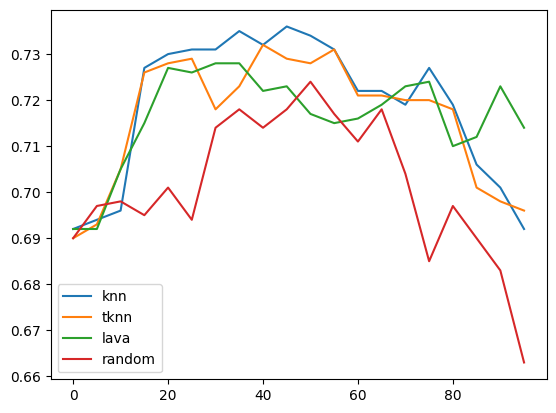

Running remove_high experiment...
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5916
Epoch [30/100], Loss: 0.5906
Epoch [40/100], Loss: 0.5904
Epoch [50/100], Loss: 0.5904
Epoch [60/100], Loss: 0.5910
Epoch [70/100], Loss: 0.5905
Epoch [80/100], Loss: 0.5906
Epoch [90/100], Loss: 0.5897
Epoch [100/100], Loss: 0.5906
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5911
Epoch [30/100], Loss: 0.5899
Epoch [40/100], Loss: 0.5913
Epoch [50/100], Loss: 0.5912
Epoch [60/100], Loss: 0.5915
Epoch [70/100], Loss: 0.5896
Epoch [80/100], Loss: 0.5889
Epoch [90/100], Loss: 0.5901
Epoch [100/100], Loss: 0.5900
Epoch [10/100], Loss: 0.5942
Epoch [20/100], Loss: 0.5919
Epoch [30/100], Loss: 0.5915
Epoch [40/100], Loss: 0.5910
Epoch [50/100], Loss: 0.5898
Epoch [60/100], Loss: 0.5901
Epoch [70/100], Loss: 0.5895
Epoch [80/100], Loss: 0.5894
Epoch [90/100], Loss: 0.5897
Epoch [100/100], Loss: 0.5899
Epoch [10/100], Loss: 0.5938
Epoch [20/100], Loss: 0.5911
Epoch [30/100], Loss: 0.5916
Epoch 

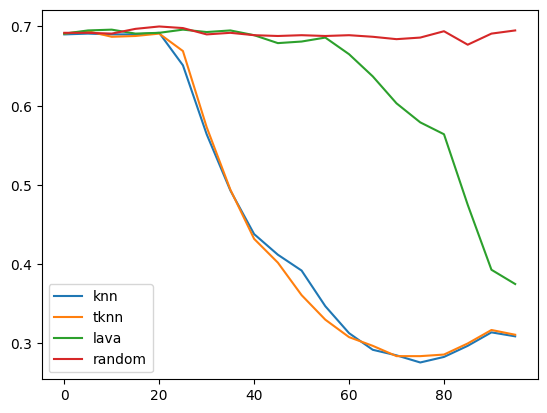

Running add_low experiment...
Epoch [10/100], Loss: 0.4358
Epoch [20/100], Loss: 0.3743
Epoch [30/100], Loss: 0.3584
Epoch [40/100], Loss: 0.3440
Epoch [50/100], Loss: 0.3387
Epoch [60/100], Loss: 0.3348
Epoch [70/100], Loss: 0.3319
Epoch [80/100], Loss: 0.3303
Epoch [90/100], Loss: 0.3298
Epoch [100/100], Loss: 0.3293
Epoch [10/100], Loss: 0.4305
Epoch [20/100], Loss: 0.3657
Epoch [30/100], Loss: 0.3605
Epoch [40/100], Loss: 0.3433
Epoch [50/100], Loss: 0.3384
Epoch [60/100], Loss: 0.3330
Epoch [70/100], Loss: 0.3305
Epoch [80/100], Loss: 0.3270
Epoch [90/100], Loss: 0.3246
Epoch [100/100], Loss: 0.3244
Epoch [10/100], Loss: 0.6111
Epoch [20/100], Loss: 0.5928
Epoch [30/100], Loss: 0.5569
Epoch [40/100], Loss: 0.5820
Epoch [50/100], Loss: 0.5734
Epoch [60/100], Loss: 0.5629
Epoch [70/100], Loss: 0.5902
Epoch [80/100], Loss: 0.5335
Epoch [90/100], Loss: 0.5221
Epoch [100/100], Loss: 0.5449
Epoch [10/100], Loss: 0.6026
Epoch [20/100], Loss: 0.6184
Epoch [30/100], Loss: 0.5406
Epoch [40/

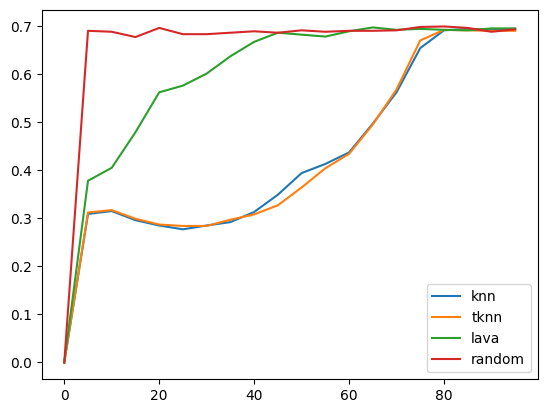

Running add_high experiment...
Epoch [10/100], Loss: 0.3907
Epoch [20/100], Loss: 0.3539
Epoch [30/100], Loss: 0.3428
Epoch [40/100], Loss: 0.3363
Epoch [50/100], Loss: 0.3327
Epoch [60/100], Loss: 0.3343
Epoch [70/100], Loss: 0.3283
Epoch [80/100], Loss: 0.3267
Epoch [90/100], Loss: 0.3239
Epoch [100/100], Loss: 0.3237
Epoch [10/100], Loss: 0.3976
Epoch [20/100], Loss: 0.3508
Epoch [30/100], Loss: 0.3414
Epoch [40/100], Loss: 0.3340
Epoch [50/100], Loss: 0.3302
Epoch [60/100], Loss: 0.3309
Epoch [70/100], Loss: 0.3264
Epoch [80/100], Loss: 0.3243
Epoch [90/100], Loss: 0.3245
Epoch [100/100], Loss: 0.3233
Epoch [10/100], Loss: 0.5624
Epoch [20/100], Loss: 0.5660
Epoch [30/100], Loss: 0.5394
Epoch [40/100], Loss: 0.5202
Epoch [50/100], Loss: 0.5337
Epoch [60/100], Loss: 0.4950
Epoch [70/100], Loss: 0.4983
Epoch [80/100], Loss: 0.5790
Epoch [90/100], Loss: 0.5645
Epoch [100/100], Loss: 0.5628
Epoch [10/100], Loss: 0.6038
Epoch [20/100], Loss: 0.5695
Epoch [30/100], Loss: 0.5421
Epoch [40

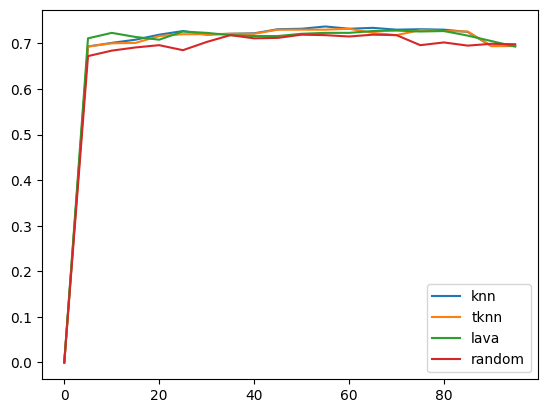

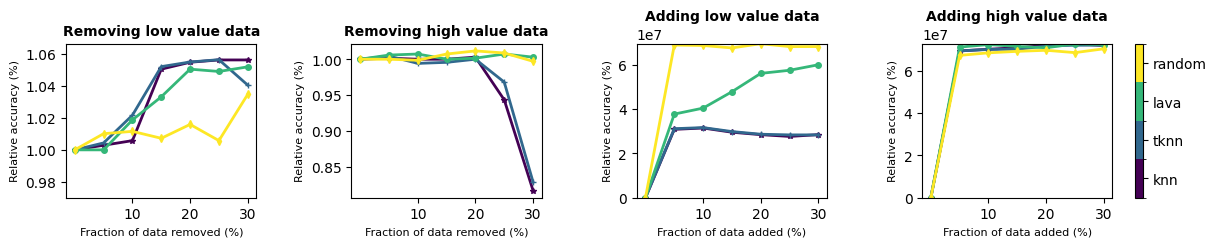

In [117]:
from experiment_run import run_experiments
seed = 2
np.random.seed(seed)
rand_lst = []
shap_list = [value for value in results.values()]
rand_lst.append(np.random.rand(len(shap_list[0])))
name = ['knn', 'tknn' , 'lava', 'random']
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], shap_list[2] , rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:00<00:00, 2023.58it/s]


KNNEvaluator completed in 1.51 seconds.
Running evaluator: CKNNEvaluator


100%|██████████| 1000/1000 [00:00<00:00, 2168.11it/s]


CKNNEvaluator completed in 1.26 seconds.
Running evaluator: LavaEvaluator_geomloss


Computing label-to-label distance: 100%|██████████| 4/4 [00:00<00:00, 35.96it/s]

tensor(0) tensor(0) tensor(0.4371)
tensor(1) tensor(1) tensor(0.4191)


C1 la: tensor([[[ 9.6570,  6.6423, 10.1692,  ...,  7.9250,  9.4119, 11.9236],
         [ 6.0978, 10.3714, 18.7896,  ...,  7.8805, 10.5466, 15.8336],
         [14.6649, 13.1664, 14.1718,  ..., 10.4176,  7.4285,  7.9272],
         ...,
         [ 6.7669,  8.1687, 13.1320,  ...,  9.4287,  9.4205, 10.3177],
         [ 3.0163, 11.9738, 15.4498,  ..., 11.6966,  8.7183, 17.1087],
         [10.4068,  6.5763,  6.6106,  ..., 10.8380,  5.7433, 11.1738]]])
C2 la: tensor([[[0.4371, 0.4371, 0.4371,  ..., 0.4371, 0.4371, 0.4371],
         [0.4371, 0.4371, 0.4371,  ..., 0.4371, 0.4371, 0.4371],
         [5.3622, 5.3622, 5.3622,  ..., 5.3622, 5.3622, 5.3622],
         ...,
         [5.3622, 5.3622, 5.3622,  ..., 5.3622, 5.3622, 5.3622],
         [0.4371, 0.4371, 0.4371,  ..., 0.4371, 0.4371, 0.4371],
         [0.4371, 0.4371, 0.4371,  ..., 0.4371, 0.4371, 0.4371]]])
cost_geoloss: tensor([[[ 9.8755,  6.8608, 10.3877,  ...,  8.1435,  9.6305, 12.1421],
         [ 6.3163, 10.5900, 19.0082,  ...,  8.0991, 1

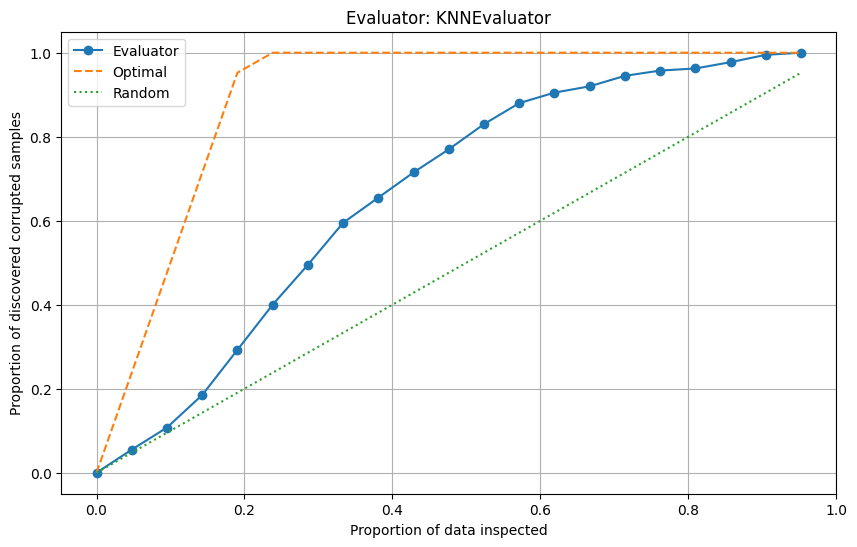

CKNNEvaluator: {'found_rates': [0.0, 0.055, 0.1025, 0.165, 0.2675, 0.3625, 0.48, 0.575, 0.6475, 0.7125, 0.765, 0.835, 0.8725, 0.9, 0.9175, 0.9425, 0.96, 0.965, 0.975, 0.9925, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


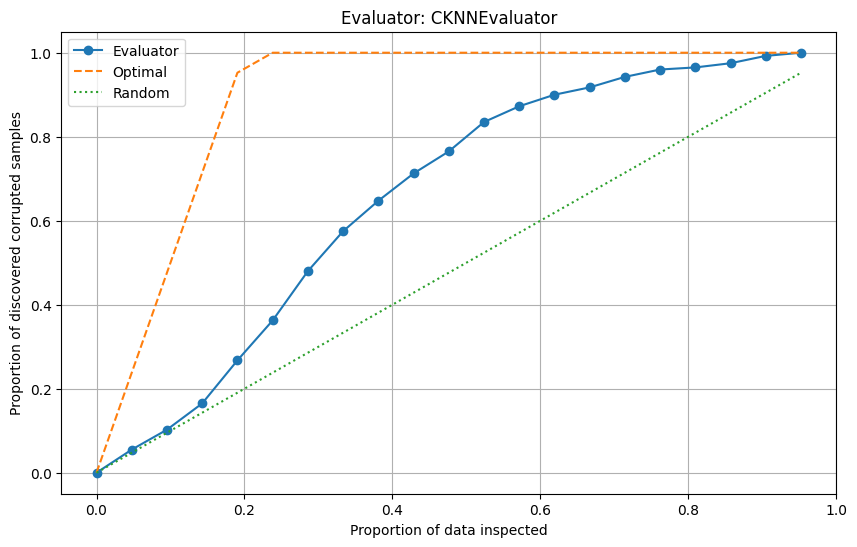

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.2075, 0.2825, 0.3525, 0.3775, 0.4175, 0.4425, 0.4775, 0.5025, 0.51, 0.53, 0.5575, 0.59, 0.615, 0.6275, 0.655, 0.6925, 0.7175, 0.7825, 0.8725, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


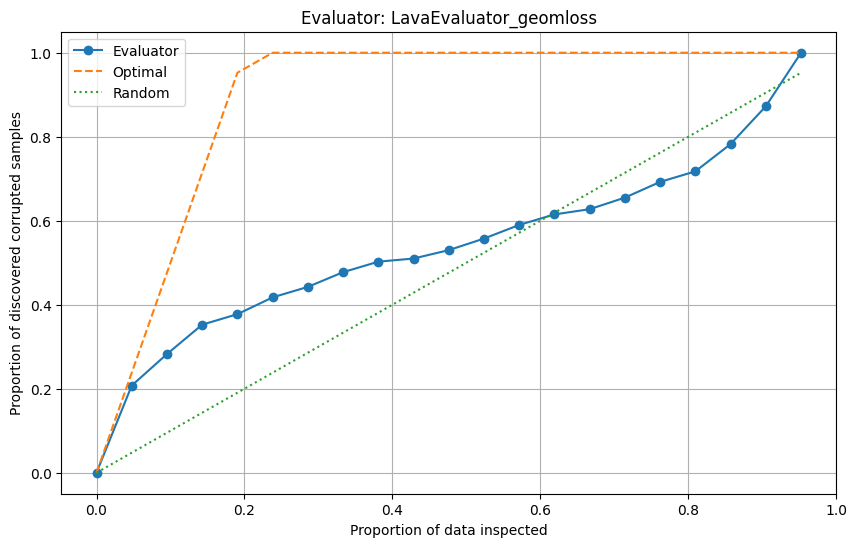

{'KNNEvaluator': {'found_rates': [0.0,
   0.055,
   0.1075,
   0.185,
   0.2925,
   0.4,
   0.495,
   0.595,
   0.655,
   0.715,
   0.77,
   0.83,
   0.88,
   0.905,
   0.92,
   0.945,
   0.9575,
   0.9625,
   0.9775,
   0.995,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'CKNNEvaluator': {'found_rates': [0.0,
   0.055,
   0.1025,
   0.165,
   0.2675,
   0.3625,
   0.48,
   0.575,
   0.6475,
   0.7125,
   0.765,
   0.835,
   0.8725,
   0.9,
   0.9175,
   0.9425,
   0.96,
   0.965,
   0.975,
   0.9925,
   1.0],
  'axis': [0.0,
   0.04761904761

In [138]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
knn_evaluator = KNNEvaluator()
cknn_evaluator = CKNNEvaluator(T = 20, default=True)
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, cknn_evaluator, lava_evaluator_geomloss])
results = experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

C:\Users\21520\AppData\Local\Temp\ipykernel_2284\1432975044.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_labels = torch.tensor(y_labels, dtype=torch.long)
C:\Users\21520\AppData\Local\Temp\ipykernel_2284\1432975044.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yt_labels = torch.tensor(yt_labels, dtype=torch.long)


Running remove_low experiment...
Epoch [10/100], Loss: 0.5799
Epoch [20/100], Loss: 0.5746
Epoch [30/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5697
Epoch [50/100], Loss: 0.5694
Epoch [60/100], Loss: 0.5659
Epoch [70/100], Loss: 0.5647
Epoch [80/100], Loss: 0.5633
Epoch [90/100], Loss: 0.5619
Epoch [100/100], Loss: 0.5608
Epoch [10/100], Loss: 0.5785
Epoch [20/100], Loss: 0.5745
Epoch [30/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5703
Epoch [50/100], Loss: 0.5687
Epoch [60/100], Loss: 0.5667
Epoch [70/100], Loss: 0.5645
Epoch [80/100], Loss: 0.5623
Epoch [90/100], Loss: 0.5619
Epoch [100/100], Loss: 0.5620
Epoch [10/100], Loss: 0.5793
Epoch [20/100], Loss: 0.5739
Epoch [30/100], Loss: 0.5735
Epoch [40/100], Loss: 0.5700
Epoch [50/100], Loss: 0.5682
Epoch [60/100], Loss: 0.5665
Epoch [70/100], Loss: 0.5642
Epoch [80/100], Loss: 0.5636
Epoch [90/100], Loss: 0.5627
Epoch [100/100], Loss: 0.5603
Epoch [10/100], Loss: 0.5794
Epoch [20/100], Loss: 0.5750
Epoch [30/100], Loss: 0.5721
Epoch [

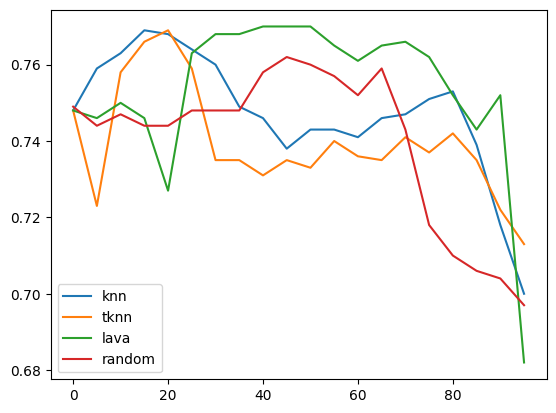

Running remove_high experiment...
Epoch [10/100], Loss: 0.5791
Epoch [20/100], Loss: 0.5754
Epoch [30/100], Loss: 0.5715
Epoch [40/100], Loss: 0.5709
Epoch [50/100], Loss: 0.5677
Epoch [60/100], Loss: 0.5662
Epoch [70/100], Loss: 0.5639
Epoch [80/100], Loss: 0.5634
Epoch [90/100], Loss: 0.5622
Epoch [100/100], Loss: 0.5614
Epoch [10/100], Loss: 0.5792
Epoch [20/100], Loss: 0.5749
Epoch [30/100], Loss: 0.5739
Epoch [40/100], Loss: 0.5701
Epoch [50/100], Loss: 0.5672
Epoch [60/100], Loss: 0.5655
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5634
Epoch [90/100], Loss: 0.5613
Epoch [100/100], Loss: 0.5616
Epoch [10/100], Loss: 0.5794
Epoch [20/100], Loss: 0.5747
Epoch [30/100], Loss: 0.5724
Epoch [40/100], Loss: 0.5690
Epoch [50/100], Loss: 0.5674
Epoch [60/100], Loss: 0.5651
Epoch [70/100], Loss: 0.5640
Epoch [80/100], Loss: 0.5626
Epoch [90/100], Loss: 0.5623
Epoch [100/100], Loss: 0.5602
Epoch [10/100], Loss: 0.5781
Epoch [20/100], Loss: 0.5750
Epoch [30/100], Loss: 0.5718
Epoch 

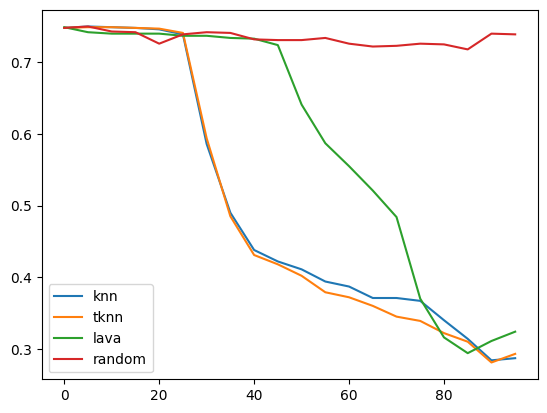

Running add_low experiment...
Epoch [10/100], Loss: 0.4811
Epoch [20/100], Loss: 0.4280
Epoch [30/100], Loss: 0.3845
Epoch [40/100], Loss: 0.3813
Epoch [50/100], Loss: 0.3869
Epoch [60/100], Loss: 0.3631
Epoch [70/100], Loss: 0.3606
Epoch [80/100], Loss: 0.3559
Epoch [90/100], Loss: 0.3554
Epoch [100/100], Loss: 0.3589
Epoch [10/100], Loss: 0.4471
Epoch [20/100], Loss: 0.3993
Epoch [30/100], Loss: 0.3912
Epoch [40/100], Loss: 0.3708
Epoch [50/100], Loss: 0.3633
Epoch [60/100], Loss: 0.3832
Epoch [70/100], Loss: 0.3622
Epoch [80/100], Loss: 0.3556
Epoch [90/100], Loss: 0.3530
Epoch [100/100], Loss: 0.3554
Epoch [10/100], Loss: 0.5287
Epoch [20/100], Loss: 0.5286
Epoch [30/100], Loss: 0.4998
Epoch [40/100], Loss: 0.4736
Epoch [50/100], Loss: 0.4727
Epoch [60/100], Loss: 0.4689
Epoch [70/100], Loss: 0.4480
Epoch [80/100], Loss: 0.4434
Epoch [90/100], Loss: 0.5381
Epoch [100/100], Loss: 0.4406
Epoch [10/100], Loss: 0.6206
Epoch [20/100], Loss: 0.5768
Epoch [30/100], Loss: 0.5827
Epoch [40/

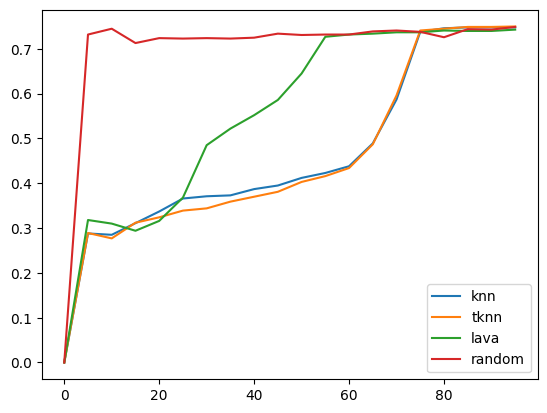

Running add_high experiment...
Epoch [10/100], Loss: 0.3941
Epoch [20/100], Loss: 0.3662
Epoch [30/100], Loss: 0.3542
Epoch [40/100], Loss: 0.3463
Epoch [50/100], Loss: 0.3401
Epoch [60/100], Loss: 0.3392
Epoch [70/100], Loss: 0.3321
Epoch [80/100], Loss: 0.3343
Epoch [90/100], Loss: 0.3278
Epoch [100/100], Loss: 0.3283
Epoch [10/100], Loss: 0.4058
Epoch [20/100], Loss: 0.3716
Epoch [30/100], Loss: 0.3411
Epoch [40/100], Loss: 0.3428
Epoch [50/100], Loss: 0.3318
Epoch [60/100], Loss: 0.3309
Epoch [70/100], Loss: 0.3293
Epoch [80/100], Loss: 0.3266
Epoch [90/100], Loss: 0.3239
Epoch [100/100], Loss: 0.3241
Epoch [10/100], Loss: 0.5618
Epoch [20/100], Loss: 0.5475
Epoch [30/100], Loss: 0.5429
Epoch [40/100], Loss: 0.4805
Epoch [50/100], Loss: 0.5029
Epoch [60/100], Loss: 0.4719
Epoch [70/100], Loss: 0.5129
Epoch [80/100], Loss: 0.5197
Epoch [90/100], Loss: 0.5055
Epoch [100/100], Loss: 0.4578
Epoch [10/100], Loss: 0.6244
Epoch [20/100], Loss: 0.5644
Epoch [30/100], Loss: 0.5940
Epoch [40

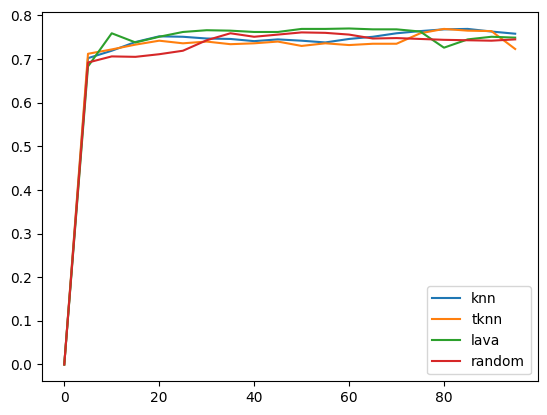

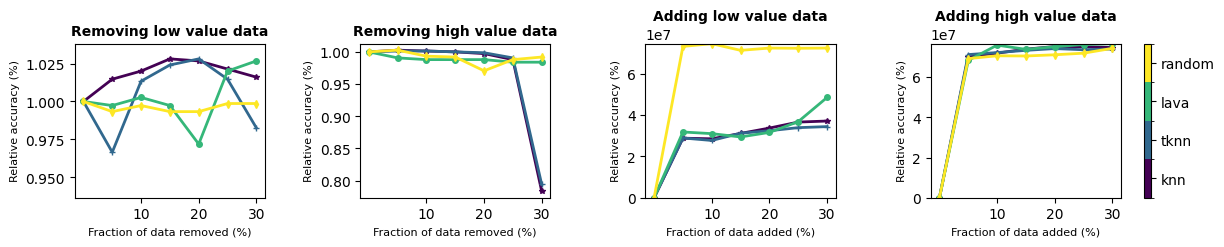

In [133]:
from experiment_run import run_experiments
seed = 2
np.random.seed(seed)
rand_lst = []
shap_list = [value for value in results.values()]
rand_lst.append(np.random.rand(len(shap_list[0])))
name = ['knn', 'tknn' , 'lava', 'random']
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], shap_list[2] , rand_lst[0]]
y_labels = torch.tensor(y_labels, dtype=torch.long)
yt_labels = torch.tensor(yt_labels, dtype=torch.long)
run_experiments(values, name, X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels, model)

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:00<00:00, 2273.50it/s]


KNNEvaluator completed in 1.51 seconds.
Running evaluator: CKNNEvaluator


100%|██████████| 1000/1000 [00:00<00:00, 2328.98it/s]


CKNNEvaluator completed in 1.16 seconds.
Running evaluator: LavaEvaluator_geomloss


C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         ...,
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285]]])
C1 la: tensor([[[ 9.7353,  9.7368, 14.7313,  ...,  6.7466,  3.0068,  8.7495],
         [ 6.7398,  9.7662, 13.2571,  ...,  8.2485, 12.0102,

C1 la: tensor([[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
        [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
        [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
        ...,
        [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
        [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
        [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]])
C2 la: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2479, 0.2479, 0.2479,  ..., 0.2479, 0.2479, 0.2479],
        [0.2479, 0.2479, 0.2479,  ..., 0.2479, 0.2479, 0.2479],
        ...,
        [0.2479, 0.2479, 0.2479,  ..., 0.2479, 0.2479, 0.2479],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2479, 0.2479, 0.2479,  ..., 0.2479, 0.2479, 0.2479]])
C1 la: tensor([[0.3358, 0.2325, 0.3529,  ..., 0.2758, 0.3273, 0.4137],
        [0.3358, 0.3368, 0.4573,  ..., 0.2765, 0.2242, 0.2589],
        [0.5081, 0.

C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         ...,
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285]]])
C1 la: tensor([[[ 9.7353,  9.7368, 14.7313,  ...,  6.7466,  3.0068,  8.7495],
         [ 6.7398,  9.7662, 13.2571,  ...,  8.2485, 12.0102,

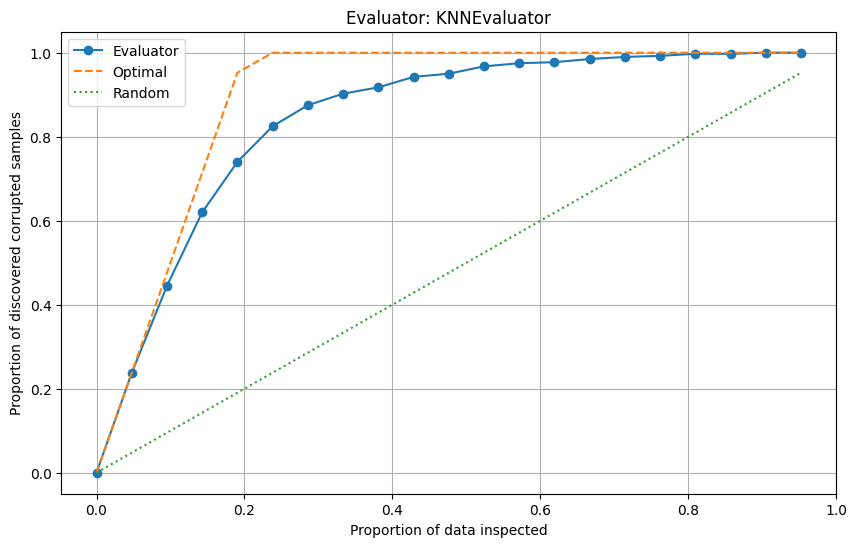

CKNNEvaluator: {'found_rates': [0.0, 0.2375, 0.4425, 0.6225, 0.7475, 0.835, 0.8775, 0.9125, 0.93, 0.945, 0.96, 0.97, 0.9775, 0.98, 0.985, 0.9875, 0.995, 0.9975, 0.9975, 1.0, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


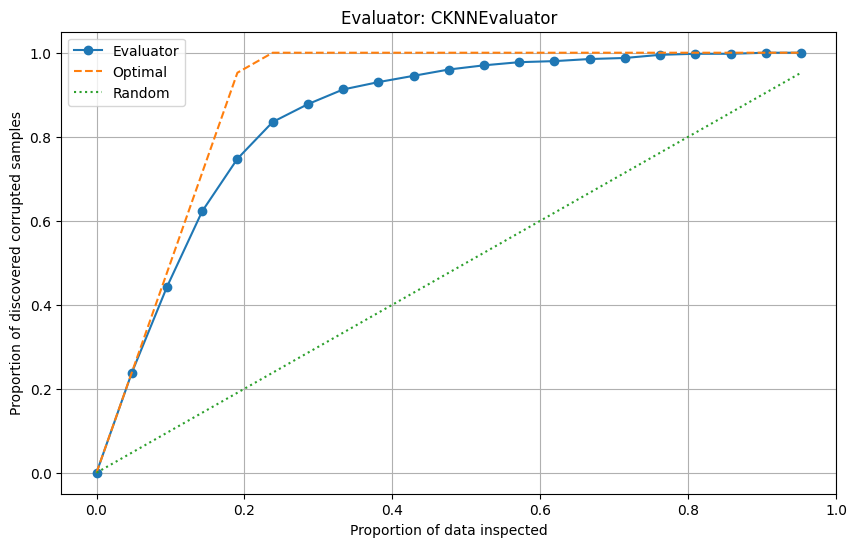

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.125, 0.205, 0.275, 0.36, 0.4125, 0.445, 0.485, 0.54, 0.5825, 0.63, 0.6625, 0.7, 0.7375, 0.775, 0.8025, 0.84, 0.8975, 0.9425, 0.9775, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


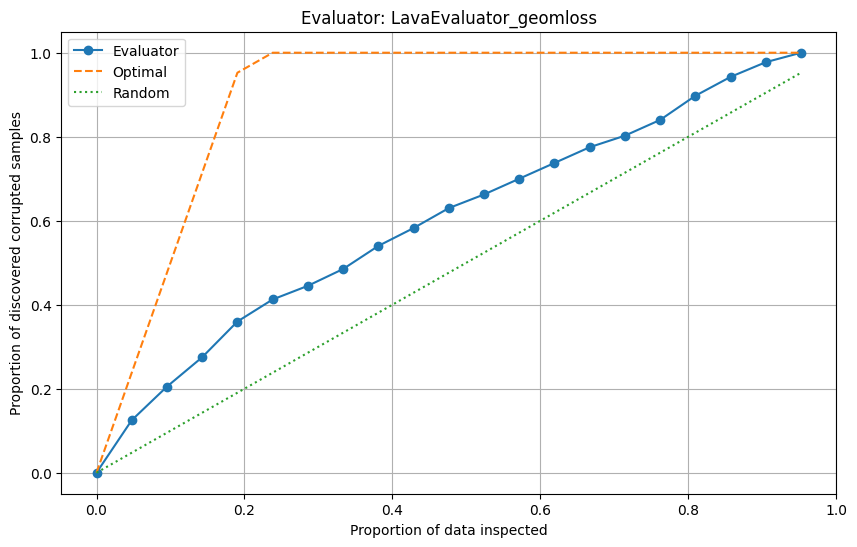

LavaEvaluator_OT: {'found_rates': [0.0, 0.085, 0.16, 0.2175, 0.26, 0.31, 0.3575, 0.3875, 0.43, 0.47, 0.545, 0.62, 0.7, 0.75, 0.815, 0.8475, 0.8875, 0.9275, 0.95, 0.9725, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


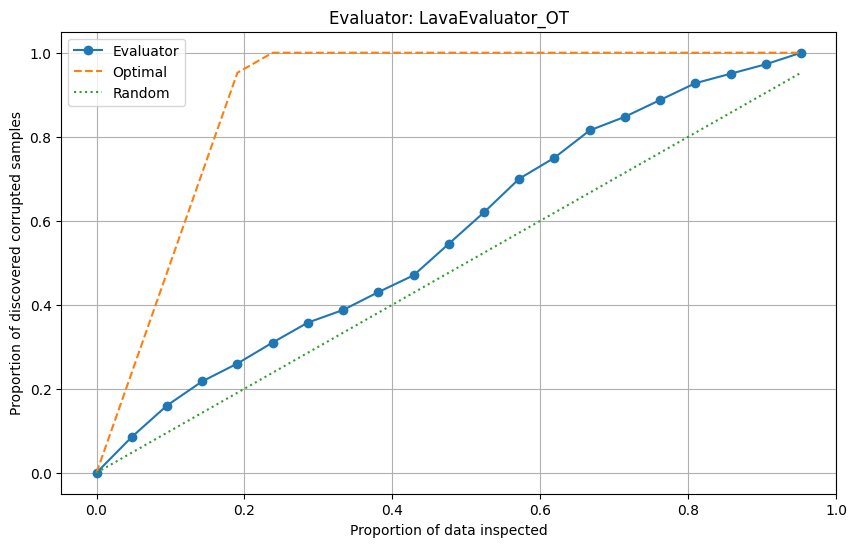

LavaEvaluator_geomloss: {'found_rates': [0.0, 0.125, 0.205, 0.275, 0.36, 0.4125, 0.445, 0.485, 0.54, 0.5825, 0.63, 0.6625, 0.7, 0.7375, 0.775, 0.8025, 0.84, 0.8975, 0.9425, 0.9775, 1.0], 'axis': [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523]}


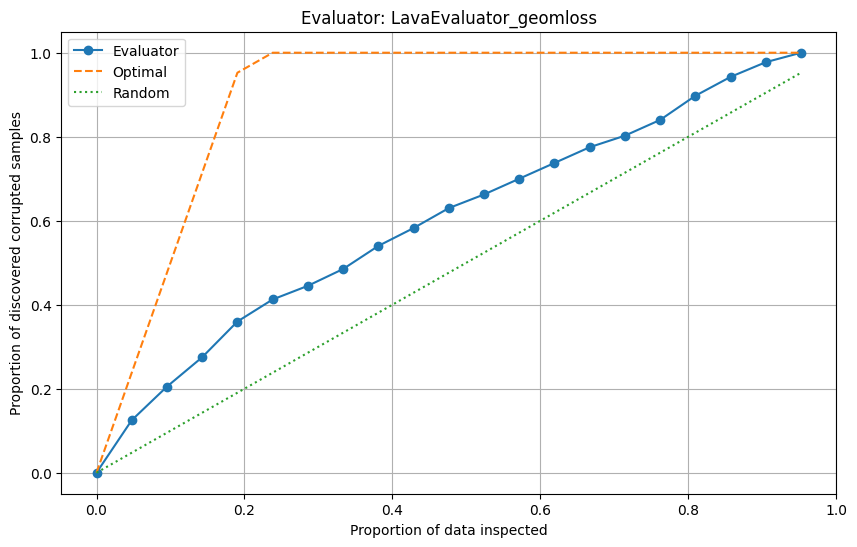

{'KNNEvaluator': {'found_rates': [0.0,
   0.2375,
   0.445,
   0.62,
   0.74,
   0.825,
   0.875,
   0.9025,
   0.9175,
   0.9425,
   0.95,
   0.9675,
   0.975,
   0.9775,
   0.985,
   0.99,
   0.9925,
   0.9975,
   0.9975,
   1.0,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]},
 'CKNNEvaluator': {'found_rates': [0.0,
   0.2375,
   0.4425,
   0.6225,
   0.7475,
   0.835,
   0.8775,
   0.9125,
   0.93,
   0.945,
   0.96,
   0.97,
   0.9775,
   0.98,
   0.985,
   0.9875,
   0.995,
   0.9975,
   0.9975,
   1.0,
   1.0],
  'axis': [0.0,
   0.04761904

In [85]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
knn_evaluator = KNNEvaluator()
cknn_evaluator = CKNNEvaluator(T = 20, default=True)
lava_evaluator_geomloss = LavaEvaluator_geomloss()
lava_evaluator_OT = LavaEvaluator_OT()
lava_evaluator_imbalance = LavaEvaluator_geomloss(lam_x=1, lam_y=10)
experiment = ExperimentRunner(evaluators=[knn_evaluator, cknn_evaluator, lava_evaluator_geomloss, lava_evaluator_OT, lava_evaluator_imbalance])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: LavaEvaluator_geomloss


C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         ...,
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [2.8285, 2.8285, 2.8285,  ..., 2.8285, 2.8285, 2.8285]]])
C1 la: tensor([[[ 9.7353,  9.7368, 14.7313,  ...,  6.7466,  3.0068,  8.7495],
         [ 6.7398,  9.7662, 13.2571,  ...,  8.2485, 12.0102,

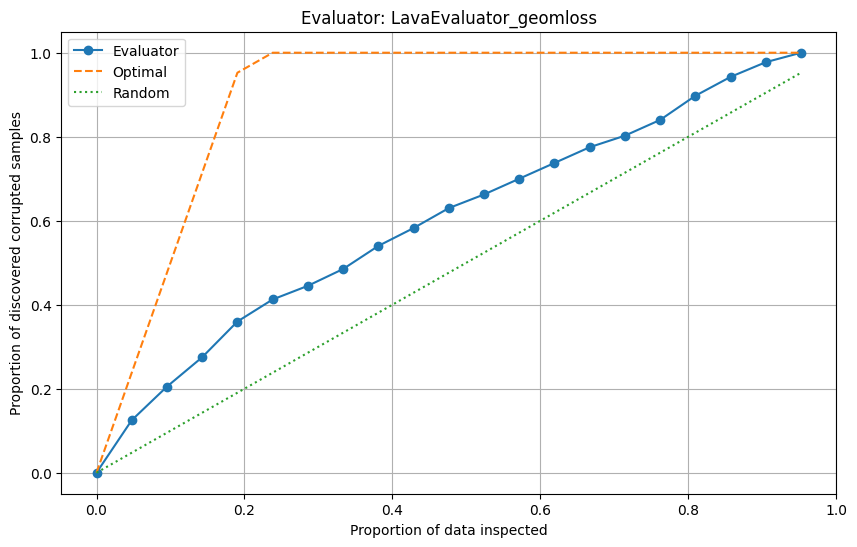

{'LavaEvaluator_geomloss': {'found_rates': [0.0,
   0.125,
   0.205,
   0.275,
   0.36,
   0.4125,
   0.445,
   0.485,
   0.54,
   0.5825,
   0.63,
   0.6625,
   0.7,
   0.7375,
   0.775,
   0.8025,
   0.84,
   0.8975,
   0.9425,
   0.9775,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]}}

In [86]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
lava_evaluator_imbalance = LavaEvaluator_geomloss(lam_x=1, lam_y=10)
experiment = ExperimentRunner(evaluators=[lava_evaluator_imbalance])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: LavaEvaluator_geomloss


tensor(0) tensor(0) tensor(0.2286)
tensor(1) tensor(1) tensor(0.2344)
W tensor([[0.2286, 3.0310, 0.0000, 2.8285],
        [2.9189, 0.2344, 2.8285, 0.0000],
        [0.2286, 2.9189, 0.0000, 3.0408],
        [3.0310, 0.2344, 3.0408, 0.0000]])
tensor([0, 1, 4, 5])
tensor([[0.2286, 0.2286, 0.2286,  ..., 2.9189, 2.9189, 2.9189]])
torch.Size([1, 2000000])
C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.2286, 0.2286, 0.2286,  ..., 0.2286, 0.2286, 0.2286],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189

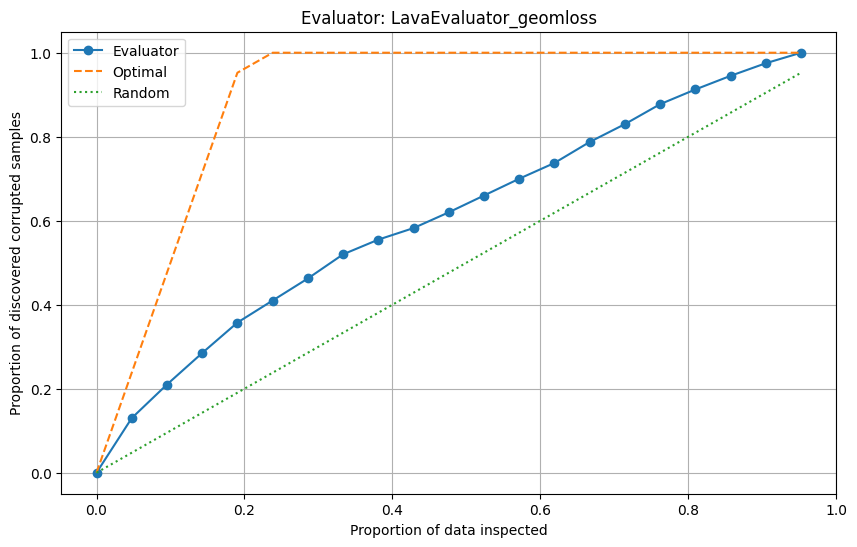

{'LavaEvaluator_geomloss': {'found_rates': [0.0,
   0.13,
   0.21,
   0.285,
   0.3575,
   0.41,
   0.4625,
   0.52,
   0.555,
   0.5825,
   0.62,
   0.66,
   0.7,
   0.7375,
   0.7875,
   0.83,
   0.8775,
   0.9125,
   0.945,
   0.975,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]}}

In [104]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
lava_evaluator_imbalance = LavaEvaluator_geomloss(lam_x=1, lam_y=1)
experiment = ExperimentRunner(evaluators=[lava_evaluator_imbalance])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: LavaEvaluator_geomloss


Computing label-to-label distance:   0%|          | 0/4 [00:00<?, ?it/s]

tensor(0) tensor(0) tensor(0.2286)


tensor(1) tensor(1) tensor(0.2344)
W tensor([[0.2286, 3.0310, 0.0000, 2.8285],
        [2.9189, 0.2344, 2.8285, 0.0000],
        [0.2286, 2.9189, 0.0000, 3.0408],
        [3.0310, 0.2344, 3.0408, 0.0000]])
tensor([0, 1, 4, 5])
tensor([[0.2286, 0.2286, 0.2286,  ..., 2.9189, 2.9189, 2.9189]])
torch.Size([1, 2000000])
C1 la: tensor([[[ 9.7353,  6.7398, 10.2316,  ...,  7.9971,  9.4902, 11.9954],
         [ 9.7368,  9.7662, 13.2581,  ...,  8.0174,  6.4990,  7.5053],
         [14.7313, 13.2571, 14.2447,  ..., 10.5026,  7.4913,  7.9961],
         ...,
         [ 6.7466,  8.2485, 13.2455,  ...,  9.4914,  9.4944, 10.4791],
         [ 3.0068, 12.0102, 15.5140,  ..., 11.7491,  8.7485, 17.2381],
         [ 8.7495,  8.7550,  8.2554,  ..., 10.4904,  6.0001, 13.9839]]])
C2 la: tensor([[[0.2286, 0.2286, 0.2286,  ..., 0.2286, 0.2286, 0.2286],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189],
         [2.9189, 2.9189, 2.9189,  ..., 2.9189, 2.9189, 2.9189],
         ...,
         [2.9189, 

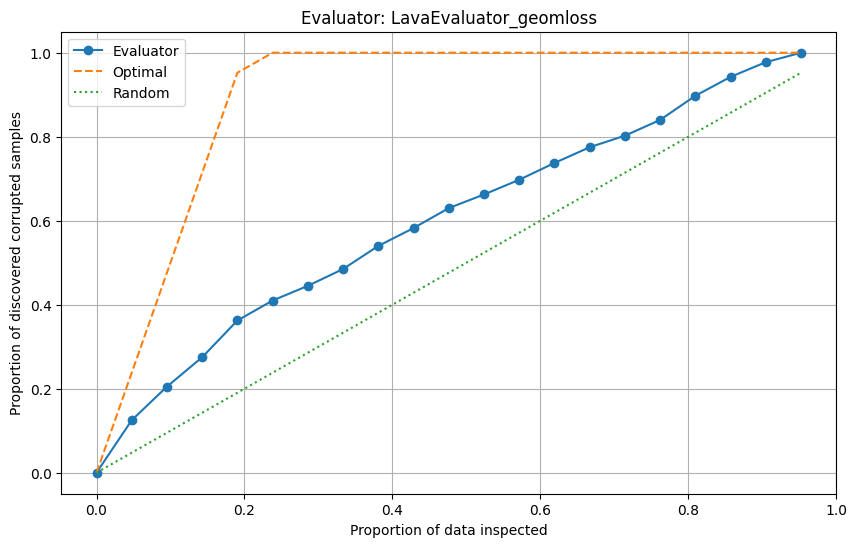

{'LavaEvaluator_geomloss': {'found_rates': [0.0,
   0.125,
   0.205,
   0.275,
   0.3625,
   0.41,
   0.445,
   0.485,
   0.54,
   0.5825,
   0.63,
   0.6625,
   0.6975,
   0.7375,
   0.775,
   0.8025,
   0.84,
   0.8975,
   0.9425,
   0.9775,
   1.0],
  'axis': [0.0,
   0.047619047619047616,
   0.09523809523809523,
   0.14285714285714285,
   0.19047619047619047,
   0.23809523809523808,
   0.2857142857142857,
   0.3333333333333333,
   0.38095238095238093,
   0.42857142857142855,
   0.47619047619047616,
   0.5238095238095238,
   0.5714285714285714,
   0.6190476190476191,
   0.6666666666666666,
   0.7142857142857143,
   0.7619047619047619,
   0.8095238095238095,
   0.8571428571428571,
   0.9047619047619048,
   0.9523809523809523]}}

In [108]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner
lava_evaluator_imbalance = LavaEvaluator_geomloss(lam_x=1, lam_y=10)
experiment = ExperimentRunner(evaluators=[lava_evaluator_imbalance])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

Running evaluator: KNNEvaluator


100%|██████████| 20383/20383 [02:28<00:00, 137.13it/s]


KNNEvaluator completed in 427.61 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[10.4822, 10.4798,  3.7419,  ..., 11.7324, 13.4845,  6.0015],
        [ 8.9818, 16.4771,  8.2538,  ..., 13.2516, 11.9954,  7.5019],
        [10.9898, 16.9997, 11.7578,  ..., 15.7506, 18.4783, 11.0065],
        ...,
        [ 3.7457, 12.7482,  9.0019,  ..., 11.0012, 14.2417,  9.7457],
        [ 8.9932,  7.4779,  3.7457,  ...,  7.2500, 13.4869,  5.9913],
        [ 8.7589,  5.7472,  6.5008,  ...,  8.9853,  8.7487,  5.7345]])
C2 la: tensor([[0.2467, 0.0000, 0.0000,  ..., 0.2467, 0.2467, 0.0000],
        [0.2467, 0.0000, 0.0000,  ..., 0.2467, 0.2467, 0.0000],
        [0.0000, 0.2467, 0.2467,  ..., 0.0000, 0.0000, 0.2467],
        ...,
        [0.0000, 0.2467, 0.2467,  ..., 0.0000, 0.0000, 0.2467],
        [0.2467, 0.0000, 0.0000,  ..., 0.2467, 0.2467, 0.0000],
        [0.0000, 0.2467, 0.2467,  ..., 0.0000, 0.0000, 0.2467]])
C1 la: tensor([[0.3615, 0.3615, 0.1291,  ..., 0.4047, 0.4651, 0.2070],
        [0.3098, 0.5683, 0.2847,  ..., 0.4570, 0.4137, 0.2587],
        [0.3790, 0.

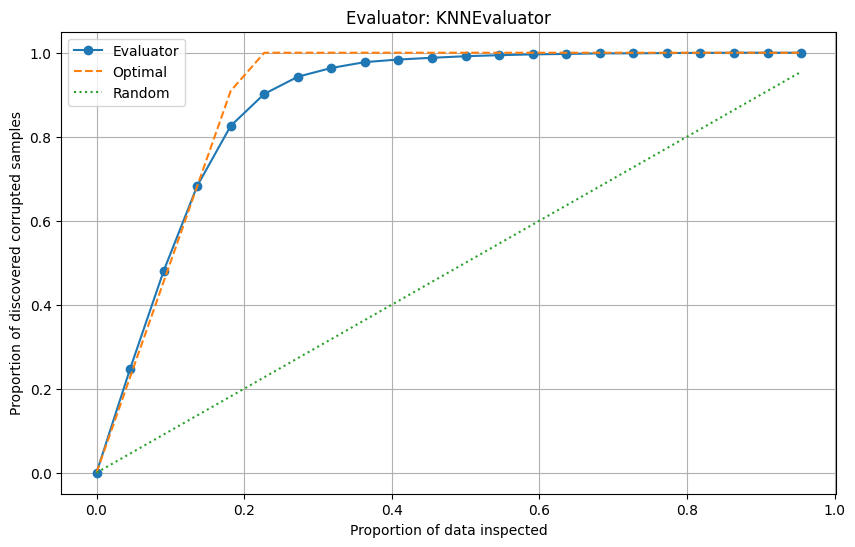

LavaEvaluator: {'found_rates': [0.0, 0.12855740922473013, 0.22080471050049066, 0.29317958783120707, 0.37070657507360155, 0.426153091265947, 0.47031403336604516, 0.5252698724239451, 0.6003434739941119, 0.6481844946025516, 0.6852306182531894, 0.7156526005888125, 0.7639842983316978, 0.8120706575073602, 0.8451913640824338, 0.8670264965652601, 0.8947497546614328, 0.9313052011776252, 0.9538763493621197, 0.9815996074582924, 1.0, 1.0], 'axis': [0.0, 0.045454545454545456, 0.09090909090909091, 0.13636363636363635, 0.18181818181818182, 0.22727272727272727, 0.2727272727272727, 0.3181818181818182, 0.36363636363636365, 0.4090909090909091, 0.45454545454545453, 0.5, 0.5454545454545454, 0.5909090909090909, 0.6363636363636364, 0.6818181818181818, 0.7272727272727273, 0.7727272727272727, 0.8181818181818182, 0.8636363636363636, 0.9090909090909091, 0.9545454545454546]}


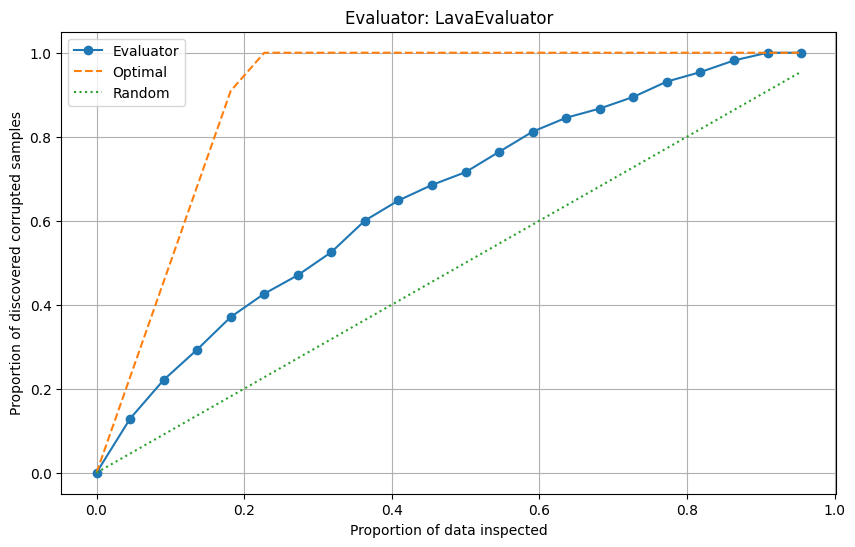

{'KNNEvaluator': {'found_rates': [0.0,
   0.2470559371933268,
   0.4801275760549558,
   0.6825318940137389,
   0.8258096172718351,
   0.9018645731108931,
   0.9428361138370952,
   0.9636898920510304,
   0.9776741903827282,
   0.9838076545632973,
   0.9879784102060843,
   0.9916584887144259,
   0.9941118743866536,
   0.9960745829244357,
   0.9970559371933267,
   0.9985279685966634,
   0.9985279685966634,
   0.9992639842983317,
   0.9995093228655545,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.045454545454545456,
   0.09090909090909091,
   0.13636363636363635,
   0.18181818181818182,
   0.22727272727272727,
   0.2727272727272727,
   0.3181818181818182,
   0.36363636363636365,
   0.4090909090909091,
   0.45454545454545453,
   0.5,
   0.5454545454545454,
   0.5909090909090909,
   0.6363636363636364,
   0.6818181818181818,
   0.7272727272727273,
   0.7727272727272727,
   0.8181818181818182,
   0.8636363636363636,
   0.9090909090909091,
   0.9545454545454546]},
 'LavaEvaluator': {'found_ra

In [15]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [54]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
results = experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
shap_list = [value for value in results.values()]

Running evaluator: KNNEvaluator


100%|██████████| 1999/1999 [00:00<00:00, 2163.06it/s]


KNNEvaluator completed in 1.47 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[10.4822, 10.4798,  3.7419,  ...,  7.2374, 14.0016,  5.2467],
        [ 8.9818, 16.4771,  8.2538,  ..., 13.2347,  7.9856, 11.2658],
        [10.9898, 16.9997, 11.7578,  ..., 12.7516,  8.9828, 14.7586],
        ...,
        [ 7.4913, 12.0102,  8.2565,  ..., 16.2629, 14.0065,  5.2557],
        [ 5.2445,  8.2452,  7.5028,  ...,  9.5008,  8.7563,  7.5166],
        [ 9.5089, 15.5134, 11.7561,  ..., 14.2642,  9.0098,  8.7523]])
C2 la: tensor([[0.2479, 0.0000, 0.0000,  ..., 0.2479, 0.0000, 0.0000],
        [0.0000, 0.2479, 0.2479,  ..., 0.0000, 0.2479, 0.2479],
        [0.0000, 0.2479, 0.2479,  ..., 0.0000, 0.2479, 0.2479],
        ...,
        [0.0000, 0.2479, 0.2479,  ..., 0.0000, 0.2479, 0.2479],
        [0.2479, 0.0000, 0.0000,  ..., 0.2479, 0.0000, 0.0000],
        [0.0000, 0.2479, 0.2479,  ..., 0.0000, 0.2479, 0.2479]])
C1 la: tensor([[0.3615, 0.3615, 0.1291,  ..., 0.2496, 0.4829, 0.1810],
        [0.3098, 0.5683, 0.2847,  ..., 0.4565, 0.2754, 0.3886],
        [0.3790, 0.

Running remove_low experiment...
Epoch [10/100], Loss: 0.5951
Epoch [20/100], Loss: 0.5924
Epoch [30/100], Loss: 0.5917
Epoch [40/100], Loss: 0.5892
Epoch [50/100], Loss: 0.5911
Epoch [60/100], Loss: 0.5893
Epoch [70/100], Loss: 0.5905
Epoch [80/100], Loss: 0.5906
Epoch [90/100], Loss: 0.5902
Epoch [100/100], Loss: 0.5902
Epoch [10/100], Loss: 0.5915
Epoch [20/100], Loss: 0.5903
Epoch [30/100], Loss: 0.5889
Epoch [40/100], Loss: 0.5900
Epoch [50/100], Loss: 0.5895
Epoch [60/100], Loss: 0.5894
Epoch [70/100], Loss: 0.5899
Epoch [80/100], Loss: 0.5888
Epoch [90/100], Loss: 0.5896
Epoch [100/100], Loss: 0.5890
Epoch [10/100], Loss: 0.5895
Epoch [20/100], Loss: 0.5891
Epoch [30/100], Loss: 0.5887
Epoch [40/100], Loss: 0.5877
Epoch [50/100], Loss: 0.5892
Epoch [60/100], Loss: 0.5885
Epoch [70/100], Loss: 0.5884
Epoch [80/100], Loss: 0.5880
Epoch [90/100], Loss: 0.5887
Epoch [100/100], Loss: 0.5892
Epoch [10/100], Loss: 0.5514
Epoch [20/100], Loss: 0.5520
Epoch [30/100], Loss: 0.5519
Epoch [

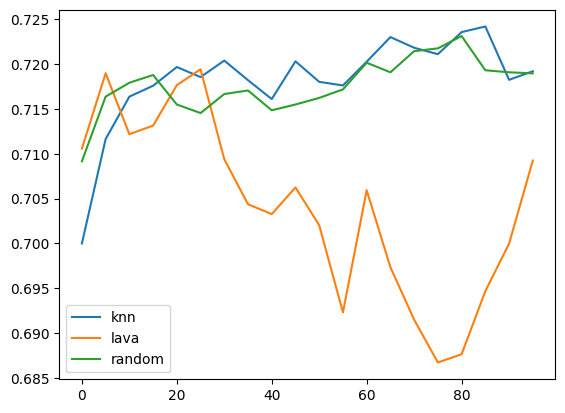

Running remove_high experiment...
Epoch [10/100], Loss: 0.5894
Epoch [20/100], Loss: 0.5858
Epoch [30/100], Loss: 0.5861
Epoch [40/100], Loss: 0.5853
Epoch [50/100], Loss: 0.5842
Epoch [60/100], Loss: 0.5838
Epoch [70/100], Loss: 0.5867
Epoch [80/100], Loss: 0.5847
Epoch [90/100], Loss: 0.5847
Epoch [100/100], Loss: 0.5857
Epoch [10/100], Loss: 0.5841
Epoch [20/100], Loss: 0.5847
Epoch [30/100], Loss: 0.5835
Epoch [40/100], Loss: 0.5848
Epoch [50/100], Loss: 0.5853
Epoch [60/100], Loss: 0.5848
Epoch [70/100], Loss: 0.5860
Epoch [80/100], Loss: 0.5835
Epoch [90/100], Loss: 0.5840
Epoch [100/100], Loss: 0.5848
Epoch [10/100], Loss: 0.5847
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5835
Epoch [40/100], Loss: 0.5857
Epoch [50/100], Loss: 0.5845
Epoch [60/100], Loss: 0.5854
Epoch [70/100], Loss: 0.5845
Epoch [80/100], Loss: 0.5850
Epoch [90/100], Loss: 0.5843
Epoch [100/100], Loss: 0.5864
Epoch [10/100], Loss: 0.5982
Epoch [20/100], Loss: 0.5999
Epoch [30/100], Loss: 0.5987
Epoch 

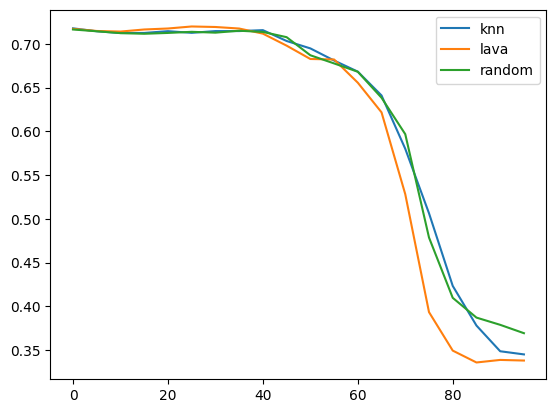

Running add_low experiment...
Epoch [10/100], Loss: 0.8393
Epoch [20/100], Loss: 0.8367
Epoch [30/100], Loss: 0.8346
Epoch [40/100], Loss: 0.7206
Epoch [50/100], Loss: 0.7234
Epoch [60/100], Loss: 0.8845
Epoch [70/100], Loss: 0.8289
Epoch [80/100], Loss: 0.7183
Epoch [90/100], Loss: 0.7183
Epoch [100/100], Loss: 0.7716
Epoch [10/100], Loss: 0.3585
Epoch [20/100], Loss: 0.3554
Epoch [30/100], Loss: 0.3918
Epoch [40/100], Loss: 0.3493
Epoch [50/100], Loss: 0.3476
Epoch [60/100], Loss: 0.3470
Epoch [70/100], Loss: 0.3477
Epoch [80/100], Loss: 0.3495
Epoch [90/100], Loss: 0.3470
Epoch [100/100], Loss: 0.4538
Epoch [10/100], Loss: 0.7279
Epoch [20/100], Loss: 0.7222
Epoch [30/100], Loss: 0.6603
Epoch [40/100], Loss: 0.6562
Epoch [50/100], Loss: 0.7627
Epoch [60/100], Loss: 0.7065
Epoch [70/100], Loss: 0.7784
Epoch [80/100], Loss: 0.7604
Epoch [90/100], Loss: 0.8114
Epoch [100/100], Loss: 0.7014
Epoch [10/100], Loss: 0.7947
Epoch [20/100], Loss: 0.7828
Epoch [30/100], Loss: 0.8048
Epoch [40/

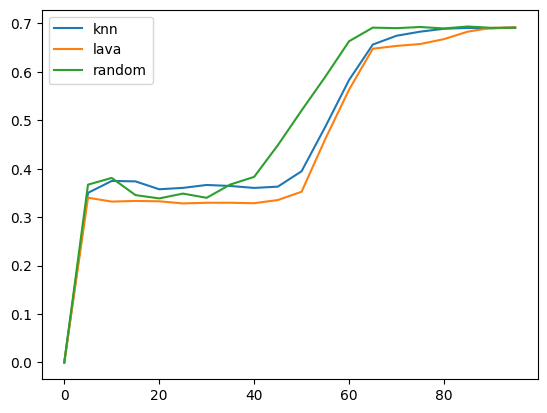

Running add_high experiment...
Epoch [10/100], Loss: 0.3478
Epoch [20/100], Loss: 0.3475
Epoch [30/100], Loss: 0.4019
Epoch [40/100], Loss: 0.3469
Epoch [50/100], Loss: 0.3467
Epoch [60/100], Loss: 0.3465
Epoch [70/100], Loss: 0.3464
Epoch [80/100], Loss: 0.3547
Epoch [90/100], Loss: 0.3460
Epoch [100/100], Loss: 0.3459
Epoch [10/100], Loss: 0.5445
Epoch [20/100], Loss: 0.5426
Epoch [30/100], Loss: 0.5403
Epoch [40/100], Loss: 0.4884
Epoch [50/100], Loss: 0.5921
Epoch [60/100], Loss: 0.4993
Epoch [70/100], Loss: 0.4797
Epoch [80/100], Loss: 0.5333
Epoch [90/100], Loss: 0.5324
Epoch [100/100], Loss: 0.6409
Epoch [10/100], Loss: 0.5662
Epoch [20/100], Loss: 0.5645
Epoch [30/100], Loss: 0.6721
Epoch [40/100], Loss: 0.6156
Epoch [50/100], Loss: 0.5593
Epoch [60/100], Loss: 0.5066
Epoch [70/100], Loss: 0.5548
Epoch [80/100], Loss: 0.6078
Epoch [90/100], Loss: 0.5519
Epoch [100/100], Loss: 0.5122
Epoch [10/100], Loss: 0.3905
Epoch [20/100], Loss: 0.3770
Epoch [30/100], Loss: 0.3908
Epoch [40

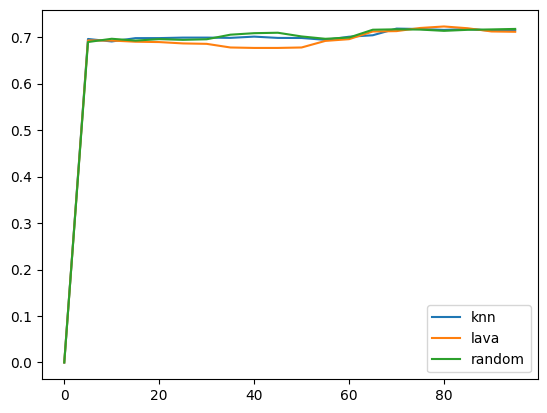

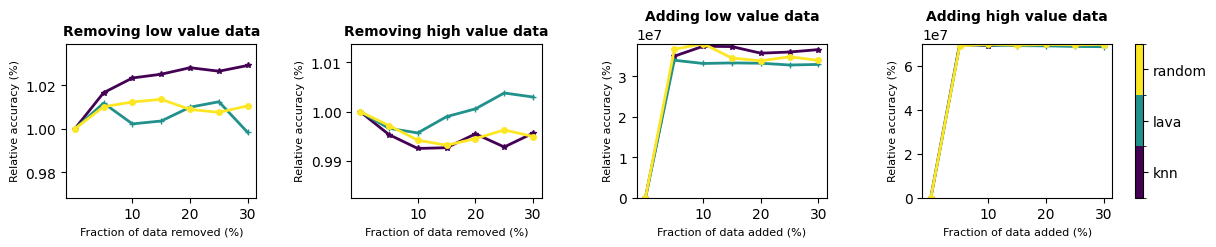

In [56]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 1
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

Running remove_low experiment...
Epoch [10/100], Loss: 0.5941
Epoch [20/100], Loss: 0.5920
Epoch [30/100], Loss: 0.5924
Epoch [40/100], Loss: 0.5915
Epoch [50/100], Loss: 0.5900
Epoch [60/100], Loss: 0.5902
Epoch [70/100], Loss: 0.5900
Epoch [80/100], Loss: 0.5901
Epoch [90/100], Loss: 0.5907
Epoch [100/100], Loss: 0.5904
Epoch [10/100], Loss: 0.5896
Epoch [20/100], Loss: 0.5893
Epoch [30/100], Loss: 0.5898
Epoch [40/100], Loss: 0.5886
Epoch [50/100], Loss: 0.5894
Epoch [60/100], Loss: 0.5887
Epoch [70/100], Loss: 0.5878
Epoch [80/100], Loss: 0.5894
Epoch [90/100], Loss: 0.5882
Epoch [100/100], Loss: 0.5882
Epoch [10/100], Loss: 0.5891
Epoch [20/100], Loss: 0.5872
Epoch [30/100], Loss: 0.5883
Epoch [40/100], Loss: 0.5881
Epoch [50/100], Loss: 0.5874
Epoch [60/100], Loss: 0.5881
Epoch [70/100], Loss: 0.5880
Epoch [80/100], Loss: 0.5889
Epoch [90/100], Loss: 0.5872
Epoch [100/100], Loss: 0.5885
Epoch [10/100], Loss: 0.5523
Epoch [20/100], Loss: 0.5499
Epoch [30/100], Loss: 0.5525
Epoch [

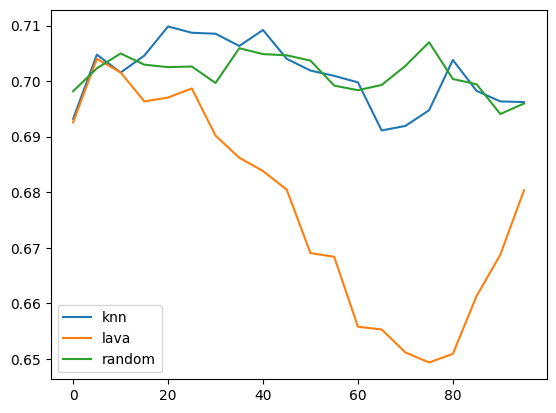

Running remove_high experiment...
Epoch [10/100], Loss: 0.5893
Epoch [20/100], Loss: 0.5882
Epoch [30/100], Loss: 0.5844
Epoch [40/100], Loss: 0.5858
Epoch [50/100], Loss: 0.5859
Epoch [60/100], Loss: 0.5864
Epoch [70/100], Loss: 0.5847
Epoch [80/100], Loss: 0.5846
Epoch [90/100], Loss: 0.5876
Epoch [100/100], Loss: 0.5841
Epoch [10/100], Loss: 0.5862
Epoch [20/100], Loss: 0.5855
Epoch [30/100], Loss: 0.5837
Epoch [40/100], Loss: 0.5842
Epoch [50/100], Loss: 0.5862
Epoch [60/100], Loss: 0.5845
Epoch [70/100], Loss: 0.5845
Epoch [80/100], Loss: 0.5846
Epoch [90/100], Loss: 0.5845
Epoch [100/100], Loss: 0.5845
Epoch [10/100], Loss: 0.5856
Epoch [20/100], Loss: 0.5840
Epoch [30/100], Loss: 0.5840
Epoch [40/100], Loss: 0.5850
Epoch [50/100], Loss: 0.5849
Epoch [60/100], Loss: 0.5847
Epoch [70/100], Loss: 0.5855
Epoch [80/100], Loss: 0.5834
Epoch [90/100], Loss: 0.5842
Epoch [100/100], Loss: 0.5851
Epoch [10/100], Loss: 0.5979
Epoch [20/100], Loss: 0.6003
Epoch [30/100], Loss: 0.5956
Epoch 

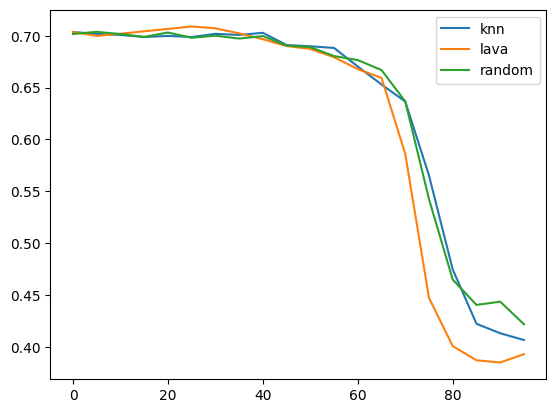

Running add_low experiment...
Epoch [10/100], Loss: 0.7843
Epoch [20/100], Loss: 0.7823
Epoch [30/100], Loss: 0.7252
Epoch [40/100], Loss: 0.7239
Epoch [50/100], Loss: 0.7341
Epoch [60/100], Loss: 0.7763
Epoch [70/100], Loss: 0.7753
Epoch [80/100], Loss: 0.7741
Epoch [90/100], Loss: 0.7773
Epoch [100/100], Loss: 0.7725
Epoch [10/100], Loss: 0.3570
Epoch [20/100], Loss: 0.3534
Epoch [30/100], Loss: 0.3510
Epoch [40/100], Loss: 0.3488
Epoch [50/100], Loss: 0.3476
Epoch [60/100], Loss: 0.3466
Epoch [70/100], Loss: 0.3459
Epoch [80/100], Loss: 0.3454
Epoch [90/100], Loss: 0.3449
Epoch [100/100], Loss: 0.3987
Epoch [10/100], Loss: 0.7863
Epoch [20/100], Loss: 0.7501
Epoch [30/100], Loss: 0.8226
Epoch [40/100], Loss: 0.6576
Epoch [50/100], Loss: 0.7091
Epoch [60/100], Loss: 0.7608
Epoch [70/100], Loss: 0.6597
Epoch [80/100], Loss: 0.7041
Epoch [90/100], Loss: 0.7031
Epoch [100/100], Loss: 0.7064
Epoch [10/100], Loss: 0.7690
Epoch [20/100], Loss: 0.7401
Epoch [30/100], Loss: 0.7652
Epoch [40/

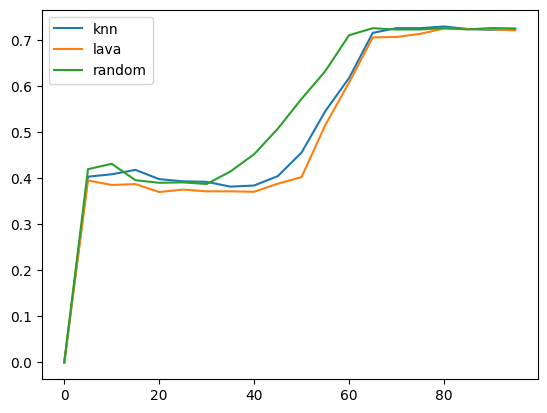

Running add_high experiment...
Epoch [10/100], Loss: 0.3479
Epoch [20/100], Loss: 0.3475
Epoch [30/100], Loss: 0.3473
Epoch [40/100], Loss: 0.3597
Epoch [50/100], Loss: 0.3467
Epoch [60/100], Loss: 0.3465
Epoch [70/100], Loss: 0.3463
Epoch [80/100], Loss: 0.3461
Epoch [90/100], Loss: 0.3460
Epoch [100/100], Loss: 0.3459
Epoch [10/100], Loss: 0.4970
Epoch [20/100], Loss: 0.4875
Epoch [30/100], Loss: 0.4859
Epoch [40/100], Loss: 0.4879
Epoch [50/100], Loss: 0.5919
Epoch [60/100], Loss: 0.5359
Epoch [70/100], Loss: 0.4802
Epoch [80/100], Loss: 0.5177
Epoch [90/100], Loss: 0.5886
Epoch [100/100], Loss: 0.5317
Epoch [10/100], Loss: 0.5664
Epoch [20/100], Loss: 0.5638
Epoch [30/100], Loss: 0.5721
Epoch [40/100], Loss: 0.6107
Epoch [50/100], Loss: 0.5519
Epoch [60/100], Loss: 0.5016
Epoch [70/100], Loss: 0.5540
Epoch [80/100], Loss: 0.5523
Epoch [90/100], Loss: 0.6052
Epoch [100/100], Loss: 0.5475
Epoch [10/100], Loss: 0.3771
Epoch [20/100], Loss: 0.3770
Epoch [30/100], Loss: 0.3771
Epoch [40

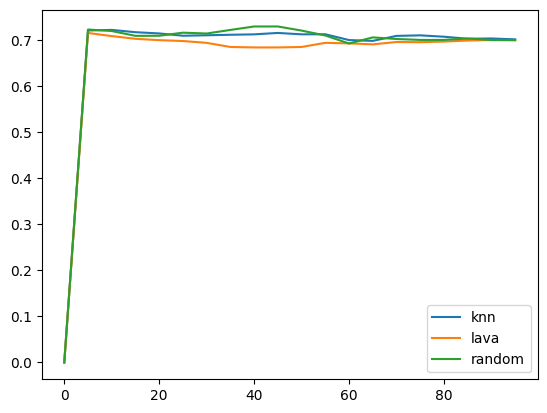

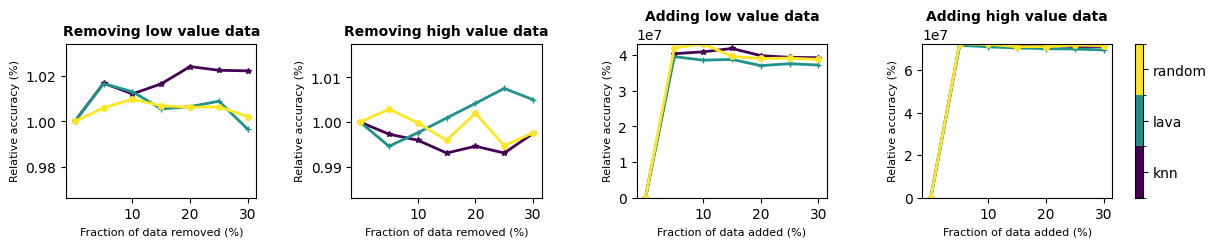

In [59]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 1
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

Running remove_low experiment...
Epoch [10/100], Loss: 0.5943
Epoch [20/100], Loss: 0.5912
Epoch [30/100], Loss: 0.5910
Epoch [40/100], Loss: 0.5902
Epoch [50/100], Loss: 0.5895
Epoch [60/100], Loss: 0.5913
Epoch [70/100], Loss: 0.5903
Epoch [80/100], Loss: 0.5892
Epoch [90/100], Loss: 0.5908
Epoch [100/100], Loss: 0.5901
Epoch [10/100], Loss: 0.5898
Epoch [20/100], Loss: 0.5907
Epoch [30/100], Loss: 0.5891
Epoch [40/100], Loss: 0.5889
Epoch [50/100], Loss: 0.5887
Epoch [60/100], Loss: 0.5892
Epoch [70/100], Loss: 0.5907
Epoch [80/100], Loss: 0.5882
Epoch [90/100], Loss: 0.5884
Epoch [100/100], Loss: 0.5885
Epoch [10/100], Loss: 0.5890
Epoch [20/100], Loss: 0.5894
Epoch [30/100], Loss: 0.5881
Epoch [40/100], Loss: 0.5886
Epoch [50/100], Loss: 0.5869
Epoch [60/100], Loss: 0.5884
Epoch [70/100], Loss: 0.5880
Epoch [80/100], Loss: 0.5879
Epoch [90/100], Loss: 0.5876
Epoch [100/100], Loss: 0.5881
Epoch [10/100], Loss: 0.5501
Epoch [20/100], Loss: 0.5520
Epoch [30/100], Loss: 0.5495
Epoch [

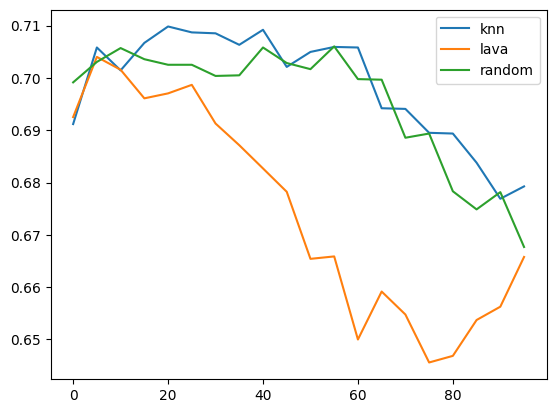

Running remove_high experiment...
Epoch [10/100], Loss: 0.5958
Epoch [20/100], Loss: 0.5910
Epoch [30/100], Loss: 0.5898
Epoch [40/100], Loss: 0.5858
Epoch [50/100], Loss: 0.5872
Epoch [60/100], Loss: 0.5864
Epoch [70/100], Loss: 0.5852
Epoch [80/100], Loss: 0.5857
Epoch [90/100], Loss: 0.5833
Epoch [100/100], Loss: 0.5861
Epoch [10/100], Loss: 0.5853
Epoch [20/100], Loss: 0.5830
Epoch [30/100], Loss: 0.5849
Epoch [40/100], Loss: 0.5845
Epoch [50/100], Loss: 0.5841
Epoch [60/100], Loss: 0.5847
Epoch [70/100], Loss: 0.5849
Epoch [80/100], Loss: 0.5844
Epoch [90/100], Loss: 0.5843
Epoch [100/100], Loss: 0.5855
Epoch [10/100], Loss: 0.5848
Epoch [20/100], Loss: 0.5830
Epoch [30/100], Loss: 0.5849
Epoch [40/100], Loss: 0.5846
Epoch [50/100], Loss: 0.5839
Epoch [60/100], Loss: 0.5851
Epoch [70/100], Loss: 0.5849
Epoch [80/100], Loss: 0.5843
Epoch [90/100], Loss: 0.5840
Epoch [100/100], Loss: 0.5847
Epoch [10/100], Loss: 0.5972
Epoch [20/100], Loss: 0.6015
Epoch [30/100], Loss: 0.5992
Epoch 

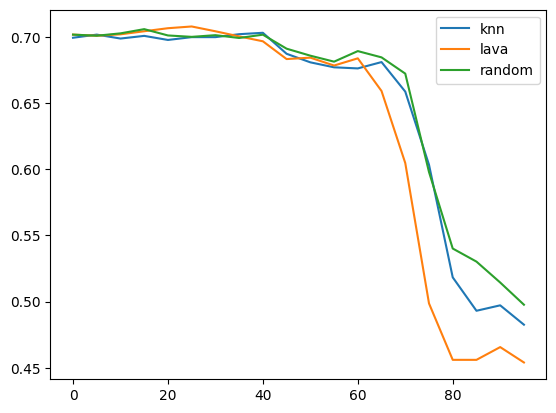

Running add_low experiment...
Epoch [10/100], Loss: 0.9025
Epoch [20/100], Loss: 0.8940
Epoch [30/100], Loss: 0.7903
Epoch [40/100], Loss: 0.8969
Epoch [50/100], Loss: 0.8431
Epoch [60/100], Loss: 0.7866
Epoch [70/100], Loss: 0.7846
Epoch [80/100], Loss: 0.8095
Epoch [90/100], Loss: 0.8355
Epoch [100/100], Loss: 0.8213
Epoch [10/100], Loss: 0.4398
Epoch [20/100], Loss: 0.4369
Epoch [30/100], Loss: 0.3797
Epoch [40/100], Loss: 0.4329
Epoch [50/100], Loss: 0.3769
Epoch [60/100], Loss: 0.3759
Epoch [70/100], Loss: 0.3750
Epoch [80/100], Loss: 0.4283
Epoch [90/100], Loss: 0.3728
Epoch [100/100], Loss: 0.3727
Epoch [10/100], Loss: 0.6635
Epoch [20/100], Loss: 0.7150
Epoch [30/100], Loss: 0.7581
Epoch [40/100], Loss: 0.6999
Epoch [50/100], Loss: 0.6976
Epoch [60/100], Loss: 0.6410
Epoch [70/100], Loss: 0.6935
Epoch [80/100], Loss: 0.5857
Epoch [90/100], Loss: 0.6905
Epoch [100/100], Loss: 0.5817
Epoch [10/100], Loss: 0.8438
Epoch [20/100], Loss: 0.8535
Epoch [30/100], Loss: 0.8425
Epoch [40/

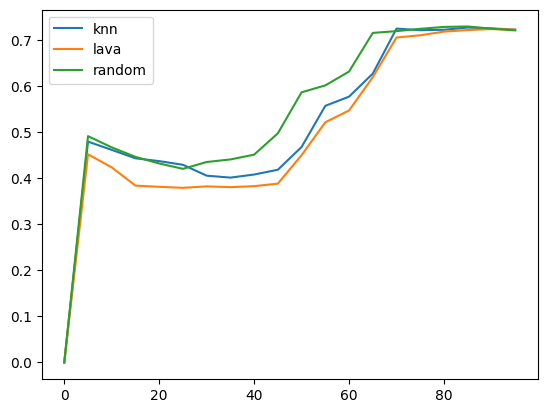

Running add_high experiment...
Epoch [10/100], Loss: 0.4034
Epoch [20/100], Loss: 0.3482
Epoch [30/100], Loss: 0.3478
Epoch [40/100], Loss: 0.3475
Epoch [50/100], Loss: 0.3472
Epoch [60/100], Loss: 0.3469
Epoch [70/100], Loss: 0.3467
Epoch [80/100], Loss: 0.3466
Epoch [90/100], Loss: 0.4011
Epoch [100/100], Loss: 0.3462
Epoch [10/100], Loss: 0.5995
Epoch [20/100], Loss: 0.5966
Epoch [30/100], Loss: 0.5390
Epoch [40/100], Loss: 0.6352
Epoch [50/100], Loss: 0.5355
Epoch [60/100], Loss: 0.4812
Epoch [70/100], Loss: 0.5335
Epoch [80/100], Loss: 0.5312
Epoch [90/100], Loss: 0.5300
Epoch [100/100], Loss: 0.4744
Epoch [10/100], Loss: 0.5689
Epoch [20/100], Loss: 0.6096
Epoch [30/100], Loss: 0.5953
Epoch [40/100], Loss: 0.6682
Epoch [50/100], Loss: 0.5108
Epoch [60/100], Loss: 0.5142
Epoch [70/100], Loss: 0.5525
Epoch [80/100], Loss: 0.6156
Epoch [90/100], Loss: 0.6104
Epoch [100/100], Loss: 0.6100
Epoch [10/100], Loss: 0.3800
Epoch [20/100], Loss: 0.3930
Epoch [30/100], Loss: 0.4194
Epoch [40

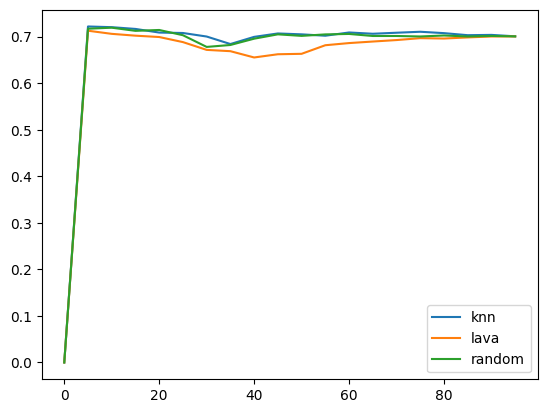

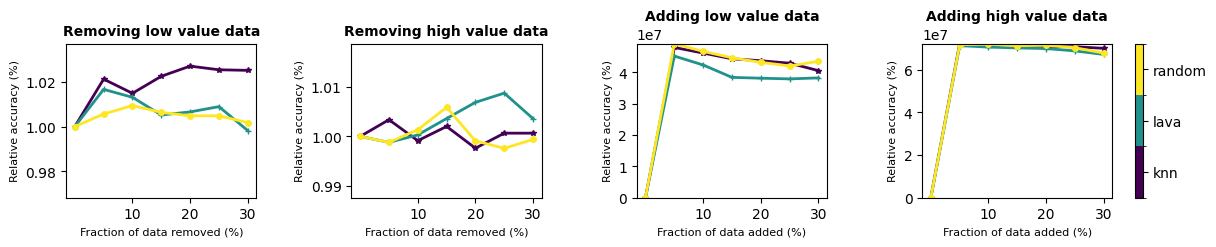

In [60]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 2
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

Running remove_low experiment...
Epoch [10/100], Loss: 0.5930
Epoch [20/100], Loss: 0.5916
Epoch [30/100], Loss: 0.5908
Epoch [40/100], Loss: 0.5906
Epoch [50/100], Loss: 0.5910
Epoch [60/100], Loss: 0.5897
Epoch [70/100], Loss: 0.5902
Epoch [80/100], Loss: 0.5909
Epoch [90/100], Loss: 0.5898
Epoch [100/100], Loss: 0.5904
Epoch [10/100], Loss: 0.5887
Epoch [20/100], Loss: 0.5891
Epoch [30/100], Loss: 0.5879
Epoch [40/100], Loss: 0.5884
Epoch [50/100], Loss: 0.5885
Epoch [60/100], Loss: 0.5892
Epoch [70/100], Loss: 0.5888
Epoch [80/100], Loss: 0.5906
Epoch [90/100], Loss: 0.5884
Epoch [100/100], Loss: 0.5881
Epoch [10/100], Loss: 0.5877
Epoch [20/100], Loss: 0.5890
Epoch [30/100], Loss: 0.5872
Epoch [40/100], Loss: 0.5875
Epoch [50/100], Loss: 0.5893
Epoch [60/100], Loss: 0.5878
Epoch [70/100], Loss: 0.5882
Epoch [80/100], Loss: 0.5880
Epoch [90/100], Loss: 0.5877
Epoch [100/100], Loss: 0.5878
Epoch [10/100], Loss: 0.5515
Epoch [20/100], Loss: 0.5512
Epoch [30/100], Loss: 0.5501
Epoch [

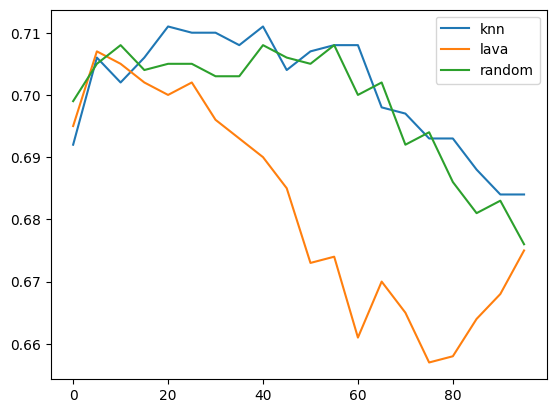

Running remove_high experiment...
Epoch [10/100], Loss: 0.5967
Epoch [20/100], Loss: 0.5925
Epoch [30/100], Loss: 0.5888
Epoch [40/100], Loss: 0.5860
Epoch [50/100], Loss: 0.5872
Epoch [60/100], Loss: 0.5852
Epoch [70/100], Loss: 0.5854
Epoch [80/100], Loss: 0.5846
Epoch [90/100], Loss: 0.5845
Epoch [100/100], Loss: 0.5853
Epoch [10/100], Loss: 0.5855
Epoch [20/100], Loss: 0.5851
Epoch [30/100], Loss: 0.5851
Epoch [40/100], Loss: 0.5834
Epoch [50/100], Loss: 0.5842
Epoch [60/100], Loss: 0.5849
Epoch [70/100], Loss: 0.5849
Epoch [80/100], Loss: 0.5854
Epoch [90/100], Loss: 0.5834
Epoch [100/100], Loss: 0.5839
Epoch [10/100], Loss: 0.5834
Epoch [20/100], Loss: 0.5850
Epoch [30/100], Loss: 0.5834
Epoch [40/100], Loss: 0.5851
Epoch [50/100], Loss: 0.5837
Epoch [60/100], Loss: 0.5847
Epoch [70/100], Loss: 0.5851
Epoch [80/100], Loss: 0.5839
Epoch [90/100], Loss: 0.5850
Epoch [100/100], Loss: 0.5832
Epoch [10/100], Loss: 0.5962
Epoch [20/100], Loss: 0.5971
Epoch [30/100], Loss: 0.5967
Epoch 

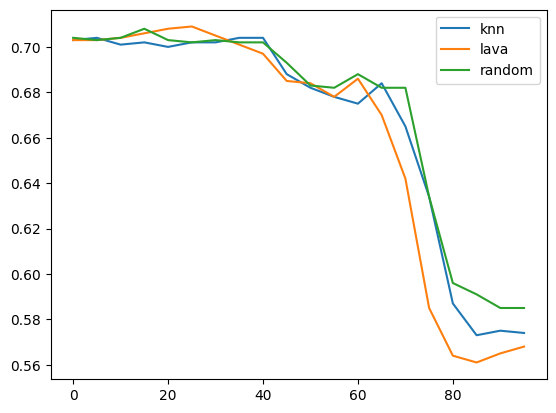

Running add_low experiment...
Epoch [10/100], Loss: 0.8013
Epoch [20/100], Loss: 0.9036
Epoch [30/100], Loss: 0.8543
Epoch [40/100], Loss: 0.8480
Epoch [50/100], Loss: 0.8469
Epoch [60/100], Loss: 0.9017
Epoch [70/100], Loss: 0.8461
Epoch [80/100], Loss: 0.9531
Epoch [90/100], Loss: 0.7843
Epoch [100/100], Loss: 0.8420
Epoch [10/100], Loss: 0.3959
Epoch [20/100], Loss: 0.3974
Epoch [30/100], Loss: 0.3937
Epoch [40/100], Loss: 0.3934
Epoch [50/100], Loss: 0.3945
Epoch [60/100], Loss: 0.3931
Epoch [70/100], Loss: 0.3927
Epoch [80/100], Loss: 0.3923
Epoch [90/100], Loss: 0.4470
Epoch [100/100], Loss: 0.3920
Epoch [10/100], Loss: 0.7937
Epoch [20/100], Loss: 0.6269
Epoch [30/100], Loss: 0.6431
Epoch [40/100], Loss: 0.6190
Epoch [50/100], Loss: 0.6748
Epoch [60/100], Loss: 0.6196
Epoch [70/100], Loss: 0.6314
Epoch [80/100], Loss: 0.5719
Epoch [90/100], Loss: 0.5624
Epoch [100/100], Loss: 0.6721
Epoch [10/100], Loss: 0.8634
Epoch [20/100], Loss: 0.8353
Epoch [30/100], Loss: 0.8322
Epoch [40/

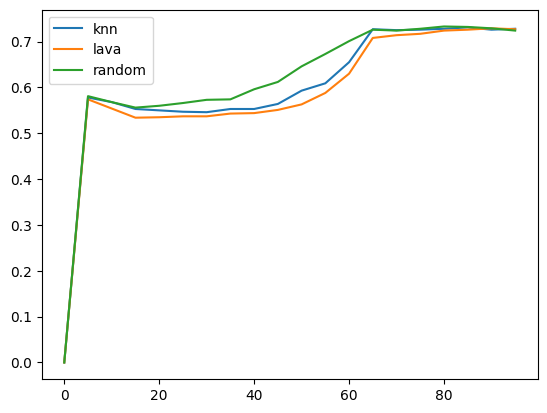

Running add_high experiment...
Epoch [10/100], Loss: 0.3478
Epoch [20/100], Loss: 0.4021
Epoch [30/100], Loss: 0.3470
Epoch [40/100], Loss: 0.3468
Epoch [50/100], Loss: 0.3466
Epoch [60/100], Loss: 0.3467
Epoch [70/100], Loss: 0.3462
Epoch [80/100], Loss: 0.3461
Epoch [90/100], Loss: 0.4007
Epoch [100/100], Loss: 0.3459
Epoch [10/100], Loss: 0.4899
Epoch [20/100], Loss: 0.5993
Epoch [30/100], Loss: 0.5985
Epoch [40/100], Loss: 0.5378
Epoch [50/100], Loss: 0.5354
Epoch [60/100], Loss: 0.5337
Epoch [70/100], Loss: 0.5343
Epoch [80/100], Loss: 0.4766
Epoch [90/100], Loss: 0.5304
Epoch [100/100], Loss: 0.5495
Epoch [10/100], Loss: 0.6726
Epoch [20/100], Loss: 0.6306
Epoch [30/100], Loss: 0.6275
Epoch [40/100], Loss: 0.5146
Epoch [50/100], Loss: 0.5217
Epoch [60/100], Loss: 0.6097
Epoch [70/100], Loss: 0.5637
Epoch [80/100], Loss: 0.5192
Epoch [90/100], Loss: 0.6601
Epoch [100/100], Loss: 0.4957
Epoch [10/100], Loss: 0.3803
Epoch [20/100], Loss: 0.3799
Epoch [30/100], Loss: 0.3805
Epoch [40

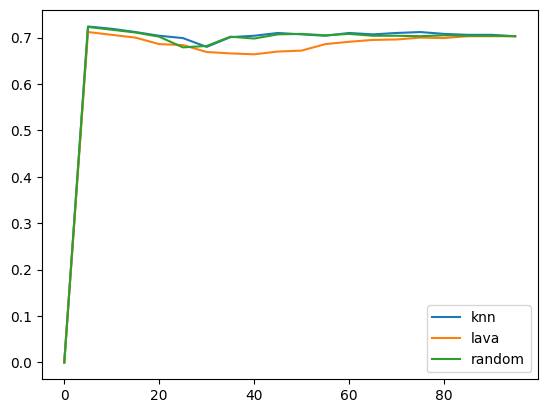

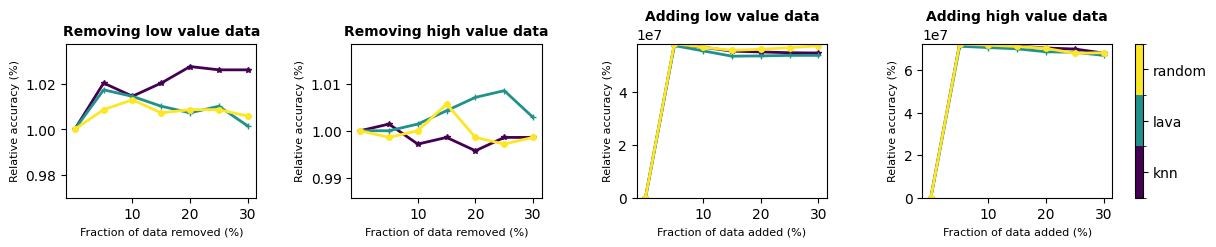

In [61]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 2
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

Running remove_low experiment...
Epoch [10/100], Loss: 0.5942
Epoch [20/100], Loss: 0.5918
Epoch [30/100], Loss: 0.5922
Epoch [40/100], Loss: 0.5908
Epoch [50/100], Loss: 0.5916
Epoch [60/100], Loss: 0.5908
Epoch [70/100], Loss: 0.5891
Epoch [80/100], Loss: 0.5900
Epoch [90/100], Loss: 0.5908
Epoch [100/100], Loss: 0.5909
Epoch [10/100], Loss: 0.5897
Epoch [20/100], Loss: 0.5894
Epoch [30/100], Loss: 0.5882
Epoch [40/100], Loss: 0.5880
Epoch [50/100], Loss: 0.5888
Epoch [60/100], Loss: 0.5887
Epoch [70/100], Loss: 0.5887
Epoch [80/100], Loss: 0.5892
Epoch [90/100], Loss: 0.5884
Epoch [100/100], Loss: 0.5872
Epoch [10/100], Loss: 0.5892
Epoch [20/100], Loss: 0.5890
Epoch [30/100], Loss: 0.5886
Epoch [40/100], Loss: 0.5884
Epoch [50/100], Loss: 0.5875
Epoch [60/100], Loss: 0.5892
Epoch [70/100], Loss: 0.5897
Epoch [80/100], Loss: 0.5884
Epoch [90/100], Loss: 0.5879
Epoch [100/100], Loss: 0.5889
Epoch [10/100], Loss: 0.5513
Epoch [20/100], Loss: 0.5505
Epoch [30/100], Loss: 0.5526
Epoch [

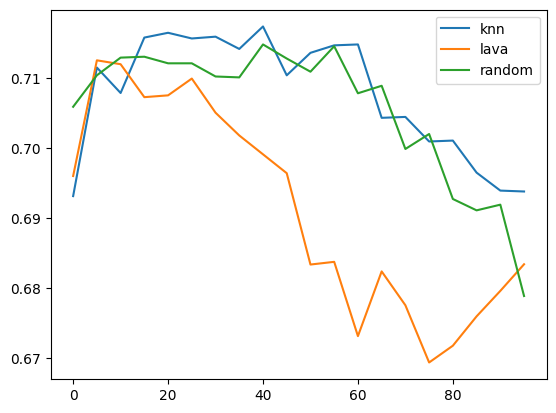

Running remove_high experiment...
Epoch [10/100], Loss: 0.5966
Epoch [20/100], Loss: 0.5917
Epoch [30/100], Loss: 0.5888
Epoch [40/100], Loss: 0.5862
Epoch [50/100], Loss: 0.5863
Epoch [60/100], Loss: 0.5843
Epoch [70/100], Loss: 0.5849
Epoch [80/100], Loss: 0.5848
Epoch [90/100], Loss: 0.5837
Epoch [100/100], Loss: 0.5836
Epoch [10/100], Loss: 0.5839
Epoch [20/100], Loss: 0.5851
Epoch [30/100], Loss: 0.5839
Epoch [40/100], Loss: 0.5841
Epoch [50/100], Loss: 0.5833
Epoch [60/100], Loss: 0.5858
Epoch [70/100], Loss: 0.5854
Epoch [80/100], Loss: 0.5854
Epoch [90/100], Loss: 0.5849
Epoch [100/100], Loss: 0.5850
Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5853
Epoch [30/100], Loss: 0.5864
Epoch [40/100], Loss: 0.5841
Epoch [50/100], Loss: 0.5863
Epoch [60/100], Loss: 0.5846
Epoch [70/100], Loss: 0.5859
Epoch [80/100], Loss: 0.5841
Epoch [90/100], Loss: 0.5854
Epoch [100/100], Loss: 0.5843
Epoch [10/100], Loss: 0.5981
Epoch [20/100], Loss: 0.6009
Epoch [30/100], Loss: 0.5979
Epoch 

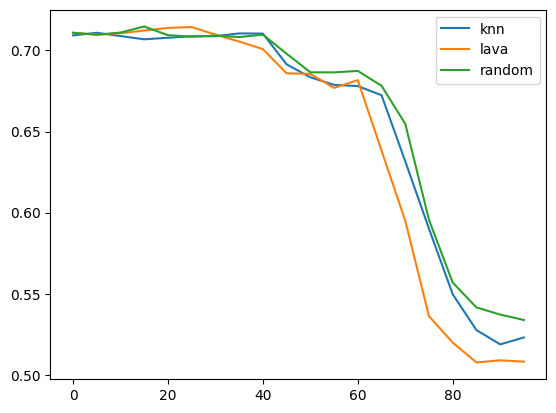

Running add_low experiment...
Epoch [10/100], Loss: 0.8142
Epoch [20/100], Loss: 0.8630
Epoch [30/100], Loss: 0.8077
Epoch [40/100], Loss: 0.8058
Epoch [50/100], Loss: 0.8039
Epoch [60/100], Loss: 0.8027
Epoch [70/100], Loss: 0.8845
Epoch [80/100], Loss: 0.7986
Epoch [90/100], Loss: 0.9052
Epoch [100/100], Loss: 0.8482
Epoch [10/100], Loss: 0.3506
Epoch [20/100], Loss: 0.3418
Epoch [30/100], Loss: 0.3400
Epoch [40/100], Loss: 0.3379
Epoch [50/100], Loss: 0.3364
Epoch [60/100], Loss: 0.3348
Epoch [70/100], Loss: 0.3352
Epoch [80/100], Loss: 0.3332
Epoch [90/100], Loss: 0.3324
Epoch [100/100], Loss: 0.3319
Epoch [10/100], Loss: 0.7610
Epoch [20/100], Loss: 0.7471
Epoch [30/100], Loss: 0.6976
Epoch [40/100], Loss: 0.7456
Epoch [50/100], Loss: 0.7419
Epoch [60/100], Loss: 0.6824
Epoch [70/100], Loss: 0.6737
Epoch [80/100], Loss: 0.6142
Epoch [90/100], Loss: 0.6652
Epoch [100/100], Loss: 0.7150
Epoch [10/100], Loss: 0.7934
Epoch [20/100], Loss: 0.8035
Epoch [30/100], Loss: 0.7901
Epoch [40/

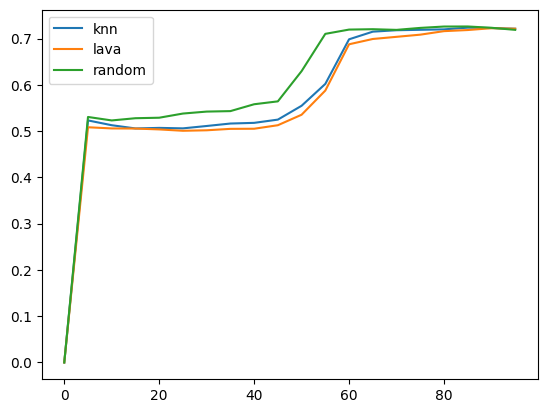

Running add_high experiment...
Epoch [10/100], Loss: 0.3481
Epoch [20/100], Loss: 0.3477
Epoch [30/100], Loss: 0.3474
Epoch [40/100], Loss: 0.3471
Epoch [50/100], Loss: 0.3468
Epoch [60/100], Loss: 0.3466
Epoch [70/100], Loss: 0.4558
Epoch [80/100], Loss: 0.3463
Epoch [90/100], Loss: 0.3461
Epoch [100/100], Loss: 0.3524
Epoch [10/100], Loss: 0.5994
Epoch [20/100], Loss: 0.5151
Epoch [30/100], Loss: 0.4843
Epoch [40/100], Loss: 0.5794
Epoch [50/100], Loss: 0.5353
Epoch [60/100], Loss: 0.5883
Epoch [70/100], Loss: 0.5941
Epoch [80/100], Loss: 0.5315
Epoch [90/100], Loss: 0.5306
Epoch [100/100], Loss: 0.4753
Epoch [10/100], Loss: 0.5798
Epoch [20/100], Loss: 0.5741
Epoch [30/100], Loss: 0.6213
Epoch [40/100], Loss: 0.5066
Epoch [50/100], Loss: 0.5042
Epoch [60/100], Loss: 0.5190
Epoch [70/100], Loss: 0.4986
Epoch [80/100], Loss: 0.5488
Epoch [90/100], Loss: 0.5109
Epoch [100/100], Loss: 0.5694
Epoch [10/100], Loss: 0.3939
Epoch [20/100], Loss: 0.4070
Epoch [30/100], Loss: 0.3809
Epoch [40

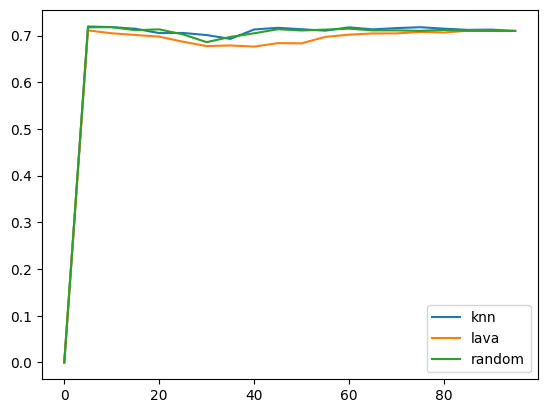

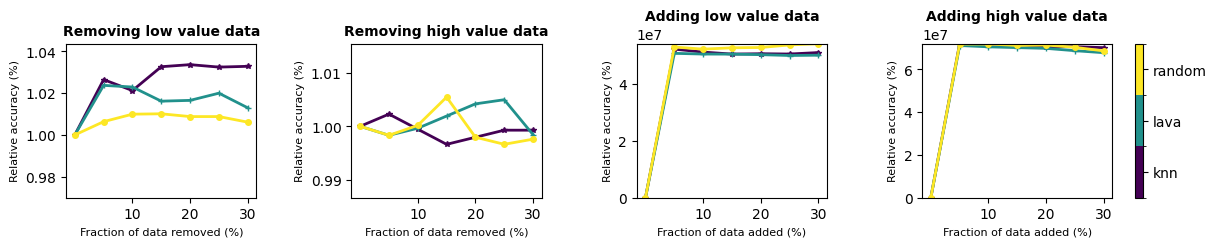

In [63]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 2
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model, metrics='roc')

In [64]:
seed = 40
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
print(rand_lst[0])

[0.40768703 0.05536604 0.78853488 ... 0.92381082 0.74599651 0.66933145]


Running remove_low experiment...
Epoch [10/100], Loss: 0.5936
Epoch [20/100], Loss: 0.5911
Epoch [30/100], Loss: 0.5909
Epoch [40/100], Loss: 0.5906
Epoch [50/100], Loss: 0.5905
Epoch [60/100], Loss: 0.5902
Epoch [70/100], Loss: 0.5907
Epoch [80/100], Loss: 0.5902
Epoch [90/100], Loss: 0.5898
Epoch [100/100], Loss: 0.5911
Epoch [10/100], Loss: 0.5891
Epoch [20/100], Loss: 0.5894
Epoch [30/100], Loss: 0.5891
Epoch [40/100], Loss: 0.5897
Epoch [50/100], Loss: 0.5901
Epoch [60/100], Loss: 0.5884
Epoch [70/100], Loss: 0.5888
Epoch [80/100], Loss: 0.5879
Epoch [90/100], Loss: 0.5897
Epoch [100/100], Loss: 0.5892
Epoch [10/100], Loss: 0.5877
Epoch [20/100], Loss: 0.5881
Epoch [30/100], Loss: 0.5876
Epoch [40/100], Loss: 0.5883
Epoch [50/100], Loss: 0.5893
Epoch [60/100], Loss: 0.5889
Epoch [70/100], Loss: 0.5887
Epoch [80/100], Loss: 0.5873
Epoch [90/100], Loss: 0.5886
Epoch [100/100], Loss: 0.5887
Epoch [10/100], Loss: 0.5511
Epoch [20/100], Loss: 0.5511
Epoch [30/100], Loss: 0.5494
Epoch [

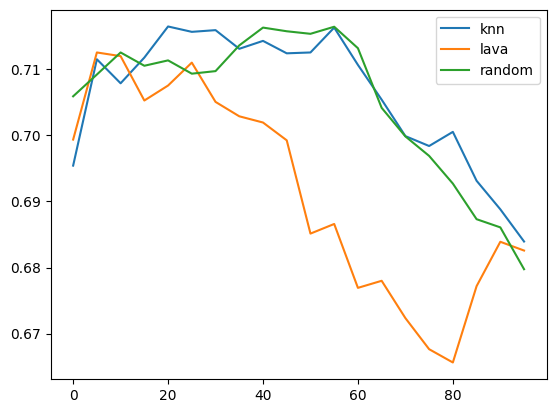

Running remove_high experiment...
Epoch [10/100], Loss: 0.6044
Epoch [20/100], Loss: 0.5939
Epoch [30/100], Loss: 0.5928
Epoch [40/100], Loss: 0.5882
Epoch [50/100], Loss: 0.5853
Epoch [60/100], Loss: 0.5862
Epoch [70/100], Loss: 0.5841
Epoch [80/100], Loss: 0.5852
Epoch [90/100], Loss: 0.5841
Epoch [100/100], Loss: 0.5831
Epoch [10/100], Loss: 0.5854
Epoch [20/100], Loss: 0.5845
Epoch [30/100], Loss: 0.5851
Epoch [40/100], Loss: 0.5861
Epoch [50/100], Loss: 0.5849
Epoch [60/100], Loss: 0.5847
Epoch [70/100], Loss: 0.5853
Epoch [80/100], Loss: 0.5840
Epoch [90/100], Loss: 0.5858
Epoch [100/100], Loss: 0.5858
Epoch [10/100], Loss: 0.5849
Epoch [20/100], Loss: 0.5837
Epoch [30/100], Loss: 0.5840
Epoch [40/100], Loss: 0.5855
Epoch [50/100], Loss: 0.5834
Epoch [60/100], Loss: 0.5859
Epoch [70/100], Loss: 0.5859
Epoch [80/100], Loss: 0.5856
Epoch [90/100], Loss: 0.5844
Epoch [100/100], Loss: 0.5842
Epoch [10/100], Loss: 0.5972
Epoch [20/100], Loss: 0.5962
Epoch [30/100], Loss: 0.5987
Epoch 

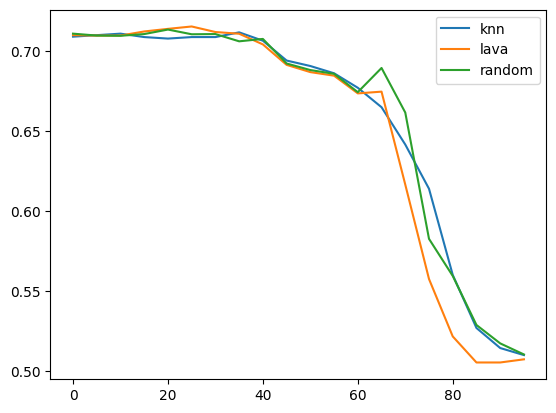

Running add_low experiment...
Epoch [10/100], Loss: 0.7297
Epoch [20/100], Loss: 0.8219
Epoch [30/100], Loss: 0.7927
Epoch [40/100], Loss: 0.8181
Epoch [50/100], Loss: 0.7760
Epoch [60/100], Loss: 0.7235
Epoch [70/100], Loss: 0.7713
Epoch [80/100], Loss: 0.7696
Epoch [90/100], Loss: 0.6576
Epoch [100/100], Loss: 0.7652
Epoch [10/100], Loss: 0.3453
Epoch [20/100], Loss: 0.3435
Epoch [30/100], Loss: 0.3726
Epoch [40/100], Loss: 0.3409
Epoch [50/100], Loss: 0.3400
Epoch [60/100], Loss: 0.3388
Epoch [70/100], Loss: 0.3925
Epoch [80/100], Loss: 0.3371
Epoch [90/100], Loss: 0.3362
Epoch [100/100], Loss: 0.3409
Epoch [10/100], Loss: 0.6984
Epoch [20/100], Loss: 0.8601
Epoch [30/100], Loss: 0.7501
Epoch [40/100], Loss: 0.6940
Epoch [50/100], Loss: 0.7476
Epoch [60/100], Loss: 0.6373
Epoch [70/100], Loss: 0.7451
Epoch [80/100], Loss: 0.6908
Epoch [90/100], Loss: 0.7448
Epoch [100/100], Loss: 0.7437
Epoch [10/100], Loss: 0.7759
Epoch [20/100], Loss: 0.7883
Epoch [30/100], Loss: 0.7856
Epoch [40/

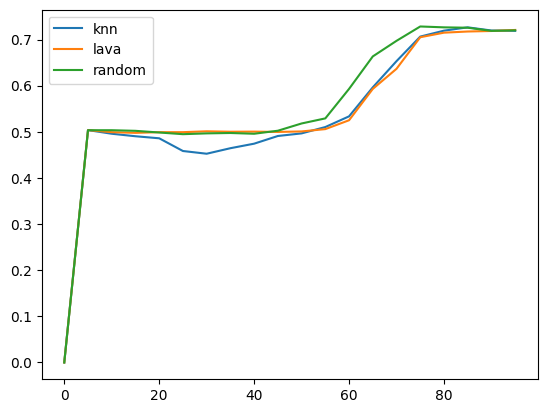

Running add_high experiment...
Epoch [10/100], Loss: 0.3577
Epoch [20/100], Loss: 0.3561
Epoch [30/100], Loss: 0.3472
Epoch [40/100], Loss: 0.3468
Epoch [50/100], Loss: 0.3466
Epoch [60/100], Loss: 0.3464
Epoch [70/100], Loss: 0.3462
Epoch [80/100], Loss: 0.4008
Epoch [90/100], Loss: 0.4007
Epoch [100/100], Loss: 0.3459
Epoch [10/100], Loss: 0.5467
Epoch [20/100], Loss: 0.4862
Epoch [30/100], Loss: 0.5381
Epoch [40/100], Loss: 0.5362
Epoch [50/100], Loss: 0.4837
Epoch [60/100], Loss: 0.5326
Epoch [70/100], Loss: 0.5950
Epoch [80/100], Loss: 0.5303
Epoch [90/100], Loss: 0.4748
Epoch [100/100], Loss: 0.5289
Epoch [10/100], Loss: 0.6347
Epoch [20/100], Loss: 0.5697
Epoch [30/100], Loss: 0.6105
Epoch [40/100], Loss: 0.6098
Epoch [50/100], Loss: 0.6091
Epoch [60/100], Loss: 0.6608
Epoch [70/100], Loss: 0.7175
Epoch [80/100], Loss: 0.6118
Epoch [90/100], Loss: 0.6113
Epoch [100/100], Loss: 0.5525
Epoch [10/100], Loss: 0.3766
Epoch [20/100], Loss: 0.3899
Epoch [30/100], Loss: 0.3902
Epoch [40

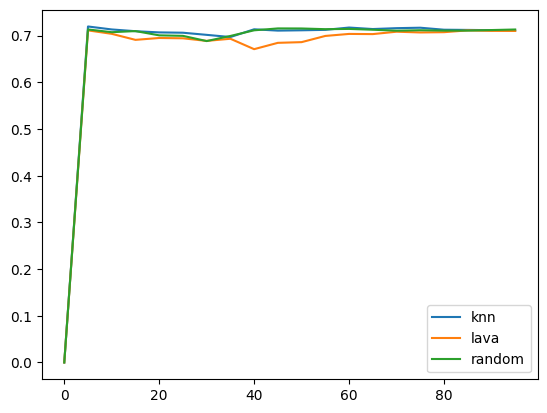

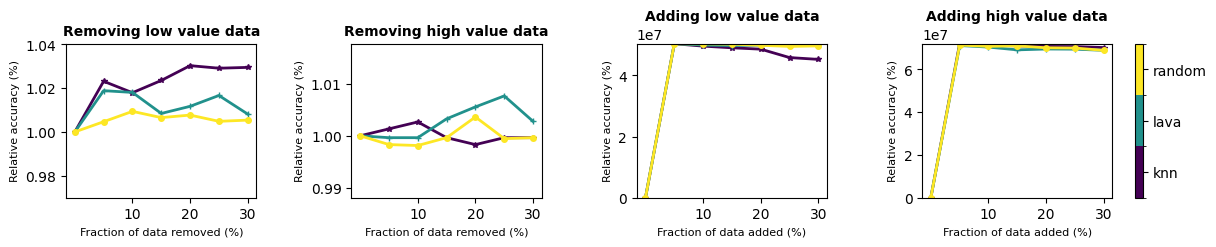

In [65]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 40
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model, metrics='roc')

Running remove_low experiment...
Epoch [10/100], Loss: 0.5948
Epoch [20/100], Loss: 0.5920
Epoch [30/100], Loss: 0.5907
Epoch [40/100], Loss: 0.5908
Epoch [50/100], Loss: 0.5910
Epoch [60/100], Loss: 0.5896
Epoch [70/100], Loss: 0.5909
Epoch [80/100], Loss: 0.5917
Epoch [90/100], Loss: 0.5896
Epoch [100/100], Loss: 0.5891
Epoch [10/100], Loss: 0.5941
Epoch [20/100], Loss: 0.5915
Epoch [30/100], Loss: 0.5921
Epoch [40/100], Loss: 0.5906
Epoch [50/100], Loss: 0.5921
Epoch [60/100], Loss: 0.5903
Epoch [70/100], Loss: 0.5898
Epoch [80/100], Loss: 0.5896
Epoch [90/100], Loss: 0.5906
Epoch [100/100], Loss: 0.5901
Epoch [10/100], Loss: 0.5938
Epoch [20/100], Loss: 0.5924
Epoch [30/100], Loss: 0.5908
Epoch [40/100], Loss: 0.5894
Epoch [50/100], Loss: 0.5903
Epoch [60/100], Loss: 0.5896
Epoch [70/100], Loss: 0.5892
Epoch [80/100], Loss: 0.5904
Epoch [90/100], Loss: 0.5909
Epoch [100/100], Loss: 0.5898
Epoch [10/100], Loss: 0.5608
Epoch [20/100], Loss: 0.5573
Epoch [30/100], Loss: 0.5555
Epoch [

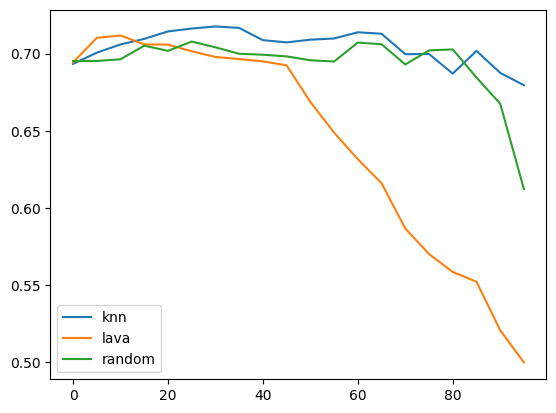

Running remove_high experiment...
Epoch [10/100], Loss: 0.5940
Epoch [20/100], Loss: 0.5914
Epoch [30/100], Loss: 0.5916
Epoch [40/100], Loss: 0.5913
Epoch [50/100], Loss: 0.5902
Epoch [60/100], Loss: 0.5909
Epoch [70/100], Loss: 0.5911
Epoch [80/100], Loss: 0.5899
Epoch [90/100], Loss: 0.5897
Epoch [100/100], Loss: 0.5912
Epoch [10/100], Loss: 0.5939
Epoch [20/100], Loss: 0.5918
Epoch [30/100], Loss: 0.5905
Epoch [40/100], Loss: 0.5919
Epoch [50/100], Loss: 0.5904
Epoch [60/100], Loss: 0.5912
Epoch [70/100], Loss: 0.5913
Epoch [80/100], Loss: 0.5894
Epoch [90/100], Loss: 0.5907
Epoch [100/100], Loss: 0.5899
Epoch [10/100], Loss: 0.5939
Epoch [20/100], Loss: 0.5923
Epoch [30/100], Loss: 0.5902
Epoch [40/100], Loss: 0.5915
Epoch [50/100], Loss: 0.5915
Epoch [60/100], Loss: 0.5901
Epoch [70/100], Loss: 0.5899
Epoch [80/100], Loss: 0.5894
Epoch [90/100], Loss: 0.5925
Epoch [100/100], Loss: 0.5899
Epoch [10/100], Loss: 0.6061
Epoch [20/100], Loss: 0.6042
Epoch [30/100], Loss: 0.6039
Epoch 

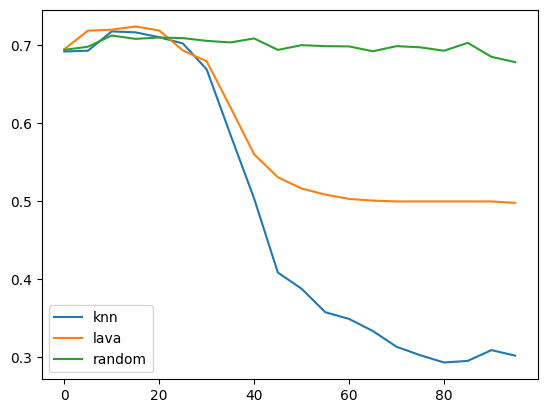

Running add_low experiment...
Epoch [10/100], Loss: 0.4249
Epoch [20/100], Loss: 0.3795
Epoch [30/100], Loss: 0.3614
Epoch [40/100], Loss: 0.3800
Epoch [50/100], Loss: 0.3459
Epoch [60/100], Loss: 0.3421
Epoch [70/100], Loss: 0.3378
Epoch [80/100], Loss: 0.3370
Epoch [90/100], Loss: 0.3393
Epoch [100/100], Loss: 0.3373
Epoch [10/100], Loss: 0.4310
Epoch [20/100], Loss: 0.3830
Epoch [30/100], Loss: 0.3597
Epoch [40/100], Loss: 0.3671
Epoch [50/100], Loss: 0.3508
Epoch [60/100], Loss: 0.3407
Epoch [70/100], Loss: 0.3366
Epoch [80/100], Loss: 0.3347
Epoch [90/100], Loss: 0.3335
Epoch [100/100], Loss: 0.3333
Epoch [10/100], Loss: 0.6872
Epoch [20/100], Loss: 0.6188
Epoch [30/100], Loss: 0.5928
Epoch [40/100], Loss: 0.6157
Epoch [50/100], Loss: 0.6564
Epoch [60/100], Loss: 0.6621
Epoch [70/100], Loss: 0.6487
Epoch [80/100], Loss: 0.5672
Epoch [90/100], Loss: 0.6144
Epoch [100/100], Loss: 0.5624
Epoch [10/100], Loss: 0.4002
Epoch [20/100], Loss: 0.3658
Epoch [30/100], Loss: 0.3547
Epoch [40/

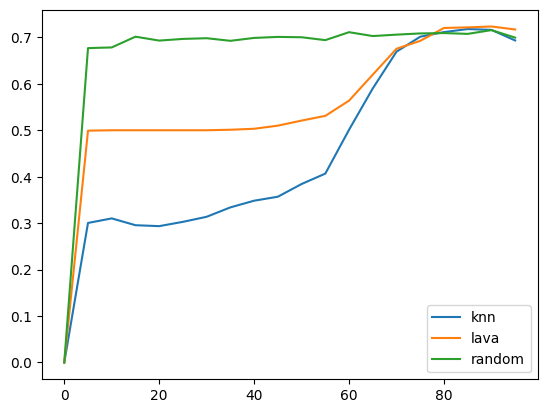

Running add_high experiment...
Epoch [10/100], Loss: 0.4084
Epoch [20/100], Loss: 0.3723
Epoch [30/100], Loss: 0.3676
Epoch [40/100], Loss: 0.3497
Epoch [50/100], Loss: 0.3442
Epoch [60/100], Loss: 0.3466
Epoch [70/100], Loss: 0.3370
Epoch [80/100], Loss: 0.3343
Epoch [90/100], Loss: 0.3303
Epoch [100/100], Loss: 0.3286
Epoch [10/100], Loss: 0.4144
Epoch [20/100], Loss: 0.3809
Epoch [30/100], Loss: 0.3960
Epoch [40/100], Loss: 0.3483
Epoch [50/100], Loss: 0.3846
Epoch [60/100], Loss: 0.3404
Epoch [70/100], Loss: 0.3420
Epoch [80/100], Loss: 0.3347
Epoch [90/100], Loss: 0.3331
Epoch [100/100], Loss: 0.3320
Epoch [10/100], Loss: 0.6594
Epoch [20/100], Loss: 0.5776
Epoch [30/100], Loss: 0.5755
Epoch [40/100], Loss: 0.6203
Epoch [50/100], Loss: 0.5897
Epoch [60/100], Loss: 0.6250
Epoch [70/100], Loss: 0.5432
Epoch [80/100], Loss: 0.5895
Epoch [90/100], Loss: 0.6076
Epoch [100/100], Loss: 0.5228
Epoch [10/100], Loss: 0.3893
Epoch [20/100], Loss: 0.3617
Epoch [30/100], Loss: 0.3489
Epoch [40

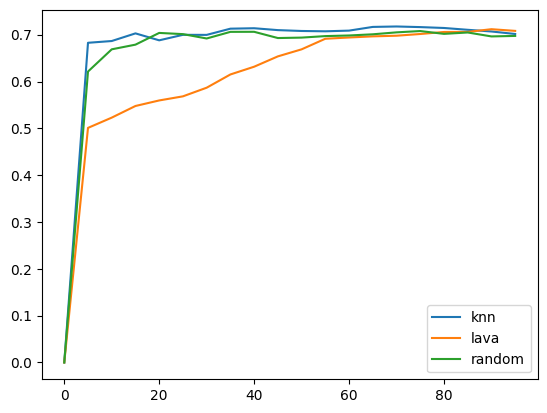

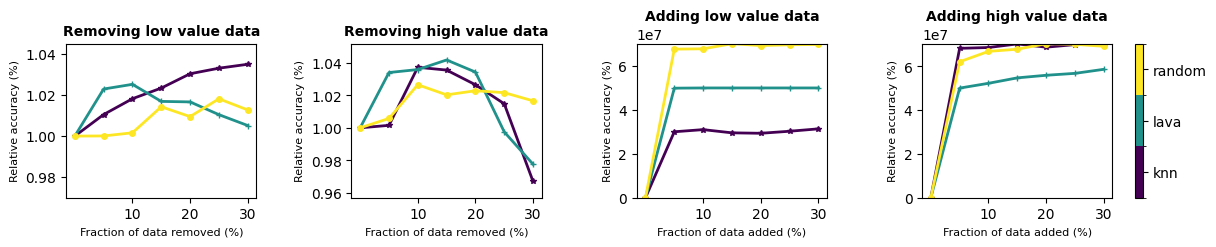

In [68]:
from experiment_run import run_experiments
name = ['knn', 'lava', 'random']
seed = 40
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model, metrics='roc')

In [3]:
X, y = download_iris()
print(X.shape, y.shape)

(150, 4) (150,)


In [5]:
from datasets import split_data_train_val_test
#X_numpy = X.detach().cpu().numpy()
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data_train_val_test(X, y, 0.5, 0.3, 1)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)

Train: (75, 4) Validation: (45, 4) Test: (30, 4)
(75, 4) (45, 4) (30, 4)
(75,) (45,) (30,)


In [6]:
# save
import pickle

with open('x_y_embedding_iris.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_valid, Y_valid, X_test, Y_test), f)

In [23]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_iris.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(75, 4) (45, 4) (30, 4)
(75,) (45,) (30,)


In [24]:
import torch
import numpy as np

# Chuyển dữ liệu sang torch.Tensor nếu cần
x_embeddings = torch.tensor(x_embeddings, dtype=torch.float32) if not isinstance(x_embeddings, torch.Tensor) else x_embeddings
xt_embeddings = torch.tensor(xt_embeddings, dtype=torch.float32) if not isinstance(xt_embeddings, torch.Tensor) else xt_embeddings

# Tính giá trị trung bình và độ lệch chuẩn từ X_train
mean = x_embeddings.mean(dim=0)  # Trung bình theo từng cột (feature)
std = x_embeddings.std(dim=0)    # Độ lệch chuẩn theo từng cột (feature)

# Đảm bảo std không có giá trị 0 để tránh chia cho 0
std[std == 0] = 1e-8

# Chuẩn hóa dữ liệu
X_train_normalized = (x_embeddings - mean) / std
X_valid_normalized = (xt_embeddings - mean) / std

# In kết quả
print("After normalization:")
print(X_train_normalized.shape, X_valid_normalized.shape)


After normalization:
torch.Size([75, 4]) torch.Size([45, 4])


In [25]:
from machine_learning_model import LogisticRegression
from nosify import mix_label, add_gauss_noise
X_copy = X_train_normalized.clone()
param = add_gauss_noise(X_copy, X_valid_normalized, noise_rate=0.2)
X_train_normalized_noisy = param['x_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", X_train_normalized_noisy.shape)
# train model logistic regression
input_dim = X_train_normalized_noisy.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(X_train_normalized_noisy, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(X_valid_normalized)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Noisy training labels shape: torch.Size([75, 4])
Epoch [10/1000], Loss: 0.8755
Epoch [20/1000], Loss: 0.8755
Epoch [30/1000], Loss: 0.8210
Epoch [40/1000], Loss: 0.7919
Epoch [50/1000], Loss: 0.7826
Epoch [60/1000], Loss: 0.7958
Epoch [70/1000], Loss: 0.7692
Epoch [80/1000], Loss: 0.7616
Epoch [90/1000], Loss: 0.7522
Epoch [100/1000], Loss: 0.7405
Epoch [110/1000], Loss: 0.7710
Epoch [120/1000], Loss: 0.7271
Epoch [130/1000], Loss: 0.7427
Epoch [140/1000], Loss: 0.7137
Epoch [150/1000], Loss: 0.7472
Epoch [160/1000], Loss: 0.7407
Epoch [170/1000], Loss: 0.7386
Epoch [180/1000], Loss: 0.7213
Epoch [190/1000], Loss: 0.7161
Epoch [200/1000], Loss: 0.7388
Epoch [210/1000], Loss: 0.7265
Epoch [220/1000], Loss: 0.7131
Epoch [230/1000], Loss: 0.6922
Epoch [240/1000], Loss: 0.7099
Epoch [250/1000], Loss: 0.6947
Epoch [260/1000], Loss: 0.6914
Epoch [270/1000], Loss: 0.7055
Epoch [280/1000], Loss: 0.6784
Epoch [290/1000], Loss: 0.6735
Epoch [300/1000], Loss: 0.6859
Epoch [310/1000], Loss: 0.6833

Running evaluator: KNNEvaluator


100%|██████████| 74/74 [00:00<00:00, 7779.49it/s]


KNNEvaluator completed in 0.02 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 5.8736, 24.4847,  9.0920,  ...,  2.8116,  8.1547,  9.9513],
        [ 1.9039, 10.7049,  0.1321,  ...,  1.9848,  3.4723,  0.6833],
        [ 0.0642, 12.1290,  3.3976,  ...,  4.7682,  0.4151,  2.7722],
        ...,
        [ 0.3928,  8.4013,  2.8625,  ...,  4.8221,  0.2365,  1.5227],
        [ 5.4365, 21.5191,  6.7705,  ...,  1.3203,  7.8092,  7.5882],
        [11.6031, 32.0407, 11.3055,  ..., 19.3657, 14.1864, 14.1580]])
C2 la: tensor([[0.1022, 0.1295, 0.1022,  ..., 0.0000, 0.1295, 0.1295],
        [0.0000, 0.0835, 0.0000,  ..., 0.1022, 0.0835, 0.0835],
        [0.0000, 0.0835, 0.0000,  ..., 0.1022, 0.0835, 0.0835],
        ...,
        [0.0835, 0.0000, 0.0835,  ..., 0.1295, 0.0000, 0.0000],
        [0.1022, 0.1295, 0.1022,  ..., 0.0000, 0.1295, 0.1295],
        [0.0000, 0.0835, 0.0000,  ..., 0.1022, 0.0835, 0.0835]])
C1 la: tensor([[0.0948, 0.3954, 0.1468,  ..., 0.0453, 0.1316, 0.1606],
        [0.0306, 0.1728, 0.0020,  ..., 0.0319, 0.0560, 0.0109],
        [0.0009, 0.

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


  980|1.862645e-09|
  990|1.862645e-09|
LavaEvaluator completed in 0.19 seconds.
KNNEvaluator: {'found_rates': [0.0, 0.2, 0.4666666666666667, 0.6666666666666666, 0.7333333333333333, 0.8666666666666667, 0.8666666666666667, 0.9333333333333333, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375]}


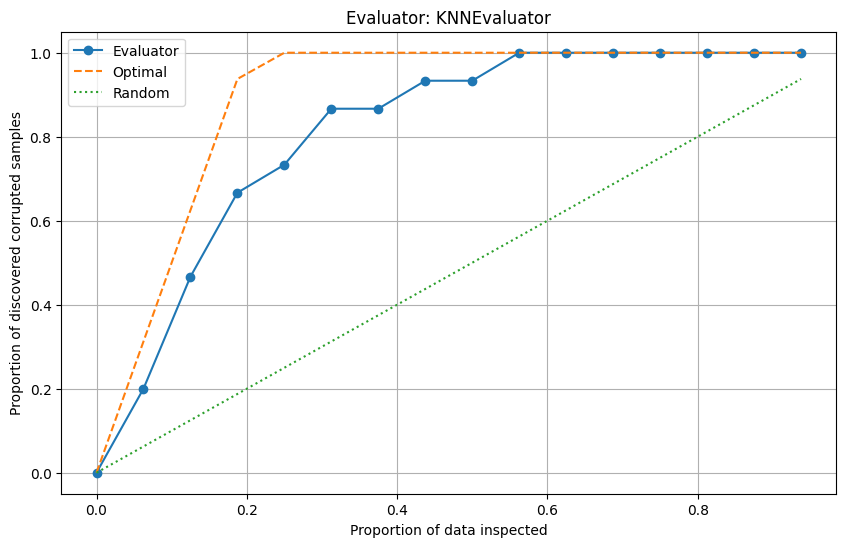

LavaEvaluator: {'found_rates': [0.0, 0.3333333333333333, 0.6666666666666666, 0.8666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375]}


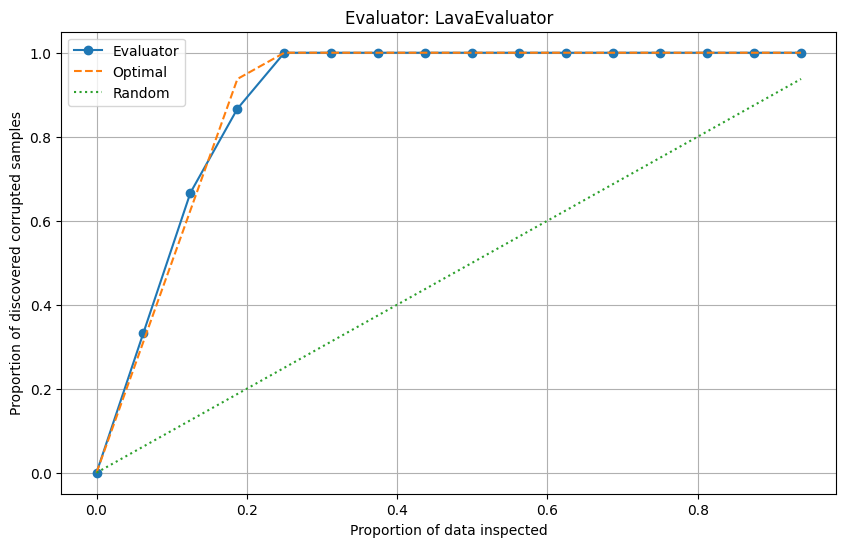

{'KNNEvaluator': {'found_rates': [0.0,
   0.2,
   0.4666666666666667,
   0.6666666666666666,
   0.7333333333333333,
   0.8666666666666667,
   0.8666666666666667,
   0.9333333333333333,
   0.9333333333333333,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.0625,
   0.125,
   0.1875,
   0.25,
   0.3125,
   0.375,
   0.4375,
   0.5,
   0.5625,
   0.625,
   0.6875,
   0.75,
   0.8125,
   0.875,
   0.9375]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.3333333333333333,
   0.6666666666666666,
   0.8666666666666667,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.0625,
   0.125,
   0.1875,
   0.25,
   0.3125,
   0.375,
   0.4375,
   0.5,
   0.5625,
   0.625,
   0.6875,
   0.75,
   0.8125,
   0.875,
   0.9375]}}

In [26]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(X_train_normalized_noisy, y_labels, X_valid_normalized, yt_labels)
experiment.evaluate(noisy_train_indices)

In [27]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

45
Noisy training labels shape: (75,)
Epoch [10/1000], Loss: 1.1126
Epoch [20/1000], Loss: 1.0310
Epoch [30/1000], Loss: 0.9690
Epoch [40/1000], Loss: 0.9545
Epoch [50/1000], Loss: 0.9327
Epoch [60/1000], Loss: 0.9257
Epoch [70/1000], Loss: 0.9164
Epoch [80/1000], Loss: 0.8862
Epoch [90/1000], Loss: 0.9246
Epoch [100/1000], Loss: 0.9126
Epoch [110/1000], Loss: 0.8899
Epoch [120/1000], Loss: 0.8955
Epoch [130/1000], Loss: 0.9054
Epoch [140/1000], Loss: 0.8776
Epoch [150/1000], Loss: 0.9119
Epoch [160/1000], Loss: 0.8815
Epoch [170/1000], Loss: 0.9127
Epoch [180/1000], Loss: 0.8737
Epoch [190/1000], Loss: 0.8255
Epoch [200/1000], Loss: 0.8609
Epoch [210/1000], Loss: 0.8600
Epoch [220/1000], Loss: 0.8727
Epoch [230/1000], Loss: 0.8739
Epoch [240/1000], Loss: 0.8388
Epoch [250/1000], Loss: 0.8570
Epoch [260/1000], Loss: 0.8516
Epoch [270/1000], Loss: 0.8788
Epoch [280/1000], Loss: 0.8245
Epoch [290/1000], Loss: 0.8432
Epoch [300/1000], Loss: 0.8808
Epoch [310/1000], Loss: 0.8416
Epoch [320

Running evaluator: KNNEvaluator


100%|██████████| 74/74 [00:00<00:00, 9881.52it/s]


KNNEvaluator completed in 0.01 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 6.1950, 11.2700,  4.2900,  ...,  0.9850, 10.3650,  8.1000],
        [ 1.7900,  4.4750,  0.0750,  ...,  1.6100,  3.9300,  1.3250],
        [ 0.0350,  0.6900,  2.2100,  ...,  6.2650,  0.5050,  1.6200],
        ...,
        [ 0.3350,  0.3700,  2.1900,  ...,  7.1250,  0.2250,  0.7800],
        [ 5.5000, 10.1850,  2.8950,  ...,  0.2900,  9.4000,  6.1950],
        [ 0.4150,  1.8900,  0.7500,  ...,  4.3250,  1.6650,  1.0200]])
C2 la: tensor([[0.2015, 0.0000, 0.2015,  ..., 0.0000, 0.3155, 0.3155],
        [0.0000, 0.2015, 0.0000,  ..., 0.2015, 0.0745, 0.0745],
        [0.0000, 0.2015, 0.0000,  ..., 0.2015, 0.0745, 0.0745],
        ...,
        [0.0745, 0.3155, 0.0745,  ..., 0.3155, 0.0000, 0.0000],
        [0.2015, 0.0000, 0.2015,  ..., 0.0000, 0.3155, 0.3155],
        [0.2015, 0.0000, 0.2015,  ..., 0.0000, 0.3155, 0.3155]])
C1 la: tensor([[0.2645, 0.4813, 0.1831,  ..., 0.0419, 0.4426, 0.3459],
        [0.0763, 0.1910, 0.0030,  ..., 0.0686, 0.1677, 0.0564],
        [0.0013, 0.

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


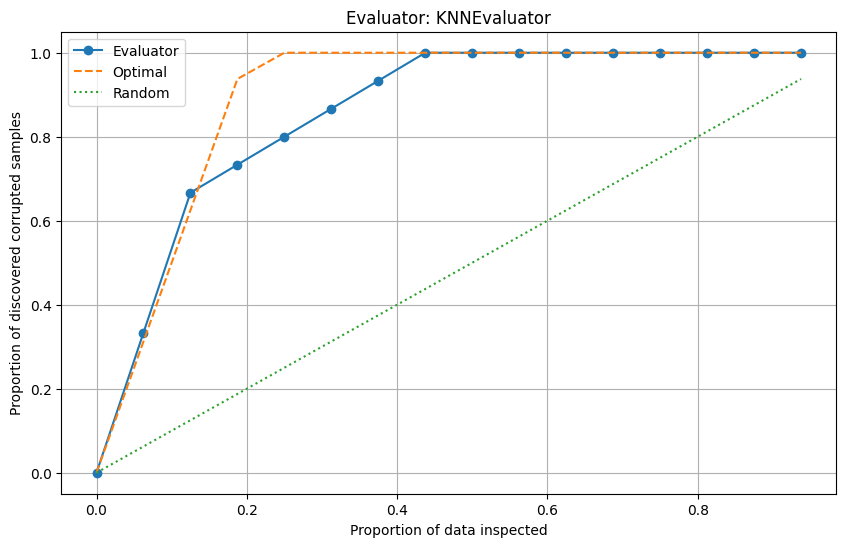

LavaEvaluator: {'found_rates': [0.0, 0.2, 0.26666666666666666, 0.3333333333333333, 0.4, 0.5333333333333333, 0.6, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], 'axis': [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375]}


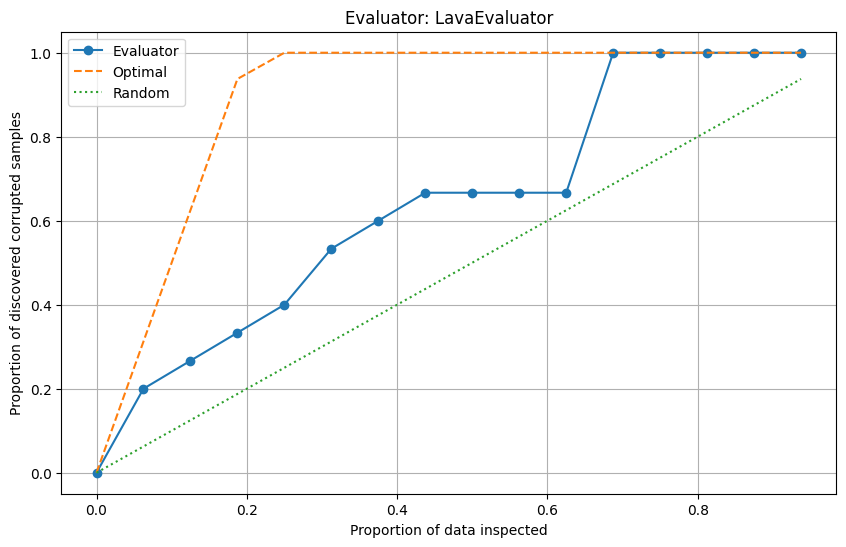

{'KNNEvaluator': {'found_rates': [0.0,
   0.3333333333333333,
   0.6666666666666666,
   0.7333333333333333,
   0.8,
   0.8666666666666667,
   0.9333333333333333,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.0625,
   0.125,
   0.1875,
   0.25,
   0.3125,
   0.375,
   0.4375,
   0.5,
   0.5625,
   0.625,
   0.6875,
   0.75,
   0.8125,
   0.875,
   0.9375]},
 'LavaEvaluator': {'found_rates': [0.0,
   0.2,
   0.26666666666666666,
   0.3333333333333333,
   0.4,
   0.5333333333333333,
   0.6,
   0.6666666666666666,
   0.6666666666666666,
   0.6666666666666666,
   0.6666666666666666,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0],
  'axis': [0.0,
   0.0625,
   0.125,
   0.1875,
   0.25,
   0.3125,
   0.375,
   0.4375,
   0.5,
   0.5625,
   0.625,
   0.6875,
   0.75,
   0.8125,
   0.875,
   0.9375]}}

In [28]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
experiment.evaluate(noisy_train_indices)

In [3]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_iris.pkl', 'rb') as f:
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = pickle.load(f)
print(X_train.shape, X_valid.shape, X_test.shape)
print(Y_train.shape, Y_valid.shape, Y_test.shape)
x_embeddings = X_train
xt_embeddings = X_valid
y_labels = Y_train
yt_labels = Y_valid

(75, 4) (45, 4) (30, 4)
(75,) (45,) (30,)


In [50]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
y_copy = y_labels.copy()
param = mix_label(y_copy, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

45
Noisy training labels shape: (75,)
Epoch [10/1000], Loss: 1.1991
Epoch [20/1000], Loss: 1.1759
Epoch [30/1000], Loss: 1.1901
Epoch [40/1000], Loss: 1.1649
Epoch [50/1000], Loss: 1.1330
Epoch [60/1000], Loss: 1.1065
Epoch [70/1000], Loss: 1.1399
Epoch [80/1000], Loss: 1.1278
Epoch [90/1000], Loss: 1.1365
Epoch [100/1000], Loss: 1.1217
Epoch [110/1000], Loss: 1.1097
Epoch [120/1000], Loss: 1.1120
Epoch [130/1000], Loss: 1.1158
Epoch [140/1000], Loss: 1.0870
Epoch [150/1000], Loss: 1.0932
Epoch [160/1000], Loss: 1.0854
Epoch [170/1000], Loss: 1.0527
Epoch [180/1000], Loss: 1.0736
Epoch [190/1000], Loss: 1.0642
Epoch [200/1000], Loss: 1.0295
Epoch [210/1000], Loss: 1.0250
Epoch [220/1000], Loss: 1.0113
Epoch [230/1000], Loss: 0.9943
Epoch [240/1000], Loss: 0.9963
Epoch [250/1000], Loss: 0.9887
Epoch [260/1000], Loss: 0.9792
Epoch [270/1000], Loss: 0.9677
Epoch [280/1000], Loss: 0.9899
Epoch [290/1000], Loss: 0.9590
Epoch [300/1000], Loss: 0.9413
Epoch [310/1000], Loss: 0.9712
Epoch [320

In [5]:
from base_evaluator import BaseEvaluator, KNNEvaluator, LavaEvaluator, ExperimentRunner

knn_evaluator = KNNEvaluator()
lava_evaluator = LavaEvaluator()
experiment = ExperimentRunner(evaluators=[knn_evaluator, lava_evaluator])
results = experiment.run(x_embeddings, y_labels_noisy, xt_embeddings, yt_labels)
print(results)

Running evaluator: KNNEvaluator


100%|██████████| 74/74 [00:00<00:00, 5692.09it/s]


KNNEvaluator completed in 0.08 seconds.
Running evaluator: LavaEvaluator


C1 la: tensor([[ 6.1950, 11.2700,  4.2900,  ...,  0.9850, 10.3650,  8.1000],
        [ 1.7900,  4.4750,  0.0750,  ...,  1.6100,  3.9300,  1.3250],
        [ 0.0350,  0.6900,  2.2100,  ...,  6.2650,  0.5050,  1.6200],
        ...,
        [ 0.3350,  0.3700,  2.1900,  ...,  7.1250,  0.2250,  0.7800],
        [ 5.5000, 10.1850,  2.8950,  ...,  0.2900,  9.4000,  6.1950],
        [ 0.4150,  1.8900,  0.7500,  ...,  4.3250,  1.6650,  1.0200]])
C2 la: tensor([[0.2015, 0.0000, 0.2015,  ..., 0.0000, 0.3155, 0.3155],
        [0.0000, 0.2015, 0.0000,  ..., 0.2015, 0.0745, 0.0745],
        [0.0000, 0.2015, 0.0000,  ..., 0.2015, 0.0745, 0.0745],
        ...,
        [0.0745, 0.3155, 0.0745,  ..., 0.3155, 0.0000, 0.0000],
        [0.2015, 0.0000, 0.2015,  ..., 0.0000, 0.3155, 0.3155],
        [0.2015, 0.0000, 0.2015,  ..., 0.0000, 0.3155, 0.3155]])
C1 la: tensor([[0.2645, 0.4813, 0.1831,  ..., 0.0419, 0.4426, 0.3459],
        [0.0763, 0.1910, 0.0030,  ..., 0.0686, 0.1677, 0.0564],
        [0.0013, 0.

   30|2.739077e-06|
   40|1.152585e-07|
   50|1.037077e-08|
   60|1.235539e-08|
   70|8.736580e-09|
   80|9.313226e-09|
   90|6.715863e-09|
  100|4.165001e-09|
  110|4.165001e-09|
  120|4.165001e-09|
  130|4.165001e-09|
  140|4.165001e-09|
  150|4.165001e-09|
  160|4.165001e-09|
  170|4.165001e-09|
  180|4.165001e-09|
  190|4.165001e-09|
It.  |Err         
-------------------
  200|4.165001e-09|
  210|4.165001e-09|
  220|4.165001e-09|
  230|4.165001e-09|
  240|4.165001e-09|
  250|4.165001e-09|
  260|4.165001e-09|
  270|4.165001e-09|
  280|4.165001e-09|
  290|4.165001e-09|
  300|4.165001e-09|
  310|4.165001e-09|
  320|4.165001e-09|
  330|4.165001e-09|
  340|4.165001e-09|
  350|4.165001e-09|
  360|4.165001e-09|
  370|4.165001e-09|
  380|4.165001e-09|
  390|4.165001e-09|
It.  |Err         
-------------------
  400|4.165001e-09|
  410|4.165001e-09|
  420|4.165001e-09|
  430|4.165001e-09|
  440|4.165001e-09|
  450|4.165001e-09|
  460|4.165001e-09|
  470|4.165001e-09|
  480|4.165001e-09|
  

d:\data_values\.venv\Lib\site-packages\ot\bregman\_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


In [6]:
print(results)

{'KNNEvaluator': array([ 1.57361031e-02,  4.86757653e-03,  1.00894906e-02,  1.67932436e-02,
        5.40993130e-03,  7.06028659e-03,  7.93039985e-03, -6.41322415e-03,
        1.79939382e-02,  8.37704167e-03,  7.07203010e-03,  1.67405419e-02,
        7.59135373e-03,  8.55032913e-03,  8.91878735e-03,  1.70423687e-02,
        7.66243739e-03,  6.16238825e-03,  1.77790746e-02,  1.81982033e-02,
        6.72702910e-03,  5.48684085e-03,  6.27625966e-03,  1.87928192e-02,
        6.87466329e-03,  7.11316941e-03, -7.27629813e-04,  1.78130548e-02,
        4.71533167e-05,  6.02960913e-03,  9.45876352e-03,  6.08673878e-03,
        6.04144996e-03, -1.48113898e-03,  1.00588473e-03,  1.74271762e-02,
        5.94873540e-03,  1.86241698e-02,  9.42082889e-03,  7.20905652e-03,
        1.55118306e-03, -1.29575282e-02,  3.30241653e-03,  1.96226360e-03,
        9.59417224e-03,  5.10900002e-03,  1.65121257e-02,  1.83568075e-02,
        1.77018438e-02,  5.37047070e-03,  1.89307518e-02,  1.71076469e-02,
        

In [27]:
shap_list = [value for value in results.values()]
print(shap_list)

[array([ 1.57361031e-02,  4.86757653e-03,  1.00894906e-02,  1.67932436e-02,
        5.40993130e-03,  7.06028659e-03,  7.93039985e-03, -6.41322415e-03,
        1.79939382e-02,  8.37704167e-03,  7.07203010e-03,  1.67405419e-02,
        7.59135373e-03,  8.55032913e-03,  8.91878735e-03,  1.70423687e-02,
        7.66243739e-03,  6.16238825e-03,  1.77790746e-02,  1.81982033e-02,
        6.72702910e-03,  5.48684085e-03,  6.27625966e-03,  1.87928192e-02,
        6.87466329e-03,  7.11316941e-03, -7.27629813e-04,  1.78130548e-02,
        4.71533167e-05,  6.02960913e-03,  9.45876352e-03,  6.08673878e-03,
        6.04144996e-03, -1.48113898e-03,  1.00588473e-03,  1.74271762e-02,
        5.94873540e-03,  1.86241698e-02,  9.42082889e-03,  7.20905652e-03,
        1.55118306e-03, -1.29575282e-02,  3.30241653e-03,  1.96226360e-03,
        9.59417224e-03,  5.10900002e-03,  1.65121257e-02,  1.83568075e-02,
        1.77018438e-02,  5.37047070e-03,  1.89307518e-02,  1.71076469e-02,
        2.23265658e-03, 

In [ ]:
from experiment_run import run_experiments


In [48]:
name = ['knn', 'lava', 'random']
seed = 1
np.random.seed(seed)
rand_lst = []
rand_lst.append(np.random.rand(len(shap_list[0])))
print(rand_lst)

[array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01, 9.23385948e-02, 1.86260211e-01, 3.45560727e-01,
       3.96767474e-01, 5.38816734e-01, 4.19194514e-01, 6.85219500e-01,
       2.04452250e-01, 8.78117436e-01, 2.73875932e-02, 6.70467510e-01,
       4.17304802e-01, 5.58689828e-01, 1.40386939e-01, 1.98101489e-01,
       8.00744569e-01, 9.68261576e-01, 3.13424178e-01, 6.92322616e-01,
       8.76389152e-01, 8.94606664e-01, 8.50442114e-02, 3.90547832e-02,
       1.69830420e-01, 8.78142503e-01, 9.83468338e-02, 4.21107625e-01,
       9.57889530e-01, 5.33165285e-01, 6.91877114e-01, 3.15515631e-01,
       6.86500928e-01, 8.34625672e-01, 1.82882773e-02, 7.50144315e-01,
       9.88861089e-01, 7.48165654e-01, 2.80443992e-01, 7.89279328e-01,
       1.03226007e-01, 4.47893526e-01, 9.08595503e-01, 2.93614148e-01,
       2.87775339e-01, 1.30028572e-01, 1.93669579e-02, 6.78835533e-01,
       2.11628116e-01, 2.65546659e-01, 4.91573159e-01, 5.33625451e-02,
     

Running remove_low experiment...
Epoch [10/1000], Loss: 1.2046
Epoch [20/1000], Loss: 1.1330
Epoch [30/1000], Loss: 1.1397
Epoch [40/1000], Loss: 1.1331
Epoch [50/1000], Loss: 1.0976
Epoch [60/1000], Loss: 1.0935
Epoch [70/1000], Loss: 1.0928
Epoch [80/1000], Loss: 1.0992
Epoch [90/1000], Loss: 1.0977
Epoch [100/1000], Loss: 1.0823
Epoch [110/1000], Loss: 1.0984
Epoch [120/1000], Loss: 1.0956
Epoch [130/1000], Loss: 1.1033
Epoch [140/1000], Loss: 1.0834
Epoch [150/1000], Loss: 1.0550
Epoch [160/1000], Loss: 1.0127
Epoch [170/1000], Loss: 1.0112
Epoch [180/1000], Loss: 0.9689
Epoch [190/1000], Loss: 0.9873
Epoch [200/1000], Loss: 0.9823
Epoch [210/1000], Loss: 0.9836
Epoch [220/1000], Loss: 0.9682
Epoch [230/1000], Loss: 0.9765
Epoch [240/1000], Loss: 0.9630
Epoch [250/1000], Loss: 0.9444
Epoch [260/1000], Loss: 0.9581
Epoch [270/1000], Loss: 0.9342
Epoch [280/1000], Loss: 0.9651
Epoch [290/1000], Loss: 0.9489
Epoch [300/1000], Loss: 0.9439
Epoch [310/1000], Loss: 0.9412
Epoch [320/1000

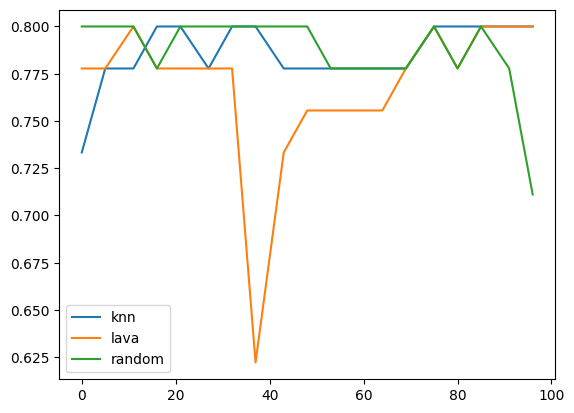

Running remove_high experiment...
Epoch [10/1000], Loss: 0.8072
Epoch [20/1000], Loss: 0.7603
Epoch [30/1000], Loss: 0.7976
Epoch [40/1000], Loss: 0.7486
Epoch [50/1000], Loss: 0.7890
Epoch [60/1000], Loss: 0.7909
Epoch [70/1000], Loss: 0.7699
Epoch [80/1000], Loss: 0.7529
Epoch [90/1000], Loss: 0.7763
Epoch [100/1000], Loss: 0.7915
Epoch [110/1000], Loss: 0.7841
Epoch [120/1000], Loss: 0.7704
Epoch [130/1000], Loss: 0.7738
Epoch [140/1000], Loss: 0.7883
Epoch [150/1000], Loss: 0.7566
Epoch [160/1000], Loss: 0.7785
Epoch [170/1000], Loss: 0.7992
Epoch [180/1000], Loss: 0.7451
Epoch [190/1000], Loss: 0.7689
Epoch [200/1000], Loss: 0.8044
Epoch [210/1000], Loss: 0.8085
Epoch [220/1000], Loss: 0.7738
Epoch [230/1000], Loss: 0.8072
Epoch [240/1000], Loss: 0.7296
Epoch [250/1000], Loss: 0.8231
Epoch [260/1000], Loss: 0.7793
Epoch [270/1000], Loss: 0.8087
Epoch [280/1000], Loss: 0.7759
Epoch [290/1000], Loss: 0.7842
Epoch [300/1000], Loss: 0.7311
Epoch [310/1000], Loss: 0.8046
Epoch [320/100

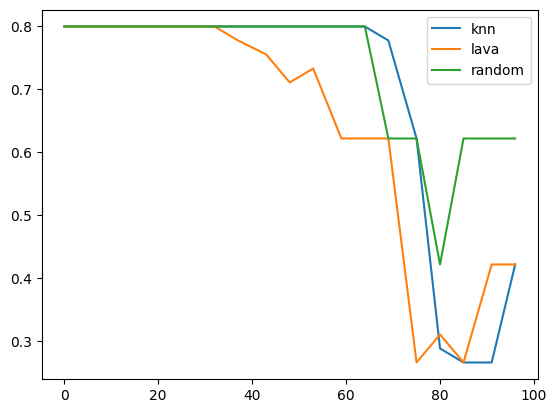

Running add_low experiment...
Epoch [10/1000], Loss: 1.5496
Epoch [20/1000], Loss: 1.5496
Epoch [30/1000], Loss: 1.5495
Epoch [40/1000], Loss: 1.5495
Epoch [50/1000], Loss: 1.5495
Epoch [60/1000], Loss: 1.5495
Epoch [70/1000], Loss: 1.5494
Epoch [80/1000], Loss: 1.5494
Epoch [90/1000], Loss: 1.5494
Epoch [100/1000], Loss: 1.5493
Epoch [110/1000], Loss: 1.5493
Epoch [120/1000], Loss: 1.5493
Epoch [130/1000], Loss: 1.5492
Epoch [140/1000], Loss: 1.5492
Epoch [150/1000], Loss: 1.5491
Epoch [160/1000], Loss: 1.5491
Epoch [170/1000], Loss: 1.5490
Epoch [180/1000], Loss: 1.5490
Epoch [190/1000], Loss: 1.5489
Epoch [200/1000], Loss: 1.5489
Epoch [210/1000], Loss: 1.5488
Epoch [220/1000], Loss: 1.5488
Epoch [230/1000], Loss: 1.5487
Epoch [240/1000], Loss: 1.5487
Epoch [250/1000], Loss: 1.5486
Epoch [260/1000], Loss: 1.5486
Epoch [270/1000], Loss: 1.5485
Epoch [280/1000], Loss: 1.5484
Epoch [290/1000], Loss: 1.5483
Epoch [300/1000], Loss: 1.5483
Epoch [310/1000], Loss: 1.5482
Epoch [320/1000], 

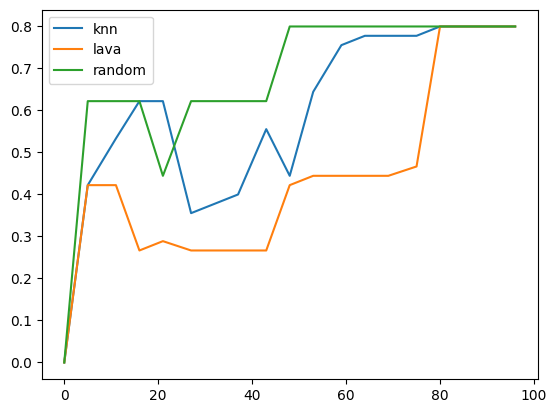

Running add_high experiment...
Epoch [10/1000], Loss: 0.5558
Epoch [20/1000], Loss: 0.5556
Epoch [30/1000], Loss: 0.5555
Epoch [40/1000], Loss: 0.5554
Epoch [50/1000], Loss: 0.5553
Epoch [60/1000], Loss: 0.5552
Epoch [70/1000], Loss: 0.5551
Epoch [80/1000], Loss: 0.5550
Epoch [90/1000], Loss: 0.5549
Epoch [100/1000], Loss: 0.5548
Epoch [110/1000], Loss: 0.5547
Epoch [120/1000], Loss: 0.5546
Epoch [130/1000], Loss: 0.5545
Epoch [140/1000], Loss: 0.5545
Epoch [150/1000], Loss: 0.5544
Epoch [160/1000], Loss: 0.5543
Epoch [170/1000], Loss: 0.5543
Epoch [180/1000], Loss: 0.5542
Epoch [190/1000], Loss: 0.5541
Epoch [200/1000], Loss: 0.5541
Epoch [210/1000], Loss: 0.5540
Epoch [220/1000], Loss: 0.5540
Epoch [230/1000], Loss: 0.5539
Epoch [240/1000], Loss: 0.5539
Epoch [250/1000], Loss: 0.5538
Epoch [260/1000], Loss: 0.5538
Epoch [270/1000], Loss: 0.5538
Epoch [280/1000], Loss: 0.5537
Epoch [290/1000], Loss: 0.5537
Epoch [300/1000], Loss: 0.5536
Epoch [310/1000], Loss: 0.5536
Epoch [320/1000],

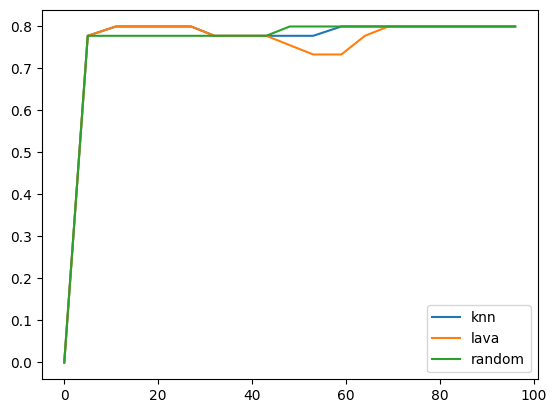

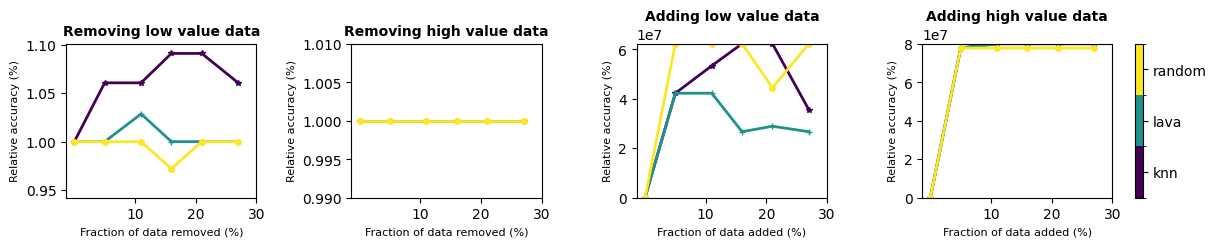

In [49]:
from machine_learning_model import LogisticRegression
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)

Running remove_low experiment...
Epoch [10/100], Loss: 1.1664
Epoch [20/100], Loss: 1.1342
Epoch [30/100], Loss: 1.1282
Epoch [40/100], Loss: 1.1572
Epoch [50/100], Loss: 1.1248
Epoch [60/100], Loss: 1.1540
Epoch [70/100], Loss: 1.1326
Epoch [80/100], Loss: 1.1200
Epoch [90/100], Loss: 1.1538
Epoch [100/100], Loss: 1.1422
Epoch [10/100], Loss: 1.1335
Epoch [20/100], Loss: 1.1245
Epoch [30/100], Loss: 1.1078
Epoch [40/100], Loss: 1.1082
Epoch [50/100], Loss: 1.0789
Epoch [60/100], Loss: 1.1178
Epoch [70/100], Loss: 1.1286
Epoch [80/100], Loss: 1.1285
Epoch [90/100], Loss: 1.1130
Epoch [100/100], Loss: 1.1379
Epoch [10/100], Loss: 1.1240
Epoch [20/100], Loss: 1.1238
Epoch [30/100], Loss: 1.1143
Epoch [40/100], Loss: 1.1165
Epoch [50/100], Loss: 1.1216
Epoch [60/100], Loss: 1.1114
Epoch [70/100], Loss: 1.1128
Epoch [80/100], Loss: 1.1202
Epoch [90/100], Loss: 1.0964
Epoch [100/100], Loss: 1.0872
Epoch [10/100], Loss: 1.0760
Epoch [20/100], Loss: 1.1563
Epoch [30/100], Loss: 1.1165
Epoch [

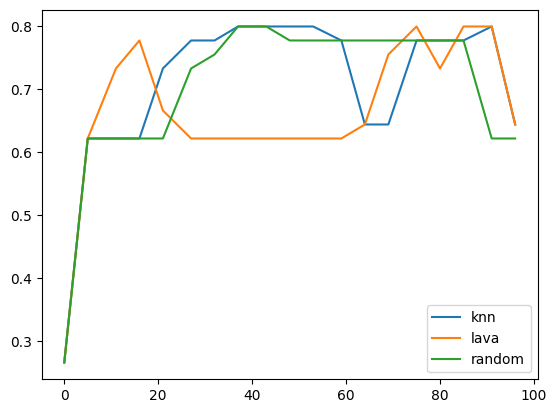

Running remove_high experiment...
Epoch [10/100], Loss: 0.9188
Epoch [20/100], Loss: 0.8741
Epoch [30/100], Loss: 0.8310
Epoch [40/100], Loss: 0.8516
Epoch [50/100], Loss: 0.8662
Epoch [60/100], Loss: 0.8570
Epoch [70/100], Loss: 0.8548
Epoch [80/100], Loss: 0.8597
Epoch [90/100], Loss: 0.8387
Epoch [100/100], Loss: 0.8400
Epoch [10/100], Loss: 0.8500
Epoch [20/100], Loss: 0.8580
Epoch [30/100], Loss: 0.8440
Epoch [40/100], Loss: 0.8719
Epoch [50/100], Loss: 0.8492
Epoch [60/100], Loss: 0.8490
Epoch [70/100], Loss: 0.8353
Epoch [80/100], Loss: 0.8272
Epoch [90/100], Loss: 0.8298
Epoch [100/100], Loss: 0.8296
Epoch [10/100], Loss: 0.8321
Epoch [20/100], Loss: 0.8652
Epoch [30/100], Loss: 0.8637
Epoch [40/100], Loss: 0.8116
Epoch [50/100], Loss: 0.8161
Epoch [60/100], Loss: 0.8212
Epoch [70/100], Loss: 0.8579
Epoch [80/100], Loss: 0.8452
Epoch [90/100], Loss: 0.8616
Epoch [100/100], Loss: 0.8338
Epoch [10/100], Loss: 0.8673
Epoch [20/100], Loss: 0.8599
Epoch [30/100], Loss: 0.8200
Epoch 

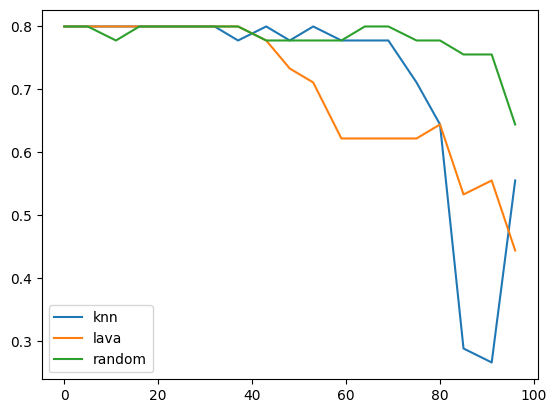

Running add_low experiment...
Epoch [10/100], Loss: 1.3255
Epoch [20/100], Loss: 1.2895
Epoch [30/100], Loss: 1.2702
Epoch [40/100], Loss: 1.2583
Epoch [50/100], Loss: 1.2507
Epoch [60/100], Loss: 1.2459
Epoch [70/100], Loss: 1.2429
Epoch [80/100], Loss: 1.2411
Epoch [90/100], Loss: 1.2399
Epoch [100/100], Loss: 1.2392
Epoch [10/100], Loss: 1.4212
Epoch [20/100], Loss: 1.3433
Epoch [30/100], Loss: 1.2865
Epoch [40/100], Loss: 1.2680
Epoch [50/100], Loss: 1.2596
Epoch [60/100], Loss: 1.2545
Epoch [70/100], Loss: 1.2510
Epoch [80/100], Loss: 1.2483
Epoch [90/100], Loss: 1.2462
Epoch [100/100], Loss: 1.2445
Epoch [10/100], Loss: 0.6311
Epoch [20/100], Loss: 0.6191
Epoch [30/100], Loss: 0.6103
Epoch [40/100], Loss: 0.6035
Epoch [50/100], Loss: 0.5982
Epoch [60/100], Loss: 0.5940
Epoch [70/100], Loss: 0.5906
Epoch [80/100], Loss: 0.5878
Epoch [90/100], Loss: 0.5855
Epoch [100/100], Loss: 0.5835
Epoch [10/100], Loss: 1.3343
Epoch [20/100], Loss: 1.2973
Epoch [30/100], Loss: 1.2746
Epoch [40/

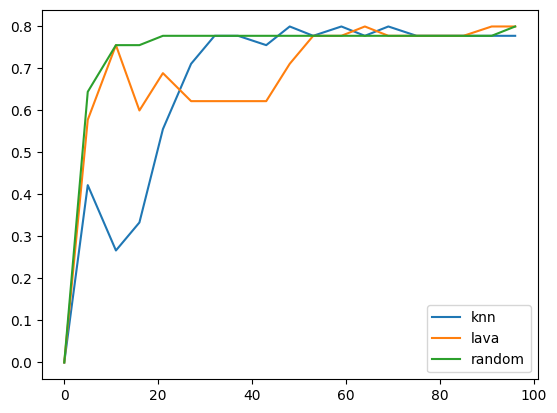

Running add_high experiment...
Epoch [10/100], Loss: 0.5691
Epoch [20/100], Loss: 0.5669
Epoch [30/100], Loss: 0.5653
Epoch [40/100], Loss: 0.5639
Epoch [50/100], Loss: 0.5628
Epoch [60/100], Loss: 0.5619
Epoch [70/100], Loss: 0.5611
Epoch [80/100], Loss: 0.5604
Epoch [90/100], Loss: 0.5598
Epoch [100/100], Loss: 0.5593
Epoch [10/100], Loss: 0.5615
Epoch [20/100], Loss: 0.5608
Epoch [30/100], Loss: 0.5602
Epoch [40/100], Loss: 0.5596
Epoch [50/100], Loss: 0.5592
Epoch [60/100], Loss: 0.5587
Epoch [70/100], Loss: 0.5584
Epoch [80/100], Loss: 0.5580
Epoch [90/100], Loss: 0.5577
Epoch [100/100], Loss: 0.5574
Epoch [10/100], Loss: 0.9742
Epoch [20/100], Loss: 0.9597
Epoch [30/100], Loss: 0.9556
Epoch [40/100], Loss: 0.9538
Epoch [50/100], Loss: 0.9526
Epoch [60/100], Loss: 0.9516
Epoch [70/100], Loss: 0.9508
Epoch [80/100], Loss: 0.9501
Epoch [90/100], Loss: 0.9494
Epoch [100/100], Loss: 0.9489
Epoch [10/100], Loss: 0.5655
Epoch [20/100], Loss: 0.5642
Epoch [30/100], Loss: 0.5630
Epoch [40

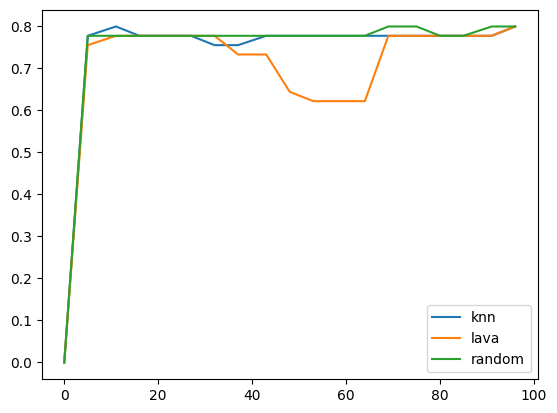

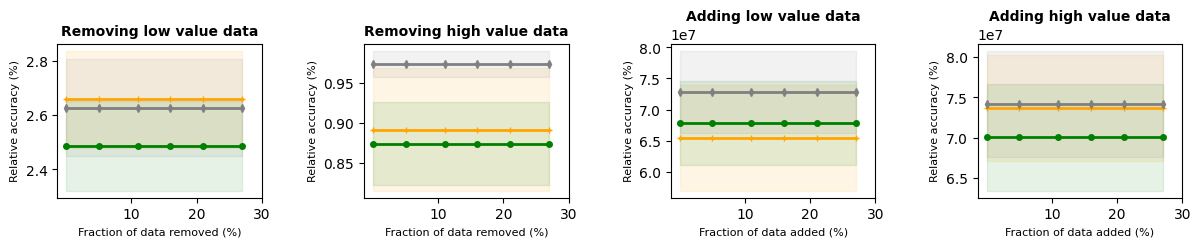

In [46]:
from machine_learning_model import LogisticRegression
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0], shap_list[1], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels_noisy, xt_embeddings, yt_labels, model)